Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Feature engineering based on Feature importance with v36 notebook

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.3
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [8]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= (-0.001*target.sum()+1.1)

    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500, len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [13]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            Threshold = y_preds.iloc[:, 1].median()
            
        logger.info(f"Threshold: {Threshold}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        percentile = y_prob.probability.quantile(0.3)
        high_conf_0 = min(y_prob.probability.min()*30, percentile)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(f"30th percentile: {percentile:.5f}")
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.95: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.5,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [16]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'], test['WHERE'] = 'train', 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
25     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
40     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741   
47     id_008a986b7        0        1        1  0.4860  0.1430  0.5281   
63     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864   
...             ...      ...      ...      ...     ...     ...     ...   
23729  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453   
23747  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880   
23768  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648   
23793  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319   
23811  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
25    -0.6226 -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573   
38     0.3054 -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319   
40     1.5440 -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636   
47    -0.0022 -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694   
63     0.3196  0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
23729  0.3521  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074   
23747 -0.6573 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224   
23768 -0.0525 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951   
23793 -0.8782  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504   
23811 -0.7389  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422   

         c-96    c-97    c-98    c-99  WHERE  
25     0.8837  0.5534  0.8976  1.0050  train  
38     0.2187  0.0737  0.6498 -1.4820  train  
40    -0.5751  0.3362  0.8543  0.9180  train  
47    -0.4979  0.5281 -0.9245 -0.9367  train  
63     0.0949  0.2000 -0.4326  0.9364  train  
...       ...     ...     ...     ...    ...  
23729  0.2131 -0.1419 -0.2422  0.0457  train  
23747 -0.9630  0.8872 -0.0742 -0.6777  train  
23768  0.9517 -0.8110 -0.1748 -0.3626  train  
23793  0.8813  0.7757 -0.5272  0.7082  train  
23811  0.2256  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [24]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [25]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [27]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [28]:
std_df = data.iloc[:, 4:].copy()

In [29]:
data_df.cp_type = data_df.cp_type.astype('int16')
data_df.cp_time = data_df.cp_time.astype('int16')
data_df.cp_dose = data_df.cp_dose.astype('int16')

In [30]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [31]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  
0                  2               0               0  
5                  1               4               5  
36                 2               0               0  
38                 4               4               2  
39                 0               6               1  
...              ...             ...             ...  
27754              4               0               2  
27759              0               2               1  
27768              4               0               2  
27784              1               3               3  
27794              2               3               0  

[27796 rows x 8 columns]

In [32]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               6           2             5             4              1   
5               0           3             3             0              6   
36              0           2             5             4              6   
38              3           0             2             6              1   
39              5           5             1             1              2   
...           ...         ...           ...           ...            ...   
27754           6           0             4             6              1   
27759           4           5             1             1              0   
27768           6           0             4             4              3   
27784           3           4             5             1              3   
27794           3           2             2             4              3   

       clusters_df_c  clusters_g_all  clusters_c_all  cnt_6  cnt_5  cnt_4  \
0                  2               0               0      1      1      1   
5                  1               4               5      1      1      1   
36                 2               0               0      1      1      1   
38                 4               4               2      1      0      2   
39                 0               6               1      1      2      0   
...              ...             ...             ...    ...    ...    ...   
27754              4               0               2      2      0      2   
27759              0               2               1      0      1      1   
27768              4               0               2      1      0      3   
27784              1               3               3      0      1      1   
27794              2               3               0      0      0      1   

       cnt_3  cnt_2  cnt_1  cnt_0  
0          0      2      4      3  
5          2      1      5      2  
36         0      2      3      4  
38         1      3      3      2  
39         0      2      4      3  
...      ...    ...    ...    ...  
27754      0      3      1      4  
27759      0      1      6      4  
27768      2      2      1      3  
27784      4      0      4      2  
27794      3      3      1      3  

[27796 rows x 15 columns]

In [33]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    MAX, MIN = df_[features].max(axis = 1), df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min'] = (MAX * MIN)**2
    
    df_[f'{kind}_kurt'] = Kurt**3
    df_[f'{kind}_skew'] = Skew**3
    df_[f'{kind}_max_kurt'] = MAX * Kurt
    df_[f'{kind}_max_skew'] = MAX * Skew
    df_[f'{kind}_kurt_skew'] = Kurt * Skew
    
    df_[f'{kind}_sum'] = (df_[features].sum(axis = 1))**3
    df_[f'{kind}_mean'] = (df_[features].mean(axis = 1))**3
    df_[f'{kind}_median'] = (df_[features].median(axis = 1))**3
    df_[f'{kind}_mad'] = (df_[features].mad(axis = 1))**3
    df_[f'{kind}_std'] = (df_[features].std(axis = 1))**3

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    
    return stats

In [34]:
stats = detect_stats(data, feature_list, kind_list)
stats

d_g_max_skew  d_g_kurt_skew       d_g_sum      d_g_mean  d_g_median  \
0          1.773997       1.122617 -1.278176e+03 -2.778042e-06   -0.000164   
5         -0.810013      -0.668520  4.686249e+04  1.018529e-04    0.000493   
36         0.774587       0.831640  2.368342e+02  5.147454e-07   -0.000019   
38         0.607893       0.323852  1.909071e+03  4.149255e-06    0.000007   
39        -0.867726      -0.279692  1.404200e+04  3.051948e-05    0.001977   
...             ...            ...           ...           ...         ...   
27754      1.124029       0.487651 -4.176693e+03 -9.077801e-06   -0.000059   
27759     -0.603212      -0.187947 -3.668553e+05 -7.973389e-04   -0.001380   
27768      2.355228       1.710186  1.291874e+02  2.807813e-07   -0.000040   
27784     -0.465225      -0.172956 -6.489317e+04 -1.410416e-04   -0.000112   
27794      0.452458       0.229407  2.381521e+06  5.176098e-03    0.027547   

        d_g_mad   d_g_std   d_c_max   d_c_min  d_c_max_min  ...   c_all_kurt  \
0      0.421547  0.921185  1.479033 -0.843085     1.554884  ...   702.924851   
5      0.450344  1.019499  1.859501 -0.862363     2.571423  ...   119.845739   
36     0.460320  1.141932  0.980110 -1.090500     1.142353  ...  1105.732838   
38     0.553510  1.126814  1.185165 -1.179324     1.953547  ...     0.012519   
39     2.540625  5.120534 -0.393566 -1.898526     0.558301  ...    -3.218037   
...         ...       ...       ...       ...          ...  ...          ...   
27754  0.459287  0.896787  1.800581 -1.739289     9.807738  ...    29.828422   
27759  1.934329  3.692947  0.980837 -2.611712     6.562119  ...    -2.327266   
27768  0.862901  1.992174  2.611712 -1.468736    14.714241  ...   270.636976   
27784  0.540292  1.000059  1.177806 -2.101746     6.127853  ...     3.647902   
27794  0.681515  1.388882  1.717725 -1.621529     7.758125  ...    -0.000630   

       c_all_skew  c_all_max_kurt  c_all_max_skew  c_all_kurt_skew  \
0       -6.600307       19.580500       -4.130876       -16.678526   
5        1.274329       25.634344        5.636921         5.345251   
36      -9.744666       16.710012       -3.451562       -22.087118   
38      -0.001557        0.421912       -0.210613        -0.026914   
39       0.276399       -2.778375        1.225855        -0.961706   
...           ...             ...             ...              ...   
27754   -0.219709        6.451519       -1.255263        -1.871369   
27759    0.186799       -2.454153        1.058631        -0.757543   
27768   -3.786773       16.893553       -4.070818       -10.082126   
27784    0.000002        2.470916        0.021522         0.020641   
27794   -0.002918       -0.147276       -0.245468         0.012252   

          c_all_sum    c_all_mean  c_all_median  c_all_mad  c_all_std  
0      1.200612e+04  4.446710e-04  6.841772e-03   0.288784   0.812540  
5      2.433312e+07  9.012267e-01  7.215851e-01   0.573522   2.324385  
36    -6.350024e+02 -2.351861e-05  8.186017e-05   0.246688   0.682099  
38    -3.831963e+04 -1.419245e-03 -9.070147e-04   0.130688   0.284034  
39    -1.693883e+06 -6.273639e-02 -1.606729e+00   2.088183   2.623831  
...             ...           ...           ...        ...        ...  
27754 -5.882616e+04 -2.178747e-03 -5.373233e-04   0.333428   0.633158  
27759 -2.156482e+06 -7.986971e-02 -1.098727e+00   1.533818   2.067397  
27768 -5.987463e+03 -2.217579e-04 -1.400804e-07   0.521840   1.280537  
27784 -9.736824e+05 -3.606231e-02 -2.744378e-01   0.443372   0.740543  
27794  6.709705e+00  2.485076e-07 -2.467269e-07   0.194441   0.389256  

[27796 rows x 72 columns]

In [35]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [36]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [37]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [38]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           6           2   
5      id_001762a82        1        0        0           0           3   
36     id_00762e877        1        0        0           0           2   
38     id_0079af0fb        0        0        0           3           0   
39     id_0079d45d3        1        0        0           5           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           6           0   
27759  id_fce497048        1        1        1           4           5   
27768  id_fd75349b2        1        1        1           6           0   
27784  id_fed0f2fe0        1        1        1           3           4   
27794  id_ffbb869f2        1        1        1           3           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 5             4              1              2  ...   
5                 3             0              6              1  ...   
36                5             4              6              2  ...   
38                2             6              1              4  ...   
39                1             1              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             4             6              1              4  ...   
27759             1             1              0              0  ...   
27768             4             4              3              4  ...   
27784             5             1              3              1  ...   
27794             2             4              3              2  ...   

        df_c-90   df_c-91   df_c-92   df_c-93   df_c-94   df_c-95   df_c-96  \
0     -1.810818 -1.556684  0.248606 -1.083179  0.184056 -0.422826  0.452858   
5      1.204512  0.578443  1.006571  1.139912  0.620313 -1.168574  0.544603   
36     0.722254 -0.057595 -0.552164 -0.559241 -0.181398 -0.197771 -0.918947   
38     0.374101  0.776318  0.609079  0.186897 -1.233969 -0.059989 -0.958117   
39     1.545960  1.713131  1.361963  1.543328  1.492319  1.588429  1.517699   
...         ...       ...       ...       ...       ...       ...       ...   
27754 -0.147978  0.572841 -1.187832 -0.046089 -0.472173  0.185676 -0.600581   
27759  1.145838  0.589930  1.501425  0.751316  1.638799  1.135045  1.459280   
27768 -1.310017 -1.616881 -0.099856  0.290319  0.222431  0.772244 -0.884043   
27784  0.949547  0.513294 -0.572693  0.836947  0.502350  1.305647  1.236926   
27794 -1.093272  0.292672  0.617046  0.026101 -1.747524 -1.242866 -0.207664   

        df_c-97   df_c-98   df_c-99  
0     -1.087786 -1.717424 -1.652775  
5     -1.732771 -0.122754  0.767287  
36     0.003369 -1.947569 -1.204362  
38    -0.570161 -0.453190  1.387738  
39     1.513423  1.721750  0.753663  
...         ...       ...       ...  
27754  0.372026 -1.536801  0.434025  
27759  1.082334  1.356379  1.247627  
27768 -1.473699  1.308167  0.237404  
27784  1.021927  0.945616  1.153026  
27794 -0.742805 -0.091712 -0.628309  

[27796 rows x 2707 columns]

In [39]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:])

Remove_columns = np.array(data.columns[4:])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1331 columns: ['cnt_6' 'cnt_5' 'cnt_4' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [40]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0         6.0         2.0   
1      id_000779bfc        1        2        0         0.0         3.0   
2      id_000a6266a        1        1        0         0.0         2.0   
3      id_0015fd391        1        1        0         3.0         0.0   
4      id_001626bd3        1        2        1         5.0         5.0   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0         6.0         0.0   
27792  id_ff925dd0d        1        0        0         4.0         5.0   
27793  id_ffb710450        1        2        0         6.0         0.0   
27794  id_ffbb869f2        1        1        1         3.0         4.0   
27795  id_ffd5800b6        1        2        0         3.0         2.0   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0               5.0           4.0            1.0            2.0  ...   
1               3.0           0.0            6.0            1.0  ...   
2               5.0           4.0            6.0            2.0  ...   
3               2.0           6.0            1.0            4.0  ...   
4               1.0           1.0            2.0            0.0  ...   
...             ...           ...            ...            ...  ...   
27791           4.0           6.0            1.0            4.0  ...   
27792           1.0           1.0            0.0            0.0  ...   
27793           4.0           4.0            3.0            4.0  ...   
27794           5.0           1.0            3.0            1.0  ...   
27795           2.0           4.0            3.0            2.0  ...   

        df_c-83   df_c-84   df_c-87   df_c-88   df_c-89   df_c-90   df_c-93  \
0     -2.469641  0.685004 -0.316241  1.079690 -0.068942 -1.810818 -1.083179   
1      0.983313 -0.008403  0.526056  0.938130  1.217656  1.204512  1.139912   
2      0.308412  0.013458 -0.540882 -0.081272 -0.271137  0.722254 -0.559241   
3     -0.864131 -0.016645 -0.671614 -0.876537 -0.562860  0.374101  0.186897   
4      1.365222  1.657370  1.881889  1.527431  1.562138  1.545960  1.543328   
...         ...       ...       ...       ...       ...       ...       ...   
27791  0.977720  0.336641 -1.291018  1.471222 -0.066577 -0.147978 -0.046089   
27792  1.515722  1.539920  0.079120  1.432613  0.330936  1.145838  0.751316   
27793  0.117572 -0.037507  1.110500 -0.836153  0.878411 -1.310017  0.290319   
27794 -0.110347  0.256540 -0.562024  0.003764  0.851237  0.949547  0.836947   
27795 -0.700275 -0.979275  0.565538  0.714365 -1.221653 -1.093272  0.026101   

        df_c-94   df_c-96   df_c-97  
0      0.184056  0.452858 -1.087786  
1      0.620313  0.544603 -1.732771  
2     -0.181398 -0.918947  0.003369  
3     -1.233969 -0.958117 -0.570161  
4      1.492319  1.517699  1.513423  
...         ...       ...       ...  
27791 -0.472173 -0.600581  0.372026  
27792  1.638799  1.459280  1.082334  
27793  0.222431 -0.884043 -1.473699  
27794  0.502350  1.236926  1.021927  
27795 -1.747524 -0.207664 -0.742805  

[27796 rows x 1376 columns]

In [41]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [42]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 337 columns


# Modeling

In [43]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}


In [44]:
def select_importance_cols(feature_importance_df, num=10):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [45]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609599	valid_1's binary_logloss: 0.0943432
[200]	training's binary_logloss: 0.00989996	valid_1's binary_logloss: 0.0254542
[300]	training's binary_logloss: 0.00318382	valid_1's binary_logloss: 0.0135716
[400]	training's binary_logloss: 0.00175219	valid_1's binary_logloss: 0.00979037
[500]	training's binary_logloss: 0.00132568	valid_1's binary_logloss: 0.00846083
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0012758	valid_1's binary_logloss: 0.00820963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612977	valid_1's binary_logloss: 0.0975396
[200]	training's binary_logloss: 0.00992344	valid_1's binary_logloss: 0.0257921
[300]	training's binary_logloss: 0.00318632	valid_1's binary_logloss: 0.0118713
[400]	training's binary_logloss: 0.00176696	valid_1's binary_logloss: 0.00797946
[500]	training's binary_logloss: 0.0013582

1 / 3 AUC score:1.000
Threshold: 0.7724197062404284
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00212
p_label_rate: 0.00000 Vs.target_rate: 0.00077, Num_p_label: 0.0, conf_0:0.00212, conf_1:0.77242
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_1: 0.77
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_2: 0.73
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_3: 0.69
Num_p_label: 0.0, Expected: 3.1, Adj_threshold_4: 0.65
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_5: 0.61
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_6: 0.57
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_7: 0.53
Num_p_label: 2.0, Expected: 3.1, Adj_threshold_8: 0.49
Num_p_label: 3.0, Expected: 3.1, Adj_threshold_9: 0.45
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609599	valid_1's binary_logloss: 0.0943432
[200]	training's binary_logloss: 0.00989996	valid_1's binary_logloss: 0.0254542
[300]	training's binary_logloss: 0.00318382	valid_1's binary_logloss: 0.0135716
[400]	training's binary_logloss: 0.00175219	valid_1's binary_logloss: 0.00979037
[500]	training's binary_logloss: 0.00132568	valid_1's binary_logloss: 0.00846083
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0012758	valid_1's binary_logloss: 0.00820963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612977	valid_1's binary_logloss: 0.0975396
[200]	training's binary_logloss: 0.00992344	valid_1's binary_logloss: 0.0257921
[300]	training's binary_logloss: 0.00318632	valid_1's binary_logloss: 0.0118713
[400]	training's binary_logloss: 0.00176696	valid_1's binary_logloss: 0.00797946
[500]	training's binary_logloss: 0.0013582

2 / 3 AUC score:1.000
Threshold: 0.45241970624042827
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00212
p_label_rate: 0.00075 Vs.target_rate: 0.00077, Num_p_label: 3.0, conf_0:0.00212, conf_1:0.45242
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613959	valid_1's binary_logloss: 0.0929484
[200]	training's binary_logloss: 0.0100841	valid_1's binary_logloss: 0.0250986
[300]	training's binary_logloss: 0.00317885	valid_1's binary_logloss: 0.0110726
[400]	training's binary_logloss: 0.00175606	valid_1's binary_logloss: 0.00762905
[500]	training's binary_logloss: 0.00133535	valid_1's binary_logloss: 0.00622948
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00126567	valid_1's binary_logloss: 0.00594505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626217	valid_1's binary_logloss: 0.101332
[200]	training's binary_logloss: 0.00999755	valid_1's binary_logloss: 0.0274951
[300]	training's binary_logloss: 0.00316031	valid_1's binary_logloss: 0.0135768
[400]	training's binary_logloss: 0.001743	valid_1's binary_logloss: 0.00983268


3 / 3 AUC score:1.000
Threshold: 0.45241970624042827


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00140955	valid_1's binary_logloss: 0.00847276


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00229
p_label_rate: 0.00025 Vs.target_rate: 0.00077, Num_p_label: 1.0, conf_0:0.00229, conf_1:0.45242
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_1: 0.45
Num_p_label: 4.0, Expected: 3.1, Adj_threshold_2: 0.41
threshold:0.41, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4981, y_label_rate: 0.10118


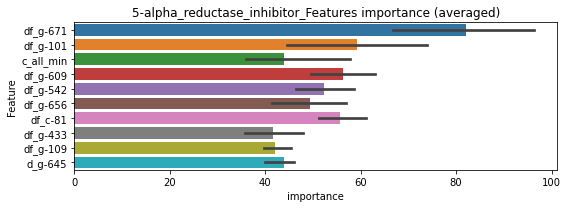

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156384	valid_1's binary_logloss: 0.0237242
[200]	training's binary_logloss: 0.0018755	valid_1's binary_logloss: 0.00657885
[300]	training's binary_logloss: 0.000546118	valid_1's binary_logloss: 0.004209
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000345005	valid_1's binary_logloss: 0.00384319


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150755	valid_1's binary_logloss: 0.0257767
[200]	training's binary_logloss: 0.0017431	valid_1's binary_logloss: 0.00826304
[300]	training's binary_logloss: 0.000510698	valid_1's binary_logloss: 0.00620514
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000448633	valid_1's binary_logloss: 0.00611482


5-alpha_reductase_inhibitor logloss: 0.004978777067222911
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634211	valid_1's binary_logloss: 0.106256
[200]	training's binary_logloss: 0.0105119	valid_1's binary_logloss: 0.0302038
[300]	training's binary_logloss: 0.00334325	valid_1's binary_logloss: 0.0138017
[400]	training's binary_logloss: 0.00182601	valid_1's binary_logloss: 0.009728
[500]	training's binary_logloss: 0.00134568	valid_1's binary_logloss: 0.00795948
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00126124	valid_1's binary_logloss: 0.00757861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635206	valid_1's binary_logloss: 0.105021
[200]	training's binary_logloss: 0.01036	valid_1's binary_logloss: 0.0340467
[300]	training's binary_logloss: 0.00332092	valid_1's binary_logloss: 0.0174436
[400]	training's binary_logloss: 0.00181825	valid_1's binary_logloss: 0.0128549
[500]	training's binary_logloss: 0.00135389	valid_

1 / 3 AUC score:1.000
Threshold: 0.3863291865409625
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00236
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00236, conf_1:0.38633
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.39
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.35
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_3: 0.31
threshold:0.31, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634211	valid_1's binary_logloss: 0.106256
[200]	training's binary_logloss: 0.0105119	valid_1's binary_logloss: 0.0302038
[300]	training's binary_logloss: 0.00334325	valid_1's binary_logloss: 0.0138017
[400]	training's binary_logloss: 0.00182601	valid_1's binary_logloss: 0.009728
[500]	training's binary_logloss: 0.00134568	valid_1's binary_logloss: 0.00795948
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00126124	valid_1's binary_logloss: 0.00757861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635206	valid_1's binary_logloss: 0.105021
[200]	training's binary_logloss: 0.01036	valid_1's binary_logloss: 0.0340467
[300]	training's binary_logloss: 0.00332092	valid_1's binary_logloss: 0.0174436
[400]	training's binary_logloss: 0.00181825	valid_1's binary_logloss: 0.0128549
[500]	training's binary_logloss: 0.00135389	valid_

2 / 3 AUC score:1.000
Threshold: 0.30632918654096253
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00236
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00236, conf_1:0.30633
threshold:0.31, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625421	valid_1's binary_logloss: 0.108768
[200]	training's binary_logloss: 0.0104754	valid_1's binary_logloss: 0.0330891
[300]	training's binary_logloss: 0.00331147	valid_1's binary_logloss: 0.0159196
[400]	training's binary_logloss: 0.00181446	valid_1's binary_logloss: 0.0112426
[500]	training's binary_logloss: 0.00135652	valid_1's binary_logloss: 0.0094837
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00127105	valid_1's binary_logloss: 0.0088938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637564	valid_1's binary_logloss: 0.102606
[200]	training's binary_logloss: 0.0104964	valid_1's binary_logloss: 0.0334005
[300]	training's binary_logloss: 0.00333829	valid_1's binary_logloss: 0.018044
[400]	training's binary_logloss: 0.00183632	valid_1's binary_logloss: 0.0137242
[500]	training's binary_logloss: 0.00136805	valid_

3 / 3 AUC score:1.000
Threshold: 0.30632918654096253
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00239
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00239, conf_1:0.30633
threshold:0.31, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4981, y_label_rate: 0.10078


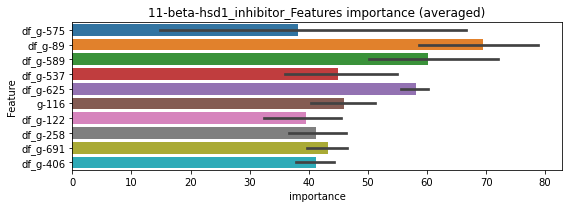

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158405	valid_1's binary_logloss: 0.0256753
[200]	training's binary_logloss: 0.00193055	valid_1's binary_logloss: 0.00755266
[300]	training's binary_logloss: 0.00055151	valid_1's binary_logloss: 0.00511957
[400]	training's binary_logloss: 0.000295141	valid_1's binary_logloss: 0.00460089
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00024833	valid_1's binary_logloss: 0.0045106


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163613	valid_1's binary_logloss: 0.0223486
[200]	training's binary_logloss: 0.00193683	valid_1's binary_logloss: 0.00526759
[300]	training's binary_logloss: 0.00055861	valid_1's binary_logloss: 0.00329269
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000338525	valid_1's binary_logloss: 0.00297697


11-beta-hsd1_inhibitor logloss: 0.003743940383524667
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732959	valid_1's binary_logloss: 0.118034
[200]	training's binary_logloss: 0.0136403	valid_1's binary_logloss: 0.0393956
[300]	training's binary_logloss: 0.00436696	valid_1's binary_logloss: 0.0203728
[400]	training's binary_logloss: 0.00233915	valid_1's binary_logloss: 0.0139245
[500]	training's binary_logloss: 0.00167549	valid_1's binary_logloss: 0.0115316
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00148124	valid_1's binary_logloss: 0.0105697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066401	valid_1's binary_logloss: 0.125525
[200]	training's binary_logloss: 0.0118206	valid_1's binary_logloss: 0.0490227
[300]	training's binary_logloss: 0.00392354	valid_1's binary_logloss: 0.027964
[400]	training's binary_logloss: 0.0021612	valid_1's binary_logloss: 0.0214672
[500]	training's binary_logloss: 0.00157285	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.2179319965684964
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00279
p_label_rate: 0.00628 Vs.target_rate: 0.00108, Num_p_label: 25.0, conf_0:0.00279, conf_1:0.30704
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_1: 0.22
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_2: 0.26
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_3: 0.30
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_4: 0.34
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_5: 0.38
threshold:0.38, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683288	valid_1's binary_logloss: 0.116492
[200]	training's binary_logloss: 0.0123078	valid_1's binary_logloss: 0.0411475
[300]	training's binary_logloss: 0.0041224	valid_1's binary_logloss: 0.0229606
[400]	training's binary_logloss: 0.00224701	valid_1's binary_logloss: 0.0168324
[500]	training's binary_logloss: 0.00161587	valid_1's binary_logloss: 0.014338
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.001453	valid_1's binary_logloss: 0.0134637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692164	valid_1's binary_logloss: 0.112889
[200]	training's binary_logloss: 0.0123985	valid_1's binary_logloss: 0.0368821
[300]	training's binary_logloss: 0.0040923	valid_1's binary_logloss: 0.0201417
[400]	training's binary_logloss: 0.00221165	valid_1's binary_logloss: 0.0141868
[500]	training's binary_logloss: 0.00160195	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.37793199656849635
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/995
30th percentile: 0.00267
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00267, conf_1:0.40472
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/995, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070134	valid_1's binary_logloss: 0.112564
[200]	training's binary_logloss: 0.0126082	valid_1's binary_logloss: 0.0411811
[300]	training's binary_logloss: 0.00410464	valid_1's binary_logloss: 0.0234505
[400]	training's binary_logloss: 0.00223409	valid_1's binary_logloss: 0.0178563
[500]	training's binary_logloss: 0.00162188	valid_1's binary_logloss: 0.0157114
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00148382	valid_1's binary_logloss: 0.014998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678343	valid_1's binary_logloss: 0.118331
[200]	training's binary_logloss: 0.0126677	valid_1's binary_logloss: 0.0447657
[300]	training's binary_logloss: 0.00406217	valid_1's binary_logloss: 0.0257767
[400]	training's binary_logloss: 0.00217659	valid_1's binary_logloss: 0.0190701
[500]	training's binary_logloss: 0.00156864	valid_1

3 / 3 AUC score:1.000
Threshold: 0.37793199656849635
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/990
30th percentile: 0.00267
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00267, conf_1:0.37793
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/4972, y_label_rate: 0.10016


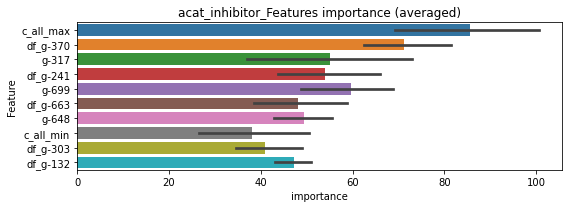

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017785	valid_1's binary_logloss: 0.0322255
[200]	training's binary_logloss: 0.00240358	valid_1's binary_logloss: 0.0109803
[300]	training's binary_logloss: 0.000695598	valid_1's binary_logloss: 0.00697877
[400]	training's binary_logloss: 0.000365696	valid_1's binary_logloss: 0.00604511
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000308364	valid_1's binary_logloss: 0.0058205


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175445	valid_1's binary_logloss: 0.0269451
[200]	training's binary_logloss: 0.0023281	valid_1's binary_logloss: 0.00853144
[300]	training's binary_logloss: 0.000677288	valid_1's binary_logloss: 0.00596911
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000503119	valid_1's binary_logloss: 0.00574588


acat_inhibitor logloss: 0.005783190484244975
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185941	valid_1's binary_logloss: 0.489932
[200]	training's binary_logloss: 0.0645702	valid_1's binary_logloss: 0.417859
[300]	training's binary_logloss: 0.0260487	valid_1's binary_logloss: 0.398374
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0212718	valid_1's binary_logloss: 0.39578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188101	valid_1's binary_logloss: 0.476496
[200]	training's binary_logloss: 0.0663996	valid_1's binary_logloss: 0.399211
[300]	training's binary_logloss: 0.0273086	valid_1's binary_logloss: 0.370579


1 / 3 AUC score:0.902
Threshold: 0.456564091193419


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0163076	valid_1's binary_logloss: 0.357738


Remove_noisy_labels: 184 → positive_corect_labels: 408/816
30th percentile: 0.19705
p_label_rate: 0.15093 Vs.target_rate: 0.00726, Num_p_label: 601.0, conf_0:0.19705, conf_1:0.53065
Num_p_label: 601.0, Expected: 28.9, Adj_threshold_1: 0.46
Num_p_label: 426.0, Expected: 28.9, Adj_threshold_2: 0.50
Num_p_label: 274.0, Expected: 28.9, Adj_threshold_3: 0.54
Num_p_label: 180.0, Expected: 28.9, Adj_threshold_4: 0.58
Num_p_label: 114.0, Expected: 28.9, Adj_threshold_5: 0.62
Num_p_label: 62.0, Expected: 28.9, Adj_threshold_6: 0.66
Num_p_label: 36.0, Expected: 28.9, Adj_threshold_7: 0.70
threshold:0.70, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:408.0/816, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162429	valid_1's binary_logloss: 0.420375
[200]	training's binary_logloss: 0.0516517	valid_1's binary_logloss: 0.328475
[300]	training's binary_logloss: 0.019735	valid_1's binary_logloss: 0.286554
[400]	training's binary_logloss: 0.00971083	valid_1's binary_logloss: 0.268442
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00712059	valid_1's binary_logloss: 0.261069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17154	valid_1's binary_logloss: 0.405566
[200]	training's binary_logloss: 0.0563374	valid_1's binary_logloss: 0.308434
[300]	training's binary_logloss: 0.0222096	valid_1's binary_logloss: 0.266182
[400]	training's binary_logloss: 0.0108858	valid_1's binary_logloss: 0.246677
[500]	training's binary_logloss: 0.00653661	valid_1's binary_logloss: 0.237129
Early stopping, best iteration is:
[565]	training's binary_loglo

2 / 3 AUC score:0.962
Threshold: 0.6965640911934191
Remove_noisy_labels: 91 → positive_corect_labels: 325.0/725
30th percentile: 0.12027
p_label_rate: 0.04621 Vs.target_rate: 0.00726, Num_p_label: 184.0, conf_0:0.12027, conf_1:0.69656
Num_p_label: 184.0, Expected: 28.9, Adj_threshold_1: 0.70
Num_p_label: 135.0, Expected: 28.9, Adj_threshold_2: 0.74
Num_p_label: 77.0, Expected: 28.9, Adj_threshold_3: 0.78
Num_p_label: 47.0, Expected: 28.9, Adj_threshold_4: 0.82
Num_p_label: 24.0, Expected: 28.9, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:325.0/725, y_label_rate: 0.44828
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149548	valid_1's binary_logloss: 0.349777
[200]	training's binary_logloss: 0.0462066	valid_1's binary_logloss: 0.252956
[300]	training's binary_logloss: 0.0179739	valid_1's binary_logloss: 0.220066
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0101108	valid_1's binary_logloss: 0.203968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153513	valid_1's binary_logloss: 0.338679
[200]	training's binary_logloss: 0.0472699	valid_1's binary_logloss: 0.237011
[300]	training's binary_logloss: 0.0183999	valid_1's binary_logloss: 0.189222
[400]	training's binary_logloss: 0.00907376	valid_1's binary_logloss: 0.171801


3 / 3 AUC score:0.983
Threshold: 0.8565640911934193


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00672506	valid_1's binary_logloss: 0.164847


Remove_noisy_labels: 89 → positive_corect_labels: 237.0/636
30th percentile: 0.07305
p_label_rate: 0.00477 Vs.target_rate: 0.00726, Num_p_label: 19.0, conf_0:0.07006, conf_1:0.85656
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:256.0/4618, y_label_rate: 0.05544


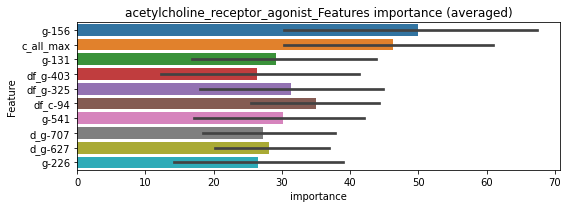

len(train_index) : 2309
len(valid_index) : 2309
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020709	valid_1's binary_logloss: 0.0921027


len(train_index) : 2309
len(valid_index) : 2309


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00567147	valid_1's binary_logloss: 0.0841916


================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208005	valid_1's binary_logloss: 0.0917239
[200]	training's binary_logloss: 0.00442664	valid_1's binary_logloss: 0.0830101


acetylcholine_receptor_agonist logloss: 0.08333123107256464


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00397537	valid_1's binary_logloss: 0.0824709


acetylcholine_receptor_antagonist , len(trt) : 301


  acetylcholine_receptor_agonist
0                          g-156
1                      c_all_max
2                        df_c-94
3                       df_g-325
4                          g-541
5                          g-131
6                        d_g-627
7                        d_g-707
8                          g-226
9                       df_g-403


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209892	valid_1's binary_logloss: 0.59775
[200]	training's binary_logloss: 0.0789616	valid_1's binary_logloss: 0.579335
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0753818	valid_1's binary_logloss: 0.576954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211392	valid_1's binary_logloss: 0.611263


1 / 3 AUC score:0.744
Threshold: 0.5000703676268812
Remove_noisy_labels: 320 → positive_corect_labels: 340/680
30th percentile: 0.35592
p_label_rate: 0.28051 Vs.target_rate: 0.01010, Num_p_label: 1117.0, conf_0:0.35592, conf_1:0.50007
Num_p_label: 1117.0, Expected: 40.2, Adj_threshold_1: 0.50
Num_p_label: 735.0, Expected: 40.2, Adj_threshold_2: 0.54
Num_p_label: 454.0, Expected: 40.2, Adj_threshold_3: 0.58
Num_p_label: 234.0, Expected: 40.2, Adj_threshold_4: 0.62
Num_p_label: 105.0, Expected: 40.2, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 40.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.143806	valid_1's binary_logloss: 0.59706


positive y_label:340.0/680, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190548	valid_1's binary_logloss: 0.460678
[200]	training's binary_logloss: 0.0663015	valid_1's binary_logloss: 0.390155
[300]	training's binary_logloss: 0.02723	valid_1's binary_logloss: 0.358369
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0214622	valid_1's binary_logloss: 0.35069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182105	valid_1's binary_logloss: 0.482215
[200]	training's binary_logloss: 0.0636883	valid_1's binary_logloss: 0.419556


2 / 3 AUC score:0.914
Threshold: 0.7000703676268814
Remove_noisy_labels: 122 → positive_corect_labels: 241.0/558
30th percentile: 0.26000
p_label_rate: 0.09869 Vs.target_rate: 0.01010, Num_p_label: 393.0, conf_0:0.26000, conf_1:0.70007
Num_p_label: 393.0, Expected: 40.2, Adj_threshold_1: 0.70
Num_p_label: 267.0, Expected: 40.2, Adj_threshold_2: 0.74
Num_p_label: 185.0, Expected: 40.2, Adj_threshold_3: 0.78


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0414877	valid_1's binary_logloss: 0.408594


Num_p_label: 91.0, Expected: 40.2, Adj_threshold_4: 0.82
Num_p_label: 45.0, Expected: 40.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:241.0/558, y_label_rate: 0.43190
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166189	valid_1's binary_logloss: 0.406487
[200]	training's binary_logloss: 0.0548043	valid_1's binary_logloss: 0.324357
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0411925	valid_1's binary_logloss: 0.309884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164614	valid_1's binary_logloss: 0.429128
[200]	training's binary_logloss: 0.0523838	valid_1's binary_logloss: 0.367677


3 / 3 AUC score:0.937
Threshold: 0.8600703676268815
Remove_noisy_labels: 144 → positive_corect_labels: 97.0/414
30th percentile: 0.15527
p_label_rate: 0.00578 Vs.target_rate: 0.01010, Num_p_label: 23.0, conf_0:0.15527, conf_1:0.86007
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0311355	valid_1's binary_logloss: 0.350012


positive y_label:120.0/4396, y_label_rate: 0.02730


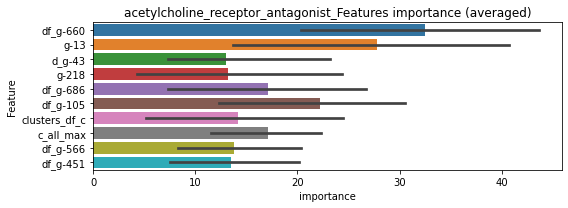

len(train_index) : 2198
len(valid_index) : 2198
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2198
len(valid_index) : 2198
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0198484	valid_1's binary_logloss: 0.0843987
Training until validation scores don't improve for 10 rounds


acetylcholine_receptor_antagonist logloss: 0.07913776682627091
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.020497	valid_1's binary_logloss: 0.0738768
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist
0                          g-156                          df_g-660
1                      c_all_max                              g-13
2                        df_c-94                          df_g-105
3                       df_g-325                          df_g-686
4                          g-541                         c_all_max
5                          g-131                     clusters_df_c
6                        d_g-627                          df_g-566
7                        d_g-707                          df_g-451
8                          g-226                             g-218
9                       df_g-403                            d_g-43


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125333	valid_1's binary_logloss: 0.276817
[200]	training's binary_logloss: 0.0335094	valid_1's binary_logloss: 0.18472
[300]	training's binary_logloss: 0.0117562	valid_1's binary_logloss: 0.148267
[400]	training's binary_logloss: 0.00575348	valid_1's binary_logloss: 0.131615
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00521393	valid_1's binary_logloss: 0.130061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132485	valid_1's binary_logloss: 0.300829
[200]	training's binary_logloss: 0.0355412	valid_1's binary_logloss: 0.191575
[300]	training's binary_logloss: 0.0126008	valid_1's binary_logloss: 0.150084
[400]	training's binary_logloss: 0.00616057	valid_1's binary_logloss: 0.133894
[500]	training's binary_logloss: 0.00381892	valid_1's binary_logloss: 0.126062
Early stopping, best iteration is:
[554]	training's binary_log

1 / 3 AUC score:0.989
Threshold: 0.3823806244862326
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.02862
p_label_rate: 0.03214 Vs.target_rate: 0.00315, Num_p_label: 128.0, conf_0:0.02862, conf_1:0.45200
Num_p_label: 128.0, Expected: 12.5, Adj_threshold_1: 0.38
Num_p_label: 96.0, Expected: 12.5, Adj_threshold_2: 0.42
Num_p_label: 74.0, Expected: 12.5, Adj_threshold_3: 0.46
Num_p_label: 49.0, Expected: 12.5, Adj_threshold_4: 0.50
Num_p_label: 34.0, Expected: 12.5, Adj_threshold_5: 0.54
Num_p_label: 24.0, Expected: 12.5, Adj_threshold_6: 0.58
Num_p_label: 18.0, Expected: 12.5, Adj_threshold_7: 0.62
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123453	valid_1's binary_logloss: 0.261158
[200]	training's binary_logloss: 0.0324135	valid_1's binary_logloss: 0.160245
[300]	training's binary_logloss: 0.0114394	valid_1's binary_logloss: 0.124377
[400]	training's binary_logloss: 0.00559457	valid_1's binary_logloss: 0.112592
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00526257	valid_1's binary_logloss: 0.110977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120301	valid_1's binary_logloss: 0.262528
[200]	training's binary_logloss: 0.0309583	valid_1's binary_logloss: 0.155655
[300]	training's binary_logloss: 0.0109886	valid_1's binary_logloss: 0.116576
[400]	training's binary_logloss: 0.0054406	valid_1's binary_logloss: 0.102158
[500]	training's binary_logloss: 0.00344813	valid_1's binary_logloss: 0.0943418
[600]	training's binary_logloss: 0.00259013	valid_1's binary_

2 / 3 AUC score:0.992
Threshold: 0.6223806244862327
Remove_noisy_labels: 29 → positive_corect_labels: 452.0/931
30th percentile: 0.02152
p_label_rate: 0.00854 Vs.target_rate: 0.00315, Num_p_label: 34.0, conf_0:0.02152, conf_1:0.62238
threshold:0.62, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:452.0/931, y_label_rate: 0.48550
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121945	valid_1's binary_logloss: 0.236735
[200]	training's binary_logloss: 0.0320949	valid_1's binary_logloss: 0.129821
[300]	training's binary_logloss: 0.011181	valid_1's binary_logloss: 0.0877392
[400]	training's binary_logloss: 0.00546483	valid_1's binary_logloss: 0.0704491
[500]	training's binary_logloss: 0.00346116	valid_1's binary_logloss: 0.0627186
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00267737	valid_1's binary_logloss: 0.0573875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120442	valid_1's binary_logloss: 0.232838
[200]	training's binary_logloss: 0.0318388	valid_1's binary_logloss: 0.12662
[300]	training's binary_logloss: 0.0113794	valid_1's binary_logloss: 0.0876916
[400]	training's binary_logloss: 0.00559131	valid_1's binary_logloss: 0.0739367
[500]	training's binary_logloss: 0.00354496	valid_1's bin

3 / 3 AUC score:0.999
Threshold: 0.6223806244862327
Remove_noisy_labels: 13 → positive_corect_labels: 442.0/918
30th percentile: 0.01456
p_label_rate: 0.00603 Vs.target_rate: 0.00315, Num_p_label: 24.0, conf_0:0.01456, conf_1:0.62238
threshold:0.62, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:466.0/4900, y_label_rate: 0.09510


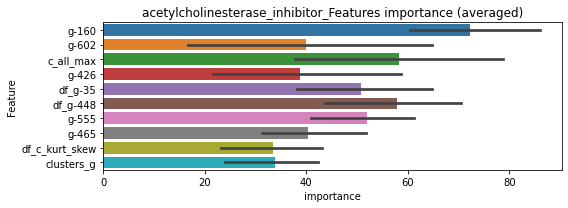

len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307636	valid_1's binary_logloss: 0.0794566
[200]	training's binary_logloss: 0.00588553	valid_1's binary_logloss: 0.0501625
[300]	training's binary_logloss: 0.00175023	valid_1's binary_logloss: 0.0451719
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00166787	valid_1's binary_logloss: 0.0449752


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263355	valid_1's binary_logloss: 0.0896823
[200]	training's binary_logloss: 0.00475068	valid_1's binary_logloss: 0.0744851
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00521904	valid_1's binary_logloss: 0.0741788


acetylcholinesterase_inhibitor logloss: 0.05957702373714202
adenosine_receptor_agonist , len(trt) : 54


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor  
0                          g-160  
1                      c_all_max  
2                       df_g-448  
3                          g-555  
4                        df_g-35  
5                  

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115787	valid_1's binary_logloss: 0.229195
[200]	training's binary_logloss: 0.028714	valid_1's binary_logloss: 0.123358
[300]	training's binary_logloss: 0.00986532	valid_1's binary_logloss: 0.0884053
[400]	training's binary_logloss: 0.00485328	valid_1's binary_logloss: 0.072872
[500]	training's binary_logloss: 0.00311297	valid_1's binary_logloss: 0.065715
[600]	training's binary_logloss: 0.00236106	valid_1's binary_logloss: 0.0622552
[700]	training's binary_logloss: 0.00208511	valid_1's binary_logloss: 0.0601423
Early stopping, best iteration is:
[727]	training's binary_logloss: 0.00205191	valid_1's binary_logloss: 0.0598495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110833	valid_1's binary_logloss: 0.220579
[200]	training's binary_logloss: 0.0273953	valid_1's binary_logloss: 0.118043
[300]	training's binary_logloss: 0.00936228	valid_1's bi

1 / 3 AUC score:0.998
Threshold: 0.3165949405232864
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01435
p_label_rate: 0.01557 Vs.target_rate: 0.00237, Num_p_label: 62.0, conf_0:0.01435, conf_1:0.45561
Num_p_label: 62.0, Expected: 9.4, Adj_threshold_1: 0.32
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_2: 0.36
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_3: 0.40
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_4: 0.44
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_5: 0.48
threshold:0.48, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110417	valid_1's binary_logloss: 0.225308
[200]	training's binary_logloss: 0.0273246	valid_1's binary_logloss: 0.125497
[300]	training's binary_logloss: 0.00916139	valid_1's binary_logloss: 0.0887716
[400]	training's binary_logloss: 0.00451893	valid_1's binary_logloss: 0.0759883
[500]	training's binary_logloss: 0.00291141	valid_1's binary_logloss: 0.070738
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00253157	valid_1's binary_logloss: 0.0688768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109763	valid_1's binary_logloss: 0.218348
[200]	training's binary_logloss: 0.026912	valid_1's binary_logloss: 0.11232
[300]	training's binary_logloss: 0.00912628	valid_1's binary_logloss: 0.0752289
[400]	training's binary_logloss: 0.00458282	valid_1's binary_logloss: 0.0589371
[500]	training's binary_logloss: 0.00296541	valid_1's bi

2 / 3 AUC score:0.998
Threshold: 0.4765949405232863
Remove_noisy_labels: 13 → positive_corect_labels: 480.0/971
30th percentile: 0.01361
p_label_rate: 0.00452 Vs.target_rate: 0.00237, Num_p_label: 18.0, conf_0:0.01361, conf_1:0.47659
threshold:0.48, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:480.0/971, y_label_rate: 0.49434
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110633	valid_1's binary_logloss: 0.236159
[200]	training's binary_logloss: 0.0264823	valid_1's binary_logloss: 0.117629
[300]	training's binary_logloss: 0.00898788	valid_1's binary_logloss: 0.0713021
[400]	training's binary_logloss: 0.00438631	valid_1's binary_logloss: 0.0539337
[500]	training's binary_logloss: 0.00281333	valid_1's binary_logloss: 0.0452595
[600]	training's binary_logloss: 0.00215467	valid_1's binary_logloss: 0.0407781
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00195123	valid_1's binary_logloss: 0.0395467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104733	valid_1's binary_logloss: 0.217295
[200]	training's binary_logloss: 0.0250879	valid_1's binary_logloss: 0.11145
[300]	training's binary_logloss: 0.0086056	valid_1's binary_logloss: 0.0712305
[400]	training's binary_logloss: 0.00430457	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.4765949405232863
Remove_noisy_labels: 4 → positive_corect_labels: 478.0/967
30th percentile: 0.01326
p_label_rate: 0.00502 Vs.target_rate: 0.00237, Num_p_label: 20.0, conf_0:0.01326, conf_1:0.47659
threshold:0.48, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:498.0/4949, y_label_rate: 0.10063


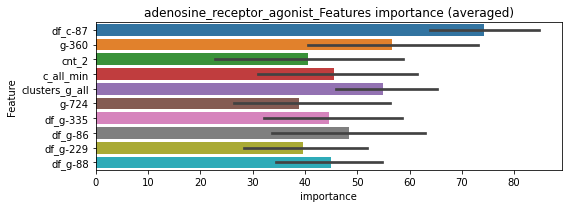

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273488	valid_1's binary_logloss: 0.0710183
[200]	training's binary_logloss: 0.00492872	valid_1's binary_logloss: 0.0471097
[300]	training's binary_logloss: 0.00147048	valid_1's binary_logloss: 0.0423226
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00108491	valid_1's binary_logloss: 0.041506


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279019	valid_1's binary_logloss: 0.0690597
[200]	training's binary_logloss: 0.00489056	valid_1's binary_logloss: 0.0428474
[300]	training's binary_logloss: 0.00147574	valid_1's binary_logloss: 0.0370004
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00114936	valid_1's binary_logloss: 0.0366387


adenosine_receptor_agonist logloss: 0.03907287109818649
adenosine_receptor_antagonist , len(trt) : 96


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  
0                          g-160                    df_c-87  
1                      c_all_max                      g-360  
2                       df_g-448           

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14593	valid_1's binary_logloss: 0.341057
[200]	training's binary_logloss: 0.0432404	valid_1's binary_logloss: 0.249302
[300]	training's binary_logloss: 0.015844	valid_1's binary_logloss: 0.210014
[400]	training's binary_logloss: 0.00767839	valid_1's binary_logloss: 0.193057
[500]	training's binary_logloss: 0.00470511	valid_1's binary_logloss: 0.186728
[600]	training's binary_logloss: 0.00338011	valid_1's binary_logloss: 0.183225
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00346982	valid_1's binary_logloss: 0.182692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140713	valid_1's binary_logloss: 0.351161
[200]	training's binary_logloss: 0.0401897	valid_1's binary_logloss: 0.258734
[300]	training's binary_logloss: 0.0147482	valid_1's binary_logloss: 0.222299


1 / 3 AUC score:0.971
Threshold: 0.3585868794158037


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00958655	valid_1's binary_logloss: 0.210086


Remove_noisy_labels: 74 → positive_corect_labels: 463/926
30th percentile: 0.05780
p_label_rate: 0.04445 Vs.target_rate: 0.00405, Num_p_label: 177.0, conf_0:0.05780, conf_1:0.47474
Num_p_label: 177.0, Expected: 16.1, Adj_threshold_1: 0.36
Num_p_label: 127.0, Expected: 16.1, Adj_threshold_2: 0.40
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_3: 0.44
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_4: 0.48
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_5: 0.52
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_6: 0.56
Num_p_label: 16.0, Expected: 16.1, Adj_threshold_7: 0.60
threshold:0.60, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:463.0/926, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132314	valid_1's binary_logloss: 0.311197
[200]	training's binary_logloss: 0.037103	valid_1's binary_logloss: 0.207858
[300]	training's binary_logloss: 0.0135728	valid_1's binary_logloss: 0.161121
[400]	training's binary_logloss: 0.00658357	valid_1's binary_logloss: 0.140458
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00554972	valid_1's binary_logloss: 0.135697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134768	valid_1's binary_logloss: 0.323488
[200]	training's binary_logloss: 0.0374598	valid_1's binary_logloss: 0.214023
[300]	training's binary_logloss: 0.0134249	valid_1's binary_logloss: 0.165992
[400]	training's binary_logloss: 0.00652422	valid_1's binary_logloss: 0.143774
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00448999	valid_1's binary_logloss: 0.13769


2 / 3 AUC score:0.991
Threshold: 0.5985868794158037
Remove_noisy_labels: 46 → positive_corect_labels: 424.0/880
30th percentile: 0.04410
p_label_rate: 0.00628 Vs.target_rate: 0.00405, Num_p_label: 25.0, conf_0:0.04410, conf_1:0.59859
threshold:0.60, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:424.0/880, y_label_rate: 0.48182
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130938	valid_1's binary_logloss: 0.275699
[200]	training's binary_logloss: 0.0351205	valid_1's binary_logloss: 0.166152
[300]	training's binary_logloss: 0.0126486	valid_1's binary_logloss: 0.120328
[400]	training's binary_logloss: 0.00624507	valid_1's binary_logloss: 0.101122
[500]	training's binary_logloss: 0.00398429	valid_1's binary_logloss: 0.0919096
[600]	training's binary_logloss: 0.00297287	valid_1's binary_logloss: 0.0863476
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00267099	valid_1's binary_logloss: 0.084362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126346	valid_1's binary_logloss: 0.287569
[200]	training's binary_logloss: 0.0331515	valid_1's binary_logloss: 0.178645
[300]	training's binary_logloss: 0.0117359	valid_1's binary_logloss: 0.141413
[400]	training's binary_logloss: 0.00579313	valid_1's binar

3 / 3 AUC score:0.994
Threshold: 0.5985868794158037
Remove_noisy_labels: 31 → positive_corect_labels: 397.0/849
30th percentile: 0.02308
p_label_rate: 0.00904 Vs.target_rate: 0.00405, Num_p_label: 36.0, conf_0:0.01012, conf_1:0.59859
threshold:0.60, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:433.0/4831, y_label_rate: 0.08963


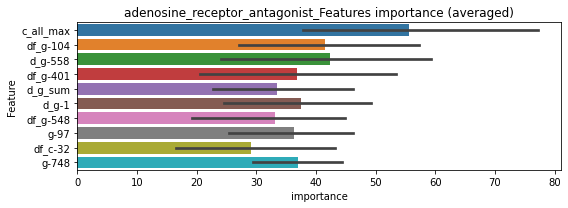

len(train_index) : 2415
len(valid_index) : 2416
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297634	valid_1's binary_logloss: 0.0911767
[200]	training's binary_logloss: 0.00615559	valid_1's binary_logloss: 0.0701046
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00368687	valid_1's binary_logloss: 0.068412


len(train_index) : 2416
len(valid_index) : 2415
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291204	valid_1's binary_logloss: 0.093384
[200]	training's binary_logloss: 0.0056629	valid_1's binary_logloss: 0.0715022
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00286542	valid_1's binary_logloss: 0.0698214


adenosine_receptor_antagonist logloss: 0.06911656276246071
adenylyl_cyclase_activator , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626183	valid_1's binary_logloss: 0.103197
[200]	training's binary_logloss: 0.00969248	valid_1's binary_logloss: 0.0343852
[300]	training's binary_logloss: 0.0030007	valid_1's binary_logloss: 0.0184442
[400]	training's binary_logloss: 0.00167238	valid_1's binary_logloss: 0.0146268
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00137548	valid_1's binary_logloss: 0.0130339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062558	valid_1's binary_logloss: 0.0895882
[200]	training's binary_logloss: 0.0102636	valid_1's binary_logloss: 0.0243877
[300]	training's binary_logloss: 0.00323239	valid_1's binary_logloss: 0.0111145
[400]	training's binary_logloss: 0.00176976	valid_1's binary_logloss: 0.00761299
[500]	training's binary_logloss: 0.00134096	valid_1's binary_logloss: 0.00643917
Early stopping, best iteration is:
[535]	traini

1 / 3 AUC score:1.000
Threshold: 0.8594968127176389
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00121
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00121, conf_1:0.85950
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626183	valid_1's binary_logloss: 0.103197
[200]	training's binary_logloss: 0.00969248	valid_1's binary_logloss: 0.0343852
[300]	training's binary_logloss: 0.0030007	valid_1's binary_logloss: 0.0184442
[400]	training's binary_logloss: 0.00167238	valid_1's binary_logloss: 0.0146268
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00137548	valid_1's binary_logloss: 0.0130339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062558	valid_1's binary_logloss: 0.0895882
[200]	training's binary_logloss: 0.0102636	valid_1's binary_logloss: 0.0243877
[300]	training's binary_logloss: 0.00323239	valid_1's binary_logloss: 0.0111145
[400]	training's binary_logloss: 0.00176976	valid_1's binary_logloss: 0.00761299
[500]	training's binary_logloss: 0.00134096	valid_1's binary_logloss: 0.00643917
Early stopping, best iteration is:
[535]	traini

2 / 3 AUC score:1.000
Threshold: 0.8594968127176389
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00121
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00121, conf_1:0.85950
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626183	valid_1's binary_logloss: 0.103197
[200]	training's binary_logloss: 0.00969248	valid_1's binary_logloss: 0.0343852
[300]	training's binary_logloss: 0.0030007	valid_1's binary_logloss: 0.0184442
[400]	training's binary_logloss: 0.00167238	valid_1's binary_logloss: 0.0146268
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00137548	valid_1's binary_logloss: 0.0130339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062558	valid_1's binary_logloss: 0.0895882
[200]	training's binary_logloss: 0.0102636	valid_1's binary_logloss: 0.0243877
[300]	training's binary_logloss: 0.00323239	valid_1's binary_logloss: 0.0111145
[400]	training's binary_logloss: 0.00176976	valid_1's binary_logloss: 0.00761299
[500]	training's binary_logloss: 0.00134096	valid_1's binary_logloss: 0.00643917
Early stopping, best iteration is:
[535]	traini

3 / 3 AUC score:1.000
Threshold: 0.8594968127176389
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00121
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00121, conf_1:0.85950
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


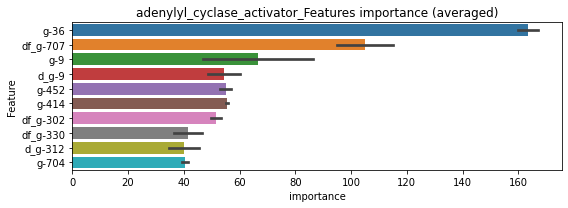

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145048	valid_1's binary_logloss: 0.023592
[200]	training's binary_logloss: 0.00172425	valid_1's binary_logloss: 0.00766781
[300]	training's binary_logloss: 0.000522731	valid_1's binary_logloss: 0.00517435
[400]	training's binary_logloss: 0.000294098	valid_1's binary_logloss: 0.00450366
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000294098	valid_1's binary_logloss: 0.00450366


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149987	valid_1's binary_logloss: 0.0204109
[200]	training's binary_logloss: 0.00185049	valid_1's binary_logloss: 0.00538446
[300]	training's binary_logloss: 0.000549291	valid_1's binary_logloss: 0.00333407
[400]	training's binary_logloss: 0.00029745	valid_1's binary_logloss: 0.00278961
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000268754	valid_1's binary_logloss: 0.00271002


adenylyl_cyclase_activator logloss: 0.00360683903525882
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200541	valid_1's binary_logloss: 0.576526
[200]	training's binary_logloss: 0.0743911	valid_1's binary_logloss: 0.552928
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0645438	valid_1's binary_logloss: 0.549416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211068	valid_1's binary_logloss: 0.577883
[200]	training's binary_logloss: 0.0791103	valid_1's binary_logloss: 0.535797
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0820114	valid_1's binary_logloss: 0.535439


1 / 3 AUC score:0.785
Threshold: 0.4859260119051858
Remove_noisy_labels: 298 → positive_corect_labels: 351/702
30th percentile: 0.33255
p_label_rate: 0.26971 Vs.target_rate: 0.00941, Num_p_label: 1074.0, conf_0:0.33255, conf_1:0.50920
Num_p_label: 1074.0, Expected: 37.5, Adj_threshold_1: 0.49
Num_p_label: 747.0, Expected: 37.5, Adj_threshold_2: 0.53
Num_p_label: 499.0, Expected: 37.5, Adj_threshold_3: 0.57
Num_p_label: 295.0, Expected: 37.5, Adj_threshold_4: 0.61
Num_p_label: 184.0, Expected: 37.5, Adj_threshold_5: 0.65
Num_p_label: 94.0, Expected: 37.5, Adj_threshold_6: 0.69
Num_p_label: 51.0, Expected: 37.5, Adj_threshold_7: 0.73
threshold:0.73, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:351.0/702, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184159	valid_1's binary_logloss: 0.505033
[200]	training's binary_logloss: 0.0636543	valid_1's binary_logloss: 0.44584
[300]	training's binary_logloss: 0.0259132	valid_1's binary_logloss: 0.425253
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0216069	valid_1's binary_logloss: 0.41928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182166	valid_1's binary_logloss: 0.491781
[200]	training's binary_logloss: 0.0630031	valid_1's binary_logloss: 0.422193
[300]	training's binary_logloss: 0.0258943	valid_1's binary_logloss: 0.388437


2 / 3 AUC score:0.898
Threshold: 0.725926011905186
Remove_noisy_labels: 142 → positive_corect_labels: 229.0/560
30th percentile: 0.22600
p_label_rate: 0.06806 Vs.target_rate: 0.00941, Num_p_label: 271.0, conf_0:0.22600, conf_1:0.72593
Num_p_label: 271.0, Expected: 37.5, Adj_threshold_1: 0.73


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0198085	valid_1's binary_logloss: 0.383572


Num_p_label: 207.0, Expected: 37.5, Adj_threshold_2: 0.77
Num_p_label: 164.0, Expected: 37.5, Adj_threshold_3: 0.81
Num_p_label: 128.0, Expected: 37.5, Adj_threshold_4: 0.85
Num_p_label: 99.0, Expected: 37.5, Adj_threshold_5: 0.89
Num_p_label: 70.0, Expected: 37.5, Adj_threshold_6: 0.93
threshold:0.97, positive p_label:70.0/3982, p_label_rate: 0.01758
positive y_label:229.0/560, y_label_rate: 0.40893
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154507	valid_1's binary_logloss: 0.363001
[200]	training's binary_logloss: 0.0489892	valid_1's binary_logloss: 0.274469
[300]	training's binary_logloss: 0.0195675	valid_1's binary_logloss: 0.238335
[400]	training's binary_logloss: 0.00988412	valid_1's binary_logloss: 0.220566
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00837536	valid_1's binary_logloss: 0.216334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148326	valid_1's binary_logloss: 0.423337
[200]	training's binary_logloss: 0.0447886	valid_1's binary_logloss: 0.350532
[300]	training's binary_logloss: 0.0172873	valid_1's binary_logloss: 0.318859
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0159548	valid_1's binary_logloss: 0.317107


3 / 3 AUC score:0.954
Threshold: 0.9659260119051862
Remove_noisy_labels: 161 → positive_corect_labels: 68.0/399
30th percentile: 0.07056
p_label_rate: 0.01055 Vs.target_rate: 0.00941, Num_p_label: 42.0, conf_0:0.07056, conf_1:0.96593
threshold:0.97, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:110.0/4381, y_label_rate: 0.02511


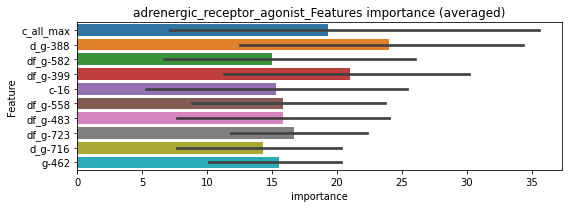

len(train_index) : 2190
len(valid_index) : 2191
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00742079	valid_1's binary_logloss: 0.0561674


len(train_index) : 2191
len(valid_index) : 2190
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00257823	valid_1's binary_logloss: 0.0534917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00720315	valid_1's binary_logloss: 0.0493386


adrenergic_receptor_agonist logloss: 0.05112239006714568
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00565537	valid_1's binary_logloss: 0.048752
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.350732	valid_1's binary_logloss: 0.671089
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.626
Threshold: 0.49958356409620097
Remove_noisy_labels: 412 → positive_corect_labels: 294/588
30th percentile: 0.44975
p_label_rate: 0.40030 Vs.target_rate: 0.01119, Num_p_label: 1594.0, conf_0:0.44975, conf_1:0.49958
Num_p_label: 1594.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 782.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 275.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 44.5, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:55.0/3982, p_label_rate: 0.01381


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.382035	valid_1's binary_logloss: 0.66378


positive y_label:294.0/588, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205761	valid_1's binary_logloss: 0.544952
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.167516	valid_1's binary_logloss: 0.534707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199921	valid_1's binary_logloss: 0.558535


2 / 3 AUC score:0.815
Threshold: 0.6195835640962011
Remove_noisy_labels: 161 → positive_corect_labels: 177.0/427
30th percentile: 0.36289
p_label_rate: 0.21698 Vs.target_rate: 0.01119, Num_p_label: 864.0, conf_0:0.36289, conf_1:0.61958
Num_p_label: 864.0, Expected: 44.5, Adj_threshold_1: 0.62
Num_p_label: 604.0, Expected: 44.5, Adj_threshold_2: 0.66
Num_p_label: 407.0, Expected: 44.5, Adj_threshold_3: 0.70
Num_p_label: 256.0, Expected: 44.5, Adj_threshold_4: 0.74


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0940913	valid_1's binary_logloss: 0.522659


Num_p_label: 139.0, Expected: 44.5, Adj_threshold_5: 0.78
Num_p_label: 69.0, Expected: 44.5, Adj_threshold_6: 0.82
Num_p_label: 25.0, Expected: 44.5, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:177.0/427, y_label_rate: 0.41452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173775	valid_1's binary_logloss: 0.362265
[200]	training's binary_logloss: 0.0598243	valid_1's binary_logloss: 0.286839
[300]	training's binary_logloss: 0.0243792	valid_1's binary_logloss: 0.261395
[400]	training's binary_logloss: 0.0124995	valid_1's binary_logloss: 0.248408
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.0109336	valid_1's binary_logloss: 0.245216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155076	valid_1's binary_logloss: 0.43879


3 / 3 AUC score:0.934
Threshold: 0.8595835640962013
Remove_noisy_labels: 98 → positive_corect_labels: 79.0/329
30th percentile: 0.11731
p_label_rate: 0.07082 Vs.target_rate: 0.01119, Num_p_label: 282.0, conf_0:0.09360, conf_1:0.85958
Num_p_label: 282.0, Expected: 44.5, Adj_threshold_1: 0.86
Num_p_label: 227.0, Expected: 44.5, Adj_threshold_2: 0.90
Num_p_label: 152.0, Expected: 44.5, Adj_threshold_3: 0.94


[200]	training's binary_logloss: 0.0502426	valid_1's binary_logloss: 0.392914
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0484414	valid_1's binary_logloss: 0.391831


threshold:0.98, positive p_label:152.0/3982, p_label_rate: 0.03817
positive y_label:231.0/4311, y_label_rate: 0.05358


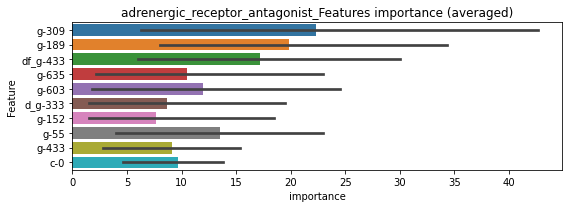

len(train_index) : 2155
len(valid_index) : 2156
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149064	valid_1's binary_logloss: 0.0943916


len(train_index) : 2156
len(valid_index) : 2155
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0158491	valid_1's binary_logloss: 0.0942384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162812	valid_1's binary_logloss: 0.0843399


adrenergic_receptor_antagonist logloss: 0.08869483813787314
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0128033	valid_1's binary_logloss: 0.0831487
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12738	valid_1's binary_logloss: 0.272284
[200]	training's binary_logloss: 0.0337203	valid_1's binary_logloss: 0.169836
[300]	training's binary_logloss: 0.011812	valid_1's binary_logloss: 0.1293
[400]	training's binary_logloss: 0.00572012	valid_1's binary_logloss: 0.112509
[500]	training's binary_logloss: 0.00353723	valid_1's binary_logloss: 0.104792
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00272972	valid_1's binary_logloss: 0.100617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131007	valid_1's binary_logloss: 0.266691
[200]	training's binary_logloss: 0.0352779	valid_1's binary_logloss: 0.157511
[300]	training's binary_logloss: 0.0126114	valid_1's binary_logloss: 0.116896
[400]	training's binary_logloss: 0.00612655	valid_1's binary_logloss: 0.0990205
[500]	training's binary_logloss: 0.00381178	valid_1's binary_log

1 / 3 AUC score:0.995
Threshold: 0.40960958526372665
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.02541
p_label_rate: 0.01256 Vs.target_rate: 0.00287, Num_p_label: 50.0, conf_0:0.02541, conf_1:0.44333
Num_p_label: 50.0, Expected: 11.4, Adj_threshold_1: 0.41
Num_p_label: 29.0, Expected: 11.4, Adj_threshold_2: 0.45
Num_p_label: 18.0, Expected: 11.4, Adj_threshold_3: 0.49
Num_p_label: 14.0, Expected: 11.4, Adj_threshold_4: 0.53
threshold:0.53, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121233	valid_1's binary_logloss: 0.284868
[200]	training's binary_logloss: 0.0316471	valid_1's binary_logloss: 0.181396
[300]	training's binary_logloss: 0.0110038	valid_1's binary_logloss: 0.13588
[400]	training's binary_logloss: 0.00540619	valid_1's binary_logloss: 0.121375
[500]	training's binary_logloss: 0.00343251	valid_1's binary_logloss: 0.111246
[600]	training's binary_logloss: 0.00257786	valid_1's binary_logloss: 0.105443
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00229618	valid_1's binary_logloss: 0.103294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124171	valid_1's binary_logloss: 0.265888
[200]	training's binary_logloss: 0.032317	valid_1's binary_logloss: 0.166624
[300]	training's binary_logloss: 0.0114733	valid_1's binary_logloss: 0.130542
[400]	training's binary_logloss: 0.00551928	valid_1's binary_lo

2 / 3 AUC score:0.993
Threshold: 0.5296095852637266
Remove_noisy_labels: 29 → positive_corect_labels: 460.0/943
30th percentile: 0.01827
p_label_rate: 0.00402 Vs.target_rate: 0.00287, Num_p_label: 16.0, conf_0:0.00842, conf_1:0.52961
threshold:0.53, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:460.0/943, y_label_rate: 0.48780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121615	valid_1's binary_logloss: 0.273099
[200]	training's binary_logloss: 0.0318274	valid_1's binary_logloss: 0.172508
[300]	training's binary_logloss: 0.0109945	valid_1's binary_logloss: 0.134339
[400]	training's binary_logloss: 0.00541823	valid_1's binary_logloss: 0.118563
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00570163	valid_1's binary_logloss: 0.118116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120193	valid_1's binary_logloss: 0.255199
[200]	training's binary_logloss: 0.0309128	valid_1's binary_logloss: 0.140074
[300]	training's binary_logloss: 0.0105614	valid_1's binary_logloss: 0.0956544
[400]	training's binary_logloss: 0.00517239	valid_1's binary_logloss: 0.0767789
[500]	training's binary_logloss: 0.00331485	valid_1's binary_logloss: 0.0684979
[600]	training's binary_logloss: 0.00250407	valid_1's bina

3 / 3 AUC score:0.996
Threshold: 0.5296095852637266
Remove_noisy_labels: 24 → positive_corect_labels: 441.0/919
30th percentile: 0.02023
p_label_rate: 0.00728 Vs.target_rate: 0.00287, Num_p_label: 29.0, conf_0:0.01925, conf_1:0.52961
threshold:0.53, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:470.0/4901, y_label_rate: 0.09590


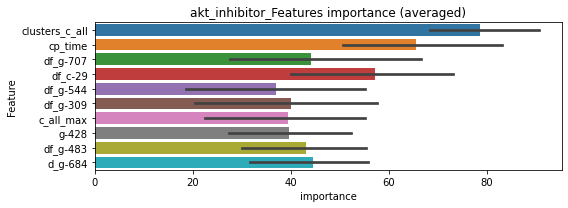

len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305802	valid_1's binary_logloss: 0.0803498
[200]	training's binary_logloss: 0.00622218	valid_1's binary_logloss: 0.0560013
[300]	training's binary_logloss: 0.00182959	valid_1's binary_logloss: 0.0506548
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00160333	valid_1's binary_logloss: 0.0503944


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03481	valid_1's binary_logloss: 0.091699
[200]	training's binary_logloss: 0.00684314	valid_1's binary_logloss: 0.0706805
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00355856	valid_1's binary_logloss: 0.0689679


akt_inhibitor logloss: 0.059679226881679044
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684316	valid_1's binary_logloss: 0.103436
[200]	training's binary_logloss: 0.0116981	valid_1's binary_logloss: 0.0283449
[300]	training's binary_logloss: 0.00373943	valid_1's binary_logloss: 0.0127841
[400]	training's binary_logloss: 0.00202321	valid_1's binary_logloss: 0.00844565
[500]	training's binary_logloss: 0.00150861	valid_1's binary_logloss: 0.00697155
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00144291	valid_1's binary_logloss: 0.00672437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648939	valid_1's binary_logloss: 0.125146
[200]	training's binary_logloss: 0.0110492	valid_1's binary_logloss: 0.044383
[300]	training's binary_logloss: 0.0035537	valid_1's binary_logloss: 0.023249
[400]	training's binary_logloss: 0.00193563	valid_1's binary_logloss: 0.0159817
[500]	training's binary_logloss: 0.00146103	valid

1 / 3 AUC score:1.000
Threshold: 0.45274106448383006
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00238
p_label_rate: 0.00000 Vs.target_rate: 0.00086, Num_p_label: 0.0, conf_0:0.00238, conf_1:0.45274
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_1: 0.45
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_2: 0.41
Num_p_label: 3.0, Expected: 3.4, Adj_threshold_3: 0.37
threshold:0.37, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684316	valid_1's binary_logloss: 0.103436
[200]	training's binary_logloss: 0.0116981	valid_1's binary_logloss: 0.0283449
[300]	training's binary_logloss: 0.00373943	valid_1's binary_logloss: 0.0127841
[400]	training's binary_logloss: 0.00202321	valid_1's binary_logloss: 0.00844565
[500]	training's binary_logloss: 0.00150861	valid_1's binary_logloss: 0.00697155
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00144291	valid_1's binary_logloss: 0.00672437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648939	valid_1's binary_logloss: 0.125146
[200]	training's binary_logloss: 0.0110492	valid_1's binary_logloss: 0.044383
[300]	training's binary_logloss: 0.0035537	valid_1's binary_logloss: 0.023249
[400]	training's binary_logloss: 0.00193563	valid_1's binary_logloss: 0.0159817
[500]	training's binary_logloss: 0.00146103	valid

2 / 3 AUC score:1.000
Threshold: 0.3727410644838301
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00238
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00238, conf_1:0.37274
threshold:0.37, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684316	valid_1's binary_logloss: 0.103436
[200]	training's binary_logloss: 0.0116981	valid_1's binary_logloss: 0.0283449
[300]	training's binary_logloss: 0.00373943	valid_1's binary_logloss: 0.0127841
[400]	training's binary_logloss: 0.00202321	valid_1's binary_logloss: 0.00844565
[500]	training's binary_logloss: 0.00150861	valid_1's binary_logloss: 0.00697155
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00144291	valid_1's binary_logloss: 0.00672437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648939	valid_1's binary_logloss: 0.125146
[200]	training's binary_logloss: 0.0110492	valid_1's binary_logloss: 0.044383
[300]	training's binary_logloss: 0.0035537	valid_1's binary_logloss: 0.023249
[400]	training's binary_logloss: 0.00193563	valid_1's binary_logloss: 0.0159817
[500]	training's binary_logloss: 0.00146103	valid

3 / 3 AUC score:1.000
Threshold: 0.3727410644838301
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00238
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00238, conf_1:0.37274
threshold:0.37, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


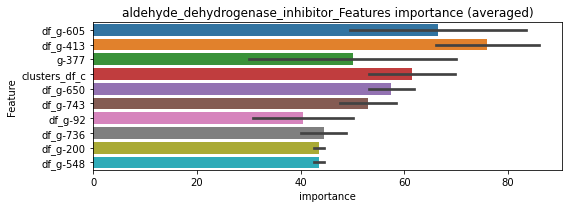

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017056	valid_1's binary_logloss: 0.0278054
[200]	training's binary_logloss: 0.00215233	valid_1's binary_logloss: 0.00864056
[300]	training's binary_logloss: 0.000620186	valid_1's binary_logloss: 0.00587341
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000649585	valid_1's binary_logloss: 0.00586146


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174633	valid_1's binary_logloss: 0.0346738
[200]	training's binary_logloss: 0.00210383	valid_1's binary_logloss: 0.0117267
[300]	training's binary_logloss: 0.000593304	valid_1's binary_logloss: 0.0089926
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00042188	valid_1's binary_logloss: 0.00864056


aldehyde_dehydrogenase_inhibitor logloss: 0.0072510075272525796
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101459	valid_1's binary_logloss: 0.204057
[200]	training's binary_logloss: 0.0223652	valid_1's binary_logloss: 0.0964702
[300]	training's binary_logloss: 0.00737185	valid_1's binary_logloss: 0.0663907
[400]	training's binary_logloss: 0.00364732	valid_1's binary_logloss: 0.0542108
[500]	training's binary_logloss: 0.00240506	valid_1's binary_logloss: 0.0494354
[600]	training's binary_logloss: 0.00192402	valid_1's binary_logloss: 0.0455199
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00182897	valid_1's binary_logloss: 0.0443006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10167	valid_1's binary_logloss: 0.188197
[200]	training's binary_logloss: 0.0229482	valid_1's binary_logloss: 0.0831391
[300]	training's binary_logloss: 0.00751553	valid_1's binary_logloss: 0.050543
[400]	training's binary_logloss: 0.00378924	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.46903146829651365
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00781
p_label_rate: 0.00226 Vs.target_rate: 0.00187, Num_p_label: 9.0, conf_0:0.00781, conf_1:0.46903
threshold:0.47, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979381	valid_1's binary_logloss: 0.18991
[200]	training's binary_logloss: 0.0217819	valid_1's binary_logloss: 0.0896839
[300]	training's binary_logloss: 0.00712798	valid_1's binary_logloss: 0.0576345
[400]	training's binary_logloss: 0.0035754	valid_1's binary_logloss: 0.0447363
[500]	training's binary_logloss: 0.00237529	valid_1's binary_logloss: 0.038592
[600]	training's binary_logloss: 0.00189881	valid_1's binary_logloss: 0.0359904
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00180453	valid_1's binary_logloss: 0.0356101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100515	valid_1's binary_logloss: 0.18473
[200]	training's binary_logloss: 0.0227153	valid_1's binary_logloss: 0.0830361
[300]	training's binary_logloss: 0.00746936	valid_1's binary_logloss: 0.0518326
[400]	training's binary_logloss: 0.00372068	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.46903146829651365
Remove_noisy_labels: 5 → positive_corect_labels: 492.0/985
30th percentile: 0.00774
p_label_rate: 0.00151 Vs.target_rate: 0.00187, Num_p_label: 6.0, conf_0:0.00774, conf_1:0.46903
threshold:0.47, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/985, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964995	valid_1's binary_logloss: 0.178272
[200]	training's binary_logloss: 0.0214833	valid_1's binary_logloss: 0.0821818
[300]	training's binary_logloss: 0.00703949	valid_1's binary_logloss: 0.0506034
[400]	training's binary_logloss: 0.00356114	valid_1's binary_logloss: 0.0399012
[500]	training's binary_logloss: 0.00240719	valid_1's binary_logloss: 0.0341769
[600]	training's binary_logloss: 0.00191493	valid_1's binary_logloss: 0.0315769
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00182621	valid_1's binary_logloss: 0.0311682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973215	valid_1's binary_logloss: 0.195342
[200]	training's binary_logloss: 0.02145	valid_1's binary_logloss: 0.0948009
[300]	training's binary_logloss: 0.00707685	valid_1's binary_logloss: 0.0618548
[400]	training's binary_logloss: 0.00359402	valid_1

3 / 3 AUC score:0.999
Threshold: 0.46903146829651365
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/977
30th percentile: 0.00768
p_label_rate: 0.00151 Vs.target_rate: 0.00187, Num_p_label: 6.0, conf_0:0.00768, conf_1:0.46903
threshold:0.47, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:493.0/4959, y_label_rate: 0.09942


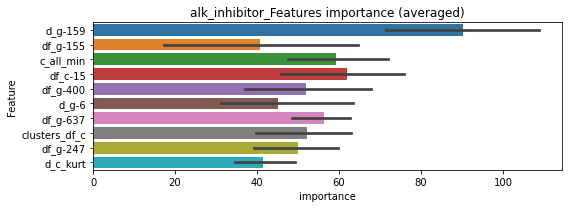

len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236471	valid_1's binary_logloss: 0.0588542
[200]	training's binary_logloss: 0.00389437	valid_1's binary_logloss: 0.0309894
[300]	training's binary_logloss: 0.00113406	valid_1's binary_logloss: 0.0243516
[400]	training's binary_logloss: 0.000565757	valid_1's binary_logloss: 0.0223062
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000418851	valid_1's binary_logloss: 0.021291


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258017	valid_1's binary_logloss: 0.0505653
[200]	training's binary_logloss: 0.00430828	valid_1's binary_logloss: 0.0241756
[300]	training's binary_logloss: 0.00120241	valid_1's binary_logloss: 0.0193703
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000899562	valid_1's binary_logloss: 0.0188154


alk_inhibitor logloss: 0.020053437521292062
ampk_activator , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494826	valid_1's binary_logloss: 0.0793684
[200]	training's binary_logloss: 0.0069536	valid_1's binary_logloss: 0.022715
[300]	training's binary_logloss: 0.00218921	valid_1's binary_logloss: 0.012672
[400]	training's binary_logloss: 0.0012861	valid_1's binary_logloss: 0.00965815
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110523	valid_1's binary_logloss: 0.00888979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499422	valid_1's binary_logloss: 0.0698854
[200]	training's binary_logloss: 0.00708197	valid_1's binary_logloss: 0.0156059
[300]	training's binary_logloss: 0.00232595	valid_1's binary_logloss: 0.00698739
[400]	training's binary_logloss: 0.00135392	valid_1's binary_logloss: 0.00480277
[500]	training's binary_logloss: 0.00114289	valid_1's binary_logloss: 0.00418748
Early stopping, best iteration is:
[491]	tra

1 / 3 AUC score:1.000
Threshold: 0.6322960861317155
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00094
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00094, conf_1:0.63230
threshold:0.63, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494826	valid_1's binary_logloss: 0.0793684
[200]	training's binary_logloss: 0.0069536	valid_1's binary_logloss: 0.022715
[300]	training's binary_logloss: 0.00218921	valid_1's binary_logloss: 0.012672
[400]	training's binary_logloss: 0.0012861	valid_1's binary_logloss: 0.00965815
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110523	valid_1's binary_logloss: 0.00888979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499422	valid_1's binary_logloss: 0.0698854
[200]	training's binary_logloss: 0.00708197	valid_1's binary_logloss: 0.0156059
[300]	training's binary_logloss: 0.00232595	valid_1's binary_logloss: 0.00698739
[400]	training's binary_logloss: 0.00135392	valid_1's binary_logloss: 0.00480277
[500]	training's binary_logloss: 0.00114289	valid_1's binary_logloss: 0.00418748


2 / 3 AUC score:1.000
Threshold: 0.6322960861317155
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000


Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00114289	valid_1's binary_logloss: 0.00418748


30th percentile: 0.00094
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00094, conf_1:0.63230
threshold:0.63, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494826	valid_1's binary_logloss: 0.0793684
[200]	training's binary_logloss: 0.0069536	valid_1's binary_logloss: 0.022715
[300]	training's binary_logloss: 0.00218921	valid_1's binary_logloss: 0.012672
[400]	training's binary_logloss: 0.0012861	valid_1's binary_logloss: 0.00965815
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110523	valid_1's binary_logloss: 0.00888979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499422	valid_1's binary_logloss: 0.0698854
[200]	training's binary_logloss: 0.00708197	valid_1's binary_logloss: 0.0156059
[300]	training's binary_logloss: 0.00232595	valid_1's binary_logloss: 0.00698739
[400]	training's binary_logloss: 0.00135392	valid_1's binary_logloss: 0.00480277


3 / 3 AUC score:1.000
Threshold: 0.6322960861317155


[500]	training's binary_logloss: 0.00114289	valid_1's binary_logloss: 0.00418748
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00114289	valid_1's binary_logloss: 0.00418748


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00094
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00094, conf_1:0.63230
threshold:0.63, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


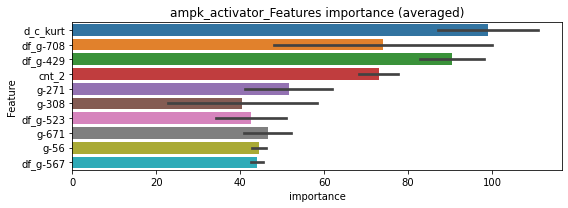

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124744	valid_1's binary_logloss: 0.0180805
[200]	training's binary_logloss: 0.0013267	valid_1's binary_logloss: 0.00538541
[300]	training's binary_logloss: 0.000393566	valid_1's binary_logloss: 0.00328146
[400]	training's binary_logloss: 0.000229404	valid_1's binary_logloss: 0.0027722
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000213918	valid_1's binary_logloss: 0.00272061


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121758	valid_1's binary_logloss: 0.018677
[200]	training's binary_logloss: 0.00130084	valid_1's binary_logloss: 0.00603173
[300]	training's binary_logloss: 0.000387091	valid_1's binary_logloss: 0.00383818
[400]	training's binary_logloss: 0.000226637	valid_1's binary_logloss: 0.00328936
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000219705	valid_1's binary_logloss: 0.00325858


ampk_activator logloss: 0.002989593933750061
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476226	valid_1's binary_logloss: 0.068973
[200]	training's binary_logloss: 0.00657537	valid_1's binary_logloss: 0.0172597
[300]	training's binary_logloss: 0.00213547	valid_1's binary_logloss: 0.00869411
[400]	training's binary_logloss: 0.00125814	valid_1's binary_logloss: 0.00644197
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0010769	valid_1's binary_logloss: 0.00576653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048377	valid_1's binary_logloss: 0.069593
[200]	training's binary_logloss: 0.00692068	valid_1's binary_logloss: 0.015249
[300]	training's binary_logloss: 0.00220873	valid_1's binary_logloss: 0.0059832
[400]	training's binary_logloss: 0.00128443	valid_1's binary_logloss: 0.00389793
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111976	valid_1's binary_logloss: 0.00360801


1 / 3 AUC score:1.000
Threshold: 0.6392492322740937
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00098
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00098, conf_1:0.63925
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.64
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.60
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.56
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.52
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_5: 0.48
threshold:0.48, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476226	valid_1's binary_logloss: 0.068973
[200]	training's binary_logloss: 0.00657537	valid_1's binary_logloss: 0.0172597
[300]	training's binary_logloss: 0.00213547	valid_1's binary_logloss: 0.00869411
[400]	training's binary_logloss: 0.00125814	valid_1's binary_logloss: 0.00644197
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0010769	valid_1's binary_logloss: 0.00576653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048377	valid_1's binary_logloss: 0.069593
[200]	training's binary_logloss: 0.00692068	valid_1's binary_logloss: 0.015249
[300]	training's binary_logloss: 0.00220873	valid_1's binary_logloss: 0.0059832
[400]	training's binary_logloss: 0.00128443	valid_1's binary_logloss: 0.00389793
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111976	valid_1's binary_logloss: 0.00360801


2 / 3 AUC score:1.000
Threshold: 0.4792492322740936
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00098
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00098, conf_1:0.47925
threshold:0.48, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476226	valid_1's binary_logloss: 0.068973
[200]	training's binary_logloss: 0.00657537	valid_1's binary_logloss: 0.0172597
[300]	training's binary_logloss: 0.00213547	valid_1's binary_logloss: 0.00869411
[400]	training's binary_logloss: 0.00125814	valid_1's binary_logloss: 0.00644197
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0010769	valid_1's binary_logloss: 0.00576653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048377	valid_1's binary_logloss: 0.069593
[200]	training's binary_logloss: 0.00692068	valid_1's binary_logloss: 0.015249
[300]	training's binary_logloss: 0.00220873	valid_1's binary_logloss: 0.0059832
[400]	training's binary_logloss: 0.00128443	valid_1's binary_logloss: 0.00389793
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111976	valid_1's binary_logloss: 0.00360801


3 / 3 AUC score:1.000
Threshold: 0.4792492322740936
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00098
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00098, conf_1:0.47925
threshold:0.48, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


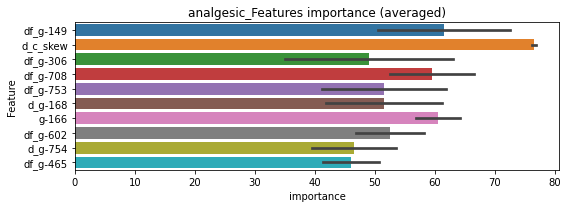

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121675	valid_1's binary_logloss: 0.0166279
[200]	training's binary_logloss: 0.00129564	valid_1's binary_logloss: 0.00347702
[300]	training's binary_logloss: 0.000387468	valid_1's binary_logloss: 0.00220212
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000297368	valid_1's binary_logloss: 0.00209031


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121253	valid_1's binary_logloss: 0.0185282
[200]	training's binary_logloss: 0.00126955	valid_1's binary_logloss: 0.00664722
[300]	training's binary_logloss: 0.000374036	valid_1's binary_logloss: 0.00509287
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000250257	valid_1's binary_logloss: 0.0048449


analgesic logloss: 0.003467604827409956
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10526	valid_1's binary_logloss: 0.219176
[200]	training's binary_logloss: 0.0250166	valid_1's binary_logloss: 0.116951
[300]	training's binary_logloss: 0.00842352	valid_1's binary_logloss: 0.0820239
[400]	training's binary_logloss: 0.00421615	valid_1's binary_logloss: 0.0692055
[500]	training's binary_logloss: 0.00274044	valid_1's binary_logloss: 0.0639276
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00221692	valid_1's binary_logloss: 0.0610526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104483	valid_1's binary_logloss: 0.220467
[200]	training's binary_logloss: 0.0245086	valid_1's binary_logloss: 0.124206
[300]	training's binary_logloss: 0.00838807	valid_1's binary_logloss: 0.0933405
[400]	training's binary_logloss: 0.00421035	valid_1's binary_logloss: 0.0793127
[500]	training's binary_logloss: 0.0027449	valid_1's b

1 / 3 AUC score:0.997
Threshold: 0.3110662238067815
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01283
p_label_rate: 0.01281 Vs.target_rate: 0.00212, Num_p_label: 51.0, conf_0:0.01283, conf_1:0.38530
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_1: 0.31
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_2: 0.35
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_3: 0.39
Num_p_label: 21.0, Expected: 8.4, Adj_threshold_4: 0.43
Num_p_label: 14.0, Expected: 8.4, Adj_threshold_5: 0.47
Num_p_label: 8.0, Expected: 8.4, Adj_threshold_6: 0.51
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101406	valid_1's binary_logloss: 0.210064
[200]	training's binary_logloss: 0.0236871	valid_1's binary_logloss: 0.128468
[300]	training's binary_logloss: 0.00800855	valid_1's binary_logloss: 0.0998063
[400]	training's binary_logloss: 0.00406675	valid_1's binary_logloss: 0.0919741
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00421552	valid_1's binary_logloss: 0.0913181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105229	valid_1's binary_logloss: 0.217621
[200]	training's binary_logloss: 0.024436	valid_1's binary_logloss: 0.111703
[300]	training's binary_logloss: 0.008344	valid_1's binary_logloss: 0.0764775
[400]	training's binary_logloss: 0.00418361	valid_1's binary_logloss: 0.0614797
[500]	training's binary_logloss: 0.00274834	valid_1's binary_logloss: 0.0546079
Early stopping, best iteration is:
[586]	training's bina

2 / 3 AUC score:0.995
Threshold: 0.5110662238067815
Remove_noisy_labels: 14 → positive_corect_labels: 480.0/970
30th percentile: 0.01652
p_label_rate: 0.00151 Vs.target_rate: 0.00212, Num_p_label: 6.0, conf_0:0.01652, conf_1:0.51107
threshold:0.51, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:480.0/970, y_label_rate: 0.49485
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101328	valid_1's binary_logloss: 0.217848
[200]	training's binary_logloss: 0.0234551	valid_1's binary_logloss: 0.122618
[300]	training's binary_logloss: 0.00793514	valid_1's binary_logloss: 0.0918513
[400]	training's binary_logloss: 0.0039958	valid_1's binary_logloss: 0.0785628
[500]	training's binary_logloss: 0.00263183	valid_1's binary_logloss: 0.0733965
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00221049	valid_1's binary_logloss: 0.0713271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102036	valid_1's binary_logloss: 0.211132
[200]	training's binary_logloss: 0.0228652	valid_1's binary_logloss: 0.103235
[300]	training's binary_logloss: 0.00775974	valid_1's binary_logloss: 0.0656708
[400]	training's binary_logloss: 0.00395709	valid_1's binary_logloss: 0.0509827
[500]	training's binary_logloss: 0.00263745	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.5110662238067815
Remove_noisy_labels: 13 → positive_corect_labels: 467.0/957
30th percentile: 0.01111
p_label_rate: 0.00201 Vs.target_rate: 0.00212, Num_p_label: 8.0, conf_0:0.01089, conf_1:0.51107
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:475.0/4939, y_label_rate: 0.09617


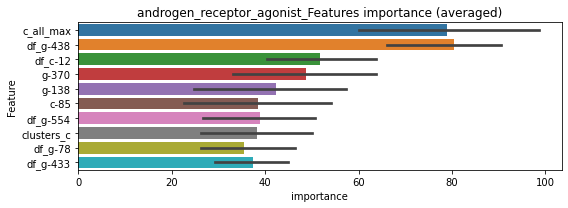

len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262058	valid_1's binary_logloss: 0.0550615
[200]	training's binary_logloss: 0.00432419	valid_1's binary_logloss: 0.0311109
[300]	training's binary_logloss: 0.0012872	valid_1's binary_logloss: 0.0279771
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00129898	valid_1's binary_logloss: 0.0279363


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268486	valid_1's binary_logloss: 0.0536737
[200]	training's binary_logloss: 0.00496216	valid_1's binary_logloss: 0.0290194
[300]	training's binary_logloss: 0.00141703	valid_1's binary_logloss: 0.0238104
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00147044	valid_1's binary_logloss: 0.0237773


androgen_receptor_agonist logloss: 0.025857194037508635
androgen_receptor_antagonist , len(trt) : 89


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140905	valid_1's binary_logloss: 0.302519
[200]	training's binary_logloss: 0.0411917	valid_1's binary_logloss: 0.208964
[300]	training's binary_logloss: 0.014943	valid_1's binary_logloss: 0.177561
[400]	training's binary_logloss: 0.00717421	valid_1's binary_logloss: 0.16147
[500]	training's binary_logloss: 0.00442939	valid_1's binary_logloss: 0.154209
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00376791	valid_1's binary_logloss: 0.151529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140426	valid_1's binary_logloss: 0.312832
[200]	training's binary_logloss: 0.0400827	valid_1's binary_logloss: 0.212519
[300]	training's binary_logloss: 0.0146058	valid_1's binary_logloss: 0.175039
[400]	training's binary_logloss: 0.00700587	valid_1's binary_logloss: 0.15893
[500]	training's binary_logloss: 0.00431278	valid_1's binary_log

1 / 3 AUC score:0.981
Threshold: 0.40208479144808074
Remove_noisy_labels: 48 → positive_corect_labels: 476/952
30th percentile: 0.03214
p_label_rate: 0.01934 Vs.target_rate: 0.00378, Num_p_label: 77.0, conf_0:0.03214, conf_1:0.53387
Num_p_label: 77.0, Expected: 15.0, Adj_threshold_1: 0.40
Num_p_label: 52.0, Expected: 15.0, Adj_threshold_2: 0.44
Num_p_label: 37.0, Expected: 15.0, Adj_threshold_3: 0.48
Num_p_label: 28.0, Expected: 15.0, Adj_threshold_4: 0.52
Num_p_label: 20.0, Expected: 15.0, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:476.0/952, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12819	valid_1's binary_logloss: 0.274707
[200]	training's binary_logloss: 0.0353629	valid_1's binary_logloss: 0.172668
[300]	training's binary_logloss: 0.0125535	valid_1's binary_logloss: 0.132654
[400]	training's binary_logloss: 0.0061471	valid_1's binary_logloss: 0.114895
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00491989	valid_1's binary_logloss: 0.112087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127096	valid_1's binary_logloss: 0.293652
[200]	training's binary_logloss: 0.0335631	valid_1's binary_logloss: 0.210084


2 / 3 AUC score:0.981
Threshold: 0.5620847914480808


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0157722	valid_1's binary_logloss: 0.193356


Remove_noisy_labels: 44 → positive_corect_labels: 439.0/908
30th percentile: 0.04266
p_label_rate: 0.00904 Vs.target_rate: 0.00378, Num_p_label: 36.0, conf_0:0.04266, conf_1:0.56208
threshold:0.56, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:439.0/908, y_label_rate: 0.48348
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112369	valid_1's binary_logloss: 0.261067
[200]	training's binary_logloss: 0.0292623	valid_1's binary_logloss: 0.163152
[300]	training's binary_logloss: 0.0104651	valid_1's binary_logloss: 0.125578
[400]	training's binary_logloss: 0.00530385	valid_1's binary_logloss: 0.108822
[500]	training's binary_logloss: 0.00343232	valid_1's binary_logloss: 0.100266
[600]	training's binary_logloss: 0.00260087	valid_1's binary_logloss: 0.0970861
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00250024	valid_1's binary_logloss: 0.0960088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12159	valid_1's binary_logloss: 0.263767
[200]	training's binary_logloss: 0.0322476	valid_1's binary_logloss: 0.156828
[300]	training's binary_logloss: 0.0113575	valid_1's binary_logloss: 0.118154
[400]	training's binary_logloss: 0.00560446	valid_1's binary

3 / 3 AUC score:0.995
Threshold: 0.5620847914480808
Remove_noisy_labels: 27 → positive_corect_labels: 415.0/881
30th percentile: 0.01631
p_label_rate: 0.00527 Vs.target_rate: 0.00378, Num_p_label: 21.0, conf_0:0.01631, conf_1:0.56208
threshold:0.56, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:436.0/4863, y_label_rate: 0.08966


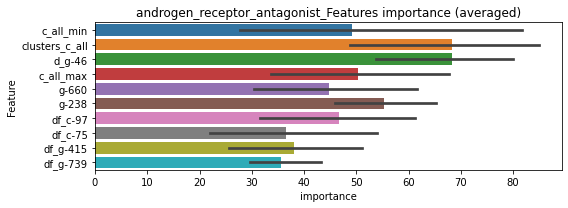

len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265825	valid_1's binary_logloss: 0.0787056
[200]	training's binary_logloss: 0.00510049	valid_1's binary_logloss: 0.0565893
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00245958	valid_1's binary_logloss: 0.054049


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261842	valid_1's binary_logloss: 0.0818864
[200]	training's binary_logloss: 0.00482197	valid_1's binary_logloss: 0.0627374
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00185666	valid_1's binary_logloss: 0.060645


androgen_receptor_antagonist logloss: 0.05734635949212034
anesthetic_-_local , len(trt) : 80


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129993	valid_1's binary_logloss: 0.277742
[200]	training's binary_logloss: 0.0359946	valid_1's binary_logloss: 0.175929
[300]	training's binary_logloss: 0.0130151	valid_1's binary_logloss: 0.132817
[400]	training's binary_logloss: 0.00640163	valid_1's binary_logloss: 0.116741
[500]	training's binary_logloss: 0.00397641	valid_1's binary_logloss: 0.107763
[600]	training's binary_logloss: 0.00291019	valid_1's binary_logloss: 0.102346
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00277346	valid_1's binary_logloss: 0.101841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124862	valid_1's binary_logloss: 0.287807
[200]	training's binary_logloss: 0.033745	valid_1's binary_logloss: 0.193974
[300]	training's binary_logloss: 0.0120458	valid_1's binary_logloss: 0.161624
[400]	training's binary_logloss: 0.00590857	valid_1's binary_l

1 / 3 AUC score:0.990
Threshold: 0.3833033210215129
Remove_noisy_labels: 46 → positive_corect_labels: 477/954
30th percentile: 0.02997
p_label_rate: 0.02938 Vs.target_rate: 0.00343, Num_p_label: 117.0, conf_0:0.02997, conf_1:0.54053
Num_p_label: 117.0, Expected: 13.6, Adj_threshold_1: 0.38
Num_p_label: 86.0, Expected: 13.6, Adj_threshold_2: 0.42
Num_p_label: 57.0, Expected: 13.6, Adj_threshold_3: 0.46
Num_p_label: 45.0, Expected: 13.6, Adj_threshold_4: 0.50
Num_p_label: 33.0, Expected: 13.6, Adj_threshold_5: 0.54
Num_p_label: 20.0, Expected: 13.6, Adj_threshold_6: 0.58
threshold:0.58, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:477.0/954, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122599	valid_1's binary_logloss: 0.2612
[200]	training's binary_logloss: 0.0321744	valid_1's binary_logloss: 0.150644
[300]	training's binary_logloss: 0.0113706	valid_1's binary_logloss: 0.108552
[400]	training's binary_logloss: 0.00565549	valid_1's binary_logloss: 0.090385
[500]	training's binary_logloss: 0.00361865	valid_1's binary_logloss: 0.0821628
[600]	training's binary_logloss: 0.00271354	valid_1's binary_logloss: 0.0765224
[700]	training's binary_logloss: 0.0022756	valid_1's binary_logloss: 0.0738541
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00222663	valid_1's binary_logloss: 0.0737063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121701	valid_1's binary_logloss: 0.27159
[200]	training's binary_logloss: 0.0315319	valid_1's binary_logloss: 0.168658
[300]	training's binary_logloss: 0.0112503	valid_1's binary_

2 / 3 AUC score:0.995
Threshold: 0.5833033210215129
Remove_noisy_labels: 27 → positive_corect_labels: 451.0/927
30th percentile: 0.02736
p_label_rate: 0.00352 Vs.target_rate: 0.00343, Num_p_label: 14.0, conf_0:0.02736, conf_1:0.58330
threshold:0.58, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:451.0/927, y_label_rate: 0.48652
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116801	valid_1's binary_logloss: 0.285111
[200]	training's binary_logloss: 0.0296609	valid_1's binary_logloss: 0.193239
[300]	training's binary_logloss: 0.0104225	valid_1's binary_logloss: 0.162829
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00958826	valid_1's binary_logloss: 0.160031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115668	valid_1's binary_logloss: 0.240488
[200]	training's binary_logloss: 0.0302953	valid_1's binary_logloss: 0.139502
[300]	training's binary_logloss: 0.0107523	valid_1's binary_logloss: 0.105056
[400]	training's binary_logloss: 0.00539845	valid_1's binary_logloss: 0.0886401
[500]	training's binary_logloss: 0.00347528	valid_1's binary_logloss: 0.08124
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00325146	valid_1's binary_logloss: 0.0805043


3 / 3 AUC score:0.989
Threshold: 0.5833033210215129
Remove_noisy_labels: 35 → positive_corect_labels: 418.0/892
30th percentile: 0.03290
p_label_rate: 0.00603 Vs.target_rate: 0.00343, Num_p_label: 24.0, conf_0:0.03290, conf_1:0.58330
threshold:0.58, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:442.0/4874, y_label_rate: 0.09069


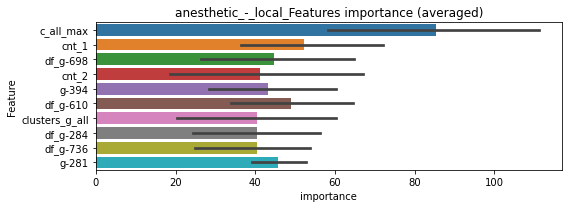

len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284206	valid_1's binary_logloss: 0.0732312
[200]	training's binary_logloss: 0.00580772	valid_1's binary_logloss: 0.0488201
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00302971	valid_1's binary_logloss: 0.0457636


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266443	valid_1's binary_logloss: 0.0766156
[200]	training's binary_logloss: 0.00505355	valid_1's binary_logloss: 0.0539055
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00505355	valid_1's binary_logloss: 0.0539055


anesthetic_-_local logloss: 0.04983455092475445
angiogenesis_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907226	valid_1's binary_logloss: 0.178914
[200]	training's binary_logloss: 0.0191552	valid_1's binary_logloss: 0.0839304
[300]	training's binary_logloss: 0.00625247	valid_1's binary_logloss: 0.0580837
[400]	training's binary_logloss: 0.00317118	valid_1's binary_logloss: 0.0489465
[500]	training's binary_logloss: 0.00213013	valid_1's binary_logloss: 0.0457185
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00178922	valid_1's binary_logloss: 0.0420585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939508	valid_1's binary_logloss: 0.162406
[200]	training's binary_logloss: 0.0199179	valid_1's binary_logloss: 0.0644461
[300]	training's binary_logloss: 0.00653008	valid_1's binary_logloss: 0.0371386
[400]	training's binary_logloss: 0.00329345	valid_1's binary_logloss: 0.0282033
[500]	training's binary_logloss: 0.00220131	valid

1 / 3 AUC score:1.000
Threshold: 0.6324980540639085
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00550
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00550, conf_1:0.63250
threshold:0.63, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922971	valid_1's binary_logloss: 0.178067
[200]	training's binary_logloss: 0.0194781	valid_1's binary_logloss: 0.0757335
[300]	training's binary_logloss: 0.00628544	valid_1's binary_logloss: 0.0458614
[400]	training's binary_logloss: 0.00318107	valid_1's binary_logloss: 0.0360993
[500]	training's binary_logloss: 0.00212052	valid_1's binary_logloss: 0.0320217
[600]	training's binary_logloss: 0.00172252	valid_1's binary_logloss: 0.0298491
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00170655	valid_1's binary_logloss: 0.0296188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914691	valid_1's binary_logloss: 0.163101
[200]	training's binary_logloss: 0.019053	valid_1's binary_logloss: 0.0634776
[300]	training's binary_logloss: 0.00625807	valid_1's binary_logloss: 0.0349146
[400]	training's binary_logloss: 0.00320399	valid_

2 / 3 AUC score:1.000
Threshold: 0.6324980540639085
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/988
30th percentile: 0.00565
p_label_rate: 0.00075 Vs.target_rate: 0.00161, Num_p_label: 3.0, conf_0:0.00565, conf_1:0.63250
threshold:0.63, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880346	valid_1's binary_logloss: 0.163817
[200]	training's binary_logloss: 0.0180507	valid_1's binary_logloss: 0.0709802
[300]	training's binary_logloss: 0.00590917	valid_1's binary_logloss: 0.0427926
[400]	training's binary_logloss: 0.00307255	valid_1's binary_logloss: 0.0330324
[500]	training's binary_logloss: 0.00208233	valid_1's binary_logloss: 0.0286603
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00176957	valid_1's binary_logloss: 0.0267767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917207	valid_1's binary_logloss: 0.162083
[200]	training's binary_logloss: 0.0187817	valid_1's binary_logloss: 0.0648719
[300]	training's binary_logloss: 0.00609071	valid_1's binary_logloss: 0.0392045
[400]	training's binary_logloss: 0.00312014	valid_1's binary_logloss: 0.0307942
[500]	training's binary_logloss: 0.00211022	valid

3 / 3 AUC score:1.000
Threshold: 0.6324980540639085
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/983
30th percentile: 0.00515
p_label_rate: 0.00326 Vs.target_rate: 0.00161, Num_p_label: 13.0, conf_0:0.00515, conf_1:0.63250
threshold:0.63, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:504.0/4965, y_label_rate: 0.10151


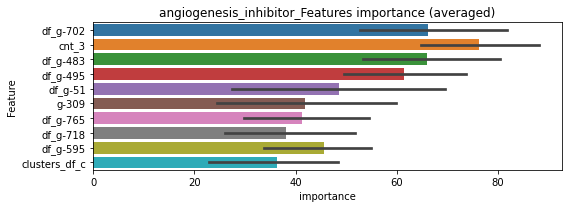

len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222168	valid_1's binary_logloss: 0.0436777
[200]	training's binary_logloss: 0.00334576	valid_1's binary_logloss: 0.0185704
[300]	training's binary_logloss: 0.000998187	valid_1's binary_logloss: 0.0144228
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000686399	valid_1's binary_logloss: 0.0137538


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223098	valid_1's binary_logloss: 0.0441305
[200]	training's binary_logloss: 0.00336907	valid_1's binary_logloss: 0.0188153
[300]	training's binary_logloss: 0.000992087	valid_1's binary_logloss: 0.0144532
[400]	training's binary_logloss: 0.000508784	valid_1's binary_logloss: 0.0132485
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000513684	valid_1's binary_logloss: 0.013228


angiogenesis_inhibitor logloss: 0.013490952211586771
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895607	valid_1's binary_logloss: 0.167213
[200]	training's binary_logloss: 0.0186343	valid_1's binary_logloss: 0.0727312
[300]	training's binary_logloss: 0.00612746	valid_1's binary_logloss: 0.0451967
[400]	training's binary_logloss: 0.00316807	valid_1's binary_logloss: 0.0354108
[500]	training's binary_logloss: 0.00213492	valid_1's binary_logloss: 0.0304176
[600]	training's binary_logloss: 0.00176787	valid_1's binary_logloss: 0.0280693
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00171391	valid_1's binary_logloss: 0.0275888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086128	valid_1's binary_logloss: 0.154136
[200]	training's binary_logloss: 0.0183179	valid_1's binary_logloss: 0.0631402
[300]	training's binary_logloss: 0.00599712	valid_1's binary_logloss: 0.0363878
[400]	training's binary_logloss: 0.00309838	valid_

1 / 3 AUC score:1.000
Threshold: 0.43926998508076587
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00558
p_label_rate: 0.00653 Vs.target_rate: 0.00165, Num_p_label: 26.0, conf_0:0.00558, conf_1:0.46023
Num_p_label: 26.0, Expected: 6.6, Adj_threshold_1: 0.44
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_2: 0.48
Num_p_label: 16.0, Expected: 6.6, Adj_threshold_3: 0.52
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_4: 0.56
threshold:0.56, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086303	valid_1's binary_logloss: 0.15939
[200]	training's binary_logloss: 0.0180061	valid_1's binary_logloss: 0.0699657
[300]	training's binary_logloss: 0.00593475	valid_1's binary_logloss: 0.0423409
[400]	training's binary_logloss: 0.00307316	valid_1's binary_logloss: 0.0326909
[500]	training's binary_logloss: 0.00209325	valid_1's binary_logloss: 0.0279614
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0017585	valid_1's binary_logloss: 0.0257795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876409	valid_1's binary_logloss: 0.151319
[200]	training's binary_logloss: 0.0183088	valid_1's binary_logloss: 0.0629254
[300]	training's binary_logloss: 0.00609115	valid_1's binary_logloss: 0.0376197
[400]	training's binary_logloss: 0.00311798	valid_1's binary_logloss: 0.0288123
[500]	training's binary_logloss: 0.0021227	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5592699850807659
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/992
30th percentile: 0.00528
p_label_rate: 0.00176 Vs.target_rate: 0.00165, Num_p_label: 7.0, conf_0:0.00528, conf_1:0.55927
threshold:0.56, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:493.0/992, y_label_rate: 0.49698
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902125	valid_1's binary_logloss: 0.155289
[200]	training's binary_logloss: 0.0190741	valid_1's binary_logloss: 0.0628346
[300]	training's binary_logloss: 0.00615083	valid_1's binary_logloss: 0.0377211
[400]	training's binary_logloss: 0.00315347	valid_1's binary_logloss: 0.0279252
[500]	training's binary_logloss: 0.00211208	valid_1's binary_logloss: 0.0234321
[600]	training's binary_logloss: 0.00173025	valid_1's binary_logloss: 0.0212336
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00165336	valid_1's binary_logloss: 0.0208719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849063	valid_1's binary_logloss: 0.146609
[200]	training's binary_logloss: 0.0176057	valid_1's binary_logloss: 0.0586575
[300]	training's binary_logloss: 0.00586845	valid_1's binary_logloss: 0.0344546
[400]	training's binary_logloss: 0.00304822	valid

3 / 3 AUC score:1.000
Threshold: 0.5592699850807659
Remove_noisy_labels: 2 → positive_corect_labels: 492.0/990
30th percentile: 0.00510
p_label_rate: 0.00201 Vs.target_rate: 0.00165, Num_p_label: 8.0, conf_0:0.00510, conf_1:0.55927
threshold:0.56, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:500.0/4972, y_label_rate: 0.10056


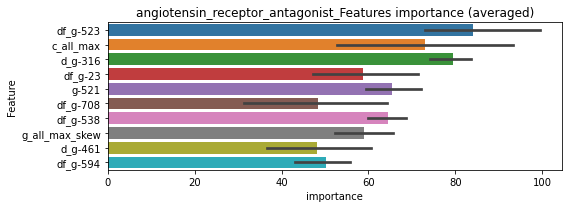

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245609	valid_1's binary_logloss: 0.0408738
[200]	training's binary_logloss: 0.00387285	valid_1's binary_logloss: 0.0166196
[300]	training's binary_logloss: 0.00109843	valid_1's binary_logloss: 0.0122531
[400]	training's binary_logloss: 0.00054433	valid_1's binary_logloss: 0.0115319
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000570652	valid_1's binary_logloss: 0.0115235


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234793	valid_1's binary_logloss: 0.0502191
[200]	training's binary_logloss: 0.00361352	valid_1's binary_logloss: 0.0238612
[300]	training's binary_logloss: 0.00104529	valid_1's binary_logloss: 0.0173255
[400]	training's binary_logloss: 0.000524891	valid_1's binary_logloss: 0.0158285
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000501888	valid_1's binary_logloss: 0.0157341


angiotensin_receptor_antagonist logloss: 0.013628822741013468
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124837	valid_1's binary_logloss: 0.301425
[200]	training's binary_logloss: 0.0339848	valid_1's binary_logloss: 0.21723
[300]	training's binary_logloss: 0.0121887	valid_1's binary_logloss: 0.188245
[400]	training's binary_logloss: 0.00590931	valid_1's binary_logloss: 0.171012
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00462786	valid_1's binary_logloss: 0.166467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131933	valid_1's binary_logloss: 0.287239
[200]	training's binary_logloss: 0.0359994	valid_1's binary_logloss: 0.180363
[300]	training's binary_logloss: 0.0129169	valid_1's binary_logloss: 0.141953
[400]	training's binary_logloss: 0.00626964	valid_1's binary_logloss: 0.11925
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00455883	valid_1's binary_logloss: 0.112503


1 / 3 AUC score:0.984
Threshold: 0.38242327938717163
Remove_noisy_labels: 46 → positive_corect_labels: 477/954
30th percentile: 0.03754
p_label_rate: 0.02788 Vs.target_rate: 0.00315, Num_p_label: 111.0, conf_0:0.03754, conf_1:0.53551
Num_p_label: 111.0, Expected: 12.5, Adj_threshold_1: 0.38
Num_p_label: 77.0, Expected: 12.5, Adj_threshold_2: 0.42
Num_p_label: 51.0, Expected: 12.5, Adj_threshold_3: 0.46
Num_p_label: 35.0, Expected: 12.5, Adj_threshold_4: 0.50
Num_p_label: 27.0, Expected: 12.5, Adj_threshold_5: 0.54
Num_p_label: 18.0, Expected: 12.5, Adj_threshold_6: 0.58
threshold:0.58, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:477.0/954, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122524	valid_1's binary_logloss: 0.238457
[200]	training's binary_logloss: 0.0327399	valid_1's binary_logloss: 0.137469
[300]	training's binary_logloss: 0.0117315	valid_1's binary_logloss: 0.0981075
[400]	training's binary_logloss: 0.00581988	valid_1's binary_logloss: 0.0785656
[500]	training's binary_logloss: 0.00369625	valid_1's binary_logloss: 0.0688296
[600]	training's binary_logloss: 0.00275177	valid_1's binary_logloss: 0.0629157
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.00235075	valid_1's binary_logloss: 0.0604865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11889	valid_1's binary_logloss: 0.254897
[200]	training's binary_logloss: 0.0309025	valid_1's binary_logloss: 0.151313
[300]	training's binary_logloss: 0.0110598	valid_1's binary_logloss: 0.114997
[400]	training's binary_logloss: 0.00549977	valid_1's bin

2 / 3 AUC score:0.998
Threshold: 0.5824232793871716
Remove_noisy_labels: 18 → positive_corect_labels: 459.0/936
30th percentile: 0.02237
p_label_rate: 0.00603 Vs.target_rate: 0.00315, Num_p_label: 24.0, conf_0:0.02237, conf_1:0.58242
threshold:0.58, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:459.0/936, y_label_rate: 0.49038
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120191	valid_1's binary_logloss: 0.237442
[200]	training's binary_logloss: 0.031862	valid_1's binary_logloss: 0.13715
[300]	training's binary_logloss: 0.0114432	valid_1's binary_logloss: 0.101265
[400]	training's binary_logloss: 0.00567579	valid_1's binary_logloss: 0.0866423
[500]	training's binary_logloss: 0.00364117	valid_1's binary_logloss: 0.0789372
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00332231	valid_1's binary_logloss: 0.077575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113178	valid_1's binary_logloss: 0.254152
[200]	training's binary_logloss: 0.0288641	valid_1's binary_logloss: 0.158813
[300]	training's binary_logloss: 0.0100026	valid_1's binary_logloss: 0.120254
[400]	training's binary_logloss: 0.00505228	valid_1's binary_logloss: 0.103014
[500]	training's binary_logloss: 0.00324439	valid_1's binary_

3 / 3 AUC score:0.997
Threshold: 0.5824232793871716
Remove_noisy_labels: 20 → positive_corect_labels: 445.0/916
30th percentile: 0.02102
p_label_rate: 0.00829 Vs.target_rate: 0.00315, Num_p_label: 33.0, conf_0:0.02102, conf_1:0.58242
threshold:0.58, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:478.0/4898, y_label_rate: 0.09759


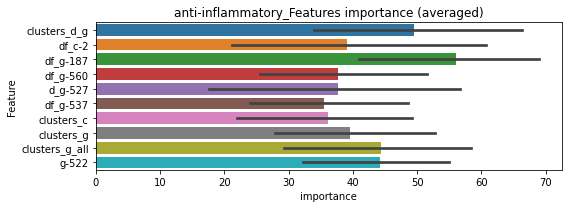

len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332414	valid_1's binary_logloss: 0.0700795
[200]	training's binary_logloss: 0.00661861	valid_1's binary_logloss: 0.0414504
[300]	training's binary_logloss: 0.00199064	valid_1's binary_logloss: 0.0365924
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00141143	valid_1's binary_logloss: 0.0360599


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318178	valid_1's binary_logloss: 0.0846755
[200]	training's binary_logloss: 0.00685566	valid_1's binary_logloss: 0.0592336
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00454811	valid_1's binary_logloss: 0.0566174


anti-inflammatory logloss: 0.04633861371393146
antiarrhythmic , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732601	valid_1's binary_logloss: 0.119547
[200]	training's binary_logloss: 0.013226	valid_1's binary_logloss: 0.0389559
[300]	training's binary_logloss: 0.00428332	valid_1's binary_logloss: 0.0208739
[400]	training's binary_logloss: 0.00229723	valid_1's binary_logloss: 0.0145495
[500]	training's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0118203
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00160193	valid_1's binary_logloss: 0.0115862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073135	valid_1's binary_logloss: 0.125409
[200]	training's binary_logloss: 0.013348	valid_1's binary_logloss: 0.044606
[300]	training's binary_logloss: 0.00429301	valid_1's binary_logloss: 0.0248573
[400]	training's binary_logloss: 0.00226545	valid_1's binary_logloss: 0.0188678
[500]	training's binary_logloss: 0.00160004	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.4077856893019105
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00336
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00336, conf_1:0.40779
threshold:0.41, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732601	valid_1's binary_logloss: 0.119547
[200]	training's binary_logloss: 0.013226	valid_1's binary_logloss: 0.0389559
[300]	training's binary_logloss: 0.00428332	valid_1's binary_logloss: 0.0208739
[400]	training's binary_logloss: 0.00229723	valid_1's binary_logloss: 0.0145495
[500]	training's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0118203
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00160193	valid_1's binary_logloss: 0.0115862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073135	valid_1's binary_logloss: 0.125409
[200]	training's binary_logloss: 0.013348	valid_1's binary_logloss: 0.044606
[300]	training's binary_logloss: 0.00429301	valid_1's binary_logloss: 0.0248573
[400]	training's binary_logloss: 0.00226545	valid_1's binary_logloss: 0.0188678
[500]	training's binary_logloss: 0.00160004	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.4077856893019105
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00336
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00336, conf_1:0.40779
threshold:0.41, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732601	valid_1's binary_logloss: 0.119547
[200]	training's binary_logloss: 0.013226	valid_1's binary_logloss: 0.0389559
[300]	training's binary_logloss: 0.00428332	valid_1's binary_logloss: 0.0208739
[400]	training's binary_logloss: 0.00229723	valid_1's binary_logloss: 0.0145495
[500]	training's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0118203
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00160193	valid_1's binary_logloss: 0.0115862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073135	valid_1's binary_logloss: 0.125409
[200]	training's binary_logloss: 0.013348	valid_1's binary_logloss: 0.044606
[300]	training's binary_logloss: 0.00429301	valid_1's binary_logloss: 0.0248573
[400]	training's binary_logloss: 0.00226545	valid_1's binary_logloss: 0.0188678
[500]	training's binary_logloss: 0.00160004	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.4077856893019105
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00336
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00336, conf_1:0.40779
threshold:0.41, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4982, y_label_rate: 0.10136


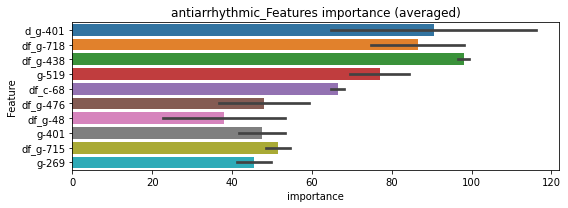

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200079	valid_1's binary_logloss: 0.0269366
[200]	training's binary_logloss: 0.00268298	valid_1's binary_logloss: 0.00720722
[300]	training's binary_logloss: 0.000769366	valid_1's binary_logloss: 0.00473139
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000450976	valid_1's binary_logloss: 0.0044478


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183381	valid_1's binary_logloss: 0.0339789
[200]	training's binary_logloss: 0.00244774	valid_1's binary_logloss: 0.014834
[300]	training's binary_logloss: 0.000709181	valid_1's binary_logloss: 0.012554
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000518613	valid_1's binary_logloss: 0.0123456


antiarrhythmic logloss: 0.008396701412290266
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102466	valid_1's binary_logloss: 0.199939
[200]	training's binary_logloss: 0.0234828	valid_1's binary_logloss: 0.103084
[300]	training's binary_logloss: 0.00771057	valid_1's binary_logloss: 0.0715003
[400]	training's binary_logloss: 0.00388366	valid_1's binary_logloss: 0.0595032
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00294838	valid_1's binary_logloss: 0.0549824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100396	valid_1's binary_logloss: 0.199242
[200]	training's binary_logloss: 0.0229049	valid_1's binary_logloss: 0.101504
[300]	training's binary_logloss: 0.00758967	valid_1's binary_logloss: 0.0707722
[400]	training's binary_logloss: 0.00384331	valid_1's binary_logloss: 0.0582414
[500]	training's binary_logloss: 0.00252035	valid_1's binary_logloss: 0.0535239
[600]	training's binary_logloss: 0.00197895	valid_1's

1 / 3 AUC score:0.999
Threshold: 0.43891996920522247
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.00931
p_label_rate: 0.00552 Vs.target_rate: 0.00191, Num_p_label: 22.0, conf_0:0.00921, conf_1:0.44721
threshold:0.44, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100843	valid_1's binary_logloss: 0.191613
[200]	training's binary_logloss: 0.0228191	valid_1's binary_logloss: 0.0938424
[300]	training's binary_logloss: 0.00772596	valid_1's binary_logloss: 0.0632353
[400]	training's binary_logloss: 0.00389112	valid_1's binary_logloss: 0.049494
[500]	training's binary_logloss: 0.00256496	valid_1's binary_logloss: 0.0444412
[600]	training's binary_logloss: 0.00200063	valid_1's binary_logloss: 0.0414464
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.0019292	valid_1's binary_logloss: 0.0410477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102353	valid_1's binary_logloss: 0.190164
[200]	training's binary_logloss: 0.023199	valid_1's binary_logloss: 0.0930903
[300]	training's binary_logloss: 0.00783398	valid_1's binary_logloss: 0.0603988
[400]	training's binary_logloss: 0.00392901	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.43891996920522247
Remove_noisy_labels: 8 → positive_corect_labels: 486.0/974
30th percentile: 0.00733
p_label_rate: 0.00879 Vs.target_rate: 0.00191, Num_p_label: 35.0, conf_0:0.00563, conf_1:0.43892
Num_p_label: 35.0, Expected: 7.6, Adj_threshold_1: 0.44
Num_p_label: 25.0, Expected: 7.6, Adj_threshold_2: 0.48
Num_p_label: 15.0, Expected: 7.6, Adj_threshold_3: 0.52
Num_p_label: 10.0, Expected: 7.6, Adj_threshold_4: 0.56
threshold:0.56, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:486.0/974, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104838	valid_1's binary_logloss: 0.200597
[200]	training's binary_logloss: 0.023875	valid_1's binary_logloss: 0.0966901
[300]	training's binary_logloss: 0.00791261	valid_1's binary_logloss: 0.0646176
[400]	training's binary_logloss: 0.00391806	valid_1's binary_logloss: 0.0512622
[500]	training's binary_logloss: 0.00254697	valid_1's binary_logloss: 0.0444421
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00221574	valid_1's binary_logloss: 0.042095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923068	valid_1's binary_logloss: 0.189938
[200]	training's binary_logloss: 0.0205014	valid_1's binary_logloss: 0.0936661
[300]	training's binary_logloss: 0.00702613	valid_1's binary_logloss: 0.0597798
[400]	training's binary_logloss: 0.0036176	valid_1's binary_logloss: 0.0478394
[500]	training's binary_logloss: 0.00239931	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5589199692052225
Remove_noisy_labels: 9 → positive_corect_labels: 478.0/965
30th percentile: 0.00773
p_label_rate: 0.00251 Vs.target_rate: 0.00191, Num_p_label: 10.0, conf_0:0.00640, conf_1:0.55892
threshold:0.56, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:488.0/4947, y_label_rate: 0.09865


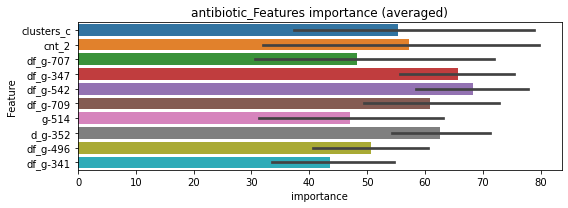

len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269337	valid_1's binary_logloss: 0.051859
[200]	training's binary_logloss: 0.00445163	valid_1's binary_logloss: 0.0236187
[300]	training's binary_logloss: 0.00127115	valid_1's binary_logloss: 0.0178613
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00119745	valid_1's binary_logloss: 0.0177633


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260633	valid_1's binary_logloss: 0.0554418
[200]	training's binary_logloss: 0.00412845	valid_1's binary_logloss: 0.0292414
[300]	training's binary_logloss: 0.00120305	valid_1's binary_logloss: 0.0236354
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000676383	valid_1's binary_logloss: 0.0221485


antibiotic logloss: 0.01995547400449398
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601839	valid_1's binary_logloss: 0.0937332
[200]	training's binary_logloss: 0.00978583	valid_1's binary_logloss: 0.0268018
[300]	training's binary_logloss: 0.00310671	valid_1's binary_logloss: 0.0130538
[400]	training's binary_logloss: 0.00172217	valid_1's binary_logloss: 0.00943324
[500]	training's binary_logloss: 0.00128716	valid_1's binary_logloss: 0.00792462
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00120227	valid_1's binary_logloss: 0.00755689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610509	valid_1's binary_logloss: 0.0923305
[200]	training's binary_logloss: 0.00975595	valid_1's binary_logloss: 0.0259504
[300]	training's binary_logloss: 0.00315892	valid_1's binary_logloss: 0.0131221
[400]	training's binary_logloss: 0.00171947	valid_1's binary_logloss: 0.00928384
[500]	training's binary_logloss: 0.001302

1 / 3 AUC score:1.000
Threshold: 0.5736154015414063
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00171
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00171, conf_1:0.57362
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.57
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.53
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.49
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.45
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_5: 0.41
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601839	valid_1's binary_logloss: 0.0937332
[200]	training's binary_logloss: 0.00978583	valid_1's binary_logloss: 0.0268018
[300]	training's binary_logloss: 0.00310671	valid_1's binary_logloss: 0.0130538
[400]	training's binary_logloss: 0.00172217	valid_1's binary_logloss: 0.00943324
[500]	training's binary_logloss: 0.00128716	valid_1's binary_logloss: 0.00792462
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00120227	valid_1's binary_logloss: 0.00755689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610509	valid_1's binary_logloss: 0.0923305
[200]	training's binary_logloss: 0.00975595	valid_1's binary_logloss: 0.0259504
[300]	training's binary_logloss: 0.00315892	valid_1's binary_logloss: 0.0131221
[400]	training's binary_logloss: 0.00171947	valid_1's binary_logloss: 0.00928384
[500]	training's binary_logloss: 0.001302

2 / 3 AUC score:1.000
Threshold: 0.41361540154140636
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00171
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00171, conf_1:0.41362
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601839	valid_1's binary_logloss: 0.0937332
[200]	training's binary_logloss: 0.00978583	valid_1's binary_logloss: 0.0268018
[300]	training's binary_logloss: 0.00310671	valid_1's binary_logloss: 0.0130538
[400]	training's binary_logloss: 0.00172217	valid_1's binary_logloss: 0.00943324
[500]	training's binary_logloss: 0.00128716	valid_1's binary_logloss: 0.00792462
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00120227	valid_1's binary_logloss: 0.00755689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610509	valid_1's binary_logloss: 0.0923305
[200]	training's binary_logloss: 0.00975595	valid_1's binary_logloss: 0.0259504
[300]	training's binary_logloss: 0.00315892	valid_1's binary_logloss: 0.0131221
[400]	training's binary_logloss: 0.00171947	valid_1's binary_logloss: 0.00928384
[500]	training's binary_logloss: 0.001302

3 / 3 AUC score:1.000
Threshold: 0.41361540154140636
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00171
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00171, conf_1:0.41362
threshold:0.41, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


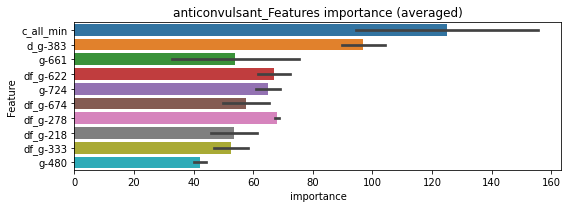

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148579	valid_1's binary_logloss: 0.0255986
[200]	training's binary_logloss: 0.00175204	valid_1's binary_logloss: 0.010282
[300]	training's binary_logloss: 0.000524624	valid_1's binary_logloss: 0.0079392
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000370952	valid_1's binary_logloss: 0.00755923


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145455	valid_1's binary_logloss: 0.0270588
[200]	training's binary_logloss: 0.00173679	valid_1's binary_logloss: 0.0125124
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000678491	valid_1's binary_logloss: 0.0110442


anticonvulsant logloss: 0.00930171583354002
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790707	valid_1's binary_logloss: 0.13593
[200]	training's binary_logloss: 0.0148494	valid_1's binary_logloss: 0.0429137
[300]	training's binary_logloss: 0.004748	valid_1's binary_logloss: 0.0218299
[400]	training's binary_logloss: 0.0024744	valid_1's binary_logloss: 0.0149616
[500]	training's binary_logloss: 0.00169944	valid_1's binary_logloss: 0.0120994
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00150849	valid_1's binary_logloss: 0.0112019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771506	valid_1's binary_logloss: 0.137224
[200]	training's binary_logloss: 0.0144809	valid_1's binary_logloss: 0.0490977
[300]	training's binary_logloss: 0.00466767	valid_1's binary_logloss: 0.0251743
[400]	training's binary_logloss: 0.0024333	valid_1's binary_logloss: 0.0172964
[500]	training's binary_logloss: 0.00168785	valid_1's 

1 / 3 AUC score:1.000
Threshold: 0.6080883974594392
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00334
p_label_rate: 0.00025 Vs.target_rate: 0.00117, Num_p_label: 1.0, conf_0:0.00334, conf_1:0.60809
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_1: 0.61
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_2: 0.57
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_3: 0.53
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_4: 0.49
Num_p_label: 1.0, Expected: 4.7, Adj_threshold_5: 0.45
Num_p_label: 2.0, Expected: 4.7, Adj_threshold_6: 0.41
Num_p_label: 4.0, Expected: 4.7, Adj_threshold_7: 0.37
threshold:0.37, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790707	valid_1's binary_logloss: 0.13593
[200]	training's binary_logloss: 0.0148494	valid_1's binary_logloss: 0.0429137
[300]	training's binary_logloss: 0.004748	valid_1's binary_logloss: 0.0218299
[400]	training's binary_logloss: 0.0024744	valid_1's binary_logloss: 0.0149616
[500]	training's binary_logloss: 0.00169944	valid_1's binary_logloss: 0.0120994
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00150849	valid_1's binary_logloss: 0.0112019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771506	valid_1's binary_logloss: 0.137224
[200]	training's binary_logloss: 0.0144809	valid_1's binary_logloss: 0.0490977
[300]	training's binary_logloss: 0.00466767	valid_1's binary_logloss: 0.0251743
[400]	training's binary_logloss: 0.0024333	valid_1's binary_logloss: 0.0172964
[500]	training's binary_logloss: 0.00168785	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.3680883974594392
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00334
p_label_rate: 0.00100 Vs.target_rate: 0.00117, Num_p_label: 4.0, conf_0:0.00334, conf_1:0.40904
threshold:0.37, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794475	valid_1's binary_logloss: 0.135033
[200]	training's binary_logloss: 0.0147361	valid_1's binary_logloss: 0.0442598
[300]	training's binary_logloss: 0.00473193	valid_1's binary_logloss: 0.0234808
[400]	training's binary_logloss: 0.00245119	valid_1's binary_logloss: 0.0158827
[500]	training's binary_logloss: 0.00169642	valid_1's binary_logloss: 0.0125837
[600]	training's binary_logloss: 0.00148862	valid_1's binary_logloss: 0.011235
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00147589	valid_1's binary_logloss: 0.01114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772564	valid_1's binary_logloss: 0.136569
[200]	training's binary_logloss: 0.0141369	valid_1's binary_logloss: 0.0455127
[300]	training's binary_logloss: 0.00448537	valid_1's binary_logloss: 0.0244852
[400]	training's binary_logloss: 0.00235942	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.3680883974594392
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00321
p_label_rate: 0.00126 Vs.target_rate: 0.00117, Num_p_label: 5.0, conf_0:0.00321, conf_1:0.43093
threshold:0.37, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4980, y_label_rate: 0.10141


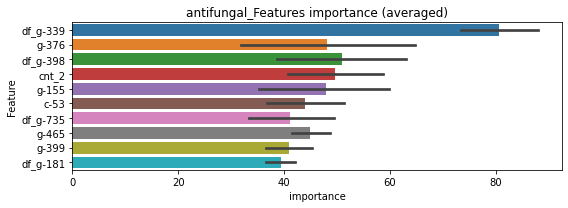

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019665	valid_1's binary_logloss: 0.0316601
[200]	training's binary_logloss: 0.00266615	valid_1's binary_logloss: 0.0105716
[300]	training's binary_logloss: 0.000770306	valid_1's binary_logloss: 0.00774302
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000559375	valid_1's binary_logloss: 0.00736622


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194357	valid_1's binary_logloss: 0.0403819
[200]	training's binary_logloss: 0.00261134	valid_1's binary_logloss: 0.0169125
[300]	training's binary_logloss: 0.000743	valid_1's binary_logloss: 0.0131195
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000527186	valid_1's binary_logloss: 0.012641


antifungal logloss: 0.010003608385507361
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631627	valid_1's binary_logloss: 0.106137
[200]	training's binary_logloss: 0.0101878	valid_1's binary_logloss: 0.03776
[300]	training's binary_logloss: 0.00326534	valid_1's binary_logloss: 0.0244985
[400]	training's binary_logloss: 0.00179836	valid_1's binary_logloss: 0.0204116
[500]	training's binary_logloss: 0.00138667	valid_1's binary_logloss: 0.0187282
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00133814	valid_1's binary_logloss: 0.0182985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649119	valid_1's binary_logloss: 0.0965754
[200]	training's binary_logloss: 0.0107552	valid_1's binary_logloss: 0.0258909
[300]	training's binary_logloss: 0.00340547	valid_1's binary_logloss: 0.0115293
[400]	training's binary_logloss: 0.00187735	valid_1's binary_logloss: 0.0079201
[500]	training's binary_logloss: 0.00145584	valid_

1 / 3 AUC score:1.000
Threshold: 0.8794536690157742
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00171
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00171, conf_1:0.87945
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.88
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.84
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.80
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_4: 0.76
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.72
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.68
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.64
threshold:0.64, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649261	valid_1's binary_logloss: 0.106345
[200]	training's binary_logloss: 0.0106568	valid_1's binary_logloss: 0.0325341
[300]	training's binary_logloss: 0.00333758	valid_1's binary_logloss: 0.0177464
[400]	training's binary_logloss: 0.00179645	valid_1's binary_logloss: 0.013449
[500]	training's binary_logloss: 0.00141025	valid_1's binary_logloss: 0.0116285
[600]	training's binary_logloss: 0.00132862	valid_1's binary_logloss: 0.0112142
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.0013226	valid_1's binary_logloss: 0.0111746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648747	valid_1's binary_logloss: 0.100871
[200]	training's binary_logloss: 0.0106246	valid_1's binary_logloss: 0.0296829
[300]	training's binary_logloss: 0.00342747	valid_1's binary_logloss: 0.0144069
[400]	training's binary_logloss: 0.00185957	valid_1

2 / 3 AUC score:1.000
Threshold: 0.6394536690157739
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00185
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00185, conf_1:0.63945
threshold:0.64, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649261	valid_1's binary_logloss: 0.106345
[200]	training's binary_logloss: 0.0106568	valid_1's binary_logloss: 0.0325341
[300]	training's binary_logloss: 0.00333758	valid_1's binary_logloss: 0.0177464
[400]	training's binary_logloss: 0.00179645	valid_1's binary_logloss: 0.013449
[500]	training's binary_logloss: 0.00141025	valid_1's binary_logloss: 0.0116285
[600]	training's binary_logloss: 0.00132862	valid_1's binary_logloss: 0.0112142
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.0013226	valid_1's binary_logloss: 0.0111746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648747	valid_1's binary_logloss: 0.100871
[200]	training's binary_logloss: 0.0106246	valid_1's binary_logloss: 0.0296829
[300]	training's binary_logloss: 0.00342747	valid_1's binary_logloss: 0.0144069
[400]	training's binary_logloss: 0.00185957	valid_1

3 / 3 AUC score:1.000
Threshold: 0.6394536690157739
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00185
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00185, conf_1:0.63945
threshold:0.64, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4980, y_label_rate: 0.10060


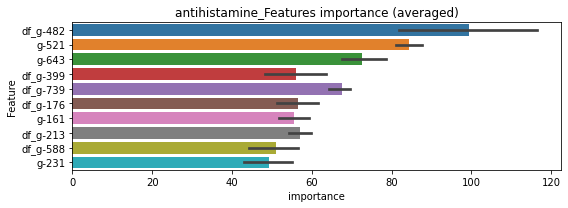

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174983	valid_1's binary_logloss: 0.0266652
[200]	training's binary_logloss: 0.00203794	valid_1's binary_logloss: 0.00675044
[300]	training's binary_logloss: 0.000574194	valid_1's binary_logloss: 0.0037959
[400]	training's binary_logloss: 0.00030717	valid_1's binary_logloss: 0.00309748
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000275815	valid_1's binary_logloss: 0.00304136


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171435	valid_1's binary_logloss: 0.0243988
[200]	training's binary_logloss: 0.00203233	valid_1's binary_logloss: 0.00613909
[300]	training's binary_logloss: 0.000576846	valid_1's binary_logloss: 0.00335712
[400]	training's binary_logloss: 0.000313962	valid_1's binary_logloss: 0.00273408
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000272946	valid_1's binary_logloss: 0.00261793


antihistamine logloss: 0.0028296491657353595
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629384	valid_1's binary_logloss: 0.0915668
[200]	training's binary_logloss: 0.010341	valid_1's binary_logloss: 0.0235317
[300]	training's binary_logloss: 0.00324908	valid_1's binary_logloss: 0.0106607
[400]	training's binary_logloss: 0.00177008	valid_1's binary_logloss: 0.00721734
[500]	training's binary_logloss: 0.00136033	valid_1's binary_logloss: 0.00609823
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00128927	valid_1's binary_logloss: 0.00577389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616806	valid_1's binary_logloss: 0.110571
[200]	training's binary_logloss: 0.00992443	valid_1's binary_logloss: 0.042165
[300]	training's binary_logloss: 0.00315017	valid_1's binary_logloss: 0.0270787
[400]	training's binary_logloss: 0.00171544	valid_1's binary_logloss: 0.0207364
[500]	training's binary_logloss: 0.00132343	va

1 / 3 AUC score:1.000
Threshold: 0.5369969620960299
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00152
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00152, conf_1:0.53700
threshold:0.54, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610132	valid_1's binary_logloss: 0.102297
[200]	training's binary_logloss: 0.00973724	valid_1's binary_logloss: 0.031211
[300]	training's binary_logloss: 0.00309911	valid_1's binary_logloss: 0.0172407
[400]	training's binary_logloss: 0.00169863	valid_1's binary_logloss: 0.0130911
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00140273	valid_1's binary_logloss: 0.012075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627962	valid_1's binary_logloss: 0.103652
[200]	training's binary_logloss: 0.0102324	valid_1's binary_logloss: 0.0309474
[300]	training's binary_logloss: 0.00326272	valid_1's binary_logloss: 0.0171403
[400]	training's binary_logloss: 0.00176222	valid_1's binary_logloss: 0.0125759


2 / 3 AUC score:1.000


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00146193	valid_1's binary_logloss: 0.0114361


Threshold: 0.5369969620960299
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/995
30th percentile: 0.00175
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00175, conf_1:0.53700
threshold:0.54, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598727	valid_1's binary_logloss: 0.101704
[200]	training's binary_logloss: 0.00948856	valid_1's binary_logloss: 0.0351651
[300]	training's binary_logloss: 0.00297103	valid_1's binary_logloss: 0.0208308
[400]	training's binary_logloss: 0.00165445	valid_1's binary_logloss: 0.0174996
[500]	training's binary_logloss: 0.00130943	valid_1's binary_logloss: 0.015796
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00132127	valid_1's binary_logloss: 0.0157726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613936	valid_1's binary_logloss: 0.0969326
[200]	training's binary_logloss: 0.0100098	valid_1's binary_logloss: 0.0273342
[300]	training's binary_logloss: 0.00317261	valid_1's binary_logloss: 0.0138071
[400]	training's binary_logloss: 0.00175104	valid_1's binary_logloss: 0.00984649
[500]	training's binary_logloss: 0.0013422	vali

3 / 3 AUC score:1.000
Threshold: 0.5369969620960299
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/993
30th percentile: 0.00169
p_label_rate: 0.00201 Vs.target_rate: 0.00082, Num_p_label: 8.0, conf_0:0.00169, conf_1:0.56403
threshold:0.54, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:506.0/4975, y_label_rate: 0.10171


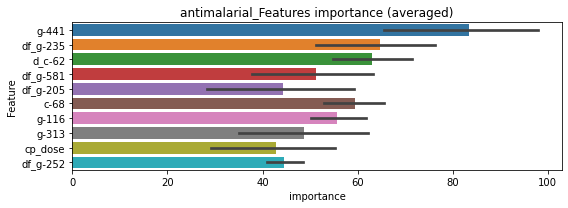

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163773	valid_1's binary_logloss: 0.0269453
[200]	training's binary_logloss: 0.00197722	valid_1's binary_logloss: 0.00866815
[300]	training's binary_logloss: 0.000565601	valid_1's binary_logloss: 0.00656855
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000427089	valid_1's binary_logloss: 0.00630029


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160697	valid_1's binary_logloss: 0.0238937
[200]	training's binary_logloss: 0.00192934	valid_1's binary_logloss: 0.00787099
[300]	training's binary_logloss: 0.00055924	valid_1's binary_logloss: 0.00580668
[400]	training's binary_logloss: 0.000301367	valid_1's binary_logloss: 0.00547399
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000295588	valid_1's binary_logloss: 0.00545609


antimalarial logloss: 0.005878274302501022
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129745	valid_1's binary_logloss: 0.296624
[200]	training's binary_logloss: 0.0346907	valid_1's binary_logloss: 0.188761
[300]	training's binary_logloss: 0.0121902	valid_1's binary_logloss: 0.150299
[400]	training's binary_logloss: 0.00584569	valid_1's binary_logloss: 0.131834
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00537405	valid_1's binary_logloss: 0.130991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124816	valid_1's binary_logloss: 0.288128
[200]	training's binary_logloss: 0.0330706	valid_1's binary_logloss: 0.194702
[300]	training's binary_logloss: 0.0119161	valid_1's binary_logloss: 0.164716
[400]	training's binary_logloss: 0.00581152	valid_1's binary_logloss: 0.150091
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00379853	valid_1's binary_logloss: 0.142898


1 / 3 AUC score:0.984
Threshold: 0.3206230908670328
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentile: 0.03159
p_label_rate: 0.03064 Vs.target_rate: 0.00315, Num_p_label: 122.0, conf_0:0.03159, conf_1:0.41481
Num_p_label: 122.0, Expected: 12.5, Adj_threshold_1: 0.32
Num_p_label: 80.0, Expected: 12.5, Adj_threshold_2: 0.36
Num_p_label: 57.0, Expected: 12.5, Adj_threshold_3: 0.40
Num_p_label: 38.0, Expected: 12.5, Adj_threshold_4: 0.44
Num_p_label: 21.0, Expected: 12.5, Adj_threshold_5: 0.48
Num_p_label: 13.0, Expected: 12.5, Adj_threshold_6: 0.52
threshold:0.52, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118206	valid_1's binary_logloss: 0.259934
[200]	training's binary_logloss: 0.0305358	valid_1's binary_logloss: 0.15609
[300]	training's binary_logloss: 0.0107123	valid_1's binary_logloss: 0.117303
[400]	training's binary_logloss: 0.00522162	valid_1's binary_logloss: 0.102156
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00442376	valid_1's binary_logloss: 0.0987525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123603	valid_1's binary_logloss: 0.247233
[200]	training's binary_logloss: 0.0327915	valid_1's binary_logloss: 0.142431
[300]	training's binary_logloss: 0.0114043	valid_1's binary_logloss: 0.10528
[400]	training's binary_logloss: 0.00550612	valid_1's binary_logloss: 0.0890518
[500]	training's binary_logloss: 0.00344288	valid_1's binary_logloss: 0.0827057
[600]	training's binary_logloss: 0.00257799	valid_1's binary

2 / 3 AUC score:0.993
Threshold: 0.5206230908670327
Remove_noisy_labels: 19 → positive_corect_labels: 456.0/929
30th percentile: 0.02111
p_label_rate: 0.00628 Vs.target_rate: 0.00315, Num_p_label: 25.0, conf_0:0.02111, conf_1:0.52062
threshold:0.52, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:456.0/929, y_label_rate: 0.49085
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116891	valid_1's binary_logloss: 0.234584
[200]	training's binary_logloss: 0.0299039	valid_1's binary_logloss: 0.125779
[300]	training's binary_logloss: 0.0104621	valid_1's binary_logloss: 0.0845219
[400]	training's binary_logloss: 0.0051136	valid_1's binary_logloss: 0.0669765
[500]	training's binary_logloss: 0.0032867	valid_1's binary_logloss: 0.0595353
[600]	training's binary_logloss: 0.00246618	valid_1's binary_logloss: 0.0544838
[700]	training's binary_logloss: 0.0021355	valid_1's binary_logloss: 0.0524193
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.00205042	valid_1's binary_logloss: 0.0513703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109908	valid_1's binary_logloss: 0.231908
[200]	training's binary_logloss: 0.0276742	valid_1's binary_logloss: 0.126175
[300]	training's binary_logloss: 0.00958498	valid_1's bin

3 / 3 AUC score:0.999
Threshold: 0.5206230908670327
Remove_noisy_labels: 12 → positive_corect_labels: 446.0/917
30th percentile: 0.01244
p_label_rate: 0.00527 Vs.target_rate: 0.00315, Num_p_label: 21.0, conf_0:0.01244, conf_1:0.52062
threshold:0.52, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:467.0/4899, y_label_rate: 0.09533


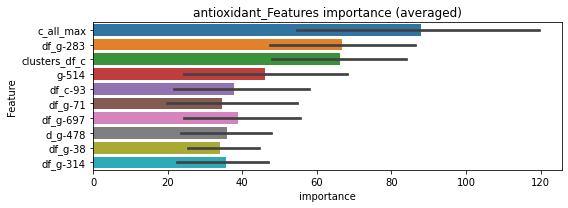

len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297641	valid_1's binary_logloss: 0.0816734
[200]	training's binary_logloss: 0.00540505	valid_1's binary_logloss: 0.0532351
[300]	training's binary_logloss: 0.00160217	valid_1's binary_logloss: 0.0465146
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00127298	valid_1's binary_logloss: 0.0458576


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028233	valid_1's binary_logloss: 0.0705117
[200]	training's binary_logloss: 0.00535182	valid_1's binary_logloss: 0.0462274
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00238417	valid_1's binary_logloss: 0.0430507


antioxidant logloss: 0.04445446633068049
antiprotozoal , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938366	valid_1's binary_logloss: 0.161319
[200]	training's binary_logloss: 0.0197865	valid_1's binary_logloss: 0.0633007
[300]	training's binary_logloss: 0.00648775	valid_1's binary_logloss: 0.0371607
[400]	training's binary_logloss: 0.00327622	valid_1's binary_logloss: 0.026854
[500]	training's binary_logloss: 0.00220464	valid_1's binary_logloss: 0.0225055
[600]	training's binary_logloss: 0.00177888	valid_1's binary_logloss: 0.0201653
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00173505	valid_1's binary_logloss: 0.0199619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833709	valid_1's binary_logloss: 0.176951
[200]	training's binary_logloss: 0.0170275	valid_1's binary_logloss: 0.0824095
[300]	training's binary_logloss: 0.00571987	valid_1's binary_logloss: 0.0550727
[400]	training's binary_logloss: 0.00293072	valid_

1 / 3 AUC score:1.000
Threshold: 0.4090076570980226
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00487
p_label_rate: 0.01005 Vs.target_rate: 0.00161, Num_p_label: 40.0, conf_0:0.00487, conf_1:0.49976
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_1: 0.41
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_2: 0.45
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_3: 0.49
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_4: 0.53
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_5: 0.57
threshold:0.57, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855454	valid_1's binary_logloss: 0.160231
[200]	training's binary_logloss: 0.0174366	valid_1's binary_logloss: 0.074502
[300]	training's binary_logloss: 0.00578009	valid_1's binary_logloss: 0.0488618
[400]	training's binary_logloss: 0.00298891	valid_1's binary_logloss: 0.0399835
[500]	training's binary_logloss: 0.00203941	valid_1's binary_logloss: 0.035963
[600]	training's binary_logloss: 0.00168554	valid_1's binary_logloss: 0.033832
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00163944	valid_1's binary_logloss: 0.0334893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881683	valid_1's binary_logloss: 0.161357
[200]	training's binary_logloss: 0.0181425	valid_1's binary_logloss: 0.0651626
[300]	training's binary_logloss: 0.00608616	valid_1's binary_logloss: 0.0377294
[400]	training's binary_logloss: 0.00312923	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.5690076570980226
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/988
30th percentile: 0.00460
p_label_rate: 0.00301 Vs.target_rate: 0.00161, Num_p_label: 12.0, conf_0:0.00460, conf_1:0.56991
threshold:0.57, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830148	valid_1's binary_logloss: 0.185615
[200]	training's binary_logloss: 0.0163013	valid_1's binary_logloss: 0.0894612
[300]	training's binary_logloss: 0.00545845	valid_1's binary_logloss: 0.0604471
[400]	training's binary_logloss: 0.00278115	valid_1's binary_logloss: 0.0491949
[500]	training's binary_logloss: 0.00192674	valid_1's binary_logloss: 0.0432004
[600]	training's binary_logloss: 0.00161055	valid_1's binary_logloss: 0.0402426
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00156417	valid_1's binary_logloss: 0.039735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883879	valid_1's binary_logloss: 0.156889
[200]	training's binary_logloss: 0.0180817	valid_1's binary_logloss: 0.0653201
[300]	training's binary_logloss: 0.00596941	valid_1's binary_logloss: 0.0391917
[400]	training's binary_logloss: 0.00309081	valid_

3 / 3 AUC score:1.000
Threshold: 0.5690076570980226
Remove_noisy_labels: 7 → positive_corect_labels: 488.0/981
30th percentile: 0.00427
p_label_rate: 0.00402 Vs.target_rate: 0.00161, Num_p_label: 16.0, conf_0:0.00427, conf_1:0.56901
threshold:0.57, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:504.0/4963, y_label_rate: 0.10155


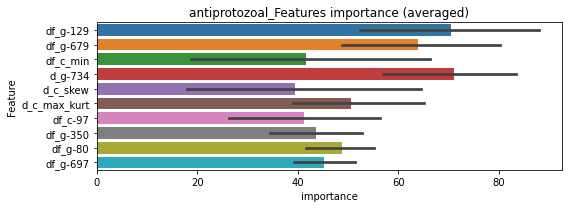

len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024346	valid_1's binary_logloss: 0.0499927
[200]	training's binary_logloss: 0.00371516	valid_1's binary_logloss: 0.0278049
[300]	training's binary_logloss: 0.00109092	valid_1's binary_logloss: 0.0243792
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000807849	valid_1's binary_logloss: 0.0239052


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024932	valid_1's binary_logloss: 0.0517323
[200]	training's binary_logloss: 0.00365804	valid_1's binary_logloss: 0.0262317
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00147291	valid_1's binary_logloss: 0.0234203


antiprotozoal logloss: 0.023662820584566906
antiviral , len(trt) : 23


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679312	valid_1's binary_logloss: 0.128059
[200]	training's binary_logloss: 0.011782	valid_1's binary_logloss: 0.0493683
[300]	training's binary_logloss: 0.00371724	valid_1's binary_logloss: 0.0303205
[400]	training's binary_logloss: 0.00198673	valid_1's binary_logloss: 0.0239522
[500]	training's binary_logloss: 0.00146432	valid_1's binary_logloss: 0.0212808
[600]	training's binary_logloss: 0.00133461	valid_1's binary_logloss: 0.0205986
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00133491	valid_1's binary_logloss: 0.0205957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071698	valid_1's binary_logloss: 0.11747
[200]	training's binary_logloss: 0.0127308	valid_1's binary_logloss: 0.0360789
[300]	training's binary_logloss: 0.00396316	valid_1's binary_logloss: 0.0186934
[400]	training's binary_logloss: 0.00209354	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.37307093899634636
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00231
p_label_rate: 0.00126 Vs.target_rate: 0.00104, Num_p_label: 5.0, conf_0:0.00231, conf_1:0.37307
threshold:0.37, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675364	valid_1's binary_logloss: 0.111863
[200]	training's binary_logloss: 0.0118029	valid_1's binary_logloss: 0.0386151
[300]	training's binary_logloss: 0.00378275	valid_1's binary_logloss: 0.0194585
[400]	training's binary_logloss: 0.00202214	valid_1's binary_logloss: 0.0140008
[500]	training's binary_logloss: 0.00148216	valid_1's binary_logloss: 0.011731
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00136695	valid_1's binary_logloss: 0.0111736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691698	valid_1's binary_logloss: 0.117969
[200]	training's binary_logloss: 0.012022	valid_1's binary_logloss: 0.0433598
[300]	training's binary_logloss: 0.00373908	valid_1's binary_logloss: 0.0254089
[400]	training's binary_logloss: 0.00198536	valid_1's binary_logloss: 0.0207062
[500]	training's binary_logloss: 0.00144072	valid_1

2 / 3 AUC score:1.000
Threshold: 0.37307093899634636
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/992
30th percentile: 0.00207
p_label_rate: 0.00126 Vs.target_rate: 0.00104, Num_p_label: 5.0, conf_0:0.00207, conf_1:0.37307
threshold:0.37, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627856	valid_1's binary_logloss: 0.126933
[200]	training's binary_logloss: 0.0108011	valid_1's binary_logloss: 0.0531654
[300]	training's binary_logloss: 0.00351318	valid_1's binary_logloss: 0.0324722
[400]	training's binary_logloss: 0.00191982	valid_1's binary_logloss: 0.026268
[500]	training's binary_logloss: 0.00142174	valid_1's binary_logloss: 0.0232468
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00140884	valid_1's binary_logloss: 0.0232304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706342	valid_1's binary_logloss: 0.105672
[200]	training's binary_logloss: 0.0124408	valid_1's binary_logloss: 0.0302125
[300]	training's binary_logloss: 0.00395865	valid_1's binary_logloss: 0.0148921
[400]	training's binary_logloss: 0.00207539	valid_1's binary_logloss: 0.0102365
[500]	training's binary_logloss: 0.00149783	valid_

3 / 3 AUC score:1.000
Threshold: 0.37307093899634636
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/988
30th percentile: 0.00207
p_label_rate: 0.00226 Vs.target_rate: 0.00104, Num_p_label: 9.0, conf_0:0.00207, conf_1:0.42459
threshold:0.37, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:504.0/4970, y_label_rate: 0.10141


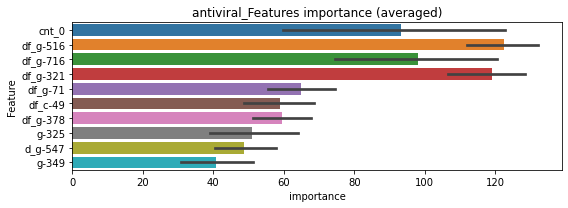

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171873	valid_1's binary_logloss: 0.0303485
[200]	training's binary_logloss: 0.00217097	valid_1's binary_logloss: 0.0128415
[300]	training's binary_logloss: 0.000640892	valid_1's binary_logloss: 0.0113482
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000589771	valid_1's binary_logloss: 0.0112982


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162593	valid_1's binary_logloss: 0.0312243
[200]	training's binary_logloss: 0.00210991	valid_1's binary_logloss: 0.0135861
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000725722	valid_1's binary_logloss: 0.0111485


antiviral logloss: 0.011223372011452216
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113494	valid_1's binary_logloss: 0.231291
[200]	training's binary_logloss: 0.0271929	valid_1's binary_logloss: 0.121613
[300]	training's binary_logloss: 0.00923881	valid_1's binary_logloss: 0.0819236
[400]	training's binary_logloss: 0.00457292	valid_1's binary_logloss: 0.066951
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00311769	valid_1's binary_logloss: 0.0609503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111882	valid_1's binary_logloss: 0.221078
[200]	training's binary_logloss: 0.0263884	valid_1's binary_logloss: 0.117364
[300]	training's binary_logloss: 0.00906163	valid_1's binary_logloss: 0.0824648
[400]	training's binary_logloss: 0.00451905	valid_1's binary_logloss: 0.0706847
[500]	training's binary_logloss: 0.00295448	valid_1's binary_logloss: 0.0656998
[600]	training's binary_logloss: 0.00223637	valid_1's 

1 / 3 AUC score:0.996
Threshold: 0.31863164500320135
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01483
p_label_rate: 0.01431 Vs.target_rate: 0.00216, Num_p_label: 57.0, conf_0:0.01483, conf_1:0.39945
Num_p_label: 57.0, Expected: 8.6, Adj_threshold_1: 0.32
Num_p_label: 38.0, Expected: 8.6, Adj_threshold_2: 0.36
Num_p_label: 20.0, Expected: 8.6, Adj_threshold_3: 0.40
Num_p_label: 14.0, Expected: 8.6, Adj_threshold_4: 0.44
Num_p_label: 11.0, Expected: 8.6, Adj_threshold_5: 0.48
threshold:0.48, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107851	valid_1's binary_logloss: 0.226359
[200]	training's binary_logloss: 0.0258045	valid_1's binary_logloss: 0.122848
[300]	training's binary_logloss: 0.0086852	valid_1's binary_logloss: 0.0856866
[400]	training's binary_logloss: 0.00431809	valid_1's binary_logloss: 0.0728016
[500]	training's binary_logloss: 0.00283954	valid_1's binary_logloss: 0.0669668
[600]	training's binary_logloss: 0.00218844	valid_1's binary_logloss: 0.0637122
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00212543	valid_1's binary_logloss: 0.0632604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111547	valid_1's binary_logloss: 0.218832
[200]	training's binary_logloss: 0.0268626	valid_1's binary_logloss: 0.110153
[300]	training's binary_logloss: 0.00894949	valid_1's binary_logloss: 0.0705615
[400]	training's binary_logloss: 0.00442479	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.47863164500320127
Remove_noisy_labels: 15 → positive_corect_labels: 480.0/969
30th percentile: 0.01294
p_label_rate: 0.00326 Vs.target_rate: 0.00216, Num_p_label: 13.0, conf_0:0.01294, conf_1:0.47863
threshold:0.48, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:480.0/969, y_label_rate: 0.49536
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108135	valid_1's binary_logloss: 0.219135
[200]	training's binary_logloss: 0.0259145	valid_1's binary_logloss: 0.11753
[300]	training's binary_logloss: 0.00865797	valid_1's binary_logloss: 0.0829033
[400]	training's binary_logloss: 0.00426406	valid_1's binary_logloss: 0.0649689
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00322278	valid_1's binary_logloss: 0.0595384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103925	valid_1's binary_logloss: 0.223283
[200]	training's binary_logloss: 0.024436	valid_1's binary_logloss: 0.114532
[300]	training's binary_logloss: 0.00818402	valid_1's binary_logloss: 0.0748799
[400]	training's binary_logloss: 0.00411728	valid_1's binary_logloss: 0.0585657
[500]	training's binary_logloss: 0.00268801	valid_1's binary_logloss: 0.0500903
[600]	training's binary_logloss: 0.00210593	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.47863164500320127
Remove_noisy_labels: 9 → positive_corect_labels: 475.0/960
30th percentile: 0.01448
p_label_rate: 0.00427 Vs.target_rate: 0.00216, Num_p_label: 17.0, conf_0:0.01448, conf_1:0.48877
threshold:0.48, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:492.0/4942, y_label_rate: 0.09955


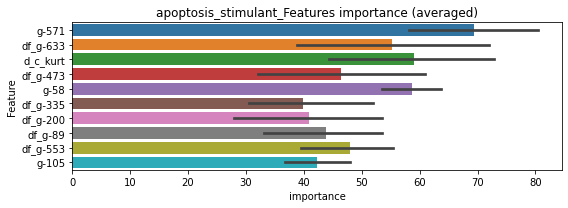

len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032652	valid_1's binary_logloss: 0.0690021
[200]	training's binary_logloss: 0.00609069	valid_1's binary_logloss: 0.0382001
[300]	training's binary_logloss: 0.00167938	valid_1's binary_logloss: 0.0315622
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00158398	valid_1's binary_logloss: 0.0312818


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325055	valid_1's binary_logloss: 0.0714774
[200]	training's binary_logloss: 0.00610681	valid_1's binary_logloss: 0.0392306
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00192421	valid_1's binary_logloss: 0.032968


apoptosis_stimulant logloss: 0.032124893177159004
aromatase_inhibitor , len(trt) : 47


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107157	valid_1's binary_logloss: 0.216923
[200]	training's binary_logloss: 0.02502	valid_1's binary_logloss: 0.116476
[300]	training's binary_logloss: 0.00831902	valid_1's binary_logloss: 0.083994
[400]	training's binary_logloss: 0.00408857	valid_1's binary_logloss: 0.0743588
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0037002	valid_1's binary_logloss: 0.0737452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100918	valid_1's binary_logloss: 0.220673
[200]	training's binary_logloss: 0.0234051	valid_1's binary_logloss: 0.118141
[300]	training's binary_logloss: 0.00800785	valid_1's binary_logloss: 0.0789664
[400]	training's binary_logloss: 0.00401787	valid_1's binary_logloss: 0.0635113
[500]	training's binary_logloss: 0.00264437	valid_1's binary_logloss: 0.0562909
[600]	training's binary_logloss: 0.00206395	valid_1's bin

1 / 3 AUC score:0.998
Threshold: 0.3495385856830566
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.01173
p_label_rate: 0.00829 Vs.target_rate: 0.00208, Num_p_label: 33.0, conf_0:0.01173, conf_1:0.38189
Num_p_label: 33.0, Expected: 8.3, Adj_threshold_1: 0.35
Num_p_label: 21.0, Expected: 8.3, Adj_threshold_2: 0.39
Num_p_label: 13.0, Expected: 8.3, Adj_threshold_3: 0.43
Num_p_label: 6.0, Expected: 8.3, Adj_threshold_4: 0.47
threshold:0.47, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987208	valid_1's binary_logloss: 0.216189
[200]	training's binary_logloss: 0.0226216	valid_1's binary_logloss: 0.118283
[300]	training's binary_logloss: 0.00763374	valid_1's binary_logloss: 0.086024
[400]	training's binary_logloss: 0.00380426	valid_1's binary_logloss: 0.0734149
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00332321	valid_1's binary_logloss: 0.0713946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10482	valid_1's binary_logloss: 0.19095
[200]	training's binary_logloss: 0.0249274	valid_1's binary_logloss: 0.0899489
[300]	training's binary_logloss: 0.00842642	valid_1's binary_logloss: 0.0550382
[400]	training's binary_logloss: 0.00422875	valid_1's binary_logloss: 0.0418616
[500]	training's binary_logloss: 0.00272776	valid_1's binary_logloss: 0.0363604
Early stopping, best iteration is:
[585]	training's bi

2 / 3 AUC score:0.998
Threshold: 0.46953858568305656
Remove_noisy_labels: 11 → positive_corect_labels: 481.0/971
30th percentile: 0.01182
p_label_rate: 0.00377 Vs.target_rate: 0.00208, Num_p_label: 15.0, conf_0:0.01182, conf_1:0.46954
threshold:0.47, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:481.0/971, y_label_rate: 0.49537
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100308	valid_1's binary_logloss: 0.227423
[200]	training's binary_logloss: 0.0227171	valid_1's binary_logloss: 0.14099
[300]	training's binary_logloss: 0.00750353	valid_1's binary_logloss: 0.112811
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00716247	valid_1's binary_logloss: 0.112091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950809	valid_1's binary_logloss: 0.197704
[200]	training's binary_logloss: 0.021679	valid_1's binary_logloss: 0.0972245
[300]	training's binary_logloss: 0.00736548	valid_1's binary_logloss: 0.0634157
[400]	training's binary_logloss: 0.0037603	valid_1's binary_logloss: 0.0506569
[500]	training's binary_logloss: 0.00249082	valid_1's binary_logloss: 0.044142
[600]	training's binary_logloss: 0.00197067	valid_1's binary_logloss: 0.0411051
[700]	training's binary_logloss: 0.00177852	valid_1's bin

3 / 3 AUC score:0.996
Threshold: 0.46953858568305656
Remove_noisy_labels: 19 → positive_corect_labels: 465.0/952
30th percentile: 0.01545
p_label_rate: 0.00427 Vs.target_rate: 0.00208, Num_p_label: 17.0, conf_0:0.01545, conf_1:0.46954
threshold:0.47, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:482.0/4934, y_label_rate: 0.09769


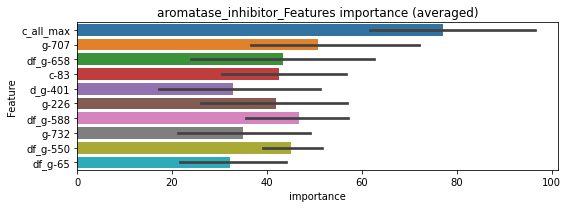

len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265596	valid_1's binary_logloss: 0.061646
[200]	training's binary_logloss: 0.00452808	valid_1's binary_logloss: 0.0381801
[300]	training's binary_logloss: 0.00130754	valid_1's binary_logloss: 0.0346311
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00137086	valid_1's binary_logloss: 0.034586


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265728	valid_1's binary_logloss: 0.0604231
[200]	training's binary_logloss: 0.00441198	valid_1's binary_logloss: 0.0316442
[300]	training's binary_logloss: 0.00129889	valid_1's binary_logloss: 0.0264949
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000934335	valid_1's binary_logloss: 0.0260024


aromatase_inhibitor logloss: 0.030294193739641366
atm_kinase_inhibitor , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363934	valid_1's binary_logloss: 0.0537201
[200]	training's binary_logloss: 0.00411324	valid_1's binary_logloss: 0.0124145
[300]	training's binary_logloss: 0.00132787	valid_1's binary_logloss: 0.00669476
[400]	training's binary_logloss: 0.000868651	valid_1's binary_logloss: 0.00483276
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000786395	valid_1's binary_logloss: 0.00444272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365308	valid_1's binary_logloss: 0.0445619
[200]	training's binary_logloss: 0.0041237	valid_1's binary_logloss: 0.00820214
[300]	training's binary_logloss: 0.00136025	valid_1's binary_logloss: 0.00408072
[400]	training's binary_logloss: 0.000875862	valid_1's binary_logloss: 0.00303371
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000805219	valid_1's binary_logloss: 0.00288541


1 / 3 AUC score:1.000
Threshold: 0.6615019249124441
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00061
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00061, conf_1:0.66150
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.50
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.46
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_7: 0.42
threshold:0.42, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363934	valid_1's binary_logloss: 0.0537201
[200]	training's binary_logloss: 0.00411324	valid_1's binary_logloss: 0.0124145
[300]	training's binary_logloss: 0.00132787	valid_1's binary_logloss: 0.00669476
[400]	training's binary_logloss: 0.000868651	valid_1's binary_logloss: 0.00483276
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000786395	valid_1's binary_logloss: 0.00444272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365308	valid_1's binary_logloss: 0.0445619
[200]	training's binary_logloss: 0.0041237	valid_1's binary_logloss: 0.00820214
[300]	training's binary_logloss: 0.00136025	valid_1's binary_logloss: 0.00408072
[400]	training's binary_logloss: 0.000875862	valid_1's binary_logloss: 0.00303371
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000805219	valid_1's binary_logloss: 0.00288541


2 / 3 AUC score:1.000
Threshold: 0.421501924912444
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00061
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00061, conf_1:0.42150
threshold:0.42, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363934	valid_1's binary_logloss: 0.0537201
[200]	training's binary_logloss: 0.00411324	valid_1's binary_logloss: 0.0124145
[300]	training's binary_logloss: 0.00132787	valid_1's binary_logloss: 0.00669476
[400]	training's binary_logloss: 0.000868651	valid_1's binary_logloss: 0.00483276
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000786395	valid_1's binary_logloss: 0.00444272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365308	valid_1's binary_logloss: 0.0445619
[200]	training's binary_logloss: 0.0041237	valid_1's binary_logloss: 0.00820214
[300]	training's binary_logloss: 0.00136025	valid_1's binary_logloss: 0.00408072
[400]	training's binary_logloss: 0.000875862	valid_1's binary_logloss: 0.00303371
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000805219	valid_1's binary_logloss: 0.00288541


3 / 3 AUC score:1.000
Threshold: 0.421501924912444
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00061
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00061, conf_1:0.42150
threshold:0.42, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


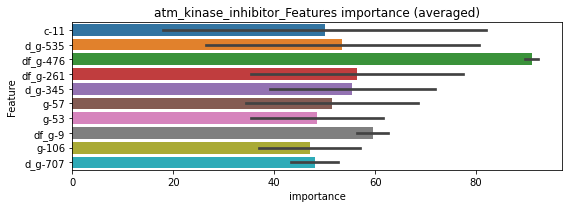

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101798	valid_1's binary_logloss: 0.0128724
[200]	training's binary_logloss: 0.000876004	valid_1's binary_logloss: 0.00336034
[300]	training's binary_logloss: 0.000251029	valid_1's binary_logloss: 0.00261868


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000231336	valid_1's binary_logloss: 0.00259952


================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103087	valid_1's binary_logloss: 0.0112317
[200]	training's binary_logloss: 0.000903755	valid_1's binary_logloss: 0.00150213
[300]	training's binary_logloss: 0.000261368	valid_1's binary_logloss: 0.000697251
[400]	training's binary_logloss: 0.000160856	valid_1's binary_logloss: 0.00053147
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000148574	valid_1's binary_logloss: 0.00051335


atm_kinase_inhibitor logloss: 0.0015564355993963716
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382633	valid_1's binary_logloss: 0.0523361
[200]	training's binary_logloss: 0.00455747	valid_1's binary_logloss: 0.0108466
[300]	training's binary_logloss: 0.00145275	valid_1's binary_logloss: 0.00454224
[400]	training's binary_logloss: 0.00091477	valid_1's binary_logloss: 0.0031132
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000865709	valid_1's binary_logloss: 0.00295561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038812	valid_1's binary_logloss: 0.0482455
[200]	training's binary_logloss: 0.00451871	valid_1's binary_logloss: 0.0082405
[300]	training's binary_logloss: 0.00146294	valid_1's binary_logloss: 0.00339064
[400]	training's binary_logloss: 0.000920105	valid_1's binary_logloss: 0.00236465
[500]	training's binary_logloss: 0.000815196	valid_1's binary_logloss: 0.00210313
Early stopping, best iteration is:
[52

1 / 3 AUC score:1.000
Threshold: 0.5202465454762559
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00048
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00048, conf_1:0.52025
threshold:0.52, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382633	valid_1's binary_logloss: 0.0523361
[200]	training's binary_logloss: 0.00455747	valid_1's binary_logloss: 0.0108466
[300]	training's binary_logloss: 0.00145275	valid_1's binary_logloss: 0.00454224
[400]	training's binary_logloss: 0.00091477	valid_1's binary_logloss: 0.0031132
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000865709	valid_1's binary_logloss: 0.00295561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038812	valid_1's binary_logloss: 0.0482455
[200]	training's binary_logloss: 0.00451871	valid_1's binary_logloss: 0.0082405
[300]	training's binary_logloss: 0.00146294	valid_1's binary_logloss: 0.00339064
[400]	training's binary_logloss: 0.000920105	valid_1's binary_logloss: 0.00236465
[500]	training's binary_logloss: 0.000815196	valid_1's binary_logloss: 0.00210313
Early stopping, best iteration is:
[52

2 / 3 AUC score:1.000
Threshold: 0.5202465454762559
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00048
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00048, conf_1:0.52025
threshold:0.52, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382633	valid_1's binary_logloss: 0.0523361
[200]	training's binary_logloss: 0.00455747	valid_1's binary_logloss: 0.0108466
[300]	training's binary_logloss: 0.00145275	valid_1's binary_logloss: 0.00454224
[400]	training's binary_logloss: 0.00091477	valid_1's binary_logloss: 0.0031132
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000865709	valid_1's binary_logloss: 0.00295561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038812	valid_1's binary_logloss: 0.0482455
[200]	training's binary_logloss: 0.00451871	valid_1's binary_logloss: 0.0082405
[300]	training's binary_logloss: 0.00146294	valid_1's binary_logloss: 0.00339064
[400]	training's binary_logloss: 0.000920105	valid_1's binary_logloss: 0.00236465
[500]	training's binary_logloss: 0.000815196	valid_1's binary_logloss: 0.00210313


3 / 3 AUC score:1.000
Threshold: 0.5202465454762559
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00048
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00048, conf_1:0.52025


Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00080261	valid_1's binary_logloss: 0.00207144


threshold:0.52, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


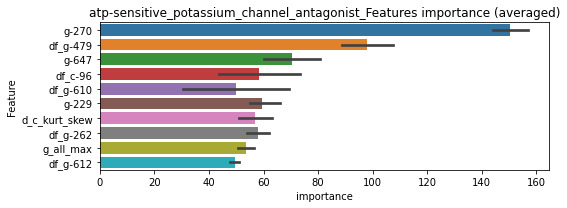

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106866	valid_1's binary_logloss: 0.0129757
[200]	training's binary_logloss: 0.00098749	valid_1's binary_logloss: 0.00269833
[300]	training's binary_logloss: 0.000283819	valid_1's binary_logloss: 0.00155262


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000192818	valid_1's binary_logloss: 0.00138727


================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106076	valid_1's binary_logloss: 0.0149511
[200]	training's binary_logloss: 0.00096426	valid_1's binary_logloss: 0.00457504
[300]	training's binary_logloss: 0.000277926	valid_1's binary_logloss: 0.00343668
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000217951	valid_1's binary_logloss: 0.00332594


atp-sensitive_potassium_channel_antagonist logloss: 0.0023566072731642965
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489745	valid_1's binary_logloss: 0.0710507
[200]	training's binary_logloss: 0.0068456	valid_1's binary_logloss: 0.0177372
[300]	training's binary_logloss: 0.00216915	valid_1's binary_logloss: 0.00894185
[400]	training's binary_logloss: 0.00126784	valid_1's binary_logloss: 0.00693916
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00109631	valid_1's binary_logloss: 0.00635446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510422	valid_1's binary_logloss: 0.0789598
[200]	training's binary_logloss: 0.0071195	valid_1's binary_logloss: 0.0224406
[300]	training's binary_logloss: 0.00223411	valid_1's binary_logloss: 0.0117195
[400]	training's binary_logloss: 0.00128415	valid_1's binary_logloss: 0.00854087
[500]	training's binary_logloss: 0.00106901	valid_1's binary_logloss: 0.0078878


1 / 3 AUC score:1.000
Threshold: 0.7103773995827831


Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00103061	valid_1's binary_logloss: 0.00763798


Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00070
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00070, conf_1:0.71038
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.71
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.67
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_3: 0.63
threshold:0.63, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489745	valid_1's binary_logloss: 0.0710507
[200]	training's binary_logloss: 0.0068456	valid_1's binary_logloss: 0.0177372
[300]	training's binary_logloss: 0.00216915	valid_1's binary_logloss: 0.00894185
[400]	training's binary_logloss: 0.00126784	valid_1's binary_logloss: 0.00693916
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00109631	valid_1's binary_logloss: 0.00635446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510422	valid_1's binary_logloss: 0.0789598
[200]	training's binary_logloss: 0.0071195	valid_1's binary_logloss: 0.0224406
[300]	training's binary_logloss: 0.00223411	valid_1's binary_logloss: 0.0117195
[400]	training's binary_logloss: 0.00128415	valid_1's binary_logloss: 0.00854087
[500]	training's binary_logloss: 0.00106901	valid_1's binary_logloss: 0.0078878
Early stopping, best iteration is:
[574]	tr

2 / 3 AUC score:1.000
Threshold: 0.630377399582783
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00070
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00070, conf_1:0.63038
threshold:0.63, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505506	valid_1's binary_logloss: 0.0694014
[200]	training's binary_logloss: 0.0070725	valid_1's binary_logloss: 0.0152604
[300]	training's binary_logloss: 0.00223474	valid_1's binary_logloss: 0.00663621
[400]	training's binary_logloss: 0.00128943	valid_1's binary_logloss: 0.00453552
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00110729	valid_1's binary_logloss: 0.0039852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483434	valid_1's binary_logloss: 0.0740478
[200]	training's binary_logloss: 0.00662426	valid_1's binary_logloss: 0.0220595
[300]	training's binary_logloss: 0.00211313	valid_1's binary_logloss: 0.0119391
[400]	training's binary_logloss: 0.00123932	valid_1's binary_logloss: 0.00906308
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0010899	valid_1's binary_logloss: 0.00839105


3 / 3 AUC score:1.000
Threshold: 0.630377399582783
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/998
30th percentile: 0.00068
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00068, conf_1:0.63038
threshold:0.63, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:503.0/4980, y_label_rate: 0.10100


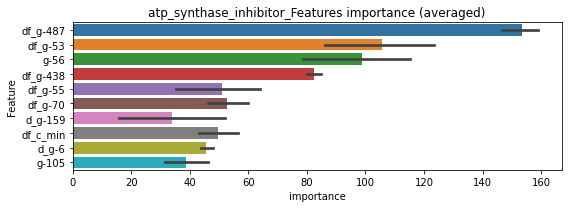

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130126	valid_1's binary_logloss: 0.0224379
[200]	training's binary_logloss: 0.00142468	valid_1's binary_logloss: 0.00636165
[300]	training's binary_logloss: 0.000414621	valid_1's binary_logloss: 0.00360456
[400]	training's binary_logloss: 0.000238324	valid_1's binary_logloss: 0.0030598
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000213897	valid_1's binary_logloss: 0.0029669


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122149	valid_1's binary_logloss: 0.0199678
[200]	training's binary_logloss: 0.0012837	valid_1's binary_logloss: 0.00754672
[300]	training's binary_logloss: 0.00037488	valid_1's binary_logloss: 0.00609587


atp_synthase_inhibitor logloss: 0.0044247012050309875


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000273995	valid_1's binary_logloss: 0.0058825


atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145255	valid_1's binary_logloss: 0.338452
[200]	training's binary_logloss: 0.0426082	valid_1's binary_logloss: 0.238929
[300]	training's binary_logloss: 0.0155444	valid_1's binary_logloss: 0.202028
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0103084	valid_1's binary_logloss: 0.191002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141767	valid_1's binary_logloss: 0.342987
[200]	training's binary_logloss: 0.0411099	valid_1's binary_logloss: 0.251465
[300]	training's binary_logloss: 0.0150554	valid_1's binary_logloss: 0.214305
[400]	training's binary_logloss: 0.00714206	valid_1's binary_logloss: 0.198738
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00490151	valid_1's binary_logloss: 0.191295


1 / 3 AUC score:0.973
Threshold: 0.393581434255297
Remove_noisy_labels: 66 → positive_corect_labels: 467/934
30th percentile: 0.05583
p_label_rate: 0.04621 Vs.target_rate: 0.00409, Num_p_label: 184.0, conf_0:0.05046, conf_1:0.52640
Num_p_label: 184.0, Expected: 16.3, Adj_threshold_1: 0.39
Num_p_label: 127.0, Expected: 16.3, Adj_threshold_2: 0.43
Num_p_label: 96.0, Expected: 16.3, Adj_threshold_3: 0.47
Num_p_label: 67.0, Expected: 16.3, Adj_threshold_4: 0.51
Num_p_label: 39.0, Expected: 16.3, Adj_threshold_5: 0.55
Num_p_label: 26.0, Expected: 16.3, Adj_threshold_6: 0.59
Num_p_label: 19.0, Expected: 16.3, Adj_threshold_7: 0.63
threshold:0.63, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:467.0/934, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134143	valid_1's binary_logloss: 0.33891
[200]	training's binary_logloss: 0.037199	valid_1's binary_logloss: 0.252009
[300]	training's binary_logloss: 0.0132457	valid_1's binary_logloss: 0.20888
[400]	training's binary_logloss: 0.00643802	valid_1's binary_logloss: 0.19633
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0044076	valid_1's binary_logloss: 0.189579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137788	valid_1's binary_logloss: 0.318652
[200]	training's binary_logloss: 0.0394445	valid_1's binary_logloss: 0.214788
[300]	training's binary_logloss: 0.0140315	valid_1's binary_logloss: 0.175125
[400]	training's binary_logloss: 0.00675867	valid_1's binary_logloss: 0.154483
[500]	training's binary_logloss: 0.00418238	valid_1's binary_logloss: 0.144954
Early stopping, best iteration is:
[500]	training's binary_logloss

2 / 3 AUC score:0.979
Threshold: 0.6335814342552971
Remove_noisy_labels: 55 → positive_corect_labels: 418.0/879
30th percentile: 0.04087
p_label_rate: 0.01632 Vs.target_rate: 0.00409, Num_p_label: 65.0, conf_0:0.03185, conf_1:0.63358
Num_p_label: 65.0, Expected: 16.3, Adj_threshold_1: 0.63
Num_p_label: 51.0, Expected: 16.3, Adj_threshold_2: 0.67
Num_p_label: 38.0, Expected: 16.3, Adj_threshold_3: 0.71
Num_p_label: 27.0, Expected: 16.3, Adj_threshold_4: 0.75
Num_p_label: 18.0, Expected: 16.3, Adj_threshold_5: 0.79
threshold:0.79, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:418.0/879, y_label_rate: 0.47554
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124466	valid_1's binary_logloss: 0.295439
[200]	training's binary_logloss: 0.0331584	valid_1's binary_logloss: 0.198869
[300]	training's binary_logloss: 0.0118758	valid_1's binary_logloss: 0.164183
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00683408	valid_1's binary_logloss: 0.15064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132048	valid_1's binary_logloss: 0.291175
[200]	training's binary_logloss: 0.0363956	valid_1's binary_logloss: 0.196352
[300]	training's binary_logloss: 0.0128569	valid_1's binary_logloss: 0.156778
[400]	training's binary_logloss: 0.00630443	valid_1's binary_logloss: 0.141512
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00499584	valid_1's binary_logloss: 0.13637


3 / 3 AUC score:0.986
Threshold: 0.7935814342552973
Remove_noisy_labels: 59 → positive_corect_labels: 360.0/820
30th percentile: 0.03272
p_label_rate: 0.00151 Vs.target_rate: 0.00409, Num_p_label: 6.0, conf_0:0.02860, conf_1:0.79358
threshold:0.79, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:366.0/4802, y_label_rate: 0.07622


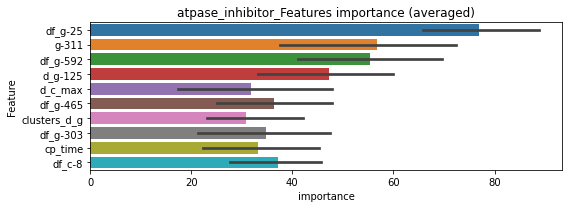

len(train_index) : 2401
len(valid_index) : 2401
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270047	valid_1's binary_logloss: 0.0685028
[200]	training's binary_logloss: 0.00505921	valid_1's binary_logloss: 0.0428982
[300]	training's binary_logloss: 0.00156084	valid_1's binary_logloss: 0.0368294
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00141662	valid_1's binary_logloss: 0.0363898


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027801	valid_1's binary_logloss: 0.0818121
[200]	training's binary_logloss: 0.00537208	valid_1's binary_logloss: 0.0610409


atpase_inhibitor logloss: 0.04807303292938332


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00420985	valid_1's binary_logloss: 0.0597563


atr_kinase_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645209	valid_1's binary_logloss: 0.123846
[200]	training's binary_logloss: 0.0107919	valid_1's binary_logloss: 0.0539338
[300]	training's binary_logloss: 0.00344808	valid_1's binary_logloss: 0.0333095
[400]	training's binary_logloss: 0.00189089	valid_1's binary_logloss: 0.0252856
[500]	training's binary_logloss: 0.00142167	valid_1's binary_logloss: 0.0224741
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.0013475	valid_1's binary_logloss: 0.021953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625812	valid_1's binary_logloss: 0.111954
[200]	training's binary_logloss: 0.0104086	valid_1's binary_logloss: 0.0375245
[300]	training's binary_logloss: 0.0034249	valid_1's binary_logloss: 0.0206929
[400]	training's binary_logloss: 0.00186719	valid_1's binary_logloss: 0.0144298
[500]	training's binary_logloss: 0.00141144	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.3181001670956508
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00247
p_label_rate: 0.00352 Vs.target_rate: 0.00086, Num_p_label: 14.0, conf_0:0.00247, conf_1:0.31810
Num_p_label: 14.0, Expected: 3.4, Adj_threshold_1: 0.32
Num_p_label: 5.0, Expected: 3.4, Adj_threshold_2: 0.36
threshold:0.36, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624984	valid_1's binary_logloss: 0.110398
[200]	training's binary_logloss: 0.0102402	valid_1's binary_logloss: 0.0388584
[300]	training's binary_logloss: 0.00336959	valid_1's binary_logloss: 0.0234682
[400]	training's binary_logloss: 0.0018571	valid_1's binary_logloss: 0.0181318
[500]	training's binary_logloss: 0.00138838	valid_1's binary_logloss: 0.0155195
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00131665	valid_1's binary_logloss: 0.0148368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654415	valid_1's binary_logloss: 0.098794
[200]	training's binary_logloss: 0.0111382	valid_1's binary_logloss: 0.0296121
[300]	training's binary_logloss: 0.00353707	valid_1's binary_logloss: 0.0153057
[400]	training's binary_logloss: 0.00192446	valid_1's binary_logloss: 0.010965
[500]	training's binary_logloss: 0.0014465	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.3581001670956508
Remove_noisy_labels: 4 → positive_corect_labels: 497.0/990
30th percentile: 0.00229
p_label_rate: 0.00251 Vs.target_rate: 0.00086, Num_p_label: 10.0, conf_0:0.00229, conf_1:0.39479
threshold:0.36, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620828	valid_1's binary_logloss: 0.10426
[200]	training's binary_logloss: 0.0103752	valid_1's binary_logloss: 0.0324671
[300]	training's binary_logloss: 0.00337782	valid_1's binary_logloss: 0.0159315
[400]	training's binary_logloss: 0.00186058	valid_1's binary_logloss: 0.0108217
[500]	training's binary_logloss: 0.0014297	valid_1's binary_logloss: 0.0089959
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00135036	valid_1's binary_logloss: 0.00855995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644142	valid_1's binary_logloss: 0.102104
[200]	training's binary_logloss: 0.0105969	valid_1's binary_logloss: 0.0298897
[300]	training's binary_logloss: 0.00345279	valid_1's binary_logloss: 0.0156579
[400]	training's binary_logloss: 0.00188464	valid_1's binary_logloss: 0.0116551
[500]	training's binary_logloss: 0.0014111	valid_1

3 / 3 AUC score:1.000
Threshold: 0.3581001670956508
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/990
30th percentile: 0.00222
p_label_rate: 0.00201 Vs.target_rate: 0.00086, Num_p_label: 8.0, conf_0:0.00222, conf_1:0.42016
threshold:0.36, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:505.0/4972, y_label_rate: 0.10157


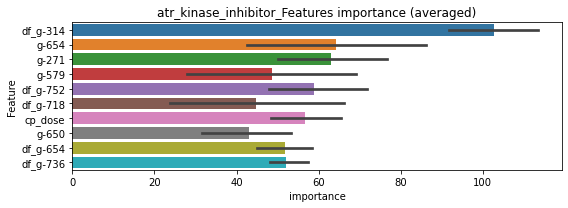

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181253	valid_1's binary_logloss: 0.0320262
[200]	training's binary_logloss: 0.0022822	valid_1's binary_logloss: 0.0134952
[300]	training's binary_logloss: 0.000637457	valid_1's binary_logloss: 0.0117467
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00069552	valid_1's binary_logloss: 0.011657


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180768	valid_1's binary_logloss: 0.0298077
[200]	training's binary_logloss: 0.00233974	valid_1's binary_logloss: 0.0106503
[300]	training's binary_logloss: 0.000669494	valid_1's binary_logloss: 0.00815548
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00041462	valid_1's binary_logloss: 0.00782723


atr_kinase_inhibitor logloss: 0.009742137996190363
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147199	valid_1's binary_logloss: 0.357957
[200]	training's binary_logloss: 0.0444172	valid_1's binary_logloss: 0.259188
[300]	training's binary_logloss: 0.0164082	valid_1's binary_logloss: 0.215815
[400]	training's binary_logloss: 0.00795734	valid_1's binary_logloss: 0.198921
[500]	training's binary_logloss: 0.00486785	valid_1's binary_logloss: 0.187853
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00423784	valid_1's binary_logloss: 0.184912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146141	valid_1's binary_logloss: 0.367782
[200]	training's binary_logloss: 0.0422232	valid_1's binary_logloss: 0.271153
[300]	training's binary_logloss: 0.0156106	valid_1's binary_logloss: 0.233536
[400]	training's binary_logloss: 0.0074938	valid_1's binary_logloss: 0.219992
[500]	training's binary_logloss: 0.00459341	valid_1's binary_l

1 / 3 AUC score:0.970
Threshold: 0.40267135920628117
Remove_noisy_labels: 78 → positive_corect_labels: 461/922
30th percentile: 0.05265
p_label_rate: 0.04646 Vs.target_rate: 0.00405, Num_p_label: 185.0, conf_0:0.05265, conf_1:0.48507
Num_p_label: 185.0, Expected: 16.1, Adj_threshold_1: 0.40
Num_p_label: 130.0, Expected: 16.1, Adj_threshold_2: 0.44
Num_p_label: 91.0, Expected: 16.1, Adj_threshold_3: 0.48
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_4: 0.52
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_5: 0.56
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_6: 0.60
threshold:0.60, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:461.0/922, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129293	valid_1's binary_logloss: 0.332017
[200]	training's binary_logloss: 0.0371976	valid_1's binary_logloss: 0.235005
[300]	training's binary_logloss: 0.013264	valid_1's binary_logloss: 0.189912
[400]	training's binary_logloss: 0.00658306	valid_1's binary_logloss: 0.168712
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00605787	valid_1's binary_logloss: 0.166475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139385	valid_1's binary_logloss: 0.326972
[200]	training's binary_logloss: 0.0396861	valid_1's binary_logloss: 0.223913
[300]	training's binary_logloss: 0.0143631	valid_1's binary_logloss: 0.179385
[400]	training's binary_logloss: 0.00708412	valid_1's binary_logloss: 0.160013
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00486593	valid_1's binary_logloss: 0.152073


2 / 3 AUC score:0.984
Threshold: 0.6026713592062812
Remove_noisy_labels: 45 → positive_corect_labels: 430.0/877
30th percentile: 0.04978
p_label_rate: 0.02034 Vs.target_rate: 0.00405, Num_p_label: 81.0, conf_0:0.04091, conf_1:0.60267
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_1: 0.60
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_2: 0.64
Num_p_label: 38.0, Expected: 16.1, Adj_threshold_3: 0.68
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_4: 0.72
threshold:0.72, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:430.0/877, y_label_rate: 0.49031
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128368	valid_1's binary_logloss: 0.288627
[200]	training's binary_logloss: 0.035896	valid_1's binary_logloss: 0.182848
[300]	training's binary_logloss: 0.0129399	valid_1's binary_logloss: 0.138249
[400]	training's binary_logloss: 0.00630621	valid_1's binary_logloss: 0.115892
[500]	training's binary_logloss: 0.0040151	valid_1's binary_logloss: 0.107852
[600]	training's binary_logloss: 0.00296747	valid_1's binary_logloss: 0.102141
[700]	training's binary_logloss: 0.0024783	valid_1's binary_logloss: 0.0990376
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.00229996	valid_1's binary_logloss: 0.0974895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133791	valid_1's binary_logloss: 0.286337
[200]	training's binary_logloss: 0.0376844	valid_1's binary_logloss: 0.182976
[300]	training's binary_logloss: 0.0137082	valid_1's binary_l

3 / 3 AUC score:0.996
Threshold: 0.7226713592062813
Remove_noisy_labels: 37 → positive_corect_labels: 396.0/840
30th percentile: 0.02872
p_label_rate: 0.01205 Vs.target_rate: 0.00405, Num_p_label: 48.0, conf_0:0.01314, conf_1:0.72267
threshold:0.72, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:444.0/4822, y_label_rate: 0.09208


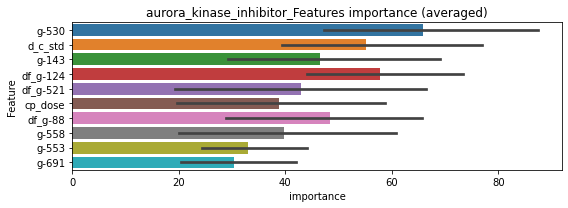

len(train_index) : 2411
len(valid_index) : 2411
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364082	valid_1's binary_logloss: 0.097651
[200]	training's binary_logloss: 0.00802673	valid_1's binary_logloss: 0.0683382
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00278899	valid_1's binary_logloss: 0.0639693


len(train_index) : 2411
len(valid_index) : 2411
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365927	valid_1's binary_logloss: 0.109789
[200]	training's binary_logloss: 0.00823664	valid_1's binary_logloss: 0.0856928
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00423868	valid_1's binary_logloss: 0.0836014


aurora_kinase_inhibitor logloss: 0.07378532929698792
autotaxin_inhibitor , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037275	valid_1's binary_logloss: 0.0449364
[200]	training's binary_logloss: 0.00438064	valid_1's binary_logloss: 0.0072078
[300]	training's binary_logloss: 0.00141131	valid_1's binary_logloss: 0.00300908
[400]	training's binary_logloss: 0.000902266	valid_1's binary_logloss: 0.0021922
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000815258	valid_1's binary_logloss: 0.00200075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377249	valid_1's binary_logloss: 0.0513815
[200]	training's binary_logloss: 0.00438647	valid_1's binary_logloss: 0.0102925
[300]	training's binary_logloss: 0.00141143	valid_1's binary_logloss: 0.0044771
[400]	training's binary_logloss: 0.000896906	valid_1's binary_logloss: 0.00344767
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000816193	valid_1's binary_logloss: 0.00323553


1 / 3 AUC score:1.000
Threshold: 0.3359541159316833
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00050
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00050, conf_1:0.33595
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037275	valid_1's binary_logloss: 0.0449364
[200]	training's binary_logloss: 0.00438064	valid_1's binary_logloss: 0.0072078
[300]	training's binary_logloss: 0.00141131	valid_1's binary_logloss: 0.00300908
[400]	training's binary_logloss: 0.000902266	valid_1's binary_logloss: 0.0021922
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000815258	valid_1's binary_logloss: 0.00200075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377249	valid_1's binary_logloss: 0.0513815
[200]	training's binary_logloss: 0.00438647	valid_1's binary_logloss: 0.0102925
[300]	training's binary_logloss: 0.00141143	valid_1's binary_logloss: 0.0044771
[400]	training's binary_logloss: 0.000896906	valid_1's binary_logloss: 0.00344767
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000816193	valid_1's binary_logloss: 0.00323553


2 / 3 AUC score:1.000
Threshold: 0.3359541159316833
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00050
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00050, conf_1:0.33595
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037275	valid_1's binary_logloss: 0.0449364
[200]	training's binary_logloss: 0.00438064	valid_1's binary_logloss: 0.0072078
[300]	training's binary_logloss: 0.00141131	valid_1's binary_logloss: 0.00300908
[400]	training's binary_logloss: 0.000902266	valid_1's binary_logloss: 0.0021922
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000815258	valid_1's binary_logloss: 0.00200075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377249	valid_1's binary_logloss: 0.0513815
[200]	training's binary_logloss: 0.00438647	valid_1's binary_logloss: 0.0102925
[300]	training's binary_logloss: 0.00141143	valid_1's binary_logloss: 0.0044771
[400]	training's binary_logloss: 0.000896906	valid_1's binary_logloss: 0.00344767
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000816193	valid_1's binary_logloss: 0.00323553


3 / 3 AUC score:1.000
Threshold: 0.3359541159316833
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00050
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00050, conf_1:0.33595
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


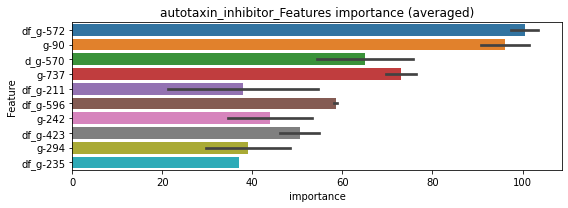

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105596	valid_1's binary_logloss: 0.0165722
[200]	training's binary_logloss: 0.000954576	valid_1's binary_logloss: 0.00503696
[300]	training's binary_logloss: 0.000267695	valid_1's binary_logloss: 0.00373373


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000181071	valid_1's binary_logloss: 0.00359269


================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104332	valid_1's binary_logloss: 0.0126228
[200]	training's binary_logloss: 0.000940247	valid_1's binary_logloss: 0.00331588
[300]	training's binary_logloss: 0.000267129	valid_1's binary_logloss: 0.0026936
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000255343	valid_1's binary_logloss: 0.00269175


autotaxin_inhibitor logloss: 0.0031422177422927703
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116644	valid_1's binary_logloss: 0.274343
[200]	training's binary_logloss: 0.0288418	valid_1's binary_logloss: 0.185085
[300]	training's binary_logloss: 0.00988903	valid_1's binary_logloss: 0.14753
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00584782	valid_1's binary_logloss: 0.135523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126954	valid_1's binary_logloss: 0.241787
[200]	training's binary_logloss: 0.0333008	valid_1's binary_logloss: 0.128917
[300]	training's binary_logloss: 0.011497	valid_1's binary_logloss: 0.0872349
[400]	training's binary_logloss: 0.00563644	valid_1's binary_logloss: 0.0692656
[500]	training's binary_logloss: 0.00354589	valid_1's binary_logloss: 0.0601317
[600]	training's binary_logloss: 0.00265841	valid_1's binary_logloss: 0.0547091
[700]	training's binary_logloss: 0.0022588	valid_1's binar

1 / 3 AUC score:0.992
Threshold: 0.35583955204598516
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.02342
p_label_rate: 0.01507 Vs.target_rate: 0.00262, Num_p_label: 60.0, conf_0:0.02342, conf_1:0.39387
Num_p_label: 60.0, Expected: 10.4, Adj_threshold_1: 0.36
Num_p_label: 39.0, Expected: 10.4, Adj_threshold_2: 0.40
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_3: 0.44
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_4: 0.48
threshold:0.48, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120525	valid_1's binary_logloss: 0.256312
[200]	training's binary_logloss: 0.0290069	valid_1's binary_logloss: 0.144321
[300]	training's binary_logloss: 0.00992782	valid_1's binary_logloss: 0.105879
[400]	training's binary_logloss: 0.00497797	valid_1's binary_logloss: 0.0900867
[500]	training's binary_logloss: 0.00315619	valid_1's binary_logloss: 0.0809657
[600]	training's binary_logloss: 0.00239303	valid_1's binary_logloss: 0.0774865
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.0023032	valid_1's binary_logloss: 0.0769175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11835	valid_1's binary_logloss: 0.248068
[200]	training's binary_logloss: 0.02943	valid_1's binary_logloss: 0.139702
[300]	training's binary_logloss: 0.0102495	valid_1's binary_logloss: 0.0986712
[400]	training's binary_logloss: 0.00501953	valid_1's binar

2 / 3 AUC score:0.998
Threshold: 0.4758395520459851
Remove_noisy_labels: 21 → positive_corect_labels: 470.0/951
30th percentile: 0.01506
p_label_rate: 0.00452 Vs.target_rate: 0.00262, Num_p_label: 18.0, conf_0:0.01506, conf_1:0.47584
threshold:0.48, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:470.0/951, y_label_rate: 0.49422
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11111	valid_1's binary_logloss: 0.241257
[200]	training's binary_logloss: 0.0265911	valid_1's binary_logloss: 0.133063
[300]	training's binary_logloss: 0.00921035	valid_1's binary_logloss: 0.0932593
[400]	training's binary_logloss: 0.00455111	valid_1's binary_logloss: 0.0750676
[500]	training's binary_logloss: 0.00297688	valid_1's binary_logloss: 0.0668902
[600]	training's binary_logloss: 0.00226793	valid_1's binary_logloss: 0.0613106
[700]	training's binary_logloss: 0.00199689	valid_1's binary_logloss: 0.0590231
Early stopping, best iteration is:
[723]	training's binary_logloss: 0.00195398	valid_1's binary_logloss: 0.0586548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112998	valid_1's binary_logloss: 0.247676
[200]	training's binary_logloss: 0.0279063	valid_1's binary_logloss: 0.144418
[300]	training's binary_logloss: 0.00969363	valid_1's 

3 / 3 AUC score:0.995
Threshold: 0.4758395520459851
Remove_noisy_labels: 15 → positive_corect_labels: 458.0/936
30th percentile: 0.01309
p_label_rate: 0.00703 Vs.target_rate: 0.00262, Num_p_label: 28.0, conf_0:0.01309, conf_1:0.48362
threshold:0.48, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:486.0/4918, y_label_rate: 0.09882


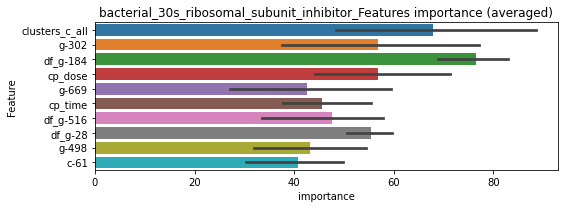

len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303629	valid_1's binary_logloss: 0.0836954
[200]	training's binary_logloss: 0.00539674	valid_1's binary_logloss: 0.0590849
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00238789	valid_1's binary_logloss: 0.055464


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309331	valid_1's binary_logloss: 0.0967162
[200]	training's binary_logloss: 0.00555724	valid_1's binary_logloss: 0.0730184
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00354481	valid_1's binary_logloss: 0.0714625


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.06346324944291434
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128475	valid_1's binary_logloss: 0.274156
[200]	training's binary_logloss: 0.0347607	valid_1's binary_logloss: 0.185584
[300]	training's binary_logloss: 0.0125826	valid_1's binary_logloss: 0.153211
[400]	training's binary_logloss: 0.00613465	valid_1's binary_logloss: 0.140761
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00533978	valid_1's binary_logloss: 0.139589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123774	valid_1's binary_logloss: 0.280744
[200]	training's binary_logloss: 0.0339314	valid_1's binary_logloss: 0.18745
[300]	training's binary_logloss: 0.0119932	valid_1's binary_logloss: 0.158563
[400]	training's binary_logloss: 0.00583185	valid_1's binary_logloss: 0.14689
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00435164	valid_1's binary_logloss: 0.14103


1 / 3 AUC score:0.985
Threshold: 0.3613377833936741
Remove_noisy_labels: 50 → positive_corect_labels: 475/950
30th percentile: 0.02853
p_label_rate: 0.02536 Vs.target_rate: 0.00343, Num_p_label: 101.0, conf_0:0.02853, conf_1:0.47615
Num_p_label: 101.0, Expected: 13.6, Adj_threshold_1: 0.36
Num_p_label: 73.0, Expected: 13.6, Adj_threshold_2: 0.40
Num_p_label: 46.0, Expected: 13.6, Adj_threshold_3: 0.44
Num_p_label: 37.0, Expected: 13.6, Adj_threshold_4: 0.48
Num_p_label: 22.0, Expected: 13.6, Adj_threshold_5: 0.52
Num_p_label: 14.0, Expected: 13.6, Adj_threshold_6: 0.56
threshold:0.56, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:475.0/950, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122561	valid_1's binary_logloss: 0.249833
[200]	training's binary_logloss: 0.0327118	valid_1's binary_logloss: 0.142135
[300]	training's binary_logloss: 0.0115602	valid_1's binary_logloss: 0.101838
[400]	training's binary_logloss: 0.0056347	valid_1's binary_logloss: 0.0831089
[500]	training's binary_logloss: 0.00353795	valid_1's binary_logloss: 0.0736208
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00278034	valid_1's binary_logloss: 0.0691686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117224	valid_1's binary_logloss: 0.250919
[200]	training's binary_logloss: 0.0307692	valid_1's binary_logloss: 0.154028
[300]	training's binary_logloss: 0.0107076	valid_1's binary_logloss: 0.115871
[400]	training's binary_logloss: 0.00529102	valid_1's binary_logloss: 0.0989799
Early stopping, best iteration is:
[424]	training's binary

2 / 3 AUC score:0.997
Threshold: 0.5613377833936741
Remove_noisy_labels: 18 → positive_corect_labels: 458.0/932
30th percentile: 0.01893
p_label_rate: 0.00753 Vs.target_rate: 0.00343, Num_p_label: 30.0, conf_0:0.01893, conf_1:0.56134
threshold:0.56, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:458.0/932, y_label_rate: 0.49142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109034	valid_1's binary_logloss: 0.239782
[200]	training's binary_logloss: 0.0270522	valid_1's binary_logloss: 0.138424
[300]	training's binary_logloss: 0.00959525	valid_1's binary_logloss: 0.105432
[400]	training's binary_logloss: 0.00478516	valid_1's binary_logloss: 0.0908501
[500]	training's binary_logloss: 0.00309578	valid_1's binary_logloss: 0.0837763
[600]	training's binary_logloss: 0.00237087	valid_1's binary_logloss: 0.0793287
[700]	training's binary_logloss: 0.0020539	valid_1's binary_logloss: 0.0762201
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00201166	valid_1's binary_logloss: 0.0756672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113609	valid_1's binary_logloss: 0.232411
[200]	training's binary_logloss: 0.0293907	valid_1's binary_logloss: 0.144784
[300]	training's binary_logloss: 0.0103411	valid_1's bi

3 / 3 AUC score:0.995
Threshold: 0.5613377833936741
Remove_noisy_labels: 22 → positive_corect_labels: 437.0/910
30th percentile: 0.01041
p_label_rate: 0.00804 Vs.target_rate: 0.00343, Num_p_label: 32.0, conf_0:0.01041, conf_1:0.56134
threshold:0.56, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:469.0/4892, y_label_rate: 0.09587


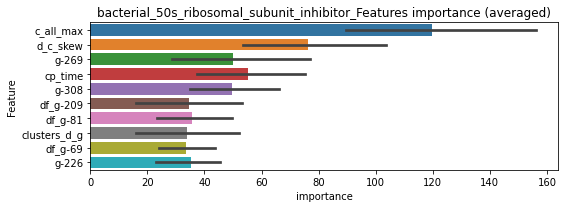

len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278289	valid_1's binary_logloss: 0.0750496
[200]	training's binary_logloss: 0.00524192	valid_1's binary_logloss: 0.052375
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00195513	valid_1's binary_logloss: 0.0485768


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296736	valid_1's binary_logloss: 0.0711059
[200]	training's binary_logloss: 0.00576251	valid_1's binary_logloss: 0.0478105
[300]	training's binary_logloss: 0.00178656	valid_1's binary_logloss: 0.0444472
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00141232	valid_1's binary_logloss: 0.0439175


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.04624716497814566
bacterial_antifolate , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949127	valid_1's binary_logloss: 0.202753
[200]	training's binary_logloss: 0.0196991	valid_1's binary_logloss: 0.103582
[300]	training's binary_logloss: 0.0064528	valid_1's binary_logloss: 0.0790983
[400]	training's binary_logloss: 0.00331596	valid_1's binary_logloss: 0.0701277
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00256001	valid_1's binary_logloss: 0.0672516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906008	valid_1's binary_logloss: 0.182811
[200]	training's binary_logloss: 0.0194795	valid_1's binary_logloss: 0.0876611
[300]	training's binary_logloss: 0.00642037	valid_1's binary_logloss: 0.0554648
[400]	training's binary_logloss: 0.00330789	valid_1's binary_logloss: 0.0420504
[500]	training's binary_logloss: 0.00223614	valid_1's binary_logloss: 0.0360811
Early stopping, best iteration is:
[585]	training's

1 / 3 AUC score:0.996
Threshold: 0.42665162661361755
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00911
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00911, conf_1:0.42665
threshold:0.43, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919837	valid_1's binary_logloss: 0.180576
[200]	training's binary_logloss: 0.0196837	valid_1's binary_logloss: 0.0860382
[300]	training's binary_logloss: 0.00637468	valid_1's binary_logloss: 0.0575506
[400]	training's binary_logloss: 0.00324825	valid_1's binary_logloss: 0.0464756
[500]	training's binary_logloss: 0.00218279	valid_1's binary_logloss: 0.0423662
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.0019033	valid_1's binary_logloss: 0.0412834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915454	valid_1's binary_logloss: 0.179132
[200]	training's binary_logloss: 0.0193568	valid_1's binary_logloss: 0.0774293
[300]	training's binary_logloss: 0.00649028	valid_1's binary_logloss: 0.0447845
[400]	training's binary_logloss: 0.00331517	valid_1's binary_logloss: 0.0331923
[500]	training's binary_logloss: 0.0022055	valid_1

2 / 3 AUC score:1.000
Threshold: 0.42665162661361755
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/987
30th percentile: 0.00749
p_label_rate: 0.00301 Vs.target_rate: 0.00161, Num_p_label: 12.0, conf_0:0.00749, conf_1:0.47009
threshold:0.43, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:491.0/987, y_label_rate: 0.49747
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907333	valid_1's binary_logloss: 0.174814
[200]	training's binary_logloss: 0.0187027	valid_1's binary_logloss: 0.0822541
[300]	training's binary_logloss: 0.00632684	valid_1's binary_logloss: 0.0547445
[400]	training's binary_logloss: 0.00324283	valid_1's binary_logloss: 0.0446926
[500]	training's binary_logloss: 0.00217602	valid_1's binary_logloss: 0.0399488
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00191569	valid_1's binary_logloss: 0.0388762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889179	valid_1's binary_logloss: 0.165218
[200]	training's binary_logloss: 0.0185321	valid_1's binary_logloss: 0.0750422
[300]	training's binary_logloss: 0.00615069	valid_1's binary_logloss: 0.0504926
[400]	training's binary_logloss: 0.0031675	valid_1's binary_logloss: 0.0425704
[500]	training's binary_logloss: 0.00215342	valid_

3 / 3 AUC score:0.999
Threshold: 0.42665162661361755
Remove_noisy_labels: 9 → positive_corect_labels: 485.0/978
30th percentile: 0.00715
p_label_rate: 0.00477 Vs.target_rate: 0.00161, Num_p_label: 19.0, conf_0:0.00715, conf_1:0.49928
threshold:0.43, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:504.0/4960, y_label_rate: 0.10161


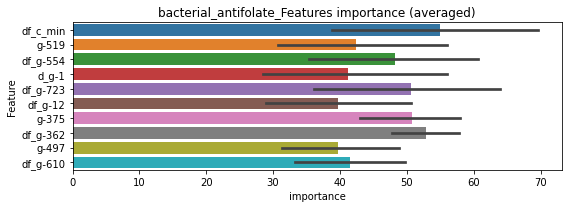

len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282911	valid_1's binary_logloss: 0.0475278
[200]	training's binary_logloss: 0.00442598	valid_1's binary_logloss: 0.019603
[300]	training's binary_logloss: 0.00121133	valid_1's binary_logloss: 0.0141553
[400]	training's binary_logloss: 0.000589915	valid_1's binary_logloss: 0.0129709
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000589915	valid_1's binary_logloss: 0.0129709


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259198	valid_1's binary_logloss: 0.0486564
[200]	training's binary_logloss: 0.0041654	valid_1's binary_logloss: 0.0225244
[300]	training's binary_logloss: 0.00116682	valid_1's binary_logloss: 0.0174505
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000816663	valid_1's binary_logloss: 0.0166329


bacterial_antifolate logloss: 0.014801890937631578
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190569	valid_1's binary_logloss: 0.514268
[200]	training's binary_logloss: 0.0665416	valid_1's binary_logloss: 0.46006
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0500158	valid_1's binary_logloss: 0.44924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175925	valid_1's binary_logloss: 0.501881
[200]	training's binary_logloss: 0.0609673	valid_1's binary_logloss: 0.456314


1 / 3 AUC score:0.857
Threshold: 0.4597783022045358
Remove_noisy_labels: 224 → positive_corect_labels: 388/776
30th percentile: 0.23974
p_label_rate: 0.14942 Vs.target_rate: 0.00732, Num_p_label: 595.0, conf_0:0.23974, conf_1:0.45978
Num_p_label: 595.0, Expected: 29.2, Adj_threshold_1: 0.46
Num_p_label: 380.0, Expected: 29.2, Adj_threshold_2: 0.50


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0552556	valid_1's binary_logloss: 0.453105


Num_p_label: 232.0, Expected: 29.2, Adj_threshold_3: 0.54
Num_p_label: 138.0, Expected: 29.2, Adj_threshold_4: 0.58
Num_p_label: 80.0, Expected: 29.2, Adj_threshold_5: 0.62
Num_p_label: 43.0, Expected: 29.2, Adj_threshold_6: 0.66
threshold:0.66, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:388.0/776, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163564	valid_1's binary_logloss: 0.471793
[200]	training's binary_logloss: 0.0516447	valid_1's binary_logloss: 0.409992
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.027915	valid_1's binary_logloss: 0.395925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161292	valid_1's binary_logloss: 0.415352
[200]	training's binary_logloss: 0.0525007	valid_1's binary_logloss: 0.335223
[300]	training's binary_logloss: 0.0206039	valid_1's binary_logloss: 0.307268
[400]	training's binary_logloss: 0.0100723	valid_1's binary_logloss: 0.292475
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0097824	valid_1's binary_logloss: 0.292099


2 / 3 AUC score:0.924
Threshold: 0.6597783022045359
Remove_noisy_labels: 122 → positive_corect_labels: 279.0/654
30th percentile: 0.13715
p_label_rate: 0.03842 Vs.target_rate: 0.00732, Num_p_label: 153.0, conf_0:0.13715, conf_1:0.65978
Num_p_label: 153.0, Expected: 29.2, Adj_threshold_1: 0.66
Num_p_label: 99.0, Expected: 29.2, Adj_threshold_2: 0.70
Num_p_label: 64.0, Expected: 29.2, Adj_threshold_3: 0.74
Num_p_label: 41.0, Expected: 29.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:279.0/654, y_label_rate: 0.42661
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149926	valid_1's binary_logloss: 0.385596
[200]	training's binary_logloss: 0.0463383	valid_1's binary_logloss: 0.303863
[300]	training's binary_logloss: 0.0179189	valid_1's binary_logloss: 0.260589
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0110592	valid_1's binary_logloss: 0.245514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14636	valid_1's binary_logloss: 0.340873
[200]	training's binary_logloss: 0.0455788	valid_1's binary_logloss: 0.238434
[300]	training's binary_logloss: 0.017691	valid_1's binary_logloss: 0.19252
[400]	training's binary_logloss: 0.0088728	valid_1's binary_logloss: 0.169536
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00751193	valid_1's binary_logloss: 0.16503


3 / 3 AUC score:0.976
Threshold: 0.779778302204536
Remove_noisy_labels: 86 → positive_corect_labels: 193.0/568
30th percentile: 0.06246
p_label_rate: 0.00527 Vs.target_rate: 0.00732, Num_p_label: 21.0, conf_0:0.06246, conf_1:0.77978
threshold:0.78, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:214.0/4550, y_label_rate: 0.04703


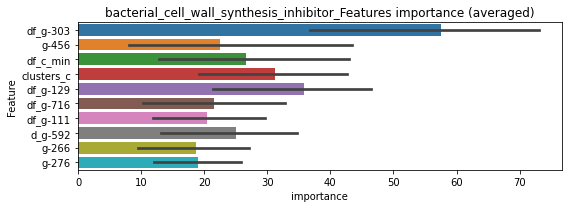

len(train_index) : 2275
len(valid_index) : 2275
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178569	valid_1's binary_logloss: 0.0931419


len(train_index) : 2275
len(valid_index) : 2275


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00493469	valid_1's binary_logloss: 0.0860182


================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018876	valid_1's binary_logloss: 0.0985079


bacterial_cell_wall_synthesis_inhibitor logloss: 0.0910347619962631


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0121227	valid_1's binary_logloss: 0.0960514


bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

1 / 3 AUC score:0.966
Threshold: 0.44008611406225184
Remove_noisy_labels: 86 → positive_corect_labels: 457/914
30th percentile: 0.06001
p_label_rate: 0.03290 Vs.target_rate: 0.00378, Num_p_label: 131.0, conf_0:0.06001, conf_1:0.50950
Num_p_label: 131.0, Expected: 15.0, Adj_threshold_1: 0.44
Num_p_label: 84.0, Expected: 15.0, Adj_threshold_2: 0.48
Num_p_label: 55.0, Expected: 15.0, Adj_threshold_3: 0.52
Num_p_label: 38.0, Expected: 15.0, Adj_threshold_4: 0.56
Num_p_label: 27.0, Expected: 15.0, Adj_threshold_5: 0.60
Num_p_label: 16.0, Expected: 15.0, Adj_threshold_6: 0.64
threshold:0.64, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:457.0/914, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123169	valid_1's binary_logloss: 0.293658
[200]	training's binary_logloss: 0.033708	valid_1's binary_logloss: 0.198945
[300]	training's binary_logloss: 0.0118212	valid_1's binary_logloss: 0.160171
[400]	training's binary_logloss: 0.00589284	valid_1's binary_logloss: 0.142721
[500]	training's binary_logloss: 0.00377623	valid_1's binary_logloss: 0.133406
[600]	training's binary_logloss: 0.0028062	valid_1's binary_logloss: 0.12707
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00244713	valid_1's binary_logloss: 0.123565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131557	valid_1's binary_logloss: 0.279955
[200]	training's binary_logloss: 0.0363996	valid_1's binary_logloss: 0.179185
[300]	training's binary_logloss: 0.0130763	valid_1's binary_logloss: 0.140921
[400]	training's binary_logloss: 0.00640837	valid_1's binary_log

2 / 3 AUC score:0.992
Threshold: 0.6400861140622519
Remove_noisy_labels: 41 → positive_corect_labels: 420.0/873
30th percentile: 0.02223
p_label_rate: 0.01507 Vs.target_rate: 0.00378, Num_p_label: 60.0, conf_0:0.02223, conf_1:0.64009
Num_p_label: 60.0, Expected: 15.0, Adj_threshold_1: 0.64
Num_p_label: 40.0, Expected: 15.0, Adj_threshold_2: 0.68
Num_p_label: 24.0, Expected: 15.0, Adj_threshold_3: 0.72
Num_p_label: 14.0, Expected: 15.0, Adj_threshold_4: 0.76
threshold:0.76, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:420.0/873, y_label_rate: 0.48110
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118095	valid_1's binary_logloss: 0.23207
[200]	training's binary_logloss: 0.0314312	valid_1's binary_logloss: 0.137482
[300]	training's binary_logloss: 0.0114684	valid_1's binary_logloss: 0.105809
[400]	training's binary_logloss: 0.00579956	valid_1's binary_logloss: 0.088728
[500]	training's binary_logloss: 0.00381741	valid_1's binary_logloss: 0.0800507
[600]	training's binary_logloss: 0.00288626	valid_1's binary_logloss: 0.0737045
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00254178	valid_1's binary_logloss: 0.0713297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113369	valid_1's binary_logloss: 0.271725
[200]	training's binary_logloss: 0.0290423	valid_1's binary_logloss: 0.186463
[300]	training's binary_logloss: 0.0103386	valid_1's binary_logloss: 0.155353
[400]	training's binary_logloss: 0.00518901	valid_1's binar

3 / 3 AUC score:0.992
Threshold: 0.760086114062252
Remove_noisy_labels: 25 → positive_corect_labels: 396.0/848
30th percentile: 0.01405
p_label_rate: 0.00201 Vs.target_rate: 0.00378, Num_p_label: 8.0, conf_0:0.01405, conf_1:0.76009
threshold:0.76, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:404.0/4830, y_label_rate: 0.08364


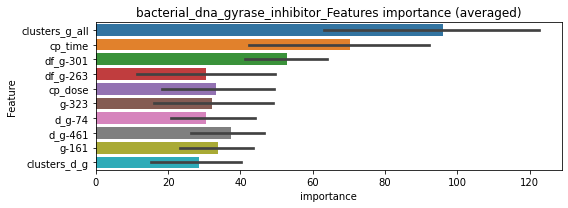

len(train_index) : 2415
len(valid_index) : 2415
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299473	valid_1's binary_logloss: 0.074143
[200]	training's binary_logloss: 0.00576338	valid_1's binary_logloss: 0.0491116
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00195822	valid_1's binary_logloss: 0.0456714


len(train_index) : 2415
len(valid_index) : 2415
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261835	valid_1's binary_logloss: 0.0631197
[200]	training's binary_logloss: 0.0051661	valid_1's binary_logloss: 0.0400001
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00228472	valid_1's binary_logloss: 0.036804


bacterial_dna_gyrase_inhibitor logloss: 0.041237688540182095
bacterial_dna_inhibitor , len(trt) : 115


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151518	valid_1's binary_logloss: 0.367672
[200]	training's binary_logloss: 0.0454364	valid_1's binary_logloss: 0.278823
[300]	training's binary_logloss: 0.0173022	valid_1's binary_logloss: 0.23959
[400]	training's binary_logloss: 0.00846869	valid_1's binary_logloss: 0.223157
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0061805	valid_1's binary_logloss: 0.219187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152601	valid_1's binary_logloss: 0.369211
[200]	training's binary_logloss: 0.0467566	valid_1's binary_logloss: 0.287174
[300]	training's binary_logloss: 0.0178238	valid_1's binary_logloss: 0.248332


1 / 3 AUC score:0.966
Threshold: 0.4533696431327803


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0094891	valid_1's binary_logloss: 0.234637


Remove_noisy_labels: 92 → positive_corect_labels: 454/908
30th percentile: 0.07954
p_label_rate: 0.04194 Vs.target_rate: 0.00476, Num_p_label: 167.0, conf_0:0.07954, conf_1:0.50236
Num_p_label: 167.0, Expected: 18.9, Adj_threshold_1: 0.45
Num_p_label: 114.0, Expected: 18.9, Adj_threshold_2: 0.49
Num_p_label: 80.0, Expected: 18.9, Adj_threshold_3: 0.53
Num_p_label: 53.0, Expected: 18.9, Adj_threshold_4: 0.57
Num_p_label: 39.0, Expected: 18.9, Adj_threshold_5: 0.61
Num_p_label: 25.0, Expected: 18.9, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:454.0/908, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144271	valid_1's binary_logloss: 0.311971
[200]	training's binary_logloss: 0.0422392	valid_1's binary_logloss: 0.219204
[300]	training's binary_logloss: 0.0156477	valid_1's binary_logloss: 0.181139
[400]	training's binary_logloss: 0.00767773	valid_1's binary_logloss: 0.163269
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00601485	valid_1's binary_logloss: 0.159718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143071	valid_1's binary_logloss: 0.318952
[200]	training's binary_logloss: 0.0424461	valid_1's binary_logloss: 0.218657
[300]	training's binary_logloss: 0.0156758	valid_1's binary_logloss: 0.177378
[400]	training's binary_logloss: 0.0076999	valid_1's binary_logloss: 0.15938
[500]	training's binary_logloss: 0.00471461	valid_1's binary_logloss: 0.147574
Early stopping, best iteration is:
[565]	training's binary_logl

2 / 3 AUC score:0.987
Threshold: 0.6533696431327803
Remove_noisy_labels: 55 → positive_corect_labels: 404.0/853
30th percentile: 0.04815
p_label_rate: 0.01256 Vs.target_rate: 0.00476, Num_p_label: 50.0, conf_0:0.04815, conf_1:0.65337
threshold:0.65, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:404.0/853, y_label_rate: 0.47362
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126884	valid_1's binary_logloss: 0.275027
[200]	training's binary_logloss: 0.0355954	valid_1's binary_logloss: 0.1686
[300]	training's binary_logloss: 0.0133077	valid_1's binary_logloss: 0.12755
[400]	training's binary_logloss: 0.00670208	valid_1's binary_logloss: 0.109151
[500]	training's binary_logloss: 0.0042372	valid_1's binary_logloss: 0.0999807
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00321079	valid_1's binary_logloss: 0.0937608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134298	valid_1's binary_logloss: 0.306844
[200]	training's binary_logloss: 0.0372522	valid_1's binary_logloss: 0.195099
[300]	training's binary_logloss: 0.0136469	valid_1's binary_logloss: 0.153342
[400]	training's binary_logloss: 0.00675077	valid_1's binary_logloss: 0.132529
[500]	training's binary_logloss: 0.00422118	valid_1's binary_lo

3 / 3 AUC score:0.994
Threshold: 0.6533696431327803
Remove_noisy_labels: 33 → positive_corect_labels: 372.0/820
30th percentile: 0.02251
p_label_rate: 0.01231 Vs.target_rate: 0.00476, Num_p_label: 49.0, conf_0:0.01956, conf_1:0.65337
threshold:0.65, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:421.0/4802, y_label_rate: 0.08767


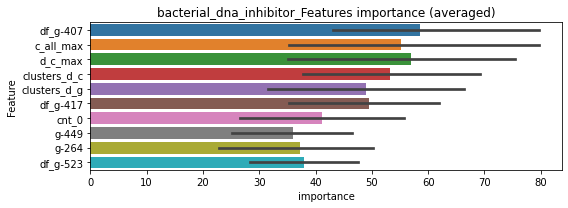

len(train_index) : 2401
len(valid_index) : 2401
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307422	valid_1's binary_logloss: 0.113926
[200]	training's binary_logloss: 0.00685612	valid_1's binary_logloss: 0.0967415
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00485944	valid_1's binary_logloss: 0.0958602


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039187	valid_1's binary_logloss: 0.10514
[200]	training's binary_logloss: 0.00870464	valid_1's binary_logloss: 0.0877637
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00533252	valid_1's binary_logloss: 0.085903


bacterial_dna_inhibitor logloss: 0.09088160544152547
bacterial_membrane_integrity_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655838	valid_1's binary_logloss: 0.1102
[200]	training's binary_logloss: 0.0105434	valid_1's binary_logloss: 0.0341149
[300]	training's binary_logloss: 0.00337417	valid_1's binary_logloss: 0.0191124
[400]	training's binary_logloss: 0.00185516	valid_1's binary_logloss: 0.0143408
[500]	training's binary_logloss: 0.00135864	valid_1's binary_logloss: 0.0125938
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00127443	valid_1's binary_logloss: 0.0122578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618422	valid_1's binary_logloss: 0.110553
[200]	training's binary_logloss: 0.0101371	valid_1's binary_logloss: 0.0344401
[300]	training's binary_logloss: 0.00321904	valid_1's binary_logloss: 0.0172425
[400]	training's binary_logloss: 0.00176208	valid_1's binary_logloss: 0.01231
[500]	training's binary_logloss: 0.00131779	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.34357546429091956
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00204
p_label_rate: 0.00301 Vs.target_rate: 0.00086, Num_p_label: 12.0, conf_0:0.00204, conf_1:0.46258
Num_p_label: 12.0, Expected: 3.4, Adj_threshold_1: 0.34
Num_p_label: 8.0, Expected: 3.4, Adj_threshold_2: 0.38
Num_p_label: 6.0, Expected: 3.4, Adj_threshold_3: 0.42
Num_p_label: 4.0, Expected: 3.4, Adj_threshold_4: 0.46
threshold:0.46, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639993	valid_1's binary_logloss: 0.102268
[200]	training's binary_logloss: 0.0103517	valid_1's binary_logloss: 0.0300256
[300]	training's binary_logloss: 0.00331096	valid_1's binary_logloss: 0.0151201
[400]	training's binary_logloss: 0.00180924	valid_1's binary_logloss: 0.010703
[500]	training's binary_logloss: 0.00135238	valid_1's binary_logloss: 0.00913384
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00124529	valid_1's binary_logloss: 0.00864883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632054	valid_1's binary_logloss: 0.101935
[200]	training's binary_logloss: 0.0103504	valid_1's binary_logloss: 0.0284521
[300]	training's binary_logloss: 0.00328853	valid_1's binary_logloss: 0.013736
[400]	training's binary_logloss: 0.00180299	valid_1's binary_logloss: 0.00927361
[500]	training's binary_logloss: 0.00133878	vali

2 / 3 AUC score:1.000
Threshold: 0.4635754642909195
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00209
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00209, conf_1:0.46358
threshold:0.46, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628376	valid_1's binary_logloss: 0.0983446
[200]	training's binary_logloss: 0.0103245	valid_1's binary_logloss: 0.027306
[300]	training's binary_logloss: 0.00336517	valid_1's binary_logloss: 0.0128283
[400]	training's binary_logloss: 0.00184549	valid_1's binary_logloss: 0.00843477
[500]	training's binary_logloss: 0.00136052	valid_1's binary_logloss: 0.00678633
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00127599	valid_1's binary_logloss: 0.00640269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621252	valid_1's binary_logloss: 0.0978606
[200]	training's binary_logloss: 0.01019	valid_1's binary_logloss: 0.0270847
[300]	training's binary_logloss: 0.0032505	valid_1's binary_logloss: 0.0124687
[400]	training's binary_logloss: 0.00178369	valid_1's binary_logloss: 0.00861861
[500]	training's binary_logloss: 0.00132349	val

3 / 3 AUC score:1.000
Threshold: 0.4635754642909195
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/997
30th percentile: 0.00200
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00200, conf_1:0.46358
threshold:0.46, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:502.0/4979, y_label_rate: 0.10082


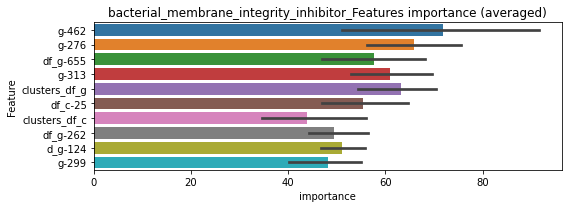

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159977	valid_1's binary_logloss: 0.0274543
[200]	training's binary_logloss: 0.00198664	valid_1's binary_logloss: 0.00991124
[300]	training's binary_logloss: 0.000571188	valid_1's binary_logloss: 0.00633994
[400]	training's binary_logloss: 0.000308808	valid_1's binary_logloss: 0.00537258
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000258708	valid_1's binary_logloss: 0.00517248


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162243	valid_1's binary_logloss: 0.029987
[200]	training's binary_logloss: 0.00195676	valid_1's binary_logloss: 0.0103136
[300]	training's binary_logloss: 0.000563733	valid_1's binary_logloss: 0.00754016
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000360471	valid_1's binary_logloss: 0.00725965


bacterial_membrane_integrity_inhibitor logloss: 0.006215853186814283
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767331	valid_1's binary_logloss: 0.156553
[200]	training's binary_logloss: 0.0152565	valid_1's binary_logloss: 0.0774836
[300]	training's binary_logloss: 0.00490046	valid_1's binary_logloss: 0.0515411
[400]	training's binary_logloss: 0.00258308	valid_1's binary_logloss: 0.0438054
[500]	training's binary_logloss: 0.00178974	valid_1's binary_logloss: 0.0398413
[600]	training's binary_logloss: 0.00156256	valid_1's binary_logloss: 0.0385927
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00153929	valid_1's binary_logloss: 0.0382495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817433	valid_1's binary_logloss: 0.132555
[200]	training's binary_logloss: 0.0162093	valid_1's binary_logloss: 0.0490281
[300]	training's binary_logloss: 0.00528322	valid_1's binary_logloss: 0.025675
[400]	training's binary_logloss: 0.00273863	valid_

1 / 3 AUC score:1.000
Threshold: 0.5570896531731149
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00382
p_label_rate: 0.00025 Vs.target_rate: 0.00139, Num_p_label: 1.0, conf_0:0.00382, conf_1:0.55709
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_1: 0.56
Num_p_label: 1.0, Expected: 5.5, Adj_threshold_2: 0.52
Num_p_label: 3.0, Expected: 5.5, Adj_threshold_3: 0.48
Num_p_label: 6.0, Expected: 5.5, Adj_threshold_4: 0.44
threshold:0.44, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777147	valid_1's binary_logloss: 0.129223
[200]	training's binary_logloss: 0.0153521	valid_1's binary_logloss: 0.0496332
[300]	training's binary_logloss: 0.00503996	valid_1's binary_logloss: 0.0280045
[400]	training's binary_logloss: 0.00264208	valid_1's binary_logloss: 0.0208
[500]	training's binary_logloss: 0.00183432	valid_1's binary_logloss: 0.0178683
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00161666	valid_1's binary_logloss: 0.0168684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076365	valid_1's binary_logloss: 0.137916
[200]	training's binary_logloss: 0.0153458	valid_1's binary_logloss: 0.0560818
[300]	training's binary_logloss: 0.00497676	valid_1's binary_logloss: 0.032666
[400]	training's binary_logloss: 0.00261534	valid_1's binary_logloss: 0.0237227
[500]	training's binary_logloss: 0.00182059	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.4370896531731149
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/993
30th percentile: 0.00332
p_label_rate: 0.00251 Vs.target_rate: 0.00139, Num_p_label: 10.0, conf_0:0.00332, conf_1:0.43709
threshold:0.44, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/993, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778637	valid_1's binary_logloss: 0.134154
[200]	training's binary_logloss: 0.0154684	valid_1's binary_logloss: 0.0512899
[300]	training's binary_logloss: 0.00501408	valid_1's binary_logloss: 0.0288398
[400]	training's binary_logloss: 0.00263735	valid_1's binary_logloss: 0.0212502
[500]	training's binary_logloss: 0.00184806	valid_1's binary_logloss: 0.0178719
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00160927	valid_1's binary_logloss: 0.0167473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778245	valid_1's binary_logloss: 0.134522
[200]	training's binary_logloss: 0.0156219	valid_1's binary_logloss: 0.0515764
[300]	training's binary_logloss: 0.00502981	valid_1's binary_logloss: 0.0289955
[400]	training's binary_logloss: 0.0026207	valid_1's binary_logloss: 0.0206862
[500]	training's binary_logloss: 0.00181889	valid_

3 / 3 AUC score:1.000
Threshold: 0.4370896531731149
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/993
30th percentile: 0.00331
p_label_rate: 0.00326 Vs.target_rate: 0.00139, Num_p_label: 13.0, conf_0:0.00331, conf_1:0.43709
threshold:0.44, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:510.0/4975, y_label_rate: 0.10251


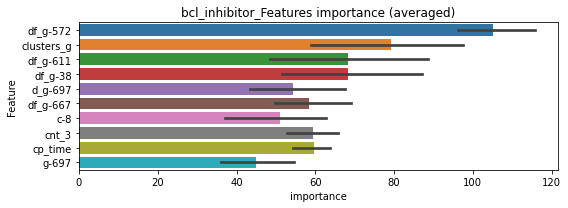

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237187	valid_1's binary_logloss: 0.0394816
[200]	training's binary_logloss: 0.00348154	valid_1's binary_logloss: 0.0185743
[300]	training's binary_logloss: 0.000983388	valid_1's binary_logloss: 0.0159099
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000991895	valid_1's binary_logloss: 0.0158875


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022663	valid_1's binary_logloss: 0.0429065
[200]	training's binary_logloss: 0.00327209	valid_1's binary_logloss: 0.0179603
[300]	training's binary_logloss: 0.000933264	valid_1's binary_logloss: 0.0144543
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000782202	valid_1's binary_logloss: 0.0141869


bcl_inhibitor logloss: 0.015037382051630424
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985335	valid_1's binary_logloss: 0.200685
[200]	training's binary_logloss: 0.0210777	valid_1's binary_logloss: 0.100633
[300]	training's binary_logloss: 0.00682372	valid_1's binary_logloss: 0.0686363
[400]	training's binary_logloss: 0.0034212	valid_1's binary_logloss: 0.0567092
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00253187	valid_1's binary_logloss: 0.0532587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963712	valid_1's binary_logloss: 0.187274
[200]	training's binary_logloss: 0.0205689	valid_1's binary_logloss: 0.0843637
[300]	training's binary_logloss: 0.00677866	valid_1's binary_logloss: 0.0492677
[400]	training's binary_logloss: 0.00343606	valid_1's binary_logloss: 0.0366692
[500]	training's binary_logloss: 0.00230319	valid_1's binary_logloss: 0.0298888
[600]	training's binary_logloss: 0.00186444	valid_1

1 / 3 AUC score:1.000
Threshold: 0.5870806968989977
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00800
p_label_rate: 0.00427 Vs.target_rate: 0.00169, Num_p_label: 17.0, conf_0:0.00800, conf_1:0.58708
threshold:0.59, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975792	valid_1's binary_logloss: 0.178172
[200]	training's binary_logloss: 0.020753	valid_1's binary_logloss: 0.0762746
[300]	training's binary_logloss: 0.006695	valid_1's binary_logloss: 0.0469838
[400]	training's binary_logloss: 0.00338797	valid_1's binary_logloss: 0.0358523
[500]	training's binary_logloss: 0.00226131	valid_1's binary_logloss: 0.0309758
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00217507	valid_1's binary_logloss: 0.030825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970157	valid_1's binary_logloss: 0.189196
[200]	training's binary_logloss: 0.0211315	valid_1's binary_logloss: 0.0933152
[300]	training's binary_logloss: 0.00688628	valid_1's binary_logloss: 0.0610838
[400]	training's binary_logloss: 0.00345603	valid_1's binary_logloss: 0.0514458
[500]	training's binary_logloss: 0.0023104	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5870806968989977
Remove_noisy_labels: 7 → positive_corect_labels: 490.0/985
30th percentile: 0.00655
p_label_rate: 0.01130 Vs.target_rate: 0.00169, Num_p_label: 45.0, conf_0:0.00455, conf_1:0.58904
Num_p_label: 45.0, Expected: 6.7, Adj_threshold_1: 0.59
Num_p_label: 38.0, Expected: 6.7, Adj_threshold_2: 0.63
Num_p_label: 32.0, Expected: 6.7, Adj_threshold_3: 0.67
Num_p_label: 25.0, Expected: 6.7, Adj_threshold_4: 0.71
Num_p_label: 22.0, Expected: 6.7, Adj_threshold_5: 0.75
Num_p_label: 20.0, Expected: 6.7, Adj_threshold_6: 0.79
Num_p_label: 17.0, Expected: 6.7, Adj_threshold_7: 0.83
Num_p_label: 17.0, Expected: 6.7, Adj_threshold_8: 0.87
Num_p_label: 9.0, Expected: 6.7, Adj_threshold_9: 0.91
threshold:0.91, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:490.0/985, y_label_rate: 0.49746
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101008	valid_1's binary_logloss: 0.186258
[200]	training's binary_logloss: 0.0218208	valid_1's binary_logloss: 0.0804034
[300]	training's binary_logloss: 0.00708775	valid_1's binary_logloss: 0.0486973
[400]	training's binary_logloss: 0.00352533	valid_1's binary_logloss: 0.0369
[500]	training's binary_logloss: 0.00232297	valid_1's binary_logloss: 0.0318051
[600]	training's binary_logloss: 0.00186333	valid_1's binary_logloss: 0.0290259
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00184569	valid_1's binary_logloss: 0.0288812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968882	valid_1's binary_logloss: 0.182739
[200]	training's binary_logloss: 0.0202946	valid_1's binary_logloss: 0.0804713
[300]	training's binary_logloss: 0.00653501	valid_1's binary_logloss: 0.0507812
[400]	training's binary_logloss: 0.00329912	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.907080696898998
Remove_noisy_labels: 15 → positive_corect_labels: 475.0/970
30th percentile: 0.00599
p_label_rate: 0.00276 Vs.target_rate: 0.00169, Num_p_label: 11.0, conf_0:0.00534, conf_1:0.90708
threshold:0.91, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/4952, y_label_rate: 0.09814


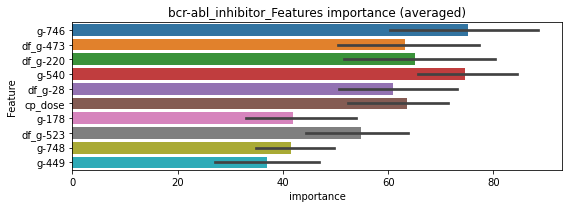

len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241942	valid_1's binary_logloss: 0.0472193
[200]	training's binary_logloss: 0.0038061	valid_1's binary_logloss: 0.0183955
[300]	training's binary_logloss: 0.00111235	valid_1's binary_logloss: 0.0124034
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000903742	valid_1's binary_logloss: 0.0118514


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244389	valid_1's binary_logloss: 0.0579024
[200]	training's binary_logloss: 0.00393927	valid_1's binary_logloss: 0.0302136
[300]	training's binary_logloss: 0.00113289	valid_1's binary_logloss: 0.0247323
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000763268	valid_1's binary_logloss: 0.0234988


bcr-abl_inhibitor logloss: 0.017675132439853806
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116852	valid_1's binary_logloss: 0.277478
[200]	training's binary_logloss: 0.0294574	valid_1's binary_logloss: 0.182435
[300]	training's binary_logloss: 0.0102666	valid_1's binary_logloss: 0.148697
[400]	training's binary_logloss: 0.0050378	valid_1's binary_logloss: 0.131661
[500]	training's binary_logloss: 0.00318069	valid_1's binary_logloss: 0.125154
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00250242	valid_1's binary_logloss: 0.121486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120762	valid_1's binary_logloss: 0.265168
[200]	training's binary_logloss: 0.0303373	valid_1's binary_logloss: 0.158464
[300]	training's binary_logloss: 0.0106267	valid_1's binary_logloss: 0.122035
[400]	training's binary_logloss: 0.00521456	valid_1's binary_logloss: 0.105424
[500]	training's binary_logloss: 0.00333104	valid_1's binary_l

1 / 3 AUC score:0.991
Threshold: 0.45228434085621655
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.01802
p_label_rate: 0.02135 Vs.target_rate: 0.00291, Num_p_label: 85.0, conf_0:0.01802, conf_1:0.57163
Num_p_label: 85.0, Expected: 11.6, Adj_threshold_1: 0.45
Num_p_label: 62.0, Expected: 11.6, Adj_threshold_2: 0.49
Num_p_label: 49.0, Expected: 11.6, Adj_threshold_3: 0.53
Num_p_label: 37.0, Expected: 11.6, Adj_threshold_4: 0.57
Num_p_label: 23.0, Expected: 11.6, Adj_threshold_5: 0.61
Num_p_label: 13.0, Expected: 11.6, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115448	valid_1's binary_logloss: 0.264999
[200]	training's binary_logloss: 0.0296365	valid_1's binary_logloss: 0.166244
[300]	training's binary_logloss: 0.0100237	valid_1's binary_logloss: 0.125643
[400]	training's binary_logloss: 0.00489372	valid_1's binary_logloss: 0.105195
[500]	training's binary_logloss: 0.00310378	valid_1's binary_logloss: 0.0962833
[600]	training's binary_logloss: 0.00231188	valid_1's binary_logloss: 0.0895229
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00225121	valid_1's binary_logloss: 0.0890569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116947	valid_1's binary_logloss: 0.247829
[200]	training's binary_logloss: 0.0296568	valid_1's binary_logloss: 0.145819
[300]	training's binary_logloss: 0.0101205	valid_1's binary_logloss: 0.105261
[400]	training's binary_logloss: 0.00493272	valid_1's bina

2 / 3 AUC score:0.996
Threshold: 0.6522843408562167
Remove_noisy_labels: 23 → positive_corect_labels: 464.0/945
30th percentile: 0.01386
p_label_rate: 0.00703 Vs.target_rate: 0.00291, Num_p_label: 28.0, conf_0:0.00965, conf_1:0.65228
threshold:0.65, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:464.0/945, y_label_rate: 0.49101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108837	valid_1's binary_logloss: 0.244414
[200]	training's binary_logloss: 0.0262412	valid_1's binary_logloss: 0.1349
[300]	training's binary_logloss: 0.00876133	valid_1's binary_logloss: 0.0969351
[400]	training's binary_logloss: 0.0043913	valid_1's binary_logloss: 0.0828046
[500]	training's binary_logloss: 0.00286722	valid_1's binary_logloss: 0.0758179
[600]	training's binary_logloss: 0.00221994	valid_1's binary_logloss: 0.0712425
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00213782	valid_1's binary_logloss: 0.0706167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117155	valid_1's binary_logloss: 0.238037
[200]	training's binary_logloss: 0.0291832	valid_1's binary_logloss: 0.125101
[300]	training's binary_logloss: 0.0098893	valid_1's binary_logloss: 0.0834551
[400]	training's binary_logloss: 0.00489701	valid_1's bin

3 / 3 AUC score:0.999
Threshold: 0.6522843408562167
Remove_noisy_labels: 18 → positive_corect_labels: 447.0/927
30th percentile: 0.00980
p_label_rate: 0.00552 Vs.target_rate: 0.00291, Num_p_label: 22.0, conf_0:0.00980, conf_1:0.65228
threshold:0.65, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:469.0/4909, y_label_rate: 0.09554


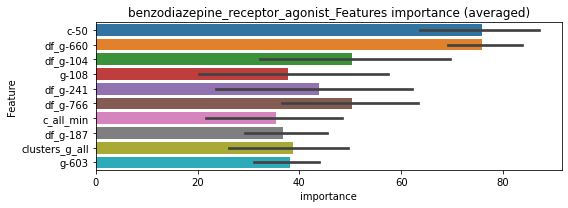

len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296181	valid_1's binary_logloss: 0.076722
[200]	training's binary_logloss: 0.00546829	valid_1's binary_logloss: 0.0511181
[300]	training's binary_logloss: 0.00159004	valid_1's binary_logloss: 0.0473708
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00123454	valid_1's binary_logloss: 0.0466516


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028481	valid_1's binary_logloss: 0.072455
[200]	training's binary_logloss: 0.00514574	valid_1's binary_logloss: 0.0436359
[300]	training's binary_logloss: 0.00154076	valid_1's binary_logloss: 0.0371384
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00154076	valid_1's binary_logloss: 0.0371384


benzodiazepine_receptor_agonist logloss: 0.04189596485601855
beta_amyloid_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746284	valid_1's binary_logloss: 0.118206
[200]	training's binary_logloss: 0.0138283	valid_1's binary_logloss: 0.0416008
[300]	training's binary_logloss: 0.00446362	valid_1's binary_logloss: 0.0219156
[400]	training's binary_logloss: 0.00239739	valid_1's binary_logloss: 0.0169031
[500]	training's binary_logloss: 0.00168691	valid_1's binary_logloss: 0.0139102
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00150512	valid_1's binary_logloss: 0.0128542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675894	valid_1's binary_logloss: 0.162493
[200]	training's binary_logloss: 0.0119158	valid_1's binary_logloss: 0.081931
[300]	training's binary_logloss: 0.00394924	valid_1's binary_logloss: 0.0596423
[400]	training's binary_logloss: 0.00213525	valid_1's binary_logloss: 0.0514958
Early stopping, best iteration is:
[454]	training'

1 / 3 AUC score:0.999
Threshold: 0.4765006190538389
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00290
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00290, conf_1:0.47650
threshold:0.48, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712162	valid_1's binary_logloss: 0.120038
[200]	training's binary_logloss: 0.0128736	valid_1's binary_logloss: 0.043048
[300]	training's binary_logloss: 0.00421116	valid_1's binary_logloss: 0.0235542
[400]	training's binary_logloss: 0.00224577	valid_1's binary_logloss: 0.0174843
[500]	training's binary_logloss: 0.00159221	valid_1's binary_logloss: 0.0149871
[600]	training's binary_logloss: 0.00145033	valid_1's binary_logloss: 0.0140628
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00145832	valid_1's binary_logloss: 0.0140264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719068	valid_1's binary_logloss: 0.132122
[200]	training's binary_logloss: 0.0130771	valid_1's binary_logloss: 0.0477989
[300]	training's binary_logloss: 0.00418193	valid_1's binary_logloss: 0.0276208
[400]	training's binary_logloss: 0.00224709	valid_

2 / 3 AUC score:1.000
Threshold: 0.4765006190538389
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/989
30th percentile: 0.00234
p_label_rate: 0.00201 Vs.target_rate: 0.00108, Num_p_label: 8.0, conf_0:0.00234, conf_1:0.47650
threshold:0.48, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/989, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699339	valid_1's binary_logloss: 0.124141
[200]	training's binary_logloss: 0.0125454	valid_1's binary_logloss: 0.0437644
[300]	training's binary_logloss: 0.00411517	valid_1's binary_logloss: 0.0251755
[400]	training's binary_logloss: 0.00222799	valid_1's binary_logloss: 0.0188761
[500]	training's binary_logloss: 0.00162715	valid_1's binary_logloss: 0.0165411
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00154889	valid_1's binary_logloss: 0.0163552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700023	valid_1's binary_logloss: 0.128923
[200]	training's binary_logloss: 0.0127036	valid_1's binary_logloss: 0.0454179
[300]	training's binary_logloss: 0.00407823	valid_1's binary_logloss: 0.0240734
[400]	training's binary_logloss: 0.00219064	valid_1's binary_logloss: 0.0180719
[500]	training's binary_logloss: 0.00157339	valid

3 / 3 AUC score:1.000
Threshold: 0.4765006190538389
Remove_noisy_labels: 2 → positive_corect_labels: 493.0/987
30th percentile: 0.00233
p_label_rate: 0.00276 Vs.target_rate: 0.00108, Num_p_label: 11.0, conf_0:0.00233, conf_1:0.54332
threshold:0.48, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:504.0/4969, y_label_rate: 0.10143


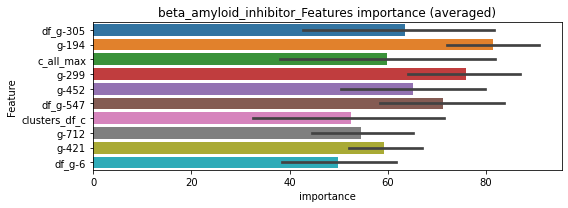

len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197631	valid_1's binary_logloss: 0.0350661
[200]	training's binary_logloss: 0.00248286	valid_1's binary_logloss: 0.0143022
[300]	training's binary_logloss: 0.000731183	valid_1's binary_logloss: 0.0107815
[400]	training's binary_logloss: 0.000386238	valid_1's binary_logloss: 0.00987279
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000377671	valid_1's binary_logloss: 0.0098347


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199426	valid_1's binary_logloss: 0.0362893
[200]	training's binary_logloss: 0.00266848	valid_1's binary_logloss: 0.0145701
[300]	training's binary_logloss: 0.000757081	valid_1's binary_logloss: 0.011507
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000510192	valid_1's binary_logloss: 0.011046


beta_amyloid_inhibitor logloss: 0.010440224794195848
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129907	valid_1's binary_logloss: 0.278744
[200]	training's binary_logloss: 0.0345283	valid_1's binary_logloss: 0.179622
[300]	training's binary_logloss: 0.0121523	valid_1's binary_logloss: 0.143511
[400]	training's binary_logloss: 0.00583935	valid_1's binary_logloss: 0.130384
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00450501	valid_1's binary_logloss: 0.126436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125926	valid_1's binary_logloss: 0.280822
[200]	training's binary_logloss: 0.0328533	valid_1's binary_logloss: 0.177853
[300]	training's binary_logloss: 0.0114704	valid_1's binary_logloss: 0.138671
[400]	training's binary_logloss: 0.00560043	valid_1's binary_logloss: 0.120921
[500]	training's binary_logloss: 0.00356706	valid_1's binary_logloss: 0.112364
[600]	training's binary_logloss: 0.00267064	valid_1's binary_

1 / 3 AUC score:0.990
Threshold: 0.3811570831484755
Remove_noisy_labels: 44 → positive_corect_labels: 478/956
30th percentile: 0.02445
p_label_rate: 0.03240 Vs.target_rate: 0.00295, Num_p_label: 129.0, conf_0:0.02445, conf_1:0.54535
Num_p_label: 129.0, Expected: 11.7, Adj_threshold_1: 0.38
Num_p_label: 103.0, Expected: 11.7, Adj_threshold_2: 0.42
Num_p_label: 72.0, Expected: 11.7, Adj_threshold_3: 0.46
Num_p_label: 60.0, Expected: 11.7, Adj_threshold_4: 0.50
Num_p_label: 39.0, Expected: 11.7, Adj_threshold_5: 0.54
Num_p_label: 28.0, Expected: 11.7, Adj_threshold_6: 0.58
Num_p_label: 23.0, Expected: 11.7, Adj_threshold_7: 0.62
Num_p_label: 21.0, Expected: 11.7, Adj_threshold_8: 0.66
Num_p_label: 17.0, Expected: 11.7, Adj_threshold_9: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:478.0/956, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121506	valid_1's binary_logloss: 0.273395
[200]	training's binary_logloss: 0.031276	valid_1's binary_logloss: 0.167283
[300]	training's binary_logloss: 0.0107428	valid_1's binary_logloss: 0.128403
[400]	training's binary_logloss: 0.00523783	valid_1's binary_logloss: 0.110924
[500]	training's binary_logloss: 0.00329347	valid_1's binary_logloss: 0.104665
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00254857	valid_1's binary_logloss: 0.101159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125259	valid_1's binary_logloss: 0.258249
[200]	training's binary_logloss: 0.0328759	valid_1's binary_logloss: 0.154968
[300]	training's binary_logloss: 0.0114798	valid_1's binary_logloss: 0.114977
[400]	training's binary_logloss: 0.00564549	valid_1's binary_logloss: 0.101742
Early stopping, best iteration is:
[412]	training's binary_log

2 / 3 AUC score:0.993
Threshold: 0.7011570831484757
Remove_noisy_labels: 27 → positive_corect_labels: 451.0/929
30th percentile: 0.02585
p_label_rate: 0.00502 Vs.target_rate: 0.00295, Num_p_label: 20.0, conf_0:0.02585, conf_1:0.70116
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:451.0/929, y_label_rate: 0.48547
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114685	valid_1's binary_logloss: 0.258733
[200]	training's binary_logloss: 0.028185	valid_1's binary_logloss: 0.159016
[300]	training's binary_logloss: 0.00976408	valid_1's binary_logloss: 0.120318
[400]	training's binary_logloss: 0.00482691	valid_1's binary_logloss: 0.104702
[500]	training's binary_logloss: 0.00313323	valid_1's binary_logloss: 0.0990965
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00274702	valid_1's binary_logloss: 0.0978282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121274	valid_1's binary_logloss: 0.261301
[200]	training's binary_logloss: 0.0311655	valid_1's binary_logloss: 0.15346
[300]	training's binary_logloss: 0.0107935	valid_1's binary_logloss: 0.118176
[400]	training's binary_logloss: 0.00525224	valid_1's binary_logloss: 0.103855
[500]	training's binary_logloss: 0.00332888	valid_1's binary

3 / 3 AUC score:0.993
Threshold: 0.7011570831484757
Remove_noisy_labels: 29 → positive_corect_labels: 423.0/900
30th percentile: 0.01502
p_label_rate: 0.00502 Vs.target_rate: 0.00295, Num_p_label: 20.0, conf_0:0.01018, conf_1:0.70116
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:443.0/4882, y_label_rate: 0.09074


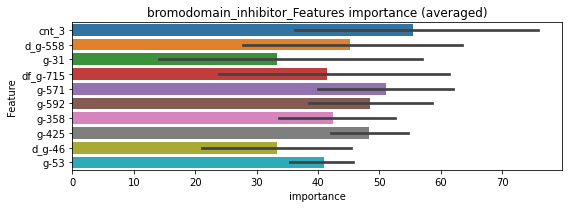

len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309655	valid_1's binary_logloss: 0.0861419
[200]	training's binary_logloss: 0.00588788	valid_1's binary_logloss: 0.060415
[300]	training's binary_logloss: 0.00174203	valid_1's binary_logloss: 0.0558064
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00192803	valid_1's binary_logloss: 0.055322


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303777	valid_1's binary_logloss: 0.0670366
[200]	training's binary_logloss: 0.00575131	valid_1's binary_logloss: 0.0360999
[300]	training's binary_logloss: 0.00168611	valid_1's binary_logloss: 0.0276269
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00125104	valid_1's binary_logloss: 0.0266166


bromodomain_inhibitor logloss: 0.04096932157293882
btk_inhibitor , len(trt) : 29


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833923	valid_1's binary_logloss: 0.142441
[200]	training's binary_logloss: 0.016567	valid_1's binary_logloss: 0.0519078
[300]	training's binary_logloss: 0.00530601	valid_1's binary_logloss: 0.0274291
[400]	training's binary_logloss: 0.00276209	valid_1's binary_logloss: 0.0192575
[500]	training's binary_logloss: 0.00189162	valid_1's binary_logloss: 0.0158578
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00164335	valid_1's binary_logloss: 0.0144331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822799	valid_1's binary_logloss: 0.173902
[200]	training's binary_logloss: 0.0165379	valid_1's binary_logloss: 0.0773643
[300]	training's binary_logloss: 0.0051928	valid_1's binary_logloss: 0.0418335
[400]	training's binary_logloss: 0.00265186	valid_1's binary_logloss: 0.0294956
Early stopping, best iteration is:
[467]	training's

1 / 3 AUC score:1.000
Threshold: 0.4648046752064371
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00519
p_label_rate: 0.00151 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.00519, conf_1:0.46480
threshold:0.46, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833923	valid_1's binary_logloss: 0.142441
[200]	training's binary_logloss: 0.016567	valid_1's binary_logloss: 0.0519078
[300]	training's binary_logloss: 0.00530601	valid_1's binary_logloss: 0.0274291
[400]	training's binary_logloss: 0.00276209	valid_1's binary_logloss: 0.0192575
[500]	training's binary_logloss: 0.00189162	valid_1's binary_logloss: 0.0158578
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00164335	valid_1's binary_logloss: 0.0144331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822799	valid_1's binary_logloss: 0.173902
[200]	training's binary_logloss: 0.0165379	valid_1's binary_logloss: 0.0773643
[300]	training's binary_logloss: 0.0051928	valid_1's binary_logloss: 0.0418335
[400]	training's binary_logloss: 0.00265186	valid_1's binary_logloss: 0.0294956
Early stopping, best iteration is:
[467]	training's

2 / 3 AUC score:1.000
Threshold: 0.4648046752064371
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00519
p_label_rate: 0.00151 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.00519, conf_1:0.46480
threshold:0.46, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833923	valid_1's binary_logloss: 0.142441
[200]	training's binary_logloss: 0.016567	valid_1's binary_logloss: 0.0519078
[300]	training's binary_logloss: 0.00530601	valid_1's binary_logloss: 0.0274291
[400]	training's binary_logloss: 0.00276209	valid_1's binary_logloss: 0.0192575
[500]	training's binary_logloss: 0.00189162	valid_1's binary_logloss: 0.0158578
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00164335	valid_1's binary_logloss: 0.0144331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822799	valid_1's binary_logloss: 0.173902
[200]	training's binary_logloss: 0.0165379	valid_1's binary_logloss: 0.0773643
[300]	training's binary_logloss: 0.0051928	valid_1's binary_logloss: 0.0418335
[400]	training's binary_logloss: 0.00265186	valid_1's binary_logloss: 0.0294956
Early stopping, best iteration is:
[467]	training's

3 / 3 AUC score:1.000
Threshold: 0.4648046752064371
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00519
p_label_rate: 0.00151 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.00519, conf_1:0.46480
threshold:0.46, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:506.0/4982, y_label_rate: 0.10157


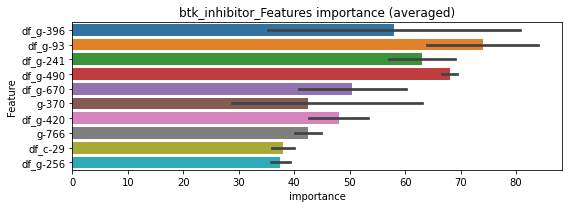

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226781	valid_1's binary_logloss: 0.0414802
[200]	training's binary_logloss: 0.00322207	valid_1's binary_logloss: 0.0153904
[300]	training's binary_logloss: 0.000910886	valid_1's binary_logloss: 0.0108768
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00051331	valid_1's binary_logloss: 0.0101203


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223052	valid_1's binary_logloss: 0.0413515
[200]	training's binary_logloss: 0.00326068	valid_1's binary_logloss: 0.0169883
[300]	training's binary_logloss: 0.000902391	valid_1's binary_logloss: 0.0126617
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000619123	valid_1's binary_logloss: 0.0120694


btk_inhibitor logloss: 0.01109485999263598
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548672	valid_1's binary_logloss: 0.0841176
[200]	training's binary_logloss: 0.00809709	valid_1's binary_logloss: 0.0255874
[300]	training's binary_logloss: 0.00248446	valid_1's binary_logloss: 0.0143901
[400]	training's binary_logloss: 0.00138894	valid_1's binary_logloss: 0.0113444
[500]	training's binary_logloss: 0.00113487	valid_1's binary_logloss: 0.0103354
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00108561	valid_1's binary_logloss: 0.00991884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525177	valid_1's binary_logloss: 0.089628
[200]	training's binary_logloss: 0.00746377	valid_1's binary_logloss: 0.0266678
[300]	training's binary_logloss: 0.00236337	valid_1's binary_logloss: 0.0131451
[400]	training's binary_logloss: 0.00134917	valid_1's binary_logloss: 0.00894606
Early stopping, best iteration is:
[460]	tra

1 / 3 AUC score:1.000
Threshold: 0.686506449092701
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00083
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00083, conf_1:0.68651
threshold:0.69, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530782	valid_1's binary_logloss: 0.0871872
[200]	training's binary_logloss: 0.00773884	valid_1's binary_logloss: 0.0265651
[300]	training's binary_logloss: 0.00245162	valid_1's binary_logloss: 0.014402
[400]	training's binary_logloss: 0.00138063	valid_1's binary_logloss: 0.010043
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00116416	valid_1's binary_logloss: 0.00909379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547329	valid_1's binary_logloss: 0.0838765
[200]	training's binary_logloss: 0.00776933	valid_1's binary_logloss: 0.0242554
[300]	training's binary_logloss: 0.00240018	valid_1's binary_logloss: 0.012227
[400]	training's binary_logloss: 0.00137753	valid_1's binary_logloss: 0.00873014
[500]	training's binary_logloss: 0.00114091	valid_1's binary_logloss: 0.00762791
Early stopping, best iteration is:
[533]	trai

2 / 3 AUC score:1.000
Threshold: 0.686506449092701
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00079
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00079, conf_1:0.68651
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.69
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.65
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.61
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.57
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_5: 0.53
threshold:0.53, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530782	valid_1's binary_logloss: 0.0871872
[200]	training's binary_logloss: 0.00773884	valid_1's binary_logloss: 0.0265651
[300]	training's binary_logloss: 0.00245162	valid_1's binary_logloss: 0.014402
[400]	training's binary_logloss: 0.00138063	valid_1's binary_logloss: 0.010043
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00116416	valid_1's binary_logloss: 0.00909379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547329	valid_1's binary_logloss: 0.0838765
[200]	training's binary_logloss: 0.00776933	valid_1's binary_logloss: 0.0242554
[300]	training's binary_logloss: 0.00240018	valid_1's binary_logloss: 0.012227
[400]	training's binary_logloss: 0.00137753	valid_1's binary_logloss: 0.00873014
[500]	training's binary_logloss: 0.00114091	valid_1's binary_logloss: 0.00762791
Early stopping, best iteration is:
[533]	trai

3 / 3 AUC score:1.000
Threshold: 0.5265064490927008
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00079
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00079, conf_1:0.52651
threshold:0.53, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4979, y_label_rate: 0.10062


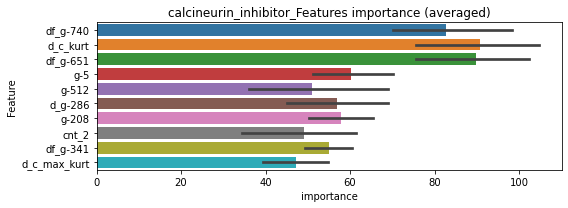

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126626	valid_1's binary_logloss: 0.017494
[200]	training's binary_logloss: 0.00136274	valid_1's binary_logloss: 0.00389201
[300]	training's binary_logloss: 0.000400017	valid_1's binary_logloss: 0.00241959
[400]	training's binary_logloss: 0.000231421	valid_1's binary_logloss: 0.00218189
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000236111	valid_1's binary_logloss: 0.00217918


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128071	valid_1's binary_logloss: 0.0185639
[200]	training's binary_logloss: 0.00139022	valid_1's binary_logloss: 0.00397264
[300]	training's binary_logloss: 0.000406838	valid_1's binary_logloss: 0.00219509
[400]	training's binary_logloss: 0.000235074	valid_1's binary_logloss: 0.00185047
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00022603	valid_1's binary_logloss: 0.00184274


calcineurin_inhibitor logloss: 0.0020109944396573074
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210767	valid_1's binary_logloss: 0.602419
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0974376	valid_1's binary_logloss: 0.573051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21361	valid_1's binary_logloss: 0.596042


1 / 3 AUC score:0.760
Threshold: 0.4875428991521491
Remove_noisy_labels: 314 → positive_corect_labels: 343/686
30th percentile: 0.35483
p_label_rate: 0.28227 Vs.target_rate: 0.00966, Num_p_label: 1124.0, conf_0:0.35483, conf_1:0.49244
Num_p_label: 1124.0, Expected: 38.5, Adj_threshold_1: 0.49
Num_p_label: 732.0, Expected: 38.5, Adj_threshold_2: 0.53
Num_p_label: 421.0, Expected: 38.5, Adj_threshold_3: 0.57
Num_p_label: 227.0, Expected: 38.5, Adj_threshold_4: 0.61
Num_p_label: 96.0, Expected: 38.5, Adj_threshold_5: 0.65
Num_p_label: 41.0, Expected: 38.5, Adj_threshold_6: 0.69


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.122508	valid_1's binary_logloss: 0.573383


threshold:0.69, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:343.0/686, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194152	valid_1's binary_logloss: 0.517629
[200]	training's binary_logloss: 0.0682637	valid_1's binary_logloss: 0.448574
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0384731	valid_1's binary_logloss: 0.423008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178112	valid_1's binary_logloss: 0.5115
[200]	training's binary_logloss: 0.0611156	valid_1's binary_logloss: 0.476369
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0611156	valid_1's binary_logloss: 0.476369


2 / 3 AUC score:0.867
Threshold: 0.6875428991521493
Remove_noisy_labels: 140 → positive_corect_labels: 219.0/546
30th percentile: 0.26376
p_label_rate: 0.08689 Vs.target_rate: 0.00966, Num_p_label: 346.0, conf_0:0.26376, conf_1:0.68754
Num_p_label: 346.0, Expected: 38.5, Adj_threshold_1: 0.69
Num_p_label: 222.0, Expected: 38.5, Adj_threshold_2: 0.73
Num_p_label: 127.0, Expected: 38.5, Adj_threshold_3: 0.77
Num_p_label: 71.0, Expected: 38.5, Adj_threshold_4: 0.81
Num_p_label: 33.0, Expected: 38.5, Adj_threshold_5: 0.85
threshold:0.85, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:219.0/546, y_label_rate: 0.40110
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160699	valid_1's binary_logloss: 0.380638
[200]	training's binary_logloss: 0.0537088	valid_1's binary_logloss: 0.296618
[300]	training's binary_logloss: 0.0217221	valid_1's binary_logloss: 0.251599
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0172507	valid_1's binary_logloss: 0.247124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159101	valid_1's binary_logloss: 0.430967
[200]	training's binary_logloss: 0.0507329	valid_1's binary_logloss: 0.34283


3 / 3 AUC score:0.957
Threshold: 0.8475428991521494
Remove_noisy_labels: 110 → positive_corect_labels: 110.0/436
30th percentile: 0.10344
p_label_rate: 0.01256 Vs.target_rate: 0.00966, Num_p_label: 50.0, conf_0:0.09367, conf_1:0.84754
threshold:0.85, positive p_label:50.0/3982, p_label_rate: 0.01256


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0222099	valid_1's binary_logloss: 0.313969


positive y_label:160.0/4418, y_label_rate: 0.03622


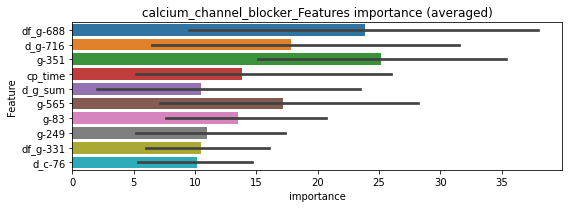

len(train_index) : 2209
len(valid_index) : 2209
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143431	valid_1's binary_logloss: 0.104408


len(train_index) : 2209
len(valid_index) : 2209
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0103082	valid_1's binary_logloss: 0.103424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155397	valid_1's binary_logloss: 0.106793
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0174474	valid_1's binary_logloss: 0.106452


calcium_channel_blocker logloss: 0.10493789043029889
cannabinoid_receptor_agonist , len(trt) : 42


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105049	valid_1's binary_logloss: 0.203594
[200]	training's binary_logloss: 0.0242459	valid_1's binary_logloss: 0.103636
[300]	training's binary_logloss: 0.00815435	valid_1's binary_logloss: 0.0775272
[400]	training's binary_logloss: 0.00391321	valid_1's binary_logloss: 0.0643469
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00347616	valid_1's binary_logloss: 0.0626585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102644	valid_1's binary_logloss: 0.196831
[200]	training's binary_logloss: 0.0235795	valid_1's binary_logloss: 0.0957216
[300]	training's binary_logloss: 0.00772826	valid_1's binary_logloss: 0.0620428
[400]	training's binary_logloss: 0.00381424	valid_1's binary_logloss: 0.0490087
[500]	training's binary_logloss: 0.00248607	valid_1's binary_logloss: 0.0433623
[600]	training's binary_logloss: 0.00193664	valid_1'

1 / 3 AUC score:0.999
Threshold: 0.4452506923933214
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.00801
p_label_rate: 0.01482 Vs.target_rate: 0.00187, Num_p_label: 59.0, conf_0:0.00801, conf_1:0.55821
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_1: 0.45
Num_p_label: 54.0, Expected: 7.4, Adj_threshold_2: 0.49
Num_p_label: 44.0, Expected: 7.4, Adj_threshold_3: 0.53
Num_p_label: 29.0, Expected: 7.4, Adj_threshold_4: 0.57
Num_p_label: 21.0, Expected: 7.4, Adj_threshold_5: 0.61
Num_p_label: 14.0, Expected: 7.4, Adj_threshold_6: 0.65
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_7: 0.69
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_8: 0.73
threshold:0.73, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991913	valid_1's binary_logloss: 0.191228
[200]	training's binary_logloss: 0.0224054	valid_1's binary_logloss: 0.0832369
[300]	training's binary_logloss: 0.00745272	valid_1's binary_logloss: 0.0521258
[400]	training's binary_logloss: 0.00371368	valid_1's binary_logloss: 0.0400071
[500]	training's binary_logloss: 0.00245829	valid_1's binary_logloss: 0.0354836
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00198061	valid_1's binary_logloss: 0.0327829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101	valid_1's binary_logloss: 0.206916
[200]	training's binary_logloss: 0.0222369	valid_1's binary_logloss: 0.106438
[300]	training's binary_logloss: 0.00731441	valid_1's binary_logloss: 0.0749207
[400]	training's binary_logloss: 0.00366336	valid_1's binary_logloss: 0.0624767
[500]	training's binary_logloss: 0.00242159	valid_1's 

2 / 3 AUC score:0.998
Threshold: 0.7252506923933215
Remove_noisy_labels: 13 → positive_corect_labels: 479.0/971
30th percentile: 0.00651
p_label_rate: 0.00176 Vs.target_rate: 0.00187, Num_p_label: 7.0, conf_0:0.00542, conf_1:0.72525
threshold:0.73, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:479.0/971, y_label_rate: 0.49331
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972942	valid_1's binary_logloss: 0.204915
[200]	training's binary_logloss: 0.0217912	valid_1's binary_logloss: 0.100943
[300]	training's binary_logloss: 0.00714511	valid_1's binary_logloss: 0.0701185
[400]	training's binary_logloss: 0.0035775	valid_1's binary_logloss: 0.0595457
[500]	training's binary_logloss: 0.00235226	valid_1's binary_logloss: 0.0550048
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00235226	valid_1's binary_logloss: 0.0550048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984228	valid_1's binary_logloss: 0.18128
[200]	training's binary_logloss: 0.0219374	valid_1's binary_logloss: 0.0818927
[300]	training's binary_logloss: 0.00715106	valid_1's binary_logloss: 0.0504141
[400]	training's binary_logloss: 0.00355177	valid_1's binary_logloss: 0.0383596
[500]	training's binary_logloss: 0.00235781	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.7252506923933215
Remove_noisy_labels: 9 → positive_corect_labels: 470.0/962
30th percentile: 0.00543
p_label_rate: 0.00226 Vs.target_rate: 0.00187, Num_p_label: 9.0, conf_0:0.00543, conf_1:0.72525
threshold:0.73, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:479.0/4944, y_label_rate: 0.09689


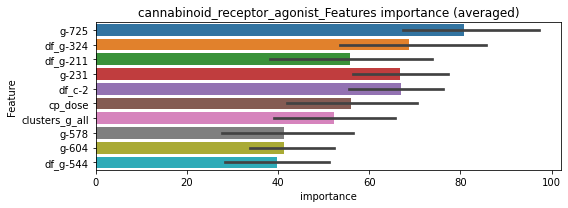

len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231996	valid_1's binary_logloss: 0.0466883
[200]	training's binary_logloss: 0.00381429	valid_1's binary_logloss: 0.0192748
[300]	training's binary_logloss: 0.00112716	valid_1's binary_logloss: 0.0138504
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000744437	valid_1's binary_logloss: 0.0128033


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240302	valid_1's binary_logloss: 0.0492135
[200]	training's binary_logloss: 0.00383917	valid_1's binary_logloss: 0.0223791
[300]	training's binary_logloss: 0.00112632	valid_1's binary_logloss: 0.0165314
[400]	training's binary_logloss: 0.000573191	valid_1's binary_logloss: 0.0150801
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000503808	valid_1's binary_logloss: 0.0148349


cannabinoid_receptor_agonist logloss: 0.013819128577773397
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11219	valid_1's binary_logloss: 0.227341
[200]	training's binary_logloss: 0.0275512	valid_1's binary_logloss: 0.116892
[300]	training's binary_logloss: 0.00955838	valid_1's binary_logloss: 0.0804597
[400]	training's binary_logloss: 0.00479705	valid_1's binary_logloss: 0.0634081
[500]	training's binary_logloss: 0.00309789	valid_1's binary_logloss: 0.0557625
[600]	training's binary_logloss: 0.00236321	valid_1's binary_logloss: 0.0511949
[700]	training's binary_logloss: 0.00204526	valid_1's binary_logloss: 0.04895
Early stopping, best iteration is:
[731]	training's binary_logloss: 0.00200789	valid_1's binary_logloss: 0.0487702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118068	valid_1's binary_logloss: 0.231216
[200]	training's binary_logloss: 0.0294446	valid_1's binary_logloss: 0.118101
[300]	training's binary_logloss: 0.0101697	valid_1's bin

1 / 3 AUC score:1.000
Threshold: 0.41106701087554887
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.01416
p_label_rate: 0.00427 Vs.target_rate: 0.00241, Num_p_label: 17.0, conf_0:0.01416, conf_1:0.41107
threshold:0.41, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109451	valid_1's binary_logloss: 0.236655
[200]	training's binary_logloss: 0.0266551	valid_1's binary_logloss: 0.125474
[300]	training's binary_logloss: 0.00918888	valid_1's binary_logloss: 0.0846862
[400]	training's binary_logloss: 0.00456792	valid_1's binary_logloss: 0.0675771
[500]	training's binary_logloss: 0.00295271	valid_1's binary_logloss: 0.0601734
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00236135	valid_1's binary_logloss: 0.0565172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116262	valid_1's binary_logloss: 0.230989
[200]	training's binary_logloss: 0.0282385	valid_1's binary_logloss: 0.126204
[300]	training's binary_logloss: 0.00976414	valid_1's binary_logloss: 0.0895305
[400]	training's binary_logloss: 0.00477177	valid_1's binary_logloss: 0.0736894
[500]	training's binary_logloss: 0.00304906	valid_1's

2 / 3 AUC score:0.999
Threshold: 0.41106701087554887
Remove_noisy_labels: 11 → positive_corect_labels: 485.0/975
30th percentile: 0.01416
p_label_rate: 0.00276 Vs.target_rate: 0.00241, Num_p_label: 11.0, conf_0:0.01213, conf_1:0.42609
threshold:0.41, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/975, y_label_rate: 0.49744
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11334	valid_1's binary_logloss: 0.239689
[200]	training's binary_logloss: 0.0276472	valid_1's binary_logloss: 0.136285
[300]	training's binary_logloss: 0.00942355	valid_1's binary_logloss: 0.10411
[400]	training's binary_logloss: 0.00466577	valid_1's binary_logloss: 0.088158
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00399848	valid_1's binary_logloss: 0.0850283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110161	valid_1's binary_logloss: 0.231748
[200]	training's binary_logloss: 0.0268152	valid_1's binary_logloss: 0.127015
[300]	training's binary_logloss: 0.00916212	valid_1's binary_logloss: 0.0887644
[400]	training's binary_logloss: 0.00453354	valid_1's binary_logloss: 0.0717741
[500]	training's binary_logloss: 0.00295788	valid_1's binary_logloss: 0.0644838
[600]	training's binary_logloss: 0.00224539	valid_1's bin

3 / 3 AUC score:0.997
Threshold: 0.41106701087554887
Remove_noisy_labels: 16 → positive_corect_labels: 473.0/959
30th percentile: 0.01817
p_label_rate: 0.00402 Vs.target_rate: 0.00241, Num_p_label: 16.0, conf_0:0.01817, conf_1:0.41107
threshold:0.41, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:489.0/4941, y_label_rate: 0.09897


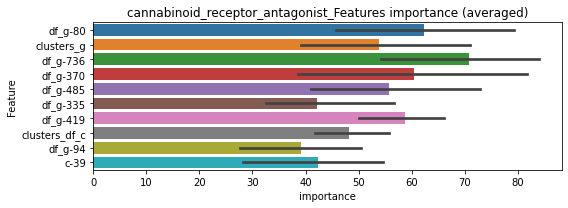

len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275128	valid_1's binary_logloss: 0.0656518
[200]	training's binary_logloss: 0.00480703	valid_1's binary_logloss: 0.0419043
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00242873	valid_1's binary_logloss: 0.0394505


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308635	valid_1's binary_logloss: 0.0729319
[200]	training's binary_logloss: 0.00536162	valid_1's binary_logloss: 0.0463482
[300]	training's binary_logloss: 0.00151616	valid_1's binary_logloss: 0.040281
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00127529	valid_1's binary_logloss: 0.0400874


cannabinoid_receptor_antagonist logloss: 0.039768913759698245
carbonic_anhydrase_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099404	valid_1's binary_logloss: 0.184733
[200]	training's binary_logloss: 0.0212484	valid_1's binary_logloss: 0.0827461
[300]	training's binary_logloss: 0.00709669	valid_1's binary_logloss: 0.0477921
[400]	training's binary_logloss: 0.00359224	valid_1's binary_logloss: 0.0353855
[500]	training's binary_logloss: 0.00239665	valid_1's binary_logloss: 0.030057
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00200982	valid_1's binary_logloss: 0.0276378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977766	valid_1's binary_logloss: 0.184089
[200]	training's binary_logloss: 0.021068	valid_1's binary_logloss: 0.081742
[300]	training's binary_logloss: 0.00702587	valid_1's binary_logloss: 0.0514694
[400]	training's binary_logloss: 0.00348783	valid_1's binary_logloss: 0.0399095
[500]	training's binary_logloss: 0.00232039	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.5040624135330803
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00725
p_label_rate: 0.00050 Vs.target_rate: 0.00161, Num_p_label: 2.0, conf_0:0.00725, conf_1:0.50406
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 4.0, Expected: 6.4, Adj_threshold_2: 0.46
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969305	valid_1's binary_logloss: 0.181958
[200]	training's binary_logloss: 0.0207325	valid_1's binary_logloss: 0.0803395
[300]	training's binary_logloss: 0.0067826	valid_1's binary_logloss: 0.0489505
[400]	training's binary_logloss: 0.00345401	valid_1's binary_logloss: 0.0378158
[500]	training's binary_logloss: 0.00234315	valid_1's binary_logloss: 0.0321192
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00216593	valid_1's binary_logloss: 0.0310963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102175	valid_1's binary_logloss: 0.174849
[200]	training's binary_logloss: 0.0225531	valid_1's binary_logloss: 0.0717275
[300]	training's binary_logloss: 0.00723226	valid_1's binary_logloss: 0.0411789
[400]	training's binary_logloss: 0.00359483	valid_1's binary_logloss: 0.0293251
[500]	training's binary_logloss: 0.0024232	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.4240624135330804
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/993
30th percentile: 0.00787
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00787, conf_1:0.42406
threshold:0.42, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986913	valid_1's binary_logloss: 0.180572
[200]	training's binary_logloss: 0.0214227	valid_1's binary_logloss: 0.0772297
[300]	training's binary_logloss: 0.007091	valid_1's binary_logloss: 0.045006
[400]	training's binary_logloss: 0.00355367	valid_1's binary_logloss: 0.0322581
[500]	training's binary_logloss: 0.00236536	valid_1's binary_logloss: 0.0272743
[600]	training's binary_logloss: 0.00191787	valid_1's binary_logloss: 0.0247146
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.00185175	valid_1's binary_logloss: 0.0244801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945585	valid_1's binary_logloss: 0.192453
[200]	training's binary_logloss: 0.0208365	valid_1's binary_logloss: 0.0909141
[300]	training's binary_logloss: 0.00677711	valid_1's binary_logloss: 0.058942
[400]	training's binary_logloss: 0.00344435	valid_1's

3 / 3 AUC score:1.000


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00263363	valid_1's binary_logloss: 0.0428879


Threshold: 0.4240624135330804
Remove_noisy_labels: 8 → positive_corect_labels: 497.0/985
30th percentile: 0.00913
p_label_rate: 0.00578 Vs.target_rate: 0.00161, Num_p_label: 23.0, conf_0:0.00913, conf_1:0.42406
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_1: 0.42
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_2: 0.46
Num_p_label: 5.0, Expected: 6.4, Adj_threshold_3: 0.50
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:502.0/4967, y_label_rate: 0.10107


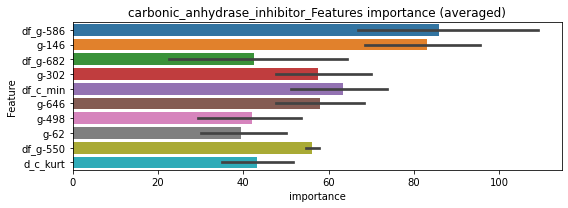

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246759	valid_1's binary_logloss: 0.0469909
[200]	training's binary_logloss: 0.00405079	valid_1's binary_logloss: 0.0186323
[300]	training's binary_logloss: 0.00115342	valid_1's binary_logloss: 0.0128193
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00063028	valid_1's binary_logloss: 0.0117165


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287994	valid_1's binary_logloss: 0.0476439
[200]	training's binary_logloss: 0.0046951	valid_1's binary_logloss: 0.0177832
[300]	training's binary_logloss: 0.00124965	valid_1's binary_logloss: 0.0116251
[400]	training's binary_logloss: 0.000600795	valid_1's binary_logloss: 0.0101325
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000429054	valid_1's binary_logloss: 0.0096564


carbonic_anhydrase_inhibitor logloss: 0.010686680838031216
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869486	valid_1's binary_logloss: 0.150439
[200]	training's binary_logloss: 0.0178979	valid_1's binary_logloss: 0.0577584
[300]	training's binary_logloss: 0.00576569	valid_1's binary_logloss: 0.032362
[400]	training's binary_logloss: 0.00299855	valid_1's binary_logloss: 0.0240036
[500]	training's binary_logloss: 0.00204547	valid_1's binary_logloss: 0.0200197
[600]	training's binary_logloss: 0.0017219	valid_1's binary_logloss: 0.0179485
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00171068	valid_1's binary_logloss: 0.0178476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839973	valid_1's binary_logloss: 0.156262
[200]	training's binary_logloss: 0.0168221	valid_1's binary_logloss: 0.0662856
[300]	training's binary_logloss: 0.00545365	valid_1's binary_logloss: 0.043342
[400]	training's binary_logloss: 0.0028472	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.2912354858915237
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00501
p_label_rate: 0.00578 Vs.target_rate: 0.00161, Num_p_label: 23.0, conf_0:0.00501, conf_1:0.36036
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_1: 0.29
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_2: 0.33
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_3: 0.37
threshold:0.37, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843481	valid_1's binary_logloss: 0.165575
[200]	training's binary_logloss: 0.0171684	valid_1's binary_logloss: 0.0725303
[300]	training's binary_logloss: 0.00555947	valid_1's binary_logloss: 0.0449673
[400]	training's binary_logloss: 0.00292172	valid_1's binary_logloss: 0.0362016
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00253832	valid_1's binary_logloss: 0.0349733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827871	valid_1's binary_logloss: 0.159898
[200]	training's binary_logloss: 0.0165925	valid_1's binary_logloss: 0.0710613
[300]	training's binary_logloss: 0.00545856	valid_1's binary_logloss: 0.0437378
[400]	training's binary_logloss: 0.00282906	valid_1's binary_logloss: 0.0349949
[500]	training's binary_logloss: 0.00195408	valid_1's binary_logloss: 0.0312407
[600]	training's binary_logloss: 0.00163124	valid

2 / 3 AUC score:1.000
Threshold: 0.37123548589152366
Remove_noisy_labels: 11 → positive_corect_labels: 493.0/985
30th percentile: 0.00619
p_label_rate: 0.00352 Vs.target_rate: 0.00161, Num_p_label: 14.0, conf_0:0.00619, conf_1:0.46329
threshold:0.37, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:493.0/985, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802845	valid_1's binary_logloss: 0.153461
[200]	training's binary_logloss: 0.0158876	valid_1's binary_logloss: 0.0632845
[300]	training's binary_logloss: 0.00522086	valid_1's binary_logloss: 0.0367075
[400]	training's binary_logloss: 0.0027713	valid_1's binary_logloss: 0.0281212
[500]	training's binary_logloss: 0.00193003	valid_1's binary_logloss: 0.0251617
[600]	training's binary_logloss: 0.00164471	valid_1's binary_logloss: 0.0237382
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00159285	valid_1's binary_logloss: 0.0234473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891156	valid_1's binary_logloss: 0.149861
[200]	training's binary_logloss: 0.0183565	valid_1's binary_logloss: 0.0552404
[300]	training's binary_logloss: 0.00589318	valid_1's binary_logloss: 0.0308987
[400]	training's binary_logloss: 0.00303393	valid_

3 / 3 AUC score:1.000
Threshold: 0.37123548589152366
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/982
30th percentile: 0.00497
p_label_rate: 0.00603 Vs.target_rate: 0.00161, Num_p_label: 24.0, conf_0:0.00497, conf_1:0.43224
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_1: 0.37
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_2: 0.41
Num_p_label: 10.0, Expected: 6.4, Adj_threshold_3: 0.45
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/4964, y_label_rate: 0.10052


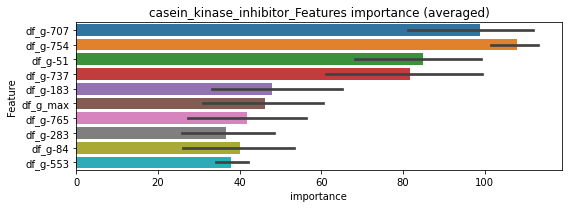

len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205761	valid_1's binary_logloss: 0.0483694
[200]	training's binary_logloss: 0.00309201	valid_1's binary_logloss: 0.0245646
[300]	training's binary_logloss: 0.000910642	valid_1's binary_logloss: 0.0193453
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000614968	valid_1's binary_logloss: 0.0187354


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201866	valid_1's binary_logloss: 0.0391606
[200]	training's binary_logloss: 0.0030149	valid_1's binary_logloss: 0.0175102
[300]	training's binary_logloss: 0.000897788	valid_1's binary_logloss: 0.0138571
[400]	training's binary_logloss: 0.000478294	valid_1's binary_logloss: 0.0129633
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000393452	valid_1's binary_logloss: 0.0127726


casein_kinase_inhibitor logloss: 0.015753992524889286
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667336	valid_1's binary_logloss: 0.108781
[200]	training's binary_logloss: 0.0113246	valid_1's binary_logloss: 0.0324893
[300]	training's binary_logloss: 0.00356862	valid_1's binary_logloss: 0.0162268
[400]	training's binary_logloss: 0.0019327	valid_1's binary_logloss: 0.011298
[500]	training's binary_logloss: 0.00143857	valid_1's binary_logloss: 0.00932339
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.0013722	valid_1's binary_logloss: 0.00901225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066857	valid_1's binary_logloss: 0.11244
[200]	training's binary_logloss: 0.0107851	valid_1's binary_logloss: 0.0393525
[300]	training's binary_logloss: 0.00344904	valid_1's binary_logloss: 0.0240172
[400]	training's binary_logloss: 0.00188466	valid_1's binary_logloss: 0.0193994
[500]	training's binary_logloss: 0.00139466	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.30246350078167683
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00175
p_label_rate: 0.00527 Vs.target_rate: 0.00082, Num_p_label: 21.0, conf_0:0.00175, conf_1:0.42869
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_1: 0.30
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_2: 0.34
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_3: 0.38
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671625	valid_1's binary_logloss: 0.11078
[200]	training's binary_logloss: 0.0114489	valid_1's binary_logloss: 0.0336785
[300]	training's binary_logloss: 0.0036014	valid_1's binary_logloss: 0.017065
[400]	training's binary_logloss: 0.00194323	valid_1's binary_logloss: 0.0121405
[500]	training's binary_logloss: 0.00142757	valid_1's binary_logloss: 0.0102609
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00131284	valid_1's binary_logloss: 0.00974445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646245	valid_1's binary_logloss: 0.104211
[200]	training's binary_logloss: 0.0107523	valid_1's binary_logloss: 0.0322438
[300]	training's binary_logloss: 0.00346423	valid_1's binary_logloss: 0.0174528
[400]	training's binary_logloss: 0.00186653	valid_1's binary_logloss: 0.0127888
[500]	training's binary_logloss: 0.001391	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.42246350078167677
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00158
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00158, conf_1:0.47175
threshold:0.42, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671625	valid_1's binary_logloss: 0.11078
[200]	training's binary_logloss: 0.0114489	valid_1's binary_logloss: 0.0336785
[300]	training's binary_logloss: 0.0036014	valid_1's binary_logloss: 0.017065
[400]	training's binary_logloss: 0.00194323	valid_1's binary_logloss: 0.0121405
[500]	training's binary_logloss: 0.00142757	valid_1's binary_logloss: 0.0102609
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00131284	valid_1's binary_logloss: 0.00974445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646245	valid_1's binary_logloss: 0.104211
[200]	training's binary_logloss: 0.0107523	valid_1's binary_logloss: 0.0322438
[300]	training's binary_logloss: 0.00346423	valid_1's binary_logloss: 0.0174528
[400]	training's binary_logloss: 0.00186653	valid_1's binary_logloss: 0.0127888
[500]	training's binary_logloss: 0.001391	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.42246350078167677
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00158
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00158, conf_1:0.47175
threshold:0.42, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:504.0/4978, y_label_rate: 0.10125


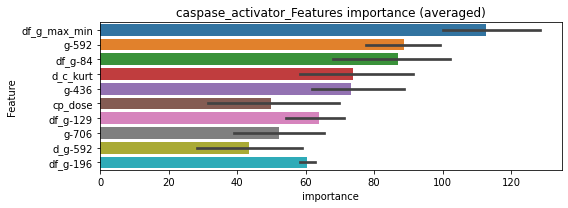

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163787	valid_1's binary_logloss: 0.0285984
[200]	training's binary_logloss: 0.00200607	valid_1's binary_logloss: 0.0122011
[300]	training's binary_logloss: 0.000583833	valid_1's binary_logloss: 0.00999619
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00041193	valid_1's binary_logloss: 0.00967858


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157177	valid_1's binary_logloss: 0.0299637
[200]	training's binary_logloss: 0.00189783	valid_1's binary_logloss: 0.0149719
[300]	training's binary_logloss: 0.000572804	valid_1's binary_logloss: 0.0129834
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000328462	valid_1's binary_logloss: 0.0124747


caspase_activator logloss: 0.01107663398680595
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629383	valid_1's binary_logloss: 0.101816
[200]	training's binary_logloss: 0.0102295	valid_1's binary_logloss: 0.0316783
[300]	training's binary_logloss: 0.00326341	valid_1's binary_logloss: 0.017652
[400]	training's binary_logloss: 0.00182193	valid_1's binary_logloss: 0.013692
[500]	training's binary_logloss: 0.00140816	valid_1's binary_logloss: 0.0120952
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00133797	valid_1's binary_logloss: 0.011719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614088	valid_1's binary_logloss: 0.11419
[200]	training's binary_logloss: 0.00998557	valid_1's binary_logloss: 0.0488495
[300]	training's binary_logloss: 0.00322686	valid_1's binary_logloss: 0.0345285
[400]	training's binary_logloss: 0.00181042	valid_1's binary_logloss: 0.0279468
[500]	training's binary_logloss: 0.00137181	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.3253745290934027
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00146
p_label_rate: 0.00427 Vs.target_rate: 0.00082, Num_p_label: 17.0, conf_0:0.00146, conf_1:0.51104
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_1: 0.33
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_2: 0.37
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_3: 0.41
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_4: 0.45
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_5: 0.49
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_6: 0.53
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_7: 0.57
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.61
threshold:0.61, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606963	valid_1's binary_logloss: 0.110414
[200]	training's binary_logloss: 0.00995687	valid_1's binary_logloss: 0.0365498
[300]	training's binary_logloss: 0.00321433	valid_1's binary_logloss: 0.0204286
[400]	training's binary_logloss: 0.00178099	valid_1's binary_logloss: 0.0153879
[500]	training's binary_logloss: 0.00137713	valid_1's binary_logloss: 0.0136611
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00128657	valid_1's binary_logloss: 0.0130908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642372	valid_1's binary_logloss: 0.0906545
[200]	training's binary_logloss: 0.0105422	valid_1's binary_logloss: 0.0270171
[300]	training's binary_logloss: 0.00338262	valid_1's binary_logloss: 0.0134928
[400]	training's binary_logloss: 0.00186093	valid_1's binary_logloss: 0.00986066
Early stopping, best iteration is:
[455]	train

2 / 3 AUC score:1.000
Threshold: 0.6053745290934027
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/992
30th percentile: 0.00164
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00164, conf_1:0.60537
threshold:0.61, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612163	valid_1's binary_logloss: 0.110382
[200]	training's binary_logloss: 0.0098192	valid_1's binary_logloss: 0.0363287
[300]	training's binary_logloss: 0.00319488	valid_1's binary_logloss: 0.0196204
[400]	training's binary_logloss: 0.00177275	valid_1's binary_logloss: 0.0147002
[500]	training's binary_logloss: 0.00135952	valid_1's binary_logloss: 0.0129602
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00132239	valid_1's binary_logloss: 0.0127875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618676	valid_1's binary_logloss: 0.0873472
[200]	training's binary_logloss: 0.0103341	valid_1's binary_logloss: 0.0233971
[300]	training's binary_logloss: 0.00334147	valid_1's binary_logloss: 0.0109018
[400]	training's binary_logloss: 0.00184193	valid_1's binary_logloss: 0.00737035
[500]	training's binary_logloss: 0.00139227	val

3 / 3 AUC score:1.000
Threshold: 0.6053745290934027
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/991
30th percentile: 0.00153
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00153, conf_1:0.60537
threshold:0.61, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:501.0/4973, y_label_rate: 0.10074


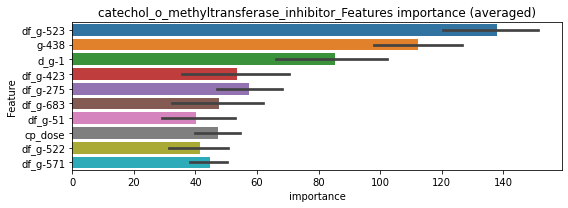

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167255	valid_1's binary_logloss: 0.024919
[200]	training's binary_logloss: 0.00206547	valid_1's binary_logloss: 0.00725143
[300]	training's binary_logloss: 0.000578952	valid_1's binary_logloss: 0.00507801
[400]	training's binary_logloss: 0.000311233	valid_1's binary_logloss: 0.00468061
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000289632	valid_1's binary_logloss: 0.00464756


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167827	valid_1's binary_logloss: 0.0286767
[200]	training's binary_logloss: 0.00202043	valid_1's binary_logloss: 0.00998043
[300]	training's binary_logloss: 0.000582315	valid_1's binary_logloss: 0.0069954
[400]	training's binary_logloss: 0.000315942	valid_1's binary_logloss: 0.00627938
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000292538	valid_1's binary_logloss: 0.00622421


catechol_o_methyltransferase_inhibitor logloss: 0.0054357287393391705
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139397	valid_1's binary_logloss: 0.335038
[200]	training's binary_logloss: 0.0398325	valid_1's binary_logloss: 0.253354
[300]	training's binary_logloss: 0.0148196	valid_1's binary_logloss: 0.224693
[400]	training's binary_logloss: 0.00720164	valid_1's binary_logloss: 0.213713
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.0054653	valid_1's binary_logloss: 0.209232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145487	valid_1's binary_logloss: 0.346571
[200]	training's binary_logloss: 0.0419582	valid_1's binary_logloss: 0.258229
[300]	training's binary_logloss: 0.0154839	valid_1's binary_logloss: 0.225453
[400]	training's binary_logloss: 0.00749393	valid_1's binary_logloss: 0.213718
[500]	training's binary_logloss: 0.00459457	valid_1's binary_logloss: 0.206786
Early stopping, best iteration is:
[501]	training's binary_log

1 / 3 AUC score:0.963
Threshold: 0.331226009511259
Remove_noisy_labels: 84 → positive_corect_labels: 458/916
30th percentile: 0.05683
p_label_rate: 0.08237 Vs.target_rate: 0.00427, Num_p_label: 328.0, conf_0:0.05355, conf_1:0.50637
Num_p_label: 328.0, Expected: 17.0, Adj_threshold_1: 0.33
Num_p_label: 227.0, Expected: 17.0, Adj_threshold_2: 0.37
Num_p_label: 171.0, Expected: 17.0, Adj_threshold_3: 0.41
Num_p_label: 113.0, Expected: 17.0, Adj_threshold_4: 0.45
Num_p_label: 85.0, Expected: 17.0, Adj_threshold_5: 0.49
Num_p_label: 55.0, Expected: 17.0, Adj_threshold_6: 0.53
Num_p_label: 37.0, Expected: 17.0, Adj_threshold_7: 0.57
Num_p_label: 26.0, Expected: 17.0, Adj_threshold_8: 0.61
Num_p_label: 16.0, Expected: 17.0, Adj_threshold_9: 0.65
threshold:0.65, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:458.0/916, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122339	valid_1's binary_logloss: 0.278582
[200]	training's binary_logloss: 0.0333208	valid_1's binary_logloss: 0.183505
[300]	training's binary_logloss: 0.0120913	valid_1's binary_logloss: 0.14803
[400]	training's binary_logloss: 0.0060233	valid_1's binary_logloss: 0.134139
[500]	training's binary_logloss: 0.00387806	valid_1's binary_logloss: 0.124619
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.0035807	valid_1's binary_logloss: 0.123387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131828	valid_1's binary_logloss: 0.286946
[200]	training's binary_logloss: 0.0360512	valid_1's binary_logloss: 0.184557
[300]	training's binary_logloss: 0.0129769	valid_1's binary_logloss: 0.147291
[400]	training's binary_logloss: 0.00641011	valid_1's binary_logloss: 0.129757
[500]	training's binary_logloss: 0.00400321	valid_1's binary_log

2 / 3 AUC score:0.990
Threshold: 0.6512260095112591
Remove_noisy_labels: 40 → positive_corect_labels: 421.0/876
30th percentile: 0.03291
p_label_rate: 0.01180 Vs.target_rate: 0.00427, Num_p_label: 47.0, conf_0:0.01805, conf_1:0.65123
threshold:0.65, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:421.0/876, y_label_rate: 0.48059
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112928	valid_1's binary_logloss: 0.256921
[200]	training's binary_logloss: 0.0284184	valid_1's binary_logloss: 0.159153
[300]	training's binary_logloss: 0.0100867	valid_1's binary_logloss: 0.126016
[400]	training's binary_logloss: 0.00510713	valid_1's binary_logloss: 0.114269
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00384304	valid_1's binary_logloss: 0.111138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111139	valid_1's binary_logloss: 0.225571
[200]	training's binary_logloss: 0.0293941	valid_1's binary_logloss: 0.13549
[300]	training's binary_logloss: 0.0105766	valid_1's binary_logloss: 0.100963
[400]	training's binary_logloss: 0.00536699	valid_1's binary_logloss: 0.0876958
[500]	training's binary_logloss: 0.0035361	valid_1's binary_logloss: 0.0815285
Early stopping, best iteration is:
[530]	training's binary_lo

3 / 3 AUC score:0.995
Threshold: 0.6512260095112591
Remove_noisy_labels: 32 → positive_corect_labels: 396.0/844
30th percentile: 0.01922
p_label_rate: 0.01155 Vs.target_rate: 0.00427, Num_p_label: 46.0, conf_0:0.01895, conf_1:0.65123
threshold:0.65, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:442.0/4826, y_label_rate: 0.09159


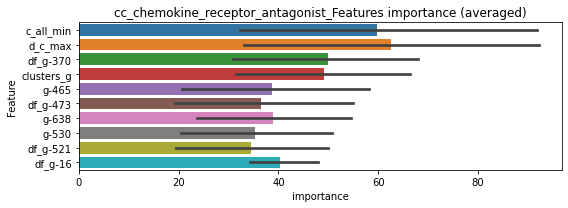

len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294035	valid_1's binary_logloss: 0.0901181
[200]	training's binary_logloss: 0.00584604	valid_1's binary_logloss: 0.0699569
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00387077	valid_1's binary_logloss: 0.0692653


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305253	valid_1's binary_logloss: 0.0869866
[200]	training's binary_logloss: 0.00576459	valid_1's binary_logloss: 0.0660198
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00335499	valid_1's binary_logloss: 0.0643561


cc_chemokine_receptor_antagonist logloss: 0.06681069437846829
cck_receptor_antagonist , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621874	valid_1's binary_logloss: 0.104892
[200]	training's binary_logloss: 0.0101723	valid_1's binary_logloss: 0.0302854
[300]	training's binary_logloss: 0.00332254	valid_1's binary_logloss: 0.0142533
[400]	training's binary_logloss: 0.00182673	valid_1's binary_logloss: 0.00980585
[500]	training's binary_logloss: 0.00137468	valid_1's binary_logloss: 0.0080542
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00127752	valid_1's binary_logloss: 0.0075965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638999	valid_1's binary_logloss: 0.104521
[200]	training's binary_logloss: 0.0105751	valid_1's binary_logloss: 0.0335571
[300]	training's binary_logloss: 0.00333945	valid_1's binary_logloss: 0.0177768
[400]	training's binary_logloss: 0.00177868	valid_1's binary_logloss: 0.0126977
[500]	training's binary_logloss: 0.00134846	vali

1 / 3 AUC score:1.000
Threshold: 0.3453074454542504
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00188
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00188, conf_1:0.34531
threshold:0.35, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06285	valid_1's binary_logloss: 0.096704
[200]	training's binary_logloss: 0.0102921	valid_1's binary_logloss: 0.0254374
[300]	training's binary_logloss: 0.00330538	valid_1's binary_logloss: 0.0119993
[400]	training's binary_logloss: 0.001814	valid_1's binary_logloss: 0.00809195
[500]	training's binary_logloss: 0.00136589	valid_1's binary_logloss: 0.00663695
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00126785	valid_1's binary_logloss: 0.00627434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603659	valid_1's binary_logloss: 0.106186
[200]	training's binary_logloss: 0.00984632	valid_1's binary_logloss: 0.035903
[300]	training's binary_logloss: 0.00316612	valid_1's binary_logloss: 0.0194298
[400]	training's binary_logloss: 0.00175803	valid_1's binary_logloss: 0.0140335
[500]	training's binary_logloss: 0.00133704	valid_

2 / 3 AUC score:1.000
Threshold: 0.3453074454542504
Remove_noisy_labels: 3 → positive_corect_labels: 499.0/995
30th percentile: 0.00194
p_label_rate: 0.00301 Vs.target_rate: 0.00082, Num_p_label: 12.0, conf_0:0.00194, conf_1:0.34531
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_1: 0.35
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.39
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_3: 0.43
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/995, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636801	valid_1's binary_logloss: 0.102258
[200]	training's binary_logloss: 0.0106259	valid_1's binary_logloss: 0.0298056
[300]	training's binary_logloss: 0.00337775	valid_1's binary_logloss: 0.0140439
[400]	training's binary_logloss: 0.00182782	valid_1's binary_logloss: 0.0091205
[500]	training's binary_logloss: 0.00137486	valid_1's binary_logloss: 0.00729195
[600]	training's binary_logloss: 0.00127112	valid_1's binary_logloss: 0.00684265
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00127164	valid_1's binary_logloss: 0.00683685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623065	valid_1's binary_logloss: 0.0965215
[200]	training's binary_logloss: 0.0101298	valid_1's binary_logloss: 0.0269987
[300]	training's binary_logloss: 0.00323618	valid_1's binary_logloss: 0.0133476
[400]	training's binary_logloss: 0.00176178	v

3 / 3 AUC score:1.000
Threshold: 0.42530744545425037
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
30th percentile: 0.00184
p_label_rate: 0.00276 Vs.target_rate: 0.00082, Num_p_label: 11.0, conf_0:0.00184, conf_1:0.42531
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.43
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_2: 0.47
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_3: 0.51
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.55
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_5: 0.59
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/4977, y_label_rate: 0.10046


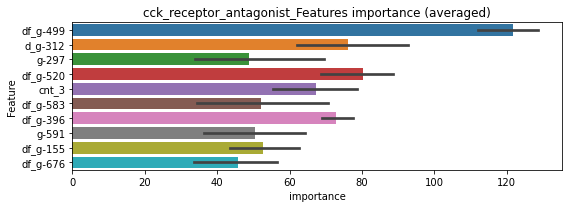

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157806	valid_1's binary_logloss: 0.0228362
[200]	training's binary_logloss: 0.00188375	valid_1's binary_logloss: 0.00612782
[300]	training's binary_logloss: 0.000547925	valid_1's binary_logloss: 0.00412525
[400]	training's binary_logloss: 0.000296603	valid_1's binary_logloss: 0.0038297
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000256835	valid_1's binary_logloss: 0.00376336


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154671	valid_1's binary_logloss: 0.02211
[200]	training's binary_logloss: 0.00181192	valid_1's binary_logloss: 0.00527503
[300]	training's binary_logloss: 0.000530217	valid_1's binary_logloss: 0.00270636
[400]	training's binary_logloss: 0.000290038	valid_1's binary_logloss: 0.00209919
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000295841	valid_1's binary_logloss: 0.0020914


cck_receptor_antagonist logloss: 0.002927546643919117
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218936	valid_1's binary_logloss: 0.628376
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.231288	valid_1's binary_logloss: 0.626459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21821	valid_1's binary_logloss: 0.650318


1 / 3 AUC score:0.688
Threshold: 0.5075850563786768
Remove_noisy_labels: 360 → positive_corect_labels: 320/640
30th percentile: 0.41319
p_label_rate: 0.33777 Vs.target_rate: 0.01106, Num_p_label: 1345.0, conf_0:0.41319, conf_1:0.50759
Num_p_label: 1345.0, Expected: 44.0, Adj_threshold_1: 0.51
Num_p_label: 788.0, Expected: 44.0, Adj_threshold_2: 0.55
Num_p_label: 408.0, Expected: 44.0, Adj_threshold_3: 0.59
Num_p_label: 191.0, Expected: 44.0, Adj_threshold_4: 0.63
Num_p_label: 73.0, Expected: 44.0, Adj_threshold_5: 0.67
Num_p_label: 16.0, Expected: 44.0, Adj_threshold_6: 0.71


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.144698	valid_1's binary_logloss: 0.637927


threshold:0.71, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:320.0/640, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206755	valid_1's binary_logloss: 0.559446
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.145418	valid_1's binary_logloss: 0.543121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200416	valid_1's binary_logloss: 0.577801
[200]	training's binary_logloss: 0.0747519	valid_1's binary_logloss: 0.544612
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0590396	valid_1's binary_logloss: 0.537676


2 / 3 AUC score:0.800
Threshold: 0.707585056378677
Remove_noisy_labels: 199 → positive_corect_labels: 140.0/441
30th percentile: 0.34848
p_label_rate: 0.05751 Vs.target_rate: 0.01106, Num_p_label: 229.0, conf_0:0.34848, conf_1:0.70759
Num_p_label: 229.0, Expected: 44.0, Adj_threshold_1: 0.71
Num_p_label: 122.0, Expected: 44.0, Adj_threshold_2: 0.75
Num_p_label: 63.0, Expected: 44.0, Adj_threshold_3: 0.79
threshold:0.79, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:140.0/441, y_label_rate: 0.31746
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159151	valid_1's binary_logloss: 0.459063
[200]	training's binary_logloss: 0.0553648	valid_1's binary_logloss: 0.404844
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0349124	valid_1's binary_logloss: 0.387957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160531	valid_1's binary_logloss: 0.460217
[200]	training's binary_logloss: 0.052025	valid_1's binary_logloss: 0.390928
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0330885	valid_1's binary_logloss: 0.381368


3 / 3 AUC score:0.889
Threshold: 0.787585056378677
Remove_noisy_labels: 95 → positive_corect_labels: 45.0/346
30th percentile: 0.09413
p_label_rate: 0.00251 Vs.target_rate: 0.01106, Num_p_label: 10.0, conf_0:0.09413, conf_1:0.78759
Num_p_label: 10.0, Expected: 44.0, Adj_threshold_1: 0.79
Num_p_label: 20.0, Expected: 44.0, Adj_threshold_2: 0.75
Num_p_label: 34.0, Expected: 44.0, Adj_threshold_3: 0.71
threshold:0.71, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:79.0/4328, y_label_rate: 0.01825


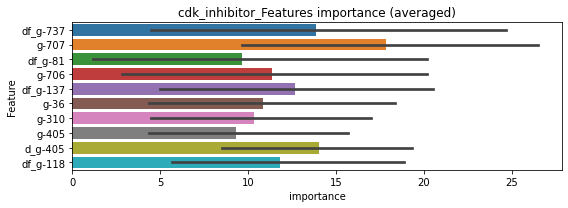

len(train_index) : 2164
len(valid_index) : 2164
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2164
len(valid_index) : 2164
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0116482	valid_1's binary_logloss: 0.0670498
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.06867885437470453


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0123424	valid_1's binary_logloss: 0.0703079
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113144	valid_1's binary_logloss: 0.242084
[200]	training's binary_logloss: 0.0273295	valid_1's binary_logloss: 0.13902
[300]	training's binary_logloss: 0.00922695	valid_1's binary_logloss: 0.102858
[400]	training's binary_logloss: 0.00459877	valid_1's binary_logloss: 0.0863698
[500]	training's binary_logloss: 0.00295067	valid_1's binary_logloss: 0.0787949
[600]	training's binary_logloss: 0.00222892	valid_1's binary_logloss: 0.0729806
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00199239	valid_1's binary_logloss: 0.0705213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120035	valid_1's binary_logloss: 0.224424
[200]	training's binary_logloss: 0.0308475	valid_1's binary_logloss: 0.116583
[300]	training's binary_logloss: 0.010433	valid_1's binary_logloss: 0.0737275
[400]	training's binary_logloss: 0.0050361	valid_1's bina

1 / 3 AUC score:0.999
Threshold: 0.46919864007997336
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01377
p_label_rate: 0.00804 Vs.target_rate: 0.00237, Num_p_label: 32.0, conf_0:0.01367, conf_1:0.47029
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_1: 0.47
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_2: 0.51
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_3: 0.55
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_4: 0.59
threshold:0.59, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113441	valid_1's binary_logloss: 0.251061
[200]	training's binary_logloss: 0.0282064	valid_1's binary_logloss: 0.139326
[300]	training's binary_logloss: 0.00953843	valid_1's binary_logloss: 0.101808
[400]	training's binary_logloss: 0.00472538	valid_1's binary_logloss: 0.0847333
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00392794	valid_1's binary_logloss: 0.0818922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112169	valid_1's binary_logloss: 0.223557
[200]	training's binary_logloss: 0.0278326	valid_1's binary_logloss: 0.123104
[300]	training's binary_logloss: 0.00932904	valid_1's binary_logloss: 0.0835099
[400]	training's binary_logloss: 0.00458033	valid_1's binary_logloss: 0.0672386
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00313792	valid_1's binary_logloss: 0.0606728


2 / 3 AUC score:0.998
Threshold: 0.5891986400799735
Remove_noisy_labels: 22 → positive_corect_labels: 472.0/962
30th percentile: 0.01704
p_label_rate: 0.00201 Vs.target_rate: 0.00237, Num_p_label: 8.0, conf_0:0.01704, conf_1:0.58920
threshold:0.59, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:472.0/962, y_label_rate: 0.49064
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110618	valid_1's binary_logloss: 0.215723
[200]	training's binary_logloss: 0.0273776	valid_1's binary_logloss: 0.108372
[300]	training's binary_logloss: 0.00925531	valid_1's binary_logloss: 0.066508
[400]	training's binary_logloss: 0.00461302	valid_1's binary_logloss: 0.0515096
[500]	training's binary_logloss: 0.00296916	valid_1's binary_logloss: 0.043524
[600]	training's binary_logloss: 0.00229285	valid_1's binary_logloss: 0.0396902
[700]	training's binary_logloss: 0.00201106	valid_1's binary_logloss: 0.0377039
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.00198094	valid_1's binary_logloss: 0.03738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111871	valid_1's binary_logloss: 0.215197
[200]	training's binary_logloss: 0.0278497	valid_1's binary_logloss: 0.111352
[300]	training's binary_logloss: 0.0095065	valid_1's bina

3 / 3 AUC score:1.000
Threshold: 0.5891986400799735
Remove_noisy_labels: 11 → positive_corect_labels: 466.0/951
30th percentile: 0.01086
p_label_rate: 0.00402 Vs.target_rate: 0.00237, Num_p_label: 16.0, conf_0:0.01086, conf_1:0.58920
threshold:0.59, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:482.0/4933, y_label_rate: 0.09771


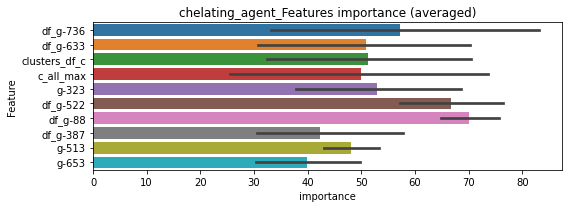

len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304979	valid_1's binary_logloss: 0.0547596
[200]	training's binary_logloss: 0.00558272	valid_1's binary_logloss: 0.0254626
[300]	training's binary_logloss: 0.0016395	valid_1's binary_logloss: 0.0186891
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000928501	valid_1's binary_logloss: 0.0172612


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304642	valid_1's binary_logloss: 0.0662058
[200]	training's binary_logloss: 0.00541003	valid_1's binary_logloss: 0.0319635
[300]	training's binary_logloss: 0.00157939	valid_1's binary_logloss: 0.0247322
[400]	training's binary_logloss: 0.000753717	valid_1's binary_logloss: 0.0229905
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000757285	valid_1's binary_logloss: 0.0229894


chelating_agent logloss: 0.020124715592468544
chk_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720619	valid_1's binary_logloss: 0.118976
[200]	training's binary_logloss: 0.0134099	valid_1's binary_logloss: 0.0411833
[300]	training's binary_logloss: 0.00426351	valid_1's binary_logloss: 0.0231605
[400]	training's binary_logloss: 0.0022662	valid_1's binary_logloss: 0.017417
[500]	training's binary_logloss: 0.00160831	valid_1's binary_logloss: 0.0147415
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00145782	valid_1's binary_logloss: 0.0138403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734287	valid_1's binary_logloss: 0.14186
[200]	training's binary_logloss: 0.0131103	valid_1's binary_logloss: 0.0594517
[300]	training's binary_logloss: 0.00418935	valid_1's binary_logloss: 0.0399618


1 / 3 AUC score:1.000
Threshold: 0.7480367926830147
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00406
p_label_rate: 0.00025 Vs.target_rate: 0.00108, Num_p_label: 1.0, conf_0:0.00406, conf_1:0.74804
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_1: 0.75


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00259626	valid_1's binary_logloss: 0.0347501


Num_p_label: 2.0, Expected: 4.3, Adj_threshold_2: 0.71
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.67
threshold:0.67, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749205	valid_1's binary_logloss: 0.128274
[200]	training's binary_logloss: 0.0136883	valid_1's binary_logloss: 0.0479906
[300]	training's binary_logloss: 0.00433871	valid_1's binary_logloss: 0.0271707
[400]	training's binary_logloss: 0.00227623	valid_1's binary_logloss: 0.0211971
[500]	training's binary_logloss: 0.00161701	valid_1's binary_logloss: 0.0187152
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00146663	valid_1's binary_logloss: 0.0175109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696417	valid_1's binary_logloss: 0.127496
[200]	training's binary_logloss: 0.0120973	valid_1's binary_logloss: 0.0507055
[300]	training's binary_logloss: 0.00391764	valid_1's binary_logloss: 0.0352659
[400]	training's binary_logloss: 0.00212443	valid_1's binary_logloss: 0.0316254
Early stopping, best iteration is:
[447]	training

2 / 3 AUC score:0.999
Threshold: 0.6680367926830146
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/991
30th percentile: 0.00313
p_label_rate: 0.00176 Vs.target_rate: 0.00108, Num_p_label: 7.0, conf_0:0.00313, conf_1:0.66804
threshold:0.67, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/991, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708788	valid_1's binary_logloss: 0.129576
[200]	training's binary_logloss: 0.0119821	valid_1's binary_logloss: 0.0456197
[300]	training's binary_logloss: 0.00381901	valid_1's binary_logloss: 0.0268402
[400]	training's binary_logloss: 0.00206852	valid_1's binary_logloss: 0.020749
[500]	training's binary_logloss: 0.00151833	valid_1's binary_logloss: 0.0185951
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00142298	valid_1's binary_logloss: 0.017974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746693	valid_1's binary_logloss: 0.112563
[200]	training's binary_logloss: 0.0135034	valid_1's binary_logloss: 0.0311708
[300]	training's binary_logloss: 0.00425616	valid_1's binary_logloss: 0.014699
[400]	training's binary_logloss: 0.00226026	valid_1's binary_logloss: 0.00976929
[500]	training's binary_logloss: 0.00161962	valid_1

3 / 3 AUC score:1.000
Threshold: 0.6680367926830146
Remove_noisy_labels: 1 → positive_corect_labels: 493.0/990
30th percentile: 0.00266
p_label_rate: 0.00226 Vs.target_rate: 0.00108, Num_p_label: 9.0, conf_0:0.00266, conf_1:0.66804
threshold:0.67, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:502.0/4972, y_label_rate: 0.10097


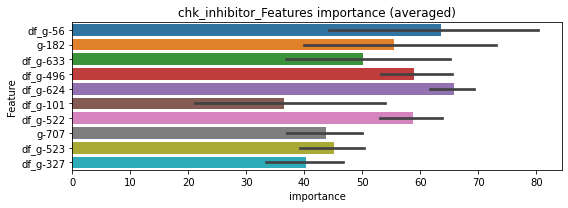

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184649	valid_1's binary_logloss: 0.0344016
[200]	training's binary_logloss: 0.0024001	valid_1's binary_logloss: 0.0129996
[300]	training's binary_logloss: 0.000681571	valid_1's binary_logloss: 0.00878719
[400]	training's binary_logloss: 0.00035609	valid_1's binary_logloss: 0.00748009
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00031694	valid_1's binary_logloss: 0.00730669


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018518	valid_1's binary_logloss: 0.0342649
[200]	training's binary_logloss: 0.0023903	valid_1's binary_logloss: 0.0130718
[300]	training's binary_logloss: 0.000690545	valid_1's binary_logloss: 0.0100897
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000464916	valid_1's binary_logloss: 0.00943581


chk_inhibitor logloss: 0.008371250252203177
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988528	valid_1's binary_logloss: 0.187329
[200]	training's binary_logloss: 0.0222291	valid_1's binary_logloss: 0.089397
[300]	training's binary_logloss: 0.00747527	valid_1's binary_logloss: 0.0565887
[400]	training's binary_logloss: 0.00365508	valid_1's binary_logloss: 0.0435614
[500]	training's binary_logloss: 0.0024003	valid_1's binary_logloss: 0.0395901
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00200616	valid_1's binary_logloss: 0.0371002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939703	valid_1's binary_logloss: 0.186382
[200]	training's binary_logloss: 0.0207562	valid_1's binary_logloss: 0.0886512
[300]	training's binary_logloss: 0.006779	valid_1's binary_logloss: 0.0559561
[400]	training's binary_logloss: 0.00337525	valid_1's binary_logloss: 0.0447391
[500]	training's binary_logloss: 0.00222923	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.503873592315444
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00674
p_label_rate: 0.00804 Vs.target_rate: 0.00187, Num_p_label: 32.0, conf_0:0.00549, conf_1:0.50984
Num_p_label: 32.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920189	valid_1's binary_logloss: 0.185174
[200]	training's binary_logloss: 0.019845	valid_1's binary_logloss: 0.093539
[300]	training's binary_logloss: 0.00658814	valid_1's binary_logloss: 0.066634
[400]	training's binary_logloss: 0.00335651	valid_1's binary_logloss: 0.0586379
[500]	training's binary_logloss: 0.00222439	valid_1's binary_logloss: 0.0542254
[600]	training's binary_logloss: 0.00176256	valid_1's binary_logloss: 0.0516588
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00172104	valid_1's binary_logloss: 0.0513311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921945	valid_1's binary_logloss: 0.169208
[200]	training's binary_logloss: 0.0206236	valid_1's binary_logloss: 0.0844473


2 / 3 AUC score:0.998
Threshold: 0.7038735923154442
Remove_noisy_labels: 22 → positive_corect_labels: 474.0/968
30th percentile: 0.01229
p_label_rate: 0.00201 Vs.target_rate: 0.00187, Num_p_label: 8.0, conf_0:0.01229, conf_1:0.70387
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00944043	valid_1's binary_logloss: 0.0687772


positive y_label:474.0/968, y_label_rate: 0.48967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924138	valid_1's binary_logloss: 0.164635
[200]	training's binary_logloss: 0.0197637	valid_1's binary_logloss: 0.0688508
[300]	training's binary_logloss: 0.0064368	valid_1's binary_logloss: 0.0396406
[400]	training's binary_logloss: 0.00325363	valid_1's binary_logloss: 0.0305593
[500]	training's binary_logloss: 0.00218342	valid_1's binary_logloss: 0.0261437
[600]	training's binary_logloss: 0.00176376	valid_1's binary_logloss: 0.0240814
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00173485	valid_1's binary_logloss: 0.023857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890687	valid_1's binary_logloss: 0.173964
[200]	training's binary_logloss: 0.0187305	valid_1's binary_logloss: 0.0792081
[300]	training's binary_logloss: 0.00628507	valid_1's binary_logloss: 0.0519921
[400]	training's binary_logloss: 0.00323458	valid_1

3 / 3 AUC score:1.000
Threshold: 0.7038735923154442
Remove_noisy_labels: 9 → positive_corect_labels: 465.0/959
30th percentile: 0.00445
p_label_rate: 0.00326 Vs.target_rate: 0.00187, Num_p_label: 13.0, conf_0:0.00445, conf_1:0.70387
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:478.0/4941, y_label_rate: 0.09674


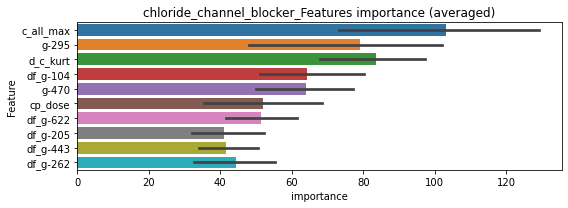

len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218518	valid_1's binary_logloss: 0.0450395
[200]	training's binary_logloss: 0.00347555	valid_1's binary_logloss: 0.0212738
[300]	training's binary_logloss: 0.00103795	valid_1's binary_logloss: 0.0165805
[400]	training's binary_logloss: 0.000527262	valid_1's binary_logloss: 0.0156144
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000543315	valid_1's binary_logloss: 0.0154951


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233872	valid_1's binary_logloss: 0.0511178
[200]	training's binary_logloss: 0.00361473	valid_1's binary_logloss: 0.0246457
[300]	training's binary_logloss: 0.00106813	valid_1's binary_logloss: 0.0185183
[400]	training's binary_logloss: 0.000539048	valid_1's binary_logloss: 0.0172024
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000566827	valid_1's binary_logloss: 0.0170996


chloride_channel_blocker logloss: 0.01629715856356053
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103846	valid_1's binary_logloss: 0.228827
[200]	training's binary_logloss: 0.0238454	valid_1's binary_logloss: 0.140549
[300]	training's binary_logloss: 0.0079992	valid_1's binary_logloss: 0.114926
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00529929	valid_1's binary_logloss: 0.110826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106883	valid_1's binary_logloss: 0.21583
[200]	training's binary_logloss: 0.0254748	valid_1's binary_logloss: 0.112248
[300]	training's binary_logloss: 0.00862227	valid_1's binary_logloss: 0.0779241
[400]	training's binary_logloss: 0.00430742	valid_1's binary_logloss: 0.0636816
[500]	training's binary_logloss: 0.00279408	valid_1's binary_logloss: 0.0569889
[600]	training's binary_logloss: 0.00214451	valid_1's binary_logloss: 0.0532324
Early stopping, best iteration is:
[651]	training's binar

1 / 3 AUC score:0.992
Threshold: 0.3611299492767893
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentile: 0.01349
p_label_rate: 0.01256 Vs.target_rate: 0.00212, Num_p_label: 50.0, conf_0:0.01349, conf_1:0.41037
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_1: 0.36
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_2: 0.40
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_3: 0.44
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_4: 0.48
Num_p_label: 14.0, Expected: 8.4, Adj_threshold_5: 0.52
Num_p_label: 7.0, Expected: 8.4, Adj_threshold_6: 0.56
threshold:0.56, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102618	valid_1's binary_logloss: 0.20913
[200]	training's binary_logloss: 0.0238998	valid_1's binary_logloss: 0.105736
[300]	training's binary_logloss: 0.00807683	valid_1's binary_logloss: 0.0706064
[400]	training's binary_logloss: 0.00403771	valid_1's binary_logloss: 0.0547373
[500]	training's binary_logloss: 0.00263603	valid_1's binary_logloss: 0.0481155
[600]	training's binary_logloss: 0.00207916	valid_1's binary_logloss: 0.044217
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00193711	valid_1's binary_logloss: 0.0436125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102816	valid_1's binary_logloss: 0.190452
[200]	training's binary_logloss: 0.0241914	valid_1's binary_logloss: 0.0902315
[300]	training's binary_logloss: 0.00831397	valid_1's binary_logloss: 0.058754
[400]	training's binary_logloss: 0.0041554	valid_1's bi

2 / 3 AUC score:1.000
Threshold: 0.5611299492767893
Remove_noisy_labels: 10 → positive_corect_labels: 481.0/970
30th percentile: 0.00828
p_label_rate: 0.00301 Vs.target_rate: 0.00212, Num_p_label: 12.0, conf_0:0.00797, conf_1:0.56113
threshold:0.56, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:481.0/970, y_label_rate: 0.49588
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102222	valid_1's binary_logloss: 0.192536
[200]	training's binary_logloss: 0.0237423	valid_1's binary_logloss: 0.0893202
[300]	training's binary_logloss: 0.00807923	valid_1's binary_logloss: 0.0550464
[400]	training's binary_logloss: 0.00405678	valid_1's binary_logloss: 0.041877
[500]	training's binary_logloss: 0.00266721	valid_1's binary_logloss: 0.0351621
[600]	training's binary_logloss: 0.00208854	valid_1's binary_logloss: 0.0321342
[700]	training's binary_logloss: 0.00186274	valid_1's binary_logloss: 0.030471
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.00183657	valid_1's binary_logloss: 0.0302381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969715	valid_1's binary_logloss: 0.215335
[200]	training's binary_logloss: 0.0219153	valid_1's binary_logloss: 0.109992
[300]	training's binary_logloss: 0.00735457	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5611299492767893
Remove_noisy_labels: 6 → positive_corect_labels: 476.0/964
30th percentile: 0.00747
p_label_rate: 0.00452 Vs.target_rate: 0.00212, Num_p_label: 18.0, conf_0:0.00747, conf_1:0.56113
threshold:0.56, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:494.0/4946, y_label_rate: 0.09988


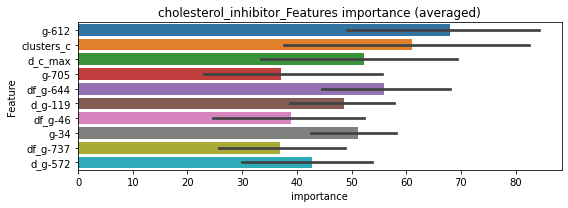

len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280861	valid_1's binary_logloss: 0.0562928
[200]	training's binary_logloss: 0.00479105	valid_1's binary_logloss: 0.0283883
[300]	training's binary_logloss: 0.0013875	valid_1's binary_logloss: 0.0234202
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000969496	valid_1's binary_logloss: 0.0228873


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289801	valid_1's binary_logloss: 0.0561143
[200]	training's binary_logloss: 0.00505354	valid_1's binary_logloss: 0.0269456
[300]	training's binary_logloss: 0.00145794	valid_1's binary_logloss: 0.0208353
[400]	training's binary_logloss: 0.000716663	valid_1's binary_logloss: 0.0197307
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000584875	valid_1's binary_logloss: 0.0193397


cholesterol_inhibitor logloss: 0.02111347153521909
cholinergic_receptor_antagonist , len(trt) : 54


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111413	valid_1's binary_logloss: 0.240768
[200]	training's binary_logloss: 0.0273685	valid_1's binary_logloss: 0.134821
[300]	training's binary_logloss: 0.00922897	valid_1's binary_logloss: 0.0944059
[400]	training's binary_logloss: 0.00459552	valid_1's binary_logloss: 0.0752834
[500]	training's binary_logloss: 0.00294978	valid_1's binary_logloss: 0.0652476
[600]	training's binary_logloss: 0.00225301	valid_1's binary_logloss: 0.060248
[700]	training's binary_logloss: 0.00197406	valid_1's binary_logloss: 0.0578073
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00192062	valid_1's binary_logloss: 0.0572509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107284	valid_1's binary_logloss: 0.246961
[200]	training's binary_logloss: 0.0258502	valid_1's binary_logloss: 0.142446
[300]	training's binary_logloss: 0.00867298	valid_1's 

1 / 3 AUC score:0.996
Threshold: 0.29770596995528753
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentile: 0.01594
p_label_rate: 0.02336 Vs.target_rate: 0.00237, Num_p_label: 93.0, conf_0:0.01594, conf_1:0.44180
Num_p_label: 93.0, Expected: 9.4, Adj_threshold_1: 0.30
Num_p_label: 57.0, Expected: 9.4, Adj_threshold_2: 0.34
Num_p_label: 41.0, Expected: 9.4, Adj_threshold_3: 0.38
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_4: 0.42
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_5: 0.46
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_6: 0.50
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108615	valid_1's binary_logloss: 0.210832
[200]	training's binary_logloss: 0.0262031	valid_1's binary_logloss: 0.101127
[300]	training's binary_logloss: 0.00896114	valid_1's binary_logloss: 0.0643593
[400]	training's binary_logloss: 0.00443909	valid_1's binary_logloss: 0.04829
[500]	training's binary_logloss: 0.00287822	valid_1's binary_logloss: 0.0418565
[600]	training's binary_logloss: 0.00217269	valid_1's binary_logloss: 0.037993
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00199142	valid_1's binary_logloss: 0.0367218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107286	valid_1's binary_logloss: 0.231729
[200]	training's binary_logloss: 0.025393	valid_1's binary_logloss: 0.119965
[300]	training's binary_logloss: 0.00867257	valid_1's binary_logloss: 0.0805563
[400]	training's binary_logloss: 0.00431066	valid_1's bin

2 / 3 AUC score:1.000
Threshold: 0.49770596995528743
Remove_noisy_labels: 6 → positive_corect_labels: 484.0/974
30th percentile: 0.01108
p_label_rate: 0.00326 Vs.target_rate: 0.00237, Num_p_label: 13.0, conf_0:0.01108, conf_1:0.49771
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:484.0/974, y_label_rate: 0.49692
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110088	valid_1's binary_logloss: 0.203662
[200]	training's binary_logloss: 0.0263064	valid_1's binary_logloss: 0.0989277
[300]	training's binary_logloss: 0.00890845	valid_1's binary_logloss: 0.0638651
[400]	training's binary_logloss: 0.00443335	valid_1's binary_logloss: 0.0494734
[500]	training's binary_logloss: 0.00288836	valid_1's binary_logloss: 0.0431038
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00236014	valid_1's binary_logloss: 0.0409917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103812	valid_1's binary_logloss: 0.228498
[200]	training's binary_logloss: 0.0239652	valid_1's binary_logloss: 0.124986
[300]	training's binary_logloss: 0.00816212	valid_1's binary_logloss: 0.0871716
[400]	training's binary_logloss: 0.0040857	valid_1's binary_logloss: 0.0742914
[500]	training's binary_logloss: 0.00267652	valid_1's

3 / 3 AUC score:0.999
Threshold: 0.49770596995528743
Remove_noisy_labels: 14 → positive_corect_labels: 471.0/960
30th percentile: 0.01176
p_label_rate: 0.00251 Vs.target_rate: 0.00237, Num_p_label: 10.0, conf_0:0.01176, conf_1:0.49771
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:481.0/4942, y_label_rate: 0.09733


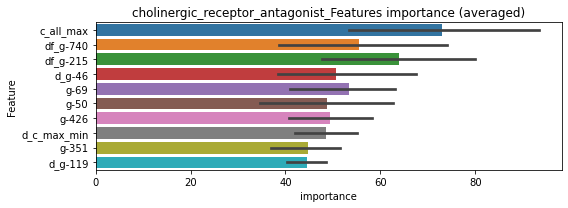

len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272452	valid_1's binary_logloss: 0.0610333
[200]	training's binary_logloss: 0.00472202	valid_1's binary_logloss: 0.0283921
[300]	training's binary_logloss: 0.00137282	valid_1's binary_logloss: 0.0217267
[400]	training's binary_logloss: 0.000678286	valid_1's binary_logloss: 0.0203385
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000716917	valid_1's binary_logloss: 0.0201368


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251672	valid_1's binary_logloss: 0.0570612
[200]	training's binary_logloss: 0.004349	valid_1's binary_logloss: 0.0273682
[300]	training's binary_logloss: 0.00129478	valid_1's binary_logloss: 0.0214535
[400]	training's binary_logloss: 0.000645606	valid_1's binary_logloss: 0.0197968
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000568476	valid_1's binary_logloss: 0.0196011


cholinergic_receptor_antagonist logloss: 0.019868955591725516
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786864	valid_1's binary_logloss: 0.120285
[200]	training's binary_logloss: 0.0140585	valid_1's binary_logloss: 0.0353024
[300]	training's binary_logloss: 0.00442657	valid_1's binary_logloss: 0.0165273
[400]	training's binary_logloss: 0.00232935	valid_1's binary_logloss: 0.0112693
[500]	training's binary_logloss: 0.00163552	valid_1's binary_logloss: 0.00924142
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00142478	valid_1's binary_logloss: 0.0082499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712919	valid_1's binary_logloss: 0.134258
[200]	training's binary_logloss: 0.0128207	valid_1's binary_logloss: 0.049194
[300]	training's binary_logloss: 0.00406157	valid_1's binary_logloss: 0.0277039
[400]	training's binary_logloss: 0.00216317	valid_1's binary_logloss: 0.0210794
[500]	training's binary_logloss: 0.00154336	valid

1 / 3 AUC score:1.000
Threshold: 0.37398880675588675
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00323
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00323, conf_1:0.37399
threshold:0.37, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732296	valid_1's binary_logloss: 0.127321
[200]	training's binary_logloss: 0.0131619	valid_1's binary_logloss: 0.0469339
[300]	training's binary_logloss: 0.00414135	valid_1's binary_logloss: 0.0274783
[400]	training's binary_logloss: 0.00221549	valid_1's binary_logloss: 0.0215506
[500]	training's binary_logloss: 0.0015732	valid_1's binary_logloss: 0.0196622
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00139883	valid_1's binary_logloss: 0.0189298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732875	valid_1's binary_logloss: 0.121086
[200]	training's binary_logloss: 0.0131168	valid_1's binary_logloss: 0.0422339
[300]	training's binary_logloss: 0.00419951	valid_1's binary_logloss: 0.0230137
[400]	training's binary_logloss: 0.00224175	valid_1's binary_logloss: 0.0164266
[500]	training's binary_logloss: 0.00157938	valid_

2 / 3 AUC score:1.000
Threshold: 0.37398880675588675
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00307
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00307, conf_1:0.37869
threshold:0.37, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708774	valid_1's binary_logloss: 0.151443
[200]	training's binary_logloss: 0.0125868	valid_1's binary_logloss: 0.0836729
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00582301	valid_1's binary_logloss: 0.0728039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761491	valid_1's binary_logloss: 0.129421
[200]	training's binary_logloss: 0.0139546	valid_1's binary_logloss: 0.0439186
[300]	training's binary_logloss: 0.00440457	valid_1's binary_logloss: 0.0228847
[400]	training's binary_logloss: 0.00230206	valid_1's binary_logloss: 0.0167963
[500]	training's binary_logloss: 0.00160238	valid_1's binary_logloss: 0.0141442
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00141259	valid_1's binary_logloss: 0.0133328


3 / 3 AUC score:0.999
Threshold: 0.37398880675588675
Remove_noisy_labels: 12 → positive_corect_labels: 487.0/985
30th percentile: 0.00703
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00703, conf_1:0.37399
threshold:0.37, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:491.0/4967, y_label_rate: 0.09885


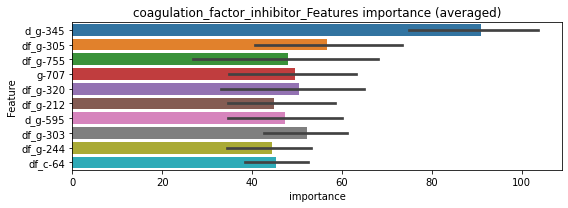

len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181309	valid_1's binary_logloss: 0.0307416
[200]	training's binary_logloss: 0.00233221	valid_1's binary_logloss: 0.0104187
[300]	training's binary_logloss: 0.000679455	valid_1's binary_logloss: 0.00725383
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000436279	valid_1's binary_logloss: 0.006696


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177473	valid_1's binary_logloss: 0.035066
[200]	training's binary_logloss: 0.00231522	valid_1's binary_logloss: 0.0152169
[300]	training's binary_logloss: 0.000678075	valid_1's binary_logloss: 0.0124011
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000589746	valid_1's binary_logloss: 0.0122039


coagulation_factor_inhibitor logloss: 0.009449371568369754
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887483	valid_1's binary_logloss: 0.154443
[200]	training's binary_logloss: 0.0183979	valid_1's binary_logloss: 0.0652072
[300]	training's binary_logloss: 0.00614416	valid_1's binary_logloss: 0.0400304
[400]	training's binary_logloss: 0.00312437	valid_1's binary_logloss: 0.0307739
[500]	training's binary_logloss: 0.00213388	valid_1's binary_logloss: 0.0265421
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00179713	valid_1's binary_logloss: 0.0248147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901108	valid_1's binary_logloss: 0.170946
[200]	training's binary_logloss: 0.0186155	valid_1's binary_logloss: 0.0727367
[300]	training's binary_logloss: 0.00597825	valid_1's binary_logloss: 0.0433426
[400]	training's binary_logloss: 0.00303277	valid_1's binary_logloss: 0.0323528
[500]	training's binary_logloss: 0.00205194	valid

1 / 3 AUC score:1.000
Threshold: 0.291831002323221
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00547
p_label_rate: 0.01105 Vs.target_rate: 0.00161, Num_p_label: 44.0, conf_0:0.00547, conf_1:0.43184
Num_p_label: 44.0, Expected: 6.4, Adj_threshold_1: 0.29
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_2: 0.33
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_3: 0.37
Num_p_label: 10.0, Expected: 6.4, Adj_threshold_4: 0.41
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_5: 0.45
threshold:0.45, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892852	valid_1's binary_logloss: 0.154874
[200]	training's binary_logloss: 0.0183347	valid_1's binary_logloss: 0.062611
[300]	training's binary_logloss: 0.00599452	valid_1's binary_logloss: 0.0364328
[400]	training's binary_logloss: 0.0030699	valid_1's binary_logloss: 0.0271425
[500]	training's binary_logloss: 0.00205904	valid_1's binary_logloss: 0.0232542
[600]	training's binary_logloss: 0.00170386	valid_1's binary_logloss: 0.0216662
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00166048	valid_1's binary_logloss: 0.0214052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086086	valid_1's binary_logloss: 0.162296
[200]	training's binary_logloss: 0.0173601	valid_1's binary_logloss: 0.0737757
[300]	training's binary_logloss: 0.00565348	valid_1's binary_logloss: 0.0483628
[400]	training's binary_logloss: 0.00292229	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.45183100232322093
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/991
30th percentile: 0.00481
p_label_rate: 0.00276 Vs.target_rate: 0.00161, Num_p_label: 11.0, conf_0:0.00481, conf_1:0.49491
threshold:0.45, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866431	valid_1's binary_logloss: 0.160012
[200]	training's binary_logloss: 0.0173409	valid_1's binary_logloss: 0.0621036
[300]	training's binary_logloss: 0.00576616	valid_1's binary_logloss: 0.0365117
[400]	training's binary_logloss: 0.00299492	valid_1's binary_logloss: 0.0266943
[500]	training's binary_logloss: 0.00204579	valid_1's binary_logloss: 0.0223794
[600]	training's binary_logloss: 0.00167975	valid_1's binary_logloss: 0.0205099
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00165438	valid_1's binary_logloss: 0.0203857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847856	valid_1's binary_logloss: 0.156474
[200]	training's binary_logloss: 0.0173083	valid_1's binary_logloss: 0.065408
[300]	training's binary_logloss: 0.0056649	valid_1's binary_logloss: 0.0369275
[400]	training's binary_logloss: 0.00292638	valid_1

3 / 3 AUC score:1.000
Threshold: 0.45183100232322093
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/990
30th percentile: 0.00473
p_label_rate: 0.00251 Vs.target_rate: 0.00161, Num_p_label: 10.0, conf_0:0.00473, conf_1:0.46460
threshold:0.45, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:505.0/4972, y_label_rate: 0.10157


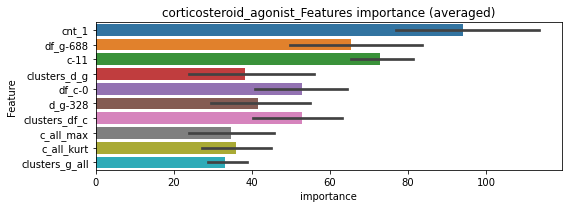

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223941	valid_1's binary_logloss: 0.0477047
[200]	training's binary_logloss: 0.00342179	valid_1's binary_logloss: 0.0227072
[300]	training's binary_logloss: 0.000986255	valid_1's binary_logloss: 0.0185667
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000875283	valid_1's binary_logloss: 0.01835


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212521	valid_1's binary_logloss: 0.0395384
[200]	training's binary_logloss: 0.00320495	valid_1's binary_logloss: 0.0178114
[300]	training's binary_logloss: 0.000969912	valid_1's binary_logloss: 0.0142541
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000703928	valid_1's binary_logloss: 0.0138675


corticosteroid_agonist logloss: 0.01610875989194147
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.579537	valid_1's binary_logloss: 0.685817
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.561
Threshold: 0.49743195873134255
Remove_noisy_labels: 460 → positive_corect_labels: 270/540
30th percentile: 0.47819
p_label_rate: 0.46685 Vs.target_rate: 0.01215, Num_p_label: 1859.0, conf_0:0.47819, conf_1:0.49743
Num_p_label: 1859.0, Expected: 48.4, Adj_threshold_1: 0.50
Num_p_label: 344.0, Expected: 48.4, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 48.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.523807	valid_1's binary_logloss: 0.68709


positive y_label:270.0/540, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.282181	valid_1's binary_logloss: 0.607242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22186	valid_1's binary_logloss: 0.594764
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.206033	valid_1's binary_logloss: 0.590502


2 / 3 AUC score:0.748
Threshold: 0.5774319587313426
Remove_noisy_labels: 171 → positive_corect_labels: 146.0/369
30th percentile: 0.41331
p_label_rate: 0.24736 Vs.target_rate: 0.01215, Num_p_label: 985.0, conf_0:0.41331, conf_1:0.57743
Num_p_label: 985.0, Expected: 48.4, Adj_threshold_1: 0.58
Num_p_label: 669.0, Expected: 48.4, Adj_threshold_2: 0.62
Num_p_label: 426.0, Expected: 48.4, Adj_threshold_3: 0.66
Num_p_label: 234.0, Expected: 48.4, Adj_threshold_4: 0.70
Num_p_label: 101.0, Expected: 48.4, Adj_threshold_5: 0.74
Num_p_label: 37.0, Expected: 48.4, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:146.0/369, y_label_rate: 0.39566
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161516	valid_1's binary_logloss: 0.394813
[200]	training's binary_logloss: 0.0545845	valid_1's binary_logloss: 0.342995
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0373541	valid_1's binary_logloss: 0.32944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155992	valid_1's binary_logloss: 0.428628
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.087388	valid_1's binary_logloss: 0.404009


3 / 3 AUC score:0.914
Threshold: 0.7774319587313427
Remove_noisy_labels: 78 → positive_corect_labels: 73.0/291
30th percentile: 0.11928
p_label_rate: 0.09945 Vs.target_rate: 0.01215, Num_p_label: 396.0, conf_0:0.11928, conf_1:0.77743
Num_p_label: 396.0, Expected: 48.4, Adj_threshold_1: 0.78
Num_p_label: 287.0, Expected: 48.4, Adj_threshold_2: 0.82
Num_p_label: 173.0, Expected: 48.4, Adj_threshold_3: 0.86
Num_p_label: 82.0, Expected: 48.4, Adj_threshold_4: 0.90
Num_p_label: 22.0, Expected: 48.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:95.0/4273, y_label_rate: 0.02223


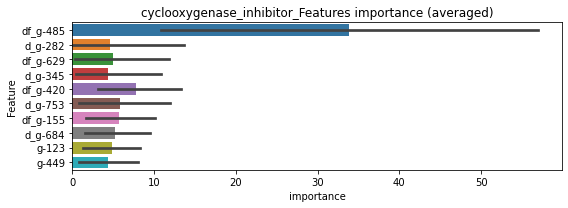

len(train_index) : 2136
len(valid_index) : 2137
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2137
len(valid_index) : 2136
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.0209907	valid_1's binary_logloss: 0.0851672
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.08336963377450896


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.0149706	valid_1's binary_logloss: 0.0815713
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150014	valid_1's binary_logloss: 0.358157
[200]	training's binary_logloss: 0.045204	valid_1's binary_logloss: 0.273758
[300]	training's binary_logloss: 0.0169596	valid_1's binary_logloss: 0.242142
[400]	training's binary_logloss: 0.00823441	valid_1's binary_logloss: 0.227279
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00874117	valid_1's binary_logloss: 0.227053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146781	valid_1's binary_logloss: 0.34956
[200]	training's binary_logloss: 0.0421313	valid_1's binary_logloss: 0.255849
[300]	training's binary_logloss: 0.0156226	valid_1's binary_logloss: 0.225544


1 / 3 AUC score:0.965
Threshold: 0.43400839110580725


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0138674	valid_1's binary_logloss: 0.223463


Remove_noisy_labels: 82 → positive_corect_labels: 459/918
30th percentile: 0.09272
p_label_rate: 0.04194 Vs.target_rate: 0.00435, Num_p_label: 167.0, conf_0:0.09272, conf_1:0.47208
Num_p_label: 167.0, Expected: 17.3, Adj_threshold_1: 0.43
Num_p_label: 109.0, Expected: 17.3, Adj_threshold_2: 0.47
Num_p_label: 65.0, Expected: 17.3, Adj_threshold_3: 0.51
Num_p_label: 39.0, Expected: 17.3, Adj_threshold_4: 0.55
Num_p_label: 21.0, Expected: 17.3, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:459.0/918, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133796	valid_1's binary_logloss: 0.304412
[200]	training's binary_logloss: 0.038793	valid_1's binary_logloss: 0.216496
[300]	training's binary_logloss: 0.0141545	valid_1's binary_logloss: 0.177745
[400]	training's binary_logloss: 0.00694245	valid_1's binary_logloss: 0.159595
[500]	training's binary_logloss: 0.0043134	valid_1's binary_logloss: 0.151178
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00401954	valid_1's binary_logloss: 0.149251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129327	valid_1's binary_logloss: 0.320409
[200]	training's binary_logloss: 0.036225	valid_1's binary_logloss: 0.23514
[300]	training's binary_logloss: 0.0132445	valid_1's binary_logloss: 0.200687
[400]	training's binary_logloss: 0.00657118	valid_1's binary_logloss: 0.189747
Early stopping, best iteration is:
[405]	training's binary_loglos

2 / 3 AUC score:0.982
Threshold: 0.5940083911058073
Remove_noisy_labels: 61 → positive_corect_labels: 405.0/857
30th percentile: 0.04488
p_label_rate: 0.01532 Vs.target_rate: 0.00435, Num_p_label: 61.0, conf_0:0.04394, conf_1:0.59401
Num_p_label: 61.0, Expected: 17.3, Adj_threshold_1: 0.59
Num_p_label: 43.0, Expected: 17.3, Adj_threshold_2: 0.63
Num_p_label: 28.0, Expected: 17.3, Adj_threshold_3: 0.67
Num_p_label: 21.0, Expected: 17.3, Adj_threshold_4: 0.71
threshold:0.71, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:405.0/857, y_label_rate: 0.47258
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129775	valid_1's binary_logloss: 0.25851
[200]	training's binary_logloss: 0.0353768	valid_1's binary_logloss: 0.161273
[300]	training's binary_logloss: 0.0128502	valid_1's binary_logloss: 0.12668
[400]	training's binary_logloss: 0.00638966	valid_1's binary_logloss: 0.113804
[500]	training's binary_logloss: 0.00403704	valid_1's binary_logloss: 0.108628
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00334719	valid_1's binary_logloss: 0.105479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121111	valid_1's binary_logloss: 0.266008
[200]	training's binary_logloss: 0.0334423	valid_1's binary_logloss: 0.170839
[300]	training's binary_logloss: 0.0120885	valid_1's binary_logloss: 0.13464
[400]	training's binary_logloss: 0.0059211	valid_1's binary_logloss: 0.123856
Early stopping, best iteration is:
[487]	training's binary_loglos

3 / 3 AUC score:0.991
Threshold: 0.7140083911058074
Remove_noisy_labels: 41 → positive_corect_labels: 366.0/816
30th percentile: 0.02464
p_label_rate: 0.00552 Vs.target_rate: 0.00435, Num_p_label: 22.0, conf_0:0.01926, conf_1:0.71401
threshold:0.71, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:388.0/4798, y_label_rate: 0.08087


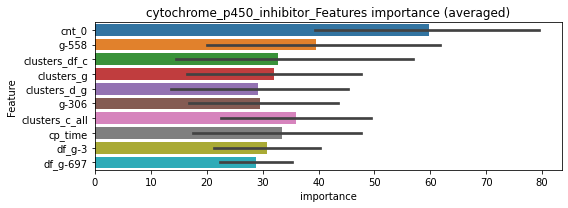

len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262347	valid_1's binary_logloss: 0.0687448
[200]	training's binary_logloss: 0.00518432	valid_1's binary_logloss: 0.0505845
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00190013	valid_1's binary_logloss: 0.0476391


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260173	valid_1's binary_logloss: 0.0689064
[200]	training's binary_logloss: 0.00511108	valid_1's binary_logloss: 0.0482152
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00266746	valid_1's binary_logloss: 0.0452006


cytochrome_p450_inhibitor logloss: 0.046419846045666256
dihydrofolate_reductase_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959552	valid_1's binary_logloss: 0.179756
[200]	training's binary_logloss: 0.0207251	valid_1's binary_logloss: 0.0836658
[300]	training's binary_logloss: 0.00671222	valid_1's binary_logloss: 0.0588752
[400]	training's binary_logloss: 0.00336671	valid_1's binary_logloss: 0.0468687
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00256805	valid_1's binary_logloss: 0.0434741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958869	valid_1's binary_logloss: 0.167576
[200]	training's binary_logloss: 0.0209541	valid_1's binary_logloss: 0.0716562
[300]	training's binary_logloss: 0.00681815	valid_1's binary_logloss: 0.0417194
[400]	training's binary_logloss: 0.00338288	valid_1's binary_logloss: 0.0320079
[500]	training's binary_logloss: 0.00225188	valid_1's binary_logloss: 0.0271067
[600]	training's binary_logloss: 0.00182783	valid

1 / 3 AUC score:1.000
Threshold: 0.3750829797369686
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00757
p_label_rate: 0.00352 Vs.target_rate: 0.00161, Num_p_label: 14.0, conf_0:0.00757, conf_1:0.39906
threshold:0.38, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943424	valid_1's binary_logloss: 0.183841
[200]	training's binary_logloss: 0.0198983	valid_1's binary_logloss: 0.0863492
[300]	training's binary_logloss: 0.00643727	valid_1's binary_logloss: 0.0607556
[400]	training's binary_logloss: 0.00325103	valid_1's binary_logloss: 0.0489337
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00307287	valid_1's binary_logloss: 0.0484613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961448	valid_1's binary_logloss: 0.180608
[200]	training's binary_logloss: 0.0203278	valid_1's binary_logloss: 0.0745984
[300]	training's binary_logloss: 0.00656474	valid_1's binary_logloss: 0.0435217
[400]	training's binary_logloss: 0.00331259	valid_1's binary_logloss: 0.0324505
[500]	training's binary_logloss: 0.00223188	valid_1's binary_logloss: 0.0272553
[600]	training's binary_logloss: 0.00179549	valid

2 / 3 AUC score:1.000
Threshold: 0.3750829797369686
Remove_noisy_labels: 9 → positive_corect_labels: 490.0/981
30th percentile: 0.00896
p_label_rate: 0.00276 Vs.target_rate: 0.00161, Num_p_label: 11.0, conf_0:0.00896, conf_1:0.47985
threshold:0.38, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:490.0/981, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090725	valid_1's binary_logloss: 0.178014
[200]	training's binary_logloss: 0.0190888	valid_1's binary_logloss: 0.0829571
[300]	training's binary_logloss: 0.00618312	valid_1's binary_logloss: 0.0552747
[400]	training's binary_logloss: 0.00316133	valid_1's binary_logloss: 0.0456998
[500]	training's binary_logloss: 0.00213523	valid_1's binary_logloss: 0.0404037
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00180674	valid_1's binary_logloss: 0.0380926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939041	valid_1's binary_logloss: 0.173217
[200]	training's binary_logloss: 0.0199272	valid_1's binary_logloss: 0.0745152
[300]	training's binary_logloss: 0.00650217	valid_1's binary_logloss: 0.044262
[400]	training's binary_logloss: 0.00332325	valid_1's binary_logloss: 0.0338101
[500]	training's binary_logloss: 0.00222119	valid_1

3 / 3 AUC score:1.000
Threshold: 0.3750829797369686
Remove_noisy_labels: 9 → positive_corect_labels: 484.0/972
30th percentile: 0.00618
p_label_rate: 0.00377 Vs.target_rate: 0.00161, Num_p_label: 15.0, conf_0:0.00618, conf_1:0.47380
threshold:0.38, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:499.0/4954, y_label_rate: 0.10073


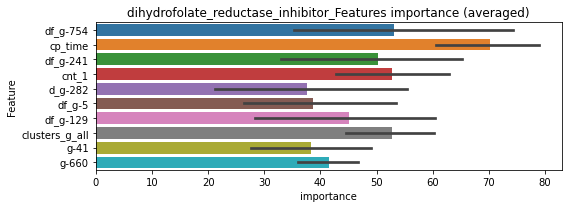

len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223847	valid_1's binary_logloss: 0.0515669
[200]	training's binary_logloss: 0.00348634	valid_1's binary_logloss: 0.0293941
[300]	training's binary_logloss: 0.00103657	valid_1's binary_logloss: 0.0261009
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000838332	valid_1's binary_logloss: 0.0256637


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023892	valid_1's binary_logloss: 0.0447478
[200]	training's binary_logloss: 0.00350384	valid_1's binary_logloss: 0.0229238
[300]	training's binary_logloss: 0.00104648	valid_1's binary_logloss: 0.0202226
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00100385	valid_1's binary_logloss: 0.0201393


dihydrofolate_reductase_inhibitor logloss: 0.02290148340030096
dipeptidyl_peptidase_inhibitor , len(trt) : 25


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764848	valid_1's binary_logloss: 0.128118
[200]	training's binary_logloss: 0.0141176	valid_1's binary_logloss: 0.0449734
[300]	training's binary_logloss: 0.00450044	valid_1's binary_logloss: 0.0242407
[400]	training's binary_logloss: 0.00238068	valid_1's binary_logloss: 0.0178943
[500]	training's binary_logloss: 0.0016823	valid_1's binary_logloss: 0.0150948
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00148786	valid_1's binary_logloss: 0.0137962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761823	valid_1's binary_logloss: 0.14136
[200]	training's binary_logloss: 0.0140105	valid_1's binary_logloss: 0.0554484
[300]	training's binary_logloss: 0.00446389	valid_1's binary_logloss: 0.0319595
[400]	training's binary_logloss: 0.00234473	valid_1's binary_logloss: 0.0251612
[500]	training's binary_logloss: 0.00164985	valid_1

1 / 3 AUC score:1.000
Threshold: 0.33954756934479435
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00353
p_label_rate: 0.00201 Vs.target_rate: 0.00113, Num_p_label: 8.0, conf_0:0.00353, conf_1:0.33955
threshold:0.34, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791442	valid_1's binary_logloss: 0.130894
[200]	training's binary_logloss: 0.0146051	valid_1's binary_logloss: 0.0407742
[300]	training's binary_logloss: 0.00461184	valid_1's binary_logloss: 0.0192589
[400]	training's binary_logloss: 0.00239933	valid_1's binary_logloss: 0.0129562
[500]	training's binary_logloss: 0.00169585	valid_1's binary_logloss: 0.01033
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00151829	valid_1's binary_logloss: 0.00959465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765425	valid_1's binary_logloss: 0.134891
[200]	training's binary_logloss: 0.0137832	valid_1's binary_logloss: 0.0448817
[300]	training's binary_logloss: 0.00445644	valid_1's binary_logloss: 0.0237087
[400]	training's binary_logloss: 0.0023398	valid_1's binary_logloss: 0.0171259
[500]	training's binary_logloss: 0.00165321	valid_1

2 / 3 AUC score:1.000
Threshold: 0.33954756934479435
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00345
p_label_rate: 0.00226 Vs.target_rate: 0.00113, Num_p_label: 9.0, conf_0:0.00345, conf_1:0.33955
threshold:0.34, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791442	valid_1's binary_logloss: 0.130894
[200]	training's binary_logloss: 0.0146051	valid_1's binary_logloss: 0.0407742
[300]	training's binary_logloss: 0.00461184	valid_1's binary_logloss: 0.0192589
[400]	training's binary_logloss: 0.00239933	valid_1's binary_logloss: 0.0129562
[500]	training's binary_logloss: 0.00169585	valid_1's binary_logloss: 0.01033
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00151829	valid_1's binary_logloss: 0.00959465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765425	valid_1's binary_logloss: 0.134891
[200]	training's binary_logloss: 0.0137832	valid_1's binary_logloss: 0.0448817
[300]	training's binary_logloss: 0.00445644	valid_1's binary_logloss: 0.0237087
[400]	training's binary_logloss: 0.0023398	valid_1's binary_logloss: 0.0171259
[500]	training's binary_logloss: 0.00165321	valid_1

3 / 3 AUC score:1.000
Threshold: 0.33954756934479435
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00345
p_label_rate: 0.00226 Vs.target_rate: 0.00113, Num_p_label: 9.0, conf_0:0.00345, conf_1:0.33955
threshold:0.34, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:508.0/4980, y_label_rate: 0.10201


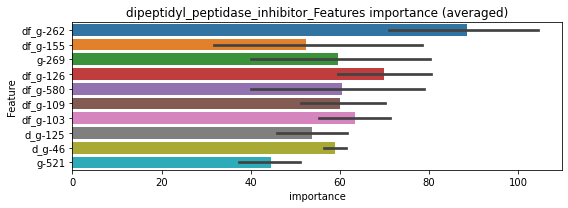

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208401	valid_1's binary_logloss: 0.0357217
[200]	training's binary_logloss: 0.00285838	valid_1's binary_logloss: 0.0143166
[300]	training's binary_logloss: 0.000802832	valid_1's binary_logloss: 0.0118658
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000833306	valid_1's binary_logloss: 0.0118347


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213311	valid_1's binary_logloss: 0.0343992
[200]	training's binary_logloss: 0.00291338	valid_1's binary_logloss: 0.0129006
[300]	training's binary_logloss: 0.000813072	valid_1's binary_logloss: 0.00978821
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000484618	valid_1's binary_logloss: 0.00940047


dipeptidyl_peptidase_inhibitor logloss: 0.010617592569187427
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373073	valid_1's binary_logloss: 0.0514742
[200]	training's binary_logloss: 0.00436859	valid_1's binary_logloss: 0.0102031
[300]	training's binary_logloss: 0.00143901	valid_1's binary_logloss: 0.00478442
[400]	training's binary_logloss: 0.000917575	valid_1's binary_logloss: 0.00349176
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000833994	valid_1's binary_logloss: 0.00325733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392578	valid_1's binary_logloss: 0.0492687
[200]	training's binary_logloss: 0.00474292	valid_1's binary_logloss: 0.00754887
[300]	training's binary_logloss: 0.00152575	valid_1's binary_logloss: 0.00285161
[400]	training's binary_logloss: 0.000957606	valid_1's binary_logloss: 0.00187598
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000865022	valid_1's binary_logloss: 0.0016781


1 / 3 AUC score:1.000
Threshold: 0.39675791027802715
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00063
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00063, conf_1:0.39676
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373073	valid_1's binary_logloss: 0.0514742
[200]	training's binary_logloss: 0.00436859	valid_1's binary_logloss: 0.0102031
[300]	training's binary_logloss: 0.00143901	valid_1's binary_logloss: 0.00478442
[400]	training's binary_logloss: 0.000917575	valid_1's binary_logloss: 0.00349176
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000833994	valid_1's binary_logloss: 0.00325733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392578	valid_1's binary_logloss: 0.0492687
[200]	training's binary_logloss: 0.00474292	valid_1's binary_logloss: 0.00754887
[300]	training's binary_logloss: 0.00152575	valid_1's binary_logloss: 0.00285161
[400]	training's binary_logloss: 0.000957606	valid_1's binary_logloss: 0.00187598
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000865022	valid_1's binary_logloss: 0.0016781


2 / 3 AUC score:1.000
Threshold: 0.39675791027802715
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00063
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00063, conf_1:0.39676
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373073	valid_1's binary_logloss: 0.0514742
[200]	training's binary_logloss: 0.00436859	valid_1's binary_logloss: 0.0102031
[300]	training's binary_logloss: 0.00143901	valid_1's binary_logloss: 0.00478442
[400]	training's binary_logloss: 0.000917575	valid_1's binary_logloss: 0.00349176
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000833994	valid_1's binary_logloss: 0.00325733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392578	valid_1's binary_logloss: 0.0492687
[200]	training's binary_logloss: 0.00474292	valid_1's binary_logloss: 0.00754887
[300]	training's binary_logloss: 0.00152575	valid_1's binary_logloss: 0.00285161
[400]	training's binary_logloss: 0.000957606	valid_1's binary_logloss: 0.00187598
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000865022	valid_1's binary_logloss: 0.0016781


3 / 3 AUC score:1.000
Threshold: 0.39675791027802715
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00063
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00063, conf_1:0.39676
threshold:0.40, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


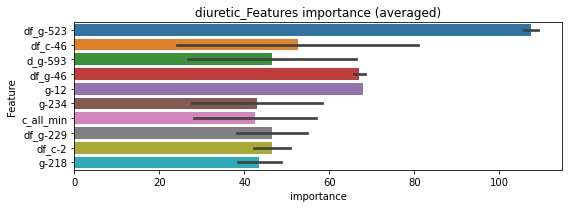

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104886	valid_1's binary_logloss: 0.017239
[200]	training's binary_logloss: 0.000933294	valid_1's binary_logloss: 0.00739183
[300]	training's binary_logloss: 0.000266186	valid_1's binary_logloss: 0.00654973
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000278192	valid_1's binary_logloss: 0.00654136


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109173	valid_1's binary_logloss: 0.0122175
[200]	training's binary_logloss: 0.000977312	valid_1's binary_logloss: 0.00129303
[300]	training's binary_logloss: 0.000279355	valid_1's binary_logloss: 0.000429889
[400]	training's binary_logloss: 0.000171997	valid_1's binary_logloss: 0.000287091
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000157169	valid_1's binary_logloss: 0.000265974


diuretic logloss: 0.0034036659102528025
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110861	valid_1's binary_logloss: 0.221977
[200]	training's binary_logloss: 0.0277578	valid_1's binary_logloss: 0.117811
[300]	training's binary_logloss: 0.00958945	valid_1's binary_logloss: 0.079431
[400]	training's binary_logloss: 0.00478255	valid_1's binary_logloss: 0.0624567
[500]	training's binary_logloss: 0.00307509	valid_1's binary_logloss: 0.0545426
[600]	training's binary_logloss: 0.00233946	valid_1's binary_logloss: 0.0501543
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00219528	valid_1's binary_logloss: 0.0489021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107284	valid_1's binary_logloss: 0.234006
[200]	training's binary_logloss: 0.0259409	valid_1's binary_logloss: 0.130205
[300]	training's binary_logloss: 0.00888575	valid_1's binary_logloss: 0.0930403
[400]	training's binary_logloss: 0.00445918	valid_1's 

1 / 3 AUC score:0.998
Threshold: 0.34232038004999976
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.01292
p_label_rate: 0.01256 Vs.target_rate: 0.00212, Num_p_label: 50.0, conf_0:0.01292, conf_1:0.45100
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_1: 0.34
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_2: 0.38
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_3: 0.42
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_4: 0.46
threshold:0.46, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106687	valid_1's binary_logloss: 0.212194
[200]	training's binary_logloss: 0.0251092	valid_1's binary_logloss: 0.107909
[300]	training's binary_logloss: 0.00850162	valid_1's binary_logloss: 0.0741551
[400]	training's binary_logloss: 0.00427486	valid_1's binary_logloss: 0.0602592
[500]	training's binary_logloss: 0.00277532	valid_1's binary_logloss: 0.05456
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00223056	valid_1's binary_logloss: 0.0512483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10956	valid_1's binary_logloss: 0.220283
[200]	training's binary_logloss: 0.0262772	valid_1's binary_logloss: 0.117422
[300]	training's binary_logloss: 0.00892114	valid_1's binary_logloss: 0.0850229
[400]	training's binary_logloss: 0.00449746	valid_1's binary_logloss: 0.0713495
[500]	training's binary_logloss: 0.00290979	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.4623203800499997
Remove_noisy_labels: 15 → positive_corect_labels: 483.0/971
30th percentile: 0.01076
p_label_rate: 0.00829 Vs.target_rate: 0.00212, Num_p_label: 33.0, conf_0:0.01076, conf_1:0.46697
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_1: 0.46
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_2: 0.50
Num_p_label: 21.0, Expected: 8.4, Adj_threshold_3: 0.54
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_4: 0.58
Num_p_label: 10.0, Expected: 8.4, Adj_threshold_5: 0.62
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:483.0/971, y_label_rate: 0.49743
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105832	valid_1's binary_logloss: 0.214827
[200]	training's binary_logloss: 0.025146	valid_1's binary_logloss: 0.105797
[300]	training's binary_logloss: 0.00860965	valid_1's binary_logloss: 0.0667519
[400]	training's binary_logloss: 0.00434966	valid_1's binary_logloss: 0.05399
[500]	training's binary_logloss: 0.0028647	valid_1's binary_logloss: 0.0468873
[600]	training's binary_logloss: 0.00221904	valid_1's binary_logloss: 0.0428398
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00217948	valid_1's binary_logloss: 0.0424996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107568	valid_1's binary_logloss: 0.22856
[200]	training's binary_logloss: 0.0251347	valid_1's binary_logloss: 0.136278
[300]	training's binary_logloss: 0.00840247	valid_1's binary_logloss: 0.105918
[400]	training's binary_logloss: 0.00417936	valid_1's binar

3 / 3 AUC score:0.997
Threshold: 0.6223203800499998
Remove_noisy_labels: 16 → positive_corect_labels: 469.0/955
30th percentile: 0.01129
p_label_rate: 0.00352 Vs.target_rate: 0.00212, Num_p_label: 14.0, conf_0:0.01129, conf_1:0.62232
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:483.0/4937, y_label_rate: 0.09783


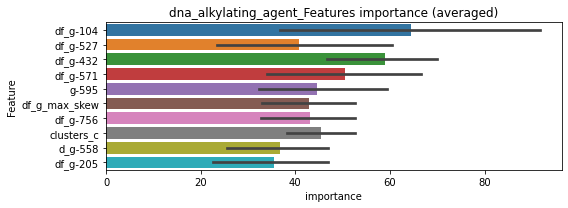

len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270508	valid_1's binary_logloss: 0.0569797
[200]	training's binary_logloss: 0.00500901	valid_1's binary_logloss: 0.0331821
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00246577	valid_1's binary_logloss: 0.0308715


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276274	valid_1's binary_logloss: 0.0609181
[200]	training's binary_logloss: 0.00513061	valid_1's binary_logloss: 0.0358206
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00244045	valid_1's binary_logloss: 0.0313618


dna_alkylating_agent logloss: 0.031116556735743005
dna_inhibitor , len(trt) : 402


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.323907	valid_1's binary_logloss: 0.66744
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.619
Threshold: 0.5018345923621796
Remove_noisy_labels: 416 → positive_corect_labels: 292/584
30th percentile: 0.45865
p_label_rate: 0.44023 Vs.target_rate: 0.01178, Num_p_label: 1753.0, conf_0:0.45865, conf_1:0.50183
Num_p_label: 1753.0, Expected: 46.9, Adj_threshold_1: 0.50
Num_p_label: 818.0, Expected: 46.9, Adj_threshold_2: 0.54
Num_p_label: 281.0, Expected: 46.9, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 46.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:62.0/3982, p_label_rate: 0.01557


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.448057	valid_1's binary_logloss: 0.673039


positive y_label:292.0/584, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208984	valid_1's binary_logloss: 0.574474
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.109212	valid_1's binary_logloss: 0.557266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198549	valid_1's binary_logloss: 0.563083
[200]	training's binary_logloss: 0.073154	valid_1's binary_logloss: 0.535927
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0674076	valid_1's binary_logloss: 0.534893


2 / 3 AUC score:0.798
Threshold: 0.6218345923621797
Remove_noisy_labels: 177 → positive_corect_labels: 166.0/407
30th percentile: 0.35617
p_label_rate: 0.26469 Vs.target_rate: 0.01178, Num_p_label: 1054.0, conf_0:0.35617, conf_1:0.62183
Num_p_label: 1054.0, Expected: 46.9, Adj_threshold_1: 0.62
Num_p_label: 826.0, Expected: 46.9, Adj_threshold_2: 0.66
Num_p_label: 617.0, Expected: 46.9, Adj_threshold_3: 0.70
Num_p_label: 416.0, Expected: 46.9, Adj_threshold_4: 0.74
Num_p_label: 256.0, Expected: 46.9, Adj_threshold_5: 0.78
Num_p_label: 142.0, Expected: 46.9, Adj_threshold_6: 0.82
Num_p_label: 60.0, Expected: 46.9, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:166.0/407, y_label_rate: 0.40786
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170613	valid_1's binary_logloss: 0.414888
[200]	training's binary_logloss: 0.0584149	valid_1's binary_logloss: 0.337379
[300]	training's binary_logloss: 0.0238627	valid_1's binary_logloss: 0.313287
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0214436	valid_1's binary_logloss: 0.310983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162096	valid_1's binary_logloss: 0.41893
[200]	training's binary_logloss: 0.0542645	valid_1's binary_logloss: 0.360188
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0445298	valid_1's binary_logloss: 0.347857


3 / 3 AUC score:0.935
Threshold: 0.86183459236218
Remove_noisy_labels: 109 → positive_corect_labels: 60.0/298
30th percentile: 0.12903
p_label_rate: 0.07358 Vs.target_rate: 0.01178, Num_p_label: 293.0, conf_0:0.10100, conf_1:0.86183
Num_p_label: 293.0, Expected: 46.9, Adj_threshold_1: 0.86
Num_p_label: 185.0, Expected: 46.9, Adj_threshold_2: 0.90
Num_p_label: 81.0, Expected: 46.9, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:81.0/3982, p_label_rate: 0.02034
positive y_label:141.0/4280, y_label_rate: 0.03294


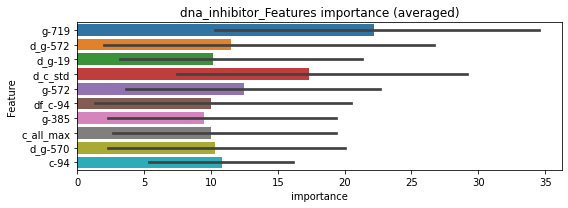

len(train_index) : 2140
len(valid_index) : 2140
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2140
len(valid_index) : 2140
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.0181768	valid_1's binary_logloss: 0.111729
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.10384919228855163


[100]	training's binary_logloss: 0.011855	valid_1's binary_logloss: 0.0967516
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0140134	valid_1's binary_logloss: 0.0959699


dopamine_receptor_agonist , len(trt) : 121


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156578	valid_1's binary_logloss: 0.378969
[200]	training's binary_logloss: 0.0482363	valid_1's binary_logloss: 0.290627
[300]	training's binary_logloss: 0.0184951	valid_1's binary_logloss: 0.248744
[400]	training's binary_logloss: 0.00896296	valid_1's binary_logloss: 0.234839
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00794817	valid_1's binary_logloss: 0.232956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160224	valid_1's binary_logloss: 0.394326
[200]	training's binary_logloss: 0.0514411	valid_1's binary_logloss: 0.306654
[300]	training's binary_logloss: 0.019212	valid_1's binary_logloss: 0.262691
[400]	training's binary_logloss: 0.0093472	valid_1's binary_logloss: 0.24308
[500]	training's binary_logloss: 0.00563987	valid_1's binary_logloss: 0.23429
Early stopping, best iteration is:
[510]	training's binary_loglos

1 / 3 AUC score:0.963
Threshold: 0.41827614118718465
Remove_noisy_labels: 90 → positive_corect_labels: 455/910
30th percentile: 0.09047
p_label_rate: 0.09016 Vs.target_rate: 0.00497, Num_p_label: 359.0, conf_0:0.07243, conf_1:0.57999
Num_p_label: 359.0, Expected: 19.8, Adj_threshold_1: 0.42
Num_p_label: 259.0, Expected: 19.8, Adj_threshold_2: 0.46
Num_p_label: 188.0, Expected: 19.8, Adj_threshold_3: 0.50
Num_p_label: 144.0, Expected: 19.8, Adj_threshold_4: 0.54
Num_p_label: 84.0, Expected: 19.8, Adj_threshold_5: 0.58
Num_p_label: 59.0, Expected: 19.8, Adj_threshold_6: 0.62
Num_p_label: 48.0, Expected: 19.8, Adj_threshold_7: 0.66
Num_p_label: 30.0, Expected: 19.8, Adj_threshold_8: 0.70
Num_p_label: 19.0, Expected: 19.8, Adj_threshold_9: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:455.0/910, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141131	valid_1's binary_logloss: 0.382435
[200]	training's binary_logloss: 0.0404849	valid_1's binary_logloss: 0.292574
[300]	training's binary_logloss: 0.0149848	valid_1's binary_logloss: 0.259275
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0158973	valid_1's binary_logloss: 0.258838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145129	valid_1's binary_logloss: 0.348442
[200]	training's binary_logloss: 0.0425624	valid_1's binary_logloss: 0.263259
[300]	training's binary_logloss: 0.0159598	valid_1's binary_logloss: 0.219466
[400]	training's binary_logloss: 0.00778652	valid_1's binary_logloss: 0.20186
[500]	training's binary_logloss: 0.00483405	valid_1's binary_logloss: 0.192093
[600]	training's binary_logloss: 0.00346967	valid_1's binary_logloss: 0.185905
Early stopping, best iteration is:
[608]	training's binary_logl

2 / 3 AUC score:0.972
Threshold: 0.7382761411871848
Remove_noisy_labels: 98 → positive_corect_labels: 358.0/812
30th percentile: 0.08308
p_label_rate: 0.00954 Vs.target_rate: 0.00497, Num_p_label: 38.0, conf_0:0.08308, conf_1:0.73828
threshold:0.74, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:358.0/812, y_label_rate: 0.44089
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131996	valid_1's binary_logloss: 0.3106
[200]	training's binary_logloss: 0.0376255	valid_1's binary_logloss: 0.215069
[300]	training's binary_logloss: 0.0136618	valid_1's binary_logloss: 0.1758
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0072235	valid_1's binary_logloss: 0.164121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14046	valid_1's binary_logloss: 0.294126
[200]	training's binary_logloss: 0.0408541	valid_1's binary_logloss: 0.185156
[300]	training's binary_logloss: 0.0149914	valid_1's binary_logloss: 0.14305
[400]	training's binary_logloss: 0.00740351	valid_1's binary_logloss: 0.12267
[500]	training's binary_logloss: 0.0046511	valid_1's binary_logloss: 0.1143
[600]	training's binary_logloss: 0.00343227	valid_1's binary_logloss: 0.109339
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00

3 / 3 AUC score:0.989
Threshold: 0.7382761411871848
Remove_noisy_labels: 53 → positive_corect_labels: 305.0/759
30th percentile: 0.03057
p_label_rate: 0.00728 Vs.target_rate: 0.00497, Num_p_label: 29.0, conf_0:0.03057, conf_1:0.73828
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:334.0/4741, y_label_rate: 0.07045


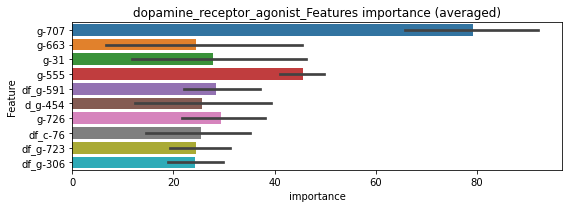

len(train_index) : 2370
len(valid_index) : 2371
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256064	valid_1's binary_logloss: 0.0830337
[200]	training's binary_logloss: 0.00501134	valid_1's binary_logloss: 0.0649562
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00258119	valid_1's binary_logloss: 0.0626773


len(train_index) : 2371
len(valid_index) : 2370
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244473	valid_1's binary_logloss: 0.0809835
[200]	training's binary_logloss: 0.00486835	valid_1's binary_logloss: 0.0605847
[300]	training's binary_logloss: 0.00158794	valid_1's binary_logloss: 0.058159
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00149942	valid_1's binary_logloss: 0.0578801


dopamine_receptor_agonist logloss: 0.0602792409313587
dopamine_receptor_antagonist , len(trt) : 424


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.401248	valid_1's binary_logloss: 0.684035
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.569
Threshold: 0.4998799936964163
Remove_noisy_labels: 456 → positive_corect_labels: 272/544
30th percentile: 0.46598
p_label_rate: 0.44425 Vs.target_rate: 0.01204, Num_p_label: 1769.0, conf_0:0.46598, conf_1:0.49988
Num_p_label: 1769.0, Expected: 47.9, Adj_threshold_1: 0.50
Num_p_label: 719.0, Expected: 47.9, Adj_threshold_2: 0.54
Num_p_label: 173.0, Expected: 47.9, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 47.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.448346	valid_1's binary_logloss: 0.683321


positive y_label:272.0/544, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.382575	valid_1's binary_logloss: 0.630089
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.733
Threshold: 0.6198799936964163
Remove_noisy_labels: 193 → positive_corect_labels: 101.0/351
30th percentile: 0.44186
p_label_rate: 0.11527 Vs.target_rate: 0.01204, Num_p_label: 459.0, conf_0:0.44186, conf_1:0.61988
Num_p_label: 459.0, Expected: 47.9, Adj_threshold_1: 0.62
Num_p_label: 199.0, Expected: 47.9, Adj_threshold_2: 0.66
Num_p_label: 55.0, Expected: 47.9, Adj_threshold_3: 0.70
threshold:0.70, positive p_label:55.0/3982, p_label_rate: 0.01381


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.313345	valid_1's binary_logloss: 0.612374


positive y_label:101.0/351, y_label_rate: 0.28775
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13902	valid_1's binary_logloss: 0.382853
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0615777	valid_1's binary_logloss: 0.347342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148795	valid_1's binary_logloss: 0.430305
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.095132	valid_1's binary_logloss: 0.409647


3 / 3 AUC score:0.877
Threshold: 0.6998799936964164
Remove_noisy_labels: 63 → positive_corect_labels: 40.0/288
30th percentile: 0.09476
p_label_rate: 0.04093 Vs.target_rate: 0.01204, Num_p_label: 163.0, conf_0:0.09476, conf_1:0.69988
Num_p_label: 163.0, Expected: 47.9, Adj_threshold_1: 0.70
Num_p_label: 106.0, Expected: 47.9, Adj_threshold_2: 0.74
Num_p_label: 63.0, Expected: 47.9, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:103.0/4270, y_label_rate: 0.02412


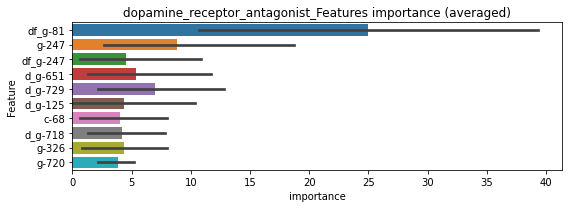

len(train_index) : 2135
len(valid_index) : 2135
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2135
len(valid_index) : 2135
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0122693	valid_1's binary_logloss: 0.081652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00759786	valid_1's binary_logloss: 0.0590385


dopamine_receptor_antagonist logloss: 0.07032667634747812


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.00773411	valid_1's binary_logloss: 0.0590013
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    

egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.291545	valid_1's binary_logloss: 0.650522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226443	valid_1's binary_logloss: 0.624072


1 / 3 AUC score:0.690
Threshold: 0.5104382386527605


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.15239	valid_1's binary_logloss: 0.610922


Remove_noisy_labels: 378 → positive_corect_labels: 311/622
30th percentile: 0.41068
p_label_rate: 0.28403 Vs.target_rate: 0.01078, Num_p_label: 1131.0, conf_0:0.41068, conf_1:0.51044
Num_p_label: 1131.0, Expected: 42.9, Adj_threshold_1: 0.51
Num_p_label: 633.0, Expected: 42.9, Adj_threshold_2: 0.55
Num_p_label: 309.0, Expected: 42.9, Adj_threshold_3: 0.59
Num_p_label: 140.0, Expected: 42.9, Adj_threshold_4: 0.63
Num_p_label: 52.0, Expected: 42.9, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:311.0/622, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198103	valid_1's binary_logloss: 0.520876
[200]	training's binary_logloss: 0.0709886	valid_1's binary_logloss: 0.472187
[300]	training's binary_logloss: 0.0298027	valid_1's binary_logloss: 0.447479
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0268157	valid_1's binary_logloss: 0.44642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198846	valid_1's binary_logloss: 0.54036
[200]	training's binary_logloss: 0.0711064	valid_1's binary_logloss: 0.493021


2 / 3 AUC score:0.863
Threshold: 0.6704382386527606
Remove_noisy_labels: 142 → positive_corect_labels: 198.0/480
30th percentile: 0.29207
p_label_rate: 0.13636 Vs.target_rate: 0.01078, Num_p_label: 543.0, conf_0:0.29207, conf_1:0.67044


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0446751	valid_1's binary_logloss: 0.479301


Num_p_label: 543.0, Expected: 42.9, Adj_threshold_1: 0.67
Num_p_label: 436.0, Expected: 42.9, Adj_threshold_2: 0.71
Num_p_label: 316.0, Expected: 42.9, Adj_threshold_3: 0.75
Num_p_label: 223.0, Expected: 42.9, Adj_threshold_4: 0.79
Num_p_label: 160.0, Expected: 42.9, Adj_threshold_5: 0.83
Num_p_label: 102.0, Expected: 42.9, Adj_threshold_6: 0.87
Num_p_label: 62.0, Expected: 42.9, Adj_threshold_7: 0.91
threshold:0.91, positive p_label:62.0/3982, p_label_rate: 0.01557
positive y_label:198.0/480, y_label_rate: 0.41250
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15869	valid_1's binary_logloss: 0.401613
[200]	training's binary_logloss: 0.0516206	valid_1's binary_logloss: 0.321189
[300]	training's binary_logloss: 0.020625	valid_1's binary_logloss: 0.289998
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0191269	valid_1's binary_logloss: 0.288196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166512	valid_1's binary_logloss: 0.396765
[200]	training's binary_logloss: 0.0552279	valid_1's binary_logloss: 0.326755
[300]	training's binary_logloss: 0.0225723	valid_1's binary_logloss: 0.29802
[400]	training's binary_logloss: 0.0115438	valid_1's binary_logloss: 0.276839
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0111687	valid_1's binary_logloss: 0.276256


3 / 3 AUC score:0.951
Threshold: 0.9104382386527609
Remove_noisy_labels: 108 → positive_corect_labels: 91.0/372
30th percentile: 0.10686
p_label_rate: 0.03064 Vs.target_rate: 0.01078, Num_p_label: 122.0, conf_0:0.10686, conf_1:0.91044
threshold:0.91, positive p_label:122.0/3982, p_label_rate: 0.03064
positive y_label:213.0/4354, y_label_rate: 0.04892


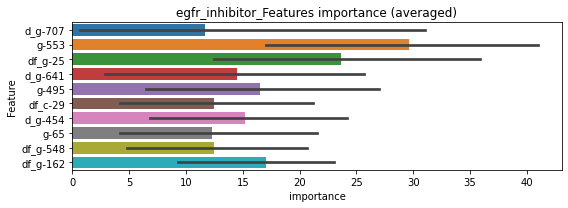

len(train_index) : 2177
len(valid_index) : 2177
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145591	valid_1's binary_logloss: 0.0799904


len(train_index) : 2177
len(valid_index) : 2177
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0106853	valid_1's binary_logloss: 0.0793051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148197	valid_1's binary_logloss: 0.0736269


egfr_inhibitor logloss: 0.07618743900957778


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00994544	valid_1's binary_logloss: 0.0730698


elastase_inhibitor , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505346	valid_1's binary_logloss: 0.0717246
[200]	training's binary_logloss: 0.00716271	valid_1's binary_logloss: 0.0166929
[300]	training's binary_logloss: 0.00231556	valid_1's binary_logloss: 0.00779156
[400]	training's binary_logloss: 0.00133732	valid_1's binary_logloss: 0.00534004
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0011403	valid_1's binary_logloss: 0.00470054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512314	valid_1's binary_logloss: 0.0788406
[200]	training's binary_logloss: 0.00737266	valid_1's binary_logloss: 0.0208021
[300]	training's binary_logloss: 0.00230307	valid_1's binary_logloss: 0.010089
[400]	training's binary_logloss: 0.00132067	valid_1's binary_logloss: 0.00714905
[500]	training's binary_logloss: 0.00109341	valid_1's binary_logloss: 0.00626693
Early stopping, best iteration is:
[559]	t

1 / 3 AUC score:1.000
Threshold: 0.6491806784601114
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00106
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00106, conf_1:0.64918
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.65
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.61
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.57
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.53
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.49
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.45
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_7: 0.41
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_8: 0.37
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_9: 0.33
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_10: 0.29
threshold:0.25, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505346	valid_1's binary_logloss: 0.0717246
[200]	training's binary_logloss: 0.00716271	valid_1's binary_logloss: 0.0166929
[300]	training's binary_logloss: 0.00231556	valid_1's binary_logloss: 0.00779156
[400]	training's binary_logloss: 0.00133732	valid_1's binary_logloss: 0.00534004
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0011403	valid_1's binary_logloss: 0.00470054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512314	valid_1's binary_logloss: 0.0788406
[200]	training's binary_logloss: 0.00737266	valid_1's binary_logloss: 0.0208021
[300]	training's binary_logloss: 0.00230307	valid_1's binary_logloss: 0.010089
[400]	training's binary_logloss: 0.00132067	valid_1's binary_logloss: 0.00714905
[500]	training's binary_logloss: 0.00109341	valid_1's binary_logloss: 0.00626693
Early stopping, best iteration is:
[559]	t

2 / 3 AUC score:1.000
Threshold: 0.2491806784601114
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentile: 0.00106
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00106, conf_1:0.24918
threshold:0.25, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496323	valid_1's binary_logloss: 0.0694586
[200]	training's binary_logloss: 0.00722211	valid_1's binary_logloss: 0.0168882
[300]	training's binary_logloss: 0.00229734	valid_1's binary_logloss: 0.00711448
[400]	training's binary_logloss: 0.00134443	valid_1's binary_logloss: 0.00474402
[500]	training's binary_logloss: 0.00109608	valid_1's binary_logloss: 0.0040121
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00108097	valid_1's binary_logloss: 0.00396286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499441	valid_1's binary_logloss: 0.0764875
[200]	training's binary_logloss: 0.00717903	valid_1's binary_logloss: 0.0197142
[300]	training's binary_logloss: 0.00228414	valid_1's binary_logloss: 0.00975267
[400]	training's binary_logloss: 0.00130161	valid_1's binary_logloss: 0.00700842
Early stopping, best iteration is:
[470]

3 / 3 AUC score:1.000
Threshold: 0.2491806784601114
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/997
30th percentile: 0.00102
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00102, conf_1:0.24918
threshold:0.25, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4979, y_label_rate: 0.10102


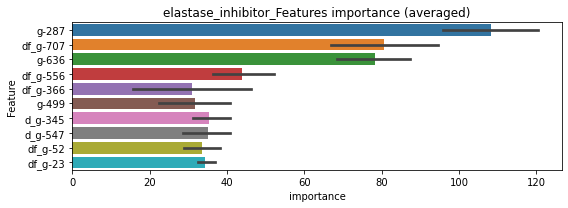

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126046	valid_1's binary_logloss: 0.0183218
[200]	training's binary_logloss: 0.00132686	valid_1's binary_logloss: 0.00491366
[300]	training's binary_logloss: 0.000394324	valid_1's binary_logloss: 0.00343272
[400]	training's binary_logloss: 0.000228436	valid_1's binary_logloss: 0.00319929
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000235575	valid_1's binary_logloss: 0.00318576


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122489	valid_1's binary_logloss: 0.0186946
[200]	training's binary_logloss: 0.00130061	valid_1's binary_logloss: 0.00704626
[300]	training's binary_logloss: 0.00038789	valid_1's binary_logloss: 0.00584118
[400]	training's binary_logloss: 0.000223928	valid_1's binary_logloss: 0.0056658
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000226425	valid_1's binary_logloss: 0.00565535


elastase_inhibitor logloss: 0.004420307472206265
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625799	valid_1's binary_logloss: 0.114611
[200]	training's binary_logloss: 0.0105594	valid_1's binary_logloss: 0.0399563
[300]	training's binary_logloss: 0.00338421	valid_1's binary_logloss: 0.0223576
[400]	training's binary_logloss: 0.00187346	valid_1's binary_logloss: 0.0173672
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00154825	valid_1's binary_logloss: 0.0161217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644448	valid_1's binary_logloss: 0.0990805
[200]	training's binary_logloss: 0.0109729	valid_1's binary_logloss: 0.0302246
[300]	training's binary_logloss: 0.00354073	valid_1's binary_logloss: 0.0153144
[400]	training's binary_logloss: 0.00190816	valid_1's binary_logloss: 0.0107068
[500]	training's binary_logloss: 0.00140871	valid_1's binary_logloss: 0.00907537
Early stopping, best iteration is:
[573]	traini

1 / 3 AUC score:1.000
Threshold: 0.26942726206029105
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00225
p_label_rate: 0.00201 Vs.target_rate: 0.00091, Num_p_label: 8.0, conf_0:0.00225, conf_1:0.32397
threshold:0.27, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618635	valid_1's binary_logloss: 0.117102
[200]	training's binary_logloss: 0.0102629	valid_1's binary_logloss: 0.038435
[300]	training's binary_logloss: 0.00330497	valid_1's binary_logloss: 0.0209001
[400]	training's binary_logloss: 0.00185894	valid_1's binary_logloss: 0.0159778
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00165701	valid_1's binary_logloss: 0.0153598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659377	valid_1's binary_logloss: 0.106096
[200]	training's binary_logloss: 0.0111713	valid_1's binary_logloss: 0.0329436
[300]	training's binary_logloss: 0.00355223	valid_1's binary_logloss: 0.0164656
[400]	training's binary_logloss: 0.00193972	valid_1's binary_logloss: 0.0115631
[500]	training's binary_logloss: 0.00141969	valid_1's binary_logloss: 0.00964227
Early stopping, best iteration is:
[580]	training

2 / 3 AUC score:1.000
Threshold: 0.26942726206029105
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/995
30th percentile: 0.00226
p_label_rate: 0.00126 Vs.target_rate: 0.00091, Num_p_label: 5.0, conf_0:0.00226, conf_1:0.31331
threshold:0.27, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621736	valid_1's binary_logloss: 0.0981949
[200]	training's binary_logloss: 0.0104026	valid_1's binary_logloss: 0.0275972
[300]	training's binary_logloss: 0.00334518	valid_1's binary_logloss: 0.0135827
[400]	training's binary_logloss: 0.00186977	valid_1's binary_logloss: 0.00974499
[500]	training's binary_logloss: 0.00140285	valid_1's binary_logloss: 0.00829984
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0012844	valid_1's binary_logloss: 0.00789357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646361	valid_1's binary_logloss: 0.0971676
[200]	training's binary_logloss: 0.0110075	valid_1's binary_logloss: 0.0264355
[300]	training's binary_logloss: 0.0034794	valid_1's binary_logloss: 0.0120755
[400]	training's binary_logloss: 0.00191449	valid_1's binary_logloss: 0.00841238
[500]	training's binary_logloss: 0.00140689	v

3 / 3 AUC score:1.000
Threshold: 0.26942726206029105
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
30th percentile: 0.00199
p_label_rate: 0.00176 Vs.target_rate: 0.00091, Num_p_label: 7.0, conf_0:0.00199, conf_1:0.30393
threshold:0.27, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:505.0/4977, y_label_rate: 0.10147


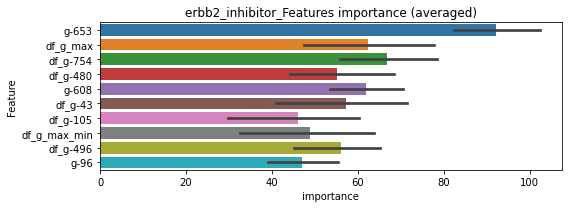

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139138	valid_1's binary_logloss: 0.0302444
[200]	training's binary_logloss: 0.00175531	valid_1's binary_logloss: 0.015289
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00062015	valid_1's binary_logloss: 0.0135734


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152533	valid_1's binary_logloss: 0.0356542
[200]	training's binary_logloss: 0.00188719	valid_1's binary_logloss: 0.0192034
[300]	training's binary_logloss: 0.000574511	valid_1's binary_logloss: 0.0165359
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000530183	valid_1's binary_logloss: 0.0164213


erbb2_inhibitor logloss: 0.014997062005436256
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172379	valid_1's binary_logloss: 0.457917
[200]	training's binary_logloss: 0.0569053	valid_1's binary_logloss: 0.394903
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0400475	valid_1's binary_logloss: 0.38341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174733	valid_1's binary_logloss: 0.433615
[200]	training's binary_logloss: 0.0577912	valid_1's binary_logloss: 0.360671
[300]	training's binary_logloss: 0.0228158	valid_1's binary_logloss: 0.330559


1 / 3 AUC score:0.913
Threshold: 0.4315043636439154


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0208375	valid_1's binary_logloss: 0.328576


Remove_noisy_labels: 150 → positive_corect_labels: 425/850
30th percentile: 0.17796
p_label_rate: 0.12481 Vs.target_rate: 0.00625, Num_p_label: 497.0, conf_0:0.17796, conf_1:0.47860
Num_p_label: 497.0, Expected: 24.9, Adj_threshold_1: 0.43
Num_p_label: 365.0, Expected: 24.9, Adj_threshold_2: 0.47
Num_p_label: 221.0, Expected: 24.9, Adj_threshold_3: 0.51
Num_p_label: 147.0, Expected: 24.9, Adj_threshold_4: 0.55
Num_p_label: 94.0, Expected: 24.9, Adj_threshold_5: 0.59
Num_p_label: 47.0, Expected: 24.9, Adj_threshold_6: 0.63
Num_p_label: 35.0, Expected: 24.9, Adj_threshold_7: 0.67
threshold:0.67, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:425.0/850, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151992	valid_1's binary_logloss: 0.379881
[200]	training's binary_logloss: 0.0472855	valid_1's binary_logloss: 0.285429
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0237849	valid_1's binary_logloss: 0.255964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164759	valid_1's binary_logloss: 0.34997
[200]	training's binary_logloss: 0.0526522	valid_1's binary_logloss: 0.244334
[300]	training's binary_logloss: 0.0205133	valid_1's binary_logloss: 0.198845
[400]	training's binary_logloss: 0.0100558	valid_1's binary_logloss: 0.176443
[500]	training's binary_logloss: 0.00599743	valid_1's binary_logloss: 0.162496
[600]	training's binary_logloss: 0.00425968	valid_1's binary_logloss: 0.155773
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00408273	valid_1's binary_logloss: 0.15538


2 / 3 AUC score:0.979
Threshold: 0.6715043636439155
Remove_noisy_labels: 65 → positive_corect_labels: 367.0/785
30th percentile: 0.10874
p_label_rate: 0.02210 Vs.target_rate: 0.00625, Num_p_label: 88.0, conf_0:0.10874, conf_1:0.67150
Num_p_label: 88.0, Expected: 24.9, Adj_threshold_1: 0.67
Num_p_label: 56.0, Expected: 24.9, Adj_threshold_2: 0.71
Num_p_label: 36.0, Expected: 24.9, Adj_threshold_3: 0.75
threshold:0.75, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:367.0/785, y_label_rate: 0.46752
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147074	valid_1's binary_logloss: 0.378949
[200]	training's binary_logloss: 0.0425846	valid_1's binary_logloss: 0.273059
[300]	training's binary_logloss: 0.0158509	valid_1's binary_logloss: 0.235672
[400]	training's binary_logloss: 0.00777876	valid_1's binary_logloss: 0.218089
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0075025	valid_1's binary_logloss: 0.215884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149528	valid_1's binary_logloss: 0.360687
[200]	training's binary_logloss: 0.0452874	valid_1's binary_logloss: 0.254268
[300]	training's binary_logloss: 0.0174473	valid_1's binary_logloss: 0.210894
[400]	training's binary_logloss: 0.00850055	valid_1's binary_logloss: 0.18797
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00580565	valid_1's binary_logloss: 0.17892


3 / 3 AUC score:0.978
Threshold: 0.7515043636439156
Remove_noisy_labels: 77 → positive_corect_labels: 292.0/708
30th percentile: 0.06578
p_label_rate: 0.01030 Vs.target_rate: 0.00625, Num_p_label: 41.0, conf_0:0.06578, conf_1:0.75150
threshold:0.75, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:333.0/4690, y_label_rate: 0.07100


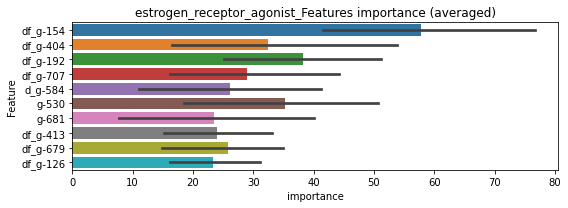

len(train_index) : 2345
len(valid_index) : 2345
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030272	valid_1's binary_logloss: 0.112236
[200]	training's binary_logloss: 0.0066756	valid_1's binary_logloss: 0.0984548
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00660028	valid_1's binary_logloss: 0.0983353


len(train_index) : 2345
len(valid_index) : 2345
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272341	valid_1's binary_logloss: 0.0984794
[200]	training's binary_logloss: 0.00589414	valid_1's binary_logloss: 0.0857854
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00519676	valid_1's binary_logloss: 0.0856211


estrogen_receptor_agonist logloss: 0.09197815999972972
estrogen_receptor_antagonist , len(trt) : 48


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113283	valid_1's binary_logloss: 0.216807
[200]	training's binary_logloss: 0.0274493	valid_1's binary_logloss: 0.105518
[300]	training's binary_logloss: 0.00907867	valid_1's binary_logloss: 0.0704838
[400]	training's binary_logloss: 0.00443709	valid_1's binary_logloss: 0.0557582
[500]	training's binary_logloss: 0.00284875	valid_1's binary_logloss: 0.0494254
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00223199	valid_1's binary_logloss: 0.0459845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10387	valid_1's binary_logloss: 0.248754
[200]	training's binary_logloss: 0.0239845	valid_1's binary_logloss: 0.156032
[300]	training's binary_logloss: 0.00814506	valid_1's binary_logloss: 0.130872


1 / 3 AUC score:0.993
Threshold: 0.47445545800776767


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0053468	valid_1's binary_logloss: 0.125855


Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentile: 0.01344
p_label_rate: 0.01381 Vs.target_rate: 0.00212, Num_p_label: 55.0, conf_0:0.01344, conf_1:0.50089
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_1: 0.47
Num_p_label: 44.0, Expected: 8.4, Adj_threshold_2: 0.51
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_3: 0.55
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_4: 0.59
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_5: 0.63
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_6: 0.67
threshold:0.67, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10264	valid_1's binary_logloss: 0.200379
[200]	training's binary_logloss: 0.0245202	valid_1's binary_logloss: 0.100674
[300]	training's binary_logloss: 0.00821762	valid_1's binary_logloss: 0.068471
[400]	training's binary_logloss: 0.00407056	valid_1's binary_logloss: 0.0555124
[500]	training's binary_logloss: 0.00266057	valid_1's binary_logloss: 0.0485421
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00253091	valid_1's binary_logloss: 0.0475411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106073	valid_1's binary_logloss: 0.209673
[200]	training's binary_logloss: 0.0241136	valid_1's binary_logloss: 0.0983197
[300]	training's binary_logloss: 0.00802501	valid_1's binary_logloss: 0.0596907
[400]	training's binary_logloss: 0.00399266	valid_1's binary_logloss: 0.0450652
[500]	training's binary_logloss: 0.00261491	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.6744554580077678
Remove_noisy_labels: 4 → positive_corect_labels: 485.0/972
30th percentile: 0.00927
p_label_rate: 0.00703 Vs.target_rate: 0.00212, Num_p_label: 28.0, conf_0:0.00927, conf_1:0.67446
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_1: 0.67
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_2: 0.71
Num_p_label: 21.0, Expected: 8.4, Adj_threshold_3: 0.75
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_4: 0.79
threshold:0.79, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/972, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102657	valid_1's binary_logloss: 0.205972
[200]	training's binary_logloss: 0.0237515	valid_1's binary_logloss: 0.0990809
[300]	training's binary_logloss: 0.00795246	valid_1's binary_logloss: 0.0610179
[400]	training's binary_logloss: 0.00396195	valid_1's binary_logloss: 0.045965
[500]	training's binary_logloss: 0.00259049	valid_1's binary_logloss: 0.0388861
[600]	training's binary_logloss: 0.00201393	valid_1's binary_logloss: 0.0349775
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00184324	valid_1's binary_logloss: 0.0337468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104865	valid_1's binary_logloss: 0.205153
[200]	training's binary_logloss: 0.0239392	valid_1's binary_logloss: 0.1018
[300]	training's binary_logloss: 0.00813543	valid_1's binary_logloss: 0.0712064
[400]	training's binary_logloss: 0.00404193	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.794455458007768
Remove_noisy_labels: 11 → positive_corect_labels: 474.0/961
30th percentile: 0.00951
p_label_rate: 0.00276 Vs.target_rate: 0.00212, Num_p_label: 11.0, conf_0:0.00951, conf_1:0.79446
threshold:0.79, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/4943, y_label_rate: 0.09812


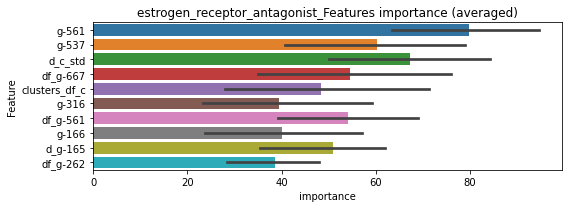

len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273586	valid_1's binary_logloss: 0.0556327
[200]	training's binary_logloss: 0.0047293	valid_1's binary_logloss: 0.0273947
[300]	training's binary_logloss: 0.00138347	valid_1's binary_logloss: 0.0209344
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000773431	valid_1's binary_logloss: 0.0194403


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271282	valid_1's binary_logloss: 0.0575297
[200]	training's binary_logloss: 0.00475719	valid_1's binary_logloss: 0.0292538
[300]	training's binary_logloss: 0.00136193	valid_1's binary_logloss: 0.0245141
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000741873	valid_1's binary_logloss: 0.0234949


estrogen_receptor_antagonist logloss: 0.021467185610804802
faah_inhibitor , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889233	valid_1's binary_logloss: 0.176559
[200]	training's binary_logloss: 0.019093	valid_1's binary_logloss: 0.090697
[300]	training's binary_logloss: 0.00623003	valid_1's binary_logloss: 0.0619214
[400]	training's binary_logloss: 0.00315502	valid_1's binary_logloss: 0.0524399
[500]	training's binary_logloss: 0.00211002	valid_1's binary_logloss: 0.048182
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00182893	valid_1's binary_logloss: 0.0469268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914092	valid_1's binary_logloss: 0.178364
[200]	training's binary_logloss: 0.019204	valid_1's binary_logloss: 0.0769024
[300]	training's binary_logloss: 0.00625964	valid_1's binary_logloss: 0.0470948
[400]	training's binary_logloss: 0.00313712	valid_1's binary_logloss: 0.0364575
Early stopping, best iteration is:
[456]	training's b

1 / 3 AUC score:0.999
Threshold: 0.42585633802948614
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00589
p_label_rate: 0.00653 Vs.target_rate: 0.00161, Num_p_label: 26.0, conf_0:0.00589, conf_1:0.49953
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_1: 0.43
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_2: 0.47
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_3: 0.51
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_4: 0.55
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873124	valid_1's binary_logloss: 0.159393
[200]	training's binary_logloss: 0.0183717	valid_1's binary_logloss: 0.0667545
[300]	training's binary_logloss: 0.00600105	valid_1's binary_logloss: 0.0387827
[400]	training's binary_logloss: 0.00306706	valid_1's binary_logloss: 0.0293338
[500]	training's binary_logloss: 0.00206543	valid_1's binary_logloss: 0.0245068
[600]	training's binary_logloss: 0.00169683	valid_1's binary_logloss: 0.0220696
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00167693	valid_1's binary_logloss: 0.0218705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901378	valid_1's binary_logloss: 0.166003
[200]	training's binary_logloss: 0.018445	valid_1's binary_logloss: 0.0656888
[300]	training's binary_logloss: 0.00606318	valid_1's binary_logloss: 0.0377152
[400]	training's binary_logloss: 0.0031247	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5858563380294862
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/991
30th percentile: 0.00470
p_label_rate: 0.00176 Vs.target_rate: 0.00161, Num_p_label: 7.0, conf_0:0.00470, conf_1:0.58586
threshold:0.59, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897625	valid_1's binary_logloss: 0.153249
[200]	training's binary_logloss: 0.0186167	valid_1's binary_logloss: 0.0629429
[300]	training's binary_logloss: 0.00603508	valid_1's binary_logloss: 0.0377838
[400]	training's binary_logloss: 0.00309043	valid_1's binary_logloss: 0.0286925
[500]	training's binary_logloss: 0.00211395	valid_1's binary_logloss: 0.0250017
[600]	training's binary_logloss: 0.00173814	valid_1's binary_logloss: 0.0228414
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00171922	valid_1's binary_logloss: 0.0226482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922648	valid_1's binary_logloss: 0.168707
[200]	training's binary_logloss: 0.018877	valid_1's binary_logloss: 0.0677868
[300]	training's binary_logloss: 0.00607376	valid_1's binary_logloss: 0.0384946
[400]	training's binary_logloss: 0.00309541	valid_

3 / 3 AUC score:1.000
Threshold: 0.5858563380294862
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/989
30th percentile: 0.00447
p_label_rate: 0.00126 Vs.target_rate: 0.00161, Num_p_label: 5.0, conf_0:0.00447, conf_1:0.58586
threshold:0.59, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/4971, y_label_rate: 0.10038


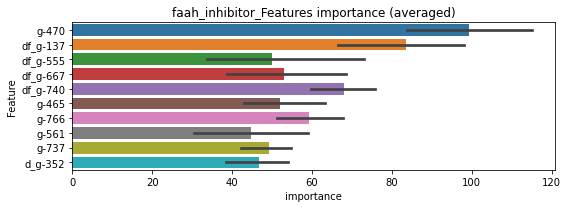

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234242	valid_1's binary_logloss: 0.0538999
[200]	training's binary_logloss: 0.00351848	valid_1's binary_logloss: 0.0222565
[300]	training's binary_logloss: 0.00100295	valid_1's binary_logloss: 0.0153376
[400]	training's binary_logloss: 0.000501264	valid_1's binary_logloss: 0.0132363
[500]	training's binary_logloss: 0.000353625	valid_1's binary_logloss: 0.0124526
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000352107	valid_1's binary_logloss: 0.0124288


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244208	valid_1's binary_logloss: 0.0414389
[200]	training's binary_logloss: 0.00348061	valid_1's binary_logloss: 0.0151674
[300]	training's binary_logloss: 0.000992415	valid_1's binary_logloss: 0.0111767
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00106841	valid_1's binary_logloss: 0.0111359


faah_inhibitor logloss: 0.011782509016939308
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634411	valid_1's binary_logloss: 0.0992561
[200]	training's binary_logloss: 0.0101042	valid_1's binary_logloss: 0.03246
[300]	training's binary_logloss: 0.00317097	valid_1's binary_logloss: 0.0177224
[400]	training's binary_logloss: 0.00173359	valid_1's binary_logloss: 0.0138476
[500]	training's binary_logloss: 0.00130308	valid_1's binary_logloss: 0.0120339
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00125086	valid_1's binary_logloss: 0.0118262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593829	valid_1's binary_logloss: 0.0982351
[200]	training's binary_logloss: 0.00958127	valid_1's binary_logloss: 0.0304584
[300]	training's binary_logloss: 0.00306831	valid_1's binary_logloss: 0.0154345
[400]	training's binary_logloss: 0.00171784	valid_1's binary_logloss: 0.0107549
[500]	training's binary_logloss: 0.00130804	vali

1 / 3 AUC score:1.000
Threshold: 0.4336278957067492
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00173
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00173, conf_1:0.43363
threshold:0.43, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616113	valid_1's binary_logloss: 0.0988808
[200]	training's binary_logloss: 0.0098416	valid_1's binary_logloss: 0.0273042
[300]	training's binary_logloss: 0.0031469	valid_1's binary_logloss: 0.0135049
[400]	training's binary_logloss: 0.00173076	valid_1's binary_logloss: 0.00924927
[500]	training's binary_logloss: 0.0012961	valid_1's binary_logloss: 0.0076095
[600]	training's binary_logloss: 0.00120661	valid_1's binary_logloss: 0.00719198
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00120661	valid_1's binary_logloss: 0.00719198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605138	valid_1's binary_logloss: 0.102257
[200]	training's binary_logloss: 0.00959616	valid_1's binary_logloss: 0.0296634
[300]	training's binary_logloss: 0.00306802	valid_1's binary_logloss: 0.0151425
[400]	training's binary_logloss: 0.00169355	va

2 / 3 AUC score:1.000
Threshold: 0.4336278957067492
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00143
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00143, conf_1:0.43363
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616113	valid_1's binary_logloss: 0.0988808
[200]	training's binary_logloss: 0.0098416	valid_1's binary_logloss: 0.0273042
[300]	training's binary_logloss: 0.0031469	valid_1's binary_logloss: 0.0135049
[400]	training's binary_logloss: 0.00173076	valid_1's binary_logloss: 0.00924927
[500]	training's binary_logloss: 0.0012961	valid_1's binary_logloss: 0.0076095
[600]	training's binary_logloss: 0.00120661	valid_1's binary_logloss: 0.00719198
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00120661	valid_1's binary_logloss: 0.00719198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605138	valid_1's binary_logloss: 0.102257
[200]	training's binary_logloss: 0.00959616	valid_1's binary_logloss: 0.0296634
[300]	training's binary_logloss: 0.00306802	valid_1's binary_logloss: 0.0151425
[400]	training's binary_logloss: 0.00169355	va

3 / 3 AUC score:1.000
Threshold: 0.4336278957067492
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00143
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00143, conf_1:0.43363
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4980, y_label_rate: 0.10060


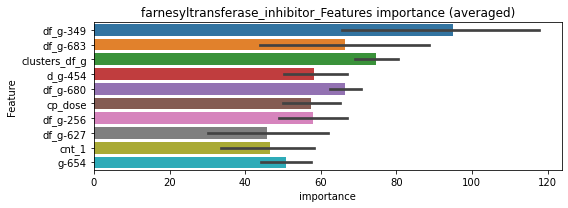

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154151	valid_1's binary_logloss: 0.0231785
[200]	training's binary_logloss: 0.00186241	valid_1's binary_logloss: 0.00642468
[300]	training's binary_logloss: 0.000534988	valid_1's binary_logloss: 0.0042551
[400]	training's binary_logloss: 0.000289685	valid_1's binary_logloss: 0.00387147
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000260921	valid_1's binary_logloss: 0.00383716


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152952	valid_1's binary_logloss: 0.0258693
[200]	training's binary_logloss: 0.0017859	valid_1's binary_logloss: 0.0104389
[300]	training's binary_logloss: 0.000522533	valid_1's binary_logloss: 0.00774492
[400]	training's binary_logloss: 0.000287973	valid_1's binary_logloss: 0.0069873
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.0002654	valid_1's binary_logloss: 0.00691657


farnesyltransferase_inhibitor logloss: 0.005376865546681416
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725517	valid_1's binary_logloss: 0.124522
[200]	training's binary_logloss: 0.0129909	valid_1's binary_logloss: 0.0414912
[300]	training's binary_logloss: 0.00414947	valid_1's binary_logloss: 0.0227822
[400]	training's binary_logloss: 0.00219412	valid_1's binary_logloss: 0.0172488
[500]	training's binary_logloss: 0.00157183	valid_1's binary_logloss: 0.0151652
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00141435	valid_1's binary_logloss: 0.0142779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757562	valid_1's binary_logloss: 0.123891
[200]	training's binary_logloss: 0.0135716	valid_1's binary_logloss: 0.0400777
[300]	training's binary_logloss: 0.00430698	valid_1's binary_logloss: 0.0219145
[400]	training's binary_logloss: 0.00229261	valid_1's binary_logloss: 0.0170374
[500]	training's binary_logloss: 0.0016143	valid_

1 / 3 AUC score:1.000
Threshold: 0.4369743834972753
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00286
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00286, conf_1:0.43697
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725517	valid_1's binary_logloss: 0.124522
[200]	training's binary_logloss: 0.0129909	valid_1's binary_logloss: 0.0414912
[300]	training's binary_logloss: 0.00414947	valid_1's binary_logloss: 0.0227822
[400]	training's binary_logloss: 0.00219412	valid_1's binary_logloss: 0.0172488
[500]	training's binary_logloss: 0.00157183	valid_1's binary_logloss: 0.0151652
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00141435	valid_1's binary_logloss: 0.0142779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757562	valid_1's binary_logloss: 0.123891
[200]	training's binary_logloss: 0.0135716	valid_1's binary_logloss: 0.0400777
[300]	training's binary_logloss: 0.00430698	valid_1's binary_logloss: 0.0219145
[400]	training's binary_logloss: 0.00229261	valid_1's binary_logloss: 0.0170374
[500]	training's binary_logloss: 0.0016143	valid_

2 / 3 AUC score:1.000
Threshold: 0.4369743834972753
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00286
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00286, conf_1:0.43697
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725517	valid_1's binary_logloss: 0.124522
[200]	training's binary_logloss: 0.0129909	valid_1's binary_logloss: 0.0414912
[300]	training's binary_logloss: 0.00414947	valid_1's binary_logloss: 0.0227822
[400]	training's binary_logloss: 0.00219412	valid_1's binary_logloss: 0.0172488
[500]	training's binary_logloss: 0.00157183	valid_1's binary_logloss: 0.0151652
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00141435	valid_1's binary_logloss: 0.0142779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757562	valid_1's binary_logloss: 0.123891
[200]	training's binary_logloss: 0.0135716	valid_1's binary_logloss: 0.0400777
[300]	training's binary_logloss: 0.00430698	valid_1's binary_logloss: 0.0219145
[400]	training's binary_logloss: 0.00229261	valid_1's binary_logloss: 0.0170374
[500]	training's binary_logloss: 0.0016143	valid_

3 / 3 AUC score:1.000
Threshold: 0.4369743834972753
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00286
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00286, conf_1:0.43697
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:507.0/4982, y_label_rate: 0.10177


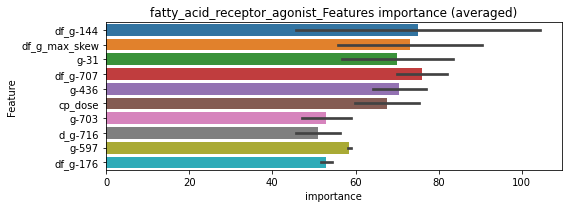

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196849	valid_1's binary_logloss: 0.0372629
[200]	training's binary_logloss: 0.0027133	valid_1's binary_logloss: 0.0167089
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000971221	valid_1's binary_logloss: 0.014439


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019539	valid_1's binary_logloss: 0.0332828
[200]	training's binary_logloss: 0.00257562	valid_1's binary_logloss: 0.0128493
[300]	training's binary_logloss: 0.000747201	valid_1's binary_logloss: 0.0106681
[400]	training's binary_logloss: 0.000394357	valid_1's binary_logloss: 0.0101732
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000388221	valid_1's binary_logloss: 0.0101652


fatty_acid_receptor_agonist logloss: 0.01230207517755324
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109665	valid_1's binary_logloss: 0.212346
[200]	training's binary_logloss: 0.0262187	valid_1's binary_logloss: 0.101009
[300]	training's binary_logloss: 0.00883579	valid_1's binary_logloss: 0.0651469
[400]	training's binary_logloss: 0.00439106	valid_1's binary_logloss: 0.0517673
[500]	training's binary_logloss: 0.00283616	valid_1's binary_logloss: 0.0462994
[600]	training's binary_logloss: 0.00215748	valid_1's binary_logloss: 0.0422992
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00201644	valid_1's binary_logloss: 0.0413853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112238	valid_1's binary_logloss: 0.219345
[200]	training's binary_logloss: 0.027252	valid_1's binary_logloss: 0.109644
[300]	training's binary_logloss: 0.0091835	valid_1's binary_logloss: 0.0717185
[400]	training's binary_logloss: 0.00455979	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.5430569069901799
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.01057
p_label_rate: 0.00352 Vs.target_rate: 0.00220, Num_p_label: 14.0, conf_0:0.01057, conf_1:0.54306
threshold:0.54, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107067	valid_1's binary_logloss: 0.213105
[200]	training's binary_logloss: 0.0247944	valid_1's binary_logloss: 0.110303
[300]	training's binary_logloss: 0.00832144	valid_1's binary_logloss: 0.0767818
[400]	training's binary_logloss: 0.00418381	valid_1's binary_logloss: 0.0642535
[500]	training's binary_logloss: 0.00270308	valid_1's binary_logloss: 0.0569434
[600]	training's binary_logloss: 0.00209105	valid_1's binary_logloss: 0.053328
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00190926	valid_1's binary_logloss: 0.0515205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110654	valid_1's binary_logloss: 0.209225
[200]	training's binary_logloss: 0.0262299	valid_1's binary_logloss: 0.101369
[300]	training's binary_logloss: 0.00875257	valid_1's binary_logloss: 0.0637259
[400]	training's binary_logloss: 0.00434004	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.5430569069901799
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/980
30th percentile: 0.00946
p_label_rate: 0.00276 Vs.target_rate: 0.00220, Num_p_label: 11.0, conf_0:0.00946, conf_1:0.54306
threshold:0.54, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:487.0/980, y_label_rate: 0.49694
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102638	valid_1's binary_logloss: 0.204945
[200]	training's binary_logloss: 0.0239289	valid_1's binary_logloss: 0.0967908
[300]	training's binary_logloss: 0.00819102	valid_1's binary_logloss: 0.0622502
[400]	training's binary_logloss: 0.00409102	valid_1's binary_logloss: 0.0484162
[500]	training's binary_logloss: 0.0026776	valid_1's binary_logloss: 0.0429314
[600]	training's binary_logloss: 0.00208412	valid_1's binary_logloss: 0.0396966
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00192607	valid_1's binary_logloss: 0.0387841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108282	valid_1's binary_logloss: 0.233578
[200]	training's binary_logloss: 0.0254091	valid_1's binary_logloss: 0.121738
[300]	training's binary_logloss: 0.00856166	valid_1's binary_logloss: 0.081913
[400]	training's binary_logloss: 0.00424741	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.5430569069901799
Remove_noisy_labels: 8 → positive_corect_labels: 479.0/972
30th percentile: 0.00929
p_label_rate: 0.00276 Vs.target_rate: 0.00220, Num_p_label: 11.0, conf_0:0.00929, conf_1:0.54306
threshold:0.54, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:490.0/4954, y_label_rate: 0.09891


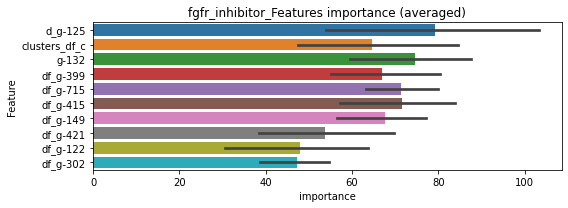

len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264766	valid_1's binary_logloss: 0.0606682
[200]	training's binary_logloss: 0.00459735	valid_1's binary_logloss: 0.0312446
[300]	training's binary_logloss: 0.00134792	valid_1's binary_logloss: 0.0255513
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00104027	valid_1's binary_logloss: 0.0250555


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284953	valid_1's binary_logloss: 0.0588481
[200]	training's binary_logloss: 0.00506049	valid_1's binary_logloss: 0.0292648
[300]	training's binary_logloss: 0.00147422	valid_1's binary_logloss: 0.023068
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000777977	valid_1's binary_logloss: 0.0217072


fgfr_inhibitor logloss: 0.023381322480729504
flt3_inhibitor , len(trt) : 279


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207534	valid_1's binary_logloss: 0.581552
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.138017	valid_1's binary_logloss: 0.573539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209405	valid_1's binary_logloss: 0.584867


1 / 3 AUC score:0.761
Threshold: 0.4797976767649907
Remove_noisy_labels: 324 → positive_corect_labels: 338/676
30th percentile: 0.36265
p_label_rate: 0.29006 Vs.target_rate: 0.00962, Num_p_label: 1155.0, conf_0:0.36265, conf_1:0.48113
Num_p_label: 1155.0, Expected: 38.3, Adj_threshold_1: 0.48
Num_p_label: 767.0, Expected: 38.3, Adj_threshold_2: 0.52
Num_p_label: 418.0, Expected: 38.3, Adj_threshold_3: 0.56
Num_p_label: 217.0, Expected: 38.3, Adj_threshold_4: 0.60


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.103576	valid_1's binary_logloss: 0.563028


Num_p_label: 101.0, Expected: 38.3, Adj_threshold_5: 0.64
Num_p_label: 41.0, Expected: 38.3, Adj_threshold_6: 0.68
threshold:0.68, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:338.0/676, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182939	valid_1's binary_logloss: 0.472623
[200]	training's binary_logloss: 0.0631791	valid_1's binary_logloss: 0.403426
[300]	training's binary_logloss: 0.0257479	valid_1's binary_logloss: 0.380098
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0251631	valid_1's binary_logloss: 0.378174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179774	valid_1's binary_logloss: 0.490258
[200]	training's binary_logloss: 0.0598621	valid_1's binary_logloss: 0.428876
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0514499	valid_1's binary_logloss: 0.42466


2 / 3 AUC score:0.900
Threshold: 0.6797976767649908
Remove_noisy_labels: 123 → positive_corect_labels: 236.0/553
30th percentile: 0.24752
p_label_rate: 0.09367 Vs.target_rate: 0.00962, Num_p_label: 373.0, conf_0:0.24752, conf_1:0.67980
Num_p_label: 373.0, Expected: 38.3, Adj_threshold_1: 0.68
Num_p_label: 259.0, Expected: 38.3, Adj_threshold_2: 0.72
Num_p_label: 164.0, Expected: 38.3, Adj_threshold_3: 0.76
Num_p_label: 99.0, Expected: 38.3, Adj_threshold_4: 0.80
Num_p_label: 48.0, Expected: 38.3, Adj_threshold_5: 0.84
threshold:0.84, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:236.0/553, y_label_rate: 0.42676
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16359	valid_1's binary_logloss: 0.392729
[200]	training's binary_logloss: 0.0532268	valid_1's binary_logloss: 0.325459
[300]	training's binary_logloss: 0.0211154	valid_1's binary_logloss: 0.298731
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0186059	valid_1's binary_logloss: 0.295307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164748	valid_1's binary_logloss: 0.421154
[200]	training's binary_logloss: 0.052365	valid_1's binary_logloss: 0.350696
[300]	training's binary_logloss: 0.0207544	valid_1's binary_logloss: 0.319855
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0165522	valid_1's binary_logloss: 0.317095


3 / 3 AUC score:0.940
Threshold: 0.839797676764991
Remove_noisy_labels: 106 → positive_corect_labels: 132.0/447
30th percentile: 0.10549
p_label_rate: 0.01431 Vs.target_rate: 0.00962, Num_p_label: 57.0, conf_0:0.06415, conf_1:0.83980
threshold:0.84, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:189.0/4429, y_label_rate: 0.04267


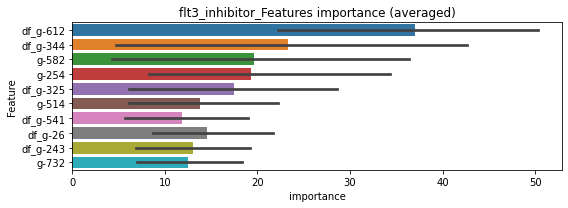

len(train_index) : 2214
len(valid_index) : 2215
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159825	valid_1's binary_logloss: 0.111722
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0182705	valid_1's binary_logloss: 0.111299


len(train_index) : 2215
len(valid_index) : 2214
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182206	valid_1's binary_logloss: 0.107507
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0119488	valid_1's binary_logloss: 0.105862


flt3_inhibitor logloss: 0.1085812391254506
focal_adhesion_kinase_inhibitor , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623006	valid_1's binary_logloss: 0.0942064
[200]	training's binary_logloss: 0.00981523	valid_1's binary_logloss: 0.0237889
[300]	training's binary_logloss: 0.00311569	valid_1's binary_logloss: 0.0108157
[400]	training's binary_logloss: 0.00175016	valid_1's binary_logloss: 0.00764148
[500]	training's binary_logloss: 0.0013206	valid_1's binary_logloss: 0.00645461
[600]	training's binary_logloss: 0.00124039	valid_1's binary_logloss: 0.00617696
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00124039	valid_1's binary_logloss: 0.00617696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607255	valid_1's binary_logloss: 0.0959087
[200]	training's binary_logloss: 0.00969085	valid_1's binary_logloss: 0.028102
[300]	training's binary_logloss: 0.0030826	valid_1's binary_logloss: 0.014857
[400]	training's binary_logloss: 0.00168571	v

1 / 3 AUC score:1.000
Threshold: 0.5668756956296237
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00211
p_label_rate: 0.00025 Vs.target_rate: 0.00082, Num_p_label: 1.0, conf_0:0.00211, conf_1:0.56688
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.57
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.53
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.49
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.45
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623006	valid_1's binary_logloss: 0.0942064
[200]	training's binary_logloss: 0.00981523	valid_1's binary_logloss: 0.0237889
[300]	training's binary_logloss: 0.00311569	valid_1's binary_logloss: 0.0108157
[400]	training's binary_logloss: 0.00175016	valid_1's binary_logloss: 0.00764148
[500]	training's binary_logloss: 0.0013206	valid_1's binary_logloss: 0.00645461
[600]	training's binary_logloss: 0.00124039	valid_1's binary_logloss: 0.00617696
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00124039	valid_1's binary_logloss: 0.00617696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607255	valid_1's binary_logloss: 0.0959087
[200]	training's binary_logloss: 0.00969085	valid_1's binary_logloss: 0.028102
[300]	training's binary_logloss: 0.0030826	valid_1's binary_logloss: 0.014857
[400]	training's binary_logloss: 0.00168571	v

2 / 3 AUC score:1.000
Threshold: 0.4468756956296237
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00211
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00211, conf_1:0.44688
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609472	valid_1's binary_logloss: 0.0927686
[200]	training's binary_logloss: 0.00980154	valid_1's binary_logloss: 0.024157
[300]	training's binary_logloss: 0.0031076	valid_1's binary_logloss: 0.0106683
[400]	training's binary_logloss: 0.00171007	valid_1's binary_logloss: 0.00739294
[500]	training's binary_logloss: 0.00130264	valid_1's binary_logloss: 0.00618669
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00122592	valid_1's binary_logloss: 0.00591611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609165	valid_1's binary_logloss: 0.0937947
[200]	training's binary_logloss: 0.00976794	valid_1's binary_logloss: 0.02724
[300]	training's binary_logloss: 0.00306376	valid_1's binary_logloss: 0.0140543
[400]	training's binary_logloss: 0.00168025	valid_1's binary_logloss: 0.00992571
[500]	training's binary_logloss: 0.00126249	v

3 / 3 AUC score:1.000
Threshold: 0.4468756956296237
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00187
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00187, conf_1:0.44688
threshold:0.45, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4981, y_label_rate: 0.10078


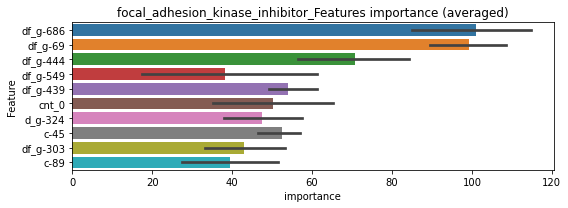

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014663	valid_1's binary_logloss: 0.0299219
[200]	training's binary_logloss: 0.00170657	valid_1's binary_logloss: 0.00747389
[300]	training's binary_logloss: 0.000503574	valid_1's binary_logloss: 0.00427424
[400]	training's binary_logloss: 0.000278141	valid_1's binary_logloss: 0.00372744
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000261339	valid_1's binary_logloss: 0.00368075


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149945	valid_1's binary_logloss: 0.023562
[200]	training's binary_logloss: 0.00177406	valid_1's binary_logloss: 0.00707794
[300]	training's binary_logloss: 0.000513701	valid_1's binary_logloss: 0.00474637
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000375576	valid_1's binary_logloss: 0.00448951


focal_adhesion_kinase_inhibitor logloss: 0.004085046155620085
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065417	valid_1's binary_logloss: 0.0977455
[200]	training's binary_logloss: 0.0107353	valid_1's binary_logloss: 0.0250482
[300]	training's binary_logloss: 0.00340564	valid_1's binary_logloss: 0.0112216
[400]	training's binary_logloss: 0.00187253	valid_1's binary_logloss: 0.00765153
[500]	training's binary_logloss: 0.00139942	valid_1's binary_logloss: 0.00632627
[600]	training's binary_logloss: 0.0013033	valid_1's binary_logloss: 0.00598061
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0013033	valid_1's binary_logloss: 0.00598061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648877	valid_1's binary_logloss: 0.100932
[200]	training's binary_logloss: 0.0109257	valid_1's binary_logloss: 0.0278522
[300]	training's binary_logloss: 0.00348148	valid_1's binary_logloss: 0.0132361
[400]	training's binary_logloss: 0.00186137	val

1 / 3 AUC score:1.000
Threshold: 0.47008367713159016
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00213
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00213, conf_1:0.47008
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.47
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.43
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.39
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.35
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.31
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.27
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.23
threshold:0.19, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065417	valid_1's binary_logloss: 0.0977455
[200]	training's binary_logloss: 0.0107353	valid_1's binary_logloss: 0.0250482
[300]	training's binary_logloss: 0.00340564	valid_1's binary_logloss: 0.0112216
[400]	training's binary_logloss: 0.00187253	valid_1's binary_logloss: 0.00765153
[500]	training's binary_logloss: 0.00139942	valid_1's binary_logloss: 0.00632627
[600]	training's binary_logloss: 0.0013033	valid_1's binary_logloss: 0.00598061
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0013033	valid_1's binary_logloss: 0.00598061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648877	valid_1's binary_logloss: 0.100932
[200]	training's binary_logloss: 0.0109257	valid_1's binary_logloss: 0.0278522
[300]	training's binary_logloss: 0.00348148	valid_1's binary_logloss: 0.0132361
[400]	training's binary_logloss: 0.00186137	val

2 / 3 AUC score:1.000
Threshold: 0.19008367713159025
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00213
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00213, conf_1:0.19008
threshold:0.19, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065417	valid_1's binary_logloss: 0.0977455
[200]	training's binary_logloss: 0.0107353	valid_1's binary_logloss: 0.0250482
[300]	training's binary_logloss: 0.00340564	valid_1's binary_logloss: 0.0112216
[400]	training's binary_logloss: 0.00187253	valid_1's binary_logloss: 0.00765153
[500]	training's binary_logloss: 0.00139942	valid_1's binary_logloss: 0.00632627
[600]	training's binary_logloss: 0.0013033	valid_1's binary_logloss: 0.00598061
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0013033	valid_1's binary_logloss: 0.00598061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648877	valid_1's binary_logloss: 0.100932
[200]	training's binary_logloss: 0.0109257	valid_1's binary_logloss: 0.0278522
[300]	training's binary_logloss: 0.00348148	valid_1's binary_logloss: 0.0132361
[400]	training's binary_logloss: 0.00186137	val

3 / 3 AUC score:1.000
Threshold: 0.19008367713159025
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00213
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00213, conf_1:0.19008
threshold:0.19, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


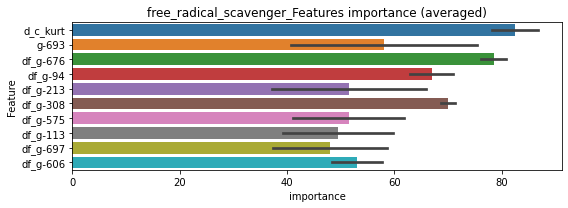

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148349	valid_1's binary_logloss: 0.0233026
[200]	training's binary_logloss: 0.0018038	valid_1's binary_logloss: 0.0061687
[300]	training's binary_logloss: 0.000536116	valid_1's binary_logloss: 0.00396502
[400]	training's binary_logloss: 0.000292411	valid_1's binary_logloss: 0.00327713
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00026525	valid_1's binary_logloss: 0.00323176


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154879	valid_1's binary_logloss: 0.0253231
[200]	training's binary_logloss: 0.00186856	valid_1's binary_logloss: 0.0090729
[300]	training's binary_logloss: 0.000551016	valid_1's binary_logloss: 0.00686236
[400]	training's binary_logloss: 0.000298627	valid_1's binary_logloss: 0.00658372
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000275027	valid_1's binary_logloss: 0.00653094


free_radical_scavenger logloss: 0.004881349819724351
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078695	valid_1's binary_logloss: 0.126621
[200]	training's binary_logloss: 0.014785	valid_1's binary_logloss: 0.0410734
[300]	training's binary_logloss: 0.00470705	valid_1's binary_logloss: 0.0214441
[400]	training's binary_logloss: 0.00245147	valid_1's binary_logloss: 0.0157671
[500]	training's binary_logloss: 0.0017331	valid_1's binary_logloss: 0.0134315
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00168561	valid_1's binary_logloss: 0.0131999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740518	valid_1's binary_logloss: 0.141083
[200]	training's binary_logloss: 0.0137388	valid_1's binary_logloss: 0.0475659
[300]	training's binary_logloss: 0.00437374	valid_1's binary_logloss: 0.0244739
[400]	training's binary_logloss: 0.00233369	valid_1's binary_logloss: 0.0174067
[500]	training's binary_logloss: 0.00167273	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.5933794448111153
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00366
p_label_rate: 0.00000 Vs.target_rate: 0.00104, Num_p_label: 0.0, conf_0:0.00366, conf_1:0.59338
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_1: 0.59
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_2: 0.55
Num_p_label: 0.0, Expected: 4.1, Adj_threshold_3: 0.51
Num_p_label: 1.0, Expected: 4.1, Adj_threshold_4: 0.47
Num_p_label: 1.0, Expected: 4.1, Adj_threshold_5: 0.43
Num_p_label: 4.0, Expected: 4.1, Adj_threshold_6: 0.39
threshold:0.39, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078695	valid_1's binary_logloss: 0.126621
[200]	training's binary_logloss: 0.014785	valid_1's binary_logloss: 0.0410734
[300]	training's binary_logloss: 0.00470705	valid_1's binary_logloss: 0.0214441
[400]	training's binary_logloss: 0.00245147	valid_1's binary_logloss: 0.0157671
[500]	training's binary_logloss: 0.0017331	valid_1's binary_logloss: 0.0134315
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00168561	valid_1's binary_logloss: 0.0131999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740518	valid_1's binary_logloss: 0.141083
[200]	training's binary_logloss: 0.0137388	valid_1's binary_logloss: 0.0475659
[300]	training's binary_logloss: 0.00437374	valid_1's binary_logloss: 0.0244739
[400]	training's binary_logloss: 0.00233369	valid_1's binary_logloss: 0.0174067
[500]	training's binary_logloss: 0.00167273	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.39337944481111525
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00366
p_label_rate: 0.00100 Vs.target_rate: 0.00104, Num_p_label: 4.0, conf_0:0.00366, conf_1:0.39338
threshold:0.39, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782727	valid_1's binary_logloss: 0.126947
[200]	training's binary_logloss: 0.0145291	valid_1's binary_logloss: 0.041731
[300]	training's binary_logloss: 0.00465045	valid_1's binary_logloss: 0.022853
[400]	training's binary_logloss: 0.00242306	valid_1's binary_logloss: 0.0174496
[500]	training's binary_logloss: 0.00172437	valid_1's binary_logloss: 0.0150782
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00155233	valid_1's binary_logloss: 0.0143378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746068	valid_1's binary_logloss: 0.149427
[200]	training's binary_logloss: 0.0139235	valid_1's binary_logloss: 0.0550977
[300]	training's binary_logloss: 0.00440553	valid_1's binary_logloss: 0.0303355
[400]	training's binary_logloss: 0.00233332	valid_1's binary_logloss: 0.0212712
[500]	training's binary_logloss: 0.00168355	valid_1

3 / 3 AUC score:1.000
Threshold: 0.39337944481111525
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00351
p_label_rate: 0.00050 Vs.target_rate: 0.00104, Num_p_label: 2.0, conf_0:0.00351, conf_1:0.39338
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4980, y_label_rate: 0.10080


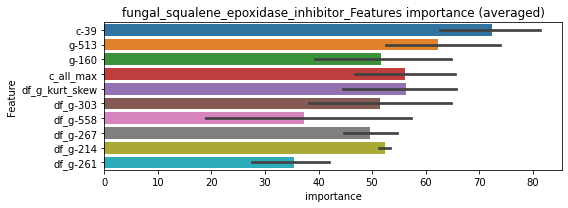

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198028	valid_1's binary_logloss: 0.0338234
[200]	training's binary_logloss: 0.00260672	valid_1's binary_logloss: 0.00961624
[300]	training's binary_logloss: 0.000730204	valid_1's binary_logloss: 0.00556372
[400]	training's binary_logloss: 0.000385574	valid_1's binary_logloss: 0.00448371
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000317237	valid_1's binary_logloss: 0.00422026


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187751	valid_1's binary_logloss: 0.0285237
[200]	training's binary_logloss: 0.00258408	valid_1's binary_logloss: 0.00740189
[300]	training's binary_logloss: 0.000720715	valid_1's binary_logloss: 0.00433093
[400]	training's binary_logloss: 0.0003805	valid_1's binary_logloss: 0.00377088
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000315002	valid_1's binary_logloss: 0.00365597


fungal_squalene_epoxidase_inhibitor logloss: 0.003938113961400073
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148215	valid_1's binary_logloss: 0.355508
[200]	training's binary_logloss: 0.0449189	valid_1's binary_logloss: 0.259317
[300]	training's binary_logloss: 0.0169191	valid_1's binary_logloss: 0.222817
[400]	training's binary_logloss: 0.0080978	valid_1's binary_logloss: 0.201871
[500]	training's binary_logloss: 0.00500196	valid_1's binary_logloss: 0.192149
[600]	training's binary_logloss: 0.0035791	valid_1's binary_logloss: 0.186308
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00331752	valid_1's binary_logloss: 0.184996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151999	valid_1's binary_logloss: 0.350596
[200]	training's binary_logloss: 0.0453272	valid_1's binary_logloss: 0.260748
[300]	training's binary_logloss: 0.0168398	valid_1's binary_logloss: 0.220365
[400]	training's binary_logloss: 0.00818605	valid_1's binary_lo

1 / 3 AUC score:0.976
Threshold: 0.4072155423642996
Remove_noisy_labels: 72 → positive_corect_labels: 464/928
30th percentile: 0.05501
p_label_rate: 0.07007 Vs.target_rate: 0.00442, Num_p_label: 279.0, conf_0:0.05501, conf_1:0.57674
Num_p_label: 279.0, Expected: 17.6, Adj_threshold_1: 0.41
Num_p_label: 209.0, Expected: 17.6, Adj_threshold_2: 0.45
Num_p_label: 156.0, Expected: 17.6, Adj_threshold_3: 0.49
Num_p_label: 123.0, Expected: 17.6, Adj_threshold_4: 0.53
Num_p_label: 78.0, Expected: 17.6, Adj_threshold_5: 0.57
Num_p_label: 61.0, Expected: 17.6, Adj_threshold_6: 0.61
Num_p_label: 40.0, Expected: 17.6, Adj_threshold_7: 0.65
Num_p_label: 25.0, Expected: 17.6, Adj_threshold_8: 0.69
threshold:0.69, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:464.0/928, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141871	valid_1's binary_logloss: 0.319454
[200]	training's binary_logloss: 0.0387813	valid_1's binary_logloss: 0.209518
[300]	training's binary_logloss: 0.0140437	valid_1's binary_logloss: 0.173063
[400]	training's binary_logloss: 0.00695701	valid_1's binary_logloss: 0.154428
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00608234	valid_1's binary_logloss: 0.151404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134884	valid_1's binary_logloss: 0.320919
[200]	training's binary_logloss: 0.0377772	valid_1's binary_logloss: 0.225512
[300]	training's binary_logloss: 0.0141622	valid_1's binary_logloss: 0.191326
[400]	training's binary_logloss: 0.00701176	valid_1's binary_logloss: 0.172431
[500]	training's binary_logloss: 0.00442199	valid_1's binary_logloss: 0.164101
[600]	training's binary_logloss: 0.00320402	valid_1's binary_

2 / 3 AUC score:0.984
Threshold: 0.6872155423642997
Remove_noisy_labels: 58 → positive_corect_labels: 409.0/870
30th percentile: 0.04563
p_label_rate: 0.01431 Vs.target_rate: 0.00442, Num_p_label: 57.0, conf_0:0.04217, conf_1:0.68722
Num_p_label: 57.0, Expected: 17.6, Adj_threshold_1: 0.69
Num_p_label: 36.0, Expected: 17.6, Adj_threshold_2: 0.73
Num_p_label: 24.0, Expected: 17.6, Adj_threshold_3: 0.77
threshold:0.77, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:409.0/870, y_label_rate: 0.47011
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133916	valid_1's binary_logloss: 0.276969
[200]	training's binary_logloss: 0.0374324	valid_1's binary_logloss: 0.168385
[300]	training's binary_logloss: 0.013509	valid_1's binary_logloss: 0.122256
[400]	training's binary_logloss: 0.00664867	valid_1's binary_logloss: 0.103256
[500]	training's binary_logloss: 0.0042125	valid_1's binary_logloss: 0.0928993
[600]	training's binary_logloss: 0.00311165	valid_1's binary_logloss: 0.08713
[700]	training's binary_logloss: 0.00257818	valid_1's binary_logloss: 0.083526
Early stopping, best iteration is:
[729]	training's binary_logloss: 0.00248855	valid_1's binary_logloss: 0.082921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130005	valid_1's binary_logloss: 0.282376
[200]	training's binary_logloss: 0.0360792	valid_1's binary_logloss: 0.171843
[300]	training's binary_logloss: 0.0132352	valid_1's binary_lo

3 / 3 AUC score:0.997
Threshold: 0.7672155423642998
Remove_noisy_labels: 44 → positive_corect_labels: 365.0/826
30th percentile: 0.02717
p_label_rate: 0.00301 Vs.target_rate: 0.00442, Num_p_label: 12.0, conf_0:0.01384, conf_1:0.76722
threshold:0.77, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:377.0/4808, y_label_rate: 0.07841


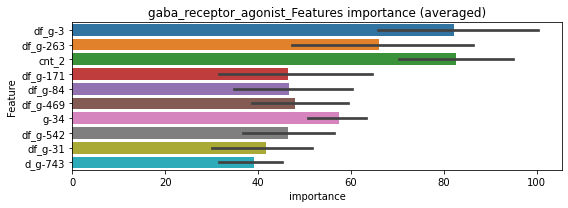

len(train_index) : 2404
len(valid_index) : 2404
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262314	valid_1's binary_logloss: 0.0826625
[200]	training's binary_logloss: 0.00532126	valid_1's binary_logloss: 0.0651323
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00267027	valid_1's binary_logloss: 0.0623936


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248646	valid_1's binary_logloss: 0.0747957
[200]	training's binary_logloss: 0.0051993	valid_1's binary_logloss: 0.0571278
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00248752	valid_1's binary_logloss: 0.054136


gaba_receptor_agonist logloss: 0.058264776291405015
gaba_receptor_antagonist , len(trt) : 165


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16577	valid_1's binary_logloss: 0.464409
[200]	training's binary_logloss: 0.0554796	valid_1's binary_logloss: 0.421349
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0263837	valid_1's binary_logloss: 0.403594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176113	valid_1's binary_logloss: 0.447057
[200]	training's binary_logloss: 0.05841	valid_1's binary_logloss: 0.370471
[300]	training's binary_logloss: 0.0233764	valid_1's binary_logloss: 0.340712
[400]	training's binary_logloss: 0.0114241	valid_1's binary_logloss: 0.32271
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00806573	valid_1's binary_logloss: 0.316018


1 / 3 AUC score:0.905
Threshold: 0.4380047384345289
Remove_noisy_labels: 170 → positive_corect_labels: 415/830
30th percentile: 0.16443
p_label_rate: 0.09895 Vs.target_rate: 0.00648, Num_p_label: 394.0, conf_0:0.16443, conf_1:0.49930
Num_p_label: 394.0, Expected: 25.8, Adj_threshold_1: 0.44
Num_p_label: 261.0, Expected: 25.8, Adj_threshold_2: 0.48
Num_p_label: 164.0, Expected: 25.8, Adj_threshold_3: 0.52
Num_p_label: 100.0, Expected: 25.8, Adj_threshold_4: 0.56
Num_p_label: 58.0, Expected: 25.8, Adj_threshold_5: 0.60
Num_p_label: 42.0, Expected: 25.8, Adj_threshold_6: 0.64
Num_p_label: 20.0, Expected: 25.8, Adj_threshold_7: 0.68
threshold:0.68, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:415.0/830, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157444	valid_1's binary_logloss: 0.400747
[200]	training's binary_logloss: 0.0493786	valid_1's binary_logloss: 0.308087
[300]	training's binary_logloss: 0.019358	valid_1's binary_logloss: 0.267469
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0115017	valid_1's binary_logloss: 0.250931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152801	valid_1's binary_logloss: 0.396835
[200]	training's binary_logloss: 0.0474248	valid_1's binary_logloss: 0.316856


2 / 3 AUC score:0.954
Threshold: 0.678004738434529
Remove_noisy_labels: 90 → positive_corect_labels: 332.0/740
30th percentile: 0.13534
p_label_rate: 0.01256 Vs.target_rate: 0.00648, Num_p_label: 50.0, conf_0:0.13534, conf_1:0.67800
threshold:0.68, positive p_label:50.0/3982, p_label_rate: 0.01256


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0261305	valid_1's binary_logloss: 0.295126


positive y_label:332.0/740, y_label_rate: 0.44865
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132607	valid_1's binary_logloss: 0.29896
[200]	training's binary_logloss: 0.040194	valid_1's binary_logloss: 0.208753
[300]	training's binary_logloss: 0.0152905	valid_1's binary_logloss: 0.169838
[400]	training's binary_logloss: 0.0078292	valid_1's binary_logloss: 0.150889
[500]	training's binary_logloss: 0.0049599	valid_1's binary_logloss: 0.142209
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00381652	valid_1's binary_logloss: 0.137936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145014	valid_1's binary_logloss: 0.310058
[200]	training's binary_logloss: 0.0436892	valid_1's binary_logloss: 0.207941
[300]	training's binary_logloss: 0.0164527	valid_1's binary_logloss: 0.159749
[400]	training's binary_logloss: 0.00828805	valid_1's binary_logloss: 0.141779
[500]	training's binary_logloss: 0.00522223	valid_1's binary_logl

3 / 3 AUC score:0.991
Threshold: 0.678004738434529
Remove_noisy_labels: 40 → positive_corect_labels: 293.0/700
30th percentile: 0.03889
p_label_rate: 0.00779 Vs.target_rate: 0.00648, Num_p_label: 31.0, conf_0:0.03454, conf_1:0.67800
threshold:0.68, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:324.0/4682, y_label_rate: 0.06920


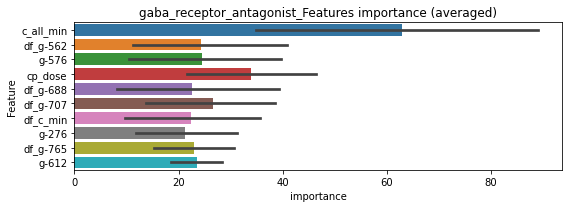

len(train_index) : 2341
len(valid_index) : 2341
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216821	valid_1's binary_logloss: 0.0920072
[200]	training's binary_logloss: 0.00453179	valid_1's binary_logloss: 0.0768255
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00284122	valid_1's binary_logloss: 0.0755104


len(train_index) : 2341
len(valid_index) : 2341
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208984	valid_1's binary_logloss: 0.0779176
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00644919	valid_1's binary_logloss: 0.0677977


gaba_receptor_antagonist logloss: 0.07165404879613194
gamma_secretase_inhibitor , len(trt) : 56


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110853	valid_1's binary_logloss: 0.230085
[200]	training's binary_logloss: 0.0271349	valid_1's binary_logloss: 0.137045
[300]	training's binary_logloss: 0.00909823	valid_1's binary_logloss: 0.101183
[400]	training's binary_logloss: 0.00452026	valid_1's binary_logloss: 0.086728
[500]	training's binary_logloss: 0.00295034	valid_1's binary_logloss: 0.08035
[600]	training's binary_logloss: 0.00226218	valid_1's binary_logloss: 0.076649
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.00208281	valid_1's binary_logloss: 0.0755165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115507	valid_1's binary_logloss: 0.242284
[200]	training's binary_logloss: 0.0294954	valid_1's binary_logloss: 0.134429
[300]	training's binary_logloss: 0.0101716	valid_1's binary_logloss: 0.0930649
[400]	training's binary_logloss: 0.00501082	valid_1's binar

1 / 3 AUC score:0.998
Threshold: 0.37318494732045854
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentile: 0.01142
p_label_rate: 0.00628 Vs.target_rate: 0.00246, Num_p_label: 25.0, conf_0:0.01142, conf_1:0.42070
threshold:0.37, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109961	valid_1's binary_logloss: 0.217858
[200]	training's binary_logloss: 0.0269789	valid_1's binary_logloss: 0.121745
[300]	training's binary_logloss: 0.00915091	valid_1's binary_logloss: 0.0865383
[400]	training's binary_logloss: 0.00452465	valid_1's binary_logloss: 0.0744574
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00322972	valid_1's binary_logloss: 0.0684829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109328	valid_1's binary_logloss: 0.226953
[200]	training's binary_logloss: 0.0264558	valid_1's binary_logloss: 0.128961
[300]	training's binary_logloss: 0.0090267	valid_1's binary_logloss: 0.0960922
[400]	training's binary_logloss: 0.00447485	valid_1's binary_logloss: 0.0825681
[500]	training's binary_logloss: 0.00286724	valid_1's binary_logloss: 0.0768698
[600]	training's binary_logloss: 0.00221986	valid_1's 

2 / 3 AUC score:0.997
Threshold: 0.37318494732045854
Remove_noisy_labels: 17 → positive_corect_labels: 476.0/959
30th percentile: 0.01100
p_label_rate: 0.01030 Vs.target_rate: 0.00246, Num_p_label: 41.0, conf_0:0.01100, conf_1:0.41710
Num_p_label: 41.0, Expected: 9.8, Adj_threshold_1: 0.37
Num_p_label: 22.0, Expected: 9.8, Adj_threshold_2: 0.41
Num_p_label: 16.0, Expected: 9.8, Adj_threshold_3: 0.45
Num_p_label: 11.0, Expected: 9.8, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:476.0/959, y_label_rate: 0.49635
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106717	valid_1's binary_logloss: 0.226659
[200]	training's binary_logloss: 0.0251729	valid_1's binary_logloss: 0.140203
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00973575	valid_1's binary_logloss: 0.114056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108835	valid_1's binary_logloss: 0.202186
[200]	training's binary_logloss: 0.0266275	valid_1's binary_logloss: 0.105106
[300]	training's binary_logloss: 0.00918967	valid_1's binary_logloss: 0.0709479
[400]	training's binary_logloss: 0.00454723	valid_1's binary_logloss: 0.0568388
[500]	training's binary_logloss: 0.00292809	valid_1's binary_logloss: 0.0498945
[600]	training's binary_logloss: 0.00226541	valid_1's binary_logloss: 0.045075
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.00208507	valid_1's binary_logloss: 0.043963


3 / 3 AUC score:0.997
Threshold: 0.4931849473204585
Remove_noisy_labels: 24 → positive_corect_labels: 455.0/935
30th percentile: 0.01718
p_label_rate: 0.00603 Vs.target_rate: 0.00246, Num_p_label: 24.0, conf_0:0.01718, conf_1:0.49318
threshold:0.49, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:479.0/4917, y_label_rate: 0.09742


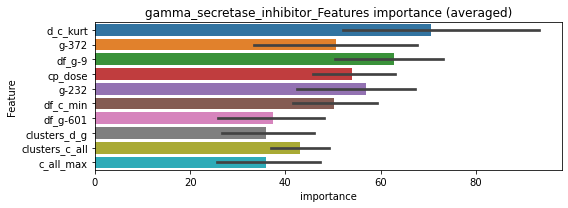

len(train_index) : 2458
len(valid_index) : 2459
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242392	valid_1's binary_logloss: 0.0655184
[200]	training's binary_logloss: 0.00410198	valid_1's binary_logloss: 0.047054
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00197782	valid_1's binary_logloss: 0.0448256


len(train_index) : 2459
len(valid_index) : 2458
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228184	valid_1's binary_logloss: 0.0709101
[200]	training's binary_logloss: 0.00372545	valid_1's binary_logloss: 0.0516205
[300]	training's binary_logloss: 0.00122556	valid_1's binary_logloss: 0.0484152
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0012372	valid_1's binary_logloss: 0.0483754


gamma_secretase_inhibitor logloss: 0.046600169112140065
glucocorticoid_receptor_agonist , len(trt) : 266


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20343	valid_1's binary_logloss: 0.570464
[200]	training's binary_logloss: 0.0752091	valid_1's binary_logloss: 0.539609
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0623804	valid_1's binary_logloss: 0.53585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21306	valid_1's binary_logloss: 0.594953
[200]	training's binary_logloss: 0.0802688	valid_1's binary_logloss: 0.562083
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0842067	valid_1's binary_logloss: 0.561283


1 / 3 AUC score:0.775
Threshold: 0.4921298681433649
Remove_noisy_labels: 308 → positive_corect_labels: 346/692
30th percentile: 0.34434
p_label_rate: 0.26770 Vs.target_rate: 0.00932, Num_p_label: 1066.0, conf_0:0.34434, conf_1:0.51825
Num_p_label: 1066.0, Expected: 37.1, Adj_threshold_1: 0.49
Num_p_label: 702.0, Expected: 37.1, Adj_threshold_2: 0.53
Num_p_label: 433.0, Expected: 37.1, Adj_threshold_3: 0.57
Num_p_label: 260.0, Expected: 37.1, Adj_threshold_4: 0.61
Num_p_label: 126.0, Expected: 37.1, Adj_threshold_5: 0.65
Num_p_label: 49.0, Expected: 37.1, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:346.0/692, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178811	valid_1's binary_logloss: 0.499205
[200]	training's binary_logloss: 0.0621164	valid_1's binary_logloss: 0.451416
[300]	training's binary_logloss: 0.0252929	valid_1's binary_logloss: 0.429328
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.027272	valid_1's binary_logloss: 0.428275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18708	valid_1's binary_logloss: 0.5159
[200]	training's binary_logloss: 0.0641574	valid_1's binary_logloss: 0.448913
[300]	training's binary_logloss: 0.0261034	valid_1's binary_logloss: 0.417231


2 / 3 AUC score:0.885
Threshold: 0.6921298681433651
Remove_noisy_labels: 131 → positive_corect_labels: 240.0/561
30th percentile: 0.23924
p_label_rate: 0.06153 Vs.target_rate: 0.00932, Num_p_label: 245.0, conf_0:0.23924, conf_1:0.69213


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0206903	valid_1's binary_logloss: 0.411508


Num_p_label: 245.0, Expected: 37.1, Adj_threshold_1: 0.69
Num_p_label: 147.0, Expected: 37.1, Adj_threshold_2: 0.73
Num_p_label: 87.0, Expected: 37.1, Adj_threshold_3: 0.77
Num_p_label: 45.0, Expected: 37.1, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:240.0/561, y_label_rate: 0.42781
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159289	valid_1's binary_logloss: 0.447663
[200]	training's binary_logloss: 0.0484309	valid_1's binary_logloss: 0.386121
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0272919	valid_1's binary_logloss: 0.375801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158652	valid_1's binary_logloss: 0.413955
[200]	training's binary_logloss: 0.0515652	valid_1's binary_logloss: 0.362593


3 / 3 AUC score:0.916
Threshold: 0.8121298681433652
Remove_noisy_labels: 115 → positive_corect_labels: 128.0/446


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0294408	valid_1's binary_logloss: 0.347049


30th percentile: 0.12738
p_label_rate: 0.00402 Vs.target_rate: 0.00932, Num_p_label: 16.0, conf_0:0.12738, conf_1:0.81213
threshold:0.81, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:144.0/4428, y_label_rate: 0.03252


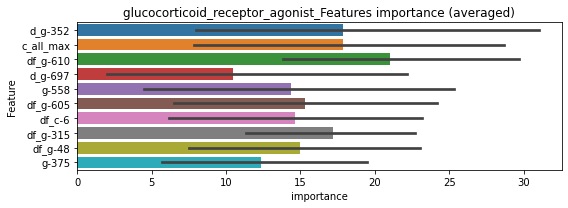

len(train_index) : 2214
len(valid_index) : 2214
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119447	valid_1's binary_logloss: 0.0909065


len(train_index) : 2214
len(valid_index) : 2214
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0101683	valid_1's binary_logloss: 0.0904693
Training until validation scores don't improve for 10 rounds


glucocorticoid_receptor_agonist logloss: 0.09657639018730758


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0140685	valid_1's binary_logloss: 0.102684
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df

glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512492	valid_1's binary_logloss: 0.0751544
[200]	training's binary_logloss: 0.00745155	valid_1's binary_logloss: 0.0191073
[300]	training's binary_logloss: 0.00238897	valid_1's binary_logloss: 0.00878841
[400]	training's binary_logloss: 0.00136972	valid_1's binary_logloss: 0.00599455
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00117458	valid_1's binary_logloss: 0.00531897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529529	valid_1's binary_logloss: 0.0799924
[200]	training's binary_logloss: 0.00762788	valid_1's binary_logloss: 0.0218651
[300]	training's binary_logloss: 0.00245131	valid_1's binary_logloss: 0.0118571
[400]	training's binary_logloss: 0.00138159	valid_1's binary_logloss: 0.00901038
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00116187	valid_1's binary_logloss: 0.00827727


1 / 3 AUC score:1.000
Threshold: 0.7051916492354635
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00149
p_label_rate: 0.00000 Vs.target_rate: 0.00059, Num_p_label: 0.0, conf_0:0.00149, conf_1:0.70519
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_1: 0.71
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_2: 0.67
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_3: 0.63
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_4: 0.59
Num_p_label: 0.0, Expected: 2.4, Adj_threshold_5: 0.55
Num_p_label: 1.0, Expected: 2.4, Adj_threshold_6: 0.51
Num_p_label: 2.0, Expected: 2.4, Adj_threshold_7: 0.47
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536745	valid_1's binary_logloss: 0.0777214
[200]	training's binary_logloss: 0.00777417	valid_1's binary_logloss: 0.01878
[300]	training's binary_logloss: 0.00246037	valid_1's binary_logloss: 0.00876592
[400]	training's binary_logloss: 0.0013907	valid_1's binary_logloss: 0.00620294
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00117579	valid_1's binary_logloss: 0.00554552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509898	valid_1's binary_logloss: 0.0920715
[200]	training's binary_logloss: 0.00721274	valid_1's binary_logloss: 0.0270881
[300]	training's binary_logloss: 0.00232284	valid_1's binary_logloss: 0.0142466
[400]	training's binary_logloss: 0.00131475	valid_1's binary_logloss: 0.0101478
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113368	valid_1's binary_logloss: 0.00879163


2 / 3 AUC score:1.000
Threshold: 0.46519164923546336
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00142
p_label_rate: 0.00025 Vs.target_rate: 0.00059, Num_p_label: 1.0, conf_0:0.00142, conf_1:0.46519
threshold:0.47, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536745	valid_1's binary_logloss: 0.0777214
[200]	training's binary_logloss: 0.00777417	valid_1's binary_logloss: 0.01878
[300]	training's binary_logloss: 0.00246037	valid_1's binary_logloss: 0.00876592
[400]	training's binary_logloss: 0.0013907	valid_1's binary_logloss: 0.00620294
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00117579	valid_1's binary_logloss: 0.00554552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509898	valid_1's binary_logloss: 0.0920715
[200]	training's binary_logloss: 0.00721274	valid_1's binary_logloss: 0.0270881
[300]	training's binary_logloss: 0.00232284	valid_1's binary_logloss: 0.0142466
[400]	training's binary_logloss: 0.00131475	valid_1's binary_logloss: 0.0101478
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113368	valid_1's binary_logloss: 0.00879163


3 / 3 AUC score:1.000
Threshold: 0.46519164923546336
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00142
p_label_rate: 0.00025 Vs.target_rate: 0.00059, Num_p_label: 1.0, conf_0:0.00142, conf_1:0.46519
threshold:0.47, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/4980, y_label_rate: 0.10040


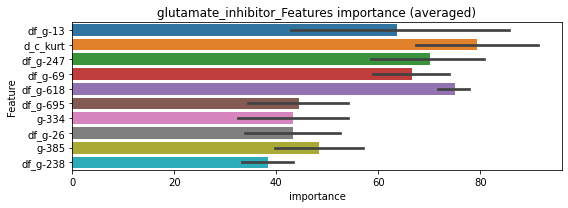

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130461	valid_1's binary_logloss: 0.0198739
[200]	training's binary_logloss: 0.00136707	valid_1's binary_logloss: 0.00619883
[300]	training's binary_logloss: 0.000402894	valid_1's binary_logloss: 0.0046481
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000277922	valid_1's binary_logloss: 0.00441679


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130707	valid_1's binary_logloss: 0.0191213
[200]	training's binary_logloss: 0.00139732	valid_1's binary_logloss: 0.00389398
[300]	training's binary_logloss: 0.00040936	valid_1's binary_logloss: 0.0019164
[400]	training's binary_logloss: 0.000231267	valid_1's binary_logloss: 0.00155818
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000217053	valid_1's binary_logloss: 0.00153501


glutamate_inhibitor logloss: 0.0029759016308537807
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13115	valid_1's binary_logloss: 0.28993
[200]	training's binary_logloss: 0.035223	valid_1's binary_logloss: 0.189208
[300]	training's binary_logloss: 0.0123628	valid_1's binary_logloss: 0.156964
[400]	training's binary_logloss: 0.0060503	valid_1's binary_logloss: 0.146616
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00489919	valid_1's binary_logloss: 0.143095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138622	valid_1's binary_logloss: 0.307754
[200]	training's binary_logloss: 0.0379061	valid_1's binary_logloss: 0.198274
[300]	training's binary_logloss: 0.0133228	valid_1's binary_logloss: 0.157295
[400]	training's binary_logloss: 0.0064509	valid_1's binary_logloss: 0.141195
[500]	training's binary_logloss: 0.0039994	valid_1's binary_logloss: 0.132672
Early stopping, best iteration is:
[534]	training's binary_logloss:

1 / 3 AUC score:0.987
Threshold: 0.41388345495912143
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentile: 0.02812
p_label_rate: 0.02336 Vs.target_rate: 0.00319, Num_p_label: 93.0, conf_0:0.02812, conf_1:0.54058
Num_p_label: 93.0, Expected: 12.7, Adj_threshold_1: 0.41
Num_p_label: 73.0, Expected: 12.7, Adj_threshold_2: 0.45
Num_p_label: 51.0, Expected: 12.7, Adj_threshold_3: 0.49
Num_p_label: 45.0, Expected: 12.7, Adj_threshold_4: 0.53
Num_p_label: 36.0, Expected: 12.7, Adj_threshold_5: 0.57
Num_p_label: 29.0, Expected: 12.7, Adj_threshold_6: 0.61
Num_p_label: 19.0, Expected: 12.7, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125731	valid_1's binary_logloss: 0.269783
[200]	training's binary_logloss: 0.0332948	valid_1's binary_logloss: 0.167095
[300]	training's binary_logloss: 0.0116749	valid_1's binary_logloss: 0.127208
[400]	training's binary_logloss: 0.00567177	valid_1's binary_logloss: 0.11408
[500]	training's binary_logloss: 0.00355061	valid_1's binary_logloss: 0.103814
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.003313	valid_1's binary_logloss: 0.102919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128972	valid_1's binary_logloss: 0.279073
[200]	training's binary_logloss: 0.0330652	valid_1's binary_logloss: 0.162585
[300]	training's binary_logloss: 0.0114749	valid_1's binary_logloss: 0.120666
[400]	training's binary_logloss: 0.00566394	valid_1's binary_logloss: 0.103798
[500]	training's binary_logloss: 0.00359491	valid_1's binary_log

2 / 3 AUC score:0.995
Threshold: 0.6538834549591215
Remove_noisy_labels: 29 → positive_corect_labels: 449.0/919
30th percentile: 0.01933
p_label_rate: 0.01858 Vs.target_rate: 0.00319, Num_p_label: 74.0, conf_0:0.01743, conf_1:0.65388
Num_p_label: 74.0, Expected: 12.7, Adj_threshold_1: 0.65
Num_p_label: 67.0, Expected: 12.7, Adj_threshold_2: 0.69
Num_p_label: 52.0, Expected: 12.7, Adj_threshold_3: 0.73
Num_p_label: 39.0, Expected: 12.7, Adj_threshold_4: 0.77
Num_p_label: 31.0, Expected: 12.7, Adj_threshold_5: 0.81
Num_p_label: 20.0, Expected: 12.7, Adj_threshold_6: 0.85
Num_p_label: 16.0, Expected: 12.7, Adj_threshold_7: 0.89
threshold:0.89, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:449.0/919, y_label_rate: 0.48857
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121344	valid_1's binary_logloss: 0.253374
[200]	training's binary_logloss: 0.0313532	valid_1's binary_logloss: 0.140678
[300]	training's binary_logloss: 0.0109169	valid_1's binary_logloss: 0.0985449
[400]	training's binary_logloss: 0.0054045	valid_1's binary_logloss: 0.0813807
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00369287	valid_1's binary_logloss: 0.0743543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124534	valid_1's binary_logloss: 0.233518
[200]	training's binary_logloss: 0.0318504	valid_1's binary_logloss: 0.119528
[300]	training's binary_logloss: 0.0111116	valid_1's binary_logloss: 0.0771268
[400]	training's binary_logloss: 0.00547503	valid_1's binary_logloss: 0.0611625
[500]	training's binary_logloss: 0.00349876	valid_1's binary_logloss: 0.0539532
[600]	training's binary_logloss: 0.00260869	valid_1's bi

3 / 3 AUC score:1.000
Threshold: 0.8938834549591217
Remove_noisy_labels: 31 → positive_corect_labels: 418.0/888
30th percentile: 0.01573
p_label_rate: 0.00929 Vs.target_rate: 0.00319, Num_p_label: 37.0, conf_0:0.01573, conf_1:0.89388
threshold:0.89, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:455.0/4870, y_label_rate: 0.09343


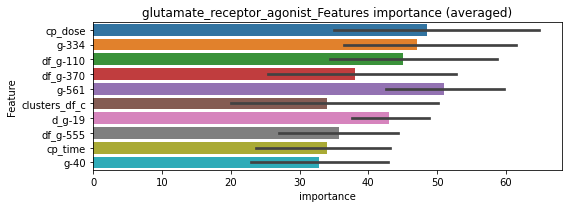

len(train_index) : 2435
len(valid_index) : 2435
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315015	valid_1's binary_logloss: 0.0778812
[200]	training's binary_logloss: 0.00612881	valid_1's binary_logloss: 0.0446852
[300]	training's binary_logloss: 0.00182652	valid_1's binary_logloss: 0.0357783
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00111534	valid_1's binary_logloss: 0.0341775


len(train_index) : 2435
len(valid_index) : 2435
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031199	valid_1's binary_logloss: 0.0901153
[200]	training's binary_logloss: 0.00633831	valid_1's binary_logloss: 0.0617931
[300]	training's binary_logloss: 0.00186582	valid_1's binary_logloss: 0.0542705
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00179844	valid_1's binary_logloss: 0.0539517


glutamate_receptor_agonist logloss: 0.044064600349298766
glutamate_receptor_antagonist , len(trt) : 367


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217114	valid_1's binary_logloss: 0.642249
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.140748	valid_1's binary_logloss: 0.632775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226746	valid_1's binary_logloss: 0.636657


1 / 3 AUC score:0.686
Threshold: 0.5005775618384916
Remove_noisy_labels: 366 → positive_corect_labels: 317/634
30th percentile: 0.41902
p_label_rate: 0.37594 Vs.target_rate: 0.01130, Num_p_label: 1497.0, conf_0:0.41902, conf_1:0.50058
Num_p_label: 1497.0, Expected: 45.0, Adj_threshold_1: 0.50
Num_p_label: 928.0, Expected: 45.0, Adj_threshold_2: 0.54
Num_p_label: 518.0, Expected: 45.0, Adj_threshold_3: 0.58
Num_p_label: 244.0, Expected: 45.0, Adj_threshold_4: 0.62
Num_p_label: 88.0, Expected: 45.0, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.21085	valid_1's binary_logloss: 0.633149


Num_p_label: 28.0, Expected: 45.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:317.0/634, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19649	valid_1's binary_logloss: 0.533573
[200]	training's binary_logloss: 0.0684751	valid_1's binary_logloss: 0.47671
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.058268	valid_1's binary_logloss: 0.471268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193461	valid_1's binary_logloss: 0.544936
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.19759	valid_1's binary_logloss: 0.543919


2 / 3 AUC score:0.839
Threshold: 0.7005775618384917
Remove_noisy_labels: 182 → positive_corect_labels: 152.0/452
30th percentile: 0.35880
p_label_rate: 0.11853 Vs.target_rate: 0.01130, Num_p_label: 472.0, conf_0:0.35880, conf_1:0.70058
Num_p_label: 472.0, Expected: 45.0, Adj_threshold_1: 0.70
Num_p_label: 286.0, Expected: 45.0, Adj_threshold_2: 0.74
Num_p_label: 160.0, Expected: 45.0, Adj_threshold_3: 0.78
Num_p_label: 83.0, Expected: 45.0, Adj_threshold_4: 0.82
Num_p_label: 42.0, Expected: 45.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:152.0/452, y_label_rate: 0.33628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163532	valid_1's binary_logloss: 0.445665
[200]	training's binary_logloss: 0.0552083	valid_1's binary_logloss: 0.386286
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0455534	valid_1's binary_logloss: 0.380593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155721	valid_1's binary_logloss: 0.409019


3 / 3 AUC score:0.892
Threshold: 0.8605775618384919
Remove_noisy_labels: 114 → positive_corect_labels: 38.0/338
30th percentile: 0.09988
p_label_rate: 0.01155 Vs.target_rate: 0.01130, Num_p_label: 46.0, conf_0:0.09988, conf_1:0.86058
threshold:0.86, positive p_label:46.0/3982, p_label_rate: 0.01155


[200]	training's binary_logloss: 0.0486271	valid_1's binary_logloss: 0.367257
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0538863	valid_1's binary_logloss: 0.366555


positive y_label:84.0/4320, y_label_rate: 0.01944


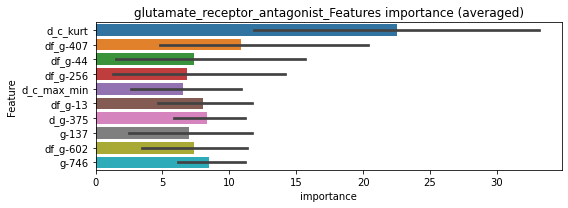

len(train_index) : 2160
len(valid_index) : 2160
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2160
len(valid_index) : 2160
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0125816	valid_1's binary_logloss: 0.0583434
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.055182051849749315


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00741348	valid_1's binary_logloss: 0.0520207


gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

1 / 3 AUC score:1.000
Threshold: 0.24135965214109245
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00200
p_label_rate: 0.00352 Vs.target_rate: 0.00082, Num_p_label: 14.0, conf_0:0.00200, conf_1:0.41741
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_1: 0.24
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_2: 0.28
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_3: 0.32
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_4: 0.36
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_5: 0.40
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_6: 0.44
threshold:0.44, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06404	valid_1's binary_logloss: 0.101041
[200]	training's binary_logloss: 0.0103986	valid_1's binary_logloss: 0.0274049
[300]	training's binary_logloss: 0.00331952	valid_1's binary_logloss: 0.013404
[400]	training's binary_logloss: 0.00182816	valid_1's binary_logloss: 0.00916438
[500]	training's binary_logloss: 0.00137943	valid_1's binary_logloss: 0.00757401
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00131234	valid_1's binary_logloss: 0.00725996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596219	valid_1's binary_logloss: 0.117813
[200]	training's binary_logloss: 0.00990515	valid_1's binary_logloss: 0.0461786
[300]	training's binary_logloss: 0.00323894	valid_1's binary_logloss: 0.0282622
[400]	training's binary_logloss: 0.00177794	valid_1's binary_logloss: 0.0220362
[500]	training's binary_logloss: 0.00136143	vali

2 / 3 AUC score:1.000
Threshold: 0.44135965214109235
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/996
30th percentile: 0.00200
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00200, conf_1:0.44136
threshold:0.44, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/996, y_label_rate: 0.49799
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635671	valid_1's binary_logloss: 0.101946
[200]	training's binary_logloss: 0.0105755	valid_1's binary_logloss: 0.0281296
[300]	training's binary_logloss: 0.00336375	valid_1's binary_logloss: 0.0142369
[400]	training's binary_logloss: 0.00185298	valid_1's binary_logloss: 0.0100003
[500]	training's binary_logloss: 0.00136255	valid_1's binary_logloss: 0.00822397
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00129896	valid_1's binary_logloss: 0.00792478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617409	valid_1's binary_logloss: 0.103349
[200]	training's binary_logloss: 0.010038	valid_1's binary_logloss: 0.0299174
[300]	training's binary_logloss: 0.00327216	valid_1's binary_logloss: 0.0149557
[400]	training's binary_logloss: 0.00180911	valid_1's binary_logloss: 0.0104442
[500]	training's binary_logloss: 0.00140107	vali

3 / 3 AUC score:1.000
Threshold: 0.44135965214109235
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/996
30th percentile: 0.00193
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00193, conf_1:0.46702
threshold:0.44, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/4978, y_label_rate: 0.10044


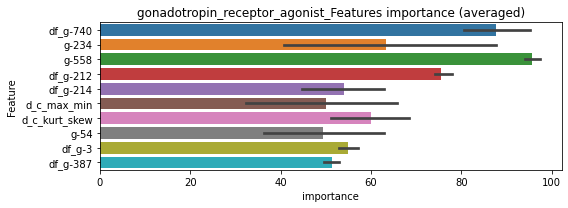

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162795	valid_1's binary_logloss: 0.0320406
[200]	training's binary_logloss: 0.00197262	valid_1's binary_logloss: 0.0114779
[300]	training's binary_logloss: 0.000567922	valid_1's binary_logloss: 0.00795433
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000369717	valid_1's binary_logloss: 0.00733061


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158157	valid_1's binary_logloss: 0.0249167
[200]	training's binary_logloss: 0.0018854	valid_1's binary_logloss: 0.0087823
[300]	training's binary_logloss: 0.000546517	valid_1's binary_logloss: 0.00749855
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000395116	valid_1's binary_logloss: 0.0073905


gonadotropin_receptor_agonist logloss: 0.007360555407237185
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12424	valid_1's binary_logloss: 0.262715
[200]	training's binary_logloss: 0.0325656	valid_1's binary_logloss: 0.144578
[300]	training's binary_logloss: 0.0110916	valid_1's binary_logloss: 0.0955702
[400]	training's binary_logloss: 0.00544608	valid_1's binary_logloss: 0.0752744
[500]	training's binary_logloss: 0.00347305	valid_1's binary_logloss: 0.0653291
[600]	training's binary_logloss: 0.0025965	valid_1's binary_logloss: 0.0590366
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00251871	valid_1's binary_logloss: 0.058481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121156	valid_1's binary_logloss: 0.253532
[200]	training's binary_logloss: 0.0311293	valid_1's binary_logloss: 0.149317
[300]	training's binary_logloss: 0.0107891	valid_1's binary_logloss: 0.112103
[400]	training's binary_logloss: 0.0052635	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.35820660626348066
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.02055
p_label_rate: 0.01030 Vs.target_rate: 0.00262, Num_p_label: 41.0, conf_0:0.02055, conf_1:0.44193
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_1: 0.36
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_2: 0.40
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_3: 0.44
Num_p_label: 10.0, Expected: 10.4, Adj_threshold_4: 0.48
threshold:0.48, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117384	valid_1's binary_logloss: 0.26432
[200]	training's binary_logloss: 0.0287106	valid_1's binary_logloss: 0.156513
[300]	training's binary_logloss: 0.00993409	valid_1's binary_logloss: 0.114832
[400]	training's binary_logloss: 0.00489637	valid_1's binary_logloss: 0.0968545
[500]	training's binary_logloss: 0.00312616	valid_1's binary_logloss: 0.0891402
[600]	training's binary_logloss: 0.00236096	valid_1's binary_logloss: 0.0845268
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.0023044	valid_1's binary_logloss: 0.0839782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118689	valid_1's binary_logloss: 0.225846
[200]	training's binary_logloss: 0.0306572	valid_1's binary_logloss: 0.120708
[300]	training's binary_logloss: 0.0107279	valid_1's binary_logloss: 0.0806303
[400]	training's binary_logloss: 0.00528702	valid_1's bin

2 / 3 AUC score:0.998
Threshold: 0.4782066062634806
Remove_noisy_labels: 21 → positive_corect_labels: 477.0/963
30th percentile: 0.01497
p_label_rate: 0.00276 Vs.target_rate: 0.00262, Num_p_label: 11.0, conf_0:0.01497, conf_1:0.47821
threshold:0.48, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:477.0/963, y_label_rate: 0.49533
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111752	valid_1's binary_logloss: 0.233456
[200]	training's binary_logloss: 0.0280451	valid_1's binary_logloss: 0.128157
[300]	training's binary_logloss: 0.00966364	valid_1's binary_logloss: 0.0834716
[400]	training's binary_logloss: 0.00484357	valid_1's binary_logloss: 0.0662318
[500]	training's binary_logloss: 0.00314148	valid_1's binary_logloss: 0.0572333
[600]	training's binary_logloss: 0.00239415	valid_1's binary_logloss: 0.0522053
[700]	training's binary_logloss: 0.00207845	valid_1's binary_logloss: 0.0500544
Early stopping, best iteration is:
[708]	training's binary_logloss: 0.00205943	valid_1's binary_logloss: 0.0499553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11794	valid_1's binary_logloss: 0.245487
[200]	training's binary_logloss: 0.0298242	valid_1's binary_logloss: 0.136637
[300]	training's binary_logloss: 0.010186	valid_1's bi

3 / 3 AUC score:0.999
Threshold: 0.4782066062634806
Remove_noisy_labels: 17 → positive_corect_labels: 465.0/946
30th percentile: 0.01667
p_label_rate: 0.00502 Vs.target_rate: 0.00262, Num_p_label: 20.0, conf_0:0.01667, conf_1:0.47821
threshold:0.48, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:485.0/4928, y_label_rate: 0.09842


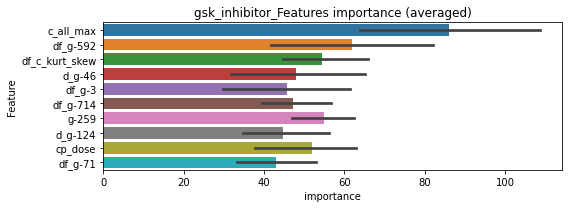

len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029556	valid_1's binary_logloss: 0.0803603
[200]	training's binary_logloss: 0.00551896	valid_1's binary_logloss: 0.0563342
[300]	training's binary_logloss: 0.00159956	valid_1's binary_logloss: 0.0514647
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00109194	valid_1's binary_logloss: 0.0510825


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283142	valid_1's binary_logloss: 0.0808298
[200]	training's binary_logloss: 0.00521573	valid_1's binary_logloss: 0.0574881
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00294973	valid_1's binary_logloss: 0.0560143


gsk_inhibitor logloss: 0.053548388414254376
hcv_inhibitor , len(trt) : 72


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129731	valid_1's binary_logloss: 0.274466
[200]	training's binary_logloss: 0.033796	valid_1's binary_logloss: 0.1674
[300]	training's binary_logloss: 0.0119012	valid_1's binary_logloss: 0.127315
[400]	training's binary_logloss: 0.00579783	valid_1's binary_logloss: 0.110099
[500]	training's binary_logloss: 0.00361934	valid_1's binary_logloss: 0.102518
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00293393	valid_1's binary_logloss: 0.0991038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123762	valid_1's binary_logloss: 0.254628
[200]	training's binary_logloss: 0.0335935	valid_1's binary_logloss: 0.142949
[300]	training's binary_logloss: 0.0121499	valid_1's binary_logloss: 0.101643
[400]	training's binary_logloss: 0.00597714	valid_1's binary_logloss: 0.0823983
[500]	training's binary_logloss: 0.00381513	valid_1's binary_l

1 / 3 AUC score:0.995
Threshold: 0.3827079567431363
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentile: 0.02290
p_label_rate: 0.02762 Vs.target_rate: 0.00311, Num_p_label: 110.0, conf_0:0.02188, conf_1:0.47771
Num_p_label: 110.0, Expected: 12.4, Adj_threshold_1: 0.38
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_2: 0.42
Num_p_label: 53.0, Expected: 12.4, Adj_threshold_3: 0.46
Num_p_label: 36.0, Expected: 12.4, Adj_threshold_4: 0.50
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_5: 0.54
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_6: 0.58
threshold:0.58, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122771	valid_1's binary_logloss: 0.250438
[200]	training's binary_logloss: 0.0324864	valid_1's binary_logloss: 0.146985
[300]	training's binary_logloss: 0.0115692	valid_1's binary_logloss: 0.105039
[400]	training's binary_logloss: 0.00571769	valid_1's binary_logloss: 0.0874683
[500]	training's binary_logloss: 0.00364603	valid_1's binary_logloss: 0.0786744
[600]	training's binary_logloss: 0.00269929	valid_1's binary_logloss: 0.0741465
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.00262282	valid_1's binary_logloss: 0.0736175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121577	valid_1's binary_logloss: 0.263088
[200]	training's binary_logloss: 0.031136	valid_1's binary_logloss: 0.158542
[300]	training's binary_logloss: 0.01069	valid_1's binary_logloss: 0.122516
[400]	training's binary_logloss: 0.0053394	valid_1's binary_

2 / 3 AUC score:0.994
Threshold: 0.5827079567431364
Remove_noisy_labels: 22 → positive_corect_labels: 469.0/952
30th percentile: 0.02074
p_label_rate: 0.00653 Vs.target_rate: 0.00311, Num_p_label: 26.0, conf_0:0.02074, conf_1:0.58271
threshold:0.58, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:469.0/952, y_label_rate: 0.49265
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113467	valid_1's binary_logloss: 0.257419
[200]	training's binary_logloss: 0.0283972	valid_1's binary_logloss: 0.169296
[300]	training's binary_logloss: 0.00986315	valid_1's binary_logloss: 0.136159
[400]	training's binary_logloss: 0.00495871	valid_1's binary_logloss: 0.125696
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.004556	valid_1's binary_logloss: 0.123313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116853	valid_1's binary_logloss: 0.237092
[200]	training's binary_logloss: 0.0304516	valid_1's binary_logloss: 0.135549
[300]	training's binary_logloss: 0.0106958	valid_1's binary_logloss: 0.103278
[400]	training's binary_logloss: 0.00529762	valid_1's binary_logloss: 0.0903312
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00549905	valid_1's binary_logloss: 0.0896216


3 / 3 AUC score:0.993
Threshold: 0.5827079567431364
Remove_noisy_labels: 33 → positive_corect_labels: 437.0/919
30th percentile: 0.02430
p_label_rate: 0.00452 Vs.target_rate: 0.00311, Num_p_label: 18.0, conf_0:0.02430, conf_1:0.58271
threshold:0.58, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:455.0/4901, y_label_rate: 0.09284


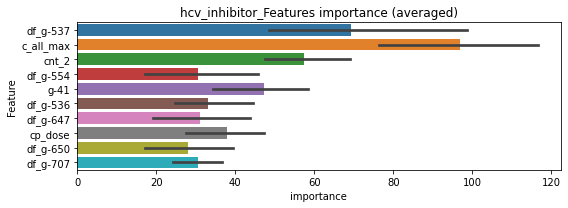

len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268177	valid_1's binary_logloss: 0.0727405
[200]	training's binary_logloss: 0.00487834	valid_1's binary_logloss: 0.0543549
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00250999	valid_1's binary_logloss: 0.0527212


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284793	valid_1's binary_logloss: 0.064605
[200]	training's binary_logloss: 0.00526329	valid_1's binary_logloss: 0.0363411
[300]	training's binary_logloss: 0.0016351	valid_1's binary_logloss: 0.0316009
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000909161	valid_1's binary_logloss: 0.0305488


hcv_inhibitor logloss: 0.04163724843835026
hdac_inhibitor , len(trt) : 106


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152195	valid_1's binary_logloss: 0.356627
[200]	training's binary_logloss: 0.0466747	valid_1's binary_logloss: 0.274845
[300]	training's binary_logloss: 0.0173977	valid_1's binary_logloss: 0.240382
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0104335	valid_1's binary_logloss: 0.227855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147311	valid_1's binary_logloss: 0.363844
[200]	training's binary_logloss: 0.0444375	valid_1's binary_logloss: 0.273181
[300]	training's binary_logloss: 0.0165086	valid_1's binary_logloss: 0.235947
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0108493	valid_1's binary_logloss: 0.229652


1 / 3 AUC score:0.963
Threshold: 0.3670154987154021
Remove_noisy_labels: 94 → positive_corect_labels: 453/906
30th percentile: 0.08284
p_label_rate: 0.07911 Vs.target_rate: 0.00442, Num_p_label: 315.0, conf_0:0.08284, conf_1:0.49165
Num_p_label: 315.0, Expected: 17.6, Adj_threshold_1: 0.37
Num_p_label: 222.0, Expected: 17.6, Adj_threshold_2: 0.41
Num_p_label: 152.0, Expected: 17.6, Adj_threshold_3: 0.45
Num_p_label: 91.0, Expected: 17.6, Adj_threshold_4: 0.49
Num_p_label: 57.0, Expected: 17.6, Adj_threshold_5: 0.53
Num_p_label: 41.0, Expected: 17.6, Adj_threshold_6: 0.57
Num_p_label: 25.0, Expected: 17.6, Adj_threshold_7: 0.61
threshold:0.61, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:453.0/906, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145642	valid_1's binary_logloss: 0.2887
[200]	training's binary_logloss: 0.0427441	valid_1's binary_logloss: 0.190863
[300]	training's binary_logloss: 0.0157752	valid_1's binary_logloss: 0.149865
[400]	training's binary_logloss: 0.00757094	valid_1's binary_logloss: 0.131733
[500]	training's binary_logloss: 0.00463416	valid_1's binary_logloss: 0.123532
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00413068	valid_1's binary_logloss: 0.121989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13227	valid_1's binary_logloss: 0.334102
[200]	training's binary_logloss: 0.0376247	valid_1's binary_logloss: 0.249111
[300]	training's binary_logloss: 0.0137279	valid_1's binary_logloss: 0.214056
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.011272	valid_1's binary_logloss: 0.210117


2 / 3 AUC score:0.980
Threshold: 0.6070154987154022
Remove_noisy_labels: 43 → positive_corect_labels: 420.0/863
30th percentile: 0.05401
p_label_rate: 0.02059 Vs.target_rate: 0.00442, Num_p_label: 82.0, conf_0:0.05401, conf_1:0.60702
Num_p_label: 82.0, Expected: 17.6, Adj_threshold_1: 0.61
Num_p_label: 61.0, Expected: 17.6, Adj_threshold_2: 0.65
Num_p_label: 41.0, Expected: 17.6, Adj_threshold_3: 0.69
Num_p_label: 30.0, Expected: 17.6, Adj_threshold_4: 0.73
Num_p_label: 23.0, Expected: 17.6, Adj_threshold_5: 0.77
threshold:0.77, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:420.0/863, y_label_rate: 0.48667
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134049	valid_1's binary_logloss: 0.266987
[200]	training's binary_logloss: 0.0378018	valid_1's binary_logloss: 0.167403
[300]	training's binary_logloss: 0.0138996	valid_1's binary_logloss: 0.128929
[400]	training's binary_logloss: 0.00685097	valid_1's binary_logloss: 0.112897
[500]	training's binary_logloss: 0.00434148	valid_1's binary_logloss: 0.105775
[600]	training's binary_logloss: 0.00316687	valid_1's binary_logloss: 0.100858
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00320911	valid_1's binary_logloss: 0.100497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124458	valid_1's binary_logloss: 0.292308
[200]	training's binary_logloss: 0.0335753	valid_1's binary_logloss: 0.203086
[300]	training's binary_logloss: 0.0120147	valid_1's binary_logloss: 0.172086
Early stopping, best iteration is:
[346]	training's binary_lo

3 / 3 AUC score:0.989
Threshold: 0.7670154987154023
Remove_noisy_labels: 58 → positive_corect_labels: 362.0/805
30th percentile: 0.03311
p_label_rate: 0.00402 Vs.target_rate: 0.00442, Num_p_label: 16.0, conf_0:0.03311, conf_1:0.76702
threshold:0.77, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:378.0/4787, y_label_rate: 0.07896


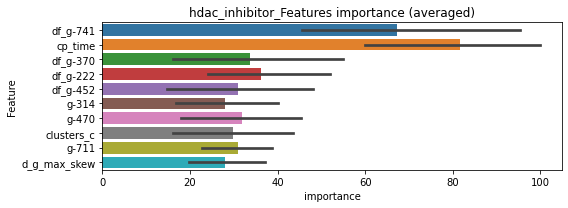

len(train_index) : 2393
len(valid_index) : 2394
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244288	valid_1's binary_logloss: 0.0857628
[200]	training's binary_logloss: 0.00449318	valid_1's binary_logloss: 0.0672193
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00275233	valid_1's binary_logloss: 0.0664355


len(train_index) : 2394
len(valid_index) : 2393
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281071	valid_1's binary_logloss: 0.0719102
[200]	training's binary_logloss: 0.00571807	valid_1's binary_logloss: 0.049782
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00301228	valid_1's binary_logloss: 0.0468698


hdac_inhibitor logloss: 0.05665466439724999
histamine_receptor_agonist , len(trt) : 59


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116614	valid_1's binary_logloss: 0.260913
[200]	training's binary_logloss: 0.0283441	valid_1's binary_logloss: 0.160412
[300]	training's binary_logloss: 0.00968183	valid_1's binary_logloss: 0.124836
[400]	training's binary_logloss: 0.00480702	valid_1's binary_logloss: 0.111316
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00354386	valid_1's binary_logloss: 0.107561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121225	valid_1's binary_logloss: 0.25772
[200]	training's binary_logloss: 0.0307131	valid_1's binary_logloss: 0.155014
[300]	training's binary_logloss: 0.0104582	valid_1's binary_logloss: 0.117637
[400]	training's binary_logloss: 0.00510985	valid_1's binary_logloss: 0.101773
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00518809	valid_1's binary_logloss: 0.101562


1 / 3 AUC score:0.988
Threshold: 0.38985899987426903
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02772
p_label_rate: 0.00854 Vs.target_rate: 0.00258, Num_p_label: 34.0, conf_0:0.02772, conf_1:0.41011
Num_p_label: 34.0, Expected: 10.3, Adj_threshold_1: 0.39
Num_p_label: 24.0, Expected: 10.3, Adj_threshold_2: 0.43
Num_p_label: 18.0, Expected: 10.3, Adj_threshold_3: 0.47
Num_p_label: 13.0, Expected: 10.3, Adj_threshold_4: 0.51
threshold:0.51, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110001	valid_1's binary_logloss: 0.22999
[200]	training's binary_logloss: 0.0261685	valid_1's binary_logloss: 0.122824
[300]	training's binary_logloss: 0.00899766	valid_1's binary_logloss: 0.0873228
[400]	training's binary_logloss: 0.00449141	valid_1's binary_logloss: 0.0754561
[500]	training's binary_logloss: 0.00293784	valid_1's binary_logloss: 0.0683956
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00255914	valid_1's binary_logloss: 0.0666431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109627	valid_1's binary_logloss: 0.235646
[200]	training's binary_logloss: 0.0263245	valid_1's binary_logloss: 0.138635
[300]	training's binary_logloss: 0.00902818	valid_1's binary_logloss: 0.108534
[400]	training's binary_logloss: 0.00446214	valid_1's binary_logloss: 0.0964864
Early stopping, best iteration is:
[455]	training's bin

2 / 3 AUC score:0.995
Threshold: 0.509858999874269
Remove_noisy_labels: 18 → positive_corect_labels: 470.0/952
30th percentile: 0.01919
p_label_rate: 0.00276 Vs.target_rate: 0.00258, Num_p_label: 11.0, conf_0:0.01919, conf_1:0.50986
threshold:0.51, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:470.0/952, y_label_rate: 0.49370
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109299	valid_1's binary_logloss: 0.237906
[200]	training's binary_logloss: 0.0257868	valid_1's binary_logloss: 0.128796
[300]	training's binary_logloss: 0.00884095	valid_1's binary_logloss: 0.092505
[400]	training's binary_logloss: 0.00440254	valid_1's binary_logloss: 0.0738608
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.0030953	valid_1's binary_logloss: 0.0688161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110287	valid_1's binary_logloss: 0.230155
[200]	training's binary_logloss: 0.0265936	valid_1's binary_logloss: 0.127603
[300]	training's binary_logloss: 0.0090669	valid_1's binary_logloss: 0.0942719
[400]	training's binary_logloss: 0.0045191	valid_1's binary_logloss: 0.0793355
[500]	training's binary_logloss: 0.00294737	valid_1's binary_logloss: 0.0726798
Early stopping, best iteration is:
[540]	training's binar

3 / 3 AUC score:0.998
Threshold: 0.509858999874269
Remove_noisy_labels: 18 → positive_corect_labels: 453.0/934
30th percentile: 0.01604
p_label_rate: 0.00201 Vs.target_rate: 0.00258, Num_p_label: 8.0, conf_0:0.01604, conf_1:0.50986
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:461.0/4916, y_label_rate: 0.09378


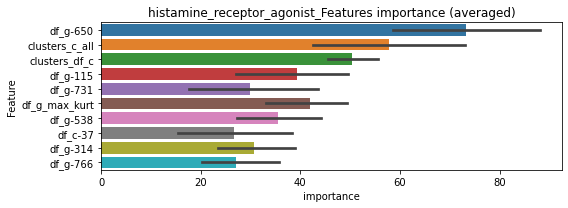

len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267478	valid_1's binary_logloss: 0.0720957
[200]	training's binary_logloss: 0.00454159	valid_1's binary_logloss: 0.0455269
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00171299	valid_1's binary_logloss: 0.0423021


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261729	valid_1's binary_logloss: 0.0575195
[200]	training's binary_logloss: 0.00495667	valid_1's binary_logloss: 0.029653
[300]	training's binary_logloss: 0.00143706	valid_1's binary_logloss: 0.0231022
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000897697	valid_1's binary_logloss: 0.0216918


histamine_receptor_agonist logloss: 0.03199694763044987
histamine_receptor_antagonist , len(trt) : 241


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193177	valid_1's binary_logloss: 0.547549
[200]	training's binary_logloss: 0.0695972	valid_1's binary_logloss: 0.500781
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0343299	valid_1's binary_logloss: 0.486064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204862	valid_1's binary_logloss: 0.546671


1 / 3 AUC score:0.821
Threshold: 0.45505094461065543
Remove_noisy_labels: 268 → positive_corect_labels: 366/732
30th percentile: 0.30150
p_label_rate: 0.26268 Vs.target_rate: 0.00869, Num_p_label: 1046.0, conf_0:0.30150, conf_1:0.47934
Num_p_label: 1046.0, Expected: 34.6, Adj_threshold_1: 0.46


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.117965	valid_1's binary_logloss: 0.513643


Num_p_label: 710.0, Expected: 34.6, Adj_threshold_2: 0.50
Num_p_label: 434.0, Expected: 34.6, Adj_threshold_3: 0.54
Num_p_label: 260.0, Expected: 34.6, Adj_threshold_4: 0.58
Num_p_label: 153.0, Expected: 34.6, Adj_threshold_5: 0.62
Num_p_label: 76.0, Expected: 34.6, Adj_threshold_6: 0.66
Num_p_label: 29.0, Expected: 34.6, Adj_threshold_7: 0.70
threshold:0.70, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:366.0/732, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177438	valid_1's binary_logloss: 0.462844
[200]	training's binary_logloss: 0.0603969	valid_1's binary_logloss: 0.396155
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0392743	valid_1's binary_logloss: 0.376852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174268	valid_1's binary_logloss: 0.44569
[200]	training's binary_logloss: 0.0593605	valid_1's binary_logloss: 0.37981
[300]	training's binary_logloss: 0.0239605	valid_1's binary_logloss: 0.35409
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0195842	valid_1's binary_logloss: 0.347844


2 / 3 AUC score:0.915
Threshold: 0.6950509446106555
Remove_noisy_labels: 118 → positive_corect_labels: 258.0/614
30th percentile: 0.22605
p_label_rate: 0.03817 Vs.target_rate: 0.00869, Num_p_label: 152.0, conf_0:0.22605, conf_1:0.69505
Num_p_label: 152.0, Expected: 34.6, Adj_threshold_1: 0.70
Num_p_label: 90.0, Expected: 34.6, Adj_threshold_2: 0.74
Num_p_label: 53.0, Expected: 34.6, Adj_threshold_3: 0.78
Num_p_label: 22.0, Expected: 34.6, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:258.0/614, y_label_rate: 0.42020
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146876	valid_1's binary_logloss: 0.378925
[200]	training's binary_logloss: 0.0461984	valid_1's binary_logloss: 0.296672
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0271568	valid_1's binary_logloss: 0.266497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159122	valid_1's binary_logloss: 0.389342
[200]	training's binary_logloss: 0.0478977	valid_1's binary_logloss: 0.271172
[300]	training's binary_logloss: 0.0191899	valid_1's binary_logloss: 0.226691


3 / 3 AUC score:0.966
Threshold: 0.8150509446106556
Remove_noisy_labels: 93 → positive_corect_labels: 166.0/521
30th percentile: 0.10572


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0150383	valid_1's binary_logloss: 0.221412


p_label_rate: 0.00377 Vs.target_rate: 0.00869, Num_p_label: 15.0, conf_0:0.10572, conf_1:0.81505
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:181.0/4503, y_label_rate: 0.04020


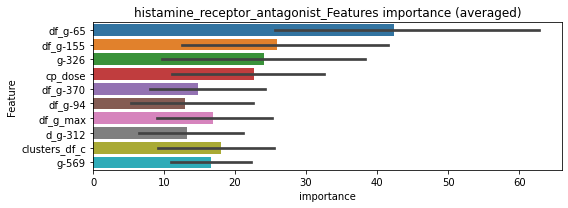

len(train_index) : 2251
len(valid_index) : 2252
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153024	valid_1's binary_logloss: 0.097433


len(train_index) : 2252
len(valid_index) : 2251
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0139833	valid_1's binary_logloss: 0.0959387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128582	valid_1's binary_logloss: 0.083889
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0126272	valid_1's binary_logloss: 0.0838652


histamine_receptor_antagonist logloss: 0.08990330505870488
histone_lysine_demethylase_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770158	valid_1's binary_logloss: 0.127156
[200]	training's binary_logloss: 0.0143	valid_1's binary_logloss: 0.0403777
[300]	training's binary_logloss: 0.0045522	valid_1's binary_logloss: 0.0190022
[400]	training's binary_logloss: 0.00239424	valid_1's binary_logloss: 0.0132184
[500]	training's binary_logloss: 0.00171178	valid_1's binary_logloss: 0.0111722
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00159435	valid_1's binary_logloss: 0.0105072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072472	valid_1's binary_logloss: 0.13734
[200]	training's binary_logloss: 0.0136145	valid_1's binary_logloss: 0.0500592
[300]	training's binary_logloss: 0.00448107	valid_1's binary_logloss: 0.0268153
[400]	training's binary_logloss: 0.00236043	valid_1's binary_logloss: 0.0188474
[500]	training's binary_logloss: 0.00167555	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.5897770604876775
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00326
p_label_rate: 0.00000 Vs.target_rate: 0.00108, Num_p_label: 0.0, conf_0:0.00326, conf_1:0.58978
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_1: 0.59
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_2: 0.55
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_3: 0.51
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_4: 0.47
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_5: 0.43
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_6: 0.39
threshold:0.39, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770158	valid_1's binary_logloss: 0.127156
[200]	training's binary_logloss: 0.0143	valid_1's binary_logloss: 0.0403777
[300]	training's binary_logloss: 0.0045522	valid_1's binary_logloss: 0.0190022
[400]	training's binary_logloss: 0.00239424	valid_1's binary_logloss: 0.0132184
[500]	training's binary_logloss: 0.00171178	valid_1's binary_logloss: 0.0111722
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00159435	valid_1's binary_logloss: 0.0105072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072472	valid_1's binary_logloss: 0.13734
[200]	training's binary_logloss: 0.0136145	valid_1's binary_logloss: 0.0500592
[300]	training's binary_logloss: 0.00448107	valid_1's binary_logloss: 0.0268153
[400]	training's binary_logloss: 0.00236043	valid_1's binary_logloss: 0.0188474
[500]	training's binary_logloss: 0.00167555	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.3897770604876775
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00326
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00326, conf_1:0.38978
threshold:0.39, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748002	valid_1's binary_logloss: 0.128454
[200]	training's binary_logloss: 0.014013	valid_1's binary_logloss: 0.0462739
[300]	training's binary_logloss: 0.00455103	valid_1's binary_logloss: 0.0248892
[400]	training's binary_logloss: 0.00239886	valid_1's binary_logloss: 0.0179796
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00189699	valid_1's binary_logloss: 0.0160672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762402	valid_1's binary_logloss: 0.13055
[200]	training's binary_logloss: 0.0142384	valid_1's binary_logloss: 0.0442284
[300]	training's binary_logloss: 0.00458302	valid_1's binary_logloss: 0.0224088
[400]	training's binary_logloss: 0.00237637	valid_1's binary_logloss: 0.0154837
[500]	training's binary_logloss: 0.00167193	valid_1's binary_logloss: 0.0128304
Early stopping, best iteration is:
[588]	training's

3 / 3 AUC score:1.000
Threshold: 0.3897770604876775
Remove_noisy_labels: 3 → positive_corect_labels: 500.0/996
30th percentile: 0.00372
p_label_rate: 0.00050 Vs.target_rate: 0.00108, Num_p_label: 2.0, conf_0:0.00372, conf_1:0.38978
threshold:0.39, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4978, y_label_rate: 0.10084


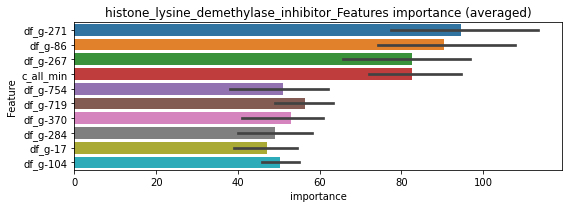

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203957	valid_1's binary_logloss: 0.0309131
[200]	training's binary_logloss: 0.00275379	valid_1's binary_logloss: 0.00853704
[300]	training's binary_logloss: 0.000763708	valid_1's binary_logloss: 0.00483533
[400]	training's binary_logloss: 0.000396956	valid_1's binary_logloss: 0.00388096
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000319443	valid_1's binary_logloss: 0.00368804


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197213	valid_1's binary_logloss: 0.0315571
[200]	training's binary_logloss: 0.00257683	valid_1's binary_logloss: 0.00923498
[300]	training's binary_logloss: 0.000742834	valid_1's binary_logloss: 0.00601859
[400]	training's binary_logloss: 0.000385275	valid_1's binary_logloss: 0.00521324
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00038003	valid_1's binary_logloss: 0.00518871


histone_lysine_demethylase_inhibitor logloss: 0.004438376381891382
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855432	valid_1's binary_logloss: 0.152502
[200]	training's binary_logloss: 0.0171862	valid_1's binary_logloss: 0.0638696
[300]	training's binary_logloss: 0.00553308	valid_1's binary_logloss: 0.0396606
[400]	training's binary_logloss: 0.00282656	valid_1's binary_logloss: 0.0310558
[500]	training's binary_logloss: 0.00192545	valid_1's binary_logloss: 0.0269735
[600]	training's binary_logloss: 0.00161507	valid_1's binary_logloss: 0.025064
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00158051	valid_1's binary_logloss: 0.0248149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832217	valid_1's binary_logloss: 0.152384
[200]	training's binary_logloss: 0.0167475	valid_1's binary_logloss: 0.0664862
[300]	training's binary_logloss: 0.00540638	valid_1's binary_logloss: 0.0424531
[400]	training's binary_logloss: 0.00276534	valid_

1 / 3 AUC score:1.000
Threshold: 0.34932168651033524
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00415
p_label_rate: 0.00301 Vs.target_rate: 0.00144, Num_p_label: 12.0, conf_0:0.00415, conf_1:0.46144
threshold:0.35, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829363	valid_1's binary_logloss: 0.165629
[200]	training's binary_logloss: 0.016551	valid_1's binary_logloss: 0.0723904
[300]	training's binary_logloss: 0.0052916	valid_1's binary_logloss: 0.0429442
[400]	training's binary_logloss: 0.00274334	valid_1's binary_logloss: 0.0329229
[500]	training's binary_logloss: 0.00188839	valid_1's binary_logloss: 0.0287631
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00161815	valid_1's binary_logloss: 0.0272158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847763	valid_1's binary_logloss: 0.145501
[200]	training's binary_logloss: 0.017047	valid_1's binary_logloss: 0.0591522
[300]	training's binary_logloss: 0.00546929	valid_1's binary_logloss: 0.0363862
[400]	training's binary_logloss: 0.0027766	valid_1's binary_logloss: 0.0285774
[500]	training's binary_logloss: 0.00189459	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.34932168651033524
Remove_noisy_labels: 6 → positive_corect_labels: 492.0/986
30th percentile: 0.00371
p_label_rate: 0.00352 Vs.target_rate: 0.00144, Num_p_label: 14.0, conf_0:0.00371, conf_1:0.39325
threshold:0.35, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807683	valid_1's binary_logloss: 0.15444
[200]	training's binary_logloss: 0.0157392	valid_1's binary_logloss: 0.06851
[300]	training's binary_logloss: 0.00510044	valid_1's binary_logloss: 0.0432655
[400]	training's binary_logloss: 0.00266527	valid_1's binary_logloss: 0.0351536
[500]	training's binary_logloss: 0.00184107	valid_1's binary_logloss: 0.0308058
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00158436	valid_1's binary_logloss: 0.0285668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798946	valid_1's binary_logloss: 0.146289
[200]	training's binary_logloss: 0.0159693	valid_1's binary_logloss: 0.0609135
[300]	training's binary_logloss: 0.00520121	valid_1's binary_logloss: 0.0381467
[400]	training's binary_logloss: 0.002701	valid_1's binary_logloss: 0.0304132
[500]	training's binary_logloss: 0.00186476	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.34932168651033524
Remove_noisy_labels: 5 → positive_corect_labels: 489.0/981
30th percentile: 0.00340
p_label_rate: 0.00502 Vs.target_rate: 0.00144, Num_p_label: 20.0, conf_0:0.00340, conf_1:0.48221
Num_p_label: 20.0, Expected: 5.7, Adj_threshold_1: 0.35
Num_p_label: 15.0, Expected: 5.7, Adj_threshold_2: 0.39
Num_p_label: 10.0, Expected: 5.7, Adj_threshold_3: 0.43
Num_p_label: 8.0, Expected: 5.7, Adj_threshold_4: 0.47
threshold:0.47, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/4963, y_label_rate: 0.10014


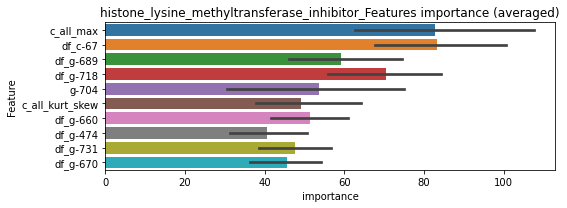

len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200592	valid_1's binary_logloss: 0.0453891
[200]	training's binary_logloss: 0.00282551	valid_1's binary_logloss: 0.0230197
[300]	training's binary_logloss: 0.000820894	valid_1's binary_logloss: 0.0192659
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00070421	valid_1's binary_logloss: 0.0188374


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213814	valid_1's binary_logloss: 0.0380757
[200]	training's binary_logloss: 0.00326353	valid_1's binary_logloss: 0.0150633
[300]	training's binary_logloss: 0.000920316	valid_1's binary_logloss: 0.0110605
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000768735	valid_1's binary_logloss: 0.0106388


histone_lysine_methyltransferase_inhibitor logloss: 0.014738907430578221
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123718	valid_1's binary_logloss: 0.270838
[200]	training's binary_logloss: 0.0338754	valid_1's binary_logloss: 0.168003
[300]	training's binary_logloss: 0.0119982	valid_1's binary_logloss: 0.126703
[400]	training's binary_logloss: 0.00595384	valid_1's binary_logloss: 0.109401
[500]	training's binary_logloss: 0.00376178	valid_1's binary_logloss: 0.0991069
[600]	training's binary_logloss: 0.00281093	valid_1's binary_logloss: 0.0939814
[700]	training's binary_logloss: 0.00234944	valid_1's binary_logloss: 0.0907287
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00235597	valid_1's binary_logloss: 0.090564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128074	valid_1's binary_logloss: 0.265462
[200]	training's binary_logloss: 0.0337608	valid_1's binary_logloss: 0.162644
[300]	training's binary_logloss: 0.0120511	valid_1's bina

1 / 3 AUC score:0.995
Threshold: 0.46578006623343626
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02307
p_label_rate: 0.02486 Vs.target_rate: 0.00311, Num_p_label: 99.0, conf_0:0.01290, conf_1:0.53297
Num_p_label: 99.0, Expected: 12.4, Adj_threshold_1: 0.47
Num_p_label: 65.0, Expected: 12.4, Adj_threshold_2: 0.51
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_3: 0.55
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_4: 0.59
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_5: 0.63
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_6: 0.67
threshold:0.67, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121127	valid_1's binary_logloss: 0.260463
[200]	training's binary_logloss: 0.0315173	valid_1's binary_logloss: 0.157759
[300]	training's binary_logloss: 0.0111164	valid_1's binary_logloss: 0.120542
[400]	training's binary_logloss: 0.00550817	valid_1's binary_logloss: 0.105626
[500]	training's binary_logloss: 0.00350129	valid_1's binary_logloss: 0.0997085
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00285117	valid_1's binary_logloss: 0.095821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11573	valid_1's binary_logloss: 0.270512
[200]	training's binary_logloss: 0.030087	valid_1's binary_logloss: 0.171463
[300]	training's binary_logloss: 0.0106471	valid_1's binary_logloss: 0.13559
[400]	training's binary_logloss: 0.00529883	valid_1's binary_logloss: 0.117264
[500]	training's binary_logloss: 0.00336569	valid_1's binary_lo

2 / 3 AUC score:0.993
Threshold: 0.6657800662334364
Remove_noisy_labels: 33 → positive_corect_labels: 453.0/937
30th percentile: 0.01803
p_label_rate: 0.00603 Vs.target_rate: 0.00311, Num_p_label: 24.0, conf_0:0.01497, conf_1:0.66578
threshold:0.67, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:453.0/937, y_label_rate: 0.48346
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120102	valid_1's binary_logloss: 0.237948
[200]	training's binary_logloss: 0.0306571	valid_1's binary_logloss: 0.131753
[300]	training's binary_logloss: 0.010855	valid_1's binary_logloss: 0.0923417
[400]	training's binary_logloss: 0.00534574	valid_1's binary_logloss: 0.0747506
[500]	training's binary_logloss: 0.00342914	valid_1's binary_logloss: 0.0659057
[600]	training's binary_logloss: 0.00254472	valid_1's binary_logloss: 0.0601053
[700]	training's binary_logloss: 0.00219019	valid_1's binary_logloss: 0.0578742
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.00211552	valid_1's binary_logloss: 0.0573057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113688	valid_1's binary_logloss: 0.241429
[200]	training's binary_logloss: 0.0282505	valid_1's binary_logloss: 0.148424
[300]	training's binary_logloss: 0.00993826	valid_1's b

3 / 3 AUC score:0.997
Threshold: 0.6657800662334364
Remove_noisy_labels: 20 → positive_corect_labels: 435.0/917
30th percentile: 0.01727
p_label_rate: 0.00779 Vs.target_rate: 0.00311, Num_p_label: 31.0, conf_0:0.01727, conf_1:0.66578


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00666893	valid_1's binary_logloss: 0.103574


threshold:0.67, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:466.0/4899, y_label_rate: 0.09512


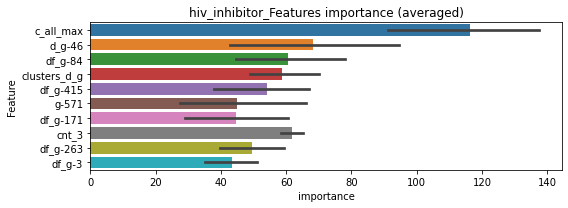

len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292501	valid_1's binary_logloss: 0.0809029
[200]	training's binary_logloss: 0.00536436	valid_1's binary_logloss: 0.0557884
[300]	training's binary_logloss: 0.00165588	valid_1's binary_logloss: 0.0508891
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0013458	valid_1's binary_logloss: 0.0502586


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276761	valid_1's binary_logloss: 0.0769512
[200]	training's binary_logloss: 0.00506854	valid_1's binary_logloss: 0.0512847
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00184322	valid_1's binary_logloss: 0.0476264


hiv_inhibitor logloss: 0.04894275958944925
hmgcr_inhibitor , len(trt) : 283


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203667	valid_1's binary_logloss: 0.590129
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.100351	valid_1's binary_logloss: 0.561023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213283	valid_1's binary_logloss: 0.582039


1 / 3 AUC score:0.764
Threshold: 0.5043240541899072
Remove_noisy_labels: 316 → positive_corect_labels: 342/684
30th percentile: 0.36023
p_label_rate: 0.23707 Vs.target_rate: 0.00971, Num_p_label: 944.0, conf_0:0.36023, conf_1:0.50432
Num_p_label: 944.0, Expected: 38.7, Adj_threshold_1: 0.50
Num_p_label: 595.0, Expected: 38.7, Adj_threshold_2: 0.54
Num_p_label: 334.0, Expected: 38.7, Adj_threshold_3: 0.58
Num_p_label: 166.0, Expected: 38.7, Adj_threshold_4: 0.62
Num_p_label: 76.0, Expected: 38.7, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.148526	valid_1's binary_logloss: 0.565786


Num_p_label: 37.0, Expected: 38.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:342.0/684, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175753	valid_1's binary_logloss: 0.473878
[200]	training's binary_logloss: 0.0592228	valid_1's binary_logloss: 0.423156
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0570996	valid_1's binary_logloss: 0.422323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18408	valid_1's binary_logloss: 0.475537
[200]	training's binary_logloss: 0.0634993	valid_1's binary_logloss: 0.418161


2 / 3 AUC score:0.896
Threshold: 0.7043240541899074
Remove_noisy_labels: 142 → positive_corect_labels: 219.0/542
30th percentile: 0.23426
p_label_rate: 0.08790 Vs.target_rate: 0.00971, Num_p_label: 350.0, conf_0:0.23426, conf_1:0.70432
Num_p_label: 350.0, Expected: 38.7, Adj_threshold_1: 0.70


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0344266	valid_1's binary_logloss: 0.393951


Num_p_label: 248.0, Expected: 38.7, Adj_threshold_2: 0.74
Num_p_label: 177.0, Expected: 38.7, Adj_threshold_3: 0.78
Num_p_label: 98.0, Expected: 38.7, Adj_threshold_4: 0.82
Num_p_label: 42.0, Expected: 38.7, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:219.0/542, y_label_rate: 0.40406
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149576	valid_1's binary_logloss: 0.392399
[200]	training's binary_logloss: 0.0469286	valid_1's binary_logloss: 0.334495
[300]	training's binary_logloss: 0.0183906	valid_1's binary_logloss: 0.305647
[400]	training's binary_logloss: 0.0093388	valid_1's binary_logloss: 0.28935
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00987381	valid_1's binary_logloss: 0.288611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138746	valid_1's binary_logloss: 0.425915


3 / 3 AUC score:0.923
Threshold: 0.8643240541899075
Remove_noisy_labels: 134 → positive_corect_labels: 86.0/408
30th percentile: 0.10431
p_label_rate: 0.00879 Vs.target_rate: 0.00971, Num_p_label: 35.0, conf_0:0.10431, conf_1:0.86432
threshold:0.86, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0828157	valid_1's binary_logloss: 0.398766


positive y_label:121.0/4390, y_label_rate: 0.02756


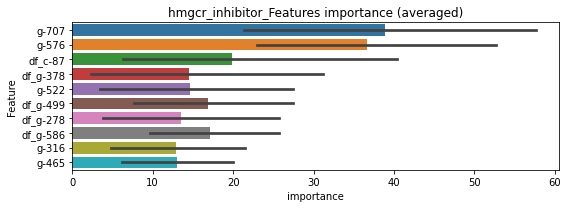

len(train_index) : 2195
len(valid_index) : 2195
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102656	valid_1's binary_logloss: 0.0809618


len(train_index) : 2195
len(valid_index) : 2195
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00914726	valid_1's binary_logloss: 0.0805572
Training until validation scores don't improve for 10 rounds


hmgcr_inhibitor logloss: 0.08557412540435753
hsp_inhibitor , len(trt) : 93


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.0230038	valid_1's binary_logloss: 0.0905911
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141736	valid_1's binary_logloss: 0.328693
[200]	training's binary_logloss: 0.0404623	valid_1's binary_logloss: 0.228103
[300]	training's binary_logloss: 0.0148613	valid_1's binary_logloss: 0.190129
[400]	training's binary_logloss: 0.00726909	valid_1's binary_logloss: 0.174707
[500]	training's binary_logloss: 0.00447199	valid_1's binary_logloss: 0.166386
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00423417	valid_1's binary_logloss: 0.1641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142105	valid_1's binary_logloss: 0.339895
[200]	training's binary_logloss: 0.0400325	valid_1's binary_logloss: 0.24676
[300]	training's binary_logloss: 0.0142471	valid_1's binary_logloss: 0.21223
[400]	training's binary_logloss: 0.00690239	valid_1's binary_logloss: 0.197053
Early stopping, best iteration is:
[406]	training's binary_loglos

1 / 3 AUC score:0.974
Threshold: 0.43599361098765155
Remove_noisy_labels: 62 → positive_corect_labels: 469/938
30th percentile: 0.04644
p_label_rate: 0.05751 Vs.target_rate: 0.00393, Num_p_label: 229.0, conf_0:0.04644, conf_1:0.56616
Num_p_label: 229.0, Expected: 15.7, Adj_threshold_1: 0.44
Num_p_label: 180.0, Expected: 15.7, Adj_threshold_2: 0.48
Num_p_label: 143.0, Expected: 15.7, Adj_threshold_3: 0.52
Num_p_label: 112.0, Expected: 15.7, Adj_threshold_4: 0.56
Num_p_label: 86.0, Expected: 15.7, Adj_threshold_5: 0.60
Num_p_label: 61.0, Expected: 15.7, Adj_threshold_6: 0.64
Num_p_label: 48.0, Expected: 15.7, Adj_threshold_7: 0.68
Num_p_label: 32.0, Expected: 15.7, Adj_threshold_8: 0.72
Num_p_label: 23.0, Expected: 15.7, Adj_threshold_9: 0.76
threshold:0.76, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:469.0/938, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127999	valid_1's binary_logloss: 0.320052
[200]	training's binary_logloss: 0.0342012	valid_1's binary_logloss: 0.227496
[300]	training's binary_logloss: 0.0121932	valid_1's binary_logloss: 0.192824
[400]	training's binary_logloss: 0.00599263	valid_1's binary_logloss: 0.180617
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00582944	valid_1's binary_logloss: 0.180186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134343	valid_1's binary_logloss: 0.280776
[200]	training's binary_logloss: 0.0374743	valid_1's binary_logloss: 0.175092
[300]	training's binary_logloss: 0.0133993	valid_1's binary_logloss: 0.131594
[400]	training's binary_logloss: 0.00653967	valid_1's binary_logloss: 0.114577
[500]	training's binary_logloss: 0.00407357	valid_1's binary_logloss: 0.105957
[600]	training's binary_logloss: 0.00300798	valid_1's binary_

2 / 3 AUC score:0.987
Threshold: 0.7559936109876517
Remove_noisy_labels: 55 → positive_corect_labels: 422.0/883
30th percentile: 0.02898
p_label_rate: 0.02009 Vs.target_rate: 0.00393, Num_p_label: 80.0, conf_0:0.02083, conf_1:0.75599
Num_p_label: 80.0, Expected: 15.7, Adj_threshold_1: 0.76
Num_p_label: 61.0, Expected: 15.7, Adj_threshold_2: 0.80
Num_p_label: 43.0, Expected: 15.7, Adj_threshold_3: 0.84
Num_p_label: 26.0, Expected: 15.7, Adj_threshold_4: 0.88
Num_p_label: 14.0, Expected: 15.7, Adj_threshold_5: 0.92
threshold:0.92, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:422.0/883, y_label_rate: 0.47792
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121843	valid_1's binary_logloss: 0.267463
[200]	training's binary_logloss: 0.0322512	valid_1's binary_logloss: 0.166026
[300]	training's binary_logloss: 0.011328	valid_1's binary_logloss: 0.134389
[400]	training's binary_logloss: 0.00556058	valid_1's binary_logloss: 0.119744
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00376671	valid_1's binary_logloss: 0.113442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122653	valid_1's binary_logloss: 0.256581
[200]	training's binary_logloss: 0.0325997	valid_1's binary_logloss: 0.15766
[300]	training's binary_logloss: 0.0116526	valid_1's binary_logloss: 0.124311
[400]	training's binary_logloss: 0.00581964	valid_1's binary_logloss: 0.112339
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0048738	valid_1's binary_logloss: 0.109668


3 / 3 AUC score:0.994
Threshold: 0.9159936109876519
Remove_noisy_labels: 60 → positive_corect_labels: 363.0/823
30th percentile: 0.02125
p_label_rate: 0.00502 Vs.target_rate: 0.00393, Num_p_label: 20.0, conf_0:0.01496, conf_1:0.91599
threshold:0.92, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:383.0/4805, y_label_rate: 0.07971


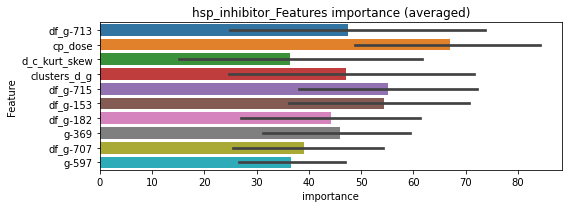

len(train_index) : 2402
len(valid_index) : 2403
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289887	valid_1's binary_logloss: 0.0821543
[200]	training's binary_logloss: 0.00583871	valid_1's binary_logloss: 0.0590057
[300]	training's binary_logloss: 0.00175937	valid_1's binary_logloss: 0.0547812
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00183837	valid_1's binary_logloss: 0.0544904


len(train_index) : 2403
len(valid_index) : 2402
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278939	valid_1's binary_logloss: 0.0675381
[200]	training's binary_logloss: 0.00529555	valid_1's binary_logloss: 0.0383525
[300]	training's binary_logloss: 0.00161083	valid_1's binary_logloss: 0.0311727
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.0301471


hsp_inhibitor logloss: 0.042321301763562615
igf-1_inhibitor , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995288	valid_1's binary_logloss: 0.209003
[200]	training's binary_logloss: 0.0219587	valid_1's binary_logloss: 0.110779
[300]	training's binary_logloss: 0.00715589	valid_1's binary_logloss: 0.0792678
[400]	training's binary_logloss: 0.00358222	valid_1's binary_logloss: 0.0690883
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00377457	valid_1's binary_logloss: 0.0689414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956675	valid_1's binary_logloss: 0.193242
[200]	training's binary_logloss: 0.0202521	valid_1's binary_logloss: 0.0925205
[300]	training's binary_logloss: 0.00677342	valid_1's binary_logloss: 0.0614227
[400]	training's binary_logloss: 0.00348688	valid_1's binary_logloss: 0.0502557
[500]	training's binary_logloss: 0.00235929	valid_1's binary_logloss: 0.0458063
[600]	training's binary_logloss: 0.00189678	valid_

1 / 3 AUC score:0.998
Threshold: 0.2698318080004778
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentile: 0.01082
p_label_rate: 0.01507 Vs.target_rate: 0.00165, Num_p_label: 60.0, conf_0:0.01082, conf_1:0.32860
Num_p_label: 60.0, Expected: 6.6, Adj_threshold_1: 0.27
Num_p_label: 41.0, Expected: 6.6, Adj_threshold_2: 0.31
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_3: 0.35
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_4: 0.39
Num_p_label: 6.0, Expected: 6.6, Adj_threshold_5: 0.43
threshold:0.43, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980418	valid_1's binary_logloss: 0.187176
[200]	training's binary_logloss: 0.0214344	valid_1's binary_logloss: 0.0745316
[300]	training's binary_logloss: 0.00698553	valid_1's binary_logloss: 0.0424483
[400]	training's binary_logloss: 0.00356369	valid_1's binary_logloss: 0.0310328
[500]	training's binary_logloss: 0.00236243	valid_1's binary_logloss: 0.0256291
[600]	training's binary_logloss: 0.00191485	valid_1's binary_logloss: 0.0227221
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00183184	valid_1's binary_logloss: 0.0222359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954549	valid_1's binary_logloss: 0.176788
[200]	training's binary_logloss: 0.0208444	valid_1's binary_logloss: 0.0723279
[300]	training's binary_logloss: 0.00690707	valid_1's binary_logloss: 0.0425443
[400]	training's binary_logloss: 0.00355054	valid

2 / 3 AUC score:1.000
Threshold: 0.4298318080004777
Remove_noisy_labels: 2 → positive_corect_labels: 491.0/980
30th percentile: 0.00678
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00678, conf_1:0.44899
threshold:0.43, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:491.0/980, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969861	valid_1's binary_logloss: 0.189005
[200]	training's binary_logloss: 0.0209391	valid_1's binary_logloss: 0.077897
[300]	training's binary_logloss: 0.00692121	valid_1's binary_logloss: 0.0460858
[400]	training's binary_logloss: 0.00350198	valid_1's binary_logloss: 0.0349478
[500]	training's binary_logloss: 0.00234517	valid_1's binary_logloss: 0.0289167
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00193589	valid_1's binary_logloss: 0.026935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961688	valid_1's binary_logloss: 0.175685
[200]	training's binary_logloss: 0.0209726	valid_1's binary_logloss: 0.0729922
[300]	training's binary_logloss: 0.00700998	valid_1's binary_logloss: 0.042381
[400]	training's binary_logloss: 0.00355949	valid_1's binary_logloss: 0.0300244
[500]	training's binary_logloss: 0.00237498	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.4298318080004777
Remove_noisy_labels: 3 → positive_corect_labels: 491.0/977
30th percentile: 0.00709
p_label_rate: 0.00377 Vs.target_rate: 0.00165, Num_p_label: 15.0, conf_0:0.00709, conf_1:0.49445
threshold:0.43, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:506.0/4959, y_label_rate: 0.10204


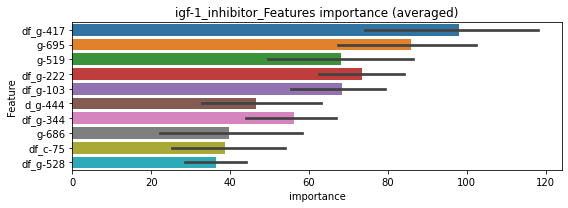

len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265931	valid_1's binary_logloss: 0.0498222
[200]	training's binary_logloss: 0.0041298	valid_1's binary_logloss: 0.0232483
[300]	training's binary_logloss: 0.00119922	valid_1's binary_logloss: 0.0195188
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00104407	valid_1's binary_logloss: 0.0194469


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264343	valid_1's binary_logloss: 0.0515017
[200]	training's binary_logloss: 0.00442798	valid_1's binary_logloss: 0.024734
[300]	training's binary_logloss: 0.00124416	valid_1's binary_logloss: 0.019326
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000825934	valid_1's binary_logloss: 0.0187715


igf-1_inhibitor logloss: 0.01910926113165931
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07949	valid_1's binary_logloss: 0.152243
[200]	training's binary_logloss: 0.0151579	valid_1's binary_logloss: 0.0680469
[300]	training's binary_logloss: 0.00481471	valid_1's binary_logloss: 0.0478033
[400]	training's binary_logloss: 0.00253061	valid_1's binary_logloss: 0.0414822
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00196462	valid_1's binary_logloss: 0.0394261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799181	valid_1's binary_logloss: 0.156296
[200]	training's binary_logloss: 0.0153218	valid_1's binary_logloss: 0.0627693
[300]	training's binary_logloss: 0.00489832	valid_1's binary_logloss: 0.0341484
[400]	training's binary_logloss: 0.00254792	valid_1's binary_logloss: 0.0251417
[500]	training's binary_logloss: 0.00178464	valid_1's binary_logloss: 0.0220777
Early stopping, best iteration is:
[574]	training's

1 / 3 AUC score:1.000
Threshold: 0.4286714777900627
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00328
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00328, conf_1:0.42867
threshold:0.43, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797112	valid_1's binary_logloss: 0.141967
[200]	training's binary_logloss: 0.015058	valid_1's binary_logloss: 0.0571432
[300]	training's binary_logloss: 0.0047805	valid_1's binary_logloss: 0.0352243
[400]	training's binary_logloss: 0.00250966	valid_1's binary_logloss: 0.0285853
[500]	training's binary_logloss: 0.00173297	valid_1's binary_logloss: 0.0251654
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00153915	valid_1's binary_logloss: 0.0233985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791258	valid_1's binary_logloss: 0.15107
[200]	training's binary_logloss: 0.0145916	valid_1's binary_logloss: 0.0622625
[300]	training's binary_logloss: 0.00474038	valid_1's binary_logloss: 0.0370792
[400]	training's binary_logloss: 0.00250238	valid_1's binary_logloss: 0.0289142
[500]	training's binary_logloss: 0.00173591	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.4286714777900627
Remove_noisy_labels: 5 → positive_corect_labels: 497.0/989
30th percentile: 0.00285
p_label_rate: 0.00477 Vs.target_rate: 0.00135, Num_p_label: 19.0, conf_0:0.00285, conf_1:0.47507
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_1: 0.43
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_2: 0.47
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_3: 0.51
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_4: 0.55
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/989, y_label_rate: 0.50253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081225	valid_1's binary_logloss: 0.145241
[200]	training's binary_logloss: 0.0151168	valid_1's binary_logloss: 0.0553185
[300]	training's binary_logloss: 0.00481217	valid_1's binary_logloss: 0.0332362
[400]	training's binary_logloss: 0.00249671	valid_1's binary_logloss: 0.0256637
[500]	training's binary_logloss: 0.0017441	valid_1's binary_logloss: 0.0224093
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0016294	valid_1's binary_logloss: 0.0213868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808669	valid_1's binary_logloss: 0.149299
[200]	training's binary_logloss: 0.0151633	valid_1's binary_logloss: 0.0571776
[300]	training's binary_logloss: 0.0048403	valid_1's binary_logloss: 0.0329716
[400]	training's binary_logloss: 0.0025061	valid_1's binary_logloss: 0.0240172
[500]	training's binary_logloss: 0.00174506	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.5886714777900628
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/988
30th percentile: 0.00302
p_label_rate: 0.00151 Vs.target_rate: 0.00135, Num_p_label: 6.0, conf_0:0.00302, conf_1:0.58867
threshold:0.59, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:502.0/4970, y_label_rate: 0.10101


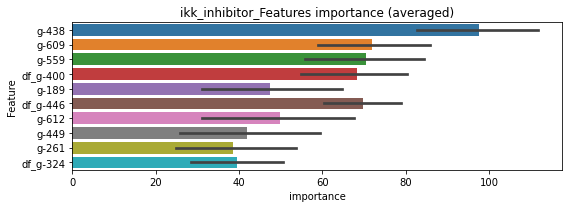

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204251	valid_1's binary_logloss: 0.0387792
[200]	training's binary_logloss: 0.00286521	valid_1's binary_logloss: 0.0145418
[300]	training's binary_logloss: 0.000825569	valid_1's binary_logloss: 0.0103927
[400]	training's binary_logloss: 0.000424419	valid_1's binary_logloss: 0.00960797
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000428246	valid_1's binary_logloss: 0.00960112


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200822	valid_1's binary_logloss: 0.0390489
[200]	training's binary_logloss: 0.00280393	valid_1's binary_logloss: 0.0128373
[300]	training's binary_logloss: 0.000828256	valid_1's binary_logloss: 0.00841007
[400]	training's binary_logloss: 0.000426977	valid_1's binary_logloss: 0.00715219
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000322156	valid_1's binary_logloss: 0.00679109


ikk_inhibitor logloss: 0.008196102939295027
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850775	valid_1's binary_logloss: 0.154462
[200]	training's binary_logloss: 0.0174253	valid_1's binary_logloss: 0.0643366
[300]	training's binary_logloss: 0.00567701	valid_1's binary_logloss: 0.0385381
[400]	training's binary_logloss: 0.00293602	valid_1's binary_logloss: 0.0291194
[500]	training's binary_logloss: 0.00200806	valid_1's binary_logloss: 0.0252542
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00173374	valid_1's binary_logloss: 0.0237204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830217	valid_1's binary_logloss: 0.154006
[200]	training's binary_logloss: 0.0165862	valid_1's binary_logloss: 0.0599147
[300]	training's binary_logloss: 0.00540089	valid_1's binary_logloss: 0.0344082
[400]	training's binary_logloss: 0.00279817	valid_1's binary_logloss: 0.0261936
[500]	training's binary_logloss: 0.00193616	valid

1 / 3 AUC score:1.000
Threshold: 0.3659342663801518
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00369
p_label_rate: 0.00352 Vs.target_rate: 0.00139, Num_p_label: 14.0, conf_0:0.00369, conf_1:0.48938
threshold:0.37, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830231	valid_1's binary_logloss: 0.151442
[200]	training's binary_logloss: 0.0166842	valid_1's binary_logloss: 0.0650617
[300]	training's binary_logloss: 0.00555244	valid_1's binary_logloss: 0.0382265
[400]	training's binary_logloss: 0.00285983	valid_1's binary_logloss: 0.0296748
[500]	training's binary_logloss: 0.0019668	valid_1's binary_logloss: 0.0256424
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00167241	valid_1's binary_logloss: 0.0238898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845039	valid_1's binary_logloss: 0.154681
[200]	training's binary_logloss: 0.0167983	valid_1's binary_logloss: 0.0659163
[300]	training's binary_logloss: 0.00547007	valid_1's binary_logloss: 0.0398863
[400]	training's binary_logloss: 0.00285232	valid_1's binary_logloss: 0.0307835
[500]	training's binary_logloss: 0.00196903	valid_

2 / 3 AUC score:1.000
Threshold: 0.3659342663801518
Remove_noisy_labels: 8 → positive_corect_labels: 497.0/988
30th percentile: 0.00354
p_label_rate: 0.00678 Vs.target_rate: 0.00139, Num_p_label: 27.0, conf_0:0.00354, conf_1:0.52919
Num_p_label: 27.0, Expected: 5.5, Adj_threshold_1: 0.37
Num_p_label: 19.0, Expected: 5.5, Adj_threshold_2: 0.41
Num_p_label: 17.0, Expected: 5.5, Adj_threshold_3: 0.45
Num_p_label: 14.0, Expected: 5.5, Adj_threshold_4: 0.49
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_5: 0.53
Num_p_label: 7.0, Expected: 5.5, Adj_threshold_6: 0.57
threshold:0.57, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/988, y_label_rate: 0.50304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081666	valid_1's binary_logloss: 0.151852
[200]	training's binary_logloss: 0.0166766	valid_1's binary_logloss: 0.0605984
[300]	training's binary_logloss: 0.00543726	valid_1's binary_logloss: 0.037259
[400]	training's binary_logloss: 0.00284744	valid_1's binary_logloss: 0.0271068
[500]	training's binary_logloss: 0.00198061	valid_1's binary_logloss: 0.0224709
[600]	training's binary_logloss: 0.00166535	valid_1's binary_logloss: 0.020168
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.00164842	valid_1's binary_logloss: 0.0200889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836046	valid_1's binary_logloss: 0.150925
[200]	training's binary_logloss: 0.0164412	valid_1's binary_logloss: 0.0589782
[300]	training's binary_logloss: 0.00528481	valid_1's binary_logloss: 0.0347758
[400]	training's binary_logloss: 0.0027462	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5659342663801518
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/987
30th percentile: 0.00392
p_label_rate: 0.00452 Vs.target_rate: 0.00139, Num_p_label: 18.0, conf_0:0.00392, conf_1:0.56593
Num_p_label: 18.0, Expected: 5.5, Adj_threshold_1: 0.57
Num_p_label: 17.0, Expected: 5.5, Adj_threshold_2: 0.61
Num_p_label: 13.0, Expected: 5.5, Adj_threshold_3: 0.65
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_4: 0.69
Num_p_label: 8.0, Expected: 5.5, Adj_threshold_5: 0.73
threshold:0.73, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:504.0/4969, y_label_rate: 0.10143


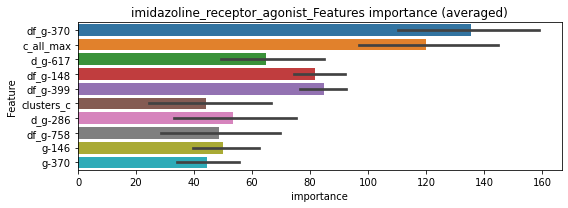

len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206367	valid_1's binary_logloss: 0.0373963
[200]	training's binary_logloss: 0.00295489	valid_1's binary_logloss: 0.016418
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00110203	valid_1's binary_logloss: 0.0136992


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212722	valid_1's binary_logloss: 0.0463907
[200]	training's binary_logloss: 0.00305492	valid_1's binary_logloss: 0.019478
[300]	training's binary_logloss: 0.000893843	valid_1's binary_logloss: 0.0132362
[400]	training's binary_logloss: 0.000460174	valid_1's binary_logloss: 0.0111151
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000365513	valid_1's binary_logloss: 0.0103549


imidazoline_receptor_agonist logloss: 0.012027361745232843
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125231	valid_1's binary_logloss: 0.27776
[200]	training's binary_logloss: 0.0340418	valid_1's binary_logloss: 0.1815
[300]	training's binary_logloss: 0.0119653	valid_1's binary_logloss: 0.141718
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00698628	valid_1's binary_logloss: 0.13086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12278	valid_1's binary_logloss: 0.284537
[200]	training's binary_logloss: 0.0329518	valid_1's binary_logloss: 0.183205
[300]	training's binary_logloss: 0.0115105	valid_1's binary_logloss: 0.140345
[400]	training's binary_logloss: 0.00564352	valid_1's binary_logloss: 0.124072
[500]	training's binary_logloss: 0.00357016	valid_1's binary_logloss: 0.114265
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00350728	valid_1's binary_logloss: 0.113619


1 / 3 AUC score:0.991
Threshold: 0.4127853564736641
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentile: 0.03593
p_label_rate: 0.01557 Vs.target_rate: 0.00315, Num_p_label: 62.0, conf_0:0.03593, conf_1:0.42773
Num_p_label: 62.0, Expected: 12.5, Adj_threshold_1: 0.41
Num_p_label: 41.0, Expected: 12.5, Adj_threshold_2: 0.45
Num_p_label: 26.0, Expected: 12.5, Adj_threshold_3: 0.49
Num_p_label: 16.0, Expected: 12.5, Adj_threshold_4: 0.53
threshold:0.53, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119963	valid_1's binary_logloss: 0.258986
[200]	training's binary_logloss: 0.030696	valid_1's binary_logloss: 0.149288
[300]	training's binary_logloss: 0.0108614	valid_1's binary_logloss: 0.110839
[400]	training's binary_logloss: 0.00543701	valid_1's binary_logloss: 0.0968766
[500]	training's binary_logloss: 0.00349326	valid_1's binary_logloss: 0.0898596
[600]	training's binary_logloss: 0.00262656	valid_1's binary_logloss: 0.0853622
[700]	training's binary_logloss: 0.00221514	valid_1's binary_logloss: 0.0832836
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00217473	valid_1's binary_logloss: 0.0827241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119554	valid_1's binary_logloss: 0.296633
[200]	training's binary_logloss: 0.0301269	valid_1's binary_logloss: 0.200497
[300]	training's binary_logloss: 0.0105872	valid_1's bin

2 / 3 AUC score:0.988
Threshold: 0.5327853564736641
Remove_noisy_labels: 32 → positive_corect_labels: 450.0/926
30th percentile: 0.02441
p_label_rate: 0.00578 Vs.target_rate: 0.00315, Num_p_label: 23.0, conf_0:0.02441, conf_1:0.53279
threshold:0.53, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:450.0/926, y_label_rate: 0.48596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116815	valid_1's binary_logloss: 0.241132
[200]	training's binary_logloss: 0.0300549	valid_1's binary_logloss: 0.13425
[300]	training's binary_logloss: 0.0105529	valid_1's binary_logloss: 0.0954838
[400]	training's binary_logloss: 0.0052351	valid_1's binary_logloss: 0.0790419
[500]	training's binary_logloss: 0.00335249	valid_1's binary_logloss: 0.0700057
[600]	training's binary_logloss: 0.0025315	valid_1's binary_logloss: 0.0668634
[700]	training's binary_logloss: 0.0021575	valid_1's binary_logloss: 0.0636301
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.0021575	valid_1's binary_logloss: 0.0636301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118114	valid_1's binary_logloss: 0.246279
[200]	training's binary_logloss: 0.0296347	valid_1's binary_logloss: 0.129949
[300]	training's binary_logloss: 0.0101964	valid_1's binary

3 / 3 AUC score:0.999
Threshold: 0.5327853564736641
Remove_noisy_labels: 11 → positive_corect_labels: 440.0/915
30th percentile: 0.01487
p_label_rate: 0.00276 Vs.target_rate: 0.00315, Num_p_label: 11.0, conf_0:0.01105, conf_1:0.53279
threshold:0.53, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:451.0/4897, y_label_rate: 0.09210


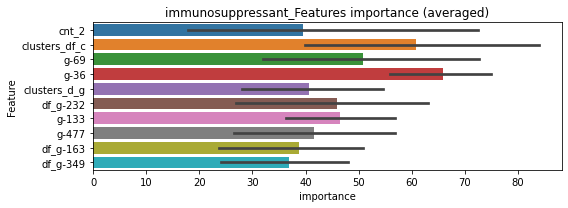

len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251531	valid_1's binary_logloss: 0.0770879
[200]	training's binary_logloss: 0.00429277	valid_1's binary_logloss: 0.055912
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00220267	valid_1's binary_logloss: 0.0531331


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286551	valid_1's binary_logloss: 0.071334
[200]	training's binary_logloss: 0.00561154	valid_1's binary_logloss: 0.0447017
[300]	training's binary_logloss: 0.0016241	valid_1's binary_logloss: 0.0372679
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00105288	valid_1's binary_logloss: 0.0357865


immunosuppressant logloss: 0.044461563328255516
insulin_secretagogue , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834813	valid_1's binary_logloss: 0.150599
[200]	training's binary_logloss: 0.0168945	valid_1's binary_logloss: 0.0667072
[300]	training's binary_logloss: 0.00550595	valid_1's binary_logloss: 0.0425546
[400]	training's binary_logloss: 0.00279972	valid_1's binary_logloss: 0.0321228
[500]	training's binary_logloss: 0.0019205	valid_1's binary_logloss: 0.0281532
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00168716	valid_1's binary_logloss: 0.0267897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857892	valid_1's binary_logloss: 0.153762
[200]	training's binary_logloss: 0.0178402	valid_1's binary_logloss: 0.0642557
[300]	training's binary_logloss: 0.00576186	valid_1's binary_logloss: 0.0423623
[400]	training's binary_logloss: 0.00293512	valid_1's binary_logloss: 0.0336277
[500]	training's binary_logloss: 0.00200708	valid_

1 / 3 AUC score:1.000
Threshold: 0.22869479253638286
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00471
p_label_rate: 0.00552 Vs.target_rate: 0.00135, Num_p_label: 22.0, conf_0:0.00471, conf_1:0.31859
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_1: 0.23
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_2: 0.27
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_3: 0.31
threshold:0.31, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824841	valid_1's binary_logloss: 0.146946
[200]	training's binary_logloss: 0.0165361	valid_1's binary_logloss: 0.0554824
[300]	training's binary_logloss: 0.00539954	valid_1's binary_logloss: 0.029431
[400]	training's binary_logloss: 0.00285144	valid_1's binary_logloss: 0.0210225
[500]	training's binary_logloss: 0.00195894	valid_1's binary_logloss: 0.0169874
[600]	training's binary_logloss: 0.00165239	valid_1's binary_logloss: 0.0155454
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00163236	valid_1's binary_logloss: 0.0153769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862406	valid_1's binary_logloss: 0.152347
[200]	training's binary_logloss: 0.0170649	valid_1's binary_logloss: 0.0553601
[300]	training's binary_logloss: 0.00559698	valid_1's binary_logloss: 0.0306559
[400]	training's binary_logloss: 0.00289353	valid_

2 / 3 AUC score:1.000
Threshold: 0.3086947925363828
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/992
30th percentile: 0.00449
p_label_rate: 0.00176 Vs.target_rate: 0.00135, Num_p_label: 7.0, conf_0:0.00449, conf_1:0.35646
threshold:0.31, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08441	valid_1's binary_logloss: 0.147649
[200]	training's binary_logloss: 0.0172145	valid_1's binary_logloss: 0.0537468
[300]	training's binary_logloss: 0.005531	valid_1's binary_logloss: 0.0282666
[400]	training's binary_logloss: 0.00287795	valid_1's binary_logloss: 0.0201076
[500]	training's binary_logloss: 0.00198783	valid_1's binary_logloss: 0.0164933
[600]	training's binary_logloss: 0.00170716	valid_1's binary_logloss: 0.0150911
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.0017088	valid_1's binary_logloss: 0.0150738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837874	valid_1's binary_logloss: 0.155579
[200]	training's binary_logloss: 0.0167618	valid_1's binary_logloss: 0.0614604
[300]	training's binary_logloss: 0.00545496	valid_1's binary_logloss: 0.0362393
[400]	training's binary_logloss: 0.00282189	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.3086947925363828
Remove_noisy_labels: 4 → positive_corect_labels: 497.0/988
30th percentile: 0.00444
p_label_rate: 0.00201 Vs.target_rate: 0.00135, Num_p_label: 8.0, conf_0:0.00444, conf_1:0.36049
threshold:0.31, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:505.0/4970, y_label_rate: 0.10161


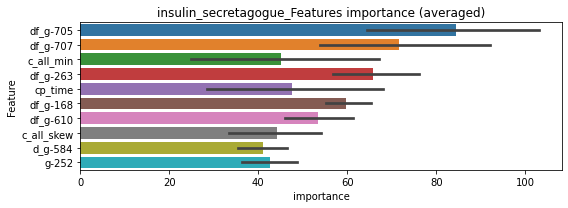

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213707	valid_1's binary_logloss: 0.0405012
[200]	training's binary_logloss: 0.00315364	valid_1's binary_logloss: 0.0185918
[300]	training's binary_logloss: 0.000914345	valid_1's binary_logloss: 0.0153404
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000914345	valid_1's binary_logloss: 0.0153404


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213436	valid_1's binary_logloss: 0.0364693
[200]	training's binary_logloss: 0.00312425	valid_1's binary_logloss: 0.0124036
[300]	training's binary_logloss: 0.000928916	valid_1's binary_logloss: 0.00849519
[400]	training's binary_logloss: 0.000478045	valid_1's binary_logloss: 0.00758319
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000373263	valid_1's binary_logloss: 0.00735014


insulin_secretagogue logloss: 0.01134525560606832
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111086	valid_1's binary_logloss: 0.216611
[200]	training's binary_logloss: 0.0255261	valid_1's binary_logloss: 0.112574
[300]	training's binary_logloss: 0.00853848	valid_1's binary_logloss: 0.077959
[400]	training's binary_logloss: 0.00418579	valid_1's binary_logloss: 0.0626114
[500]	training's binary_logloss: 0.00270514	valid_1's binary_logloss: 0.0564841
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00216166	valid_1's binary_logloss: 0.0529086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106799	valid_1's binary_logloss: 0.200224
[200]	training's binary_logloss: 0.0249771	valid_1's binary_logloss: 0.102459
[300]	training's binary_logloss: 0.00834299	valid_1's binary_logloss: 0.070756
[400]	training's binary_logloss: 0.0041441	valid_1's binary_logloss: 0.0588981
[500]	training's binary_logloss: 0.00270917	valid_1's bi

1 / 3 AUC score:0.998
Threshold: 0.5216455387138064
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.00993
p_label_rate: 0.00678 Vs.target_rate: 0.00225, Num_p_label: 27.0, conf_0:0.00963, conf_1:0.55083
Num_p_label: 27.0, Expected: 8.9, Adj_threshold_1: 0.52
Num_p_label: 20.0, Expected: 8.9, Adj_threshold_2: 0.56
Num_p_label: 16.0, Expected: 8.9, Adj_threshold_3: 0.60
Num_p_label: 9.0, Expected: 8.9, Adj_threshold_4: 0.64
threshold:0.64, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100699	valid_1's binary_logloss: 0.237423
[200]	training's binary_logloss: 0.0222603	valid_1's binary_logloss: 0.13335
[300]	training's binary_logloss: 0.00738606	valid_1's binary_logloss: 0.0979493
[400]	training's binary_logloss: 0.00373146	valid_1's binary_logloss: 0.0837854
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00344879	valid_1's binary_logloss: 0.0826539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106579	valid_1's binary_logloss: 0.19242
[200]	training's binary_logloss: 0.0244946	valid_1's binary_logloss: 0.08922
[300]	training's binary_logloss: 0.00829313	valid_1's binary_logloss: 0.0544794
[400]	training's binary_logloss: 0.00411807	valid_1's binary_logloss: 0.04129
[500]	training's binary_logloss: 0.00270103	valid_1's binary_logloss: 0.0359418
[600]	training's binary_logloss: 0.00208018	valid_1's bina

2 / 3 AUC score:0.999
Threshold: 0.6416455387138065
Remove_noisy_labels: 14 → positive_corect_labels: 480.0/972
30th percentile: 0.01126
p_label_rate: 0.00377 Vs.target_rate: 0.00225, Num_p_label: 15.0, conf_0:0.01126, conf_1:0.64165
threshold:0.64, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:480.0/972, y_label_rate: 0.49383
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104585	valid_1's binary_logloss: 0.187963
[200]	training's binary_logloss: 0.0241284	valid_1's binary_logloss: 0.0835179
[300]	training's binary_logloss: 0.00816248	valid_1's binary_logloss: 0.0521714
[400]	training's binary_logloss: 0.00407554	valid_1's binary_logloss: 0.039049
[500]	training's binary_logloss: 0.00267669	valid_1's binary_logloss: 0.0333264
[600]	training's binary_logloss: 0.00207228	valid_1's binary_logloss: 0.0298838
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00191441	valid_1's binary_logloss: 0.0290152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10048	valid_1's binary_logloss: 0.210418
[200]	training's binary_logloss: 0.0228918	valid_1's binary_logloss: 0.108607
[300]	training's binary_logloss: 0.00755663	valid_1's binary_logloss: 0.0726552
[400]	training's binary_logloss: 0.00371551	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.6416455387138065
Remove_noisy_labels: 8 → positive_corect_labels: 472.0/964
30th percentile: 0.00791
p_label_rate: 0.00226 Vs.target_rate: 0.00225, Num_p_label: 9.0, conf_0:0.00791, conf_1:0.64165
threshold:0.64, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:481.0/4946, y_label_rate: 0.09725


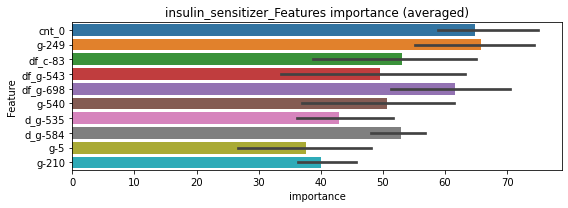

len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279524	valid_1's binary_logloss: 0.0526952
[200]	training's binary_logloss: 0.00488908	valid_1's binary_logloss: 0.0244106
[300]	training's binary_logloss: 0.00137157	valid_1's binary_logloss: 0.0182558
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000728094	valid_1's binary_logloss: 0.0173487


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274798	valid_1's binary_logloss: 0.0605533
[200]	training's binary_logloss: 0.00459691	valid_1's binary_logloss: 0.0304695
[300]	training's binary_logloss: 0.00129071	valid_1's binary_logloss: 0.0220241
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000838067	valid_1's binary_logloss: 0.0208465


insulin_sensitizer logloss: 0.0190975994461843
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945565	valid_1's binary_logloss: 0.19064
[200]	training's binary_logloss: 0.020417	valid_1's binary_logloss: 0.0935176
[300]	training's binary_logloss: 0.00692776	valid_1's binary_logloss: 0.0639725
[400]	training's binary_logloss: 0.00345547	valid_1's binary_logloss: 0.0515896
[500]	training's binary_logloss: 0.00231156	valid_1's binary_logloss: 0.0456468
[600]	training's binary_logloss: 0.00183943	valid_1's binary_logloss: 0.0430132
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.00174017	valid_1's binary_logloss: 0.0419114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923813	valid_1's binary_logloss: 0.176909
[200]	training's binary_logloss: 0.0200284	valid_1's binary_logloss: 0.0797914
[300]	training's binary_logloss: 0.00672041	valid_1's binary_logloss: 0.0502637
[400]	training's binary_logloss: 0.00342794	valid_1

1 / 3 AUC score:1.000
Threshold: 0.4557978243583829
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00595
p_label_rate: 0.00653 Vs.target_rate: 0.00187, Num_p_label: 26.0, conf_0:0.00497, conf_1:0.52503
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_1: 0.46
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_2: 0.50
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_3: 0.54
Num_p_label: 5.0, Expected: 7.4, Adj_threshold_4: 0.58
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893808	valid_1's binary_logloss: 0.177556
[200]	training's binary_logloss: 0.0191304	valid_1's binary_logloss: 0.0858312
[300]	training's binary_logloss: 0.006397	valid_1's binary_logloss: 0.0634179
[400]	training's binary_logloss: 0.00330344	valid_1's binary_logloss: 0.0549305
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00330344	valid_1's binary_logloss: 0.0549305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909928	valid_1's binary_logloss: 0.187908
[200]	training's binary_logloss: 0.019465	valid_1's binary_logloss: 0.0932652
[300]	training's binary_logloss: 0.00665588	valid_1's binary_logloss: 0.0621204
[400]	training's binary_logloss: 0.00343133	valid_1's binary_logloss: 0.0514699
[500]	training's binary_logloss: 0.00229633	valid_1's binary_logloss: 0.04628
Early stopping, best iteration is:
[570]	training's bi

2 / 3 AUC score:0.998
Threshold: 0.5757978243583829
Remove_noisy_labels: 15 → positive_corect_labels: 483.0/975
30th percentile: 0.00680
p_label_rate: 0.00427 Vs.target_rate: 0.00187, Num_p_label: 17.0, conf_0:0.00680, conf_1:0.57580
threshold:0.58, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:483.0/975, y_label_rate: 0.49538
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869572	valid_1's binary_logloss: 0.179775
[200]	training's binary_logloss: 0.0182452	valid_1's binary_logloss: 0.0901624
[300]	training's binary_logloss: 0.00605268	valid_1's binary_logloss: 0.0610228
[400]	training's binary_logloss: 0.00312588	valid_1's binary_logloss: 0.0507421
[500]	training's binary_logloss: 0.00212724	valid_1's binary_logloss: 0.0458182
[600]	training's binary_logloss: 0.00173941	valid_1's binary_logloss: 0.042803
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00168588	valid_1's binary_logloss: 0.0423314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869816	valid_1's binary_logloss: 0.169279
[200]	training's binary_logloss: 0.0179298	valid_1's binary_logloss: 0.081557
[300]	training's binary_logloss: 0.00597823	valid_1's binary_logloss: 0.0564074
[400]	training's binary_logloss: 0.00310679	valid_1

3 / 3 AUC score:0.998
Threshold: 0.5757978243583829
Remove_noisy_labels: 12 → positive_corect_labels: 473.0/963
30th percentile: 0.00518
p_label_rate: 0.00301 Vs.target_rate: 0.00187, Num_p_label: 12.0, conf_0:0.00518, conf_1:0.57580
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:485.0/4945, y_label_rate: 0.09808


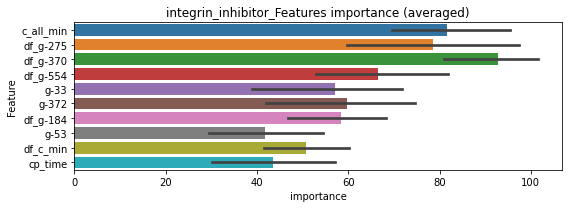

len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219741	valid_1's binary_logloss: 0.0511293
[200]	training's binary_logloss: 0.00352477	valid_1's binary_logloss: 0.0319269
[300]	training's binary_logloss: 0.00105911	valid_1's binary_logloss: 0.0287433
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00104093	valid_1's binary_logloss: 0.0287281


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214005	valid_1's binary_logloss: 0.05502
[200]	training's binary_logloss: 0.00325906	valid_1's binary_logloss: 0.0362519
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00131738	valid_1's binary_logloss: 0.0350122


integrin_inhibitor logloss: 0.031869474670567895
jak_inhibitor , len(trt) : 92


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143066	valid_1's binary_logloss: 0.336389
[200]	training's binary_logloss: 0.041352	valid_1's binary_logloss: 0.233004
[300]	training's binary_logloss: 0.0151989	valid_1's binary_logloss: 0.194541
[400]	training's binary_logloss: 0.0073893	valid_1's binary_logloss: 0.172625
[500]	training's binary_logloss: 0.00453303	valid_1's binary_logloss: 0.163618
[600]	training's binary_logloss: 0.00326508	valid_1's binary_logloss: 0.158829
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00277249	valid_1's binary_logloss: 0.156197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141004	valid_1's binary_logloss: 0.331328
[200]	training's binary_logloss: 0.0404676	valid_1's binary_logloss: 0.231375
[300]	training's binary_logloss: 0.0150329	valid_1's binary_logloss: 0.191526
[400]	training's binary_logloss: 0.00734932	valid_1's binary_lo

1 / 3 AUC score:0.983
Threshold: 0.43007625124557874
Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentile: 0.04591
p_label_rate: 0.03893 Vs.target_rate: 0.00389, Num_p_label: 155.0, conf_0:0.04591, conf_1:0.54175
Num_p_label: 155.0, Expected: 15.5, Adj_threshold_1: 0.43
Num_p_label: 113.0, Expected: 15.5, Adj_threshold_2: 0.47
Num_p_label: 85.0, Expected: 15.5, Adj_threshold_3: 0.51
Num_p_label: 67.0, Expected: 15.5, Adj_threshold_4: 0.55
Num_p_label: 49.0, Expected: 15.5, Adj_threshold_5: 0.59
Num_p_label: 38.0, Expected: 15.5, Adj_threshold_6: 0.63
Num_p_label: 29.0, Expected: 15.5, Adj_threshold_7: 0.67
Num_p_label: 17.0, Expected: 15.5, Adj_threshold_8: 0.71
threshold:0.71, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13092	valid_1's binary_logloss: 0.311049
[200]	training's binary_logloss: 0.0364613	valid_1's binary_logloss: 0.210517
[300]	training's binary_logloss: 0.0131336	valid_1's binary_logloss: 0.167793
[400]	training's binary_logloss: 0.00640164	valid_1's binary_logloss: 0.147591
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00604568	valid_1's binary_logloss: 0.146671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138683	valid_1's binary_logloss: 0.317535
[200]	training's binary_logloss: 0.0382679	valid_1's binary_logloss: 0.21244
[300]	training's binary_logloss: 0.0135977	valid_1's binary_logloss: 0.162264
[400]	training's binary_logloss: 0.00661959	valid_1's binary_logloss: 0.141031
[500]	training's binary_logloss: 0.00411378	valid_1's binary_logloss: 0.129451
[600]	training's binary_logloss: 0.00303807	valid_1's binary_lo

2 / 3 AUC score:0.990
Threshold: 0.7100762512455789
Remove_noisy_labels: 53 → positive_corect_labels: 421.0/889
30th percentile: 0.03978
p_label_rate: 0.01406 Vs.target_rate: 0.00389, Num_p_label: 56.0, conf_0:0.03978, conf_1:0.71008
Num_p_label: 56.0, Expected: 15.5, Adj_threshold_1: 0.71
Num_p_label: 47.0, Expected: 15.5, Adj_threshold_2: 0.75
Num_p_label: 36.0, Expected: 15.5, Adj_threshold_3: 0.79
Num_p_label: 27.0, Expected: 15.5, Adj_threshold_4: 0.83
Num_p_label: 18.0, Expected: 15.5, Adj_threshold_5: 0.87
threshold:0.87, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:421.0/889, y_label_rate: 0.47357
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13004	valid_1's binary_logloss: 0.280774
[200]	training's binary_logloss: 0.0348248	valid_1's binary_logloss: 0.165552
[300]	training's binary_logloss: 0.0124349	valid_1's binary_logloss: 0.121724
[400]	training's binary_logloss: 0.00613532	valid_1's binary_logloss: 0.102396
[500]	training's binary_logloss: 0.0038515	valid_1's binary_logloss: 0.0930731
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00331494	valid_1's binary_logloss: 0.089327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124454	valid_1's binary_logloss: 0.269991
[200]	training's binary_logloss: 0.0314848	valid_1's binary_logloss: 0.168435
[300]	training's binary_logloss: 0.0114769	valid_1's binary_logloss: 0.132999
[400]	training's binary_logloss: 0.00566339	valid_1's binary_logloss: 0.116889
[500]	training's binary_logloss: 0.0036428	valid_1's binary_lo

3 / 3 AUC score:0.993
Threshold: 0.8700762512455791
Remove_noisy_labels: 54 → positive_corect_labels: 367.0/835
30th percentile: 0.02243
p_label_rate: 0.00502 Vs.target_rate: 0.00389, Num_p_label: 20.0, conf_0:0.02243, conf_1:0.87008
threshold:0.87, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:387.0/4817, y_label_rate: 0.08034


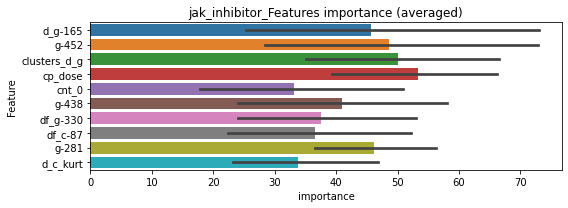

len(train_index) : 2408
len(valid_index) : 2409
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256796	valid_1's binary_logloss: 0.0701195
[200]	training's binary_logloss: 0.00491354	valid_1's binary_logloss: 0.0483615
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00259489	valid_1's binary_logloss: 0.0449992


len(train_index) : 2409
len(valid_index) : 2408
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256803	valid_1's binary_logloss: 0.0794645
[200]	training's binary_logloss: 0.0052754	valid_1's binary_logloss: 0.0549961
[300]	training's binary_logloss: 0.0016483	valid_1's binary_logloss: 0.0481104
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00128885	valid_1's binary_logloss: 0.0471425


jak_inhibitor logloss: 0.04607063101300263
kit_inhibitor , len(trt) : 273


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205321	valid_1's binary_logloss: 0.594621
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.128973	valid_1's binary_logloss: 0.582846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211208	valid_1's binary_logloss: 0.560908
[200]	training's binary_logloss: 0.0792465	valid_1's binary_logloss: 0.526634
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0786225	valid_1's binary_logloss: 0.526079


1 / 3 AUC score:0.770
Threshold: 0.49144511249997747
Remove_noisy_labels: 316 → positive_corect_labels: 342/684
30th percentile: 0.35720
p_label_rate: 0.26670 Vs.target_rate: 0.00948, Num_p_label: 1062.0, conf_0:0.35720, conf_1:0.49145
Num_p_label: 1062.0, Expected: 37.8, Adj_threshold_1: 0.49
Num_p_label: 671.0, Expected: 37.8, Adj_threshold_2: 0.53
Num_p_label: 402.0, Expected: 37.8, Adj_threshold_3: 0.57
Num_p_label: 192.0, Expected: 37.8, Adj_threshold_4: 0.61
Num_p_label: 95.0, Expected: 37.8, Adj_threshold_5: 0.65
Num_p_label: 34.0, Expected: 37.8, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:342.0/684, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176942	valid_1's binary_logloss: 0.483593
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.076537	valid_1's binary_logloss: 0.448153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178857	valid_1's binary_logloss: 0.478084
[200]	training's binary_logloss: 0.0612083	valid_1's binary_logloss: 0.410178


2 / 3 AUC score:0.889
Threshold: 0.6914451124999776
Remove_noisy_labels: 133 → positive_corect_labels: 224.0/551
30th percentile: 0.26377
p_label_rate: 0.07860 Vs.target_rate: 0.00948, Num_p_label: 313.0, conf_0:0.26377, conf_1:0.69145
Num_p_label: 313.0, Expected: 37.8, Adj_threshold_1: 0.69
Num_p_label: 194.0, Expected: 37.8, Adj_threshold_2: 0.73
Num_p_label: 115.0, Expected: 37.8, Adj_threshold_3: 0.77


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0347481	valid_1's binary_logloss: 0.390718


Num_p_label: 52.0, Expected: 37.8, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:224.0/551, y_label_rate: 0.40653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15162	valid_1's binary_logloss: 0.365131
[200]	training's binary_logloss: 0.0486337	valid_1's binary_logloss: 0.290702
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0221984	valid_1's binary_logloss: 0.267111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151585	valid_1's binary_logloss: 0.411816
[200]	training's binary_logloss: 0.0477349	valid_1's binary_logloss: 0.309008


3 / 3 AUC score:0.956
Threshold: 0.8114451124999777
Remove_noisy_labels: 88 → positive_corect_labels: 137.0/463
30th percentile: 0.11192
p_label_rate: 0.01080 Vs.target_rate: 0.00948, Num_p_label: 43.0, conf_0:0.11192, conf_1:0.81145
threshold:0.81, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0271913	valid_1's binary_logloss: 0.28747


positive y_label:180.0/4445, y_label_rate: 0.04049


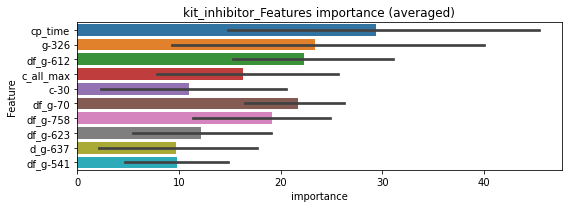

len(train_index) : 2222
len(valid_index) : 2223
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2223
len(valid_index) : 2222
================================= fold 2/2 kit_inhibitor=================================


[100]	training's binary_logloss: 0.0166412	valid_1's binary_logloss: 0.107158
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0197031	valid_1's binary_logloss: 0.106883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174249	valid_1's binary_logloss: 0.0957701


kit_inhibitor logloss: 0.09990170725677769


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0087816	valid_1's binary_logloss: 0.0929175
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    

laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369705	valid_1's binary_logloss: 0.0469405
[200]	training's binary_logloss: 0.00420473	valid_1's binary_logloss: 0.00823353
[300]	training's binary_logloss: 0.00134792	valid_1's binary_logloss: 0.00352073
[400]	training's binary_logloss: 0.000870775	valid_1's binary_logloss: 0.00257451
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000788129	valid_1's binary_logloss: 0.00238841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368589	valid_1's binary_logloss: 0.0486883
[200]	training's binary_logloss: 0.00422118	valid_1's binary_logloss: 0.00961637
[300]	training's binary_logloss: 0.00135466	valid_1's binary_logloss: 0.00454392
[400]	training's binary_logloss: 0.000863564	valid_1's binary_logloss: 0.00321264
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000790372	valid_1's binary_logloss: 0.0029992

1 / 3 AUC score:1.000
Threshold: 0.6190090930342698
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00060
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00060, conf_1:0.61901
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.50
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.46
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.42
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_7: 0.38
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369705	valid_1's binary_logloss: 0.0469405
[200]	training's binary_logloss: 0.00420473	valid_1's binary_logloss: 0.00823353
[300]	training's binary_logloss: 0.00134792	valid_1's binary_logloss: 0.00352073
[400]	training's binary_logloss: 0.000870775	valid_1's binary_logloss: 0.00257451
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000788129	valid_1's binary_logloss: 0.00238841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368589	valid_1's binary_logloss: 0.0486883
[200]	training's binary_logloss: 0.00422118	valid_1's binary_logloss: 0.00961637
[300]	training's binary_logloss: 0.00135466	valid_1's binary_logloss: 0.00454392
[400]	training's binary_logloss: 0.000863564	valid_1's binary_logloss: 0.00321264
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000790372	valid_1's binary_logloss: 0.0029992

2 / 3 AUC score:1.000
Threshold: 0.3790090930342698
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00060
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00060, conf_1:0.37901
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369705	valid_1's binary_logloss: 0.0469405
[200]	training's binary_logloss: 0.00420473	valid_1's binary_logloss: 0.00823353
[300]	training's binary_logloss: 0.00134792	valid_1's binary_logloss: 0.00352073
[400]	training's binary_logloss: 0.000870775	valid_1's binary_logloss: 0.00257451
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000788129	valid_1's binary_logloss: 0.00238841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368589	valid_1's binary_logloss: 0.0486883
[200]	training's binary_logloss: 0.00422118	valid_1's binary_logloss: 0.00961637
[300]	training's binary_logloss: 0.00135466	valid_1's binary_logloss: 0.00454392
[400]	training's binary_logloss: 0.000863564	valid_1's binary_logloss: 0.00321264
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000790372	valid_1's binary_logloss: 0.0029992

3 / 3 AUC score:1.000
Threshold: 0.3790090930342698
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00060
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00060, conf_1:0.37901
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


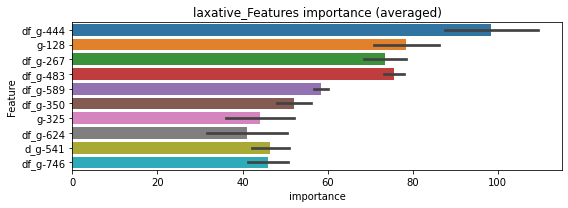

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102103	valid_1's binary_logloss: 0.0155403
[200]	training's binary_logloss: 0.000884846	valid_1's binary_logloss: 0.00603218
[300]	training's binary_logloss: 0.000249143	valid_1's binary_logloss: 0.00523654


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000224238	valid_1's binary_logloss: 0.00517352


================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103261	valid_1's binary_logloss: 0.011083
[200]	training's binary_logloss: 0.000919247	valid_1's binary_logloss: 0.0013104
[300]	training's binary_logloss: 0.00025784	valid_1's binary_logloss: 0.000428628
[400]	training's binary_logloss: 0.000159749	valid_1's binary_logloss: 0.000266416
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000146743	valid_1's binary_logloss: 0.000245367


laxative logloss: 0.0027094421407997883
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374038	valid_1's binary_logloss: 0.051513
[200]	training's binary_logloss: 0.00425706	valid_1's binary_logloss: 0.00973105
[300]	training's binary_logloss: 0.00134867	valid_1's binary_logloss: 0.00436541
[400]	training's binary_logloss: 0.000862799	valid_1's binary_logloss: 0.00306536
[500]	training's binary_logloss: 0.000761188	valid_1's binary_logloss: 0.00265909
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000761188	valid_1's binary_logloss: 0.00265909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037064	valid_1's binary_logloss: 0.0496551
[200]	training's binary_logloss: 0.00413939	valid_1's binary_logloss: 0.0102384
[300]	training's binary_logloss: 0.00134367	valid_1's binary_logloss: 0.00515222
[400]	training's binary_logloss: 0.000852668	valid_1's binary_logloss: 0.00377326
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
Threshold: 0.3643810424648019
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00052
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00052, conf_1:0.36438
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.36
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_2: 0.32
threshold:0.32, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374038	valid_1's binary_logloss: 0.051513
[200]	training's binary_logloss: 0.00425706	valid_1's binary_logloss: 0.00973105
[300]	training's binary_logloss: 0.00134867	valid_1's binary_logloss: 0.00436541
[400]	training's binary_logloss: 0.000862799	valid_1's binary_logloss: 0.00306536
[500]	training's binary_logloss: 0.000761188	valid_1's binary_logloss: 0.00265909
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000761188	valid_1's binary_logloss: 0.00265909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037064	valid_1's binary_logloss: 0.0496551
[200]	training's binary_logloss: 0.00413939	valid_1's binary_logloss: 0.0102384
[300]	training's binary_logloss: 0.00134367	valid_1's binary_logloss: 0.00515222
[400]	training's binary_logloss: 0.000852668	valid_1's binary_logloss: 0.00377326
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
Threshold: 0.3243810424648019
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00052
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00052, conf_1:0.32438
threshold:0.32, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374038	valid_1's binary_logloss: 0.051513
[200]	training's binary_logloss: 0.00425706	valid_1's binary_logloss: 0.00973105
[300]	training's binary_logloss: 0.00134867	valid_1's binary_logloss: 0.00436541
[400]	training's binary_logloss: 0.000862799	valid_1's binary_logloss: 0.00306536
[500]	training's binary_logloss: 0.000761188	valid_1's binary_logloss: 0.00265909
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000761188	valid_1's binary_logloss: 0.00265909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037064	valid_1's binary_logloss: 0.0496551
[200]	training's binary_logloss: 0.00413939	valid_1's binary_logloss: 0.0102384
[300]	training's binary_logloss: 0.00134367	valid_1's binary_logloss: 0.00515222
[400]	training's binary_logloss: 0.000852668	valid_1's binary_logloss: 0.00377326
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
Threshold: 0.3243810424648019
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00052
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00052, conf_1:0.32438
threshold:0.32, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


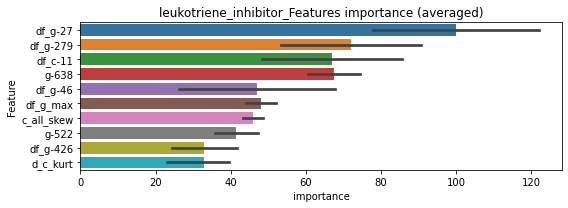

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110411	valid_1's binary_logloss: 0.0143979
[200]	training's binary_logloss: 0.00093434	valid_1's binary_logloss: 0.0038656


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000341573	valid_1's binary_logloss: 0.0033085


================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102604	valid_1's binary_logloss: 0.0148612
[200]	training's binary_logloss: 0.000876937	valid_1's binary_logloss: 0.00576961
[300]	training's binary_logloss: 0.000247841	valid_1's binary_logloss: 0.00462717
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000238777	valid_1's binary_logloss: 0.00458091


leukotriene_inhibitor logloss: 0.003944704900067405
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122176	valid_1's binary_logloss: 0.302606
[200]	training's binary_logloss: 0.031087	valid_1's binary_logloss: 0.215696
[300]	training's binary_logloss: 0.0106179	valid_1's binary_logloss: 0.184837
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00706832	valid_1's binary_logloss: 0.176069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125827	valid_1's binary_logloss: 0.279198
[200]	training's binary_logloss: 0.032407	valid_1's binary_logloss: 0.167484
[300]	training's binary_logloss: 0.0114257	valid_1's binary_logloss: 0.129218
[400]	training's binary_logloss: 0.00552383	valid_1's binary_logloss: 0.113767
[500]	training's binary_logloss: 0.00345487	valid_1's binary_logloss: 0.10611
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00279209	valid_1's binary_logloss: 0.1026


1 / 3 AUC score:0.983
Threshold: 0.31972610856136696
Remove_noisy_labels: 54 → positive_corect_labels: 473/946
30th percentile: 0.02578
p_label_rate: 0.03566 Vs.target_rate: 0.00270, Num_p_label: 142.0, conf_0:0.02578, conf_1:0.49779
Num_p_label: 142.0, Expected: 10.8, Adj_threshold_1: 0.32
Num_p_label: 101.0, Expected: 10.8, Adj_threshold_2: 0.36
Num_p_label: 68.0, Expected: 10.8, Adj_threshold_3: 0.40
Num_p_label: 45.0, Expected: 10.8, Adj_threshold_4: 0.44
Num_p_label: 25.0, Expected: 10.8, Adj_threshold_5: 0.48
Num_p_label: 19.0, Expected: 10.8, Adj_threshold_6: 0.52
Num_p_label: 16.0, Expected: 10.8, Adj_threshold_7: 0.56
threshold:0.56, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:473.0/946, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118597	valid_1's binary_logloss: 0.277415
[200]	training's binary_logloss: 0.0295827	valid_1's binary_logloss: 0.180201
[300]	training's binary_logloss: 0.0101623	valid_1's binary_logloss: 0.149321
[400]	training's binary_logloss: 0.0049542	valid_1's binary_logloss: 0.134766
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00490634	valid_1's binary_logloss: 0.134573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117601	valid_1's binary_logloss: 0.248878
[200]	training's binary_logloss: 0.0299891	valid_1's binary_logloss: 0.143073
[300]	training's binary_logloss: 0.0104549	valid_1's binary_logloss: 0.10212
[400]	training's binary_logloss: 0.00513772	valid_1's binary_logloss: 0.0813846
[500]	training's binary_logloss: 0.00328121	valid_1's binary_logloss: 0.0715518
[600]	training's binary_logloss: 0.00250496	valid_1's binary_

2 / 3 AUC score:0.995
Threshold: 0.559726108561367
Remove_noisy_labels: 33 → positive_corect_labels: 451.0/913
30th percentile: 0.01655
p_label_rate: 0.01080 Vs.target_rate: 0.00270, Num_p_label: 43.0, conf_0:0.01655, conf_1:0.55973
Num_p_label: 43.0, Expected: 10.8, Adj_threshold_1: 0.56
Num_p_label: 33.0, Expected: 10.8, Adj_threshold_2: 0.60
Num_p_label: 22.0, Expected: 10.8, Adj_threshold_3: 0.64
Num_p_label: 12.0, Expected: 10.8, Adj_threshold_4: 0.68
threshold:0.68, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:451.0/913, y_label_rate: 0.49398
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116681	valid_1's binary_logloss: 0.233578
[200]	training's binary_logloss: 0.0292537	valid_1's binary_logloss: 0.13069
[300]	training's binary_logloss: 0.0100731	valid_1's binary_logloss: 0.0932228
[400]	training's binary_logloss: 0.00492318	valid_1's binary_logloss: 0.0766674
[500]	training's binary_logloss: 0.00314579	valid_1's binary_logloss: 0.0688999
[600]	training's binary_logloss: 0.00237669	valid_1's binary_logloss: 0.064178
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.0022933	valid_1's binary_logloss: 0.0638572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11387	valid_1's binary_logloss: 0.234588
[200]	training's binary_logloss: 0.0277332	valid_1's binary_logloss: 0.134318
[300]	training's binary_logloss: 0.00969611	valid_1's binary_logloss: 0.10239
[400]	training's binary_logloss: 0.00477691	valid_1's binary

3 / 3 AUC score:0.997
Threshold: 0.6797261085613671
Remove_noisy_labels: 23 → positive_corect_labels: 429.0/890
30th percentile: 0.01117
p_label_rate: 0.00477 Vs.target_rate: 0.00270, Num_p_label: 19.0, conf_0:0.00883, conf_1:0.67973
threshold:0.68, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:448.0/4872, y_label_rate: 0.09195


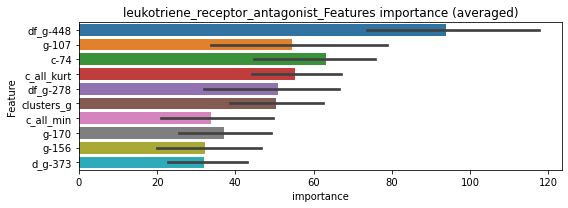

len(train_index) : 2436
len(valid_index) : 2436
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271423	valid_1's binary_logloss: 0.0723323
[200]	training's binary_logloss: 0.00490218	valid_1's binary_logloss: 0.0475492
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00178141	valid_1's binary_logloss: 0.0447487


len(train_index) : 2436
len(valid_index) : 2436
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287831	valid_1's binary_logloss: 0.0640947
[200]	training's binary_logloss: 0.00539162	valid_1's binary_logloss: 0.0394119
[300]	training's binary_logloss: 0.00160201	valid_1's binary_logloss: 0.0352889
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00169717	valid_1's binary_logloss: 0.0352451


leukotriene_receptor_antagonist logloss: 0.039996887422815354
lipase_inhibitor , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510876	valid_1's binary_logloss: 0.0780862
[200]	training's binary_logloss: 0.00724711	valid_1's binary_logloss: 0.0189775
[300]	training's binary_logloss: 0.00228514	valid_1's binary_logloss: 0.00891308
[400]	training's binary_logloss: 0.00131815	valid_1's binary_logloss: 0.00619588
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111707	valid_1's binary_logloss: 0.00543328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522906	valid_1's binary_logloss: 0.0733917
[200]	training's binary_logloss: 0.00757595	valid_1's binary_logloss: 0.0160878
[300]	training's binary_logloss: 0.00240893	valid_1's binary_logloss: 0.00717689
[400]	training's binary_logloss: 0.00135445	valid_1's binary_logloss: 0.0048912
[500]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.00429533


1 / 3 AUC score:1.000
Threshold: 0.6201033069794295
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00121


Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00108029	valid_1's binary_logloss: 0.00423417


p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00121, conf_1:0.62010
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510876	valid_1's binary_logloss: 0.0780862
[200]	training's binary_logloss: 0.00724711	valid_1's binary_logloss: 0.0189775
[300]	training's binary_logloss: 0.00228514	valid_1's binary_logloss: 0.00891308
[400]	training's binary_logloss: 0.00131815	valid_1's binary_logloss: 0.00619588
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111707	valid_1's binary_logloss: 0.00543328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522906	valid_1's binary_logloss: 0.0733917
[200]	training's binary_logloss: 0.00757595	valid_1's binary_logloss: 0.0160878
[300]	training's binary_logloss: 0.00240893	valid_1's binary_logloss: 0.00717689
[400]	training's binary_logloss: 0.00135445	valid_1's binary_logloss: 0.0048912
[500]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.00429533
Early stopping, best iteration is:
[520]

2 / 3 AUC score:1.000
Threshold: 0.6201033069794295
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00121
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00121, conf_1:0.62010
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510876	valid_1's binary_logloss: 0.0780862
[200]	training's binary_logloss: 0.00724711	valid_1's binary_logloss: 0.0189775
[300]	training's binary_logloss: 0.00228514	valid_1's binary_logloss: 0.00891308
[400]	training's binary_logloss: 0.00131815	valid_1's binary_logloss: 0.00619588
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111707	valid_1's binary_logloss: 0.00543328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522906	valid_1's binary_logloss: 0.0733917
[200]	training's binary_logloss: 0.00757595	valid_1's binary_logloss: 0.0160878
[300]	training's binary_logloss: 0.00240893	valid_1's binary_logloss: 0.00717689
[400]	training's binary_logloss: 0.00135445	valid_1's binary_logloss: 0.0048912
[500]	training's binary_logloss: 0.00110344	valid_1's binary_logloss: 0.00429533
Early stopping, best iteration is:
[520]

3 / 3 AUC score:1.000
Threshold: 0.6201033069794295
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00121
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00121, conf_1:0.62010
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


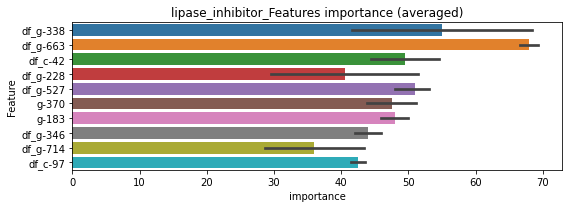

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122754	valid_1's binary_logloss: 0.0191156
[200]	training's binary_logloss: 0.00128049	valid_1's binary_logloss: 0.0047763
[300]	training's binary_logloss: 0.000375117	valid_1's binary_logloss: 0.00304455
[400]	training's binary_logloss: 0.000221218	valid_1's binary_logloss: 0.00266182
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000222761	valid_1's binary_logloss: 0.00265888


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124788	valid_1's binary_logloss: 0.0162723
[200]	training's binary_logloss: 0.00130742	valid_1's binary_logloss: 0.00297071
[300]	training's binary_logloss: 0.000387778	valid_1's binary_logloss: 0.00133932
[400]	training's binary_logloss: 0.000222436	valid_1's binary_logloss: 0.000961655
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000208326	valid_1's binary_logloss: 0.000920658


lipase_inhibitor logloss: 0.0017897688500102577
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117674	valid_1's binary_logloss: 0.24351
[200]	training's binary_logloss: 0.0293236	valid_1's binary_logloss: 0.132799
[300]	training's binary_logloss: 0.00989718	valid_1's binary_logloss: 0.0960244
[400]	training's binary_logloss: 0.00489916	valid_1's binary_logloss: 0.0809834
[500]	training's binary_logloss: 0.00314587	valid_1's binary_logloss: 0.0736288
[600]	training's binary_logloss: 0.0023739	valid_1's binary_logloss: 0.0696097
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00233425	valid_1's binary_logloss: 0.0692102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117335	valid_1's binary_logloss: 0.262843
[200]	training's binary_logloss: 0.0290786	valid_1's binary_logloss: 0.160479
[300]	training's binary_logloss: 0.0100609	valid_1's binary_logloss: 0.125516
[400]	training's binary_logloss: 0.004936	valid_1's binar

1 / 3 AUC score:0.995
Threshold: 0.38095589946028996
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentile: 0.01689
p_label_rate: 0.01934 Vs.target_rate: 0.00266, Num_p_label: 77.0, conf_0:0.01689, conf_1:0.48063
Num_p_label: 77.0, Expected: 10.6, Adj_threshold_1: 0.38
Num_p_label: 52.0, Expected: 10.6, Adj_threshold_2: 0.42
Num_p_label: 36.0, Expected: 10.6, Adj_threshold_3: 0.46
Num_p_label: 24.0, Expected: 10.6, Adj_threshold_4: 0.50
Num_p_label: 17.0, Expected: 10.6, Adj_threshold_5: 0.54
Num_p_label: 12.0, Expected: 10.6, Adj_threshold_6: 0.58
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1146	valid_1's binary_logloss: 0.245833
[200]	training's binary_logloss: 0.0277801	valid_1's binary_logloss: 0.148058
[300]	training's binary_logloss: 0.00956605	valid_1's binary_logloss: 0.115603
[400]	training's binary_logloss: 0.00470357	valid_1's binary_logloss: 0.099728
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00391405	valid_1's binary_logloss: 0.0961702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112835	valid_1's binary_logloss: 0.241941
[200]	training's binary_logloss: 0.0273492	valid_1's binary_logloss: 0.142863
[300]	training's binary_logloss: 0.00942144	valid_1's binary_logloss: 0.109134
[400]	training's binary_logloss: 0.00460207	valid_1's binary_logloss: 0.0941625
[500]	training's binary_logloss: 0.00296949	valid_1's binary_logloss: 0.087197
Early stopping, best iteration is:
[570]	training's binary_

2 / 3 AUC score:0.995
Threshold: 0.58095589946029
Remove_noisy_labels: 33 → positive_corect_labels: 458.0/941
30th percentile: 0.01735
p_label_rate: 0.00954 Vs.target_rate: 0.00266, Num_p_label: 38.0, conf_0:0.01672, conf_1:0.58096
Num_p_label: 38.0, Expected: 10.6, Adj_threshold_1: 0.58
Num_p_label: 30.0, Expected: 10.6, Adj_threshold_2: 0.62
Num_p_label: 19.0, Expected: 10.6, Adj_threshold_3: 0.66
Num_p_label: 13.0, Expected: 10.6, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:458.0/941, y_label_rate: 0.48672
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105533	valid_1's binary_logloss: 0.228662
[200]	training's binary_logloss: 0.0246726	valid_1's binary_logloss: 0.125805
[300]	training's binary_logloss: 0.00832832	valid_1's binary_logloss: 0.0916989
[400]	training's binary_logloss: 0.0041329	valid_1's binary_logloss: 0.0802346
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00333668	valid_1's binary_logloss: 0.077538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108029	valid_1's binary_logloss: 0.225098
[200]	training's binary_logloss: 0.0262001	valid_1's binary_logloss: 0.123021
[300]	training's binary_logloss: 0.00888083	valid_1's binary_logloss: 0.0859222
[400]	training's binary_logloss: 0.00442485	valid_1's binary_logloss: 0.0748548
[500]	training's binary_logloss: 0.00282316	valid_1's binary_logloss: 0.06745
Early stopping, best iteration is:
[538]	training's binar

3 / 3 AUC score:0.998
Threshold: 0.7009558994602901
Remove_noisy_labels: 26 → positive_corect_labels: 433.0/915
30th percentile: 0.01227
p_label_rate: 0.01105 Vs.target_rate: 0.00266, Num_p_label: 44.0, conf_0:0.01227, conf_1:0.70096
Num_p_label: 44.0, Expected: 10.6, Adj_threshold_1: 0.70
Num_p_label: 35.0, Expected: 10.6, Adj_threshold_2: 0.74
Num_p_label: 28.0, Expected: 10.6, Adj_threshold_3: 0.78
Num_p_label: 24.0, Expected: 10.6, Adj_threshold_4: 0.82
Num_p_label: 19.0, Expected: 10.6, Adj_threshold_5: 0.86
Num_p_label: 11.0, Expected: 10.6, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:444.0/4897, y_label_rate: 0.09067


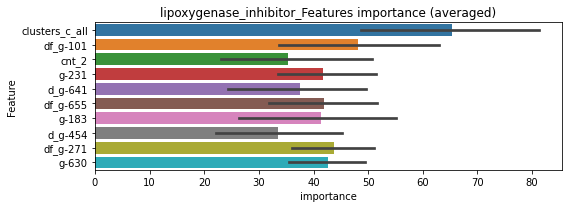

len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254276	valid_1's binary_logloss: 0.0538688
[200]	training's binary_logloss: 0.00451431	valid_1's binary_logloss: 0.0265958
[300]	training's binary_logloss: 0.00136623	valid_1's binary_logloss: 0.0198778
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000758478	valid_1's binary_logloss: 0.0182481


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247304	valid_1's binary_logloss: 0.0710591
[200]	training's binary_logloss: 0.00421991	valid_1's binary_logloss: 0.0410631
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00170355	valid_1's binary_logloss: 0.037205


lipoxygenase_inhibitor logloss: 0.027724610516648217
lxr_agonist , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373198	valid_1's binary_logloss: 0.0456199
[200]	training's binary_logloss: 0.00440669	valid_1's binary_logloss: 0.00783822
[300]	training's binary_logloss: 0.00140376	valid_1's binary_logloss: 0.00333992
[400]	training's binary_logloss: 0.000897468	valid_1's binary_logloss: 0.00235354
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000831263	valid_1's binary_logloss: 0.00220856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373608	valid_1's binary_logloss: 0.049282
[200]	training's binary_logloss: 0.00437652	valid_1's binary_logloss: 0.00842744
[300]	training's binary_logloss: 0.00143772	valid_1's binary_logloss: 0.00405777
[400]	training's binary_logloss: 0.000906237	valid_1's binary_logloss: 0.00293773
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00081757	valid_1's binary_logloss: 0.00271158


1 / 3 AUC score:1.000
Threshold: 0.6000488247226042
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00052
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00052, conf_1:0.60005
threshold:0.60, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373198	valid_1's binary_logloss: 0.0456199
[200]	training's binary_logloss: 0.00440669	valid_1's binary_logloss: 0.00783822
[300]	training's binary_logloss: 0.00140376	valid_1's binary_logloss: 0.00333992
[400]	training's binary_logloss: 0.000897468	valid_1's binary_logloss: 0.00235354
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000831263	valid_1's binary_logloss: 0.00220856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373608	valid_1's binary_logloss: 0.049282
[200]	training's binary_logloss: 0.00437652	valid_1's binary_logloss: 0.00842744
[300]	training's binary_logloss: 0.00143772	valid_1's binary_logloss: 0.00405777
[400]	training's binary_logloss: 0.000906237	valid_1's binary_logloss: 0.00293773
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00081757	valid_1's binary_logloss: 0.00271158


2 / 3 AUC score:1.000
Threshold: 0.6000488247226042
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00052
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00052, conf_1:0.60005
threshold:0.60, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373198	valid_1's binary_logloss: 0.0456199
[200]	training's binary_logloss: 0.00440669	valid_1's binary_logloss: 0.00783822
[300]	training's binary_logloss: 0.00140376	valid_1's binary_logloss: 0.00333992
[400]	training's binary_logloss: 0.000897468	valid_1's binary_logloss: 0.00235354
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000831263	valid_1's binary_logloss: 0.00220856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373608	valid_1's binary_logloss: 0.049282
[200]	training's binary_logloss: 0.00437652	valid_1's binary_logloss: 0.00842744
[300]	training's binary_logloss: 0.00143772	valid_1's binary_logloss: 0.00405777
[400]	training's binary_logloss: 0.000906237	valid_1's binary_logloss: 0.00293773
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00081757	valid_1's binary_logloss: 0.00271158


3 / 3 AUC score:1.000
Threshold: 0.6000488247226042
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00052
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00052, conf_1:0.60005
threshold:0.60, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


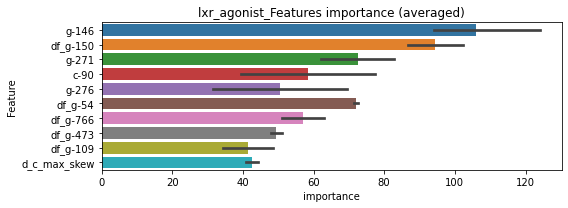

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104842	valid_1's binary_logloss: 0.0122263
[200]	training's binary_logloss: 0.000917664	valid_1's binary_logloss: 0.00183261


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00029493	valid_1's binary_logloss: 0.00116123


================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01068	valid_1's binary_logloss: 0.012444
[200]	training's binary_logloss: 0.000941608	valid_1's binary_logloss: 0.00178478
[300]	training's binary_logloss: 0.000267014	valid_1's binary_logloss: 0.000777816
[400]	training's binary_logloss: 0.000166079	valid_1's binary_logloss: 0.000601858
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000157972	valid_1's binary_logloss: 0.000580868


lxr_agonist logloss: 0.0008710510485421851
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906675	valid_1's binary_logloss: 0.167461
[200]	training's binary_logloss: 0.0183622	valid_1's binary_logloss: 0.0668976
[300]	training's binary_logloss: 0.00586121	valid_1's binary_logloss: 0.0374928
[400]	training's binary_logloss: 0.0029826	valid_1's binary_logloss: 0.0279736
[500]	training's binary_logloss: 0.00201174	valid_1's binary_logloss: 0.0238919
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00172628	valid_1's binary_logloss: 0.0222464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883289	valid_1's binary_logloss: 0.16593
[200]	training's binary_logloss: 0.018038	valid_1's binary_logloss: 0.065602
[300]	training's binary_logloss: 0.00584824	valid_1's binary_logloss: 0.0369438
[400]	training's binary_logloss: 0.00298057	valid_1's binary_logloss: 0.0263782
[500]	training's binary_logloss: 0.00202092	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.43921366368120107
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00515
p_label_rate: 0.00126 Vs.target_rate: 0.00139, Num_p_label: 5.0, conf_0:0.00515, conf_1:0.43921
threshold:0.44, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897762	valid_1's binary_logloss: 0.16858
[200]	training's binary_logloss: 0.0184205	valid_1's binary_logloss: 0.0694357
[300]	training's binary_logloss: 0.00592542	valid_1's binary_logloss: 0.0450684
[400]	training's binary_logloss: 0.00301243	valid_1's binary_logloss: 0.0356998
[500]	training's binary_logloss: 0.0020297	valid_1's binary_logloss: 0.0316375
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00196843	valid_1's binary_logloss: 0.0312554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913858	valid_1's binary_logloss: 0.191655
[200]	training's binary_logloss: 0.0179168	valid_1's binary_logloss: 0.0763043
[300]	training's binary_logloss: 0.00576259	valid_1's binary_logloss: 0.0452184
[400]	training's binary_logloss: 0.00294661	valid_1's binary_logloss: 0.0349434
[500]	training's binary_logloss: 0.00200195	valid_1

2 / 3 AUC score:1.000
Threshold: 0.43921366368120107
Remove_noisy_labels: 8 → positive_corect_labels: 494.0/990
30th percentile: 0.00577
p_label_rate: 0.00100 Vs.target_rate: 0.00139, Num_p_label: 4.0, conf_0:0.00577, conf_1:0.43921
threshold:0.44, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:494.0/990, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904111	valid_1's binary_logloss: 0.161236
[200]	training's binary_logloss: 0.0187514	valid_1's binary_logloss: 0.0619506
[300]	training's binary_logloss: 0.00596617	valid_1's binary_logloss: 0.0336589
[400]	training's binary_logloss: 0.00302443	valid_1's binary_logloss: 0.023355
[500]	training's binary_logloss: 0.00204137	valid_1's binary_logloss: 0.0188434
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00176597	valid_1's binary_logloss: 0.0172899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857791	valid_1's binary_logloss: 0.193204
[200]	training's binary_logloss: 0.016732	valid_1's binary_logloss: 0.105999
[300]	training's binary_logloss: 0.00546647	valid_1's binary_logloss: 0.0836837


3 / 3 AUC score:0.995


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00335999	valid_1's binary_logloss: 0.0789082


Threshold: 0.43921366368120107
Remove_noisy_labels: 10 → positive_corect_labels: 490.0/980
30th percentile: 0.00647
p_label_rate: 0.00276 Vs.target_rate: 0.00139, Num_p_label: 11.0, conf_0:0.00647, conf_1:0.43921
threshold:0.44, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:501.0/4962, y_label_rate: 0.10097


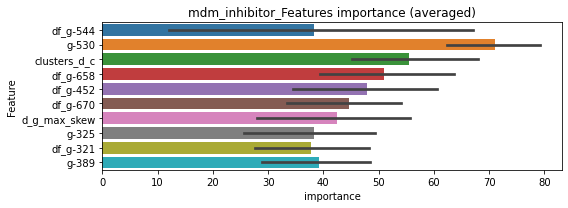

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212256	valid_1's binary_logloss: 0.0424118
[200]	training's binary_logloss: 0.00317855	valid_1's binary_logloss: 0.0191708
[300]	training's binary_logloss: 0.000930235	valid_1's binary_logloss: 0.0154339
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000649529	valid_1's binary_logloss: 0.015103


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224373	valid_1's binary_logloss: 0.0450116
[200]	training's binary_logloss: 0.00325937	valid_1's binary_logloss: 0.0179375
[300]	training's binary_logloss: 0.000938903	valid_1's binary_logloss: 0.0130845
[400]	training's binary_logloss: 0.000486528	valid_1's binary_logloss: 0.0121607
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000430505	valid_1's binary_logloss: 0.0118945


mdm_inhibitor logloss: 0.013498741980140828
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121643	valid_1's binary_logloss: 0.285535
[200]	training's binary_logloss: 0.0325076	valid_1's binary_logloss: 0.180476
[300]	training's binary_logloss: 0.0114728	valid_1's binary_logloss: 0.137649
[400]	training's binary_logloss: 0.00556832	valid_1's binary_logloss: 0.120207
[500]	training's binary_logloss: 0.00353825	valid_1's binary_logloss: 0.110313
[600]	training's binary_logloss: 0.00265227	valid_1's binary_logloss: 0.104136
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00237373	valid_1's binary_logloss: 0.101807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12253	valid_1's binary_logloss: 0.281826
[200]	training's binary_logloss: 0.0325387	valid_1's binary_logloss: 0.186277
[300]	training's binary_logloss: 0.0115434	valid_1's binary_logloss: 0.14947
[400]	training's binary_logloss: 0.00567246	valid_1's binary_lo

1 / 3 AUC score:0.990
Threshold: 0.3746084219169636
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.02606
p_label_rate: 0.01507 Vs.target_rate: 0.00311, Num_p_label: 60.0, conf_0:0.02317, conf_1:0.44688
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_1: 0.37
Num_p_label: 45.0, Expected: 12.4, Adj_threshold_2: 0.41
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_3: 0.45
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113321	valid_1's binary_logloss: 0.229511
[200]	training's binary_logloss: 0.0291196	valid_1's binary_logloss: 0.133092
[300]	training's binary_logloss: 0.0104204	valid_1's binary_logloss: 0.0985228
[400]	training's binary_logloss: 0.00519066	valid_1's binary_logloss: 0.0814393
[500]	training's binary_logloss: 0.00334721	valid_1's binary_logloss: 0.0751986
[600]	training's binary_logloss: 0.00253022	valid_1's binary_logloss: 0.0713148
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00248158	valid_1's binary_logloss: 0.0711556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117413	valid_1's binary_logloss: 0.250724
[200]	training's binary_logloss: 0.0296525	valid_1's binary_logloss: 0.151302
[300]	training's binary_logloss: 0.0104673	valid_1's binary_logloss: 0.111117
[400]	training's binary_logloss: 0.00519521	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.4946084219169635
Remove_noisy_labels: 20 → positive_corect_labels: 466.0/940
30th percentile: 0.02358
p_label_rate: 0.01180 Vs.target_rate: 0.00311, Num_p_label: 47.0, conf_0:0.02260, conf_1:0.49548
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_1: 0.49
Num_p_label: 32.0, Expected: 12.4, Adj_threshold_2: 0.53
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_3: 0.57
Num_p_label: 13.0, Expected: 12.4, Adj_threshold_4: 0.61
threshold:0.61, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:466.0/940, y_label_rate: 0.49574
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106565	valid_1's binary_logloss: 0.262131
[200]	training's binary_logloss: 0.0262049	valid_1's binary_logloss: 0.165038
[300]	training's binary_logloss: 0.00910225	valid_1's binary_logloss: 0.12538
[400]	training's binary_logloss: 0.00463306	valid_1's binary_logloss: 0.108407
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00398513	valid_1's binary_logloss: 0.105102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115985	valid_1's binary_logloss: 0.242234
[200]	training's binary_logloss: 0.0300149	valid_1's binary_logloss: 0.142357
[300]	training's binary_logloss: 0.0105796	valid_1's binary_logloss: 0.100397
[400]	training's binary_logloss: 0.00524255	valid_1's binary_logloss: 0.084598
[500]	training's binary_logloss: 0.00334448	valid_1's binary_logloss: 0.0761386
[600]	training's binary_logloss: 0.00253573	valid_1's binary

3 / 3 AUC score:0.998
Threshold: 0.6146084219169636
Remove_noisy_labels: 32 → positive_corect_labels: 434.0/908
30th percentile: 0.02368
p_label_rate: 0.00301 Vs.target_rate: 0.00311, Num_p_label: 12.0, conf_0:0.02368, conf_1:0.61461
threshold:0.61, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:446.0/4890, y_label_rate: 0.09121


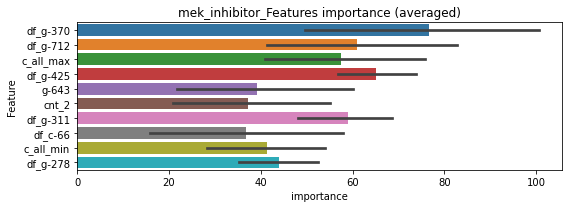

len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025072	valid_1's binary_logloss: 0.0667815
[200]	training's binary_logloss: 0.00458376	valid_1's binary_logloss: 0.0464788
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00157954	valid_1's binary_logloss: 0.0434936


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295557	valid_1's binary_logloss: 0.0668457
[200]	training's binary_logloss: 0.00599273	valid_1's binary_logloss: 0.043553
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00289359	valid_1's binary_logloss: 0.0401322


mek_inhibitor logloss: 0.041812892729546344
membrane_integrity_inhibitor , len(trt) : 74


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124877	valid_1's binary_logloss: 0.263277
[200]	training's binary_logloss: 0.0327372	valid_1's binary_logloss: 0.168623
[300]	training's binary_logloss: 0.0115296	valid_1's binary_logloss: 0.13501
[400]	training's binary_logloss: 0.00563305	valid_1's binary_logloss: 0.12439
[500]	training's binary_logloss: 0.00354856	valid_1's binary_logloss: 0.119366
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00284613	valid_1's binary_logloss: 0.117172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122391	valid_1's binary_logloss: 0.2584
[200]	training's binary_logloss: 0.0331685	valid_1's binary_logloss: 0.166759
[300]	training's binary_logloss: 0.0117014	valid_1's binary_logloss: 0.130146
[400]	training's binary_logloss: 0.00569019	valid_1's binary_logloss: 0.117575
Early stopping, best iteration is:
[453]	training's binary_loglos

1 / 3 AUC score:0.989
Threshold: 0.36119899547533246
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentile: 0.02103
p_label_rate: 0.03666 Vs.target_rate: 0.00319, Num_p_label: 146.0, conf_0:0.02103, conf_1:0.50517
Num_p_label: 146.0, Expected: 12.7, Adj_threshold_1: 0.36
Num_p_label: 115.0, Expected: 12.7, Adj_threshold_2: 0.40
Num_p_label: 86.0, Expected: 12.7, Adj_threshold_3: 0.44
Num_p_label: 65.0, Expected: 12.7, Adj_threshold_4: 0.48
Num_p_label: 43.0, Expected: 12.7, Adj_threshold_5: 0.52
Num_p_label: 34.0, Expected: 12.7, Adj_threshold_6: 0.56
Num_p_label: 23.0, Expected: 12.7, Adj_threshold_7: 0.60
Num_p_label: 15.0, Expected: 12.7, Adj_threshold_8: 0.64
threshold:0.64, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10635	valid_1's binary_logloss: 0.267256
[200]	training's binary_logloss: 0.0262125	valid_1's binary_logloss: 0.176639
[300]	training's binary_logloss: 0.00934466	valid_1's binary_logloss: 0.143104
[400]	training's binary_logloss: 0.00468918	valid_1's binary_logloss: 0.131943
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00349954	valid_1's binary_logloss: 0.127261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124036	valid_1's binary_logloss: 0.26429
[200]	training's binary_logloss: 0.0323734	valid_1's binary_logloss: 0.162058
[300]	training's binary_logloss: 0.0112311	valid_1's binary_logloss: 0.120616
[400]	training's binary_logloss: 0.00546726	valid_1's binary_logloss: 0.106041
[500]	training's binary_logloss: 0.0034427	valid_1's binary_logloss: 0.0971951
Early stopping, best iteration is:
[520]	training's binary_log

2 / 3 AUC score:0.992
Threshold: 0.6411989954753325
Remove_noisy_labels: 40 → positive_corect_labels: 446.0/924
30th percentile: 0.01936
p_label_rate: 0.00854 Vs.target_rate: 0.00319, Num_p_label: 34.0, conf_0:0.01936, conf_1:0.64120
threshold:0.64, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:446.0/924, y_label_rate: 0.48268
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101429	valid_1's binary_logloss: 0.250825
[200]	training's binary_logloss: 0.0235276	valid_1's binary_logloss: 0.158135
[300]	training's binary_logloss: 0.00811463	valid_1's binary_logloss: 0.129658
[400]	training's binary_logloss: 0.00409154	valid_1's binary_logloss: 0.115125
[500]	training's binary_logloss: 0.00271967	valid_1's binary_logloss: 0.107426
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00263756	valid_1's binary_logloss: 0.107207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112115	valid_1's binary_logloss: 0.208184
[200]	training's binary_logloss: 0.0288816	valid_1's binary_logloss: 0.115141
[300]	training's binary_logloss: 0.00994054	valid_1's binary_logloss: 0.0800687
[400]	training's binary_logloss: 0.004993	valid_1's binary_logloss: 0.0656605
[500]	training's binary_logloss: 0.00323422	valid_1's binar

3 / 3 AUC score:0.997
Threshold: 0.6411989954753325
Remove_noisy_labels: 26 → positive_corect_labels: 420.0/898
30th percentile: 0.01004
p_label_rate: 0.00979 Vs.target_rate: 0.00319, Num_p_label: 39.0, conf_0:0.01004, conf_1:0.64120
Num_p_label: 39.0, Expected: 12.7, Adj_threshold_1: 0.64
Num_p_label: 28.0, Expected: 12.7, Adj_threshold_2: 0.68
Num_p_label: 20.0, Expected: 12.7, Adj_threshold_3: 0.72
Num_p_label: 14.0, Expected: 12.7, Adj_threshold_4: 0.76
threshold:0.76, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:434.0/4880, y_label_rate: 0.08893


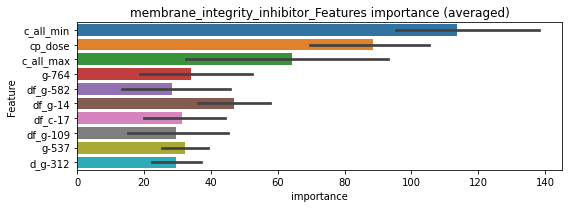

len(train_index) : 2440
len(valid_index) : 2440
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221403	valid_1's binary_logloss: 0.0683347
[200]	training's binary_logloss: 0.00385841	valid_1's binary_logloss: 0.0494384


len(train_index) : 2440
len(valid_index) : 2440


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00262819	valid_1's binary_logloss: 0.0483711


================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242672	valid_1's binary_logloss: 0.0646905
[200]	training's binary_logloss: 0.00441005	valid_1's binary_logloss: 0.0422886
[300]	training's binary_logloss: 0.00136244	valid_1's binary_logloss: 0.0386297
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00135046	valid_1's binary_logloss: 0.0386018


membrane_integrity_inhibitor logloss: 0.04348646132411376
mineralocorticoid_receptor_antagonist , len(trt) : 25


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772892	valid_1's binary_logloss: 0.118394
[200]	training's binary_logloss: 0.0145314	valid_1's binary_logloss: 0.0361878
[300]	training's binary_logloss: 0.00458793	valid_1's binary_logloss: 0.0175689
[400]	training's binary_logloss: 0.00239783	valid_1's binary_logloss: 0.0119255
[500]	training's binary_logloss: 0.00167948	valid_1's binary_logloss: 0.0095997
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00147436	valid_1's binary_logloss: 0.00865468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736996	valid_1's binary_logloss: 0.137521
[200]	training's binary_logloss: 0.0133973	valid_1's binary_logloss: 0.052606
[300]	training's binary_logloss: 0.0043071	valid_1's binary_logloss: 0.0324905
[400]	training's binary_logloss: 0.00225695	valid_1's binary_logloss: 0.025622
[500]	training's binary_logloss: 0.00160021	valid_1

1 / 3 AUC score:1.000
Threshold: 0.569024826311445
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00280
p_label_rate: 0.00025 Vs.target_rate: 0.00113, Num_p_label: 1.0, conf_0:0.00280, conf_1:0.56902
Num_p_label: 1.0, Expected: 4.5, Adj_threshold_1: 0.57
Num_p_label: 3.0, Expected: 4.5, Adj_threshold_2: 0.53
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742911	valid_1's binary_logloss: 0.129562
[200]	training's binary_logloss: 0.0137884	valid_1's binary_logloss: 0.0475464
[300]	training's binary_logloss: 0.00436933	valid_1's binary_logloss: 0.0267894
[400]	training's binary_logloss: 0.00229516	valid_1's binary_logloss: 0.0202315
[500]	training's binary_logloss: 0.00162029	valid_1's binary_logloss: 0.0173919
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00150121	valid_1's binary_logloss: 0.0168712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763213	valid_1's binary_logloss: 0.127239
[200]	training's binary_logloss: 0.0142425	valid_1's binary_logloss: 0.0429822
[300]	training's binary_logloss: 0.00444398	valid_1's binary_logloss: 0.0217614
[400]	training's binary_logloss: 0.00232586	valid_1's binary_logloss: 0.0156433
[500]	training's binary_logloss: 0.00162557	valid

2 / 3 AUC score:1.000
Threshold: 0.529024826311445
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/996
30th percentile: 0.00295
p_label_rate: 0.00025 Vs.target_rate: 0.00113, Num_p_label: 1.0, conf_0:0.00295, conf_1:0.52902
Num_p_label: 1.0, Expected: 4.5, Adj_threshold_1: 0.53
Num_p_label: 2.0, Expected: 4.5, Adj_threshold_2: 0.49
Num_p_label: 4.0, Expected: 4.5, Adj_threshold_3: 0.45
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731556	valid_1's binary_logloss: 0.127969
[200]	training's binary_logloss: 0.0133349	valid_1's binary_logloss: 0.0448248
[300]	training's binary_logloss: 0.00426126	valid_1's binary_logloss: 0.02478
[400]	training's binary_logloss: 0.00223267	valid_1's binary_logloss: 0.0182509
[500]	training's binary_logloss: 0.00159314	valid_1's binary_logloss: 0.0155112
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00143335	valid_1's binary_logloss: 0.0146264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771264	valid_1's binary_logloss: 0.121049
[200]	training's binary_logloss: 0.0144935	valid_1's binary_logloss: 0.0402675
[300]	training's binary_logloss: 0.00459373	valid_1's binary_logloss: 0.0201031
[400]	training's binary_logloss: 0.0023757	valid_1's binary_logloss: 0.0143979
[500]	training's binary_logloss: 0.00165593	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.449024826311445
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00279
p_label_rate: 0.00100 Vs.target_rate: 0.00113, Num_p_label: 4.0, conf_0:0.00279, conf_1:0.48994
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:502.0/4977, y_label_rate: 0.10086


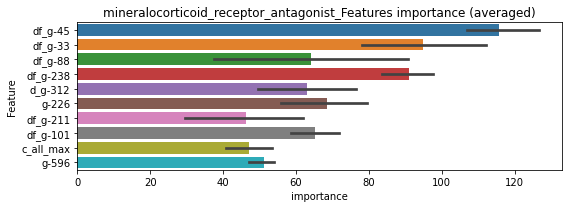

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177429	valid_1's binary_logloss: 0.0278116
[200]	training's binary_logloss: 0.00239976	valid_1's binary_logloss: 0.00750314
[300]	training's binary_logloss: 0.000728327	valid_1's binary_logloss: 0.0047137
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00045443	valid_1's binary_logloss: 0.00424185


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175988	valid_1's binary_logloss: 0.0292794
[200]	training's binary_logloss: 0.00231767	valid_1's binary_logloss: 0.0104662
[300]	training's binary_logloss: 0.000688603	valid_1's binary_logloss: 0.00800977
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000486887	valid_1's binary_logloss: 0.00779262


mineralocorticoid_receptor_antagonist logloss: 0.006016879942119909
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477814	valid_1's binary_logloss: 0.0784062
[200]	training's binary_logloss: 0.00650591	valid_1's binary_logloss: 0.0238505
[300]	training's binary_logloss: 0.00205164	valid_1's binary_logloss: 0.0124412
[400]	training's binary_logloss: 0.00120735	valid_1's binary_logloss: 0.00951996
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00104896	valid_1's binary_logloss: 0.00871066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474622	valid_1's binary_logloss: 0.0633879
[200]	training's binary_logloss: 0.00660712	valid_1's binary_logloss: 0.013052
[300]	training's binary_logloss: 0.00209282	valid_1's binary_logloss: 0.00519956
[400]	training's binary_logloss: 0.00124243	valid_1's binary_logloss: 0.00340119
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0010822	valid_1's binary_logloss: 0.0029479


1 / 3 AUC score:1.000
Threshold: 0.2836212948725069
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00080
p_label_rate: 0.00176 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.00080, conf_1:0.28362
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.28
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_2: 0.32
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_3: 0.36
threshold:0.36, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475735	valid_1's binary_logloss: 0.0783117
[200]	training's binary_logloss: 0.00619927	valid_1's binary_logloss: 0.0193466
[300]	training's binary_logloss: 0.0019804	valid_1's binary_logloss: 0.00927937
[400]	training's binary_logloss: 0.00117993	valid_1's binary_logloss: 0.00690728
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00103363	valid_1's binary_logloss: 0.00631987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472763	valid_1's binary_logloss: 0.061984
[200]	training's binary_logloss: 0.00652999	valid_1's binary_logloss: 0.012948
[300]	training's binary_logloss: 0.00208389	valid_1's binary_logloss: 0.00524052
[400]	training's binary_logloss: 0.00122911	valid_1's binary_logloss: 0.00336424
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00104383	valid_1's binary_logloss: 0.00293034


2 / 3 AUC score:1.000
Threshold: 0.3636212948725069
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00079
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00079, conf_1:0.36362
threshold:0.36, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475735	valid_1's binary_logloss: 0.0783117
[200]	training's binary_logloss: 0.00619927	valid_1's binary_logloss: 0.0193466
[300]	training's binary_logloss: 0.0019804	valid_1's binary_logloss: 0.00927937
[400]	training's binary_logloss: 0.00117993	valid_1's binary_logloss: 0.00690728
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00103363	valid_1's binary_logloss: 0.00631987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472763	valid_1's binary_logloss: 0.061984
[200]	training's binary_logloss: 0.00652999	valid_1's binary_logloss: 0.012948
[300]	training's binary_logloss: 0.00208389	valid_1's binary_logloss: 0.00524052
[400]	training's binary_logloss: 0.00122911	valid_1's binary_logloss: 0.00336424
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00104383	valid_1's binary_logloss: 0.00293034


3 / 3 AUC score:1.000
Threshold: 0.3636212948725069
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00079
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00079, conf_1:0.36362
threshold:0.36, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/4980, y_label_rate: 0.10040


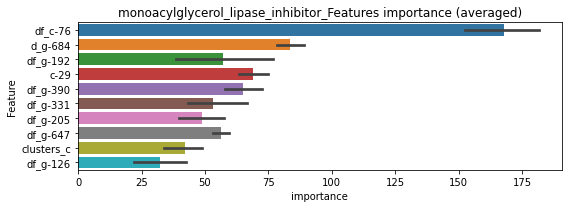

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117993	valid_1's binary_logloss: 0.0154938
[200]	training's binary_logloss: 0.00121088	valid_1's binary_logloss: 0.00314036
[300]	training's binary_logloss: 0.000355511	valid_1's binary_logloss: 0.00211349


len(train_index) : 2490
len(valid_index) : 2490


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000237607	valid_1's binary_logloss: 0.00197181


================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011673	valid_1's binary_logloss: 0.0146036
[200]	training's binary_logloss: 0.00120951	valid_1's binary_logloss: 0.00216671
[300]	training's binary_logloss: 0.000360223	valid_1's binary_logloss: 0.000824668
[400]	training's binary_logloss: 0.000212294	valid_1's binary_logloss: 0.000566188
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000195418	valid_1's binary_logloss: 0.000536082


monoacylglycerol_lipase_inhibitor logloss: 0.001253947438011249
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133816	valid_1's binary_logloss: 0.329927
[200]	training's binary_logloss: 0.0376672	valid_1's binary_logloss: 0.240032
[300]	training's binary_logloss: 0.0135703	valid_1's binary_logloss: 0.204119
[400]	training's binary_logloss: 0.00661742	valid_1's binary_logloss: 0.191924
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00605925	valid_1's binary_logloss: 0.191077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130894	valid_1's binary_logloss: 0.334171
[200]	training's binary_logloss: 0.0361596	valid_1's binary_logloss: 0.232446
[300]	training's binary_logloss: 0.0128419	valid_1's binary_logloss: 0.195705
[400]	training's binary_logloss: 0.00624598	valid_1's binary_logloss: 0.180323
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00455067	valid_1's binary_logloss: 0.174956


1 / 3 AUC score:0.969
Threshold: 0.3950118695966711
Remove_noisy_labels: 64 → positive_corect_labels: 468/936
30th percentile: 0.03944
p_label_rate: 0.05399 Vs.target_rate: 0.00362, Num_p_label: 215.0, conf_0:0.03944, conf_1:0.45959
Num_p_label: 215.0, Expected: 14.4, Adj_threshold_1: 0.40
Num_p_label: 157.0, Expected: 14.4, Adj_threshold_2: 0.44
Num_p_label: 109.0, Expected: 14.4, Adj_threshold_3: 0.48
Num_p_label: 75.0, Expected: 14.4, Adj_threshold_4: 0.52
Num_p_label: 47.0, Expected: 14.4, Adj_threshold_5: 0.56
Num_p_label: 29.0, Expected: 14.4, Adj_threshold_6: 0.60
Num_p_label: 17.0, Expected: 14.4, Adj_threshold_7: 0.64
threshold:0.64, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:468.0/936, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123842	valid_1's binary_logloss: 0.271499
[200]	training's binary_logloss: 0.0326728	valid_1's binary_logloss: 0.169031
[300]	training's binary_logloss: 0.0116626	valid_1's binary_logloss: 0.125099
[400]	training's binary_logloss: 0.00573995	valid_1's binary_logloss: 0.104062
[500]	training's binary_logloss: 0.00363639	valid_1's binary_logloss: 0.0926962
[600]	training's binary_logloss: 0.00271374	valid_1's binary_logloss: 0.0862072
[700]	training's binary_logloss: 0.00228821	valid_1's binary_logloss: 0.0827254
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00221943	valid_1's binary_logloss: 0.0822534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124967	valid_1's binary_logloss: 0.278613
[200]	training's binary_logloss: 0.0327072	valid_1's binary_logloss: 0.185325
[300]	training's binary_logloss: 0.0114509	valid_1's bin

2 / 3 AUC score:0.993
Threshold: 0.6350118695966712
Remove_noisy_labels: 41 → positive_corect_labels: 433.0/895
30th percentile: 0.03011
p_label_rate: 0.01934 Vs.target_rate: 0.00362, Num_p_label: 77.0, conf_0:0.03011, conf_1:0.63501
Num_p_label: 77.0, Expected: 14.4, Adj_threshold_1: 0.64
Num_p_label: 55.0, Expected: 14.4, Adj_threshold_2: 0.68
Num_p_label: 37.0, Expected: 14.4, Adj_threshold_3: 0.72
Num_p_label: 23.0, Expected: 14.4, Adj_threshold_4: 0.76
Num_p_label: 14.0, Expected: 14.4, Adj_threshold_5: 0.80
threshold:0.80, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:433.0/895, y_label_rate: 0.48380
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120356	valid_1's binary_logloss: 0.224087
[200]	training's binary_logloss: 0.0321615	valid_1's binary_logloss: 0.127097
[300]	training's binary_logloss: 0.0113638	valid_1's binary_logloss: 0.0899595
[400]	training's binary_logloss: 0.00569314	valid_1's binary_logloss: 0.0747257
[500]	training's binary_logloss: 0.00360632	valid_1's binary_logloss: 0.0687526
[600]	training's binary_logloss: 0.00270035	valid_1's binary_logloss: 0.0653299
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00247507	valid_1's binary_logloss: 0.064145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116232	valid_1's binary_logloss: 0.260687
[200]	training's binary_logloss: 0.0293672	valid_1's binary_logloss: 0.154478
[300]	training's binary_logloss: 0.0102028	valid_1's binary_logloss: 0.11742
[400]	training's binary_logloss: 0.00509459	valid_1's bina

3 / 3 AUC score:0.995
Threshold: 0.7950118695966714
Remove_noisy_labels: 19 → positive_corect_labels: 415.0/876
30th percentile: 0.01385
p_label_rate: 0.00804 Vs.target_rate: 0.00362, Num_p_label: 32.0, conf_0:0.00861, conf_1:0.79501
threshold:0.80, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:447.0/4858, y_label_rate: 0.09201


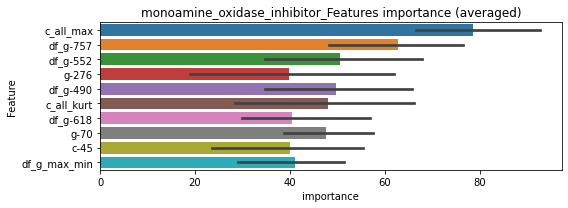

len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286027	valid_1's binary_logloss: 0.0871778
[200]	training's binary_logloss: 0.00572925	valid_1's binary_logloss: 0.0638332
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00377573	valid_1's binary_logloss: 0.0620836


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287119	valid_1's binary_logloss: 0.087898
[200]	training's binary_logloss: 0.00551541	valid_1's binary_logloss: 0.0666176
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0039299	valid_1's binary_logloss: 0.0648431


monoamine_oxidase_inhibitor logloss: 0.0634633962268554
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647104	valid_1's binary_logloss: 0.11467
[200]	training's binary_logloss: 0.0106767	valid_1's binary_logloss: 0.037005
[300]	training's binary_logloss: 0.00339292	valid_1's binary_logloss: 0.0184085
[400]	training's binary_logloss: 0.0018528	valid_1's binary_logloss: 0.0128974
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00147565	valid_1's binary_logloss: 0.0111486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640002	valid_1's binary_logloss: 0.12286
[200]	training's binary_logloss: 0.0105814	valid_1's binary_logloss: 0.0427482
[300]	training's binary_logloss: 0.00337001	valid_1's binary_logloss: 0.0233922
[400]	training's binary_logloss: 0.00185062	valid_1's binary_logloss: 0.0173278
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00149767	valid_1's binary_logloss: 0.0151499


1 / 3 AUC score:1.000
Threshold: 0.7206332205155752
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00206
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00206, conf_1:0.72063
threshold:0.72, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647104	valid_1's binary_logloss: 0.11467
[200]	training's binary_logloss: 0.0106767	valid_1's binary_logloss: 0.037005
[300]	training's binary_logloss: 0.00339292	valid_1's binary_logloss: 0.0184085
[400]	training's binary_logloss: 0.0018528	valid_1's binary_logloss: 0.0128974
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00147565	valid_1's binary_logloss: 0.0111486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640002	valid_1's binary_logloss: 0.12286
[200]	training's binary_logloss: 0.0105814	valid_1's binary_logloss: 0.0427482
[300]	training's binary_logloss: 0.00337001	valid_1's binary_logloss: 0.0233922
[400]	training's binary_logloss: 0.00185062	valid_1's binary_logloss: 0.0173278
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00149767	valid_1's binary_logloss: 0.0151499


2 / 3 AUC score:1.000
Threshold: 0.7206332205155752
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00206
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00206, conf_1:0.72063
threshold:0.72, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647104	valid_1's binary_logloss: 0.11467
[200]	training's binary_logloss: 0.0106767	valid_1's binary_logloss: 0.037005
[300]	training's binary_logloss: 0.00339292	valid_1's binary_logloss: 0.0184085
[400]	training's binary_logloss: 0.0018528	valid_1's binary_logloss: 0.0128974
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00147565	valid_1's binary_logloss: 0.0111486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640002	valid_1's binary_logloss: 0.12286
[200]	training's binary_logloss: 0.0105814	valid_1's binary_logloss: 0.0427482
[300]	training's binary_logloss: 0.00337001	valid_1's binary_logloss: 0.0233922
[400]	training's binary_logloss: 0.00185062	valid_1's binary_logloss: 0.0173278
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00149767	valid_1's binary_logloss: 0.0151499


3 / 3 AUC score:1.000
Threshold: 0.7206332205155752
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00206
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00206, conf_1:0.72063
threshold:0.72, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


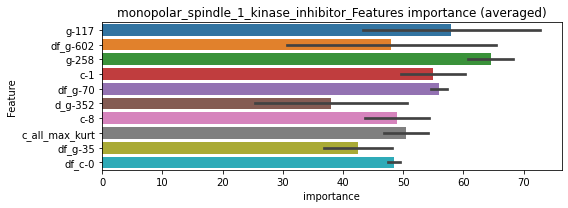

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016778	valid_1's binary_logloss: 0.028223
[200]	training's binary_logloss: 0.00198316	valid_1's binary_logloss: 0.0108836
[300]	training's binary_logloss: 0.000562677	valid_1's binary_logloss: 0.00867702
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000334225	valid_1's binary_logloss: 0.00837509


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173842	valid_1's binary_logloss: 0.0256428
[200]	training's binary_logloss: 0.00218862	valid_1's binary_logloss: 0.00622338
[300]	training's binary_logloss: 0.000594284	valid_1's binary_logloss: 0.00341119
[400]	training's binary_logloss: 0.000317126	valid_1's binary_logloss: 0.00283568
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000331801	valid_1's binary_logloss: 0.00282509


monopolar_spindle_1_kinase_inhibitor logloss: 0.005600089035230231
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158018	valid_1's binary_logloss: 0.428783
[200]	training's binary_logloss: 0.0494083	valid_1's binary_logloss: 0.369523
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0229075	valid_1's binary_logloss: 0.355671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163317	valid_1's binary_logloss: 0.429735
[200]	training's binary_logloss: 0.0508513	valid_1's binary_logloss: 0.348803
[300]	training's binary_logloss: 0.0191845	valid_1's binary_logloss: 0.319836
[400]	training's binary_logloss: 0.00923786	valid_1's binary_logloss: 0.308084
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00691147	valid_1's binary_logloss: 0.305072


1 / 3 AUC score:0.921
Threshold: 0.4328166489264838
Remove_noisy_labels: 142 → positive_corect_labels: 429/858
30th percentile: 0.10567
p_label_rate: 0.10673 Vs.target_rate: 0.00530, Num_p_label: 425.0, conf_0:0.10567, conf_1:0.56028
Num_p_label: 425.0, Expected: 21.1, Adj_threshold_1: 0.43
Num_p_label: 307.0, Expected: 21.1, Adj_threshold_2: 0.47
Num_p_label: 228.0, Expected: 21.1, Adj_threshold_3: 0.51
Num_p_label: 158.0, Expected: 21.1, Adj_threshold_4: 0.55
Num_p_label: 115.0, Expected: 21.1, Adj_threshold_5: 0.59
Num_p_label: 73.0, Expected: 21.1, Adj_threshold_6: 0.63
Num_p_label: 46.0, Expected: 21.1, Adj_threshold_7: 0.67
Num_p_label: 31.0, Expected: 21.1, Adj_threshold_8: 0.71
threshold:0.71, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:429.0/858, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142576	valid_1's binary_logloss: 0.327237
[200]	training's binary_logloss: 0.0413525	valid_1's binary_logloss: 0.231505
[300]	training's binary_logloss: 0.0149786	valid_1's binary_logloss: 0.188746
[400]	training's binary_logloss: 0.00734214	valid_1's binary_logloss: 0.169036
[500]	training's binary_logloss: 0.00453261	valid_1's binary_logloss: 0.159991
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00355344	valid_1's binary_logloss: 0.155205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145402	valid_1's binary_logloss: 0.337741
[200]	training's binary_logloss: 0.0415006	valid_1's binary_logloss: 0.246421
[300]	training's binary_logloss: 0.0153485	valid_1's binary_logloss: 0.213065


2 / 3 AUC score:0.981
Threshold: 0.712816648926484
Remove_noisy_labels: 54 → positive_corect_labels: 381.0/804
30th percentile: 0.05168
p_label_rate: 0.04495 Vs.target_rate: 0.00530, Num_p_label: 179.0, conf_0:0.04594, conf_1:0.71282
Num_p_label: 179.0, Expected: 21.1, Adj_threshold_1: 0.71
Num_p_label: 151.0, Expected: 21.1, Adj_threshold_2: 0.75


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00972738	valid_1's binary_logloss: 0.203844


Num_p_label: 127.0, Expected: 21.1, Adj_threshold_3: 0.79
Num_p_label: 95.0, Expected: 21.1, Adj_threshold_4: 0.83
Num_p_label: 61.0, Expected: 21.1, Adj_threshold_5: 0.87
Num_p_label: 41.0, Expected: 21.1, Adj_threshold_6: 0.91
threshold:0.95, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:381.0/804, y_label_rate: 0.47388
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127834	valid_1's binary_logloss: 0.30054
[200]	training's binary_logloss: 0.0345933	valid_1's binary_logloss: 0.196624
[300]	training's binary_logloss: 0.0125199	valid_1's binary_logloss: 0.15867
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0113551	valid_1's binary_logloss: 0.155783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14443	valid_1's binary_logloss: 0.294364
[200]	training's binary_logloss: 0.0421517	valid_1's binary_logloss: 0.181761
[300]	training's binary_logloss: 0.0154903	valid_1's binary_logloss: 0.139866
[400]	training's binary_logloss: 0.00760657	valid_1's binary_logloss: 0.118596


3 / 3 AUC score:0.992
Threshold: 0.9528166489264842


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00524981	valid_1's binary_logloss: 0.110576


Remove_noisy_labels: 147 → positive_corect_labels: 234.0/657
30th percentile: 0.03783
p_label_rate: 0.00377 Vs.target_rate: 0.00530, Num_p_label: 15.0, conf_0:0.03783, conf_1:0.95282
threshold:0.95, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:249.0/4639, y_label_rate: 0.05368


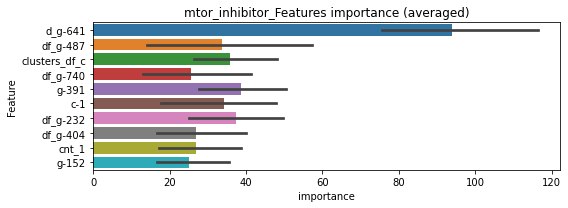

len(train_index) : 2319
len(valid_index) : 2320
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181071	valid_1's binary_logloss: 0.0706858
[200]	training's binary_logloss: 0.00358359	valid_1's binary_logloss: 0.0607981
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00292139	valid_1's binary_logloss: 0.0596501


len(train_index) : 2320
len(valid_index) : 2319
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191169	valid_1's binary_logloss: 0.0714415
[200]	training's binary_logloss: 0.00359124	valid_1's binary_logloss: 0.0573705


mtor_inhibitor logloss: 0.05772108130543631


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00196065	valid_1's binary_logloss: 0.0557912


mucolytic_agent , len(trt) : 48


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107396	valid_1's binary_logloss: 0.19645
[200]	training's binary_logloss: 0.0254317	valid_1's binary_logloss: 0.0971686
[300]	training's binary_logloss: 0.00857216	valid_1's binary_logloss: 0.0648647
[400]	training's binary_logloss: 0.00419784	valid_1's binary_logloss: 0.051294
[500]	training's binary_logloss: 0.0027239	valid_1's binary_logloss: 0.0456149
[600]	training's binary_logloss: 0.00210724	valid_1's binary_logloss: 0.0420716
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00197709	valid_1's binary_logloss: 0.0414508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103204	valid_1's binary_logloss: 0.204507
[200]	training's binary_logloss: 0.0241008	valid_1's binary_logloss: 0.103851
[300]	training's binary_logloss: 0.00803264	valid_1's binary_logloss: 0.0732041
[400]	training's binary_logloss: 0.00402836	valid_1's b

1 / 3 AUC score:0.997
Threshold: 0.3395730891902331
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentile: 0.01013
p_label_rate: 0.01431 Vs.target_rate: 0.00212, Num_p_label: 57.0, conf_0:0.01013, conf_1:0.53466
Num_p_label: 57.0, Expected: 8.4, Adj_threshold_1: 0.34
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_2: 0.38
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_3: 0.42
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_4: 0.46
Num_p_label: 21.0, Expected: 8.4, Adj_threshold_5: 0.50
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_6: 0.54
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_7: 0.58
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10121	valid_1's binary_logloss: 0.19174
[200]	training's binary_logloss: 0.0230979	valid_1's binary_logloss: 0.0890161
[300]	training's binary_logloss: 0.00768057	valid_1's binary_logloss: 0.0567172
[400]	training's binary_logloss: 0.00383264	valid_1's binary_logloss: 0.0435569
[500]	training's binary_logloss: 0.00251537	valid_1's binary_logloss: 0.0379634
[600]	training's binary_logloss: 0.00195189	valid_1's binary_logloss: 0.0340131
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00184128	valid_1's binary_logloss: 0.0333534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105226	valid_1's binary_logloss: 0.181948
[200]	training's binary_logloss: 0.0248678	valid_1's binary_logloss: 0.0849814
[300]	training's binary_logloss: 0.008324	valid_1's binary_logloss: 0.0542045
[400]	training's binary_logloss: 0.00422931	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.5795730891902331
Remove_noisy_labels: 7 → positive_corect_labels: 489.0/981
30th percentile: 0.00870
p_label_rate: 0.00452 Vs.target_rate: 0.00212, Num_p_label: 18.0, conf_0:0.00870, conf_1:0.57957
threshold:0.58, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:489.0/981, y_label_rate: 0.49847
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101689	valid_1's binary_logloss: 0.188009
[200]	training's binary_logloss: 0.0232983	valid_1's binary_logloss: 0.0858437
[300]	training's binary_logloss: 0.00771234	valid_1's binary_logloss: 0.0528145
[400]	training's binary_logloss: 0.00384313	valid_1's binary_logloss: 0.0397216
[500]	training's binary_logloss: 0.00253228	valid_1's binary_logloss: 0.0338392
[600]	training's binary_logloss: 0.00199335	valid_1's binary_logloss: 0.0309617
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.00185941	valid_1's binary_logloss: 0.030005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103074	valid_1's binary_logloss: 0.193867
[200]	training's binary_logloss: 0.0238208	valid_1's binary_logloss: 0.0893652
[300]	training's binary_logloss: 0.00797288	valid_1's binary_logloss: 0.0589557
[400]	training's binary_logloss: 0.00403099	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.5795730891902331
Remove_noisy_labels: 8 → positive_corect_labels: 481.0/973
30th percentile: 0.00835
p_label_rate: 0.00753 Vs.target_rate: 0.00212, Num_p_label: 30.0, conf_0:0.00835, conf_1:0.58488
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_1: 0.58
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_2: 0.62
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_3: 0.66
Num_p_label: 13.0, Expected: 8.4, Adj_threshold_4: 0.70
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:492.0/4955, y_label_rate: 0.09929


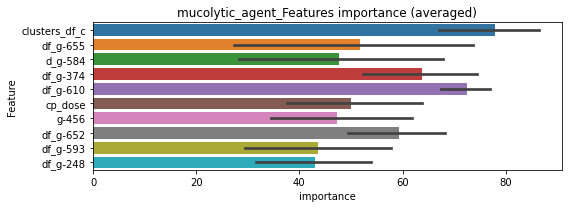

len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258886	valid_1's binary_logloss: 0.0665436
[200]	training's binary_logloss: 0.00423129	valid_1's binary_logloss: 0.0394518
[300]	training's binary_logloss: 0.00121961	valid_1's binary_logloss: 0.0341259
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00116231	valid_1's binary_logloss: 0.0338466


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265199	valid_1's binary_logloss: 0.0512236
[200]	training's binary_logloss: 0.0044514	valid_1's binary_logloss: 0.0245036
[300]	training's binary_logloss: 0.00129361	valid_1's binary_logloss: 0.0185116
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000952631	valid_1's binary_logloss: 0.0178919


mucolytic_agent logloss: 0.025870872996331576
neuropeptide_receptor_antagonist , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101078	valid_1's binary_logloss: 0.174529
[200]	training's binary_logloss: 0.0221971	valid_1's binary_logloss: 0.0677593
[300]	training's binary_logloss: 0.00716332	valid_1's binary_logloss: 0.0358458
[400]	training's binary_logloss: 0.00354992	valid_1's binary_logloss: 0.0256272
[500]	training's binary_logloss: 0.00235348	valid_1's binary_logloss: 0.0211486
[600]	training's binary_logloss: 0.00186866	valid_1's binary_logloss: 0.0188182
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00183591	valid_1's binary_logloss: 0.0185852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907976	valid_1's binary_logloss: 0.174151
[200]	training's binary_logloss: 0.0192048	valid_1's binary_logloss: 0.0750538
[300]	training's binary_logloss: 0.00625665	valid_1's binary_logloss: 0.0450776
[400]	training's binary_logloss: 0.00325303	valid_

1 / 3 AUC score:1.000
Threshold: 0.2614618305708386
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00723
p_label_rate: 0.00728 Vs.target_rate: 0.00165, Num_p_label: 29.0, conf_0:0.00723, conf_1:0.50023
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_1: 0.26
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_2: 0.30
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_3: 0.34
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_4: 0.38
Num_p_label: 6.0, Expected: 6.6, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965513	valid_1's binary_logloss: 0.177616
[200]	training's binary_logloss: 0.0205228	valid_1's binary_logloss: 0.075456
[300]	training's binary_logloss: 0.00665793	valid_1's binary_logloss: 0.0450591
[400]	training's binary_logloss: 0.0033327	valid_1's binary_logloss: 0.0340384
[500]	training's binary_logloss: 0.00222639	valid_1's binary_logloss: 0.0292526
[600]	training's binary_logloss: 0.0018199	valid_1's binary_logloss: 0.0272156
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00179638	valid_1's binary_logloss: 0.0270559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949343	valid_1's binary_logloss: 0.180952
[200]	training's binary_logloss: 0.0201295	valid_1's binary_logloss: 0.0783076
[300]	training's binary_logloss: 0.00657781	valid_1's binary_logloss: 0.0474093
[400]	training's binary_logloss: 0.00329768	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.4214618305708385
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/991
30th percentile: 0.00692
p_label_rate: 0.00201 Vs.target_rate: 0.00165, Num_p_label: 8.0, conf_0:0.00692, conf_1:0.50265
threshold:0.42, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/991, y_label_rate: 0.49748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934078	valid_1's binary_logloss: 0.186894
[200]	training's binary_logloss: 0.0200119	valid_1's binary_logloss: 0.0870324
[300]	training's binary_logloss: 0.00652781	valid_1's binary_logloss: 0.0580364
[400]	training's binary_logloss: 0.00333063	valid_1's binary_logloss: 0.0461322
[500]	training's binary_logloss: 0.0022075	valid_1's binary_logloss: 0.0404296
[600]	training's binary_logloss: 0.00178631	valid_1's binary_logloss: 0.0385857
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00175199	valid_1's binary_logloss: 0.0383116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937561	valid_1's binary_logloss: 0.180063
[200]	training's binary_logloss: 0.0196967	valid_1's binary_logloss: 0.0731254
[300]	training's binary_logloss: 0.00630077	valid_1's binary_logloss: 0.0404346
[400]	training's binary_logloss: 0.00321787	valid_

3 / 3 AUC score:1.000
Threshold: 0.4214618305708385
Remove_noisy_labels: 4 → positive_corect_labels: 489.0/987
30th percentile: 0.00630
p_label_rate: 0.00126 Vs.target_rate: 0.00165, Num_p_label: 5.0, conf_0:0.00630, conf_1:0.49530
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:494.0/4969, y_label_rate: 0.09942


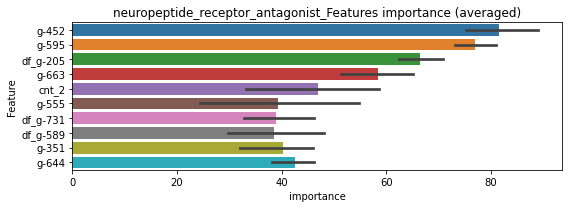

len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227238	valid_1's binary_logloss: 0.0486194
[200]	training's binary_logloss: 0.00340379	valid_1's binary_logloss: 0.0222127
[300]	training's binary_logloss: 0.000998312	valid_1's binary_logloss: 0.0161643
[400]	training's binary_logloss: 0.000514725	valid_1's binary_logloss: 0.0148112
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000371009	valid_1's binary_logloss: 0.0141498


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227279	valid_1's binary_logloss: 0.0547185
[200]	training's binary_logloss: 0.00330813	valid_1's binary_logloss: 0.0261647
[300]	training's binary_logloss: 0.000964557	valid_1's binary_logloss: 0.0205601
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000660611	valid_1's binary_logloss: 0.0195765


neuropeptide_receptor_antagonist logloss: 0.01686256690465384
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686243	valid_1's binary_logloss: 0.69337
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.511
Threshold: 0.5011065555704588
Remove_noisy_labels: 840 → positive_corect_labels: 415/824
30th percentile: 0.49592
p_label_rate: 0.47916 Vs.target_rate: 0.00936, Num_p_label: 1908.0, conf_0:0.49592, conf_1:0.50111
Num_p_label: 1908.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.675	valid_1's binary_logloss: 0.692157


positive y_label:415.0/824, y_label_rate: 0.50364
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.496254	valid_1's binary_logloss: 0.681479
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.636
Threshold: 0.5411065555704588
Remove_noisy_labels: 333 → positive_corect_labels: 190.0/491
30th percentile: 0.48198
p_label_rate: 0.37544 Vs.target_rate: 0.00936, Num_p_label: 1495.0, conf_0:0.48198, conf_1:0.54111
Num_p_label: 1495.0, Expected: 37.3, Adj_threshold_1: 0.54
Num_p_label: 607.0, Expected: 37.3, Adj_threshold_2: 0.58
Num_p_label: 126.0, Expected: 37.3, Adj_threshold_3: 0.62
Num_p_label: 12.0, Expected: 37.3, Adj_threshold_4: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.376249	valid_1's binary_logloss: 0.648655


positive y_label:190.0/491, y_label_rate: 0.38697
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200367	valid_1's binary_logloss: 0.527183
[200]	training's binary_logloss: 0.0759165	valid_1's binary_logloss: 0.502474
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0644436	valid_1's binary_logloss: 0.498139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191812	valid_1's binary_logloss: 0.508098
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.128074	valid_1's binary_logloss: 0.493681


3 / 3 AUC score:0.832
Threshold: 0.6611065555704589
Remove_noisy_labels: 139 → positive_corect_labels: 64.0/352
30th percentile: 0.22576
p_label_rate: 0.11401 Vs.target_rate: 0.00936, Num_p_label: 454.0, conf_0:0.22576, conf_1:0.66111
Num_p_label: 454.0, Expected: 37.3, Adj_threshold_1: 0.66
Num_p_label: 336.0, Expected: 37.3, Adj_threshold_2: 0.70
Num_p_label: 246.0, Expected: 37.3, Adj_threshold_3: 0.74
Num_p_label: 156.0, Expected: 37.3, Adj_threshold_4: 0.78
Num_p_label: 74.0, Expected: 37.3, Adj_threshold_5: 0.82
Num_p_label: 31.0, Expected: 37.3, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:95.0/4334, y_label_rate: 0.02192


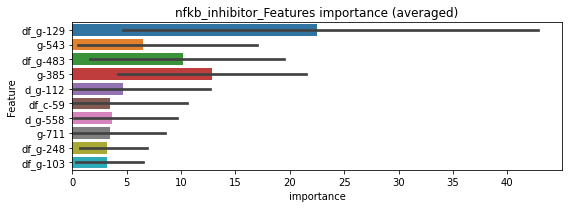

len(train_index) : 2167
len(valid_index) : 2167
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0233692	valid_1's binary_logloss: 0.0920652
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.08916017301045082
nicotinic_receptor_agonist , len(trt) : 12


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0318065	valid_1's binary_logloss: 0.0862551
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524129	valid_1's binary_logloss: 0.0774984
[200]	training's binary_logloss: 0.00761742	valid_1's binary_logloss: 0.0168085
[300]	training's binary_logloss: 0.00246151	valid_1's binary_logloss: 0.00718177
[400]	training's binary_logloss: 0.00140958	valid_1's binary_logloss: 0.00472898
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00118875	valid_1's binary_logloss: 0.00409575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536846	valid_1's binary_logloss: 0.0754774
[200]	training's binary_logloss: 0.00798245	valid_1's binary_logloss: 0.018388
[300]	training's binary_logloss: 0.00251188	valid_1's binary_logloss: 0.00743592
[400]	training's binary_logloss: 0.00142906	valid_1's binary_logloss: 0.00495613
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0012095	valid_1's binary_logloss: 0.00428812


1 / 3 AUC score:1.000
Threshold: 0.5199723675305095
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00158
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00158, conf_1:0.51997
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.52
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.48
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.44
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.40
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.36
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_6: 0.32
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_7: 0.28
threshold:0.28, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524129	valid_1's binary_logloss: 0.0774984
[200]	training's binary_logloss: 0.00761742	valid_1's binary_logloss: 0.0168085
[300]	training's binary_logloss: 0.00246151	valid_1's binary_logloss: 0.00718177
[400]	training's binary_logloss: 0.00140958	valid_1's binary_logloss: 0.00472898
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00118875	valid_1's binary_logloss: 0.00409575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536846	valid_1's binary_logloss: 0.0754774
[200]	training's binary_logloss: 0.00798245	valid_1's binary_logloss: 0.018388
[300]	training's binary_logloss: 0.00251188	valid_1's binary_logloss: 0.00743592
[400]	training's binary_logloss: 0.00142906	valid_1's binary_logloss: 0.00495613
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0012095	valid_1's binary_logloss: 0.00428812


2 / 3 AUC score:1.000
Threshold: 0.2799723675305096
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00158
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00158, conf_1:0.27997
threshold:0.28, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524129	valid_1's binary_logloss: 0.0774984
[200]	training's binary_logloss: 0.00761742	valid_1's binary_logloss: 0.0168085
[300]	training's binary_logloss: 0.00246151	valid_1's binary_logloss: 0.00718177
[400]	training's binary_logloss: 0.00140958	valid_1's binary_logloss: 0.00472898
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00118875	valid_1's binary_logloss: 0.00409575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536846	valid_1's binary_logloss: 0.0754774
[200]	training's binary_logloss: 0.00798245	valid_1's binary_logloss: 0.018388
[300]	training's binary_logloss: 0.00251188	valid_1's binary_logloss: 0.00743592
[400]	training's binary_logloss: 0.00142906	valid_1's binary_logloss: 0.00495613
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0012095	valid_1's binary_logloss: 0.00428812


3 / 3 AUC score:1.000
Threshold: 0.2799723675305096
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00158
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00158, conf_1:0.27997
threshold:0.28, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


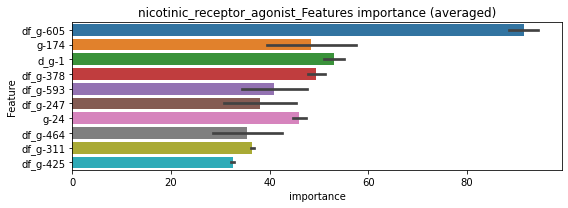

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127622	valid_1's binary_logloss: 0.0197206
[200]	training's binary_logloss: 0.00139672	valid_1's binary_logloss: 0.00566946
[300]	training's binary_logloss: 0.000414921	valid_1's binary_logloss: 0.00369709
[400]	training's binary_logloss: 0.000240934	valid_1's binary_logloss: 0.00334774
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000225814	valid_1's binary_logloss: 0.00331685


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132565	valid_1's binary_logloss: 0.0188216
[200]	training's binary_logloss: 0.00143335	valid_1's binary_logloss: 0.00448087
[300]	training's binary_logloss: 0.000419125	valid_1's binary_logloss: 0.00306846
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000310098	valid_1's binary_logloss: 0.0029023


nicotinic_receptor_agonist logloss: 0.0031095764972630443
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076618	valid_1's binary_logloss: 0.14739
[200]	training's binary_logloss: 0.0143376	valid_1's binary_logloss: 0.066141
[300]	training's binary_logloss: 0.00460569	valid_1's binary_logloss: 0.0424356
[400]	training's binary_logloss: 0.00243058	valid_1's binary_logloss: 0.0342454
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00207527	valid_1's binary_logloss: 0.0318785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796623	valid_1's binary_logloss: 0.144352
[200]	training's binary_logloss: 0.0146351	valid_1's binary_logloss: 0.0539019
[300]	training's binary_logloss: 0.00463483	valid_1's binary_logloss: 0.030695
[400]	training's binary_logloss: 0.00247294	valid_1's binary_logloss: 0.0229577
[500]	training's binary_logloss: 0.00174664	valid_1's binary_logloss: 0.020523
Early stopping, best iteration is:
[576]	training's bi

1 / 3 AUC score:1.000
Threshold: 0.5740909052636038
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00328
p_label_rate: 0.00251 Vs.target_rate: 0.00117, Num_p_label: 10.0, conf_0:0.00328, conf_1:0.57409
threshold:0.57, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767983	valid_1's binary_logloss: 0.148424
[200]	training's binary_logloss: 0.0142139	valid_1's binary_logloss: 0.0606898
[300]	training's binary_logloss: 0.00449465	valid_1's binary_logloss: 0.0336056
[400]	training's binary_logloss: 0.00238643	valid_1's binary_logloss: 0.0250243
[500]	training's binary_logloss: 0.00171041	valid_1's binary_logloss: 0.0211848
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.0016248	valid_1's binary_logloss: 0.0205772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766068	valid_1's binary_logloss: 0.133579
[200]	training's binary_logloss: 0.0145887	valid_1's binary_logloss: 0.050646
[300]	training's binary_logloss: 0.00468484	valid_1's binary_logloss: 0.02906
[400]	training's binary_logloss: 0.00248981	valid_1's binary_logloss: 0.0216728
[500]	training's binary_logloss: 0.00175813	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5740909052636038
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00269
p_label_rate: 0.00352 Vs.target_rate: 0.00117, Num_p_label: 14.0, conf_0:0.00269, conf_1:0.57409
threshold:0.57, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775097	valid_1's binary_logloss: 0.146198
[200]	training's binary_logloss: 0.0144011	valid_1's binary_logloss: 0.0602123
[300]	training's binary_logloss: 0.00453207	valid_1's binary_logloss: 0.0344186
[400]	training's binary_logloss: 0.00239998	valid_1's binary_logloss: 0.0265771
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0018777	valid_1's binary_logloss: 0.0238605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766585	valid_1's binary_logloss: 0.130706
[200]	training's binary_logloss: 0.0144303	valid_1's binary_logloss: 0.048369
[300]	training's binary_logloss: 0.00464724	valid_1's binary_logloss: 0.02681
[400]	training's binary_logloss: 0.00248793	valid_1's binary_logloss: 0.0196615
[500]	training's binary_logloss: 0.00175565	valid_1's binary_logloss: 0.0166461
[600]	training's binary_logloss: 0.00156414	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.5740909052636038
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
30th percentile: 0.00271
p_label_rate: 0.00352 Vs.target_rate: 0.00117, Num_p_label: 14.0, conf_0:0.00271, conf_1:0.57409
threshold:0.57, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:512.0/4977, y_label_rate: 0.10287


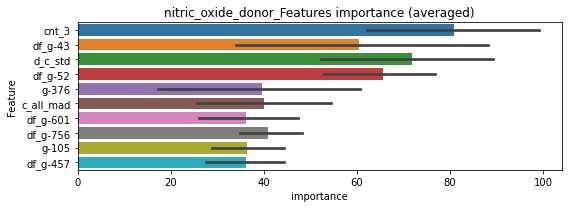

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233833	valid_1's binary_logloss: 0.0408051
[200]	training's binary_logloss: 0.00343061	valid_1's binary_logloss: 0.0165944
[300]	training's binary_logloss: 0.000949985	valid_1's binary_logloss: 0.012905
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00060374	valid_1's binary_logloss: 0.0123572


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232523	valid_1's binary_logloss: 0.038192
[200]	training's binary_logloss: 0.00325581	valid_1's binary_logloss: 0.0130623
[300]	training's binary_logloss: 0.000891016	valid_1's binary_logloss: 0.00896741
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000577197	valid_1's binary_logloss: 0.00867836


nitric_oxide_donor logloss: 0.010518169148102219
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784592	valid_1's binary_logloss: 0.135766
[200]	training's binary_logloss: 0.0151137	valid_1's binary_logloss: 0.0454772
[300]	training's binary_logloss: 0.0048663	valid_1's binary_logloss: 0.0232182
[400]	training's binary_logloss: 0.00252103	valid_1's binary_logloss: 0.0162918
[500]	training's binary_logloss: 0.00172519	valid_1's binary_logloss: 0.0129896
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00150907	valid_1's binary_logloss: 0.0118696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763977	valid_1's binary_logloss: 0.150122
[200]	training's binary_logloss: 0.0142457	valid_1's binary_logloss: 0.0628325
[300]	training's binary_logloss: 0.00448377	valid_1's binary_logloss: 0.0411545
[400]	training's binary_logloss: 0.00233699	valid_1's binary_logloss: 0.0328514
[500]	training's binary_logloss: 0.00161375	valid_

1 / 3 AUC score:1.000
Threshold: 0.366207331664398
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00326
p_label_rate: 0.00276 Vs.target_rate: 0.00130, Num_p_label: 11.0, conf_0:0.00326, conf_1:0.48879
threshold:0.37, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789178	valid_1's binary_logloss: 0.132447
[200]	training's binary_logloss: 0.0145314	valid_1's binary_logloss: 0.0443712
[300]	training's binary_logloss: 0.00460882	valid_1's binary_logloss: 0.0239411
[400]	training's binary_logloss: 0.00241225	valid_1's binary_logloss: 0.0169209
[500]	training's binary_logloss: 0.00169571	valid_1's binary_logloss: 0.0142291
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00149887	valid_1's binary_logloss: 0.0129753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775108	valid_1's binary_logloss: 0.150416
[200]	training's binary_logloss: 0.0144214	valid_1's binary_logloss: 0.0589392
[300]	training's binary_logloss: 0.00459229	valid_1's binary_logloss: 0.0372498
[400]	training's binary_logloss: 0.00239305	valid_1's binary_logloss: 0.0292216
[500]	training's binary_logloss: 0.00164463	valid

2 / 3 AUC score:1.000
Threshold: 0.366207331664398
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/992
30th percentile: 0.00319
p_label_rate: 0.00628 Vs.target_rate: 0.00130, Num_p_label: 25.0, conf_0:0.00319, conf_1:0.55653
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_1: 0.37
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_2: 0.41
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_3: 0.45
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807021	valid_1's binary_logloss: 0.134707
[200]	training's binary_logloss: 0.0150541	valid_1's binary_logloss: 0.0425497
[300]	training's binary_logloss: 0.00475208	valid_1's binary_logloss: 0.0207551
[400]	training's binary_logloss: 0.00245314	valid_1's binary_logloss: 0.0142061
[500]	training's binary_logloss: 0.00171274	valid_1's binary_logloss: 0.0115664
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00148631	valid_1's binary_logloss: 0.0105778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764302	valid_1's binary_logloss: 0.140193
[200]	training's binary_logloss: 0.0142347	valid_1's binary_logloss: 0.0531879
[300]	training's binary_logloss: 0.00450373	valid_1's binary_logloss: 0.0306246
[400]	training's binary_logloss: 0.0023535	valid_1's binary_logloss: 0.0234084
[500]	training's binary_logloss: 0.00166324	valid_

3 / 3 AUC score:1.000
Threshold: 0.48620733166439795
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
30th percentile: 0.00320
p_label_rate: 0.00326 Vs.target_rate: 0.00130, Num_p_label: 13.0, conf_0:0.00320, conf_1:0.51684
threshold:0.49, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:509.0/4974, y_label_rate: 0.10233


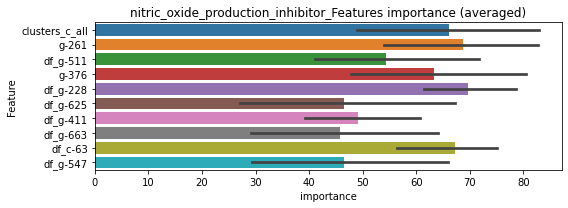

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021087	valid_1's binary_logloss: 0.0403231
[200]	training's binary_logloss: 0.00292407	valid_1's binary_logloss: 0.0187847
[300]	training's binary_logloss: 0.000830993	valid_1's binary_logloss: 0.0155313
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000643369	valid_1's binary_logloss: 0.0152742


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209745	valid_1's binary_logloss: 0.0404912
[200]	training's binary_logloss: 0.00292344	valid_1's binary_logloss: 0.018354
[300]	training's binary_logloss: 0.000840608	valid_1's binary_logloss: 0.0152492
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000610558	valid_1's binary_logloss: 0.0150153


nitric_oxide_production_inhibitor logloss: 0.015144769313754547
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783455	valid_1's binary_logloss: 0.128527
[200]	training's binary_logloss: 0.0150621	valid_1's binary_logloss: 0.0436944
[300]	training's binary_logloss: 0.00483293	valid_1's binary_logloss: 0.0218528
[400]	training's binary_logloss: 0.00254258	valid_1's binary_logloss: 0.0152531
[500]	training's binary_logloss: 0.00179826	valid_1's binary_logloss: 0.0124076
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00161878	valid_1's binary_logloss: 0.0116747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794703	valid_1's binary_logloss: 0.141443
[200]	training's binary_logloss: 0.0149436	valid_1's binary_logloss: 0.0510388
[300]	training's binary_logloss: 0.0048444	valid_1's binary_logloss: 0.028805
[400]	training's binary_logloss: 0.00252923	valid_1's binary_logloss: 0.0210237
[500]	training's binary_logloss: 0.00178537	valid_1

1 / 3 AUC score:1.000
Threshold: 0.6832734795421729
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00334
p_label_rate: 0.00050 Vs.target_rate: 0.00117, Num_p_label: 2.0, conf_0:0.00334, conf_1:0.68327
threshold:0.68, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783455	valid_1's binary_logloss: 0.128527
[200]	training's binary_logloss: 0.0150621	valid_1's binary_logloss: 0.0436944
[300]	training's binary_logloss: 0.00483293	valid_1's binary_logloss: 0.0218528
[400]	training's binary_logloss: 0.00254258	valid_1's binary_logloss: 0.0152531
[500]	training's binary_logloss: 0.00179826	valid_1's binary_logloss: 0.0124076
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00161878	valid_1's binary_logloss: 0.0116747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794703	valid_1's binary_logloss: 0.141443
[200]	training's binary_logloss: 0.0149436	valid_1's binary_logloss: 0.0510388
[300]	training's binary_logloss: 0.0048444	valid_1's binary_logloss: 0.028805
[400]	training's binary_logloss: 0.00252923	valid_1's binary_logloss: 0.0210237
[500]	training's binary_logloss: 0.00178537	valid_1

2 / 3 AUC score:1.000
Threshold: 0.6832734795421729
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00334
p_label_rate: 0.00050 Vs.target_rate: 0.00117, Num_p_label: 2.0, conf_0:0.00334, conf_1:0.68327
threshold:0.68, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783455	valid_1's binary_logloss: 0.128527
[200]	training's binary_logloss: 0.0150621	valid_1's binary_logloss: 0.0436944
[300]	training's binary_logloss: 0.00483293	valid_1's binary_logloss: 0.0218528
[400]	training's binary_logloss: 0.00254258	valid_1's binary_logloss: 0.0152531
[500]	training's binary_logloss: 0.00179826	valid_1's binary_logloss: 0.0124076
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00161878	valid_1's binary_logloss: 0.0116747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794703	valid_1's binary_logloss: 0.141443
[200]	training's binary_logloss: 0.0149436	valid_1's binary_logloss: 0.0510388
[300]	training's binary_logloss: 0.0048444	valid_1's binary_logloss: 0.028805
[400]	training's binary_logloss: 0.00252923	valid_1's binary_logloss: 0.0210237
[500]	training's binary_logloss: 0.00178537	valid_1

3 / 3 AUC score:1.000
Threshold: 0.6832734795421729
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00334
p_label_rate: 0.00050 Vs.target_rate: 0.00117, Num_p_label: 2.0, conf_0:0.00334, conf_1:0.68327
threshold:0.68, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


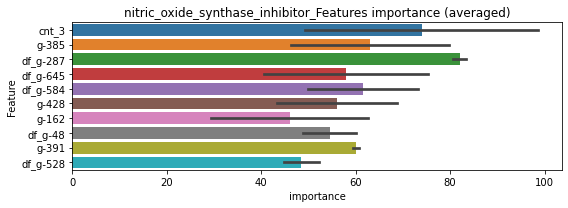

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200671	valid_1's binary_logloss: 0.0351749
[200]	training's binary_logloss: 0.00268913	valid_1's binary_logloss: 0.0102486
[300]	training's binary_logloss: 0.000764054	valid_1's binary_logloss: 0.00546324
[400]	training's binary_logloss: 0.000400132	valid_1's binary_logloss: 0.00422792
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000318112	valid_1's binary_logloss: 0.00391387


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201711	valid_1's binary_logloss: 0.0341903
[200]	training's binary_logloss: 0.00273966	valid_1's binary_logloss: 0.0100761
[300]	training's binary_logloss: 0.000768492	valid_1's binary_logloss: 0.00525839
[400]	training's binary_logloss: 0.000406356	valid_1's binary_logloss: 0.00388822
[500]	training's binary_logloss: 0.000317173	valid_1's binary_logloss: 0.00358399
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000317216	valid_1's binary_logloss: 0.00358356


nitric_oxide_synthase_inhibitor logloss: 0.003748714615468627
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382387	valid_1's binary_logloss: 0.0492428
[200]	training's binary_logloss: 0.00466185	valid_1's binary_logloss: 0.00822069
[300]	training's binary_logloss: 0.00152781	valid_1's binary_logloss: 0.00347633
[400]	training's binary_logloss: 0.000974769	valid_1's binary_logloss: 0.00238953
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00088608	valid_1's binary_logloss: 0.00219445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380368	valid_1's binary_logloss: 0.0565237
[200]	training's binary_logloss: 0.00459912	valid_1's binary_logloss: 0.0143993
[300]	training's binary_logloss: 0.00150686	valid_1's binary_logloss: 0.00844961
[400]	training's binary_logloss: 0.000961257	valid_1's binary_logloss: 0.00659258
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000876607	valid_1's binary_logloss: 0.00611328


1 / 3 AUC score:1.000
Threshold: 0.841898906719091
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00065
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00065, conf_1:0.84190
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.84
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_2: 0.80
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_3: 0.76
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_4: 0.72
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_5: 0.68
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_6: 0.64
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_7: 0.60
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_8: 0.56
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_9: 0.52
threshold:0.52, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382387	valid_1's binary_logloss: 0.0492428
[200]	training's binary_logloss: 0.00466185	valid_1's binary_logloss: 0.00822069
[300]	training's binary_logloss: 0.00152781	valid_1's binary_logloss: 0.00347633
[400]	training's binary_logloss: 0.000974769	valid_1's binary_logloss: 0.00238953
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00088608	valid_1's binary_logloss: 0.00219445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380368	valid_1's binary_logloss: 0.0565237
[200]	training's binary_logloss: 0.00459912	valid_1's binary_logloss: 0.0143993
[300]	training's binary_logloss: 0.00150686	valid_1's binary_logloss: 0.00844961
[400]	training's binary_logloss: 0.000961257	valid_1's binary_logloss: 0.00659258
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000876607	valid_1's binary_logloss: 0.00611328


2 / 3 AUC score:1.000
Threshold: 0.5218989067190907
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00065
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00065, conf_1:0.52190
threshold:0.52, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390614	valid_1's binary_logloss: 0.0500161
[200]	training's binary_logloss: 0.00464611	valid_1's binary_logloss: 0.00843651
[300]	training's binary_logloss: 0.00152515	valid_1's binary_logloss: 0.00362126
[400]	training's binary_logloss: 0.000970966	valid_1's binary_logloss: 0.00264293
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000874938	valid_1's binary_logloss: 0.0023946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389635	valid_1's binary_logloss: 0.0481587
[200]	training's binary_logloss: 0.00464254	valid_1's binary_logloss: 0.00802873
[300]	training's binary_logloss: 0.00152374	valid_1's binary_logloss: 0.00326263
[400]	training's binary_logloss: 0.000972268	valid_1's binary_logloss: 0.00224063
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000890544	valid_1's binary_logloss: 0.00207232

3 / 3 AUC score:1.000
Threshold: 0.5218989067190907
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00064
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00064, conf_1:0.52190
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.52
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_2: 0.48
threshold:0.48, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4981, y_label_rate: 0.10058


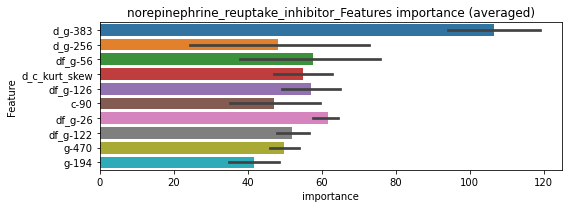

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104903	valid_1's binary_logloss: 0.0128648
[200]	training's binary_logloss: 0.000959318	valid_1's binary_logloss: 0.00179809
[300]	training's binary_logloss: 0.000277222	valid_1's binary_logloss: 0.000747886
[400]	training's binary_logloss: 0.000171745	valid_1's binary_logloss: 0.000613296
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000161103	valid_1's binary_logloss: 0.00059836


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010602	valid_1's binary_logloss: 0.0120078
[200]	training's binary_logloss: 0.000976556	valid_1's binary_logloss: 0.00138424
[300]	training's binary_logloss: 0.000281791	valid_1's binary_logloss: 0.000458921
[400]	training's binary_logloss: 0.000174545	valid_1's binary_logloss: 0.000301105
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000162167	valid_1's binary_logloss: 0.000283128


norepinephrine_reuptake_inhibitor logloss: 0.00044084203339573365
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559046	valid_1's binary_logloss: 0.0958073
[200]	training's binary_logloss: 0.00877869	valid_1's binary_logloss: 0.0295962
[300]	training's binary_logloss: 0.00285308	valid_1's binary_logloss: 0.0159728
[400]	training's binary_logloss: 0.00160385	valid_1's binary_logloss: 0.0116645
[500]	training's binary_logloss: 0.00123402	valid_1's binary_logloss: 0.0101412
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00117997	valid_1's binary_logloss: 0.00984976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558377	valid_1's binary_logloss: 0.0896239
[200]	training's binary_logloss: 0.00895771	valid_1's binary_logloss: 0.0247947
[300]	training's binary_logloss: 0.0029356	valid_1's binary_logloss: 0.0116338
[400]	training's binary_logloss: 0.0016276	valid_1's binary_logloss: 0.00802504
[500]	training's binary_logloss: 0.00129288	v

1 / 3 AUC score:1.000
Threshold: 0.6943321384596448
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00152
p_label_rate: 0.00000 Vs.target_rate: 0.00082, Num_p_label: 0.0, conf_0:0.00152, conf_1:0.69433
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.69
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.65
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.61
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.57
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_5: 0.53
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_6: 0.49
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_7: 0.45
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.41
threshold:0.41, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559046	valid_1's binary_logloss: 0.0958073
[200]	training's binary_logloss: 0.00877869	valid_1's binary_logloss: 0.0295962
[300]	training's binary_logloss: 0.00285308	valid_1's binary_logloss: 0.0159728
[400]	training's binary_logloss: 0.00160385	valid_1's binary_logloss: 0.0116645
[500]	training's binary_logloss: 0.00123402	valid_1's binary_logloss: 0.0101412
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00117997	valid_1's binary_logloss: 0.00984976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558377	valid_1's binary_logloss: 0.0896239
[200]	training's binary_logloss: 0.00895771	valid_1's binary_logloss: 0.0247947
[300]	training's binary_logloss: 0.0029356	valid_1's binary_logloss: 0.0116338
[400]	training's binary_logloss: 0.0016276	valid_1's binary_logloss: 0.00802504
[500]	training's binary_logloss: 0.00129288	v

2 / 3 AUC score:1.000
Threshold: 0.4143321384596447
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00152
p_label_rate: 0.00100 Vs.target_rate: 0.00082, Num_p_label: 4.0, conf_0:0.00152, conf_1:0.41433
threshold:0.41, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560175	valid_1's binary_logloss: 0.0944376
[200]	training's binary_logloss: 0.00885657	valid_1's binary_logloss: 0.0296992
[300]	training's binary_logloss: 0.00286242	valid_1's binary_logloss: 0.0155108
[400]	training's binary_logloss: 0.00161909	valid_1's binary_logloss: 0.0113998
[500]	training's binary_logloss: 0.00125045	valid_1's binary_logloss: 0.0099625
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00121474	valid_1's binary_logloss: 0.00964395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054652	valid_1's binary_logloss: 0.0861849
[200]	training's binary_logloss: 0.00867889	valid_1's binary_logloss: 0.0240157
[300]	training's binary_logloss: 0.00287151	valid_1's binary_logloss: 0.0125243
[400]	training's binary_logloss: 0.00161091	valid_1's binary_logloss: 0.00900578
[500]	training's binary_logloss: 0.00127389	

3 / 3 AUC score:1.000
Threshold: 0.4143321384596447
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00151
p_label_rate: 0.00176 Vs.target_rate: 0.00082, Num_p_label: 7.0, conf_0:0.00151, conf_1:0.41649
threshold:0.41, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:507.0/4980, y_label_rate: 0.10181


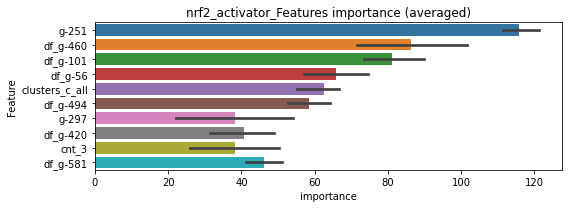

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158243	valid_1's binary_logloss: 0.0241595
[200]	training's binary_logloss: 0.00183756	valid_1's binary_logloss: 0.00916166
[300]	training's binary_logloss: 0.000544998	valid_1's binary_logloss: 0.00764062
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000474973	valid_1's binary_logloss: 0.00754399


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156132	valid_1's binary_logloss: 0.0233846
[200]	training's binary_logloss: 0.00190197	valid_1's binary_logloss: 0.00816826
[300]	training's binary_logloss: 0.000548805	valid_1's binary_logloss: 0.00671619
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000534013	valid_1's binary_logloss: 0.00669023


nrf2_activator logloss: 0.007117111169442846
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115949	valid_1's binary_logloss: 0.259385
[200]	training's binary_logloss: 0.0289739	valid_1's binary_logloss: 0.16337
[300]	training's binary_logloss: 0.0101114	valid_1's binary_logloss: 0.130472
[400]	training's binary_logloss: 0.00498	valid_1's binary_logloss: 0.115326
[500]	training's binary_logloss: 0.00320683	valid_1's binary_logloss: 0.108704
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00276313	valid_1's binary_logloss: 0.106881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119535	valid_1's binary_logloss: 0.24667
[200]	training's binary_logloss: 0.0304533	valid_1's binary_logloss: 0.14395
[300]	training's binary_logloss: 0.0105724	valid_1's binary_logloss: 0.108137
[400]	training's binary_logloss: 0.00521229	valid_1's binary_logloss: 0.0910231
[500]	training's binary_logloss: 0.00331024	valid_1's binary_loglo

1 / 3 AUC score:0.993
Threshold: 0.33726072813104996
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02221
p_label_rate: 0.01431 Vs.target_rate: 0.00266, Num_p_label: 57.0, conf_0:0.02159, conf_1:0.49255
Num_p_label: 57.0, Expected: 10.6, Adj_threshold_1: 0.34
Num_p_label: 38.0, Expected: 10.6, Adj_threshold_2: 0.38
Num_p_label: 23.0, Expected: 10.6, Adj_threshold_3: 0.42
Num_p_label: 13.0, Expected: 10.6, Adj_threshold_4: 0.46
threshold:0.46, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111883	valid_1's binary_logloss: 0.231169
[200]	training's binary_logloss: 0.0286577	valid_1's binary_logloss: 0.126823
[300]	training's binary_logloss: 0.0100813	valid_1's binary_logloss: 0.0873227
[400]	training's binary_logloss: 0.00492034	valid_1's binary_logloss: 0.0689779
[500]	training's binary_logloss: 0.0031765	valid_1's binary_logloss: 0.0603259
[600]	training's binary_logloss: 0.00240531	valid_1's binary_logloss: 0.0557187
[700]	training's binary_logloss: 0.00212081	valid_1's binary_logloss: 0.053197
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.0020663	valid_1's binary_logloss: 0.0525931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117919	valid_1's binary_logloss: 0.241265
[200]	training's binary_logloss: 0.0299024	valid_1's binary_logloss: 0.125918
[300]	training's binary_logloss: 0.0103097	valid_1's bina

2 / 3 AUC score:1.000
Threshold: 0.4572607281310499
Remove_noisy_labels: 9 → positive_corect_labels: 480.0/961
30th percentile: 0.01718
p_label_rate: 0.00753 Vs.target_rate: 0.00266, Num_p_label: 30.0, conf_0:0.01718, conf_1:0.52129
threshold:0.46, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:480.0/961, y_label_rate: 0.49948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113264	valid_1's binary_logloss: 0.21766
[200]	training's binary_logloss: 0.0286716	valid_1's binary_logloss: 0.111223
[300]	training's binary_logloss: 0.0101148	valid_1's binary_logloss: 0.0753098
[400]	training's binary_logloss: 0.00498554	valid_1's binary_logloss: 0.05913
[500]	training's binary_logloss: 0.00324849	valid_1's binary_logloss: 0.0519791
[600]	training's binary_logloss: 0.00248791	valid_1's binary_logloss: 0.0480765
[700]	training's binary_logloss: 0.00216417	valid_1's binary_logloss: 0.0465884
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.00208189	valid_1's binary_logloss: 0.0460663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109003	valid_1's binary_logloss: 0.227808
[200]	training's binary_logloss: 0.0275248	valid_1's binary_logloss: 0.126818
[300]	training's binary_logloss: 0.00951854	valid_1's bin

3 / 3 AUC score:0.998
Threshold: 0.4572607281310499
Remove_noisy_labels: 14 → positive_corect_labels: 473.0/947
30th percentile: 0.01679
p_label_rate: 0.00728 Vs.target_rate: 0.00266, Num_p_label: 29.0, conf_0:0.01679, conf_1:0.47686
threshold:0.46, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:502.0/4929, y_label_rate: 0.10185


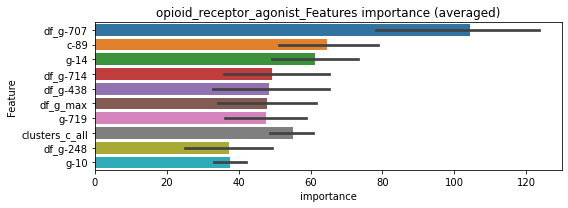

len(train_index) : 2464
len(valid_index) : 2465
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296953	valid_1's binary_logloss: 0.0744269
[200]	training's binary_logloss: 0.00580978	valid_1's binary_logloss: 0.0480911
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00203955	valid_1's binary_logloss: 0.0431383


len(train_index) : 2465
len(valid_index) : 2464
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293189	valid_1's binary_logloss: 0.0727901
[200]	training's binary_logloss: 0.00521794	valid_1's binary_logloss: 0.046547
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00183481	valid_1's binary_logloss: 0.0426172


opioid_receptor_agonist logloss: 0.0428777950595223
opioid_receptor_antagonist , len(trt) : 96


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138197	valid_1's binary_logloss: 0.359399
[200]	training's binary_logloss: 0.0405959	valid_1's binary_logloss: 0.277218
[300]	training's binary_logloss: 0.0150878	valid_1's binary_logloss: 0.248111
[400]	training's binary_logloss: 0.00729572	valid_1's binary_logloss: 0.231414
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00761603	valid_1's binary_logloss: 0.231186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148427	valid_1's binary_logloss: 0.329675
[200]	training's binary_logloss: 0.0435285	valid_1's binary_logloss: 0.229556
[300]	training's binary_logloss: 0.0162962	valid_1's binary_logloss: 0.191783
[400]	training's binary_logloss: 0.00788302	valid_1's binary_logloss: 0.175654
[500]	training's binary_logloss: 0.00481166	valid_1's binary_logloss: 0.169307
Early stopping, best iteration is:
[572]	training's binary_lo

1 / 3 AUC score:0.971
Threshold: 0.37261479077105897
Remove_noisy_labels: 74 → positive_corect_labels: 463/926
30th percentile: 0.06297
p_label_rate: 0.05198 Vs.target_rate: 0.00405, Num_p_label: 207.0, conf_0:0.06297, conf_1:0.48185
Num_p_label: 207.0, Expected: 16.1, Adj_threshold_1: 0.37
Num_p_label: 141.0, Expected: 16.1, Adj_threshold_2: 0.41
Num_p_label: 90.0, Expected: 16.1, Adj_threshold_3: 0.45
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_4: 0.49
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_5: 0.53
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_6: 0.57
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_7: 0.61
threshold:0.61, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:463.0/926, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134455	valid_1's binary_logloss: 0.311502
[200]	training's binary_logloss: 0.0382907	valid_1's binary_logloss: 0.213424
[300]	training's binary_logloss: 0.0137718	valid_1's binary_logloss: 0.171257
[400]	training's binary_logloss: 0.00675543	valid_1's binary_logloss: 0.153958
[500]	training's binary_logloss: 0.00420017	valid_1's binary_logloss: 0.144222
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00364343	valid_1's binary_logloss: 0.141098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137242	valid_1's binary_logloss: 0.3002
[200]	training's binary_logloss: 0.0388603	valid_1's binary_logloss: 0.205113
[300]	training's binary_logloss: 0.0139137	valid_1's binary_logloss: 0.164134
[400]	training's binary_logloss: 0.00684269	valid_1's binary_logloss: 0.149196
[500]	training's binary_logloss: 0.00427068	valid_1's binary_lo

2 / 3 AUC score:0.987
Threshold: 0.612614790771059
Remove_noisy_labels: 42 → positive_corect_labels: 428.0/884
30th percentile: 0.04165
p_label_rate: 0.01205 Vs.target_rate: 0.00405, Num_p_label: 48.0, conf_0:0.04165, conf_1:0.61261
threshold:0.61, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:428.0/884, y_label_rate: 0.48416
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121587	valid_1's binary_logloss: 0.266595
[200]	training's binary_logloss: 0.0326499	valid_1's binary_logloss: 0.164271
[300]	training's binary_logloss: 0.011724	valid_1's binary_logloss: 0.123238
[400]	training's binary_logloss: 0.00589211	valid_1's binary_logloss: 0.105218
[500]	training's binary_logloss: 0.00379109	valid_1's binary_logloss: 0.0972707
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00379109	valid_1's binary_logloss: 0.0972707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130264	valid_1's binary_logloss: 0.277427
[200]	training's binary_logloss: 0.0359358	valid_1's binary_logloss: 0.170932
[300]	training's binary_logloss: 0.0129691	valid_1's binary_logloss: 0.130473
[400]	training's binary_logloss: 0.00634966	valid_1's binary_logloss: 0.113492
Early stopping, best iteration is:
[409]	training's binary_l

3 / 3 AUC score:0.996
Threshold: 0.612614790771059
Remove_noisy_labels: 31 → positive_corect_labels: 402.0/853
30th percentile: 0.03497
p_label_rate: 0.02084 Vs.target_rate: 0.00405, Num_p_label: 83.0, conf_0:0.03497, conf_1:0.61261
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_1: 0.61
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_2: 0.65
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_3: 0.69
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_4: 0.73
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_5: 0.77
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_6: 0.81
threshold:0.81, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:424.0/4835, y_label_rate: 0.08769


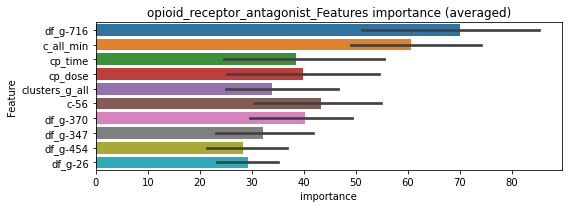

len(train_index) : 2417
len(valid_index) : 2418
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289675	valid_1's binary_logloss: 0.0827793
[200]	training's binary_logloss: 0.0060199	valid_1's binary_logloss: 0.0630533
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00370596	valid_1's binary_logloss: 0.0598069


len(train_index) : 2418
len(valid_index) : 2417
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269827	valid_1's binary_logloss: 0.090762
[200]	training's binary_logloss: 0.00537467	valid_1's binary_logloss: 0.0720131
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00269628	valid_1's binary_logloss: 0.0697871


opioid_receptor_antagonist logloss: 0.06479595045164839
orexin_receptor_antagonist , len(trt) : 37


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878663	valid_1's binary_logloss: 0.171926
[200]	training's binary_logloss: 0.0184954	valid_1's binary_logloss: 0.0814803
[300]	training's binary_logloss: 0.00616354	valid_1's binary_logloss: 0.056212
[400]	training's binary_logloss: 0.00316585	valid_1's binary_logloss: 0.0459591
[500]	training's binary_logloss: 0.00213146	valid_1's binary_logloss: 0.0408808
[600]	training's binary_logloss: 0.00175322	valid_1's binary_logloss: 0.0382725
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00170633	valid_1's binary_logloss: 0.03781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895252	valid_1's binary_logloss: 0.188231
[200]	training's binary_logloss: 0.017944	valid_1's binary_logloss: 0.0911193


1 / 3 AUC score:0.999
Threshold: 0.3315619133468921
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01173
p_label_rate: 0.01733 Vs.target_rate: 0.00165, Num_p_label: 69.0, conf_0:0.01173, conf_1:0.43897
Num_p_label: 69.0, Expected: 6.6, Adj_threshold_1: 0.33
Num_p_label: 44.0, Expected: 6.6, Adj_threshold_2: 0.37


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00754948	valid_1's binary_logloss: 0.0701272


Num_p_label: 34.0, Expected: 6.6, Adj_threshold_3: 0.41
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_4: 0.45
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_5: 0.49
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_6: 0.53
threshold:0.53, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088151	valid_1's binary_logloss: 0.174189
[200]	training's binary_logloss: 0.0183338	valid_1's binary_logloss: 0.0858587
[300]	training's binary_logloss: 0.00601603	valid_1's binary_logloss: 0.0584941
[400]	training's binary_logloss: 0.00307466	valid_1's binary_logloss: 0.0487652
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00264965	valid_1's binary_logloss: 0.0474445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08557	valid_1's binary_logloss: 0.165215
[200]	training's binary_logloss: 0.0174054	valid_1's binary_logloss: 0.0700194
[300]	training's binary_logloss: 0.00568521	valid_1's binary_logloss: 0.0448969
[400]	training's binary_logloss: 0.00296137	valid_1's binary_logloss: 0.0363086
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00288802	valid_1's binary_logloss: 0.0358178


2 / 3 AUC score:1.000
Threshold: 0.5315619133468921
Remove_noisy_labels: 10 → positive_corect_labels: 482.0/974
30th percentile: 0.00826
p_label_rate: 0.00352 Vs.target_rate: 0.00165, Num_p_label: 14.0, conf_0:0.00826, conf_1:0.53156
threshold:0.53, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:482.0/974, y_label_rate: 0.49487
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088622	valid_1's binary_logloss: 0.155709
[200]	training's binary_logloss: 0.0186757	valid_1's binary_logloss: 0.0649522
[300]	training's binary_logloss: 0.0061234	valid_1's binary_logloss: 0.0362041
[400]	training's binary_logloss: 0.00310111	valid_1's binary_logloss: 0.0261012
[500]	training's binary_logloss: 0.00208143	valid_1's binary_logloss: 0.0222246
[600]	training's binary_logloss: 0.00173901	valid_1's binary_logloss: 0.0204163
[700]	training's binary_logloss: 0.00164055	valid_1's binary_logloss: 0.0198642
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.00164055	valid_1's binary_logloss: 0.0198642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857921	valid_1's binary_logloss: 0.170218
[200]	training's binary_logloss: 0.017508	valid_1's binary_logloss: 0.0737711
[300]	training's binary_logloss: 0.00571828	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.5315619133468921
Remove_noisy_labels: 2 → positive_corect_labels: 481.0/972
30th percentile: 0.00526
p_label_rate: 0.00276 Vs.target_rate: 0.00165, Num_p_label: 11.0, conf_0:0.00526, conf_1:0.53156
threshold:0.53, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:492.0/4954, y_label_rate: 0.09931


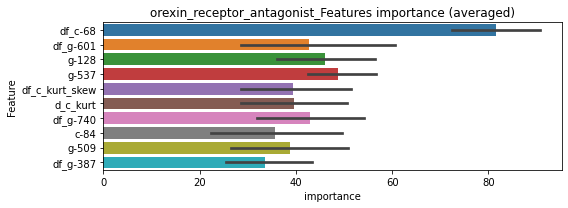

len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235039	valid_1's binary_logloss: 0.0426886
[200]	training's binary_logloss: 0.00380427	valid_1's binary_logloss: 0.0202174
[300]	training's binary_logloss: 0.00109001	valid_1's binary_logloss: 0.0172398
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00115389	valid_1's binary_logloss: 0.0172342


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226969	valid_1's binary_logloss: 0.0467087
[200]	training's binary_logloss: 0.00348458	valid_1's binary_logloss: 0.021679
[300]	training's binary_logloss: 0.00104013	valid_1's binary_logloss: 0.0172675
[400]	training's binary_logloss: 0.000531346	valid_1's binary_logloss: 0.016437
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000555779	valid_1's binary_logloss: 0.0163659


orexin_receptor_antagonist logloss: 0.016800041376679075
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120975	valid_1's binary_logloss: 0.251466
[200]	training's binary_logloss: 0.0307504	valid_1's binary_logloss: 0.147853
[300]	training's binary_logloss: 0.010656	valid_1's binary_logloss: 0.109944
[400]	training's binary_logloss: 0.00519077	valid_1's binary_logloss: 0.0931641
[500]	training's binary_logloss: 0.00330961	valid_1's binary_logloss: 0.0852587
[600]	training's binary_logloss: 0.00249247	valid_1's binary_logloss: 0.0817252
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00251623	valid_1's binary_logloss: 0.0816187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123316	valid_1's binary_logloss: 0.266921
[200]	training's binary_logloss: 0.0311069	valid_1's binary_logloss: 0.157477
[300]	training's binary_logloss: 0.0105202	valid_1's binary_logloss: 0.112946
[400]	training's binary_logloss: 0.00515363	valid_1's bina

1 / 3 AUC score:0.994
Threshold: 0.40666816948702667
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentile: 0.01659
p_label_rate: 0.01431 Vs.target_rate: 0.00270, Num_p_label: 57.0, conf_0:0.01659, conf_1:0.47717
Num_p_label: 57.0, Expected: 10.8, Adj_threshold_1: 0.41
Num_p_label: 31.0, Expected: 10.8, Adj_threshold_2: 0.45
Num_p_label: 23.0, Expected: 10.8, Adj_threshold_3: 0.49
Num_p_label: 19.0, Expected: 10.8, Adj_threshold_4: 0.53
Num_p_label: 14.0, Expected: 10.8, Adj_threshold_5: 0.57
threshold:0.57, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121911	valid_1's binary_logloss: 0.239928
[200]	training's binary_logloss: 0.0304378	valid_1's binary_logloss: 0.128604
[300]	training's binary_logloss: 0.010451	valid_1's binary_logloss: 0.09185
[400]	training's binary_logloss: 0.0051373	valid_1's binary_logloss: 0.0778064
[500]	training's binary_logloss: 0.00327907	valid_1's binary_logloss: 0.06886
[600]	training's binary_logloss: 0.00246502	valid_1's binary_logloss: 0.0648325
[700]	training's binary_logloss: 0.00214509	valid_1's binary_logloss: 0.0629793
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.0021243	valid_1's binary_logloss: 0.0627767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120653	valid_1's binary_logloss: 0.249204
[200]	training's binary_logloss: 0.0313139	valid_1's binary_logloss: 0.14162
[300]	training's binary_logloss: 0.0106839	valid_1's binary_lo

2 / 3 AUC score:0.997
Threshold: 0.5666681694870267
Remove_noisy_labels: 16 → positive_corect_labels: 476.0/962
30th percentile: 0.01707
p_label_rate: 0.00527 Vs.target_rate: 0.00270, Num_p_label: 21.0, conf_0:0.01707, conf_1:0.56667
threshold:0.57, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:476.0/962, y_label_rate: 0.49480
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117088	valid_1's binary_logloss: 0.25151
[200]	training's binary_logloss: 0.0286925	valid_1's binary_logloss: 0.146869
[300]	training's binary_logloss: 0.00973341	valid_1's binary_logloss: 0.113031
[400]	training's binary_logloss: 0.00474851	valid_1's binary_logloss: 0.0979916
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00365861	valid_1's binary_logloss: 0.0944599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11291	valid_1's binary_logloss: 0.235235
[200]	training's binary_logloss: 0.0274143	valid_1's binary_logloss: 0.133638
[300]	training's binary_logloss: 0.00946394	valid_1's binary_logloss: 0.100895
[400]	training's binary_logloss: 0.00473989	valid_1's binary_logloss: 0.0877733
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0043855	valid_1's binary_logloss: 0.0866638


3 / 3 AUC score:0.993
Threshold: 0.5666681694870267
Remove_noisy_labels: 28 → positive_corect_labels: 452.0/934
30th percentile: 0.02166
p_label_rate: 0.00527 Vs.target_rate: 0.00270, Num_p_label: 21.0, conf_0:0.02166, conf_1:0.56667
threshold:0.57, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:473.0/4916, y_label_rate: 0.09622


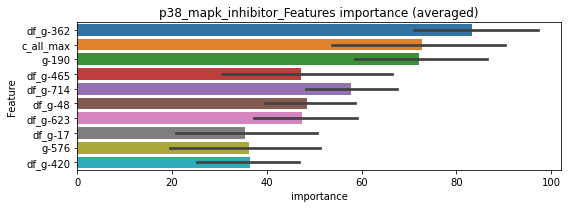

len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278082	valid_1's binary_logloss: 0.0715178
[200]	training's binary_logloss: 0.00486349	valid_1's binary_logloss: 0.0474653
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00243979	valid_1's binary_logloss: 0.044152


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296372	valid_1's binary_logloss: 0.0704334
[200]	training's binary_logloss: 0.00545794	valid_1's binary_logloss: 0.0459381
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00390074	valid_1's binary_logloss: 0.0439874


p38_mapk_inhibitor logloss: 0.044069723574071296
p-glycoprotein_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077596	valid_1's binary_logloss: 0.137809
[200]	training's binary_logloss: 0.0147025	valid_1's binary_logloss: 0.046288
[300]	training's binary_logloss: 0.00470223	valid_1's binary_logloss: 0.0235636
[400]	training's binary_logloss: 0.00248926	valid_1's binary_logloss: 0.0170411
[500]	training's binary_logloss: 0.0017293	valid_1's binary_logloss: 0.0140916
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00152874	valid_1's binary_logloss: 0.013036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717515	valid_1's binary_logloss: 0.144915
[200]	training's binary_logloss: 0.0132912	valid_1's binary_logloss: 0.0613287
[300]	training's binary_logloss: 0.00432787	valid_1's binary_logloss: 0.0363464
[400]	training's binary_logloss: 0.00230931	valid_1's binary_logloss: 0.0283405
[500]	training's binary_logloss: 0.00165598	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.3390794217529035
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00358
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00358, conf_1:0.33908
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760725	valid_1's binary_logloss: 0.136734
[200]	training's binary_logloss: 0.0141353	valid_1's binary_logloss: 0.0591206
[300]	training's binary_logloss: 0.0045529	valid_1's binary_logloss: 0.0421679
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00299965	valid_1's binary_logloss: 0.0386749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766658	valid_1's binary_logloss: 0.126318
[200]	training's binary_logloss: 0.0144673	valid_1's binary_logloss: 0.0415061
[300]	training's binary_logloss: 0.00465979	valid_1's binary_logloss: 0.020512
[400]	training's binary_logloss: 0.00245094	valid_1's binary_logloss: 0.0138118
[500]	training's binary_logloss: 0.00172516	valid_1's binary_logloss: 0.0113865
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00152635	valid_1's binary_logloss: 0.0104344


2 / 3 AUC score:1.000
Threshold: 0.3390794217529035
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/993
30th percentile: 0.00488
p_label_rate: 0.00151 Vs.target_rate: 0.00108, Num_p_label: 6.0, conf_0:0.00488, conf_1:0.33908
threshold:0.34, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/993, y_label_rate: 0.49748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747859	valid_1's binary_logloss: 0.129673
[200]	training's binary_logloss: 0.0136445	valid_1's binary_logloss: 0.0459995
[300]	training's binary_logloss: 0.00449929	valid_1's binary_logloss: 0.0259071
[400]	training's binary_logloss: 0.0023945	valid_1's binary_logloss: 0.018316
[500]	training's binary_logloss: 0.00170734	valid_1's binary_logloss: 0.0154608
[600]	training's binary_logloss: 0.00155794	valid_1's binary_logloss: 0.01476
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00152074	valid_1's binary_logloss: 0.0145054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761582	valid_1's binary_logloss: 0.129205
[200]	training's binary_logloss: 0.0138822	valid_1's binary_logloss: 0.0453844
[300]	training's binary_logloss: 0.00451214	valid_1's binary_logloss: 0.0266183
[400]	training's binary_logloss: 0.00236936	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.3390794217529035
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/990
30th percentile: 0.00317
p_label_rate: 0.00075 Vs.target_rate: 0.00108, Num_p_label: 3.0, conf_0:0.00317, conf_1:0.34839
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/4972, y_label_rate: 0.09976


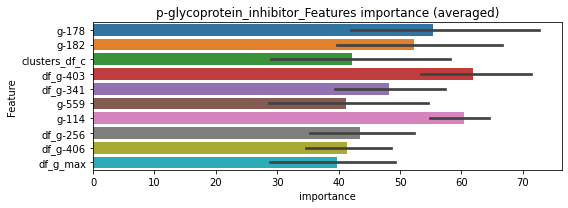

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185473	valid_1's binary_logloss: 0.0294597
[200]	training's binary_logloss: 0.0025009	valid_1's binary_logloss: 0.00870085
[300]	training's binary_logloss: 0.00073779	valid_1's binary_logloss: 0.00509434
[400]	training's binary_logloss: 0.000382687	valid_1's binary_logloss: 0.00428704
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000389946	valid_1's binary_logloss: 0.00425984


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182332	valid_1's binary_logloss: 0.0316239
[200]	training's binary_logloss: 0.00236865	valid_1's binary_logloss: 0.010619
[300]	training's binary_logloss: 0.000685829	valid_1's binary_logloss: 0.00790096
[400]	training's binary_logloss: 0.000367695	valid_1's binary_logloss: 0.00697977
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000374831	valid_1's binary_logloss: 0.00696743


p-glycoprotein_inhibitor logloss: 0.005613635732229605
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118128	valid_1's binary_logloss: 0.261879
[200]	training's binary_logloss: 0.030835	valid_1's binary_logloss: 0.160135
[300]	training's binary_logloss: 0.0105172	valid_1's binary_logloss: 0.1148
[400]	training's binary_logloss: 0.00523821	valid_1's binary_logloss: 0.0981873
[500]	training's binary_logloss: 0.00330949	valid_1's binary_logloss: 0.0920343
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00283208	valid_1's binary_logloss: 0.0892918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123499	valid_1's binary_logloss: 0.263944
[200]	training's binary_logloss: 0.0321599	valid_1's binary_logloss: 0.165868
[300]	training's binary_logloss: 0.0109697	valid_1's binary_logloss: 0.128529
[400]	training's binary_logloss: 0.00530714	valid_1's binary_logloss: 0.111269
[500]	training's binary_logloss: 0.00335741	valid_1's binary_

1 / 3 AUC score:0.995
Threshold: 0.3291792846627114
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentile: 0.01735
p_label_rate: 0.01657 Vs.target_rate: 0.00266, Num_p_label: 66.0, conf_0:0.01735, conf_1:0.43474
Num_p_label: 66.0, Expected: 10.6, Adj_threshold_1: 0.33
Num_p_label: 50.0, Expected: 10.6, Adj_threshold_2: 0.37
Num_p_label: 37.0, Expected: 10.6, Adj_threshold_3: 0.41
Num_p_label: 26.0, Expected: 10.6, Adj_threshold_4: 0.45
Num_p_label: 15.0, Expected: 10.6, Adj_threshold_5: 0.49
threshold:0.49, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116978	valid_1's binary_logloss: 0.260571
[200]	training's binary_logloss: 0.0295304	valid_1's binary_logloss: 0.147252
[300]	training's binary_logloss: 0.010131	valid_1's binary_logloss: 0.106044
[400]	training's binary_logloss: 0.00497613	valid_1's binary_logloss: 0.0859595
[500]	training's binary_logloss: 0.00316655	valid_1's binary_logloss: 0.0777548
[600]	training's binary_logloss: 0.00241722	valid_1's binary_logloss: 0.0728169
[700]	training's binary_logloss: 0.00207483	valid_1's binary_logloss: 0.0706474
Early stopping, best iteration is:
[753]	training's binary_logloss: 0.00202582	valid_1's binary_logloss: 0.0703475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124575	valid_1's binary_logloss: 0.260915
[200]	training's binary_logloss: 0.0310382	valid_1's binary_logloss: 0.140827
[300]	training's binary_logloss: 0.0106625	valid_1's bin

2 / 3 AUC score:0.998
Threshold: 0.4891792846627113
Remove_noisy_labels: 14 → positive_corect_labels: 475.0/950
30th percentile: 0.01416
p_label_rate: 0.01808 Vs.target_rate: 0.00266, Num_p_label: 72.0, conf_0:0.01416, conf_1:0.55942
Num_p_label: 72.0, Expected: 10.6, Adj_threshold_1: 0.49
Num_p_label: 57.0, Expected: 10.6, Adj_threshold_2: 0.53
Num_p_label: 42.0, Expected: 10.6, Adj_threshold_3: 0.57
Num_p_label: 38.0, Expected: 10.6, Adj_threshold_4: 0.61
Num_p_label: 30.0, Expected: 10.6, Adj_threshold_5: 0.65
Num_p_label: 26.0, Expected: 10.6, Adj_threshold_6: 0.69
Num_p_label: 16.0, Expected: 10.6, Adj_threshold_7: 0.73
Num_p_label: 11.0, Expected: 10.6, Adj_threshold_8: 0.77
threshold:0.77, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:475.0/950, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11966	valid_1's binary_logloss: 0.223817
[200]	training's binary_logloss: 0.0303097	valid_1's binary_logloss: 0.111476
[300]	training's binary_logloss: 0.0105046	valid_1's binary_logloss: 0.0711966
[400]	training's binary_logloss: 0.00515061	valid_1's binary_logloss: 0.0541659
[500]	training's binary_logloss: 0.00332532	valid_1's binary_logloss: 0.0466522
[600]	training's binary_logloss: 0.00249957	valid_1's binary_logloss: 0.0416065
[700]	training's binary_logloss: 0.00215076	valid_1's binary_logloss: 0.0399892
Early stopping, best iteration is:
[729]	training's binary_logloss: 0.00210724	valid_1's binary_logloss: 0.0395807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119704	valid_1's binary_logloss: 0.261911
[200]	training's binary_logloss: 0.0293862	valid_1's binary_logloss: 0.155049
[300]	training's binary_logloss: 0.0101513	valid_1's bi

3 / 3 AUC score:0.996
Threshold: 0.7691792846627116
Remove_noisy_labels: 22 → positive_corect_labels: 455.0/928
30th percentile: 0.01347
p_label_rate: 0.00251 Vs.target_rate: 0.00266, Num_p_label: 10.0, conf_0:0.01347, conf_1:0.76918
threshold:0.77, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:465.0/4910, y_label_rate: 0.09470


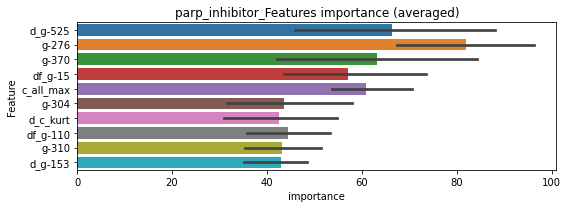

len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275937	valid_1's binary_logloss: 0.072999
[200]	training's binary_logloss: 0.00489387	valid_1's binary_logloss: 0.0420833
[300]	training's binary_logloss: 0.00141668	valid_1's binary_logloss: 0.0366
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00124265	valid_1's binary_logloss: 0.0361306


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297589	valid_1's binary_logloss: 0.0611375
[200]	training's binary_logloss: 0.00547018	valid_1's binary_logloss: 0.0306828
[300]	training's binary_logloss: 0.00163143	valid_1's binary_logloss: 0.0231425
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00113758	valid_1's binary_logloss: 0.0219375


parp_inhibitor logloss: 0.029034047485311344
pdgfr_inhibitor , len(trt) : 297


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208356	valid_1's binary_logloss: 0.589721
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.101422	valid_1's binary_logloss: 0.562043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213655	valid_1's binary_logloss: 0.600507


1 / 3 AUC score:0.754
Threshold: 0.496390505575792
Remove_noisy_labels: 306 → positive_corect_labels: 347/694
30th percentile: 0.37558
p_label_rate: 0.28227 Vs.target_rate: 0.01001, Num_p_label: 1124.0, conf_0:0.37558, conf_1:0.49639
Num_p_label: 1124.0, Expected: 39.9, Adj_threshold_1: 0.50
Num_p_label: 660.0, Expected: 39.9, Adj_threshold_2: 0.54
Num_p_label: 345.0, Expected: 39.9, Adj_threshold_3: 0.58
Num_p_label: 167.0, Expected: 39.9, Adj_threshold_4: 0.62
Num_p_label: 66.0, Expected: 39.9, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 39.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[113]	training's binary_logloss: 0.187437	valid_1's binary_logloss: 0.59229


positive y_label:347.0/694, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192396	valid_1's binary_logloss: 0.531097
[200]	training's binary_logloss: 0.0684825	valid_1's binary_logloss: 0.472917
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0339039	valid_1's binary_logloss: 0.44879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193622	valid_1's binary_logloss: 0.513646
[200]	training's binary_logloss: 0.0697531	valid_1's binary_logloss: 0.451303
[300]	training's binary_logloss: 0.0287754	valid_1's binary_logloss: 0.420766


2 / 3 AUC score:0.879
Threshold: 0.6963905055757922
Remove_noisy_labels: 160 → positive_corect_labels: 207.0/534
30th percentile: 0.23695
p_label_rate: 0.06806 Vs.target_rate: 0.01001, Num_p_label: 271.0, conf_0:0.23695, conf_1:0.69639
Num_p_label: 271.0, Expected: 39.9, Adj_threshold_1: 0.70
Num_p_label: 177.0, Expected: 39.9, Adj_threshold_2: 0.74
Num_p_label: 111.0, Expected: 39.9, Adj_threshold_3: 0.78


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0221692	valid_1's binary_logloss: 0.418331


Num_p_label: 62.0, Expected: 39.9, Adj_threshold_4: 0.82
Num_p_label: 27.0, Expected: 39.9, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:207.0/534, y_label_rate: 0.38764
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160514	valid_1's binary_logloss: 0.34081
[200]	training's binary_logloss: 0.054746	valid_1's binary_logloss: 0.250329
[300]	training's binary_logloss: 0.0221067	valid_1's binary_logloss: 0.213047
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0210564	valid_1's binary_logloss: 0.211253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156156	valid_1's binary_logloss: 0.383684
[200]	training's binary_logloss: 0.0509995	valid_1's binary_logloss: 0.314116
[300]	training's binary_logloss: 0.020155	valid_1's binary_logloss: 0.285813
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0193705	valid_1's binary_logloss: 0.284289


3 / 3 AUC score:0.961
Threshold: 0.8563905055757923
Remove_noisy_labels: 94 → positive_corect_labels: 114.0/440
30th percentile: 0.07540
p_label_rate: 0.00628 Vs.target_rate: 0.01001, Num_p_label: 25.0, conf_0:0.07540, conf_1:0.85639
threshold:0.86, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:139.0/4422, y_label_rate: 0.03143


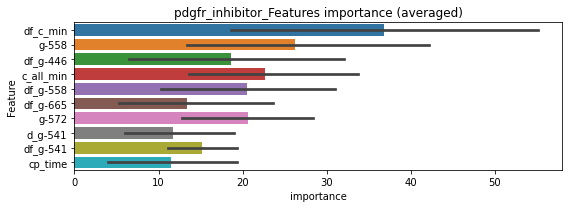

len(train_index) : 2211
len(valid_index) : 2211
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00971477	valid_1's binary_logloss: 0.0834861


len(train_index) : 2211
len(valid_index) : 2211
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[98]	training's binary_logloss: 0.010097	valid_1's binary_logloss: 0.0834481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111304	valid_1's binary_logloss: 0.0848356
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.012646	valid_1's binary_logloss: 0.0844841


pdgfr_inhibitor logloss: 0.08396608717283553
pdk_inhibitor , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647232	valid_1's binary_logloss: 0.105397
[200]	training's binary_logloss: 0.010515	valid_1's binary_logloss: 0.0316308
[300]	training's binary_logloss: 0.00340316	valid_1's binary_logloss: 0.016062
[400]	training's binary_logloss: 0.00186712	valid_1's binary_logloss: 0.011534
[500]	training's binary_logloss: 0.00142343	valid_1's binary_logloss: 0.0098244
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00137884	valid_1's binary_logloss: 0.00951305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625993	valid_1's binary_logloss: 0.105796
[200]	training's binary_logloss: 0.0101552	valid_1's binary_logloss: 0.0360776
[300]	training's binary_logloss: 0.00331156	valid_1's binary_logloss: 0.0188887
[400]	training's binary_logloss: 0.00185253	valid_1's binary_logloss: 0.0137075
[500]	training's binary_logloss: 0.0014236	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.49379975297978196
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00161
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00161, conf_1:0.49380
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633059	valid_1's binary_logloss: 0.0992411
[200]	training's binary_logloss: 0.0103027	valid_1's binary_logloss: 0.0285233
[300]	training's binary_logloss: 0.0033336	valid_1's binary_logloss: 0.0139525
[400]	training's binary_logloss: 0.00185535	valid_1's binary_logloss: 0.0098552
[500]	training's binary_logloss: 0.00141006	valid_1's binary_logloss: 0.00835612
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00137118	valid_1's binary_logloss: 0.0082042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622644	valid_1's binary_logloss: 0.102701
[200]	training's binary_logloss: 0.0103541	valid_1's binary_logloss: 0.0322708
[300]	training's binary_logloss: 0.00334348	valid_1's binary_logloss: 0.0161511
[400]	training's binary_logloss: 0.00184332	valid_1's binary_logloss: 0.0116406
[500]	training's binary_logloss: 0.00143917	vali

2 / 3 AUC score:1.000
Threshold: 0.49379975297978196
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00167
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00167, conf_1:0.49380
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633059	valid_1's binary_logloss: 0.0992411
[200]	training's binary_logloss: 0.0103027	valid_1's binary_logloss: 0.0285233
[300]	training's binary_logloss: 0.0033336	valid_1's binary_logloss: 0.0139525
[400]	training's binary_logloss: 0.00185535	valid_1's binary_logloss: 0.0098552
[500]	training's binary_logloss: 0.00141006	valid_1's binary_logloss: 0.00835612
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00137118	valid_1's binary_logloss: 0.0082042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622644	valid_1's binary_logloss: 0.102701
[200]	training's binary_logloss: 0.0103541	valid_1's binary_logloss: 0.0322708
[300]	training's binary_logloss: 0.00334348	valid_1's binary_logloss: 0.0161511
[400]	training's binary_logloss: 0.00184332	valid_1's binary_logloss: 0.0116406
[500]	training's binary_logloss: 0.00143917	vali

3 / 3 AUC score:1.000
Threshold: 0.49379975297978196
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentile: 0.00167
p_label_rate: 0.00151 Vs.target_rate: 0.00082, Num_p_label: 6.0, conf_0:0.00167, conf_1:0.49380
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:505.0/4980, y_label_rate: 0.10141


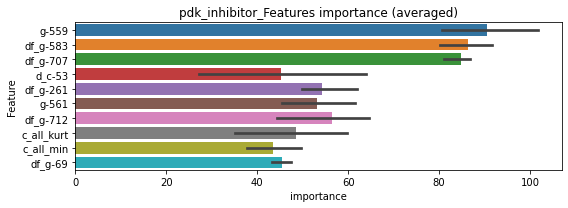

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166124	valid_1's binary_logloss: 0.0306577
[200]	training's binary_logloss: 0.00206	valid_1's binary_logloss: 0.0119691


len(train_index) : 2490
len(valid_index) : 2490


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00130569	valid_1's binary_logloss: 0.0106142


================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165904	valid_1's binary_logloss: 0.023514
[200]	training's binary_logloss: 0.00205552	valid_1's binary_logloss: 0.00603135
[300]	training's binary_logloss: 0.000585908	valid_1's binary_logloss: 0.00396648
[400]	training's binary_logloss: 0.000311656	valid_1's binary_logloss: 0.0037401
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000305577	valid_1's binary_logloss: 0.00373107


pdk_inhibitor logloss: 0.007172634612543138
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20421	valid_1's binary_logloss: 0.595134
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.086238	valid_1's binary_logloss: 0.562142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20679	valid_1's binary_logloss: 0.583384


1 / 3 AUC score:0.766
Threshold: 0.4787556230988146
Remove_noisy_labels: 314 → positive_corect_labels: 343/686


[200]	training's binary_logloss: 0.0756593	valid_1's binary_logloss: 0.559548
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0817094	valid_1's binary_logloss: 0.558645


30th percentile: 0.32856
p_label_rate: 0.24561 Vs.target_rate: 0.00927, Num_p_label: 978.0, conf_0:0.32856, conf_1:0.47876
Num_p_label: 978.0, Expected: 36.9, Adj_threshold_1: 0.48
Num_p_label: 639.0, Expected: 36.9, Adj_threshold_2: 0.52
Num_p_label: 384.0, Expected: 36.9, Adj_threshold_3: 0.56
Num_p_label: 189.0, Expected: 36.9, Adj_threshold_4: 0.60
Num_p_label: 96.0, Expected: 36.9, Adj_threshold_5: 0.64
Num_p_label: 36.0, Expected: 36.9, Adj_threshold_6: 0.68
threshold:0.68, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:343.0/686, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182246	valid_1's binary_logloss: 0.494419
[200]	training's binary_logloss: 0.0621346	valid_1's binary_logloss: 0.431639
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0303293	valid_1's binary_logloss: 0.412663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179501	valid_1's binary_logloss: 0.483437
[200]	training's binary_logloss: 0.061115	valid_1's binary_logloss: 0.421005
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.060409	valid_1's binary_logloss: 0.420524


2 / 3 AUC score:0.891
Threshold: 0.6787556230988148
Remove_noisy_labels: 137 → positive_corect_labels: 231.0/549
30th percentile: 0.25412
p_label_rate: 0.09593 Vs.target_rate: 0.00927, Num_p_label: 382.0, conf_0:0.25412, conf_1:0.67876
Num_p_label: 382.0, Expected: 36.9, Adj_threshold_1: 0.68
Num_p_label: 252.0, Expected: 36.9, Adj_threshold_2: 0.72
Num_p_label: 161.0, Expected: 36.9, Adj_threshold_3: 0.76
Num_p_label: 87.0, Expected: 36.9, Adj_threshold_4: 0.80
Num_p_label: 39.0, Expected: 36.9, Adj_threshold_5: 0.84
threshold:0.84, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:231.0/549, y_label_rate: 0.42077
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157874	valid_1's binary_logloss: 0.36239
[200]	training's binary_logloss: 0.0502788	valid_1's binary_logloss: 0.281402
[300]	training's binary_logloss: 0.0195943	valid_1's binary_logloss: 0.236322
[400]	training's binary_logloss: 0.00980493	valid_1's binary_logloss: 0.216676
[500]	training's binary_logloss: 0.0061856	valid_1's binary_logloss: 0.207577
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00639909	valid_1's binary_logloss: 0.207256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151118	valid_1's binary_logloss: 0.393932
[200]	training's binary_logloss: 0.0465333	valid_1's binary_logloss: 0.337743


3 / 3 AUC score:0.959
Threshold: 0.8387556230988149
Remove_noisy_labels: 87 → positive_corect_labels: 145.0/462
30th percentile: 0.09414
p_label_rate: 0.02235 Vs.target_rate: 0.00927, Num_p_label: 89.0, conf_0:0.06102, conf_1:0.83876
threshold:0.84, positive p_label:89.0/3982, p_label_rate: 0.02235


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0283355	valid_1's binary_logloss: 0.325706


positive y_label:234.0/4444, y_label_rate: 0.05266


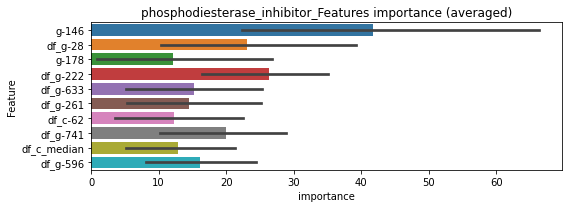

len(train_index) : 2222
len(valid_index) : 2222
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219169	valid_1's binary_logloss: 0.142412


len(train_index) : 2222
len(valid_index) : 2222
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0235743	valid_1's binary_logloss: 0.141936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212016	valid_1's binary_logloss: 0.128243


phosphodiesterase_inhibitor logloss: 0.13465720170004833


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0193038	valid_1's binary_logloss: 0.127378
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734859	valid_1's binary_logloss: 0.12341
[200]	training's binary_logloss: 0.0136872	valid_1's binary_logloss: 0.0429285
[300]	training's binary_logloss: 0.00444692	valid_1's binary_logloss: 0.0224626
[400]	training's binary_logloss: 0.00237156	valid_1's binary_logloss: 0.0164783
[500]	training's binary_logloss: 0.00170778	valid_1's binary_logloss: 0.0140052
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00159584	valid_1's binary_logloss: 0.0134384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757214	valid_1's binary_logloss: 0.127335
[200]	training's binary_logloss: 0.0137863	valid_1's binary_logloss: 0.043995
[300]	training's binary_logloss: 0.00447782	valid_1's binary_logloss: 0.0258131


1 / 3 AUC score:1.000
Threshold: 0.43977044720824326
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00417


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00251509	valid_1's binary_logloss: 0.0199703


p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00417, conf_1:0.43977
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750717	valid_1's binary_logloss: 0.129922
[200]	training's binary_logloss: 0.013915	valid_1's binary_logloss: 0.0480789
[300]	training's binary_logloss: 0.00452569	valid_1's binary_logloss: 0.0259316
[400]	training's binary_logloss: 0.00239746	valid_1's binary_logloss: 0.0185013
[500]	training's binary_logloss: 0.00169483	valid_1's binary_logloss: 0.0154098
[600]	training's binary_logloss: 0.00151252	valid_1's binary_logloss: 0.0144733
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0015195	valid_1's binary_logloss: 0.0144391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738433	valid_1's binary_logloss: 0.132563
[200]	training's binary_logloss: 0.0131987	valid_1's binary_logloss: 0.0521633
[300]	training's binary_logloss: 0.00433425	valid_1's binary_logloss: 0.032339
[400]	training's binary_logloss: 0.00232577	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.43977044720824326
Remove_noisy_labels: 6 → positive_corect_labels: 498.0/992
30th percentile: 0.00330
p_label_rate: 0.00176 Vs.target_rate: 0.00113, Num_p_label: 7.0, conf_0:0.00330, conf_1:0.43977
threshold:0.44, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/992, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721247	valid_1's binary_logloss: 0.126788
[200]	training's binary_logloss: 0.0135599	valid_1's binary_logloss: 0.0462112
[300]	training's binary_logloss: 0.00441531	valid_1's binary_logloss: 0.0251221
[400]	training's binary_logloss: 0.00234342	valid_1's binary_logloss: 0.0173832
[500]	training's binary_logloss: 0.00168004	valid_1's binary_logloss: 0.0143589
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00152707	valid_1's binary_logloss: 0.0135898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758652	valid_1's binary_logloss: 0.125585
[200]	training's binary_logloss: 0.0139459	valid_1's binary_logloss: 0.0449023
[300]	training's binary_logloss: 0.00443056	valid_1's binary_logloss: 0.0258986
[400]	training's binary_logloss: 0.00235007	valid_1's binary_logloss: 0.0201157
Early stopping, best iteration is:
[421]	training

3 / 3 AUC score:1.000
Threshold: 0.43977044720824326
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/991
30th percentile: 0.00352
p_label_rate: 0.00352 Vs.target_rate: 0.00113, Num_p_label: 14.0, conf_0:0.00352, conf_1:0.48980
Num_p_label: 14.0, Expected: 4.5, Adj_threshold_1: 0.44
Num_p_label: 9.0, Expected: 4.5, Adj_threshold_2: 0.48
Num_p_label: 8.0, Expected: 4.5, Adj_threshold_3: 0.52
Num_p_label: 5.0, Expected: 4.5, Adj_threshold_4: 0.56
threshold:0.56, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:503.0/4973, y_label_rate: 0.10115


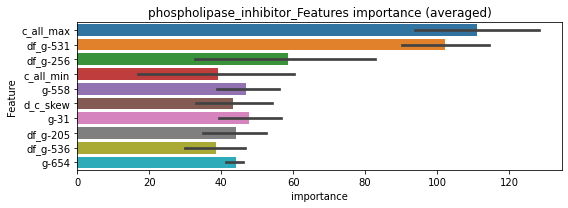

len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019422	valid_1's binary_logloss: 0.0309789
[200]	training's binary_logloss: 0.00270953	valid_1's binary_logloss: 0.00923869
[300]	training's binary_logloss: 0.000756653	valid_1's binary_logloss: 0.00609849
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00045965	valid_1's binary_logloss: 0.00549829


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188069	valid_1's binary_logloss: 0.0314731
[200]	training's binary_logloss: 0.00256894	valid_1's binary_logloss: 0.0109549
[300]	training's binary_logloss: 0.00074575	valid_1's binary_logloss: 0.00833324
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00067974	valid_1's binary_logloss: 0.00813148


phospholipase_inhibitor logloss: 0.006814616781924294
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172687	valid_1's binary_logloss: 0.423985
[200]	training's binary_logloss: 0.0556144	valid_1's binary_logloss: 0.339551
[300]	training's binary_logloss: 0.0219978	valid_1's binary_logloss: 0.303618
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.014666	valid_1's binary_logloss: 0.29418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171384	valid_1's binary_logloss: 0.43248
[200]	training's binary_logloss: 0.0560124	valid_1's binary_logloss: 0.358656
[300]	training's binary_logloss: 0.0218095	valid_1's binary_logloss: 0.328514


1 / 3 AUC score:0.939
Threshold: 0.4908024003499515


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0177379	valid_1's binary_logloss: 0.322469


Remove_noisy_labels: 124 → positive_corect_labels: 438/876
30th percentile: 0.15383
p_label_rate: 0.08036 Vs.target_rate: 0.00602, Num_p_label: 320.0, conf_0:0.15383, conf_1:0.51380
Num_p_label: 320.0, Expected: 24.0, Adj_threshold_1: 0.49
Num_p_label: 220.0, Expected: 24.0, Adj_threshold_2: 0.53
Num_p_label: 130.0, Expected: 24.0, Adj_threshold_3: 0.57
Num_p_label: 84.0, Expected: 24.0, Adj_threshold_4: 0.61
Num_p_label: 49.0, Expected: 24.0, Adj_threshold_5: 0.65
Num_p_label: 26.0, Expected: 24.0, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:438.0/876, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15109	valid_1's binary_logloss: 0.385896
[200]	training's binary_logloss: 0.0465362	valid_1's binary_logloss: 0.304086
[300]	training's binary_logloss: 0.0175064	valid_1's binary_logloss: 0.263883
[400]	training's binary_logloss: 0.00853905	valid_1's binary_logloss: 0.245286
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00577198	valid_1's binary_logloss: 0.237814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15489	valid_1's binary_logloss: 0.407588
[200]	training's binary_logloss: 0.0466836	valid_1's binary_logloss: 0.326187
[300]	training's binary_logloss: 0.0176254	valid_1's binary_logloss: 0.298203
[400]	training's binary_logloss: 0.00856328	valid_1's binary_logloss: 0.282409
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00771161	valid_1's binary_logloss: 0.280495


2 / 3 AUC score:0.954
Threshold: 0.6908024003499517
Remove_noisy_labels: 98 → positive_corect_labels: 347.0/778
30th percentile: 0.09601
p_label_rate: 0.01657 Vs.target_rate: 0.00602, Num_p_label: 66.0, conf_0:0.09601, conf_1:0.69080
threshold:0.69, positive p_label:66.0/3982, p_label_rate: 0.01657
positive y_label:347.0/778, y_label_rate: 0.44602
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141815	valid_1's binary_logloss: 0.323238
[200]	training's binary_logloss: 0.0417507	valid_1's binary_logloss: 0.214139
[300]	training's binary_logloss: 0.0155156	valid_1's binary_logloss: 0.174018
[400]	training's binary_logloss: 0.0076007	valid_1's binary_logloss: 0.155775
[500]	training's binary_logloss: 0.00475569	valid_1's binary_logloss: 0.144894
[600]	training's binary_logloss: 0.00351343	valid_1's binary_logloss: 0.138952
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.00348673	valid_1's binary_logloss: 0.138943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137837	valid_1's binary_logloss: 0.327302
[200]	training's binary_logloss: 0.0405097	valid_1's binary_logloss: 0.23047
[300]	training's binary_logloss: 0.0150487	valid_1's binary_logloss: 0.191645
[400]	training's binary_logloss: 0.00754639	valid_1's binary_lo

3 / 3 AUC score:0.986
Threshold: 0.6908024003499517
Remove_noisy_labels: 54 → positive_corect_labels: 296.0/724
30th percentile: 0.03979
p_label_rate: 0.00854 Vs.target_rate: 0.00602, Num_p_label: 34.0, conf_0:0.02119, conf_1:0.69080
threshold:0.69, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:330.0/4706, y_label_rate: 0.07012


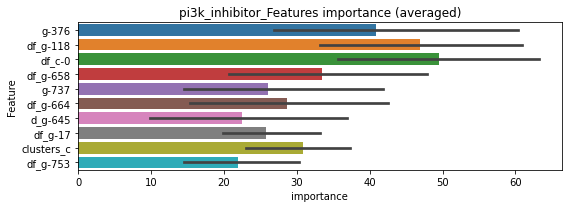

len(train_index) : 2353
len(valid_index) : 2353
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269423	valid_1's binary_logloss: 0.0967131
[200]	training's binary_logloss: 0.00628948	valid_1's binary_logloss: 0.0812193
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0051243	valid_1's binary_logloss: 0.0802274


len(train_index) : 2353
len(valid_index) : 2353
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312107	valid_1's binary_logloss: 0.104961


pi3k_inhibitor logloss: 0.08727775064055122


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0142413	valid_1's binary_logloss: 0.0943281


pkc_inhibitor , len(trt) : 31


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858425	valid_1's binary_logloss: 0.149808
[200]	training's binary_logloss: 0.0171379	valid_1's binary_logloss: 0.0617704
[300]	training's binary_logloss: 0.00568452	valid_1's binary_logloss: 0.0350586
[400]	training's binary_logloss: 0.00298591	valid_1's binary_logloss: 0.026069
[500]	training's binary_logloss: 0.00203971	valid_1's binary_logloss: 0.0224677
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00172563	valid_1's binary_logloss: 0.0208342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833477	valid_1's binary_logloss: 0.159925
[200]	training's binary_logloss: 0.0171104	valid_1's binary_logloss: 0.069241
[300]	training's binary_logloss: 0.00553245	valid_1's binary_logloss: 0.0410115
[400]	training's binary_logloss: 0.00286815	valid_1's binary_logloss: 0.0311447
[500]	training's binary_logloss: 0.00198339	valid_1

1 / 3 AUC score:1.000
Threshold: 0.4747587840661615
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00449
p_label_rate: 0.00176 Vs.target_rate: 0.00139, Num_p_label: 7.0, conf_0:0.00449, conf_1:0.47476
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836406	valid_1's binary_logloss: 0.147686
[200]	training's binary_logloss: 0.0172503	valid_1's binary_logloss: 0.0638609
[300]	training's binary_logloss: 0.0056182	valid_1's binary_logloss: 0.0365999
[400]	training's binary_logloss: 0.00288242	valid_1's binary_logloss: 0.0267747
[500]	training's binary_logloss: 0.0019784	valid_1's binary_logloss: 0.0223765
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.001685	valid_1's binary_logloss: 0.0204079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824294	valid_1's binary_logloss: 0.150778
[200]	training's binary_logloss: 0.0167275	valid_1's binary_logloss: 0.0638626
[300]	training's binary_logloss: 0.00555826	valid_1's binary_logloss: 0.0397322
[400]	training's binary_logloss: 0.00287639	valid_1's binary_logloss: 0.0306214
[500]	training's binary_logloss: 0.00199648	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.4747587840661615
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/993
30th percentile: 0.00436
p_label_rate: 0.00201 Vs.target_rate: 0.00139, Num_p_label: 8.0, conf_0:0.00436, conf_1:0.47476
threshold:0.47, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808609	valid_1's binary_logloss: 0.145541
[200]	training's binary_logloss: 0.016554	valid_1's binary_logloss: 0.0587198
[300]	training's binary_logloss: 0.0053987	valid_1's binary_logloss: 0.0330337
[400]	training's binary_logloss: 0.00280138	valid_1's binary_logloss: 0.0241964
[500]	training's binary_logloss: 0.0019421	valid_1's binary_logloss: 0.0196976
[600]	training's binary_logloss: 0.00164631	valid_1's binary_logloss: 0.0178934
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00163896	valid_1's binary_logloss: 0.0178164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828155	valid_1's binary_logloss: 0.132714
[200]	training's binary_logloss: 0.0169024	valid_1's binary_logloss: 0.0500232
[300]	training's binary_logloss: 0.00549138	valid_1's binary_logloss: 0.0262203
[400]	training's binary_logloss: 0.00285652	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.4747587840661615
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/992
30th percentile: 0.00349
p_label_rate: 0.00276 Vs.target_rate: 0.00139, Num_p_label: 11.0, conf_0:0.00349, conf_1:0.47476
threshold:0.47, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:506.0/4974, y_label_rate: 0.10173


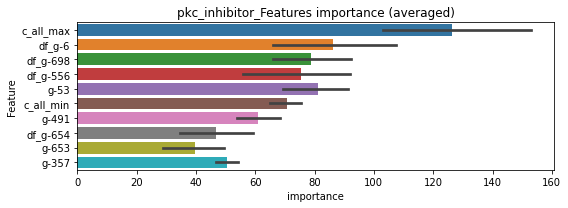

len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208764	valid_1's binary_logloss: 0.0390695
[200]	training's binary_logloss: 0.00311647	valid_1's binary_logloss: 0.0185582
[300]	training's binary_logloss: 0.000919661	valid_1's binary_logloss: 0.0154642
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000752996	valid_1's binary_logloss: 0.0152898


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020701	valid_1's binary_logloss: 0.0475403
[200]	training's binary_logloss: 0.00307327	valid_1's binary_logloss: 0.0281216
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00109659	valid_1's binary_logloss: 0.0246796


pkc_inhibitor logloss: 0.01998467974580651
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106866	valid_1's binary_logloss: 0.219529
[200]	training's binary_logloss: 0.0266983	valid_1's binary_logloss: 0.132481
[300]	training's binary_logloss: 0.00927035	valid_1's binary_logloss: 0.0976615
[400]	training's binary_logloss: 0.00460495	valid_1's binary_logloss: 0.0849905
[500]	training's binary_logloss: 0.00296194	valid_1's binary_logloss: 0.0793406
[600]	training's binary_logloss: 0.00227842	valid_1's binary_logloss: 0.0760206
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00222166	valid_1's binary_logloss: 0.0755119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109239	valid_1's binary_logloss: 0.217306
[200]	training's binary_logloss: 0.0279659	valid_1's binary_logloss: 0.118226
[300]	training's binary_logloss: 0.00987763	valid_1's binary_logloss: 0.0804133
[400]	training's binary_logloss: 0.00486952	valid_1's

1 / 3 AUC score:0.998
Threshold: 0.4183736968610328
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentile: 0.01173
p_label_rate: 0.01331 Vs.target_rate: 0.00241, Num_p_label: 53.0, conf_0:0.01173, conf_1:0.44991
Num_p_label: 53.0, Expected: 9.6, Adj_threshold_1: 0.42
Num_p_label: 36.0, Expected: 9.6, Adj_threshold_2: 0.46
Num_p_label: 23.0, Expected: 9.6, Adj_threshold_3: 0.50
Num_p_label: 18.0, Expected: 9.6, Adj_threshold_4: 0.54
Num_p_label: 14.0, Expected: 9.6, Adj_threshold_5: 0.58
threshold:0.58, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101029	valid_1's binary_logloss: 0.214732
[200]	training's binary_logloss: 0.0246303	valid_1's binary_logloss: 0.127177
[300]	training's binary_logloss: 0.00855955	valid_1's binary_logloss: 0.0904128
[400]	training's binary_logloss: 0.00430016	valid_1's binary_logloss: 0.0754054
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00307647	valid_1's binary_logloss: 0.0691495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103702	valid_1's binary_logloss: 0.202596
[200]	training's binary_logloss: 0.0250116	valid_1's binary_logloss: 0.109052
[300]	training's binary_logloss: 0.00868184	valid_1's binary_logloss: 0.0767665
[400]	training's binary_logloss: 0.00437968	valid_1's binary_logloss: 0.0649978
[500]	training's binary_logloss: 0.00287703	valid_1's binary_logloss: 0.0583283
[600]	training's binary_logloss: 0.00223802	valid_1's

2 / 3 AUC score:0.998
Threshold: 0.5783736968610328
Remove_noisy_labels: 25 → positive_corect_labels: 467.0/955
30th percentile: 0.01100
p_label_rate: 0.01331 Vs.target_rate: 0.00241, Num_p_label: 53.0, conf_0:0.01100, conf_1:0.57837
Num_p_label: 53.0, Expected: 9.6, Adj_threshold_1: 0.58
Num_p_label: 46.0, Expected: 9.6, Adj_threshold_2: 0.62
Num_p_label: 36.0, Expected: 9.6, Adj_threshold_3: 0.66
Num_p_label: 31.0, Expected: 9.6, Adj_threshold_4: 0.70
Num_p_label: 26.0, Expected: 9.6, Adj_threshold_5: 0.74
Num_p_label: 21.0, Expected: 9.6, Adj_threshold_6: 0.78
Num_p_label: 13.0, Expected: 9.6, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:467.0/955, y_label_rate: 0.48901
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966185	valid_1's binary_logloss: 0.199125
[200]	training's binary_logloss: 0.0220366	valid_1's binary_logloss: 0.107497
[300]	training's binary_logloss: 0.00768563	valid_1's binary_logloss: 0.0822364
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00710731	valid_1's binary_logloss: 0.0810486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100594	valid_1's binary_logloss: 0.183913
[200]	training's binary_logloss: 0.0240725	valid_1's binary_logloss: 0.0859937
[300]	training's binary_logloss: 0.00830406	valid_1's binary_logloss: 0.0548154
[400]	training's binary_logloss: 0.00428302	valid_1's binary_logloss: 0.0428045
[500]	training's binary_logloss: 0.00283021	valid_1's binary_logloss: 0.0376433
[600]	training's binary_logloss: 0.00219541	valid_1's binary_logloss: 0.0348495
Early stopping, best iteration is:
[611]	training's

3 / 3 AUC score:0.999
Threshold: 0.818373696861033
Remove_noisy_labels: 28 → positive_corect_labels: 439.0/927
30th percentile: 0.01216
p_label_rate: 0.00653 Vs.target_rate: 0.00241, Num_p_label: 26.0, conf_0:0.01216, conf_1:0.81837
threshold:0.82, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:465.0/4909, y_label_rate: 0.09472


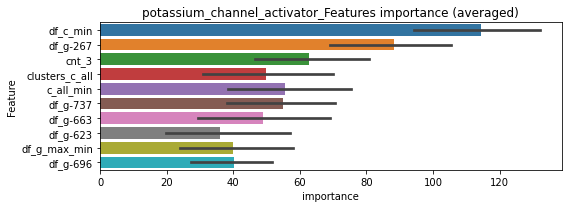

len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203855	valid_1's binary_logloss: 0.0500585
[200]	training's binary_logloss: 0.00359014	valid_1's binary_logloss: 0.0289678
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00173958	valid_1's binary_logloss: 0.0259385


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214369	valid_1's binary_logloss: 0.0448811
[200]	training's binary_logloss: 0.00373574	valid_1's binary_logloss: 0.0223265
[300]	training's binary_logloss: 0.00123252	valid_1's binary_logloss: 0.0182254
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00074926	valid_1's binary_logloss: 0.01721


potassium_channel_activator logloss: 0.021575122658445387
potassium_channel_antagonist , len(trt) : 98


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14181	valid_1's binary_logloss: 0.336683
[200]	training's binary_logloss: 0.0420087	valid_1's binary_logloss: 0.241202
[300]	training's binary_logloss: 0.0155983	valid_1's binary_logloss: 0.198161
[400]	training's binary_logloss: 0.00763252	valid_1's binary_logloss: 0.176933
[500]	training's binary_logloss: 0.0046625	valid_1's binary_logloss: 0.165189
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00419181	valid_1's binary_logloss: 0.161939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141473	valid_1's binary_logloss: 0.319042
[200]	training's binary_logloss: 0.0425732	valid_1's binary_logloss: 0.224829
[300]	training's binary_logloss: 0.0155491	valid_1's binary_logloss: 0.18232
[400]	training's binary_logloss: 0.00744651	valid_1's binary_logloss: 0.163482
[500]	training's binary_logloss: 0.00458562	valid_1's binary_log

1 / 3 AUC score:0.983
Threshold: 0.3802960638319338
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentile: 0.05648
p_label_rate: 0.03340 Vs.target_rate: 0.00412, Num_p_label: 133.0, conf_0:0.05648, conf_1:0.47292
Num_p_label: 133.0, Expected: 16.4, Adj_threshold_1: 0.38
Num_p_label: 85.0, Expected: 16.4, Adj_threshold_2: 0.42
Num_p_label: 52.0, Expected: 16.4, Adj_threshold_3: 0.46
Num_p_label: 36.0, Expected: 16.4, Adj_threshold_4: 0.50
Num_p_label: 22.0, Expected: 16.4, Adj_threshold_5: 0.54
threshold:0.54, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131342	valid_1's binary_logloss: 0.299098
[200]	training's binary_logloss: 0.0362597	valid_1's binary_logloss: 0.202248
[300]	training's binary_logloss: 0.013204	valid_1's binary_logloss: 0.167984
[400]	training's binary_logloss: 0.00656775	valid_1's binary_logloss: 0.151272
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00533941	valid_1's binary_logloss: 0.146712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133987	valid_1's binary_logloss: 0.32191
[200]	training's binary_logloss: 0.036653	valid_1's binary_logloss: 0.213492
[300]	training's binary_logloss: 0.0132827	valid_1's binary_logloss: 0.177552
[400]	training's binary_logloss: 0.00650333	valid_1's binary_logloss: 0.162573
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0047293	valid_1's binary_logloss: 0.157814


2 / 3 AUC score:0.985
Threshold: 0.5402960638319338
Remove_noisy_labels: 46 → positive_corect_labels: 437.0/902
30th percentile: 0.04970
p_label_rate: 0.00628 Vs.target_rate: 0.00412, Num_p_label: 25.0, conf_0:0.04970, conf_1:0.54030
threshold:0.54, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:437.0/902, y_label_rate: 0.48448
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123123	valid_1's binary_logloss: 0.269012
[200]	training's binary_logloss: 0.0315607	valid_1's binary_logloss: 0.168281
[300]	training's binary_logloss: 0.0115651	valid_1's binary_logloss: 0.135401
[400]	training's binary_logloss: 0.00576688	valid_1's binary_logloss: 0.120755
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00498408	valid_1's binary_logloss: 0.120151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124673	valid_1's binary_logloss: 0.275356
[200]	training's binary_logloss: 0.033786	valid_1's binary_logloss: 0.173754
[300]	training's binary_logloss: 0.0120265	valid_1's binary_logloss: 0.132088
[400]	training's binary_logloss: 0.00601323	valid_1's binary_logloss: 0.115653
[500]	training's binary_logloss: 0.00386672	valid_1's binary_logloss: 0.107932
[600]	training's binary_logloss: 0.00290116	valid_1's binary_l

3 / 3 AUC score:0.994
Threshold: 0.5402960638319338
Remove_noisy_labels: 38 → positive_corect_labels: 401.0/864
30th percentile: 0.02763
p_label_rate: 0.00402 Vs.target_rate: 0.00412, Num_p_label: 16.0, conf_0:0.02763, conf_1:0.54030
threshold:0.54, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:417.0/4846, y_label_rate: 0.08605


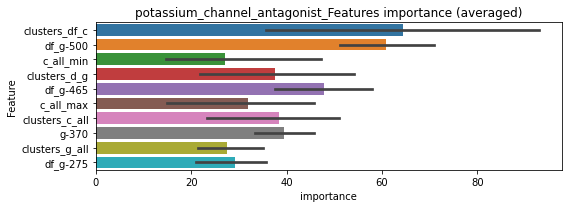

len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262492	valid_1's binary_logloss: 0.0823803


len(train_index) : 2423
len(valid_index) : 2423


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00867514	valid_1's binary_logloss: 0.067176


================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271588	valid_1's binary_logloss: 0.0704642
[200]	training's binary_logloss: 0.00556166	valid_1's binary_logloss: 0.050613
[300]	training's binary_logloss: 0.0016924	valid_1's binary_logloss: 0.0458509
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00174327	valid_1's binary_logloss: 0.0458127


potassium_channel_antagonist logloss: 0.05649435553550345
ppar_receptor_agonist , len(trt) : 115


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156449	valid_1's binary_logloss: 0.371132
[200]	training's binary_logloss: 0.0475624	valid_1's binary_logloss: 0.276527
[300]	training's binary_logloss: 0.0181288	valid_1's binary_logloss: 0.237224
[400]	training's binary_logloss: 0.00877794	valid_1's binary_logloss: 0.217398
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00640036	valid_1's binary_logloss: 0.210013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154991	valid_1's binary_logloss: 0.365508
[200]	training's binary_logloss: 0.0475657	valid_1's binary_logloss: 0.269931
[300]	training's binary_logloss: 0.017805	valid_1's binary_logloss: 0.234122


1 / 3 AUC score:0.969
Threshold: 0.41122210447740426


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0159171	valid_1's binary_logloss: 0.231806


Remove_noisy_labels: 86 → positive_corect_labels: 457/914
30th percentile: 0.08804
p_label_rate: 0.06680 Vs.target_rate: 0.00476, Num_p_label: 266.0, conf_0:0.08804, conf_1:0.55054
Num_p_label: 266.0, Expected: 18.9, Adj_threshold_1: 0.41
Num_p_label: 192.0, Expected: 18.9, Adj_threshold_2: 0.45
Num_p_label: 134.0, Expected: 18.9, Adj_threshold_3: 0.49
Num_p_label: 92.0, Expected: 18.9, Adj_threshold_4: 0.53
Num_p_label: 59.0, Expected: 18.9, Adj_threshold_5: 0.57
Num_p_label: 40.0, Expected: 18.9, Adj_threshold_6: 0.61
Num_p_label: 24.0, Expected: 18.9, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:457.0/914, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140466	valid_1's binary_logloss: 0.326097
[200]	training's binary_logloss: 0.0408797	valid_1's binary_logloss: 0.240199
[300]	training's binary_logloss: 0.0148398	valid_1's binary_logloss: 0.205034
[400]	training's binary_logloss: 0.00731691	valid_1's binary_logloss: 0.192881
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00493995	valid_1's binary_logloss: 0.187109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143849	valid_1's binary_logloss: 0.362017
[200]	training's binary_logloss: 0.0413257	valid_1's binary_logloss: 0.253949
[300]	training's binary_logloss: 0.015336	valid_1's binary_logloss: 0.206856
[400]	training's binary_logloss: 0.00746603	valid_1's binary_logloss: 0.187461
[500]	training's binary_logloss: 0.00463223	valid_1's binary_logloss: 0.176298
Early stopping, best iteration is:
[571]	training's binary_log

2 / 3 AUC score:0.979
Threshold: 0.6512221044774044
Remove_noisy_labels: 63 → positive_corect_labels: 401.0/851
30th percentile: 0.05087
p_label_rate: 0.01381 Vs.target_rate: 0.00476, Num_p_label: 55.0, conf_0:0.05087, conf_1:0.65122
threshold:0.65, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:401.0/851, y_label_rate: 0.47121
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135023	valid_1's binary_logloss: 0.298345
[200]	training's binary_logloss: 0.0370599	valid_1's binary_logloss: 0.190637
[300]	training's binary_logloss: 0.0134392	valid_1's binary_logloss: 0.147013
[400]	training's binary_logloss: 0.00662278	valid_1's binary_logloss: 0.129976
[500]	training's binary_logloss: 0.00420496	valid_1's binary_logloss: 0.119705
[600]	training's binary_logloss: 0.00311681	valid_1's binary_logloss: 0.113535
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00269803	valid_1's binary_logloss: 0.109947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137067	valid_1's binary_logloss: 0.291466
[200]	training's binary_logloss: 0.0385724	valid_1's binary_logloss: 0.188936
[300]	training's binary_logloss: 0.0136643	valid_1's binary_logloss: 0.146006
[400]	training's binary_logloss: 0.00670861	valid_1's binary_

3 / 3 AUC score:0.994
Threshold: 0.6512221044774044
Remove_noisy_labels: 35 → positive_corect_labels: 368.0/816
30th percentile: 0.02953
p_label_rate: 0.01080 Vs.target_rate: 0.00476, Num_p_label: 43.0, conf_0:0.02278, conf_1:0.65122
threshold:0.65, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:411.0/4798, y_label_rate: 0.08566


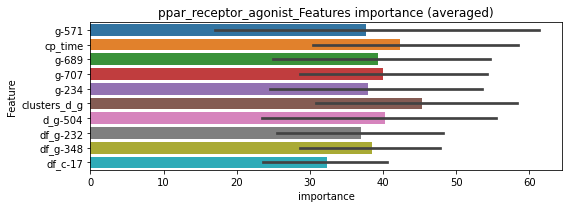

len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349217	valid_1's binary_logloss: 0.104203
[200]	training's binary_logloss: 0.00732405	valid_1's binary_logloss: 0.081862
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00482416	valid_1's binary_logloss: 0.0796891


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360759	valid_1's binary_logloss: 0.10733
[200]	training's binary_logloss: 0.00786523	valid_1's binary_logloss: 0.0842278
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0045645	valid_1's binary_logloss: 0.0818953


ppar_receptor_agonist logloss: 0.08079219861248807
ppar_receptor_antagonist , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793967	valid_1's binary_logloss: 0.137829
[200]	training's binary_logloss: 0.0152657	valid_1's binary_logloss: 0.0528365
[300]	training's binary_logloss: 0.00494653	valid_1's binary_logloss: 0.0300275
[400]	training's binary_logloss: 0.00259137	valid_1's binary_logloss: 0.022717
[500]	training's binary_logloss: 0.00180283	valid_1's binary_logloss: 0.0195936
[600]	training's binary_logloss: 0.00154204	valid_1's binary_logloss: 0.0182226
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00148705	valid_1's binary_logloss: 0.0179243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819324	valid_1's binary_logloss: 0.138764
[200]	training's binary_logloss: 0.0153017	valid_1's binary_logloss: 0.053886
[300]	training's binary_logloss: 0.00496485	valid_1's binary_logloss: 0.032185
[400]	training's binary_logloss: 0.00259036	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.44543657672657283
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00415
p_label_rate: 0.00126 Vs.target_rate: 0.00135, Num_p_label: 5.0, conf_0:0.00415, conf_1:0.44544
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814861	valid_1's binary_logloss: 0.130172
[200]	training's binary_logloss: 0.0155274	valid_1's binary_logloss: 0.0460313
[300]	training's binary_logloss: 0.00506462	valid_1's binary_logloss: 0.0251858
[400]	training's binary_logloss: 0.00264369	valid_1's binary_logloss: 0.0189288
[500]	training's binary_logloss: 0.00182627	valid_1's binary_logloss: 0.0164802
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00156729	valid_1's binary_logloss: 0.0154117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779447	valid_1's binary_logloss: 0.13173
[200]	training's binary_logloss: 0.0152851	valid_1's binary_logloss: 0.0459643
[300]	training's binary_logloss: 0.00495001	valid_1's binary_logloss: 0.023931
[400]	training's binary_logloss: 0.00260115	valid_1's binary_logloss: 0.0172439
[500]	training's binary_logloss: 0.00180314	valid_1

2 / 3 AUC score:1.000
Threshold: 0.44543657672657283
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
30th percentile: 0.00423
p_label_rate: 0.00050 Vs.target_rate: 0.00135, Num_p_label: 2.0, conf_0:0.00423, conf_1:0.44544
threshold:0.45, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078623	valid_1's binary_logloss: 0.132089
[200]	training's binary_logloss: 0.0152286	valid_1's binary_logloss: 0.0474964
[300]	training's binary_logloss: 0.00494616	valid_1's binary_logloss: 0.0265299
[400]	training's binary_logloss: 0.00257734	valid_1's binary_logloss: 0.0201844
[500]	training's binary_logloss: 0.00177502	valid_1's binary_logloss: 0.0175828
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00165523	valid_1's binary_logloss: 0.0168953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789403	valid_1's binary_logloss: 0.131627
[200]	training's binary_logloss: 0.0154556	valid_1's binary_logloss: 0.0463246
[300]	training's binary_logloss: 0.00502921	valid_1's binary_logloss: 0.0247114
[400]	training's binary_logloss: 0.00261586	valid_1's binary_logloss: 0.0173717
[500]	training's binary_logloss: 0.00180926	valid_

3 / 3 AUC score:1.000
Threshold: 0.44543657672657283
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/994
30th percentile: 0.00432
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00432, conf_1:0.44544
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:502.0/4976, y_label_rate: 0.10088


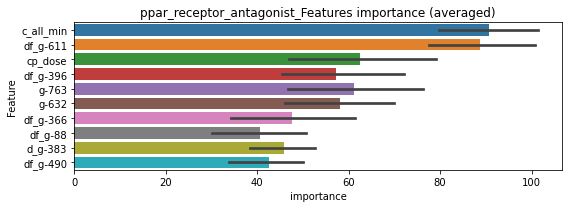

len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197849	valid_1's binary_logloss: 0.0360196
[200]	training's binary_logloss: 0.00275218	valid_1's binary_logloss: 0.0111933
[300]	training's binary_logloss: 0.000816255	valid_1's binary_logloss: 0.00707054
[400]	training's binary_logloss: 0.000433113	valid_1's binary_logloss: 0.00584334
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00033648	valid_1's binary_logloss: 0.00549115


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196592	valid_1's binary_logloss: 0.0423295
[200]	training's binary_logloss: 0.00271801	valid_1's binary_logloss: 0.0222075
[300]	training's binary_logloss: 0.000778546	valid_1's binary_logloss: 0.0197297
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000836814	valid_1's binary_logloss: 0.0195942


ppar_receptor_antagonist logloss: 0.012542695107177204
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160946	valid_1's binary_logloss: 0.39782
[200]	training's binary_logloss: 0.0508526	valid_1's binary_logloss: 0.308071
[300]	training's binary_logloss: 0.0195226	valid_1's binary_logloss: 0.267366
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0131026	valid_1's binary_logloss: 0.256553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150706	valid_1's binary_logloss: 0.400109
[200]	training's binary_logloss: 0.0467684	valid_1's binary_logloss: 0.322513
[300]	training's binary_logloss: 0.0177254	valid_1's binary_logloss: 0.292156
[400]	training's binary_logloss: 0.00863702	valid_1's binary_logloss: 0.280088
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00739924	valid_1's binary_logloss: 0.277485


1 / 3 AUC score:0.945
Threshold: 0.37940755661511383
Remove_noisy_labels: 102 → positive_corect_labels: 449/898
30th percentile: 0.10385
p_label_rate: 0.08790 Vs.target_rate: 0.00490, Num_p_label: 350.0, conf_0:0.10385, conf_1:0.47945
Num_p_label: 350.0, Expected: 19.5, Adj_threshold_1: 0.38
Num_p_label: 248.0, Expected: 19.5, Adj_threshold_2: 0.42
Num_p_label: 162.0, Expected: 19.5, Adj_threshold_3: 0.46
Num_p_label: 111.0, Expected: 19.5, Adj_threshold_4: 0.50
Num_p_label: 76.0, Expected: 19.5, Adj_threshold_5: 0.54
Num_p_label: 47.0, Expected: 19.5, Adj_threshold_6: 0.58
Num_p_label: 32.0, Expected: 19.5, Adj_threshold_7: 0.62
Num_p_label: 15.0, Expected: 19.5, Adj_threshold_8: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:449.0/898, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148734	valid_1's binary_logloss: 0.331147
[200]	training's binary_logloss: 0.0447376	valid_1's binary_logloss: 0.236708
[300]	training's binary_logloss: 0.0167584	valid_1's binary_logloss: 0.200818
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00974287	valid_1's binary_logloss: 0.186451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148806	valid_1's binary_logloss: 0.336796
[200]	training's binary_logloss: 0.0441564	valid_1's binary_logloss: 0.239859
[300]	training's binary_logloss: 0.0163694	valid_1's binary_logloss: 0.2018
[400]	training's binary_logloss: 0.00800828	valid_1's binary_logloss: 0.185953
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00712022	valid_1's binary_logloss: 0.183852


2 / 3 AUC score:0.979
Threshold: 0.6594075566151139
Remove_noisy_labels: 63 → positive_corect_labels: 394.0/835
30th percentile: 0.07753
p_label_rate: 0.02436 Vs.target_rate: 0.00490, Num_p_label: 97.0, conf_0:0.07753, conf_1:0.65941
Num_p_label: 97.0, Expected: 19.5, Adj_threshold_1: 0.66
Num_p_label: 78.0, Expected: 19.5, Adj_threshold_2: 0.70
Num_p_label: 46.0, Expected: 19.5, Adj_threshold_3: 0.74
Num_p_label: 30.0, Expected: 19.5, Adj_threshold_4: 0.78
Num_p_label: 16.0, Expected: 19.5, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:394.0/835, y_label_rate: 0.47186
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133888	valid_1's binary_logloss: 0.3072
[200]	training's binary_logloss: 0.0384769	valid_1's binary_logloss: 0.194082
[300]	training's binary_logloss: 0.0143375	valid_1's binary_logloss: 0.149704
[400]	training's binary_logloss: 0.00710467	valid_1's binary_logloss: 0.127921
[500]	training's binary_logloss: 0.00444076	valid_1's binary_logloss: 0.115993
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00423513	valid_1's binary_logloss: 0.115024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136859	valid_1's binary_logloss: 0.328494
[200]	training's binary_logloss: 0.0385032	valid_1's binary_logloss: 0.228752
[300]	training's binary_logloss: 0.0137685	valid_1's binary_logloss: 0.19154
[400]	training's binary_logloss: 0.00660352	valid_1's binary_logloss: 0.174036
Early stopping, best iteration is:
[429]	training's binary_loglo

3 / 3 AUC score:0.991
Threshold: 0.819407556615114
Remove_noisy_labels: 80 → positive_corect_labels: 315.0/755
30th percentile: 0.03693
p_label_rate: 0.00402 Vs.target_rate: 0.00490, Num_p_label: 16.0, conf_0:0.03693, conf_1:0.81941
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:331.0/4737, y_label_rate: 0.06988


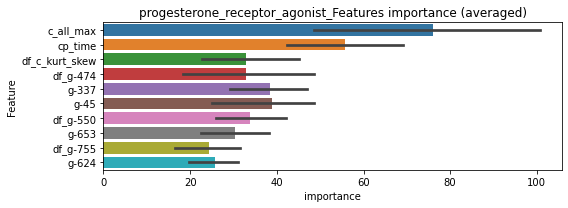

len(train_index) : 2368
len(valid_index) : 2369
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237949	valid_1's binary_logloss: 0.0711821
[200]	training's binary_logloss: 0.00482607	valid_1's binary_logloss: 0.053919
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00275201	valid_1's binary_logloss: 0.0516995


len(train_index) : 2369
len(valid_index) : 2368
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239315	valid_1's binary_logloss: 0.0783406
[200]	training's binary_logloss: 0.00487817	valid_1's binary_logloss: 0.0615087
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00278193	valid_1's binary_logloss: 0.0597905


progesterone_receptor_agonist logloss: 0.05574416429425204
progesterone_receptor_antagonist , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634352	valid_1's binary_logloss: 0.101459
[200]	training's binary_logloss: 0.0105782	valid_1's binary_logloss: 0.0343513
[300]	training's binary_logloss: 0.0033701	valid_1's binary_logloss: 0.0220616
[400]	training's binary_logloss: 0.00184727	valid_1's binary_logloss: 0.0176866
[500]	training's binary_logloss: 0.00139052	valid_1's binary_logloss: 0.0161179
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0014011	valid_1's binary_logloss: 0.0160879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608858	valid_1's binary_logloss: 0.111861
[200]	training's binary_logloss: 0.00999756	valid_1's binary_logloss: 0.0387304
[300]	training's binary_logloss: 0.00319983	valid_1's binary_logloss: 0.0221751
[400]	training's binary_logloss: 0.00174727	valid_1's binary_logloss: 0.0159633
Early stopping, best iteration is:
[460]	training'

1 / 3 AUC score:1.000
Threshold: 0.33354998801420044
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00220
p_label_rate: 0.00427 Vs.target_rate: 0.00082, Num_p_label: 17.0, conf_0:0.00220, conf_1:0.35463
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_1: 0.33
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_2: 0.37
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_3: 0.41
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_4: 0.45
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_5: 0.49
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_6: 0.53
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605848	valid_1's binary_logloss: 0.10452
[200]	training's binary_logloss: 0.00983401	valid_1's binary_logloss: 0.0315229
[300]	training's binary_logloss: 0.00318448	valid_1's binary_logloss: 0.0173028
[400]	training's binary_logloss: 0.00178973	valid_1's binary_logloss: 0.0131042
[500]	training's binary_logloss: 0.00137509	valid_1's binary_logloss: 0.0116944
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00129739	valid_1's binary_logloss: 0.0111845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650311	valid_1's binary_logloss: 0.104354
[200]	training's binary_logloss: 0.0107767	valid_1's binary_logloss: 0.0312134
[300]	training's binary_logloss: 0.00341443	valid_1's binary_logloss: 0.0153612
[400]	training's binary_logloss: 0.00184208	valid_1's binary_logloss: 0.0108198
[500]	training's binary_logloss: 0.0014095	valid_

2 / 3 AUC score:1.000
Threshold: 0.5335499880142004
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00186
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00186, conf_1:0.53355
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605848	valid_1's binary_logloss: 0.10452
[200]	training's binary_logloss: 0.00983401	valid_1's binary_logloss: 0.0315229
[300]	training's binary_logloss: 0.00318448	valid_1's binary_logloss: 0.0173028
[400]	training's binary_logloss: 0.00178973	valid_1's binary_logloss: 0.0131042
[500]	training's binary_logloss: 0.00137509	valid_1's binary_logloss: 0.0116944
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00129739	valid_1's binary_logloss: 0.0111845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650311	valid_1's binary_logloss: 0.104354
[200]	training's binary_logloss: 0.0107767	valid_1's binary_logloss: 0.0312134
[300]	training's binary_logloss: 0.00341443	valid_1's binary_logloss: 0.0153612
[400]	training's binary_logloss: 0.00184208	valid_1's binary_logloss: 0.0108198
[500]	training's binary_logloss: 0.0014095	valid_

3 / 3 AUC score:1.000
Threshold: 0.5335499880142004
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/996
30th percentile: 0.00186
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00186, conf_1:0.53355
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:501.0/4978, y_label_rate: 0.10064


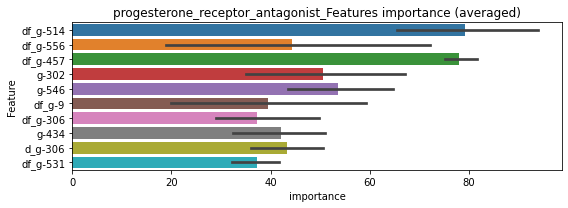

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166401	valid_1's binary_logloss: 0.0263214
[200]	training's binary_logloss: 0.00204766	valid_1's binary_logloss: 0.00851164
[300]	training's binary_logloss: 0.000572724	valid_1's binary_logloss: 0.00521089
[400]	training's binary_logloss: 0.000304319	valid_1's binary_logloss: 0.0044942
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000275603	valid_1's binary_logloss: 0.00439882


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167242	valid_1's binary_logloss: 0.0266115
[200]	training's binary_logloss: 0.00198572	valid_1's binary_logloss: 0.00818464
[300]	training's binary_logloss: 0.000564998	valid_1's binary_logloss: 0.00537793
[400]	training's binary_logloss: 0.000308057	valid_1's binary_logloss: 0.00463386
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000317732	valid_1's binary_logloss: 0.00462519


progesterone_receptor_antagonist logloss: 0.004512002277183851
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965269	valid_1's binary_logloss: 0.172941
[200]	training's binary_logloss: 0.0206853	valid_1's binary_logloss: 0.0703591
[300]	training's binary_logloss: 0.00684345	valid_1's binary_logloss: 0.0414853
[400]	training's binary_logloss: 0.00345852	valid_1's binary_logloss: 0.0307692
[500]	training's binary_logloss: 0.00229481	valid_1's binary_logloss: 0.0256751
[600]	training's binary_logloss: 0.00186927	valid_1's binary_logloss: 0.0231851
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00184928	valid_1's binary_logloss: 0.0229736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934752	valid_1's binary_logloss: 0.176415
[200]	training's binary_logloss: 0.0196315	valid_1's binary_logloss: 0.0778412
[300]	training's binary_logloss: 0.00636522	valid_1's binary_logloss: 0.0452992
[400]	training's binary_logloss: 0.00323501	valid

1 / 3 AUC score:1.000
Threshold: 0.6219291118621852
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00791
p_label_rate: 0.00151 Vs.target_rate: 0.00161, Num_p_label: 6.0, conf_0:0.00791, conf_1:0.62193
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914561	valid_1's binary_logloss: 0.175422
[200]	training's binary_logloss: 0.0194422	valid_1's binary_logloss: 0.0782102
[300]	training's binary_logloss: 0.00627514	valid_1's binary_logloss: 0.0479523
[400]	training's binary_logloss: 0.00322866	valid_1's binary_logloss: 0.03851
[500]	training's binary_logloss: 0.00217932	valid_1's binary_logloss: 0.0339334
[600]	training's binary_logloss: 0.00177402	valid_1's binary_logloss: 0.0320921
Early stopping, best iteration is:
[628]	training's binary_logloss: 0.00174908	valid_1's binary_logloss: 0.0319911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943834	valid_1's binary_logloss: 0.189085
[200]	training's binary_logloss: 0.0201118	valid_1's binary_logloss: 0.0902664
[300]	training's binary_logloss: 0.00655225	valid_1's binary_logloss: 0.0545472
[400]	training's binary_logloss: 0.00336035	valid_1

2 / 3 AUC score:1.000
Threshold: 0.6219291118621852
Remove_noisy_labels: 6 → positive_corect_labels: 495.0/992
30th percentile: 0.00800
p_label_rate: 0.00151 Vs.target_rate: 0.00161, Num_p_label: 6.0, conf_0:0.00552, conf_1:0.62193
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935047	valid_1's binary_logloss: 0.169947
[200]	training's binary_logloss: 0.0195601	valid_1's binary_logloss: 0.0709628
[300]	training's binary_logloss: 0.00639881	valid_1's binary_logloss: 0.0408534
[400]	training's binary_logloss: 0.00325472	valid_1's binary_logloss: 0.0300773
[500]	training's binary_logloss: 0.00222021	valid_1's binary_logloss: 0.026063
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00182212	valid_1's binary_logloss: 0.0235848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933159	valid_1's binary_logloss: 0.184063
[200]	training's binary_logloss: 0.0195163	valid_1's binary_logloss: 0.0844756
[300]	training's binary_logloss: 0.00643174	valid_1's binary_logloss: 0.0515418
[400]	training's binary_logloss: 0.00329875	valid_1's binary_logloss: 0.0386319
[500]	training's binary_logloss: 0.00221994	valid_

3 / 3 AUC score:1.000
Threshold: 0.6219291118621852
Remove_noisy_labels: 2 → positive_corect_labels: 493.0/990
30th percentile: 0.00837
p_label_rate: 0.00151 Vs.target_rate: 0.00161, Num_p_label: 6.0, conf_0:0.00837, conf_1:0.62193
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/4972, y_label_rate: 0.10036


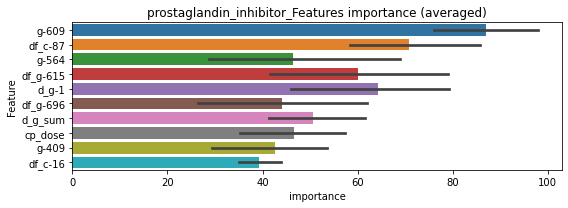

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262351	valid_1's binary_logloss: 0.0486034
[200]	training's binary_logloss: 0.00400495	valid_1's binary_logloss: 0.0190022
[300]	training's binary_logloss: 0.00106325	valid_1's binary_logloss: 0.0124759
[400]	training's binary_logloss: 0.000528569	valid_1's binary_logloss: 0.0108286
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000430397	valid_1's binary_logloss: 0.0103496


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249732	valid_1's binary_logloss: 0.0475049
[200]	training's binary_logloss: 0.00404254	valid_1's binary_logloss: 0.0179211
[300]	training's binary_logloss: 0.00112973	valid_1's binary_logloss: 0.0108541
[400]	training's binary_logloss: 0.000550265	valid_1's binary_logloss: 0.00890037
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000498598	valid_1's binary_logloss: 0.00871888


prostaglandin_inhibitor logloss: 0.0095342403542364
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147974	valid_1's binary_logloss: 0.307544
[200]	training's binary_logloss: 0.0445366	valid_1's binary_logloss: 0.198
[300]	training's binary_logloss: 0.0162022	valid_1's binary_logloss: 0.154946
[400]	training's binary_logloss: 0.00776975	valid_1's binary_logloss: 0.135201
[500]	training's binary_logloss: 0.00476311	valid_1's binary_logloss: 0.123683
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00398357	valid_1's binary_logloss: 0.120684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136613	valid_1's binary_logloss: 0.322858
[200]	training's binary_logloss: 0.0381562	valid_1's binary_logloss: 0.223139
[300]	training's binary_logloss: 0.0137232	valid_1's binary_logloss: 0.183055
[400]	training's binary_logloss: 0.00662506	valid_1's binary_logloss: 0.168937
Early stopping, best iteration is:
[460]	training's binary_loglo

1 / 3 AUC score:0.984
Threshold: 0.39055531126171694
Remove_noisy_labels: 50 → positive_corect_labels: 475/950
30th percentile: 0.04428
p_label_rate: 0.01808 Vs.target_rate: 0.00358, Num_p_label: 72.0, conf_0:0.04428, conf_1:0.45781
Num_p_label: 72.0, Expected: 14.3, Adj_threshold_1: 0.39
Num_p_label: 48.0, Expected: 14.3, Adj_threshold_2: 0.43
Num_p_label: 31.0, Expected: 14.3, Adj_threshold_3: 0.47
Num_p_label: 21.0, Expected: 14.3, Adj_threshold_4: 0.51
threshold:0.51, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:475.0/950, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132049	valid_1's binary_logloss: 0.30401
[200]	training's binary_logloss: 0.0356412	valid_1's binary_logloss: 0.191423
[300]	training's binary_logloss: 0.0128658	valid_1's binary_logloss: 0.150759
[400]	training's binary_logloss: 0.00634537	valid_1's binary_logloss: 0.132019
[500]	training's binary_logloss: 0.00401189	valid_1's binary_logloss: 0.121615
[600]	training's binary_logloss: 0.00297154	valid_1's binary_logloss: 0.114399
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00257611	valid_1's binary_logloss: 0.110749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128756	valid_1's binary_logloss: 0.278098
[200]	training's binary_logloss: 0.0346922	valid_1's binary_logloss: 0.183153
[300]	training's binary_logloss: 0.0122519	valid_1's binary_logloss: 0.147925
[400]	training's binary_logloss: 0.00606712	valid_1's binary_l

2 / 3 AUC score:0.992
Threshold: 0.5105553112617169
Remove_noisy_labels: 29 → positive_corect_labels: 452.0/921
30th percentile: 0.03127
p_label_rate: 0.01306 Vs.target_rate: 0.00358, Num_p_label: 52.0, conf_0:0.03071, conf_1:0.51056
Num_p_label: 52.0, Expected: 14.3, Adj_threshold_1: 0.51
Num_p_label: 39.0, Expected: 14.3, Adj_threshold_2: 0.55
Num_p_label: 29.0, Expected: 14.3, Adj_threshold_3: 0.59
Num_p_label: 20.0, Expected: 14.3, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:452.0/921, y_label_rate: 0.49077
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11981	valid_1's binary_logloss: 0.258442
[200]	training's binary_logloss: 0.0327523	valid_1's binary_logloss: 0.163277
[300]	training's binary_logloss: 0.0116802	valid_1's binary_logloss: 0.122139
[400]	training's binary_logloss: 0.00585027	valid_1's binary_logloss: 0.104554
[500]	training's binary_logloss: 0.00378386	valid_1's binary_logloss: 0.0958095
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00294677	valid_1's binary_logloss: 0.092947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129491	valid_1's binary_logloss: 0.262208
[200]	training's binary_logloss: 0.0347934	valid_1's binary_logloss: 0.155156
[300]	training's binary_logloss: 0.0126083	valid_1's binary_logloss: 0.117824
[400]	training's binary_logloss: 0.0061304	valid_1's binary_logloss: 0.101327
[500]	training's binary_logloss: 0.00386372	valid_1's binary_l

3 / 3 AUC score:0.996
Threshold: 0.630555311261717
Remove_noisy_labels: 22 → positive_corect_labels: 431.0/899
30th percentile: 0.02603
p_label_rate: 0.00527 Vs.target_rate: 0.00358, Num_p_label: 21.0, conf_0:0.02482, conf_1:0.63056
threshold:0.63, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:452.0/4881, y_label_rate: 0.09260


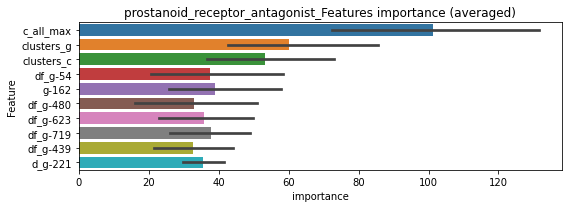

len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332278	valid_1's binary_logloss: 0.0749036
[200]	training's binary_logloss: 0.00725259	valid_1's binary_logloss: 0.046872
[300]	training's binary_logloss: 0.00205439	valid_1's binary_logloss: 0.0388998
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00156076	valid_1's binary_logloss: 0.038483


len(train_index) : 2441
len(valid_index) : 2440
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327104	valid_1's binary_logloss: 0.0785854
[200]	training's binary_logloss: 0.00688937	valid_1's binary_logloss: 0.0537383
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00278411	valid_1's binary_logloss: 0.0497823


prostanoid_receptor_antagonist logloss: 0.04413149747448057
proteasome_inhibitor , len(trt) : 726


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.678421	valid_1's binary_logloss: 0.692578
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.517
Threshold: 0.49725531450266247
Remove_noisy_labels: 707 → positive_corect_labels: 376/745
30th percentile: 0.49075
p_label_rate: 0.53692 Vs.target_rate: 0.01140, Num_p_label: 2138.0, conf_0:0.49075, conf_1:0.49726
Num_p_label: 2138.0, Expected: 45.4, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 45.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[7]	training's binary_logloss: 0.640886	valid_1's binary_logloss: 0.692307


positive y_label:376.0/745, y_label_rate: 0.50470
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.512963	valid_1's binary_logloss: 0.677709
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.610
Threshold: 0.5372553145026625
Remove_noisy_labels: 314 → positive_corect_labels: 169.0/431
30th percentile: 0.47422
p_label_rate: 0.30964 Vs.target_rate: 0.01140, Num_p_label: 1233.0, conf_0:0.47422, conf_1:0.53726
Num_p_label: 1233.0, Expected: 45.4, Adj_threshold_1: 0.54
Num_p_label: 491.0, Expected: 45.4, Adj_threshold_2: 0.58
Num_p_label: 104.0, Expected: 45.4, Adj_threshold_3: 0.62
Num_p_label: 8.0, Expected: 45.4, Adj_threshold_4: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.369558	valid_1's binary_logloss: 0.669407


positive y_label:169.0/431, y_label_rate: 0.39211
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184807	valid_1's binary_logloss: 0.503213
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.123018	valid_1's binary_logloss: 0.492635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180808	valid_1's binary_logloss: 0.552387


3 / 3 AUC score:0.828
Threshold: 0.6572553145026626
Remove_noisy_labels: 133 → positive_corect_labels: 47.0/298
30th percentile: 0.22120
p_label_rate: 0.10045 Vs.target_rate: 0.01140, Num_p_label: 400.0, conf_0:0.22120, conf_1:0.65726
Num_p_label: 400.0, Expected: 45.4, Adj_threshold_1: 0.66
Num_p_label: 286.0, Expected: 45.4, Adj_threshold_2: 0.70
Num_p_label: 182.0, Expected: 45.4, Adj_threshold_3: 0.74
Num_p_label: 99.0, Expected: 45.4, Adj_threshold_4: 0.78
Num_p_label: 44.0, Expected: 45.4, Adj_threshold_5: 0.82


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0978775	valid_1's binary_logloss: 0.520286


threshold:0.82, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:91.0/4280, y_label_rate: 0.02126


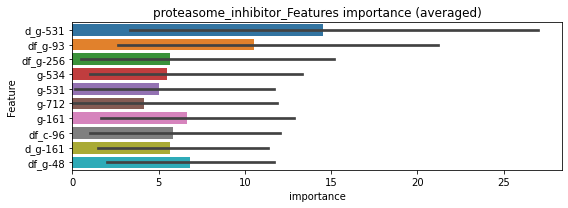

len(train_index) : 2140
len(valid_index) : 2140
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2140
len(valid_index) : 2140
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0218412	valid_1's binary_logloss: 0.0915525
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.09119077896924184
protein_kinase_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0171391	valid_1's binary_logloss: 0.0908291
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10732	valid_1's binary_logloss: 0.231026
[200]	training's binary_logloss: 0.0249344	valid_1's binary_logloss: 0.124362
[300]	training's binary_logloss: 0.00834645	valid_1's binary_logloss: 0.0909766
[400]	training's binary_logloss: 0.00419393	valid_1's binary_logloss: 0.0771653
[500]	training's binary_logloss: 0.00273454	valid_1's binary_logloss: 0.0707157
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00273454	valid_1's binary_logloss: 0.0707157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10895	valid_1's binary_logloss: 0.227907
[200]	training's binary_logloss: 0.0255429	valid_1's binary_logloss: 0.116542
[300]	training's binary_logloss: 0.00857355	valid_1's binary_logloss: 0.0783139
[400]	training's binary_logloss: 0.00427659	valid_1's binary_logloss: 0.0617239
[500]	training's binary_logloss: 0.00277355	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.3746245163480074
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.01276
p_label_rate: 0.00653 Vs.target_rate: 0.00212, Num_p_label: 26.0, conf_0:0.01276, conf_1:0.40595
Num_p_label: 26.0, Expected: 8.4, Adj_threshold_1: 0.37
Num_p_label: 14.0, Expected: 8.4, Adj_threshold_2: 0.41
Num_p_label: 10.0, Expected: 8.4, Adj_threshold_3: 0.45
threshold:0.45, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100052	valid_1's binary_logloss: 0.202055
[200]	training's binary_logloss: 0.0231308	valid_1's binary_logloss: 0.0987738
[300]	training's binary_logloss: 0.0080054	valid_1's binary_logloss: 0.0643577
[400]	training's binary_logloss: 0.0040483	valid_1's binary_logloss: 0.0521359
[500]	training's binary_logloss: 0.00265742	valid_1's binary_logloss: 0.0464277
[600]	training's binary_logloss: 0.00206306	valid_1's binary_logloss: 0.0428128
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00192548	valid_1's binary_logloss: 0.0418866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110636	valid_1's binary_logloss: 0.217465
[200]	training's binary_logloss: 0.0256081	valid_1's binary_logloss: 0.113558
[300]	training's binary_logloss: 0.00848353	valid_1's binary_logloss: 0.0791787
[400]	training's binary_logloss: 0.00421342	valid_1's 

2 / 3 AUC score:0.999
Threshold: 0.4546245163480074
Remove_noisy_labels: 15 → positive_corect_labels: 485.0/971
30th percentile: 0.01273
p_label_rate: 0.00477 Vs.target_rate: 0.00212, Num_p_label: 19.0, conf_0:0.01273, conf_1:0.45462
threshold:0.45, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:485.0/971, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104269	valid_1's binary_logloss: 0.205432
[200]	training's binary_logloss: 0.0238157	valid_1's binary_logloss: 0.0972191
[300]	training's binary_logloss: 0.00796345	valid_1's binary_logloss: 0.0630595
[400]	training's binary_logloss: 0.00406431	valid_1's binary_logloss: 0.0518852
[500]	training's binary_logloss: 0.0026599	valid_1's binary_logloss: 0.0457282
[600]	training's binary_logloss: 0.00209341	valid_1's binary_logloss: 0.041661
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00195767	valid_1's binary_logloss: 0.0409242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107552	valid_1's binary_logloss: 0.222415
[200]	training's binary_logloss: 0.0244922	valid_1's binary_logloss: 0.101848
[300]	training's binary_logloss: 0.00833043	valid_1's binary_logloss: 0.0643393
[400]	training's binary_logloss: 0.00418992	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.4546245163480074
Remove_noisy_labels: 4 → positive_corect_labels: 482.0/967
30th percentile: 0.01023
p_label_rate: 0.00578 Vs.target_rate: 0.00212, Num_p_label: 23.0, conf_0:0.01023, conf_1:0.50430
threshold:0.45, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:505.0/4949, y_label_rate: 0.10204


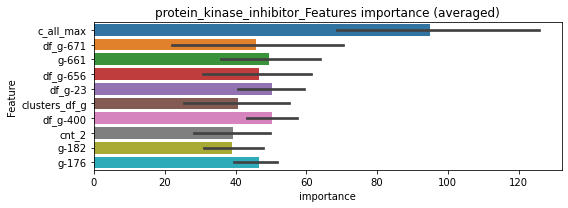

len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027457	valid_1's binary_logloss: 0.0716998
[200]	training's binary_logloss: 0.0045704	valid_1's binary_logloss: 0.0447936
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00181854	valid_1's binary_logloss: 0.0414285


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294257	valid_1's binary_logloss: 0.0622183
[200]	training's binary_logloss: 0.00495707	valid_1's binary_logloss: 0.036061
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00176604	valid_1's binary_logloss: 0.0322717


protein_kinase_inhibitor logloss: 0.03685100763645885
protein_phosphatase_inhibitor , len(trt) : 24


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724465	valid_1's binary_logloss: 0.136083
[200]	training's binary_logloss: 0.0132721	valid_1's binary_logloss: 0.052794
[300]	training's binary_logloss: 0.00418206	valid_1's binary_logloss: 0.0317308
[400]	training's binary_logloss: 0.00220786	valid_1's binary_logloss: 0.0235912
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00166572	valid_1's binary_logloss: 0.0207607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764421	valid_1's binary_logloss: 0.121331
[200]	training's binary_logloss: 0.0143498	valid_1's binary_logloss: 0.0369526
[300]	training's binary_logloss: 0.0045229	valid_1's binary_logloss: 0.0169301
[400]	training's binary_logloss: 0.00235974	valid_1's binary_logloss: 0.0111941
[500]	training's binary_logloss: 0.0016732	valid_1's binary_logloss: 0.00887662
Early stopping, best iteration is:
[585]	training's

1 / 3 AUC score:1.000
Threshold: 0.6713888763200182
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00359
p_label_rate: 0.00000 Vs.target_rate: 0.00108, Num_p_label: 0.0, conf_0:0.00359, conf_1:0.67139
Num_p_label: 0.0, Expected: 4.3, Adj_threshold_1: 0.67
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_2: 0.63
Num_p_label: 1.0, Expected: 4.3, Adj_threshold_3: 0.59
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_4: 0.55
threshold:0.55, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724465	valid_1's binary_logloss: 0.136083
[200]	training's binary_logloss: 0.0132721	valid_1's binary_logloss: 0.052794
[300]	training's binary_logloss: 0.00418206	valid_1's binary_logloss: 0.0317308
[400]	training's binary_logloss: 0.00220786	valid_1's binary_logloss: 0.0235912
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00166572	valid_1's binary_logloss: 0.0207607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764421	valid_1's binary_logloss: 0.121331
[200]	training's binary_logloss: 0.0143498	valid_1's binary_logloss: 0.0369526
[300]	training's binary_logloss: 0.0045229	valid_1's binary_logloss: 0.0169301
[400]	training's binary_logloss: 0.00235974	valid_1's binary_logloss: 0.0111941
[500]	training's binary_logloss: 0.0016732	valid_1's binary_logloss: 0.00887662
Early stopping, best iteration is:
[585]	training's

2 / 3 AUC score:1.000
Threshold: 0.5513888763200181
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00359
p_label_rate: 0.00126 Vs.target_rate: 0.00108, Num_p_label: 5.0, conf_0:0.00359, conf_1:0.55139
threshold:0.55, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744209	valid_1's binary_logloss: 0.125503
[200]	training's binary_logloss: 0.0135045	valid_1's binary_logloss: 0.0428585
[300]	training's binary_logloss: 0.00429188	valid_1's binary_logloss: 0.0234205
[400]	training's binary_logloss: 0.00226383	valid_1's binary_logloss: 0.01721
[500]	training's binary_logloss: 0.0015982	valid_1's binary_logloss: 0.014411
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00144785	valid_1's binary_logloss: 0.0132711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781947	valid_1's binary_logloss: 0.11897
[200]	training's binary_logloss: 0.0144698	valid_1's binary_logloss: 0.0349339
[300]	training's binary_logloss: 0.00457887	valid_1's binary_logloss: 0.015673
[400]	training's binary_logloss: 0.00240754	valid_1's binary_logloss: 0.0101808
[500]	training's binary_logloss: 0.00170006	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.5513888763200181
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00312
p_label_rate: 0.00100 Vs.target_rate: 0.00108, Num_p_label: 4.0, conf_0:0.00312, conf_1:0.55139
threshold:0.55, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4981, y_label_rate: 0.10118


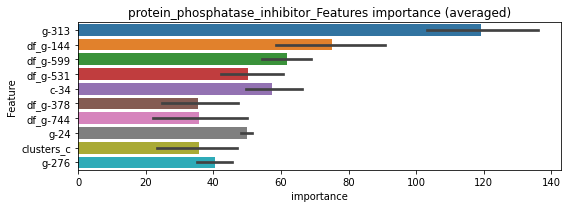

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207182	valid_1's binary_logloss: 0.0309292
[200]	training's binary_logloss: 0.00288182	valid_1's binary_logloss: 0.00861467
[300]	training's binary_logloss: 0.000797082	valid_1's binary_logloss: 0.00534364
[400]	training's binary_logloss: 0.000404406	valid_1's binary_logloss: 0.00441146
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000310386	valid_1's binary_logloss: 0.00418613


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197303	valid_1's binary_logloss: 0.0391886
[200]	training's binary_logloss: 0.00268665	valid_1's binary_logloss: 0.0159187
[300]	training's binary_logloss: 0.000760742	valid_1's binary_logloss: 0.0119627
[400]	training's binary_logloss: 0.000393614	valid_1's binary_logloss: 0.0108931
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000379832	valid_1's binary_logloss: 0.0108535


protein_phosphatase_inhibitor logloss: 0.007519135845601006
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146191	valid_1's binary_logloss: 0.366251
[200]	training's binary_logloss: 0.043706	valid_1's binary_logloss: 0.271908
[300]	training's binary_logloss: 0.0162402	valid_1's binary_logloss: 0.23114
[400]	training's binary_logloss: 0.00779497	valid_1's binary_logloss: 0.212136
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00506957	valid_1's binary_logloss: 0.204498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137095	valid_1's binary_logloss: 0.357001
[200]	training's binary_logloss: 0.0406556	valid_1's binary_logloss: 0.285804
[300]	training's binary_logloss: 0.014888	valid_1's binary_logloss: 0.254269
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00877165	valid_1's binary_logloss: 0.244967


1 / 3 AUC score:0.962
Threshold: 0.3751486578237474
Remove_noisy_labels: 96 → positive_corect_labels: 452/904
30th percentile: 0.05630
p_label_rate: 0.07484 Vs.target_rate: 0.00431, Num_p_label: 298.0, conf_0:0.04979, conf_1:0.46905
Num_p_label: 298.0, Expected: 17.2, Adj_threshold_1: 0.38
Num_p_label: 224.0, Expected: 17.2, Adj_threshold_2: 0.42
Num_p_label: 151.0, Expected: 17.2, Adj_threshold_3: 0.46
Num_p_label: 111.0, Expected: 17.2, Adj_threshold_4: 0.50
Num_p_label: 76.0, Expected: 17.2, Adj_threshold_5: 0.54
Num_p_label: 52.0, Expected: 17.2, Adj_threshold_6: 0.58
Num_p_label: 38.0, Expected: 17.2, Adj_threshold_7: 0.62
Num_p_label: 22.0, Expected: 17.2, Adj_threshold_8: 0.66
threshold:0.66, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:452.0/904, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13	valid_1's binary_logloss: 0.306496
[200]	training's binary_logloss: 0.0367411	valid_1's binary_logloss: 0.226838
[300]	training's binary_logloss: 0.0136684	valid_1's binary_logloss: 0.188532
[400]	training's binary_logloss: 0.00679235	valid_1's binary_logloss: 0.169193
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00566579	valid_1's binary_logloss: 0.167794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1293	valid_1's binary_logloss: 0.296559
[200]	training's binary_logloss: 0.0362729	valid_1's binary_logloss: 0.205399
[300]	training's binary_logloss: 0.0132127	valid_1's binary_logloss: 0.167063
[400]	training's binary_logloss: 0.00657103	valid_1's binary_logloss: 0.149793
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00584375	valid_1's binary_logloss: 0.147874


2 / 3 AUC score:0.984
Threshold: 0.6551486578237474
Remove_noisy_labels: 51 → positive_corect_labels: 409.0/853
30th percentile: 0.03976
p_label_rate: 0.02135 Vs.target_rate: 0.00431, Num_p_label: 85.0, conf_0:0.02405, conf_1:0.65515
Num_p_label: 85.0, Expected: 17.2, Adj_threshold_1: 0.66
Num_p_label: 67.0, Expected: 17.2, Adj_threshold_2: 0.70
Num_p_label: 48.0, Expected: 17.2, Adj_threshold_3: 0.74
Num_p_label: 31.0, Expected: 17.2, Adj_threshold_4: 0.78
Num_p_label: 21.0, Expected: 17.2, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:409.0/853, y_label_rate: 0.47948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117077	valid_1's binary_logloss: 0.256443
[200]	training's binary_logloss: 0.0312516	valid_1's binary_logloss: 0.157875
[300]	training's binary_logloss: 0.0112985	valid_1's binary_logloss: 0.126471
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00775046	valid_1's binary_logloss: 0.118023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114704	valid_1's binary_logloss: 0.263425
[200]	training's binary_logloss: 0.0315542	valid_1's binary_logloss: 0.176988
[300]	training's binary_logloss: 0.0116033	valid_1's binary_logloss: 0.140768
[400]	training's binary_logloss: 0.00583466	valid_1's binary_logloss: 0.122104
[500]	training's binary_logloss: 0.00372208	valid_1's binary_logloss: 0.114781
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00304548	valid_1's binary_logloss: 0.111026


3 / 3 AUC score:0.994
Threshold: 0.8151486578237476
Remove_noisy_labels: 50 → positive_corect_labels: 360.0/803
30th percentile: 0.02167
p_label_rate: 0.00377 Vs.target_rate: 0.00431, Num_p_label: 15.0, conf_0:0.01540, conf_1:0.81515
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:375.0/4785, y_label_rate: 0.07837


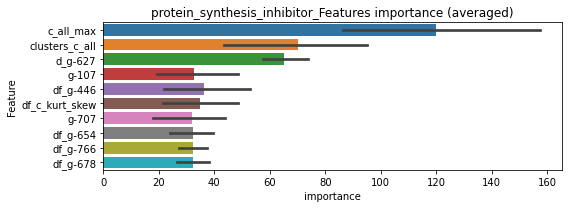

len(train_index) : 2392
len(valid_index) : 2393
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021992	valid_1's binary_logloss: 0.0765343
[200]	training's binary_logloss: 0.00430332	valid_1's binary_logloss: 0.0589768
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00217952	valid_1's binary_logloss: 0.0566494


len(train_index) : 2393
len(valid_index) : 2392
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022491	valid_1's binary_logloss: 0.0674156
[200]	training's binary_logloss: 0.00433202	valid_1's binary_logloss: 0.0506564
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00433202	valid_1's binary_logloss: 0.0506564


protein_synthesis_inhibitor logloss: 0.053653504124925165
protein_tyrosine_kinase_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610745	valid_1's binary_logloss: 0.108113
[200]	training's binary_logloss: 0.00995632	valid_1's binary_logloss: 0.0397681
[300]	training's binary_logloss: 0.00331374	valid_1's binary_logloss: 0.0237144
[400]	training's binary_logloss: 0.00183818	valid_1's binary_logloss: 0.0187032
[500]	training's binary_logloss: 0.001379	valid_1's binary_logloss: 0.0168083
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00134376	valid_1's binary_logloss: 0.0166571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630302	valid_1's binary_logloss: 0.103887
[200]	training's binary_logloss: 0.0105254	valid_1's binary_logloss: 0.0324155
[300]	training's binary_logloss: 0.00340273	valid_1's binary_logloss: 0.0171052
[400]	training's binary_logloss: 0.00186261	valid_1's binary_logloss: 0.0124673
[500]	training's binary_logloss: 0.00138412	valid_

1 / 3 AUC score:1.000
Threshold: 0.3233904662229417
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00219
p_label_rate: 0.00100 Vs.target_rate: 0.00086, Num_p_label: 4.0, conf_0:0.00219, conf_1:0.32339
threshold:0.32, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608263	valid_1's binary_logloss: 0.116977
[200]	training's binary_logloss: 0.0101317	valid_1's binary_logloss: 0.0389665
[300]	training's binary_logloss: 0.00332499	valid_1's binary_logloss: 0.0215563
[400]	training's binary_logloss: 0.00183864	valid_1's binary_logloss: 0.0160855
[500]	training's binary_logloss: 0.00137387	valid_1's binary_logloss: 0.0138213
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00130727	valid_1's binary_logloss: 0.013622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631212	valid_1's binary_logloss: 0.0969551
[200]	training's binary_logloss: 0.0105568	valid_1's binary_logloss: 0.028803
[300]	training's binary_logloss: 0.0033993	valid_1's binary_logloss: 0.0142121
[400]	training's binary_logloss: 0.00188546	valid_1's binary_logloss: 0.0103858
[500]	training's binary_logloss: 0.00139057	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3233904662229417
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/996
30th percentile: 0.00205
p_label_rate: 0.00126 Vs.target_rate: 0.00086, Num_p_label: 5.0, conf_0:0.00205, conf_1:0.32339
threshold:0.32, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585362	valid_1's binary_logloss: 0.112497
[200]	training's binary_logloss: 0.00967423	valid_1's binary_logloss: 0.0382692
[300]	training's binary_logloss: 0.00323032	valid_1's binary_logloss: 0.0206072
[400]	training's binary_logloss: 0.00180387	valid_1's binary_logloss: 0.0144942
[500]	training's binary_logloss: 0.00136581	valid_1's binary_logloss: 0.0128708
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00131926	valid_1's binary_logloss: 0.0127136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063783	valid_1's binary_logloss: 0.0954603
[200]	training's binary_logloss: 0.0108483	valid_1's binary_logloss: 0.0281179
[300]	training's binary_logloss: 0.00342554	valid_1's binary_logloss: 0.0136109
[400]	training's binary_logloss: 0.00187457	valid_1's binary_logloss: 0.00950815
[500]	training's binary_logloss: 0.00139478	val

3 / 3 AUC score:1.000
Threshold: 0.3233904662229417
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996
30th percentile: 0.00207
p_label_rate: 0.00176 Vs.target_rate: 0.00086, Num_p_label: 7.0, conf_0:0.00207, conf_1:0.32339
threshold:0.32, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:506.0/4978, y_label_rate: 0.10165


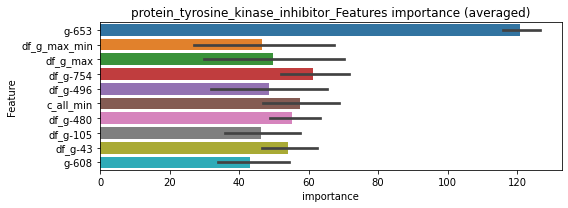

len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144597	valid_1's binary_logloss: 0.0289468
[200]	training's binary_logloss: 0.00173568	valid_1's binary_logloss: 0.0157993
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000978693	valid_1's binary_logloss: 0.0149344


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144205	valid_1's binary_logloss: 0.0240741
[200]	training's binary_logloss: 0.00181692	valid_1's binary_logloss: 0.00930526
[300]	training's binary_logloss: 0.000559296	valid_1's binary_logloss: 0.00779587
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000414561	valid_1's binary_logloss: 0.00763516


protein_tyrosine_kinase_inhibitor logloss: 0.011284801896580677
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116866	valid_1's binary_logloss: 0.233422
[200]	training's binary_logloss: 0.0299006	valid_1's binary_logloss: 0.127762
[300]	training's binary_logloss: 0.0104557	valid_1's binary_logloss: 0.089595
[400]	training's binary_logloss: 0.00516537	valid_1's binary_logloss: 0.0735228
[500]	training's binary_logloss: 0.00330462	valid_1's binary_logloss: 0.065998
[600]	training's binary_logloss: 0.00250779	valid_1's binary_logloss: 0.0618459
[700]	training's binary_logloss: 0.00212823	valid_1's binary_logloss: 0.0594654
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00210128	valid_1's binary_logloss: 0.0593079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110776	valid_1's binary_logloss: 0.261295
[200]	training's binary_logloss: 0.0277237	valid_1's binary_logloss: 0.176283
[300]	training's binary_logloss: 0.0095484	valid_1's bin

1 / 3 AUC score:0.990
Threshold: 0.3085461257593586


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.008096	valid_1's binary_logloss: 0.140806


Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentile: 0.02239
p_label_rate: 0.02135 Vs.target_rate: 0.00246, Num_p_label: 85.0, conf_0:0.02239, conf_1:0.47811
Num_p_label: 85.0, Expected: 9.8, Adj_threshold_1: 0.31
Num_p_label: 59.0, Expected: 9.8, Adj_threshold_2: 0.35
Num_p_label: 41.0, Expected: 9.8, Adj_threshold_3: 0.39
Num_p_label: 27.0, Expected: 9.8, Adj_threshold_4: 0.43
Num_p_label: 19.0, Expected: 9.8, Adj_threshold_5: 0.47
Num_p_label: 15.0, Expected: 9.8, Adj_threshold_6: 0.51
Num_p_label: 8.0, Expected: 9.8, Adj_threshold_7: 0.55
threshold:0.55, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104467	valid_1's binary_logloss: 0.243481
[200]	training's binary_logloss: 0.0246076	valid_1's binary_logloss: 0.149754
[300]	training's binary_logloss: 0.00837014	valid_1's binary_logloss: 0.119469
[400]	training's binary_logloss: 0.00423719	valid_1's binary_logloss: 0.10845
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00339124	valid_1's binary_logloss: 0.104312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109617	valid_1's binary_logloss: 0.237109
[200]	training's binary_logloss: 0.0277337	valid_1's binary_logloss: 0.137241
[300]	training's binary_logloss: 0.00961767	valid_1's binary_logloss: 0.0988942
[400]	training's binary_logloss: 0.00483429	valid_1's binary_logloss: 0.0802324
[500]	training's binary_logloss: 0.00312702	valid_1's binary_logloss: 0.072612
Early stopping, best iteration is:
[523]	training's binary

2 / 3 AUC score:0.995
Threshold: 0.5485461257593586
Remove_noisy_labels: 26 → positive_corect_labels: 462.0/944
30th percentile: 0.01667
p_label_rate: 0.00578 Vs.target_rate: 0.00246, Num_p_label: 23.0, conf_0:0.01667, conf_1:0.54855
threshold:0.55, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:462.0/944, y_label_rate: 0.48941
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100638	valid_1's binary_logloss: 0.199774
[200]	training's binary_logloss: 0.0232979	valid_1's binary_logloss: 0.0930148
[300]	training's binary_logloss: 0.00822187	valid_1's binary_logloss: 0.058967
[400]	training's binary_logloss: 0.00426637	valid_1's binary_logloss: 0.0461084
[500]	training's binary_logloss: 0.00285089	valid_1's binary_logloss: 0.0391076
[600]	training's binary_logloss: 0.00224052	valid_1's binary_logloss: 0.035712
[700]	training's binary_logloss: 0.00198137	valid_1's binary_logloss: 0.033901
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00195514	valid_1's binary_logloss: 0.0336583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102609	valid_1's binary_logloss: 0.181292
[200]	training's binary_logloss: 0.024335	valid_1's binary_logloss: 0.0869278
[300]	training's binary_logloss: 0.00856093	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.5485461257593586
Remove_noisy_labels: 4 → positive_corect_labels: 458.0/940
30th percentile: 0.00911
p_label_rate: 0.00628 Vs.target_rate: 0.00246, Num_p_label: 25.0, conf_0:0.00911, conf_1:0.54855
threshold:0.55, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:483.0/4922, y_label_rate: 0.09813


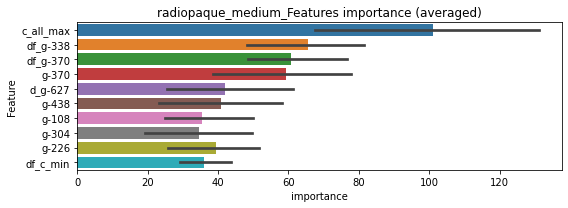

len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028229	valid_1's binary_logloss: 0.0659462
[200]	training's binary_logloss: 0.00507881	valid_1's binary_logloss: 0.0437336
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00177117	valid_1's binary_logloss: 0.0395609


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298381	valid_1's binary_logloss: 0.0681185
[200]	training's binary_logloss: 0.00567984	valid_1's binary_logloss: 0.0463662
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00567984	valid_1's binary_logloss: 0.0463662


radiopaque_medium logloss: 0.0429635426521852
raf_inhibitor , len(trt) : 223


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198675	valid_1's binary_logloss: 0.549
[200]	training's binary_logloss: 0.0712462	valid_1's binary_logloss: 0.512818
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.040509	valid_1's binary_logloss: 0.496544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199262	valid_1's binary_logloss: 0.551718
[200]	training's binary_logloss: 0.0707068	valid_1's binary_logloss: 0.508183


1 / 3 AUC score:0.823
Threshold: 0.4665155488918593
Remove_noisy_labels: 264 → positive_corect_labels: 368/736


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0344249	valid_1's binary_logloss: 0.490472


30th percentile: 0.25949
p_label_rate: 0.17629 Vs.target_rate: 0.00821, Num_p_label: 702.0, conf_0:0.25949, conf_1:0.51810
Num_p_label: 702.0, Expected: 32.7, Adj_threshold_1: 0.47
Num_p_label: 471.0, Expected: 32.7, Adj_threshold_2: 0.51
Num_p_label: 294.0, Expected: 32.7, Adj_threshold_3: 0.55
Num_p_label: 173.0, Expected: 32.7, Adj_threshold_4: 0.59
Num_p_label: 92.0, Expected: 32.7, Adj_threshold_5: 0.63
Num_p_label: 46.0, Expected: 32.7, Adj_threshold_6: 0.67
threshold:0.67, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:368.0/736, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180227	valid_1's binary_logloss: 0.452414
[200]	training's binary_logloss: 0.062506	valid_1's binary_logloss: 0.368622
[300]	training's binary_logloss: 0.0253979	valid_1's binary_logloss: 0.336586
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0203055	valid_1's binary_logloss: 0.326202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183899	valid_1's binary_logloss: 0.437759
[200]	training's binary_logloss: 0.0644572	valid_1's binary_logloss: 0.351503
[300]	training's binary_logloss: 0.02616	valid_1's binary_logloss: 0.314377
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0224222	valid_1's binary_logloss: 0.308192


2 / 3 AUC score:0.945
Threshold: 0.6665155488918595
Remove_noisy_labels: 100 → positive_corect_labels: 289.0/636
30th percentile: 0.21397
p_label_rate: 0.06655 Vs.target_rate: 0.00821, Num_p_label: 265.0, conf_0:0.21397, conf_1:0.66652
Num_p_label: 265.0, Expected: 32.7, Adj_threshold_1: 0.67
Num_p_label: 178.0, Expected: 32.7, Adj_threshold_2: 0.71
Num_p_label: 109.0, Expected: 32.7, Adj_threshold_3: 0.75
Num_p_label: 57.0, Expected: 32.7, Adj_threshold_4: 0.79
Num_p_label: 26.0, Expected: 32.7, Adj_threshold_5: 0.83
threshold:0.83, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:289.0/636, y_label_rate: 0.45440
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164985	valid_1's binary_logloss: 0.383844
[200]	training's binary_logloss: 0.0537484	valid_1's binary_logloss: 0.286885
[300]	training's binary_logloss: 0.0212077	valid_1's binary_logloss: 0.245044
[400]	training's binary_logloss: 0.0105844	valid_1's binary_logloss: 0.216778
[500]	training's binary_logloss: 0.00659911	valid_1's binary_logloss: 0.202482
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00589395	valid_1's binary_logloss: 0.199623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160951	valid_1's binary_logloss: 0.408938
[200]	training's binary_logloss: 0.0514357	valid_1's binary_logloss: 0.314198


3 / 3 AUC score:0.972
Threshold: 0.8265155488918596
Remove_noisy_labels: 113 → positive_corect_labels: 177.0/523
30th percentile: 0.10642
p_label_rate: 0.00326 Vs.target_rate: 0.00821, Num_p_label: 13.0, conf_0:0.10642, conf_1:0.82652


[300]	training's binary_logloss: 0.0206352	valid_1's binary_logloss: 0.278166
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0222937	valid_1's binary_logloss: 0.278023


threshold:0.83, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:190.0/4505, y_label_rate: 0.04218


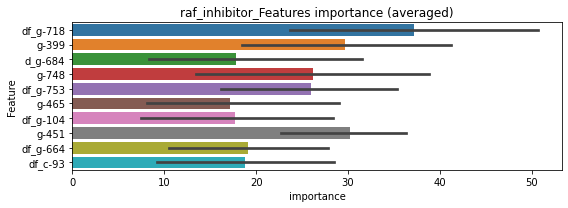

len(train_index) : 2252
len(valid_index) : 2253
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176816	valid_1's binary_logloss: 0.0944407


len(train_index) : 2253
len(valid_index) : 2252
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00842621	valid_1's binary_logloss: 0.0908728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156741	valid_1's binary_logloss: 0.100729


raf_inhibitor logloss: 0.0943029842930596


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00739	valid_1's binary_logloss: 0.0977347


ras_gtpase_inhibitor , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494918	valid_1's binary_logloss: 0.0817253
[200]	training's binary_logloss: 0.00701597	valid_1's binary_logloss: 0.0252246
[300]	training's binary_logloss: 0.00223338	valid_1's binary_logloss: 0.0137855
[400]	training's binary_logloss: 0.00131103	valid_1's binary_logloss: 0.0103921
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00112978	valid_1's binary_logloss: 0.00920631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052251	valid_1's binary_logloss: 0.0715734
[200]	training's binary_logloss: 0.00737423	valid_1's binary_logloss: 0.0167758
[300]	training's binary_logloss: 0.00235109	valid_1's binary_logloss: 0.00789417
[400]	training's binary_logloss: 0.00133467	valid_1's binary_logloss: 0.00517957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00115265	valid_1's binary_logloss: 0.00458593


1 / 3 AUC score:1.000
Threshold: 0.7038356858655681
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00083
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00083, conf_1:0.70384
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494918	valid_1's binary_logloss: 0.0817253
[200]	training's binary_logloss: 0.00701597	valid_1's binary_logloss: 0.0252246
[300]	training's binary_logloss: 0.00223338	valid_1's binary_logloss: 0.0137855
[400]	training's binary_logloss: 0.00131103	valid_1's binary_logloss: 0.0103921
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00112978	valid_1's binary_logloss: 0.00920631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052251	valid_1's binary_logloss: 0.0715734
[200]	training's binary_logloss: 0.00737423	valid_1's binary_logloss: 0.0167758
[300]	training's binary_logloss: 0.00235109	valid_1's binary_logloss: 0.00789417
[400]	training's binary_logloss: 0.00133467	valid_1's binary_logloss: 0.00517957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00115265	valid_1's binary_logloss: 0.00458593


2 / 3 AUC score:1.000
Threshold: 0.7038356858655681
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00083
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00083, conf_1:0.70384
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494918	valid_1's binary_logloss: 0.0817253
[200]	training's binary_logloss: 0.00701597	valid_1's binary_logloss: 0.0252246
[300]	training's binary_logloss: 0.00223338	valid_1's binary_logloss: 0.0137855
[400]	training's binary_logloss: 0.00131103	valid_1's binary_logloss: 0.0103921
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00112978	valid_1's binary_logloss: 0.00920631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052251	valid_1's binary_logloss: 0.0715734
[200]	training's binary_logloss: 0.00737423	valid_1's binary_logloss: 0.0167758
[300]	training's binary_logloss: 0.00235109	valid_1's binary_logloss: 0.00789417
[400]	training's binary_logloss: 0.00133467	valid_1's binary_logloss: 0.00517957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00115265	valid_1's binary_logloss: 0.00458593


3 / 3 AUC score:1.000
Threshold: 0.7038356858655681
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00083
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00083, conf_1:0.70384
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:505.0/4982, y_label_rate: 0.10136


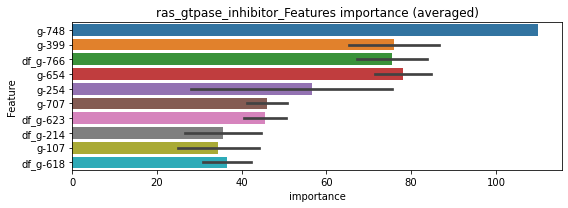

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125069	valid_1's binary_logloss: 0.0289643
[200]	training's binary_logloss: 0.00138965	valid_1's binary_logloss: 0.0168993


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000669343	valid_1's binary_logloss: 0.0155204


================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127033	valid_1's binary_logloss: 0.0175028
[200]	training's binary_logloss: 0.00140386	valid_1's binary_logloss: 0.0041298
[300]	training's binary_logloss: 0.000414926	valid_1's binary_logloss: 0.00278323
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000331809	valid_1's binary_logloss: 0.00263348


ras_gtpase_inhibitor logloss: 0.009076956654690525
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123091	valid_1's binary_logloss: 0.291008
[200]	training's binary_logloss: 0.0328777	valid_1's binary_logloss: 0.187319
[300]	training's binary_logloss: 0.0114241	valid_1's binary_logloss: 0.146314
[400]	training's binary_logloss: 0.00559291	valid_1's binary_logloss: 0.130163
[500]	training's binary_logloss: 0.00352862	valid_1's binary_logloss: 0.121059
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00347462	valid_1's binary_logloss: 0.120723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128869	valid_1's binary_logloss: 0.291734
[200]	training's binary_logloss: 0.0337828	valid_1's binary_logloss: 0.178106
[300]	training's binary_logloss: 0.0117883	valid_1's binary_logloss: 0.130304
[400]	training's binary_logloss: 0.00578734	valid_1's binary_logloss: 0.108748
[500]	training's binary_logloss: 0.0036295	valid_1's binary_l

1 / 3 AUC score:0.995
Threshold: 0.5438198622297666
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentile: 0.02324
p_label_rate: 0.01130 Vs.target_rate: 0.00291, Num_p_label: 45.0, conf_0:0.02324, conf_1:0.57681
Num_p_label: 45.0, Expected: 11.6, Adj_threshold_1: 0.54
Num_p_label: 38.0, Expected: 11.6, Adj_threshold_2: 0.58
Num_p_label: 30.0, Expected: 11.6, Adj_threshold_3: 0.62
Num_p_label: 20.0, Expected: 11.6, Adj_threshold_4: 0.66
Num_p_label: 15.0, Expected: 11.6, Adj_threshold_5: 0.70
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125423	valid_1's binary_logloss: 0.267855
[200]	training's binary_logloss: 0.0314875	valid_1's binary_logloss: 0.159934
[300]	training's binary_logloss: 0.0110366	valid_1's binary_logloss: 0.114789
[400]	training's binary_logloss: 0.00541538	valid_1's binary_logloss: 0.0965532
[500]	training's binary_logloss: 0.00349945	valid_1's binary_logloss: 0.0890246
[600]	training's binary_logloss: 0.00264368	valid_1's binary_logloss: 0.0851454
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00232144	valid_1's binary_logloss: 0.0835808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123318	valid_1's binary_logloss: 0.2791
[200]	training's binary_logloss: 0.0318316	valid_1's binary_logloss: 0.171712
[300]	training's binary_logloss: 0.0110452	valid_1's binary_logloss: 0.134551
[400]	training's binary_logloss: 0.00535771	valid_1's binar

2 / 3 AUC score:0.994
Threshold: 0.7038198622297668
Remove_noisy_labels: 34 → positive_corect_labels: 451.0/934
30th percentile: 0.01727
p_label_rate: 0.00854 Vs.target_rate: 0.00291, Num_p_label: 34.0, conf_0:0.01727, conf_1:0.70382
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:451.0/934, y_label_rate: 0.48287
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115348	valid_1's binary_logloss: 0.241306
[200]	training's binary_logloss: 0.029316	valid_1's binary_logloss: 0.141684
[300]	training's binary_logloss: 0.0103217	valid_1's binary_logloss: 0.10189
[400]	training's binary_logloss: 0.0051372	valid_1's binary_logloss: 0.0832678
[500]	training's binary_logloss: 0.00334522	valid_1's binary_logloss: 0.0751616
[600]	training's binary_logloss: 0.0025728	valid_1's binary_logloss: 0.0700492
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.00230533	valid_1's binary_logloss: 0.0680961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122906	valid_1's binary_logloss: 0.241368
[200]	training's binary_logloss: 0.0315811	valid_1's binary_logloss: 0.133037
[300]	training's binary_logloss: 0.0110346	valid_1's binary_logloss: 0.0954287
[400]	training's binary_logloss: 0.00546937	valid_1's binary

3 / 3 AUC score:0.998
Threshold: 0.7038198622297668
Remove_noisy_labels: 17 → positive_corect_labels: 436.0/917
30th percentile: 0.01464
p_label_rate: 0.00904 Vs.target_rate: 0.00291, Num_p_label: 36.0, conf_0:0.01464, conf_1:0.70382
Num_p_label: 36.0, Expected: 11.6, Adj_threshold_1: 0.70
Num_p_label: 32.0, Expected: 11.6, Adj_threshold_2: 0.74
Num_p_label: 26.0, Expected: 11.6, Adj_threshold_3: 0.78
Num_p_label: 22.0, Expected: 11.6, Adj_threshold_4: 0.82
Num_p_label: 18.0, Expected: 11.6, Adj_threshold_5: 0.86
Num_p_label: 15.0, Expected: 11.6, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:451.0/4899, y_label_rate: 0.09206


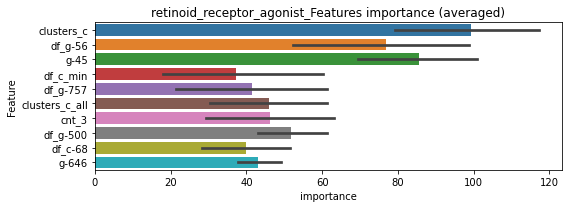

len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277266	valid_1's binary_logloss: 0.0671373
[200]	training's binary_logloss: 0.00535795	valid_1's binary_logloss: 0.038543
[300]	training's binary_logloss: 0.00159507	valid_1's binary_logloss: 0.0316289
[400]	training's binary_logloss: 0.000786526	valid_1's binary_logloss: 0.0297611
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000696171	valid_1's binary_logloss: 0.0292823


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028401	valid_1's binary_logloss: 0.0546725
[200]	training's binary_logloss: 0.00548171	valid_1's binary_logloss: 0.0252249
[300]	training's binary_logloss: 0.00165047	valid_1's binary_logloss: 0.016572
[400]	training's binary_logloss: 0.000814255	valid_1's binary_logloss: 0.0140873
[500]	training's binary_logloss: 0.000536609	valid_1's binary_logloss: 0.0131259
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000469655	valid_1's binary_logloss: 0.0127998


retinoid_receptor_agonist logloss: 0.021042757580857926
retinoid_receptor_antagonist , len(trt) : 6


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371472	valid_1's binary_logloss: 0.0512275
[200]	training's binary_logloss: 0.00426568	valid_1's binary_logloss: 0.00913263
[300]	training's binary_logloss: 0.00132087	valid_1's binary_logloss: 0.00347685
[400]	training's binary_logloss: 0.000846933	valid_1's binary_logloss: 0.0024082
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000776763	valid_1's binary_logloss: 0.0022169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374597	valid_1's binary_logloss: 0.0454842
[200]	training's binary_logloss: 0.0042863	valid_1's binary_logloss: 0.00756356
[300]	training's binary_logloss: 0.0013525	valid_1's binary_logloss: 0.00313493
[400]	training's binary_logloss: 0.000863381	valid_1's binary_logloss: 0.00217831
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000785872	valid_1's binary_logloss: 0.00200362


1 / 3 AUC score:1.000
Threshold: 0.5207020675973457
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00047
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00047, conf_1:0.52070
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.52
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_2: 0.48
threshold:0.48, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371472	valid_1's binary_logloss: 0.0512275
[200]	training's binary_logloss: 0.00426568	valid_1's binary_logloss: 0.00913263
[300]	training's binary_logloss: 0.00132087	valid_1's binary_logloss: 0.00347685
[400]	training's binary_logloss: 0.000846933	valid_1's binary_logloss: 0.0024082
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000776763	valid_1's binary_logloss: 0.0022169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374597	valid_1's binary_logloss: 0.0454842
[200]	training's binary_logloss: 0.0042863	valid_1's binary_logloss: 0.00756356
[300]	training's binary_logloss: 0.0013525	valid_1's binary_logloss: 0.00313493
[400]	training's binary_logloss: 0.000863381	valid_1's binary_logloss: 0.00217831
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000785872	valid_1's binary_logloss: 0.00200362


2 / 3 AUC score:1.000
Threshold: 0.48070206759734574
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00047
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00047, conf_1:0.48070
threshold:0.48, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371472	valid_1's binary_logloss: 0.0512275
[200]	training's binary_logloss: 0.00426568	valid_1's binary_logloss: 0.00913263
[300]	training's binary_logloss: 0.00132087	valid_1's binary_logloss: 0.00347685
[400]	training's binary_logloss: 0.000846933	valid_1's binary_logloss: 0.0024082
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000776763	valid_1's binary_logloss: 0.0022169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374597	valid_1's binary_logloss: 0.0454842
[200]	training's binary_logloss: 0.0042863	valid_1's binary_logloss: 0.00756356
[300]	training's binary_logloss: 0.0013525	valid_1's binary_logloss: 0.00313493
[400]	training's binary_logloss: 0.000863381	valid_1's binary_logloss: 0.00217831
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000785872	valid_1's binary_logloss: 0.00200362


3 / 3 AUC score:1.000
Threshold: 0.48070206759734574
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00047
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00047, conf_1:0.48070
threshold:0.48, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


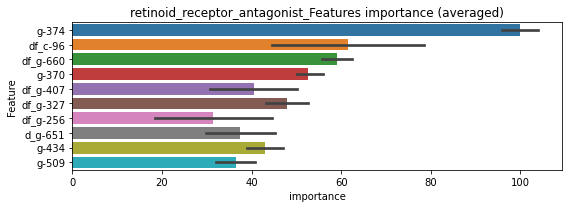

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105011	valid_1's binary_logloss: 0.0135089
[200]	training's binary_logloss: 0.000907227	valid_1's binary_logloss: 0.00293798
[300]	training's binary_logloss: 0.000250936	valid_1's binary_logloss: 0.00216582
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000183604	valid_1's binary_logloss: 0.00211595


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103766	valid_1's binary_logloss: 0.0127372
[200]	training's binary_logloss: 0.000903509	valid_1's binary_logloss: 0.00357699
[300]	training's binary_logloss: 0.000251182	valid_1's binary_logloss: 0.00268052
[400]	training's binary_logloss: 0.000154392	valid_1's binary_logloss: 0.00249685
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00014323	valid_1's binary_logloss: 0.00247492


retinoid_receptor_antagonist logloss: 0.002295434452843648
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895739	valid_1's binary_logloss: 0.176034
[200]	training's binary_logloss: 0.0182005	valid_1's binary_logloss: 0.0827428
[300]	training's binary_logloss: 0.00588042	valid_1's binary_logloss: 0.0544659
[400]	training's binary_logloss: 0.00296376	valid_1's binary_logloss: 0.0442294
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00224402	valid_1's binary_logloss: 0.0414152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892685	valid_1's binary_logloss: 0.1653
[200]	training's binary_logloss: 0.0179287	valid_1's binary_logloss: 0.0746126
[300]	training's binary_logloss: 0.00576623	valid_1's binary_logloss: 0.0494985
[400]	training's binary_logloss: 0.00293831	valid_1's binary_logloss: 0.0404471
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00270465	valid_1's binary_logloss: 0.0392315


1 / 3 AUC score:0.999
Threshold: 0.5669078987219185
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00746
p_label_rate: 0.00176 Vs.target_rate: 0.00157, Num_p_label: 7.0, conf_0:0.00746, conf_1:0.56691
threshold:0.57, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903106	valid_1's binary_logloss: 0.165504
[200]	training's binary_logloss: 0.0182579	valid_1's binary_logloss: 0.0681358
[300]	training's binary_logloss: 0.00582889	valid_1's binary_logloss: 0.0399424
[400]	training's binary_logloss: 0.00295938	valid_1's binary_logloss: 0.0301535
[500]	training's binary_logloss: 0.00199296	valid_1's binary_logloss: 0.0254485
[600]	training's binary_logloss: 0.00165212	valid_1's binary_logloss: 0.023059
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00161519	valid_1's binary_logloss: 0.0227138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900064	valid_1's binary_logloss: 0.17074
[200]	training's binary_logloss: 0.0180727	valid_1's binary_logloss: 0.0738178
[300]	training's binary_logloss: 0.00586552	valid_1's binary_logloss: 0.0456325
[400]	training's binary_logloss: 0.00297424	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5669078987219185
Remove_noisy_labels: 4 → positive_corect_labels: 491.0/986
30th percentile: 0.00533
p_label_rate: 0.00126 Vs.target_rate: 0.00157, Num_p_label: 5.0, conf_0:0.00533, conf_1:0.56691
threshold:0.57, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/986, y_label_rate: 0.49797
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086585	valid_1's binary_logloss: 0.177597
[200]	training's binary_logloss: 0.0174286	valid_1's binary_logloss: 0.0882519
[300]	training's binary_logloss: 0.00562014	valid_1's binary_logloss: 0.0567998
[400]	training's binary_logloss: 0.00288924	valid_1's binary_logloss: 0.0457231
[500]	training's binary_logloss: 0.00197504	valid_1's binary_logloss: 0.0399208
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.0018816	valid_1's binary_logloss: 0.0390229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899258	valid_1's binary_logloss: 0.166481
[200]	training's binary_logloss: 0.0178467	valid_1's binary_logloss: 0.0788749
[300]	training's binary_logloss: 0.00578457	valid_1's binary_logloss: 0.0555457
[400]	training's binary_logloss: 0.00297557	valid_1's binary_logloss: 0.0466045
[500]	training's binary_logloss: 0.00200515	valid_1

3 / 3 AUC score:0.999
Threshold: 0.5669078987219185
Remove_noisy_labels: 13 → positive_corect_labels: 482.0/973
30th percentile: 0.00590
p_label_rate: 0.00126 Vs.target_rate: 0.00157, Num_p_label: 5.0, conf_0:0.00590, conf_1:0.56691
threshold:0.57, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:487.0/4955, y_label_rate: 0.09828


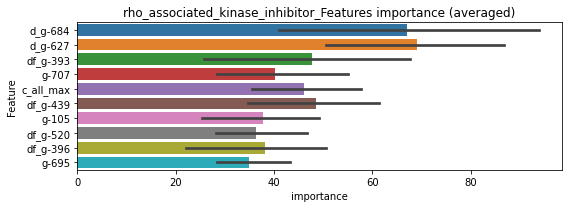

len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228398	valid_1's binary_logloss: 0.039752
[200]	training's binary_logloss: 0.00342641	valid_1's binary_logloss: 0.0144425
[300]	training's binary_logloss: 0.000979755	valid_1's binary_logloss: 0.00989067
[400]	training's binary_logloss: 0.000495544	valid_1's binary_logloss: 0.00891261
[500]	training's binary_logloss: 0.000349446	valid_1's binary_logloss: 0.0085193
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000352452	valid_1's binary_logloss: 0.00851793


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225938	valid_1's binary_logloss: 0.0458261
[200]	training's binary_logloss: 0.00336487	valid_1's binary_logloss: 0.0223082
[300]	training's binary_logloss: 0.00096781	valid_1's binary_logloss: 0.018212
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000721494	valid_1's binary_logloss: 0.0176648


rho_associated_kinase_inhibitor logloss: 0.013090427743938739
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920489	valid_1's binary_logloss: 0.17247
[200]	training's binary_logloss: 0.0200622	valid_1's binary_logloss: 0.0787323
[300]	training's binary_logloss: 0.00662911	valid_1's binary_logloss: 0.0485819
[400]	training's binary_logloss: 0.0033672	valid_1's binary_logloss: 0.03717
[500]	training's binary_logloss: 0.00224166	valid_1's binary_logloss: 0.0328184
[600]	training's binary_logloss: 0.001804	valid_1's binary_logloss: 0.0306189
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00173318	valid_1's binary_logloss: 0.0301022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939352	valid_1's binary_logloss: 0.169993
[200]	training's binary_logloss: 0.019383	valid_1's binary_logloss: 0.0731295
[300]	training's binary_logloss: 0.00635036	valid_1's binary_logloss: 0.0414781
[400]	training's binary_logloss: 0.00323527	valid_1's bi

1 / 3 AUC score:1.000
Threshold: 0.5091882222346754
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00616
p_label_rate: 0.00276 Vs.target_rate: 0.00165, Num_p_label: 11.0, conf_0:0.00521, conf_1:0.50919
threshold:0.51, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895329	valid_1's binary_logloss: 0.192513
[200]	training's binary_logloss: 0.0185511	valid_1's binary_logloss: 0.0881669
[300]	training's binary_logloss: 0.00610346	valid_1's binary_logloss: 0.0561162
[400]	training's binary_logloss: 0.00315078	valid_1's binary_logloss: 0.0439888
[500]	training's binary_logloss: 0.00213765	valid_1's binary_logloss: 0.0382833
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00178897	valid_1's binary_logloss: 0.0357774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920346	valid_1's binary_logloss: 0.154233
[200]	training's binary_logloss: 0.0194839	valid_1's binary_logloss: 0.0620687
[300]	training's binary_logloss: 0.0065125	valid_1's binary_logloss: 0.0351909
[400]	training's binary_logloss: 0.00330693	valid_1's binary_logloss: 0.0258114
[500]	training's binary_logloss: 0.00223045	valid_

2 / 3 AUC score:1.000
Threshold: 0.5091882222346754
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/988
30th percentile: 0.00669
p_label_rate: 0.00251 Vs.target_rate: 0.00165, Num_p_label: 10.0, conf_0:0.00669, conf_1:0.50919
threshold:0.51, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912544	valid_1's binary_logloss: 0.182312
[200]	training's binary_logloss: 0.0187281	valid_1's binary_logloss: 0.0813281
[300]	training's binary_logloss: 0.00619397	valid_1's binary_logloss: 0.0529026
[400]	training's binary_logloss: 0.003188	valid_1's binary_logloss: 0.0448888
[500]	training's binary_logloss: 0.00215807	valid_1's binary_logloss: 0.0400327
[600]	training's binary_logloss: 0.00175659	valid_1's binary_logloss: 0.0373573
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00174378	valid_1's binary_logloss: 0.0371271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882914	valid_1's binary_logloss: 0.169702
[200]	training's binary_logloss: 0.0184651	valid_1's binary_logloss: 0.0733837
[300]	training's binary_logloss: 0.00616608	valid_1's binary_logloss: 0.0445401
[400]	training's binary_logloss: 0.00320192	valid_1

3 / 3 AUC score:1.000
Threshold: 0.5091882222346754
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/980
30th percentile: 0.00589
p_label_rate: 0.00226 Vs.target_rate: 0.00165, Num_p_label: 9.0, conf_0:0.00589, conf_1:0.50919
threshold:0.51, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:496.0/4962, y_label_rate: 0.09996


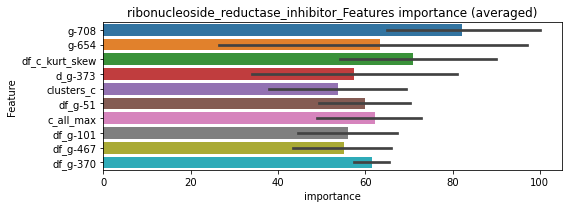

len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234403	valid_1's binary_logloss: 0.0485189
[200]	training's binary_logloss: 0.00350913	valid_1's binary_logloss: 0.0245292
[300]	training's binary_logloss: 0.00103358	valid_1's binary_logloss: 0.0199758
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000580483	valid_1's binary_logloss: 0.018955


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221548	valid_1's binary_logloss: 0.0422541
[200]	training's binary_logloss: 0.00345146	valid_1's binary_logloss: 0.0188399
[300]	training's binary_logloss: 0.00102666	valid_1's binary_logloss: 0.0155764
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000757707	valid_1's binary_logloss: 0.0148645


ribonucleoside_reductase_inhibitor logloss: 0.016909716717667188
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765983	valid_1's binary_logloss: 0.12173
[200]	training's binary_logloss: 0.014325	valid_1's binary_logloss: 0.0396132
[300]	training's binary_logloss: 0.00463878	valid_1's binary_logloss: 0.019673
[400]	training's binary_logloss: 0.0024591	valid_1's binary_logloss: 0.0139759
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00190955	valid_1's binary_logloss: 0.0118605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729781	valid_1's binary_logloss: 0.132114
[200]	training's binary_logloss: 0.0132855	valid_1's binary_logloss: 0.0490525
[300]	training's binary_logloss: 0.004347	valid_1's binary_logloss: 0.0280721
[400]	training's binary_logloss: 0.00228976	valid_1's binary_logloss: 0.0202029
[500]	training's binary_logloss: 0.00162485	valid_1's binary_logloss: 0.0173617
[600]	training's binary_logloss: 0.0014782	valid_1's bi

1 / 3 AUC score:1.000
Threshold: 0.4431069812557208
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00331
p_label_rate: 0.00000 Vs.target_rate: 0.00113, Num_p_label: 0.0, conf_0:0.00331, conf_1:0.44311
Num_p_label: 0.0, Expected: 4.5, Adj_threshold_1: 0.44
Num_p_label: 3.0, Expected: 4.5, Adj_threshold_2: 0.40
threshold:0.40, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765983	valid_1's binary_logloss: 0.12173
[200]	training's binary_logloss: 0.014325	valid_1's binary_logloss: 0.0396132
[300]	training's binary_logloss: 0.00463878	valid_1's binary_logloss: 0.019673
[400]	training's binary_logloss: 0.0024591	valid_1's binary_logloss: 0.0139759
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00190955	valid_1's binary_logloss: 0.0118605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729781	valid_1's binary_logloss: 0.132114
[200]	training's binary_logloss: 0.0132855	valid_1's binary_logloss: 0.0490525
[300]	training's binary_logloss: 0.004347	valid_1's binary_logloss: 0.0280721
[400]	training's binary_logloss: 0.00228976	valid_1's binary_logloss: 0.0202029
[500]	training's binary_logloss: 0.00162485	valid_1's binary_logloss: 0.0173617
[600]	training's binary_logloss: 0.0014782	valid_1's bi

2 / 3 AUC score:1.000
Threshold: 0.4031069812557208
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00331
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00331, conf_1:0.40311
threshold:0.40, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772961	valid_1's binary_logloss: 0.117097
[200]	training's binary_logloss: 0.0143719	valid_1's binary_logloss: 0.0370813
[300]	training's binary_logloss: 0.00465482	valid_1's binary_logloss: 0.0180376
[400]	training's binary_logloss: 0.00246499	valid_1's binary_logloss: 0.0126682
[500]	training's binary_logloss: 0.00171631	valid_1's binary_logloss: 0.00992782
[600]	training's binary_logloss: 0.00152255	valid_1's binary_logloss: 0.0090389
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00150841	valid_1's binary_logloss: 0.00894871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734945	valid_1's binary_logloss: 0.129294
[200]	training's binary_logloss: 0.0135632	valid_1's binary_logloss: 0.0468874
[300]	training's binary_logloss: 0.0043124	valid_1's binary_logloss: 0.026137
[400]	training's binary_logloss: 0.00229711	valid

3 / 3 AUC score:1.000
Threshold: 0.4031069812557208
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00286
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00286, conf_1:0.40311
threshold:0.40, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4981, y_label_rate: 0.10098


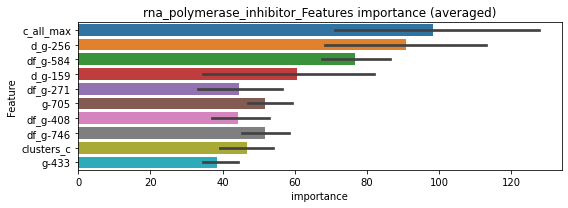

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182006	valid_1's binary_logloss: 0.0306294
[200]	training's binary_logloss: 0.00248079	valid_1's binary_logloss: 0.00918902
[300]	training's binary_logloss: 0.000725588	valid_1's binary_logloss: 0.00571344
[400]	training's binary_logloss: 0.000384863	valid_1's binary_logloss: 0.00487439
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000302024	valid_1's binary_logloss: 0.00466769


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189342	valid_1's binary_logloss: 0.0371818
[200]	training's binary_logloss: 0.00257473	valid_1's binary_logloss: 0.0140985
[300]	training's binary_logloss: 0.000736305	valid_1's binary_logloss: 0.0102657
[400]	training's binary_logloss: 0.000380585	valid_1's binary_logloss: 0.00957734
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000380585	valid_1's binary_logloss: 0.00957734


rna_polymerase_inhibitor logloss: 0.007122021383883451
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199707	valid_1's binary_logloss: 0.54748
[200]	training's binary_logloss: 0.0726662	valid_1's binary_logloss: 0.506254
[300]	training's binary_logloss: 0.0304019	valid_1's binary_logloss: 0.496647
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0318275	valid_1's binary_logloss: 0.49611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198743	valid_1's binary_logloss: 0.571215


1 / 3 AUC score:0.798
Threshold: 0.47166752463682404
Remove_noisy_labels: 280 → positive_corect_labels: 360/720
30th percentile: 0.29490
p_label_rate: 0.20819 Vs.target_rate: 0.00856, Num_p_label: 829.0, conf_0:0.29490, conf_1:0.47167
Num_p_label: 829.0, Expected: 34.1, Adj_threshold_1: 0.47
Num_p_label: 545.0, Expected: 34.1, Adj_threshold_2: 0.51
Num_p_label: 323.0, Expected: 34.1, Adj_threshold_3: 0.55
Num_p_label: 180.0, Expected: 34.1, Adj_threshold_4: 0.59
Num_p_label: 98.0, Expected: 34.1, Adj_threshold_5: 0.63
Num_p_label: 47.0, Expected: 34.1, Adj_threshold_6: 0.67


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.1189	valid_1's binary_logloss: 0.554554


threshold:0.67, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:360.0/720, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179878	valid_1's binary_logloss: 0.490701
[200]	training's binary_logloss: 0.0617272	valid_1's binary_logloss: 0.437471
[300]	training's binary_logloss: 0.0248652	valid_1's binary_logloss: 0.414554
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0264028	valid_1's binary_logloss: 0.414003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183356	valid_1's binary_logloss: 0.472968
[200]	training's binary_logloss: 0.0615421	valid_1's binary_logloss: 0.389479
[300]	training's binary_logloss: 0.0246807	valid_1's binary_logloss: 0.349983


2 / 3 AUC score:0.909
Threshold: 0.6716675246368242
Remove_noisy_labels: 131 → positive_corect_labels: 248.0/589
30th percentile: 0.19342
p_label_rate: 0.06278 Vs.target_rate: 0.00856, Num_p_label: 250.0, conf_0:0.19342, conf_1:0.67167


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0162002	valid_1's binary_logloss: 0.335286


Num_p_label: 250.0, Expected: 34.1, Adj_threshold_1: 0.67
Num_p_label: 184.0, Expected: 34.1, Adj_threshold_2: 0.71
Num_p_label: 119.0, Expected: 34.1, Adj_threshold_3: 0.75
Num_p_label: 78.0, Expected: 34.1, Adj_threshold_4: 0.79
Num_p_label: 44.0, Expected: 34.1, Adj_threshold_5: 0.83
threshold:0.83, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:248.0/589, y_label_rate: 0.42105
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156439	valid_1's binary_logloss: 0.387622
[200]	training's binary_logloss: 0.0499646	valid_1's binary_logloss: 0.290024
[300]	training's binary_logloss: 0.0198306	valid_1's binary_logloss: 0.239866
[400]	training's binary_logloss: 0.0100402	valid_1's binary_logloss: 0.221784
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00946852	valid_1's binary_logloss: 0.21943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155449	valid_1's binary_logloss: 0.417445
[200]	training's binary_logloss: 0.0489919	valid_1's binary_logloss: 0.337211


3 / 3 AUC score:0.955
Threshold: 0.8316675246368244
Remove_noisy_labels: 113 → positive_corect_labels: 136.0/476
30th percentile: 0.09389
p_label_rate: 0.01005 Vs.target_rate: 0.00856, Num_p_label: 40.0, conf_0:0.09389, conf_1:0.83167
threshold:0.83, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0291417	valid_1's binary_logloss: 0.317683


positive y_label:176.0/4458, y_label_rate: 0.03948


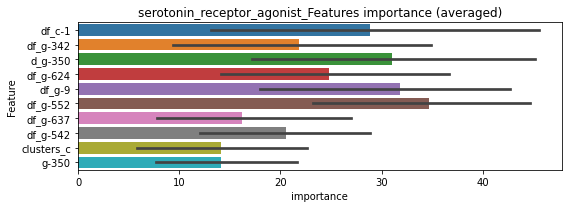

len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151661	valid_1's binary_logloss: 0.0933915


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0135693	valid_1's binary_logloss: 0.0929485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144366	valid_1's binary_logloss: 0.0963757


serotonin_receptor_agonist logloss: 0.09367341244200537


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00833414	valid_1's binary_logloss: 0.0943984
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                   

serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.478688	valid_1's binary_logloss: 0.691213
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.568
Threshold: 0.49724282064262676
Remove_noisy_labels: 456 → positive_corect_labels: 272/544
30th percentile: 0.46909
p_label_rate: 0.47840 Vs.target_rate: 0.01181, Num_p_label: 1905.0, conf_0:0.46909, conf_1:0.49724
Num_p_label: 1905.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 763.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 199.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 47.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[33]	training's binary_logloss: 0.450292	valid_1's binary_logloss: 0.678266


positive y_label:272.0/544, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206014	valid_1's binary_logloss: 0.55623
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.151653	valid_1's binary_logloss: 0.547462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197765	valid_1's binary_logloss: 0.577201


2 / 3 AUC score:0.785
Threshold: 0.6172428206426268
Remove_noisy_labels: 165 → positive_corect_labels: 158.0/379
30th percentile: 0.38780
p_label_rate: 0.30989 Vs.target_rate: 0.01181, Num_p_label: 1234.0, conf_0:0.38780, conf_1:0.61724
Num_p_label: 1234.0, Expected: 47.0, Adj_threshold_1: 0.62
Num_p_label: 951.0, Expected: 47.0, Adj_threshold_2: 0.66
Num_p_label: 711.0, Expected: 47.0, Adj_threshold_3: 0.70
Num_p_label: 489.0, Expected: 47.0, Adj_threshold_4: 0.74
Num_p_label: 293.0, Expected: 47.0, Adj_threshold_5: 0.78
Num_p_label: 147.0, Expected: 47.0, Adj_threshold_6: 0.82
Num_p_label: 43.0, Expected: 47.0, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.131961	valid_1's binary_logloss: 0.564985


positive y_label:158.0/379, y_label_rate: 0.41689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145834	valid_1's binary_logloss: 0.439376
[200]	training's binary_logloss: 0.0457657	valid_1's binary_logloss: 0.388342
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0489474	valid_1's binary_logloss: 0.387032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162041	valid_1's binary_logloss: 0.358525
[200]	training's binary_logloss: 0.054769	valid_1's binary_logloss: 0.295861
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0292271	valid_1's binary_logloss: 0.271853


3 / 3 AUC score:0.933
Threshold: 0.857242820642627
Remove_noisy_labels: 85 → positive_corect_labels: 76.0/294
30th percentile: 0.14884
p_label_rate: 0.12757 Vs.target_rate: 0.01181, Num_p_label: 508.0, conf_0:0.11099, conf_1:0.85724
Num_p_label: 508.0, Expected: 47.0, Adj_threshold_1: 0.86
Num_p_label: 347.0, Expected: 47.0, Adj_threshold_2: 0.90
Num_p_label: 179.0, Expected: 47.0, Adj_threshold_3: 0.94
threshold:0.98, positive p_label:179.0/3982, p_label_rate: 0.04495
positive y_label:255.0/4276, y_label_rate: 0.05964


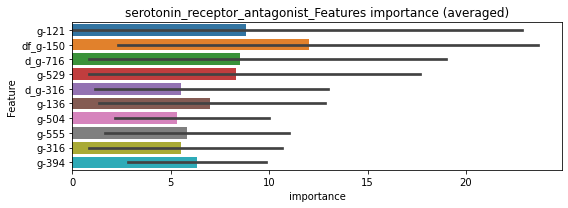

len(train_index) : 2138
len(valid_index) : 2138
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196824	valid_1's binary_logloss: 0.127734


len(train_index) : 2138
len(valid_index) : 2138


Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0157846	valid_1's binary_logloss: 0.126827


================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230172	valid_1's binary_logloss: 0.110174


serotonin_receptor_antagonist logloss: 0.11775071932260273


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0158299	valid_1's binary_logloss: 0.108674
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105051	valid_1's binary_logloss: 0.211915
[200]	training's binary_logloss: 0.0234371	valid_1's binary_logloss: 0.0997406
[300]	training's binary_logloss: 0.00780104	valid_1's binary_logloss: 0.0675836
[400]	training's binary_logloss: 0.00394536	valid_1's binary_logloss: 0.0559066
[500]	training's binary_logloss: 0.00257449	valid_1's binary_logloss: 0.0503338
[600]	training's binary_logloss: 0.00199946	valid_1's binary_logloss: 0.0472867
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00188824	valid_1's binary_logloss: 0.0463695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104676	valid_1's binary_logloss: 0.234167
[200]	training's binary_logloss: 0.0226851	valid_1's binary_logloss: 0.133302
[300]	training's binary_logloss: 0.00763921	valid_1's binary_logloss: 0.104256
Early stopping, best iteration is:
[385]	training's b

1 / 3 AUC score:0.997
Threshold: 0.33244404600001887
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentile: 0.01117
p_label_rate: 0.01080 Vs.target_rate: 0.00195, Num_p_label: 43.0, conf_0:0.01117, conf_1:0.44153
Num_p_label: 43.0, Expected: 7.8, Adj_threshold_1: 0.33
Num_p_label: 31.0, Expected: 7.8, Adj_threshold_2: 0.37
Num_p_label: 22.0, Expected: 7.8, Adj_threshold_3: 0.41
Num_p_label: 12.0, Expected: 7.8, Adj_threshold_4: 0.45
Num_p_label: 6.0, Expected: 7.8, Adj_threshold_5: 0.49
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100373	valid_1's binary_logloss: 0.222113
[200]	training's binary_logloss: 0.0223618	valid_1's binary_logloss: 0.10725
[300]	training's binary_logloss: 0.00741942	valid_1's binary_logloss: 0.0729632
[400]	training's binary_logloss: 0.00370629	valid_1's binary_logloss: 0.0591654
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00261688	valid_1's binary_logloss: 0.0528991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104261	valid_1's binary_logloss: 0.196306
[200]	training's binary_logloss: 0.023994	valid_1's binary_logloss: 0.0907361
[300]	training's binary_logloss: 0.0079375	valid_1's binary_logloss: 0.0541034
[400]	training's binary_logloss: 0.00400007	valid_1's binary_logloss: 0.0402809
[500]	training's binary_logloss: 0.00258406	valid_1's binary_logloss: 0.0343088
[600]	training's binary_logloss: 0.00203846	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.4924440460000188
Remove_noisy_labels: 12 → positive_corect_labels: 482.0/968
30th percentile: 0.00901
p_label_rate: 0.00452 Vs.target_rate: 0.00195, Num_p_label: 18.0, conf_0:0.00901, conf_1:0.54988
threshold:0.49, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:482.0/968, y_label_rate: 0.49793
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985695	valid_1's binary_logloss: 0.192653
[200]	training's binary_logloss: 0.0214598	valid_1's binary_logloss: 0.0961638
[300]	training's binary_logloss: 0.00708602	valid_1's binary_logloss: 0.0689454
[400]	training's binary_logloss: 0.00360067	valid_1's binary_logloss: 0.057021
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00336147	valid_1's binary_logloss: 0.0560986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097033	valid_1's binary_logloss: 0.173394
[200]	training's binary_logloss: 0.0225015	valid_1's binary_logloss: 0.0777012
[300]	training's binary_logloss: 0.00755201	valid_1's binary_logloss: 0.0472679
[400]	training's binary_logloss: 0.00380834	valid_1's binary_logloss: 0.0349329
[500]	training's binary_logloss: 0.00248642	valid_1's binary_logloss: 0.0293583
[600]	training's binary_logloss: 0.00196843	valid_1

3 / 3 AUC score:0.999
Threshold: 0.4924440460000188
Remove_noisy_labels: 8 → positive_corect_labels: 475.0/960
30th percentile: 0.00895
p_label_rate: 0.00603 Vs.target_rate: 0.00195, Num_p_label: 24.0, conf_0:0.00895, conf_1:0.54139
Num_p_label: 24.0, Expected: 7.8, Adj_threshold_1: 0.49
Num_p_label: 17.0, Expected: 7.8, Adj_threshold_2: 0.53
Num_p_label: 15.0, Expected: 7.8, Adj_threshold_3: 0.57
Num_p_label: 10.0, Expected: 7.8, Adj_threshold_4: 0.61
threshold:0.61, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:485.0/4942, y_label_rate: 0.09814


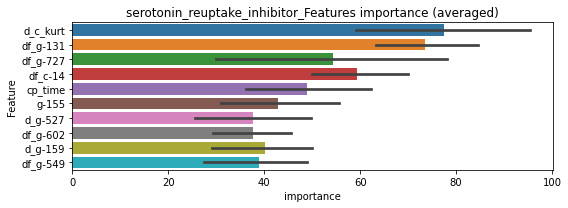

len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240545	valid_1's binary_logloss: 0.0533562
[200]	training's binary_logloss: 0.00395782	valid_1's binary_logloss: 0.0292669
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00161581	valid_1's binary_logloss: 0.0263884


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239675	valid_1's binary_logloss: 0.0476891
[200]	training's binary_logloss: 0.00397697	valid_1's binary_logloss: 0.022845
[300]	training's binary_logloss: 0.00120014	valid_1's binary_logloss: 0.0170148
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000720799	valid_1's binary_logloss: 0.0156992


serotonin_reuptake_inhibitor logloss: 0.02104382386555259
sigma_receptor_agonist , len(trt) : 36


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934571	valid_1's binary_logloss: 0.167614
[200]	training's binary_logloss: 0.0200652	valid_1's binary_logloss: 0.074724
[300]	training's binary_logloss: 0.00660437	valid_1's binary_logloss: 0.0442883
[400]	training's binary_logloss: 0.00332358	valid_1's binary_logloss: 0.0336609
[500]	training's binary_logloss: 0.00222994	valid_1's binary_logloss: 0.0290267
[600]	training's binary_logloss: 0.00179326	valid_1's binary_logloss: 0.0266822
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.0017657	valid_1's binary_logloss: 0.026438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897926	valid_1's binary_logloss: 0.169768
[200]	training's binary_logloss: 0.0184387	valid_1's binary_logloss: 0.0730828
[300]	training's binary_logloss: 0.00601922	valid_1's binary_logloss: 0.0459885
[400]	training's binary_logloss: 0.00310981	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.49031681752953826
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00570
p_label_rate: 0.00075 Vs.target_rate: 0.00161, Num_p_label: 3.0, conf_0:0.00570, conf_1:0.49032
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942692	valid_1's binary_logloss: 0.177833
[200]	training's binary_logloss: 0.0198593	valid_1's binary_logloss: 0.0775231
[300]	training's binary_logloss: 0.00645861	valid_1's binary_logloss: 0.0455505
[400]	training's binary_logloss: 0.00321817	valid_1's binary_logloss: 0.0354148
[500]	training's binary_logloss: 0.00217341	valid_1's binary_logloss: 0.0306167
[600]	training's binary_logloss: 0.00176357	valid_1's binary_logloss: 0.0275736
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00173342	valid_1's binary_logloss: 0.0273531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894665	valid_1's binary_logloss: 0.160494
[200]	training's binary_logloss: 0.0191412	valid_1's binary_logloss: 0.0644558
[300]	training's binary_logloss: 0.00633713	valid_1's binary_logloss: 0.0365371
[400]	training's binary_logloss: 0.00320813	valid

2 / 3 AUC score:1.000
Threshold: 0.49031681752953826
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/992
30th percentile: 0.00563
p_label_rate: 0.00075 Vs.target_rate: 0.00161, Num_p_label: 3.0, conf_0:0.00563, conf_1:0.49032
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890908	valid_1's binary_logloss: 0.173728
[200]	training's binary_logloss: 0.0184963	valid_1's binary_logloss: 0.0816443
[300]	training's binary_logloss: 0.00606242	valid_1's binary_logloss: 0.0539344
[400]	training's binary_logloss: 0.00310126	valid_1's binary_logloss: 0.0423619
[500]	training's binary_logloss: 0.0021003	valid_1's binary_logloss: 0.0379237
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00176988	valid_1's binary_logloss: 0.0360249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919476	valid_1's binary_logloss: 0.166131
[200]	training's binary_logloss: 0.0194439	valid_1's binary_logloss: 0.0667909
[300]	training's binary_logloss: 0.00632873	valid_1's binary_logloss: 0.03693
[400]	training's binary_logloss: 0.00322995	valid_1's binary_logloss: 0.0266984
[500]	training's binary_logloss: 0.00217108	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.49031681752953826
Remove_noisy_labels: 6 → positive_corect_labels: 491.0/986
30th percentile: 0.00559
p_label_rate: 0.00050 Vs.target_rate: 0.00161, Num_p_label: 2.0, conf_0:0.00559, conf_1:0.49032
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.49
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_2: 0.45
Num_p_label: 6.0, Expected: 6.4, Adj_threshold_3: 0.41
threshold:0.41, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/4968, y_label_rate: 0.10004


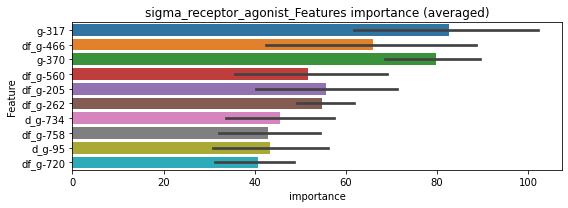

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237855	valid_1's binary_logloss: 0.0460916
[200]	training's binary_logloss: 0.00372555	valid_1's binary_logloss: 0.0217231
[300]	training's binary_logloss: 0.00105537	valid_1's binary_logloss: 0.0162549
[400]	training's binary_logloss: 0.000522355	valid_1's binary_logloss: 0.0145908
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000390705	valid_1's binary_logloss: 0.0140666


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220815	valid_1's binary_logloss: 0.0444787
[200]	training's binary_logloss: 0.00331587	valid_1's binary_logloss: 0.0178599
[300]	training's binary_logloss: 0.000974145	valid_1's binary_logloss: 0.0133
[400]	training's binary_logloss: 0.00050594	valid_1's binary_logloss: 0.0119411
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00038518	valid_1's binary_logloss: 0.011456


sigma_receptor_agonist logloss: 0.012761296824970014
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933002	valid_1's binary_logloss: 0.168536
[200]	training's binary_logloss: 0.0197278	valid_1's binary_logloss: 0.0740426
[300]	training's binary_logloss: 0.00647701	valid_1's binary_logloss: 0.0484874
[400]	training's binary_logloss: 0.00327885	valid_1's binary_logloss: 0.039187
[500]	training's binary_logloss: 0.00216543	valid_1's binary_logloss: 0.0354346
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00187969	valid_1's binary_logloss: 0.0341382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892969	valid_1's binary_logloss: 0.165093
[200]	training's binary_logloss: 0.01918	valid_1's binary_logloss: 0.0763489
[300]	training's binary_logloss: 0.00638275	valid_1's binary_logloss: 0.0482673
[400]	training's binary_logloss: 0.00323845	valid_1's binary_logloss: 0.0382061
[500]	training's binary_logloss: 0.0021742	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.24462826920655378
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00599
p_label_rate: 0.02109 Vs.target_rate: 0.00161, Num_p_label: 84.0, conf_0:0.00599, conf_1:0.39249
Num_p_label: 84.0, Expected: 6.4, Adj_threshold_1: 0.24
Num_p_label: 56.0, Expected: 6.4, Adj_threshold_2: 0.28
Num_p_label: 43.0, Expected: 6.4, Adj_threshold_3: 0.32
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_4: 0.36
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_5: 0.40
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_6: 0.44
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_7: 0.48
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_8: 0.52
threshold:0.52, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921895	valid_1's binary_logloss: 0.161213
[200]	training's binary_logloss: 0.0192946	valid_1's binary_logloss: 0.0650286
[300]	training's binary_logloss: 0.00634618	valid_1's binary_logloss: 0.0356621
[400]	training's binary_logloss: 0.00326423	valid_1's binary_logloss: 0.0262944
[500]	training's binary_logloss: 0.00220275	valid_1's binary_logloss: 0.0220505
[600]	training's binary_logloss: 0.001791	valid_1's binary_logloss: 0.0200675
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.00168928	valid_1's binary_logloss: 0.0195642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920189	valid_1's binary_logloss: 0.163124
[200]	training's binary_logloss: 0.0194514	valid_1's binary_logloss: 0.070588
[300]	training's binary_logloss: 0.0064136	valid_1's binary_logloss: 0.0422421
[400]	training's binary_logloss: 0.00325512	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5246282692065537
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/989
30th percentile: 0.00513
p_label_rate: 0.00226 Vs.target_rate: 0.00161, Num_p_label: 9.0, conf_0:0.00513, conf_1:0.52463
threshold:0.52, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/989, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920093	valid_1's binary_logloss: 0.16246
[200]	training's binary_logloss: 0.0189894	valid_1's binary_logloss: 0.0696711
[300]	training's binary_logloss: 0.00619616	valid_1's binary_logloss: 0.0430242
[400]	training's binary_logloss: 0.00313749	valid_1's binary_logloss: 0.0325852
[500]	training's binary_logloss: 0.00210173	valid_1's binary_logloss: 0.0282018
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00174766	valid_1's binary_logloss: 0.0264851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935016	valid_1's binary_logloss: 0.166698
[200]	training's binary_logloss: 0.0200773	valid_1's binary_logloss: 0.0678626
[300]	training's binary_logloss: 0.00659092	valid_1's binary_logloss: 0.0394189
[400]	training's binary_logloss: 0.00330289	valid_1's binary_logloss: 0.0291739
[500]	training's binary_logloss: 0.00217384	valid_

3 / 3 AUC score:1.000
Threshold: 0.5246282692065537
Remove_noisy_labels: 3 → positive_corect_labels: 490.0/986
30th percentile: 0.00523
p_label_rate: 0.00301 Vs.target_rate: 0.00161, Num_p_label: 12.0, conf_0:0.00523, conf_1:0.52463
threshold:0.52, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:502.0/4968, y_label_rate: 0.10105


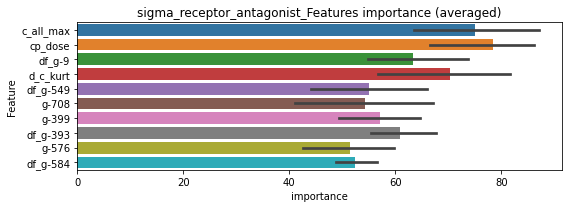

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229564	valid_1's binary_logloss: 0.0606838
[200]	training's binary_logloss: 0.00354068	valid_1's binary_logloss: 0.0342255
[300]	training's binary_logloss: 0.00103142	valid_1's binary_logloss: 0.0291632
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000754346	valid_1's binary_logloss: 0.0281804


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022289	valid_1's binary_logloss: 0.0469356
[200]	training's binary_logloss: 0.00343858	valid_1's binary_logloss: 0.0240126
[300]	training's binary_logloss: 0.00104653	valid_1's binary_logloss: 0.0197162
[400]	training's binary_logloss: 0.000529735	valid_1's binary_logloss: 0.0187114
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000424001	valid_1's binary_logloss: 0.0184764


sigma_receptor_antagonist logloss: 0.02332842119778749
smoothened_receptor_antagonist , len(trt) : 25


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771581	valid_1's binary_logloss: 0.134187
[200]	training's binary_logloss: 0.0139365	valid_1's binary_logloss: 0.0487471
[300]	training's binary_logloss: 0.0043027	valid_1's binary_logloss: 0.0250498
[400]	training's binary_logloss: 0.00225914	valid_1's binary_logloss: 0.0179064
[500]	training's binary_logloss: 0.00159178	valid_1's binary_logloss: 0.0148
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00142022	valid_1's binary_logloss: 0.0136762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745261	valid_1's binary_logloss: 0.126759
[200]	training's binary_logloss: 0.0135301	valid_1's binary_logloss: 0.0425389
[300]	training's binary_logloss: 0.00427553	valid_1's binary_logloss: 0.0219375
[400]	training's binary_logloss: 0.00224204	valid_1's binary_logloss: 0.0154512
[500]	training's binary_logloss: 0.00159894	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.3667112018724623
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00269
p_label_rate: 0.00402 Vs.target_rate: 0.00113, Num_p_label: 16.0, conf_0:0.00269, conf_1:0.39696
Num_p_label: 16.0, Expected: 4.5, Adj_threshold_1: 0.37
Num_p_label: 13.0, Expected: 4.5, Adj_threshold_2: 0.41
Num_p_label: 7.0, Expected: 4.5, Adj_threshold_3: 0.45
Num_p_label: 6.0, Expected: 4.5, Adj_threshold_4: 0.49
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771581	valid_1's binary_logloss: 0.134187
[200]	training's binary_logloss: 0.0139365	valid_1's binary_logloss: 0.0487471
[300]	training's binary_logloss: 0.0043027	valid_1's binary_logloss: 0.0250498
[400]	training's binary_logloss: 0.00225914	valid_1's binary_logloss: 0.0179064
[500]	training's binary_logloss: 0.00159178	valid_1's binary_logloss: 0.0148
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00142022	valid_1's binary_logloss: 0.0136762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745261	valid_1's binary_logloss: 0.126759
[200]	training's binary_logloss: 0.0135301	valid_1's binary_logloss: 0.0425389
[300]	training's binary_logloss: 0.00427553	valid_1's binary_logloss: 0.0219375
[400]	training's binary_logloss: 0.00224204	valid_1's binary_logloss: 0.0154512
[500]	training's binary_logloss: 0.00159894	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.48671120187246225
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/999
30th percentile: 0.00269
p_label_rate: 0.00151 Vs.target_rate: 0.00113, Num_p_label: 6.0, conf_0:0.00269, conf_1:0.48671
threshold:0.49, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/999, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735762	valid_1's binary_logloss: 0.136025
[200]	training's binary_logloss: 0.0133179	valid_1's binary_logloss: 0.0490767
[300]	training's binary_logloss: 0.00415146	valid_1's binary_logloss: 0.0263119
[400]	training's binary_logloss: 0.00221494	valid_1's binary_logloss: 0.0188711
[500]	training's binary_logloss: 0.00158793	valid_1's binary_logloss: 0.0157003
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00139792	valid_1's binary_logloss: 0.0146951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750179	valid_1's binary_logloss: 0.13049
[200]	training's binary_logloss: 0.0135065	valid_1's binary_logloss: 0.0447485
[300]	training's binary_logloss: 0.00421602	valid_1's binary_logloss: 0.0225457
[400]	training's binary_logloss: 0.00223126	valid_1's binary_logloss: 0.0159529
[500]	training's binary_logloss: 0.00156874	valid_

3 / 3 AUC score:1.000
Threshold: 0.48671120187246225
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
30th percentile: 0.00261
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00261, conf_1:0.48671
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:502.0/4981, y_label_rate: 0.10078


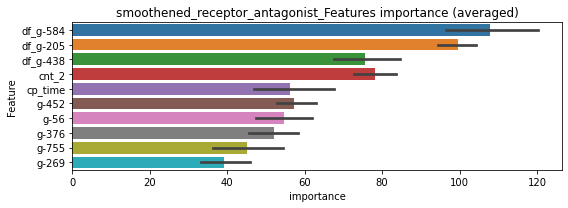

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192702	valid_1's binary_logloss: 0.034827
[200]	training's binary_logloss: 0.00251635	valid_1's binary_logloss: 0.0114531
[300]	training's binary_logloss: 0.000724065	valid_1's binary_logloss: 0.00707495
[400]	training's binary_logloss: 0.000379193	valid_1's binary_logloss: 0.00616585
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000383911	valid_1's binary_logloss: 0.00612677


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192839	valid_1's binary_logloss: 0.0334239
[200]	training's binary_logloss: 0.00255918	valid_1's binary_logloss: 0.0107992
[300]	training's binary_logloss: 0.00072699	valid_1's binary_logloss: 0.00727463
[400]	training's binary_logloss: 0.00037593	valid_1's binary_logloss: 0.0065435
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000383418	valid_1's binary_logloss: 0.0065347


smoothened_receptor_antagonist logloss: 0.006330694705358413
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206722	valid_1's binary_logloss: 0.573983
[200]	training's binary_logloss: 0.0760049	valid_1's binary_logloss: 0.530598
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0657993	valid_1's binary_logloss: 0.523416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203308	valid_1's binary_logloss: 0.572187
[200]	training's binary_logloss: 0.0748941	valid_1's binary_logloss: 0.542121
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0735939	valid_1's binary_logloss: 0.542021


1 / 3 AUC score:0.792
Threshold: 0.49707762464912836
Remove_noisy_labels: 284 → positive_corect_labels: 358/716
30th percentile: 0.33300
p_label_rate: 0.22853 Vs.target_rate: 0.00934, Num_p_label: 910.0, conf_0:0.33300, conf_1:0.49708
Num_p_label: 910.0, Expected: 37.2, Adj_threshold_1: 0.50
Num_p_label: 625.0, Expected: 37.2, Adj_threshold_2: 0.54
Num_p_label: 390.0, Expected: 37.2, Adj_threshold_3: 0.58
Num_p_label: 234.0, Expected: 37.2, Adj_threshold_4: 0.62
Num_p_label: 124.0, Expected: 37.2, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 37.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:358.0/716, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178894	valid_1's binary_logloss: 0.466273
[200]	training's binary_logloss: 0.060475	valid_1's binary_logloss: 0.406447
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0280663	valid_1's binary_logloss: 0.379009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179466	valid_1's binary_logloss: 0.488897
[200]	training's binary_logloss: 0.060218	valid_1's binary_logloss: 0.427814
[300]	training's binary_logloss: 0.0242962	valid_1's binary_logloss: 0.409289
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0138542	valid_1's binary_logloss: 0.400578


2 / 3 AUC score:0.902
Threshold: 0.6970776246491285
Remove_noisy_labels: 130 → positive_corect_labels: 245.0/586
30th percentile: 0.22415
p_label_rate: 0.06806 Vs.target_rate: 0.00934, Num_p_label: 271.0, conf_0:0.22415, conf_1:0.69708
Num_p_label: 271.0, Expected: 37.2, Adj_threshold_1: 0.70
Num_p_label: 203.0, Expected: 37.2, Adj_threshold_2: 0.74
Num_p_label: 134.0, Expected: 37.2, Adj_threshold_3: 0.78
Num_p_label: 82.0, Expected: 37.2, Adj_threshold_4: 0.82
Num_p_label: 43.0, Expected: 37.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:245.0/586, y_label_rate: 0.41809
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157727	valid_1's binary_logloss: 0.421622
[200]	training's binary_logloss: 0.0504862	valid_1's binary_logloss: 0.338741
[300]	training's binary_logloss: 0.0197968	valid_1's binary_logloss: 0.309078
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.016744	valid_1's binary_logloss: 0.304908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157851	valid_1's binary_logloss: 0.388631
[200]	training's binary_logloss: 0.0493377	valid_1's binary_logloss: 0.302265


3 / 3 AUC score:0.944
Threshold: 0.8570776246491286
Remove_noisy_labels: 112 → positive_corect_labels: 134.0/474
30th percentile: 0.11169
p_label_rate: 0.00377 Vs.target_rate: 0.00934, Num_p_label: 15.0, conf_0:0.11169, conf_1:0.85708
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0268562	valid_1's binary_logloss: 0.278672


positive y_label:149.0/4456, y_label_rate: 0.03344


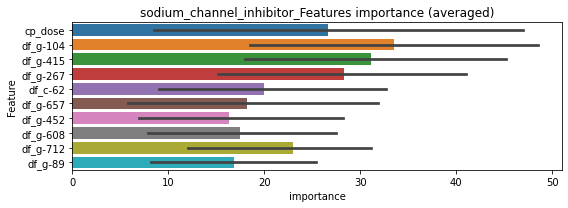

len(train_index) : 2228
len(valid_index) : 2228
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126577	valid_1's binary_logloss: 0.0893793


len(train_index) : 2228
len(valid_index) : 2228
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0121561	valid_1's binary_logloss: 0.089228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110215	valid_1's binary_logloss: 0.0828048


sodium_channel_inhibitor logloss: 0.08575979283936266
sphingosine_receptor_agonist , len(trt) : 32


Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0122477	valid_1's binary_logloss: 0.0822916
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904387	valid_1's binary_logloss: 0.171149
[200]	training's binary_logloss: 0.0181372	valid_1's binary_logloss: 0.0713127
[300]	training's binary_logloss: 0.00588053	valid_1's binary_logloss: 0.0424567
[400]	training's binary_logloss: 0.00297633	valid_1's binary_logloss: 0.030966
[500]	training's binary_logloss: 0.00202219	valid_1's binary_logloss: 0.0264057
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00173537	valid_1's binary_logloss: 0.0243426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919202	valid_1's binary_logloss: 0.164437
[200]	training's binary_logloss: 0.0188275	valid_1's binary_logloss: 0.0638561
[300]	training's binary_logloss: 0.00601504	valid_1's binary_logloss: 0.0348391
[400]	training's binary_logloss: 0.00306803	valid_1's binary_logloss: 0.0250608
[500]	training's binary_logloss: 0.00206077	valid_

1 / 3 AUC score:1.000
Threshold: 0.35908731480782885
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00575
p_label_rate: 0.00402 Vs.target_rate: 0.00144, Num_p_label: 16.0, conf_0:0.00575, conf_1:0.43355
threshold:0.36, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918834	valid_1's binary_logloss: 0.170744
[200]	training's binary_logloss: 0.0181309	valid_1's binary_logloss: 0.069634
[300]	training's binary_logloss: 0.00578406	valid_1's binary_logloss: 0.0415676
[400]	training's binary_logloss: 0.00295172	valid_1's binary_logloss: 0.0323814
[500]	training's binary_logloss: 0.00199429	valid_1's binary_logloss: 0.0284912
[600]	training's binary_logloss: 0.00167836	valid_1's binary_logloss: 0.0267455
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00168498	valid_1's binary_logloss: 0.0267386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937709	valid_1's binary_logloss: 0.168914
[200]	training's binary_logloss: 0.0190003	valid_1's binary_logloss: 0.0667922
[300]	training's binary_logloss: 0.00603385	valid_1's binary_logloss: 0.0383547
[400]	training's binary_logloss: 0.00304001	valid_

2 / 3 AUC score:1.000
Threshold: 0.35908731480782885
Remove_noisy_labels: 6 → positive_corect_labels: 495.0/992
30th percentile: 0.00541
p_label_rate: 0.00276 Vs.target_rate: 0.00144, Num_p_label: 11.0, conf_0:0.00541, conf_1:0.51103
threshold:0.36, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885048	valid_1's binary_logloss: 0.162898
[200]	training's binary_logloss: 0.0183502	valid_1's binary_logloss: 0.0677688
[300]	training's binary_logloss: 0.00599027	valid_1's binary_logloss: 0.0394615
[400]	training's binary_logloss: 0.00304805	valid_1's binary_logloss: 0.0295263
[500]	training's binary_logloss: 0.00205307	valid_1's binary_logloss: 0.0251219
[600]	training's binary_logloss: 0.00170045	valid_1's binary_logloss: 0.0232364
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00167586	valid_1's binary_logloss: 0.0230254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920752	valid_1's binary_logloss: 0.156262
[200]	training's binary_logloss: 0.0183451	valid_1's binary_logloss: 0.060927
[300]	training's binary_logloss: 0.00574647	valid_1's binary_logloss: 0.035332
[400]	training's binary_logloss: 0.00295618	valid_1

3 / 3 AUC score:1.000
Threshold: 0.35908731480782885
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/989
30th percentile: 0.00485
p_label_rate: 0.00427 Vs.target_rate: 0.00144, Num_p_label: 17.0, conf_0:0.00485, conf_1:0.49307
threshold:0.36, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:510.0/4971, y_label_rate: 0.10260


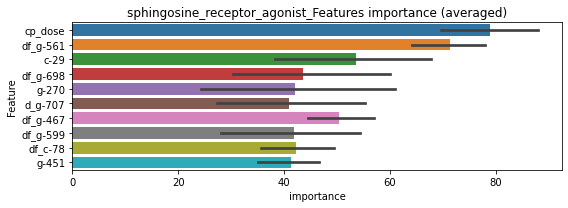

len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252957	valid_1's binary_logloss: 0.0532146
[200]	training's binary_logloss: 0.00374314	valid_1's binary_logloss: 0.0276277
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0016034	valid_1's binary_logloss: 0.0251032


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255893	valid_1's binary_logloss: 0.0494487
[200]	training's binary_logloss: 0.00378632	valid_1's binary_logloss: 0.0247837
[300]	training's binary_logloss: 0.00109685	valid_1's binary_logloss: 0.0207352
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000591723	valid_1's binary_logloss: 0.0197278


sphingosine_receptor_agonist logloss: 0.02241602496035708
src_inhibitor , len(trt) : 71


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126381	valid_1's binary_logloss: 0.275571
[200]	training's binary_logloss: 0.0345917	valid_1's binary_logloss: 0.183184
[300]	training's binary_logloss: 0.0123738	valid_1's binary_logloss: 0.149598
[400]	training's binary_logloss: 0.00604752	valid_1's binary_logloss: 0.135833
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00523253	valid_1's binary_logloss: 0.133004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128369	valid_1's binary_logloss: 0.288347
[200]	training's binary_logloss: 0.034229	valid_1's binary_logloss: 0.18719
[300]	training's binary_logloss: 0.0118889	valid_1's binary_logloss: 0.142806
[400]	training's binary_logloss: 0.00580195	valid_1's binary_logloss: 0.123726


1 / 3 AUC score:0.989
Threshold: 0.3615882854142414


Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00529404	valid_1's binary_logloss: 0.120816


Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentile: 0.03338
p_label_rate: 0.02536 Vs.target_rate: 0.00307, Num_p_label: 101.0, conf_0:0.03338, conf_1:0.49737
Num_p_label: 101.0, Expected: 12.2, Adj_threshold_1: 0.36
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_2: 0.40
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_3: 0.44
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_4: 0.48
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_5: 0.52
threshold:0.52, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121654	valid_1's binary_logloss: 0.279076
[200]	training's binary_logloss: 0.0316046	valid_1's binary_logloss: 0.178912
[300]	training's binary_logloss: 0.0112802	valid_1's binary_logloss: 0.137626
[400]	training's binary_logloss: 0.00549413	valid_1's binary_logloss: 0.120222
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0042644	valid_1's binary_logloss: 0.116595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116812	valid_1's binary_logloss: 0.27641
[200]	training's binary_logloss: 0.0300628	valid_1's binary_logloss: 0.17643
[300]	training's binary_logloss: 0.0105511	valid_1's binary_logloss: 0.134733
[400]	training's binary_logloss: 0.00524547	valid_1's binary_logloss: 0.119438
[500]	training's binary_logloss: 0.00335971	valid_1's binary_logloss: 0.112888
Early stopping, best iteration is:
[512]	training's binary_loglo

2 / 3 AUC score:0.993
Threshold: 0.5215882854142413
Remove_noisy_labels: 39 → positive_corect_labels: 448.0/921
30th percentile: 0.02791
p_label_rate: 0.00427 Vs.target_rate: 0.00307, Num_p_label: 17.0, conf_0:0.02791, conf_1:0.52159
threshold:0.52, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:448.0/921, y_label_rate: 0.48643
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11653	valid_1's binary_logloss: 0.24905
[200]	training's binary_logloss: 0.0291939	valid_1's binary_logloss: 0.142973
[300]	training's binary_logloss: 0.0101082	valid_1's binary_logloss: 0.102703
[400]	training's binary_logloss: 0.00501438	valid_1's binary_logloss: 0.0901436
[500]	training's binary_logloss: 0.00324464	valid_1's binary_logloss: 0.0842306
[600]	training's binary_logloss: 0.00246617	valid_1's binary_logloss: 0.0799362
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00233921	valid_1's binary_logloss: 0.0791117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114939	valid_1's binary_logloss: 0.231909
[200]	training's binary_logloss: 0.0301848	valid_1's binary_logloss: 0.128743
[300]	training's binary_logloss: 0.0106904	valid_1's binary_logloss: 0.0872003
[400]	training's binary_logloss: 0.00537806	valid_1's bina

3 / 3 AUC score:0.998
Threshold: 0.5215882854142413
Remove_noisy_labels: 19 → positive_corect_labels: 432.0/902
30th percentile: 0.01477
p_label_rate: 0.00804 Vs.target_rate: 0.00307, Num_p_label: 32.0, conf_0:0.01477, conf_1:0.56777
threshold:0.52, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:464.0/4884, y_label_rate: 0.09500


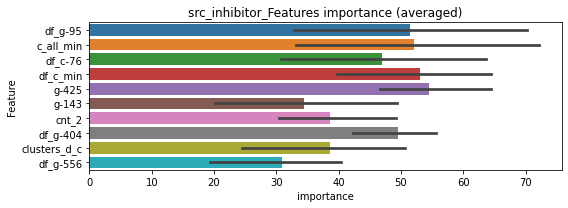

len(train_index) : 2442
len(valid_index) : 2442
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301772	valid_1's binary_logloss: 0.0750939
[200]	training's binary_logloss: 0.00576024	valid_1's binary_logloss: 0.0515278
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00256408	valid_1's binary_logloss: 0.0479242


len(train_index) : 2442
len(valid_index) : 2442
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289311	valid_1's binary_logloss: 0.0734022
[200]	training's binary_logloss: 0.00543338	valid_1's binary_logloss: 0.0501168


src_inhibitor logloss: 0.04830332804887133


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00393776	valid_1's binary_logloss: 0.0486824


steroid , len(trt) : 79


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139889	valid_1's binary_logloss: 0.321607
[200]	training's binary_logloss: 0.0394549	valid_1's binary_logloss: 0.214354
[300]	training's binary_logloss: 0.0142864	valid_1's binary_logloss: 0.166027
[400]	training's binary_logloss: 0.00690014	valid_1's binary_logloss: 0.14477
[500]	training's binary_logloss: 0.00426083	valid_1's binary_logloss: 0.13249
[600]	training's binary_logloss: 0.00310358	valid_1's binary_logloss: 0.126134
[700]	training's binary_logloss: 0.00253225	valid_1's binary_logloss: 0.121695
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.00237867	valid_1's binary_logloss: 0.120386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138014	valid_1's binary_logloss: 0.299108
[200]	training's binary_logloss: 0.0389746	valid_1's binary_logloss: 0.190774
[300]	training's binary_logloss: 0.0140899	valid_1's binary_lo

1 / 3 AUC score:0.991
Threshold: 0.4033560632997075
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentile: 0.03508
p_label_rate: 0.02386 Vs.target_rate: 0.00339, Num_p_label: 95.0, conf_0:0.03108, conf_1:0.56119
Num_p_label: 95.0, Expected: 13.5, Adj_threshold_1: 0.40
Num_p_label: 63.0, Expected: 13.5, Adj_threshold_2: 0.44
Num_p_label: 44.0, Expected: 13.5, Adj_threshold_3: 0.48
Num_p_label: 30.0, Expected: 13.5, Adj_threshold_4: 0.52
Num_p_label: 24.0, Expected: 13.5, Adj_threshold_5: 0.56
Num_p_label: 13.0, Expected: 13.5, Adj_threshold_6: 0.60
threshold:0.60, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128511	valid_1's binary_logloss: 0.301669
[200]	training's binary_logloss: 0.0348873	valid_1's binary_logloss: 0.200557
[300]	training's binary_logloss: 0.0126196	valid_1's binary_logloss: 0.16626
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00779616	valid_1's binary_logloss: 0.154534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130196	valid_1's binary_logloss: 0.291327
[200]	training's binary_logloss: 0.0362331	valid_1's binary_logloss: 0.181462
[300]	training's binary_logloss: 0.0129719	valid_1's binary_logloss: 0.13667
[400]	training's binary_logloss: 0.00637839	valid_1's binary_logloss: 0.11797
[500]	training's binary_logloss: 0.0039678	valid_1's binary_logloss: 0.1103
[600]	training's binary_logloss: 0.00291587	valid_1's binary_logloss: 0.103609
[700]	training's binary_logloss: 0.00241607	valid_1's binary_loglos

2 / 3 AUC score:0.990
Threshold: 0.6033560632997076
Remove_noisy_labels: 42 → positive_corect_labels: 447.0/922
30th percentile: 0.03783
p_label_rate: 0.00552 Vs.target_rate: 0.00339, Num_p_label: 22.0, conf_0:0.03783, conf_1:0.60336
threshold:0.60, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:447.0/922, y_label_rate: 0.48482
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121143	valid_1's binary_logloss: 0.241224
[200]	training's binary_logloss: 0.0325788	valid_1's binary_logloss: 0.131074
[300]	training's binary_logloss: 0.0117007	valid_1's binary_logloss: 0.0916506
[400]	training's binary_logloss: 0.00582898	valid_1's binary_logloss: 0.0729979
[500]	training's binary_logloss: 0.00372581	valid_1's binary_logloss: 0.0637641
[600]	training's binary_logloss: 0.00281037	valid_1's binary_logloss: 0.0586933
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00251223	valid_1's binary_logloss: 0.0569765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127099	valid_1's binary_logloss: 0.251798
[200]	training's binary_logloss: 0.0343774	valid_1's binary_logloss: 0.136305
[300]	training's binary_logloss: 0.0123471	valid_1's binary_logloss: 0.0915125
[400]	training's binary_logloss: 0.00613552	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.6033560632997076
Remove_noisy_labels: 10 → positive_corect_labels: 438.0/912
30th percentile: 0.01916
p_label_rate: 0.00829 Vs.target_rate: 0.00339, Num_p_label: 33.0, conf_0:0.01767, conf_1:0.60336
threshold:0.60, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:471.0/4894, y_label_rate: 0.09624


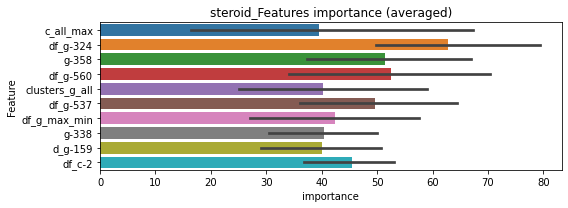

len(train_index) : 2447
len(valid_index) : 2447
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033047	valid_1's binary_logloss: 0.0942727
[200]	training's binary_logloss: 0.00623304	valid_1's binary_logloss: 0.0680687
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00319226	valid_1's binary_logloss: 0.0661052


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328565	valid_1's binary_logloss: 0.0865794
[200]	training's binary_logloss: 0.00726452	valid_1's binary_logloss: 0.0593215
[300]	training's binary_logloss: 0.0021293	valid_1's binary_logloss: 0.0530738
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00186632	valid_1's binary_logloss: 0.0527515


steroid logloss: 0.059428359718446906
syk_inhibitor , len(trt) : 19


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634371	valid_1's binary_logloss: 0.0939793
[200]	training's binary_logloss: 0.0103654	valid_1's binary_logloss: 0.0270882
[300]	training's binary_logloss: 0.00336092	valid_1's binary_logloss: 0.0139034
[400]	training's binary_logloss: 0.00186066	valid_1's binary_logloss: 0.0100434
[500]	training's binary_logloss: 0.00140995	valid_1's binary_logloss: 0.00858398
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00138404	valid_1's binary_logloss: 0.00844399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621361	valid_1's binary_logloss: 0.116378
[200]	training's binary_logloss: 0.0100695	valid_1's binary_logloss: 0.0330229
[300]	training's binary_logloss: 0.00331426	valid_1's binary_logloss: 0.0162561
[400]	training's binary_logloss: 0.00181467	valid_1's binary_logloss: 0.0106862
[500]	training's binary_logloss: 0.00139593	va

1 / 3 AUC score:1.000
Threshold: 0.36593223030420463
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00242
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00242, conf_1:0.36593
threshold:0.37, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634371	valid_1's binary_logloss: 0.0939793
[200]	training's binary_logloss: 0.0103654	valid_1's binary_logloss: 0.0270882
[300]	training's binary_logloss: 0.00336092	valid_1's binary_logloss: 0.0139034
[400]	training's binary_logloss: 0.00186066	valid_1's binary_logloss: 0.0100434
[500]	training's binary_logloss: 0.00140995	valid_1's binary_logloss: 0.00858398
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00138404	valid_1's binary_logloss: 0.00844399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621361	valid_1's binary_logloss: 0.116378
[200]	training's binary_logloss: 0.0100695	valid_1's binary_logloss: 0.0330229
[300]	training's binary_logloss: 0.00331426	valid_1's binary_logloss: 0.0162561
[400]	training's binary_logloss: 0.00181467	valid_1's binary_logloss: 0.0106862
[500]	training's binary_logloss: 0.00139593	va

2 / 3 AUC score:1.000
Threshold: 0.36593223030420463
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00242
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00242, conf_1:0.36593
threshold:0.37, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634371	valid_1's binary_logloss: 0.0939793
[200]	training's binary_logloss: 0.0103654	valid_1's binary_logloss: 0.0270882
[300]	training's binary_logloss: 0.00336092	valid_1's binary_logloss: 0.0139034
[400]	training's binary_logloss: 0.00186066	valid_1's binary_logloss: 0.0100434
[500]	training's binary_logloss: 0.00140995	valid_1's binary_logloss: 0.00858398
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00138404	valid_1's binary_logloss: 0.00844399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621361	valid_1's binary_logloss: 0.116378
[200]	training's binary_logloss: 0.0100695	valid_1's binary_logloss: 0.0330229
[300]	training's binary_logloss: 0.00331426	valid_1's binary_logloss: 0.0162561
[400]	training's binary_logloss: 0.00181467	valid_1's binary_logloss: 0.0106862
[500]	training's binary_logloss: 0.00139593	va

3 / 3 AUC score:1.000
Threshold: 0.36593223030420463
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00242
p_label_rate: 0.00075 Vs.target_rate: 0.00086, Num_p_label: 3.0, conf_0:0.00242, conf_1:0.36593
threshold:0.37, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4982, y_label_rate: 0.10096


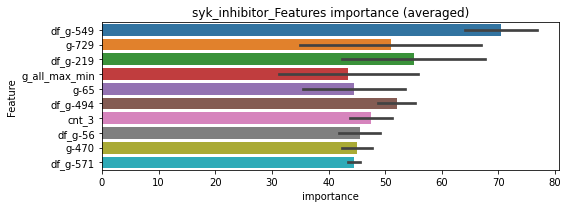

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157984	valid_1's binary_logloss: 0.0248015
[200]	training's binary_logloss: 0.00194305	valid_1's binary_logloss: 0.00675435
[300]	training's binary_logloss: 0.000564825	valid_1's binary_logloss: 0.00387165
[400]	training's binary_logloss: 0.000307949	valid_1's binary_logloss: 0.0031658
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000259484	valid_1's binary_logloss: 0.00304293


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163626	valid_1's binary_logloss: 0.029358
[200]	training's binary_logloss: 0.00197674	valid_1's binary_logloss: 0.0109896
[300]	training's binary_logloss: 0.000566834	valid_1's binary_logloss: 0.00754519
[400]	training's binary_logloss: 0.000304234	valid_1's binary_logloss: 0.00671509
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000271848	valid_1's binary_logloss: 0.00661552


syk_inhibitor logloss: 0.004829225807846787
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114825	valid_1's binary_logloss: 0.269912
[200]	training's binary_logloss: 0.0280858	valid_1's binary_logloss: 0.169175
[300]	training's binary_logloss: 0.00967268	valid_1's binary_logloss: 0.135671
[400]	training's binary_logloss: 0.00471152	valid_1's binary_logloss: 0.123747
[500]	training's binary_logloss: 0.00303102	valid_1's binary_logloss: 0.115415
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00293399	valid_1's binary_logloss: 0.115022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119124	valid_1's binary_logloss: 0.229672
[200]	training's binary_logloss: 0.0310058	valid_1's binary_logloss: 0.124523
[300]	training's binary_logloss: 0.010694	valid_1's binary_logloss: 0.0864387
[400]	training's binary_logloss: 0.00518444	valid_1's binary_logloss: 0.0698053
[500]	training's binary_logloss: 0.00328071	valid_1's binar

1 / 3 AUC score:0.993
Threshold: 0.3127313063553574
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentile: 0.01925
p_label_rate: 0.01883 Vs.target_rate: 0.00262, Num_p_label: 75.0, conf_0:0.01925, conf_1:0.35001
Num_p_label: 75.0, Expected: 10.4, Adj_threshold_1: 0.31
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_2: 0.35
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_3: 0.39
Num_p_label: 12.0, Expected: 10.4, Adj_threshold_4: 0.43
threshold:0.43, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113035	valid_1's binary_logloss: 0.24749
[200]	training's binary_logloss: 0.0277558	valid_1's binary_logloss: 0.146647
[300]	training's binary_logloss: 0.00957889	valid_1's binary_logloss: 0.114573
[400]	training's binary_logloss: 0.0047452	valid_1's binary_logloss: 0.101065
[500]	training's binary_logloss: 0.00303169	valid_1's binary_logloss: 0.0965217
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00301253	valid_1's binary_logloss: 0.0963713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114137	valid_1's binary_logloss: 0.23756
[200]	training's binary_logloss: 0.0288237	valid_1's binary_logloss: 0.128702
[300]	training's binary_logloss: 0.0098992	valid_1's binary_logloss: 0.087285
[400]	training's binary_logloss: 0.00486061	valid_1's binary_logloss: 0.0694649
[500]	training's binary_logloss: 0.00313098	valid_1's binary

2 / 3 AUC score:0.996
Threshold: 0.43273130635535734
Remove_noisy_labels: 18 → positive_corect_labels: 472.0/954
30th percentile: 0.01615
p_label_rate: 0.00753 Vs.target_rate: 0.00262, Num_p_label: 30.0, conf_0:0.01615, conf_1:0.43273
threshold:0.43, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:472.0/954, y_label_rate: 0.49476
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108068	valid_1's binary_logloss: 0.243505
[200]	training's binary_logloss: 0.0262225	valid_1's binary_logloss: 0.149637
[300]	training's binary_logloss: 0.00897505	valid_1's binary_logloss: 0.116429
[400]	training's binary_logloss: 0.00447717	valid_1's binary_logloss: 0.100659
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00440729	valid_1's binary_logloss: 0.100579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111689	valid_1's binary_logloss: 0.238258
[200]	training's binary_logloss: 0.0271092	valid_1's binary_logloss: 0.145637
[300]	training's binary_logloss: 0.00917094	valid_1's binary_logloss: 0.110231
[400]	training's binary_logloss: 0.00458004	valid_1's binary_logloss: 0.100915
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00466385	valid_1's binary_logloss: 0.100742


3 / 3 AUC score:0.990
Threshold: 0.43273130635535734
Remove_noisy_labels: 29 → positive_corect_labels: 453.0/925
30th percentile: 0.02186
p_label_rate: 0.00879 Vs.target_rate: 0.00262, Num_p_label: 35.0, conf_0:0.02186, conf_1:0.46323
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_1: 0.43
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_2: 0.47
Num_p_label: 12.0, Expected: 10.4, Adj_threshold_3: 0.51
threshold:0.51, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:465.0/4907, y_label_rate: 0.09476


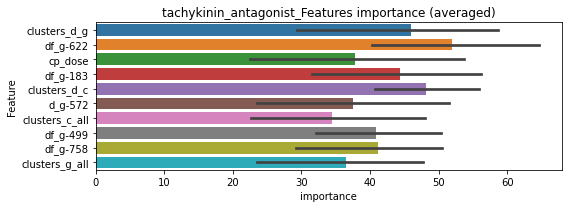

len(train_index) : 2453
len(valid_index) : 2454
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281741	valid_1's binary_logloss: 0.0741748
[200]	training's binary_logloss: 0.0051273	valid_1's binary_logloss: 0.0472203
[300]	training's binary_logloss: 0.00147501	valid_1's binary_logloss: 0.0415209
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0016099	valid_1's binary_logloss: 0.0413914


len(train_index) : 2454
len(valid_index) : 2453
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278384	valid_1's binary_logloss: 0.0654478
[200]	training's binary_logloss: 0.00482725	valid_1's binary_logloss: 0.0390459
[300]	training's binary_logloss: 0.00150156	valid_1's binary_logloss: 0.033847
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00115133	valid_1's binary_logloss: 0.0331884


tachykinin_antagonist logloss: 0.037290711282243504
tgf-beta_receptor_inhibitor , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851305	valid_1's binary_logloss: 0.159429
[200]	training's binary_logloss: 0.0174078	valid_1's binary_logloss: 0.0683558
[300]	training's binary_logloss: 0.00559215	valid_1's binary_logloss: 0.043184
[400]	training's binary_logloss: 0.00286611	valid_1's binary_logloss: 0.0321845
[500]	training's binary_logloss: 0.00196041	valid_1's binary_logloss: 0.0281069
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00168443	valid_1's binary_logloss: 0.0267154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827153	valid_1's binary_logloss: 0.153854
[200]	training's binary_logloss: 0.0163302	valid_1's binary_logloss: 0.0629422
[300]	training's binary_logloss: 0.00531151	valid_1's binary_logloss: 0.0362326
[400]	training's binary_logloss: 0.00276702	valid_1's binary_logloss: 0.026501
[500]	training's binary_logloss: 0.00191253	valid_1

1 / 3 AUC score:1.000
Threshold: 0.3011950604713223
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentile: 0.00432
p_label_rate: 0.00603 Vs.target_rate: 0.00135, Num_p_label: 24.0, conf_0:0.00432, conf_1:0.30861
Num_p_label: 24.0, Expected: 5.4, Adj_threshold_1: 0.30
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_2: 0.34
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_3: 0.38
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837851	valid_1's binary_logloss: 0.145493
[200]	training's binary_logloss: 0.0164159	valid_1's binary_logloss: 0.0551295
[300]	training's binary_logloss: 0.00536902	valid_1's binary_logloss: 0.032246
[400]	training's binary_logloss: 0.00278403	valid_1's binary_logloss: 0.0238305
[500]	training's binary_logloss: 0.0019136	valid_1's binary_logloss: 0.0202655
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00165232	valid_1's binary_logloss: 0.0188081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838013	valid_1's binary_logloss: 0.170577
[200]	training's binary_logloss: 0.0164352	valid_1's binary_logloss: 0.0806863
[300]	training's binary_logloss: 0.00529439	valid_1's binary_logloss: 0.0513022
[400]	training's binary_logloss: 0.00274503	valid_1's binary_logloss: 0.0384998
[500]	training's binary_logloss: 0.00190371	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4211950604713222
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/994
30th percentile: 0.00438
p_label_rate: 0.00100 Vs.target_rate: 0.00135, Num_p_label: 4.0, conf_0:0.00438, conf_1:0.42120
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/994, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842306	valid_1's binary_logloss: 0.143256
[200]	training's binary_logloss: 0.0167254	valid_1's binary_logloss: 0.0555237
[300]	training's binary_logloss: 0.00540154	valid_1's binary_logloss: 0.0315831
[400]	training's binary_logloss: 0.00282663	valid_1's binary_logloss: 0.0233163
[500]	training's binary_logloss: 0.00195785	valid_1's binary_logloss: 0.0195753
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00167156	valid_1's binary_logloss: 0.0182316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836843	valid_1's binary_logloss: 0.153372
[200]	training's binary_logloss: 0.0165799	valid_1's binary_logloss: 0.0610255
[300]	training's binary_logloss: 0.00539327	valid_1's binary_logloss: 0.0329847
[400]	training's binary_logloss: 0.00279775	valid_1's binary_logloss: 0.0238691
[500]	training's binary_logloss: 0.00191393	valid

3 / 3 AUC score:1.000
Threshold: 0.4211950604713222
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/993
30th percentile: 0.00452
p_label_rate: 0.00201 Vs.target_rate: 0.00135, Num_p_label: 8.0, conf_0:0.00452, conf_1:0.42120
threshold:0.42, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:503.0/4975, y_label_rate: 0.10111


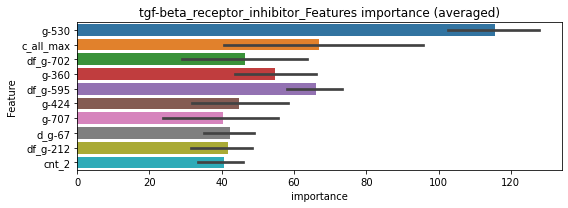

len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220885	valid_1's binary_logloss: 0.0409344
[200]	training's binary_logloss: 0.00319634	valid_1's binary_logloss: 0.0191896
[300]	training's binary_logloss: 0.000912316	valid_1's binary_logloss: 0.0159599
[400]	training's binary_logloss: 0.000463878	valid_1's binary_logloss: 0.0149954
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000397527	valid_1's binary_logloss: 0.0147936


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222578	valid_1's binary_logloss: 0.0433797
[200]	training's binary_logloss: 0.00333133	valid_1's binary_logloss: 0.0177152
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00106506	valid_1's binary_logloss: 0.0126471


tgf-beta_receptor_inhibitor logloss: 0.013720568115012897
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068604	valid_1's binary_logloss: 0.0987556
[200]	training's binary_logloss: 0.0116271	valid_1's binary_logloss: 0.0273076
[300]	training's binary_logloss: 0.00363137	valid_1's binary_logloss: 0.012819
[400]	training's binary_logloss: 0.00193213	valid_1's binary_logloss: 0.00872519
[500]	training's binary_logloss: 0.00142181	valid_1's binary_logloss: 0.00718221
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0012912	valid_1's binary_logloss: 0.00663964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653065	valid_1's binary_logloss: 0.117901
[200]	training's binary_logloss: 0.0109553	valid_1's binary_logloss: 0.0425312
[300]	training's binary_logloss: 0.00345825	valid_1's binary_logloss: 0.025516
[400]	training's binary_logloss: 0.00184878	valid_1's binary_logloss: 0.0188438


1 / 3 AUC score:1.000
Threshold: 0.7468023651478882


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00148776	valid_1's binary_logloss: 0.0169587


Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00198
p_label_rate: 0.00000 Vs.target_rate: 0.00086, Num_p_label: 0.0, conf_0:0.00198, conf_1:0.74680
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_1: 0.75
Num_p_label: 0.0, Expected: 3.4, Adj_threshold_2: 0.71
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_3: 0.67
Num_p_label: 1.0, Expected: 3.4, Adj_threshold_4: 0.63
Num_p_label: 2.0, Expected: 3.4, Adj_threshold_5: 0.59
Num_p_label: 4.0, Expected: 3.4, Adj_threshold_6: 0.55
threshold:0.55, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668265	valid_1's binary_logloss: 0.105911
[200]	training's binary_logloss: 0.0111476	valid_1's binary_logloss: 0.0293624
[300]	training's binary_logloss: 0.00353966	valid_1's binary_logloss: 0.0136964
[400]	training's binary_logloss: 0.00192096	valid_1's binary_logloss: 0.00929319
[500]	training's binary_logloss: 0.00140432	valid_1's binary_logloss: 0.00768938
[600]	training's binary_logloss: 0.00128538	valid_1's binary_logloss: 0.00725796
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00128545	valid_1's binary_logloss: 0.00725782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670523	valid_1's binary_logloss: 0.122546
[200]	training's binary_logloss: 0.0111621	valid_1's binary_logloss: 0.0425393
[300]	training's binary_logloss: 0.00345989	valid_1's binary_logloss: 0.0233213
[400]	training's binary_logloss: 0.00185086	v

2 / 3 AUC score:1.000
Threshold: 0.546802365147888
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/997
30th percentile: 0.00167
p_label_rate: 0.00126 Vs.target_rate: 0.00086, Num_p_label: 5.0, conf_0:0.00167, conf_1:0.54680
threshold:0.55, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668123	valid_1's binary_logloss: 0.101387
[200]	training's binary_logloss: 0.0112731	valid_1's binary_logloss: 0.0303897
[300]	training's binary_logloss: 0.00354828	valid_1's binary_logloss: 0.0148423
[400]	training's binary_logloss: 0.00190297	valid_1's binary_logloss: 0.0101395
[500]	training's binary_logloss: 0.00140045	valid_1's binary_logloss: 0.00859463
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00128819	valid_1's binary_logloss: 0.00829622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670345	valid_1's binary_logloss: 0.107986
[200]	training's binary_logloss: 0.0111681	valid_1's binary_logloss: 0.034565
[300]	training's binary_logloss: 0.00349481	valid_1's binary_logloss: 0.0184955
[400]	training's binary_logloss: 0.00187776	valid_1's binary_logloss: 0.0132454
[500]	training's binary_logloss: 0.00138958	vali

3 / 3 AUC score:1.000
Threshold: 0.546802365147888
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/997
30th percentile: 0.00169
p_label_rate: 0.00151 Vs.target_rate: 0.00086, Num_p_label: 6.0, conf_0:0.00169, conf_1:0.54680
threshold:0.55, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:504.0/4979, y_label_rate: 0.10123


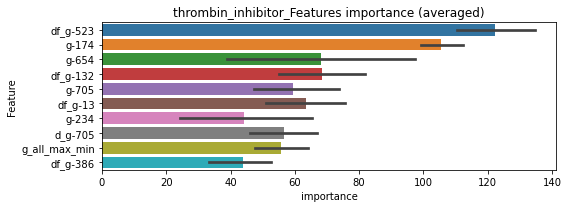

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167583	valid_1's binary_logloss: 0.0279993
[200]	training's binary_logloss: 0.00208057	valid_1's binary_logloss: 0.0104668
[300]	training's binary_logloss: 0.000607872	valid_1's binary_logloss: 0.0077837
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00034207	valid_1's binary_logloss: 0.00730812


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166255	valid_1's binary_logloss: 0.0335271
[200]	training's binary_logloss: 0.0020325	valid_1's binary_logloss: 0.013581
[300]	training's binary_logloss: 0.000595311	valid_1's binary_logloss: 0.0103197
[400]	training's binary_logloss: 0.000317576	valid_1's binary_logloss: 0.00940093
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000283759	valid_1's binary_logloss: 0.00932517


thrombin_inhibitor logloss: 0.008316443633054336
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938747	valid_1's binary_logloss: 0.178481
[200]	training's binary_logloss: 0.0204372	valid_1's binary_logloss: 0.0937027
[300]	training's binary_logloss: 0.00671712	valid_1's binary_logloss: 0.0711387
[400]	training's binary_logloss: 0.00336521	valid_1's binary_logloss: 0.0638283
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00255365	valid_1's binary_logloss: 0.0614933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088347	valid_1's binary_logloss: 0.172724
[200]	training's binary_logloss: 0.0188834	valid_1's binary_logloss: 0.0794937
[300]	training's binary_logloss: 0.00627986	valid_1's binary_logloss: 0.0499216
[400]	training's binary_logloss: 0.00328622	valid_1's binary_logloss: 0.036987
[500]	training's binary_logloss: 0.00222527	valid_1's binary_logloss: 0.0334855
[600]	training's binary_logloss: 0.00182236	valid_1

1 / 3 AUC score:0.999
Threshold: 0.2824836686096781
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentile: 0.00739
p_label_rate: 0.01155 Vs.target_rate: 0.00165, Num_p_label: 46.0, conf_0:0.00739, conf_1:0.38309
Num_p_label: 46.0, Expected: 6.6, Adj_threshold_1: 0.28
Num_p_label: 30.0, Expected: 6.6, Adj_threshold_2: 0.32
Num_p_label: 23.0, Expected: 6.6, Adj_threshold_3: 0.36
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_4: 0.40
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_5: 0.44
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_6: 0.48
threshold:0.48, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915751	valid_1's binary_logloss: 0.165364
[200]	training's binary_logloss: 0.0199692	valid_1's binary_logloss: 0.0691688
[300]	training's binary_logloss: 0.00657539	valid_1's binary_logloss: 0.0411469
[400]	training's binary_logloss: 0.00336315	valid_1's binary_logloss: 0.031142
[500]	training's binary_logloss: 0.00224388	valid_1's binary_logloss: 0.0263624
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00186009	valid_1's binary_logloss: 0.0243965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910687	valid_1's binary_logloss: 0.167729
[200]	training's binary_logloss: 0.0194965	valid_1's binary_logloss: 0.0739157
[300]	training's binary_logloss: 0.00649701	valid_1's binary_logloss: 0.0448063
[400]	training's binary_logloss: 0.00333327	valid_1's binary_logloss: 0.0337694
[500]	training's binary_logloss: 0.00222559	valid_

2 / 3 AUC score:1.000
Threshold: 0.482483668609678
Remove_noisy_labels: 3 → positive_corect_labels: 490.0/983
30th percentile: 0.00703
p_label_rate: 0.00377 Vs.target_rate: 0.00165, Num_p_label: 15.0, conf_0:0.00703, conf_1:0.51732
threshold:0.48, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:490.0/983, y_label_rate: 0.49847
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089984	valid_1's binary_logloss: 0.167377
[200]	training's binary_logloss: 0.0194196	valid_1's binary_logloss: 0.0769112
[300]	training's binary_logloss: 0.0064573	valid_1's binary_logloss: 0.0490953
[400]	training's binary_logloss: 0.00328204	valid_1's binary_logloss: 0.0382418
[500]	training's binary_logloss: 0.00220773	valid_1's binary_logloss: 0.033756
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00185827	valid_1's binary_logloss: 0.0316755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922071	valid_1's binary_logloss: 0.158882
[200]	training's binary_logloss: 0.0197215	valid_1's binary_logloss: 0.0645212
[300]	training's binary_logloss: 0.00655932	valid_1's binary_logloss: 0.0384593
[400]	training's binary_logloss: 0.0033061	valid_1's binary_logloss: 0.0286326
[500]	training's binary_logloss: 0.00220381	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.482483668609678
Remove_noisy_labels: 7 → positive_corect_labels: 485.0/976
30th percentile: 0.00653
p_label_rate: 0.00276 Vs.target_rate: 0.00165, Num_p_label: 11.0, conf_0:0.00653, conf_1:0.50614
threshold:0.48, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:496.0/4958, y_label_rate: 0.10004


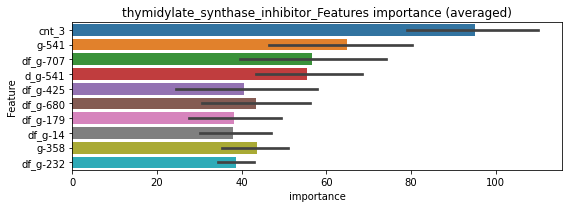

len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241459	valid_1's binary_logloss: 0.0506171
[200]	training's binary_logloss: 0.00383846	valid_1's binary_logloss: 0.0264488
[300]	training's binary_logloss: 0.00108585	valid_1's binary_logloss: 0.0233615
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000922707	valid_1's binary_logloss: 0.0231302


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230542	valid_1's binary_logloss: 0.0528378
[200]	training's binary_logloss: 0.00375712	valid_1's binary_logloss: 0.0276755
[300]	training's binary_logloss: 0.00106341	valid_1's binary_logloss: 0.022574
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000795785	valid_1's binary_logloss: 0.0217766


thymidylate_synthase_inhibitor logloss: 0.022453428650171248
tlr_agonist , len(trt) : 30


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817797	valid_1's binary_logloss: 0.145529
[200]	training's binary_logloss: 0.0159572	valid_1's binary_logloss: 0.057401
[300]	training's binary_logloss: 0.00516017	valid_1's binary_logloss: 0.033325
[400]	training's binary_logloss: 0.00269855	valid_1's binary_logloss: 0.0246734
[500]	training's binary_logloss: 0.00187307	valid_1's binary_logloss: 0.0214671
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00160868	valid_1's binary_logloss: 0.0198711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842366	valid_1's binary_logloss: 0.163273
[200]	training's binary_logloss: 0.0160968	valid_1's binary_logloss: 0.0648658
[300]	training's binary_logloss: 0.0051657	valid_1's binary_logloss: 0.0386636
[400]	training's binary_logloss: 0.00267208	valid_1's binary_logloss: 0.030212
[500]	training's binary_logloss: 0.00185836	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.4808661387102256
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00325
p_label_rate: 0.00276 Vs.target_rate: 0.00135, Num_p_label: 11.0, conf_0:0.00325, conf_1:0.48087
threshold:0.48, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808725	valid_1's binary_logloss: 0.143601
[200]	training's binary_logloss: 0.0159369	valid_1's binary_logloss: 0.0574873
[300]	training's binary_logloss: 0.00516347	valid_1's binary_logloss: 0.0330743
[400]	training's binary_logloss: 0.00269726	valid_1's binary_logloss: 0.0245998
[500]	training's binary_logloss: 0.00186891	valid_1's binary_logloss: 0.0210582
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00160871	valid_1's binary_logloss: 0.0197211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826981	valid_1's binary_logloss: 0.166529
[200]	training's binary_logloss: 0.0161574	valid_1's binary_logloss: 0.0765979
[300]	training's binary_logloss: 0.00516593	valid_1's binary_logloss: 0.0480356
[400]	training's binary_logloss: 0.00266115	valid_1's binary_logloss: 0.0378162
[500]	training's binary_logloss: 0.00183976	valid

2 / 3 AUC score:1.000
Threshold: 0.4808661387102256
Remove_noisy_labels: 5 → positive_corect_labels: 497.0/993
30th percentile: 0.00317
p_label_rate: 0.00377 Vs.target_rate: 0.00135, Num_p_label: 15.0, conf_0:0.00317, conf_1:0.48087
threshold:0.48, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:497.0/993, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802217	valid_1's binary_logloss: 0.143692
[200]	training's binary_logloss: 0.0155573	valid_1's binary_logloss: 0.0588696
[300]	training's binary_logloss: 0.00503143	valid_1's binary_logloss: 0.0337823
[400]	training's binary_logloss: 0.00266832	valid_1's binary_logloss: 0.0257178
[500]	training's binary_logloss: 0.0018692	valid_1's binary_logloss: 0.0218645
[600]	training's binary_logloss: 0.00158835	valid_1's binary_logloss: 0.0204865
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00158023	valid_1's binary_logloss: 0.0204322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820435	valid_1's binary_logloss: 0.147259
[200]	training's binary_logloss: 0.0157659	valid_1's binary_logloss: 0.0582108
[300]	training's binary_logloss: 0.00508063	valid_1's binary_logloss: 0.0342024
[400]	training's binary_logloss: 0.00264248	valid_

3 / 3 AUC score:1.000
Threshold: 0.4808661387102256
Remove_noisy_labels: 3 → positive_corect_labels: 494.0/990
30th percentile: 0.00290
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00290, conf_1:0.48087
threshold:0.48, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:504.0/4972, y_label_rate: 0.10137


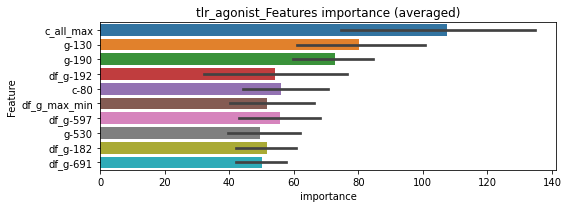

len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213709	valid_1's binary_logloss: 0.0453991
[200]	training's binary_logloss: 0.00298191	valid_1's binary_logloss: 0.0229683
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0011787	valid_1's binary_logloss: 0.0205182


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211165	valid_1's binary_logloss: 0.0389276
[200]	training's binary_logloss: 0.00300687	valid_1's binary_logloss: 0.0166794
[300]	training's binary_logloss: 0.000865675	valid_1's binary_logloss: 0.0129225
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000778461	valid_1's binary_logloss: 0.0128565


tlr_agonist logloss: 0.016687317231217448
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376865	valid_1's binary_logloss: 0.0511291
[200]	training's binary_logloss: 0.00442135	valid_1's binary_logloss: 0.0150259
[300]	training's binary_logloss: 0.00148611	valid_1's binary_logloss: 0.0087767
[400]	training's binary_logloss: 0.000946362	valid_1's binary_logloss: 0.00656319
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000968983	valid_1's binary_logloss: 0.00655652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384058	valid_1's binary_logloss: 0.0598191
[200]	training's binary_logloss: 0.00454253	valid_1's binary_logloss: 0.018459
[300]	training's binary_logloss: 0.00148579	valid_1's binary_logloss: 0.00987296
[400]	training's binary_logloss: 0.000935147	valid_1's binary_logloss: 0.00766707
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000846511	valid_1's binary_logloss: 0.00721418


1 / 3 AUC score:1.000
Threshold: 0.634703891977104
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00067
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00067, conf_1:0.63470
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.63
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_2: 0.59
threshold:0.59, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372793	valid_1's binary_logloss: 0.0462059
[200]	training's binary_logloss: 0.00444281	valid_1's binary_logloss: 0.0103204
[300]	training's binary_logloss: 0.00150621	valid_1's binary_logloss: 0.00554715
[400]	training's binary_logloss: 0.000950509	valid_1's binary_logloss: 0.00418114
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000870964	valid_1's binary_logloss: 0.00390179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374855	valid_1's binary_logloss: 0.0586538
[200]	training's binary_logloss: 0.00441908	valid_1's binary_logloss: 0.0161677
[300]	training's binary_logloss: 0.00146022	valid_1's binary_logloss: 0.00838287
[400]	training's binary_logloss: 0.000934234	valid_1's binary_logloss: 0.00623775
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000848469	valid_1's binary_logloss: 0.00589483


2 / 3 AUC score:1.000
Threshold: 0.5947038919771039
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00059
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00059, conf_1:0.59470
threshold:0.59, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382366	valid_1's binary_logloss: 0.0438734
[200]	training's binary_logloss: 0.00484785	valid_1's binary_logloss: 0.00695989
[300]	training's binary_logloss: 0.00149492	valid_1's binary_logloss: 0.00269786
[400]	training's binary_logloss: 0.000943675	valid_1's binary_logloss: 0.00181865
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0008525	valid_1's binary_logloss: 0.00165019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372232	valid_1's binary_logloss: 0.0588416
[200]	training's binary_logloss: 0.00431206	valid_1's binary_logloss: 0.0195196
[300]	training's binary_logloss: 0.00141777	valid_1's binary_logloss: 0.0112836
[400]	training's binary_logloss: 0.000913879	valid_1's binary_logloss: 0.00920775
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00082978	valid_1's binary_logloss: 0.00882078


3 / 3 AUC score:1.000
Threshold: 0.5947038919771039
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/995
30th percentile: 0.00055
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00055, conf_1:0.59470
threshold:0.59, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/4977, y_label_rate: 0.10046


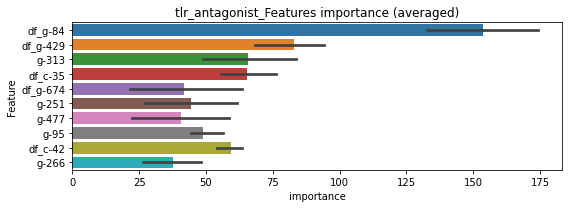

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103777	valid_1's binary_logloss: 0.0164117
[200]	training's binary_logloss: 0.000965278	valid_1's binary_logloss: 0.00729922
[300]	training's binary_logloss: 0.000283797	valid_1's binary_logloss: 0.00564415
[400]	training's binary_logloss: 0.000175111	valid_1's binary_logloss: 0.00529359
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000165363	valid_1's binary_logloss: 0.00525573


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104468	valid_1's binary_logloss: 0.0124325
[200]	training's binary_logloss: 0.000959823	valid_1's binary_logloss: 0.00265311


tlr_antagonist logloss: 0.003703917019238393


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000329709	valid_1's binary_logloss: 0.00215148


tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882396	valid_1's binary_logloss: 0.160158
[200]	training's binary_logloss: 0.0185949	valid_1's binary_logloss: 0.0669288
[300]	training's binary_logloss: 0.00621276	valid_1's binary_logloss: 0.0406648
[400]	training's binary_logloss: 0.00320099	valid_1's binary_logloss: 0.0313957
[500]	training's binary_logloss: 0.00218012	valid_1's binary_logloss: 0.0267442
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0018197	valid_1's binary_logloss: 0.0245577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870726	valid_1's binary_logloss: 0.174466
[200]	training's binary_logloss: 0.0183323	valid_1's binary_logloss: 0.0822075
[300]	training's binary_logloss: 0.00600347	valid_1's binary_logloss: 0.0520741
[400]	training's binary_logloss: 0.00308887	valid_1's binary_logloss: 0.0405344
[500]	training's binary_logloss: 0.00210548	valid_

1 / 3 AUC score:1.000
Threshold: 0.4406116909491434
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00529
p_label_rate: 0.00402 Vs.target_rate: 0.00161, Num_p_label: 16.0, conf_0:0.00529, conf_1:0.50724
threshold:0.44, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889795	valid_1's binary_logloss: 0.169401
[200]	training's binary_logloss: 0.018754	valid_1's binary_logloss: 0.0749661
[300]	training's binary_logloss: 0.00614466	valid_1's binary_logloss: 0.0440239
[400]	training's binary_logloss: 0.00312325	valid_1's binary_logloss: 0.0333922
[500]	training's binary_logloss: 0.00209703	valid_1's binary_logloss: 0.028617
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00177631	valid_1's binary_logloss: 0.0269647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903048	valid_1's binary_logloss: 0.170469
[200]	training's binary_logloss: 0.0182548	valid_1's binary_logloss: 0.0759577
[300]	training's binary_logloss: 0.00598889	valid_1's binary_logloss: 0.0490748
[400]	training's binary_logloss: 0.00305657	valid_1's binary_logloss: 0.0417972
Early stopping, best iteration is:
[480]	training's

2 / 3 AUC score:1.000
Threshold: 0.4406116909491434
Remove_noisy_labels: 10 → positive_corect_labels: 491.0/982
30th percentile: 0.00581
p_label_rate: 0.00452 Vs.target_rate: 0.00161, Num_p_label: 18.0, conf_0:0.00581, conf_1:0.54444
threshold:0.44, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858019	valid_1's binary_logloss: 0.183858
[200]	training's binary_logloss: 0.018004	valid_1's binary_logloss: 0.0829204
[300]	training's binary_logloss: 0.00590612	valid_1's binary_logloss: 0.0532027
[400]	training's binary_logloss: 0.00303743	valid_1's binary_logloss: 0.0433749
[500]	training's binary_logloss: 0.00206019	valid_1's binary_logloss: 0.0382018
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00171669	valid_1's binary_logloss: 0.0356645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08984	valid_1's binary_logloss: 0.150733
[200]	training's binary_logloss: 0.0189332	valid_1's binary_logloss: 0.0580196
[300]	training's binary_logloss: 0.00610059	valid_1's binary_logloss: 0.0308761
[400]	training's binary_logloss: 0.00310307	valid_1's binary_logloss: 0.0215507
[500]	training's binary_logloss: 0.0020826	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.4406116909491434
Remove_noisy_labels: 5 → positive_corect_labels: 490.0/977
30th percentile: 0.00497
p_label_rate: 0.00703 Vs.target_rate: 0.00161, Num_p_label: 28.0, conf_0:0.00497, conf_1:0.55962
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_1: 0.44
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_2: 0.48
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_3: 0.52
Num_p_label: 10.0, Expected: 6.4, Adj_threshold_4: 0.56
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_5: 0.60
threshold:0.60, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/4959, y_label_rate: 0.10022


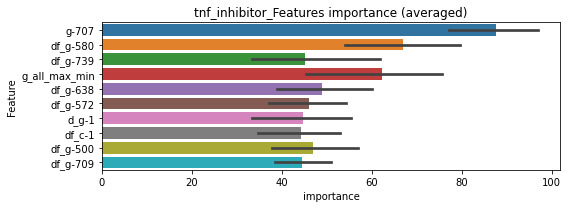

len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236696	valid_1's binary_logloss: 0.0432941
[200]	training's binary_logloss: 0.00350057	valid_1's binary_logloss: 0.0187155
[300]	training's binary_logloss: 0.00101575	valid_1's binary_logloss: 0.0148561
[400]	training's binary_logloss: 0.000518645	valid_1's binary_logloss: 0.013823
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000450449	valid_1's binary_logloss: 0.013668


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237611	valid_1's binary_logloss: 0.0519056
[200]	training's binary_logloss: 0.00355821	valid_1's binary_logloss: 0.0247234
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00199214	valid_1's binary_logloss: 0.0226154


tnf_inhibitor logloss: 0.01814079779946463
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16496	valid_1's binary_logloss: 0.37929
[200]	training's binary_logloss: 0.0521385	valid_1's binary_logloss: 0.290163
[300]	training's binary_logloss: 0.0202306	valid_1's binary_logloss: 0.244433
[400]	training's binary_logloss: 0.00976744	valid_1's binary_logloss: 0.228133
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00633507	valid_1's binary_logloss: 0.217359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165158	valid_1's binary_logloss: 0.398455
[200]	training's binary_logloss: 0.0513892	valid_1's binary_logloss: 0.317719
[300]	training's binary_logloss: 0.019462	valid_1's binary_logloss: 0.285416
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0120349	valid_1's binary_logloss: 0.27502


1 / 3 AUC score:0.959
Threshold: 0.40290829031979075
Remove_noisy_labels: 102 → positive_corect_labels: 449/898
30th percentile: 0.09387
p_label_rate: 0.07157 Vs.target_rate: 0.00519, Num_p_label: 285.0, conf_0:0.09387, conf_1:0.52444
Num_p_label: 285.0, Expected: 20.7, Adj_threshold_1: 0.40
Num_p_label: 196.0, Expected: 20.7, Adj_threshold_2: 0.44
Num_p_label: 141.0, Expected: 20.7, Adj_threshold_3: 0.48
Num_p_label: 95.0, Expected: 20.7, Adj_threshold_4: 0.52
Num_p_label: 69.0, Expected: 20.7, Adj_threshold_5: 0.56
Num_p_label: 53.0, Expected: 20.7, Adj_threshold_6: 0.60
Num_p_label: 38.0, Expected: 20.7, Adj_threshold_7: 0.64
Num_p_label: 26.0, Expected: 20.7, Adj_threshold_8: 0.68
threshold:0.68, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:449.0/898, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152044	valid_1's binary_logloss: 0.341955
[200]	training's binary_logloss: 0.0453308	valid_1's binary_logloss: 0.235693
[300]	training's binary_logloss: 0.016814	valid_1's binary_logloss: 0.185338
[400]	training's binary_logloss: 0.00827444	valid_1's binary_logloss: 0.165022
[500]	training's binary_logloss: 0.00506714	valid_1's binary_logloss: 0.154218
[600]	training's binary_logloss: 0.00363257	valid_1's binary_logloss: 0.147917
[700]	training's binary_logloss: 0.00286728	valid_1's binary_logloss: 0.142942
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.00274781	valid_1's binary_logloss: 0.141684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148521	valid_1's binary_logloss: 0.36725
[200]	training's binary_logloss: 0.0446017	valid_1's binary_logloss: 0.285508
[300]	training's binary_logloss: 0.0163644	valid_1's binary_lo

2 / 3 AUC score:0.981
Threshold: 0.6829082903197908
Remove_noisy_labels: 85 → positive_corect_labels: 370.0/813
30th percentile: 0.06350
p_label_rate: 0.01607 Vs.target_rate: 0.00519, Num_p_label: 64.0, conf_0:0.06350, conf_1:0.68291
Num_p_label: 64.0, Expected: 20.7, Adj_threshold_1: 0.68
Num_p_label: 49.0, Expected: 20.7, Adj_threshold_2: 0.72
Num_p_label: 38.0, Expected: 20.7, Adj_threshold_3: 0.76
Num_p_label: 33.0, Expected: 20.7, Adj_threshold_4: 0.80
Num_p_label: 25.0, Expected: 20.7, Adj_threshold_5: 0.84
threshold:0.84, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:370.0/813, y_label_rate: 0.45510
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139079	valid_1's binary_logloss: 0.305872
[200]	training's binary_logloss: 0.0403765	valid_1's binary_logloss: 0.204307
[300]	training's binary_logloss: 0.0151845	valid_1's binary_logloss: 0.162898
[400]	training's binary_logloss: 0.00747915	valid_1's binary_logloss: 0.143084
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00739192	valid_1's binary_logloss: 0.142921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13761	valid_1's binary_logloss: 0.307332
[200]	training's binary_logloss: 0.038924	valid_1's binary_logloss: 0.198705
[300]	training's binary_logloss: 0.0145149	valid_1's binary_logloss: 0.152398
[400]	training's binary_logloss: 0.00722063	valid_1's binary_logloss: 0.133319
[500]	training's binary_logloss: 0.00454827	valid_1's binary_logloss: 0.122908
[600]	training's binary_logloss: 0.0033409	valid_1's binary_log

3 / 3 AUC score:0.992
Threshold: 0.842908290319791
Remove_noisy_labels: 69 → positive_corect_labels: 303.0/744
30th percentile: 0.03033
p_label_rate: 0.00653 Vs.target_rate: 0.00519, Num_p_label: 26.0, conf_0:0.03033, conf_1:0.84291
threshold:0.84, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:329.0/4726, y_label_rate: 0.06961


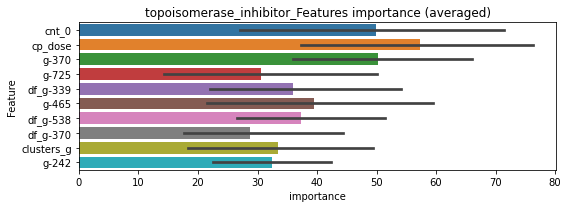

len(train_index) : 2363
len(valid_index) : 2363
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022882	valid_1's binary_logloss: 0.0696055
[200]	training's binary_logloss: 0.00461689	valid_1's binary_logloss: 0.0483738
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00179942	valid_1's binary_logloss: 0.0428894


len(train_index) : 2363
len(valid_index) : 2363
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258767	valid_1's binary_logloss: 0.0745793
[200]	training's binary_logloss: 0.00556487	valid_1's binary_logloss: 0.0547709
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00213412	valid_1's binary_logloss: 0.0506654


topoisomerase_inhibitor logloss: 0.04677739085254785
transient_receptor_potential_channel_antagonist , len(trt) : 18


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675362	valid_1's binary_logloss: 0.110841
[200]	training's binary_logloss: 0.0109692	valid_1's binary_logloss: 0.030731
[300]	training's binary_logloss: 0.00354123	valid_1's binary_logloss: 0.014917
[400]	training's binary_logloss: 0.00193944	valid_1's binary_logloss: 0.0102195
[500]	training's binary_logloss: 0.00145899	valid_1's binary_logloss: 0.00849275
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.0014058	valid_1's binary_logloss: 0.00820932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659432	valid_1's binary_logloss: 0.116392
[200]	training's binary_logloss: 0.0109094	valid_1's binary_logloss: 0.0394646
[300]	training's binary_logloss: 0.00347516	valid_1's binary_logloss: 0.0230921
[400]	training's binary_logloss: 0.00190794	valid_1's binary_logloss: 0.0179303
[500]	training's binary_logloss: 0.00144275	valid_

1 / 3 AUC score:1.000
Threshold: 0.6159902297302007
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentile: 0.00189
p_label_rate: 0.00050 Vs.target_rate: 0.00082, Num_p_label: 2.0, conf_0:0.00189, conf_1:0.61599
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664598	valid_1's binary_logloss: 0.103158
[200]	training's binary_logloss: 0.0111381	valid_1's binary_logloss: 0.0287558
[300]	training's binary_logloss: 0.00350575	valid_1's binary_logloss: 0.0132715
[400]	training's binary_logloss: 0.00191979	valid_1's binary_logloss: 0.00929485
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00156571	valid_1's binary_logloss: 0.00810269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661538	valid_1's binary_logloss: 0.109872
[200]	training's binary_logloss: 0.0107334	valid_1's binary_logloss: 0.0331341
[300]	training's binary_logloss: 0.00345542	valid_1's binary_logloss: 0.0186307
[400]	training's binary_logloss: 0.00190085	valid_1's binary_logloss: 0.014086
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00150834	valid_1's binary_logloss: 0.0125942


2 / 3 AUC score:1.000
Threshold: 0.6159902297302007
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentile: 0.00208
p_label_rate: 0.00075 Vs.target_rate: 0.00082, Num_p_label: 3.0, conf_0:0.00208, conf_1:0.61599
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668054	valid_1's binary_logloss: 0.108773
[200]	training's binary_logloss: 0.010851	valid_1's binary_logloss: 0.0319947
[300]	training's binary_logloss: 0.00345874	valid_1's binary_logloss: 0.0170104
[400]	training's binary_logloss: 0.00189326	valid_1's binary_logloss: 0.0129927
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00154307	valid_1's binary_logloss: 0.011772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648153	valid_1's binary_logloss: 0.108506
[200]	training's binary_logloss: 0.0108335	valid_1's binary_logloss: 0.0312355
[300]	training's binary_logloss: 0.00350614	valid_1's binary_logloss: 0.014979
[400]	training's binary_logloss: 0.0019155	valid_1's binary_logloss: 0.0101965
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00150917	valid_1's binary_logloss: 0.00880995


3 / 3 AUC score:1.000
Threshold: 0.6159902297302007
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentile: 0.00196
p_label_rate: 0.00126 Vs.target_rate: 0.00082, Num_p_label: 5.0, conf_0:0.00196, conf_1:0.61599
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:504.0/4979, y_label_rate: 0.10123


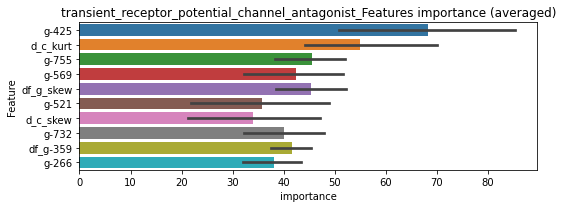

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167067	valid_1's binary_logloss: 0.0248542
[200]	training's binary_logloss: 0.00200937	valid_1's binary_logloss: 0.0055868
[300]	training's binary_logloss: 0.000580367	valid_1's binary_logloss: 0.00300745
[400]	training's binary_logloss: 0.00031827	valid_1's binary_logloss: 0.00255145
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000296195	valid_1's binary_logloss: 0.00251546


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161716	valid_1's binary_logloss: 0.0244667
[200]	training's binary_logloss: 0.00191138	valid_1's binary_logloss: 0.00672802
[300]	training's binary_logloss: 0.000565773	valid_1's binary_logloss: 0.00444918
[400]	training's binary_logloss: 0.000311775	valid_1's binary_logloss: 0.00395931
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000311775	valid_1's binary_logloss: 0.00395931


transient_receptor_potential_channel_antagonist logloss: 0.0032372368032075713
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353611	valid_1's binary_logloss: 0.0442442
[200]	training's binary_logloss: 0.00392327	valid_1's binary_logloss: 0.00728829
[300]	training's binary_logloss: 0.00128066	valid_1's binary_logloss: 0.00329091
[400]	training's binary_logloss: 0.000836508	valid_1's binary_logloss: 0.00233084
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000757815	valid_1's binary_logloss: 0.0021469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353424	valid_1's binary_logloss: 0.0448978
[200]	training's binary_logloss: 0.00393247	valid_1's binary_logloss: 0.00886985
[300]	training's binary_logloss: 0.00130036	valid_1's binary_logloss: 0.00431073
[400]	training's binary_logloss: 0.000851777	valid_1's binary_logloss: 0.00319663


1 / 3 AUC score:1.000
Threshold: 0.490653299782183


[500]	training's binary_logloss: 0.00074486	valid_1's binary_logloss: 0.00291213
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00074486	valid_1's binary_logloss: 0.00291213


Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00055
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.49065
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353611	valid_1's binary_logloss: 0.0442442
[200]	training's binary_logloss: 0.00392327	valid_1's binary_logloss: 0.00728829
[300]	training's binary_logloss: 0.00128066	valid_1's binary_logloss: 0.00329091
[400]	training's binary_logloss: 0.000836508	valid_1's binary_logloss: 0.00233084
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000757815	valid_1's binary_logloss: 0.0021469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353424	valid_1's binary_logloss: 0.0448978
[200]	training's binary_logloss: 0.00393247	valid_1's binary_logloss: 0.00886985
[300]	training's binary_logloss: 0.00130036	valid_1's binary_logloss: 0.00431073
[400]	training's binary_logloss: 0.000851777	valid_1's binary_logloss: 0.00319663
[500]	training's binary_logloss: 0.00074486	valid_1's binary_logloss: 0.00291213
Early stopping, best iteration is:


2 / 3 AUC score:1.000
Threshold: 0.490653299782183
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00055
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.49065
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353611	valid_1's binary_logloss: 0.0442442
[200]	training's binary_logloss: 0.00392327	valid_1's binary_logloss: 0.00728829
[300]	training's binary_logloss: 0.00128066	valid_1's binary_logloss: 0.00329091
[400]	training's binary_logloss: 0.000836508	valid_1's binary_logloss: 0.00233084
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000757815	valid_1's binary_logloss: 0.0021469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353424	valid_1's binary_logloss: 0.0448978
[200]	training's binary_logloss: 0.00393247	valid_1's binary_logloss: 0.00886985
[300]	training's binary_logloss: 0.00130036	valid_1's binary_logloss: 0.00431073
[400]	training's binary_logloss: 0.000851777	valid_1's binary_logloss: 0.00319663


3 / 3 AUC score:1.000
Threshold: 0.490653299782183


[500]	training's binary_logloss: 0.00074486	valid_1's binary_logloss: 0.00291213
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00074486	valid_1's binary_logloss: 0.00291213


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentile: 0.00055
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00055, conf_1:0.49065
threshold:0.49, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4982, y_label_rate: 0.10056


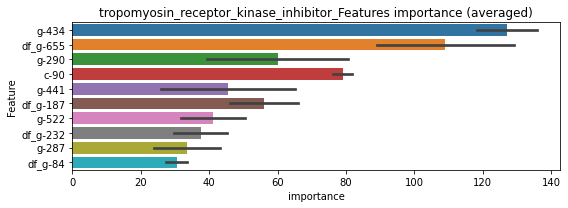

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101548	valid_1's binary_logloss: 0.0119461
[200]	training's binary_logloss: 0.000860355	valid_1's binary_logloss: 0.00245355
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000316898	valid_1's binary_logloss: 0.00196999


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102722	valid_1's binary_logloss: 0.0111263
[200]	training's binary_logloss: 0.000882199	valid_1's binary_logloss: 0.00143494
[300]	training's binary_logloss: 0.000247926	valid_1's binary_logloss: 0.00067181
[400]	training's binary_logloss: 0.000155187	valid_1's binary_logloss: 0.00054451
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000137965	valid_1's binary_logloss: 0.000521922


tropomyosin_receptor_kinase_inhibitor logloss: 0.0012459537157335477
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793295	valid_1's binary_logloss: 0.142829
[200]	training's binary_logloss: 0.0149595	valid_1's binary_logloss: 0.050333
[300]	training's binary_logloss: 0.00475484	valid_1's binary_logloss: 0.0266301
[400]	training's binary_logloss: 0.00251221	valid_1's binary_logloss: 0.0188559
[500]	training's binary_logloss: 0.00173977	valid_1's binary_logloss: 0.0157006
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00153405	valid_1's binary_logloss: 0.0142542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784033	valid_1's binary_logloss: 0.134513
[200]	training's binary_logloss: 0.0146917	valid_1's binary_logloss: 0.0454011
[300]	training's binary_logloss: 0.00463383	valid_1's binary_logloss: 0.0218365
[400]	training's binary_logloss: 0.00242849	valid_1's binary_logloss: 0.0145515
[500]	training's binary_logloss: 0.00172222	valid_

1 / 3 AUC score:1.000
Threshold: 0.6132601942323997
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00405
p_label_rate: 0.00025 Vs.target_rate: 0.00113, Num_p_label: 1.0, conf_0:0.00405, conf_1:0.61326
Num_p_label: 1.0, Expected: 4.5, Adj_threshold_1: 0.61
Num_p_label: 2.0, Expected: 4.5, Adj_threshold_2: 0.57
Num_p_label: 2.0, Expected: 4.5, Adj_threshold_3: 0.53
Num_p_label: 2.0, Expected: 4.5, Adj_threshold_4: 0.49
Num_p_label: 3.0, Expected: 4.5, Adj_threshold_5: 0.45
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793295	valid_1's binary_logloss: 0.142829
[200]	training's binary_logloss: 0.0149595	valid_1's binary_logloss: 0.050333
[300]	training's binary_logloss: 0.00475484	valid_1's binary_logloss: 0.0266301
[400]	training's binary_logloss: 0.00251221	valid_1's binary_logloss: 0.0188559
[500]	training's binary_logloss: 0.00173977	valid_1's binary_logloss: 0.0157006
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00153405	valid_1's binary_logloss: 0.0142542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784033	valid_1's binary_logloss: 0.134513
[200]	training's binary_logloss: 0.0146917	valid_1's binary_logloss: 0.0454011
[300]	training's binary_logloss: 0.00463383	valid_1's binary_logloss: 0.0218365
[400]	training's binary_logloss: 0.00242849	valid_1's binary_logloss: 0.0145515
[500]	training's binary_logloss: 0.00172222	valid_

2 / 3 AUC score:1.000
Threshold: 0.4532601942323997
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00405
p_label_rate: 0.00075 Vs.target_rate: 0.00113, Num_p_label: 3.0, conf_0:0.00405, conf_1:0.45326
threshold:0.45, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782808	valid_1's binary_logloss: 0.129534
[200]	training's binary_logloss: 0.0149099	valid_1's binary_logloss: 0.0430673
[300]	training's binary_logloss: 0.00481702	valid_1's binary_logloss: 0.0216828
[400]	training's binary_logloss: 0.00253222	valid_1's binary_logloss: 0.0144891
[500]	training's binary_logloss: 0.001766	valid_1's binary_logloss: 0.0115789
[600]	training's binary_logloss: 0.00154922	valid_1's binary_logloss: 0.0103891
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00153689	valid_1's binary_logloss: 0.010306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771666	valid_1's binary_logloss: 0.138133
[200]	training's binary_logloss: 0.0140802	valid_1's binary_logloss: 0.0482834
[300]	training's binary_logloss: 0.00451389	valid_1's binary_logloss: 0.0243472
[400]	training's binary_logloss: 0.00237816	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.4532601942323997
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
30th percentile: 0.00378
p_label_rate: 0.00050 Vs.target_rate: 0.00113, Num_p_label: 2.0, conf_0:0.00378, conf_1:0.45326
threshold:0.45, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4981, y_label_rate: 0.10078


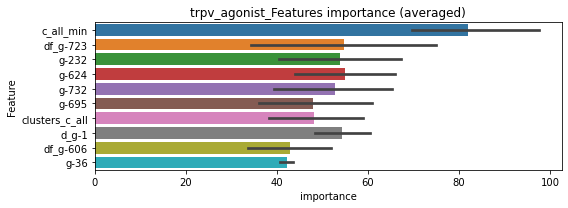

len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019724	valid_1's binary_logloss: 0.0377523
[200]	training's binary_logloss: 0.00263414	valid_1's binary_logloss: 0.013912
[300]	training's binary_logloss: 0.000752698	valid_1's binary_logloss: 0.00956412
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000529593	valid_1's binary_logloss: 0.00913128


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194138	valid_1's binary_logloss: 0.0309537
[200]	training's binary_logloss: 0.00258327	valid_1's binary_logloss: 0.00878628
[300]	training's binary_logloss: 0.000734073	valid_1's binary_logloss: 0.00530361
[400]	training's binary_logloss: 0.000383178	valid_1's binary_logloss: 0.00457067
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000339076	valid_1's binary_logloss: 0.00442784


trpv_agonist logloss: 0.0067800307958846805
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102617	valid_1's binary_logloss: 0.229857
[200]	training's binary_logloss: 0.0242305	valid_1's binary_logloss: 0.135168
[300]	training's binary_logloss: 0.00813215	valid_1's binary_logloss: 0.106054
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00644063	valid_1's binary_logloss: 0.101727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10639	valid_1's binary_logloss: 0.215169
[200]	training's binary_logloss: 0.0250716	valid_1's binary_logloss: 0.108701
[300]	training's binary_logloss: 0.00846867	valid_1's binary_logloss: 0.0712224
[400]	training's binary_logloss: 0.00419757	valid_1's binary_logloss: 0.0562584
[500]	training's binary_logloss: 0.0027285	valid_1's binary_logloss: 0.0489322
[600]	training's binary_logloss: 0.0020949	valid_1's binary_logloss: 0.0446942
Early stopping, best iteration is:
[615]	training's binary

1 / 3 AUC score:0.995
Threshold: 0.32956730109554255
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentile: 0.01753
p_label_rate: 0.01406 Vs.target_rate: 0.00212, Num_p_label: 56.0, conf_0:0.01753, conf_1:0.39483
Num_p_label: 56.0, Expected: 8.4, Adj_threshold_1: 0.33
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_2: 0.37
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_3: 0.41
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_4: 0.45
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_5: 0.49
threshold:0.49, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101142	valid_1's binary_logloss: 0.202036
[200]	training's binary_logloss: 0.0238279	valid_1's binary_logloss: 0.101606
[300]	training's binary_logloss: 0.00808148	valid_1's binary_logloss: 0.0663735
[400]	training's binary_logloss: 0.00405812	valid_1's binary_logloss: 0.0521667
[500]	training's binary_logloss: 0.00269317	valid_1's binary_logloss: 0.0459
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00220401	valid_1's binary_logloss: 0.0431536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101972	valid_1's binary_logloss: 0.213744
[200]	training's binary_logloss: 0.0234089	valid_1's binary_logloss: 0.111135
[300]	training's binary_logloss: 0.00794037	valid_1's binary_logloss: 0.0779542
[400]	training's binary_logloss: 0.00394432	valid_1's binary_logloss: 0.0639035
[500]	training's binary_logloss: 0.00259324	valid_1's bi

2 / 3 AUC score:0.998
Threshold: 0.4895673010955425
Remove_noisy_labels: 12 → positive_corect_labels: 483.0/972
30th percentile: 0.01083
p_label_rate: 0.00276 Vs.target_rate: 0.00212, Num_p_label: 11.0, conf_0:0.01083, conf_1:0.48957
threshold:0.49, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:483.0/972, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990676	valid_1's binary_logloss: 0.204048
[200]	training's binary_logloss: 0.0223606	valid_1's binary_logloss: 0.111845
[300]	training's binary_logloss: 0.00763928	valid_1's binary_logloss: 0.0812106
[400]	training's binary_logloss: 0.00387889	valid_1's binary_logloss: 0.0696565
[500]	training's binary_logloss: 0.00259	valid_1's binary_logloss: 0.0656416
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00242205	valid_1's binary_logloss: 0.0650674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098085	valid_1's binary_logloss: 0.191736
[200]	training's binary_logloss: 0.0219637	valid_1's binary_logloss: 0.09776
[300]	training's binary_logloss: 0.00737054	valid_1's binary_logloss: 0.0682244
[400]	training's binary_logloss: 0.00378211	valid_1's binary_logloss: 0.0575305
Early stopping, best iteration is:
[475]	training's bina

3 / 3 AUC score:0.999
Threshold: 0.4895673010955425
Remove_noisy_labels: 17 → positive_corect_labels: 466.0/955
30th percentile: 0.01132
p_label_rate: 0.00201 Vs.target_rate: 0.00212, Num_p_label: 8.0, conf_0:0.01132, conf_1:0.48957
threshold:0.49, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:474.0/4937, y_label_rate: 0.09601


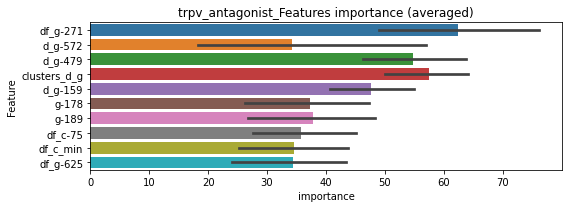

len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228018	valid_1's binary_logloss: 0.0515118
[200]	training's binary_logloss: 0.00381393	valid_1's binary_logloss: 0.0267801
[300]	training's binary_logloss: 0.00114847	valid_1's binary_logloss: 0.0216318
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000911952	valid_1's binary_logloss: 0.0209763


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246873	valid_1's binary_logloss: 0.0503451
[200]	training's binary_logloss: 0.00416631	valid_1's binary_logloss: 0.0225518
[300]	training's binary_logloss: 0.00123658	valid_1's binary_logloss: 0.0163123
[400]	training's binary_logloss: 0.000631798	valid_1's binary_logloss: 0.0148761
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000460507	valid_1's binary_logloss: 0.0140626


trpv_antagonist logloss: 0.01752017560673457
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209927	valid_1's binary_logloss: 0.622679
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.101798	valid_1's binary_logloss: 0.603521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21532	valid_1's binary_logloss: 0.603847
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0983575	valid_1's binary_logloss: 0.579801


1 / 3 AUC score:0.738
Threshold: 0.5072999962993462
Remove_noisy_labels: 334 → positive_corect_labels: 333/666
30th percentile: 0.36252
p_label_rate: 0.28277 Vs.target_rate: 0.01040, Num_p_label: 1126.0, conf_0:0.36252, conf_1:0.50730
Num_p_label: 1126.0, Expected: 41.4, Adj_threshold_1: 0.51
Num_p_label: 762.0, Expected: 41.4, Adj_threshold_2: 0.55
Num_p_label: 477.0, Expected: 41.4, Adj_threshold_3: 0.59
Num_p_label: 235.0, Expected: 41.4, Adj_threshold_4: 0.63
Num_p_label: 113.0, Expected: 41.4, Adj_threshold_5: 0.67
Num_p_label: 48.0, Expected: 41.4, Adj_threshold_6: 0.71
threshold:0.71, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:333.0/666, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189978	valid_1's binary_logloss: 0.477392
[200]	training's binary_logloss: 0.0668051	valid_1's binary_logloss: 0.430778
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0444868	valid_1's binary_logloss: 0.422895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180405	valid_1's binary_logloss: 0.490982


2 / 3 AUC score:0.891
Threshold: 0.7072999962993464
Remove_noisy_labels: 146 → positive_corect_labels: 206.0/520
30th percentile: 0.29626
p_label_rate: 0.07685 Vs.target_rate: 0.01040, Num_p_label: 306.0, conf_0:0.29626, conf_1:0.70730
Num_p_label: 306.0, Expected: 41.4, Adj_threshold_1: 0.71


[200]	training's binary_logloss: 0.063325	valid_1's binary_logloss: 0.451221
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0697125	valid_1's binary_logloss: 0.450739


Num_p_label: 183.0, Expected: 41.4, Adj_threshold_2: 0.75
Num_p_label: 87.0, Expected: 41.4, Adj_threshold_3: 0.79
Num_p_label: 41.0, Expected: 41.4, Adj_threshold_4: 0.83
threshold:0.83, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:206.0/520, y_label_rate: 0.39615
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151979	valid_1's binary_logloss: 0.367715
[200]	training's binary_logloss: 0.0494536	valid_1's binary_logloss: 0.301845
[300]	training's binary_logloss: 0.019415	valid_1's binary_logloss: 0.271419
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0108761	valid_1's binary_logloss: 0.261195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152344	valid_1's binary_logloss: 0.384651
[200]	training's binary_logloss: 0.0472997	valid_1's binary_logloss: 0.31183


3 / 3 AUC score:0.955


[300]	training's binary_logloss: 0.0186643	valid_1's binary_logloss: 0.279268
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0189993	valid_1's binary_logloss: 0.279019


Threshold: 0.8272999962993465
Remove_noisy_labels: 84 → positive_corect_labels: 123.0/436
30th percentile: 0.08821
p_label_rate: 0.01758 Vs.target_rate: 0.01040, Num_p_label: 70.0, conf_0:0.04241, conf_1:0.82730
threshold:0.83, positive p_label:70.0/3982, p_label_rate: 0.01758
positive y_label:193.0/4418, y_label_rate: 0.04368


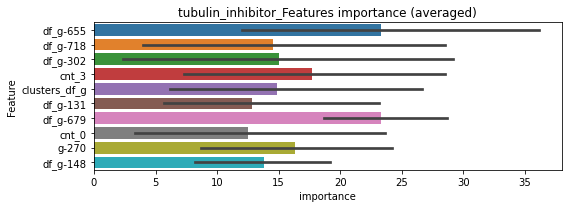

len(train_index) : 2209
len(valid_index) : 2209
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167419	valid_1's binary_logloss: 0.11073


len(train_index) : 2209
len(valid_index) : 2209
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0141236	valid_1's binary_logloss: 0.109697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016607	valid_1's binary_logloss: 0.115333


tubulin_inhibitor logloss: 0.11219570684120603


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.0146074	valid_1's binary_logloss: 0.114695
  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    d

tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121073	valid_1's binary_logloss: 0.270632
[200]	training's binary_logloss: 0.0323561	valid_1's binary_logloss: 0.173332
[300]	training's binary_logloss: 0.0115216	valid_1's binary_logloss: 0.136938
[400]	training's binary_logloss: 0.00575923	valid_1's binary_logloss: 0.12148
[500]	training's binary_logloss: 0.0036578	valid_1's binary_logloss: 0.112391
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00298895	valid_1's binary_logloss: 0.109351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122052	valid_1's binary_logloss: 0.262142
[200]	training's binary_logloss: 0.0324474	valid_1's binary_logloss: 0.161044
[300]	training's binary_logloss: 0.0115497	valid_1's binary_logloss: 0.124174
[400]	training's binary_logloss: 0.00575799	valid_1's binary_logloss: 0.109155
[500]	training's binary_logloss: 0.00365336	valid_1's binary_lo

1 / 3 AUC score:0.991
Threshold: 0.330504386533065
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentile: 0.02710
p_label_rate: 0.04018 Vs.target_rate: 0.00315, Num_p_label: 160.0, conf_0:0.02705, conf_1:0.46531
Num_p_label: 160.0, Expected: 12.5, Adj_threshold_1: 0.33
Num_p_label: 107.0, Expected: 12.5, Adj_threshold_2: 0.37
Num_p_label: 75.0, Expected: 12.5, Adj_threshold_3: 0.41
Num_p_label: 59.0, Expected: 12.5, Adj_threshold_4: 0.45
Num_p_label: 40.0, Expected: 12.5, Adj_threshold_5: 0.49
Num_p_label: 23.0, Expected: 12.5, Adj_threshold_6: 0.53
Num_p_label: 14.0, Expected: 12.5, Adj_threshold_7: 0.57
threshold:0.57, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116645	valid_1's binary_logloss: 0.268865
[200]	training's binary_logloss: 0.0302036	valid_1's binary_logloss: 0.166591
[300]	training's binary_logloss: 0.0106759	valid_1's binary_logloss: 0.130882
[400]	training's binary_logloss: 0.00529931	valid_1's binary_logloss: 0.115502
[500]	training's binary_logloss: 0.00340383	valid_1's binary_logloss: 0.108421
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00311786	valid_1's binary_logloss: 0.10699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119215	valid_1's binary_logloss: 0.243545
[200]	training's binary_logloss: 0.0317979	valid_1's binary_logloss: 0.145481
[300]	training's binary_logloss: 0.0111081	valid_1's binary_logloss: 0.107907
[400]	training's binary_logloss: 0.00547194	valid_1's binary_logloss: 0.0896208
[500]	training's binary_logloss: 0.00349293	valid_1's binary_

2 / 3 AUC score:0.996
Threshold: 0.570504386533065
Remove_noisy_labels: 30 → positive_corect_labels: 460.0/934
30th percentile: 0.02433
p_label_rate: 0.01231 Vs.target_rate: 0.00315, Num_p_label: 49.0, conf_0:0.01532, conf_1:0.57050
Num_p_label: 49.0, Expected: 12.5, Adj_threshold_1: 0.57
Num_p_label: 33.0, Expected: 12.5, Adj_threshold_2: 0.61
Num_p_label: 22.0, Expected: 12.5, Adj_threshold_3: 0.65
Num_p_label: 11.0, Expected: 12.5, Adj_threshold_4: 0.69
threshold:0.69, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:460.0/934, y_label_rate: 0.49251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106693	valid_1's binary_logloss: 0.240216
[200]	training's binary_logloss: 0.027616	valid_1's binary_logloss: 0.146572
[300]	training's binary_logloss: 0.00999184	valid_1's binary_logloss: 0.111767
[400]	training's binary_logloss: 0.00501201	valid_1's binary_logloss: 0.096719
[500]	training's binary_logloss: 0.0032377	valid_1's binary_logloss: 0.0873336
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00313165	valid_1's binary_logloss: 0.0867172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113214	valid_1's binary_logloss: 0.228934
[200]	training's binary_logloss: 0.0291247	valid_1's binary_logloss: 0.134528
[300]	training's binary_logloss: 0.010155	valid_1's binary_logloss: 0.0981946
[400]	training's binary_logloss: 0.00512027	valid_1's binary_logloss: 0.0822341
[500]	training's binary_logloss: 0.00329746	valid_1's binar

3 / 3 AUC score:0.998
Threshold: 0.6905043865330651
Remove_noisy_labels: 24 → positive_corect_labels: 438.0/910
30th percentile: 0.01974
p_label_rate: 0.00477 Vs.target_rate: 0.00315, Num_p_label: 19.0, conf_0:0.01974, conf_1:0.69050
threshold:0.69, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:457.0/4892, y_label_rate: 0.09342


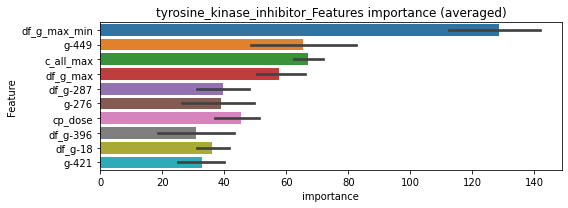

len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258163	valid_1's binary_logloss: 0.0754462
[200]	training's binary_logloss: 0.00492494	valid_1's binary_logloss: 0.0513327
[300]	training's binary_logloss: 0.0014719	valid_1's binary_logloss: 0.0465217
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00149856	valid_1's binary_logloss: 0.0464117


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250086	valid_1's binary_logloss: 0.0689773
[200]	training's binary_logloss: 0.00492348	valid_1's binary_logloss: 0.0435748
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00178742	valid_1's binary_logloss: 0.039098


tyrosine_kinase_inhibitor logloss: 0.04275485446751692
ubiquitin_specific_protease_inhibitor , len(trt) : 12


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508773	valid_1's binary_logloss: 0.0720168
[200]	training's binary_logloss: 0.00734181	valid_1's binary_logloss: 0.015726
[300]	training's binary_logloss: 0.00234467	valid_1's binary_logloss: 0.00718485
[400]	training's binary_logloss: 0.00133015	valid_1's binary_logloss: 0.00495346
[500]	training's binary_logloss: 0.00108792	valid_1's binary_logloss: 0.00428905
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00107212	valid_1's binary_logloss: 0.00425128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528346	valid_1's binary_logloss: 0.0777471
[200]	training's binary_logloss: 0.00734693	valid_1's binary_logloss: 0.0190101
[300]	training's binary_logloss: 0.00228743	valid_1's binary_logloss: 0.00931948
[400]	training's binary_logloss: 0.0012996	valid_1's binary_logloss: 0.00650054
Early stopping, best iteration is:
[455]	

1 / 3 AUC score:1.000
Threshold: 0.633972275542772
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentile: 0.00122
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00122, conf_1:0.63397
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.63
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.59
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.55
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.51
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.47
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.43
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_7: 0.39
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_8: 0.35
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_9: 0.31
threshold:0.31, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508773	valid_1's binary_logloss: 0.0720168
[200]	training's binary_logloss: 0.00734181	valid_1's binary_logloss: 0.015726
[300]	training's binary_logloss: 0.00234467	valid_1's binary_logloss: 0.00718485
[400]	training's binary_logloss: 0.00133015	valid_1's binary_logloss: 0.00495346
[500]	training's binary_logloss: 0.00108792	valid_1's binary_logloss: 0.00428905
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00107212	valid_1's binary_logloss: 0.00425128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528346	valid_1's binary_logloss: 0.0777471
[200]	training's binary_logloss: 0.00734693	valid_1's binary_logloss: 0.0190101
[300]	training's binary_logloss: 0.00228743	valid_1's binary_logloss: 0.00931948
[400]	training's binary_logloss: 0.0012996	valid_1's binary_logloss: 0.00650054
Early stopping, best iteration is:
[455]	

2 / 3 AUC score:1.000
Threshold: 0.313972275542772
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/999
30th percentile: 0.00122
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00122, conf_1:0.31397
threshold:0.31, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505292	valid_1's binary_logloss: 0.0791848
[200]	training's binary_logloss: 0.00716126	valid_1's binary_logloss: 0.0212318
[300]	training's binary_logloss: 0.00226512	valid_1's binary_logloss: 0.0105082
[400]	training's binary_logloss: 0.00129734	valid_1's binary_logloss: 0.00760643
[500]	training's binary_logloss: 0.00106883	valid_1's binary_logloss: 0.00683941
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00107343	valid_1's binary_logloss: 0.00683654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537392	valid_1's binary_logloss: 0.0739791
[200]	training's binary_logloss: 0.00758833	valid_1's binary_logloss: 0.0163799
[300]	training's binary_logloss: 0.0023433	valid_1's binary_logloss: 0.00724421
[400]	training's binary_logloss: 0.00131568	valid_1's binary_logloss: 0.00463768
[500]	training's binary_logloss: 0.001092

3 / 3 AUC score:1.000
Threshold: 0.313972275542772
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
30th percentile: 0.00123
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00123, conf_1:0.31397
threshold:0.31, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:501.0/4980, y_label_rate: 0.10060


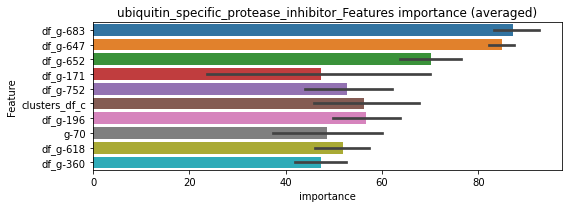

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124164	valid_1's binary_logloss: 0.0223275
[200]	training's binary_logloss: 0.00131506	valid_1's binary_logloss: 0.0086942
[300]	training's binary_logloss: 0.000381823	valid_1's binary_logloss: 0.00648448
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000307335	valid_1's binary_logloss: 0.00624695


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127874	valid_1's binary_logloss: 0.0186411
[200]	training's binary_logloss: 0.00135111	valid_1's binary_logloss: 0.00452944
[300]	training's binary_logloss: 0.000393563	valid_1's binary_logloss: 0.00239088
[400]	training's binary_logloss: 0.000226387	valid_1's binary_logloss: 0.00184388
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000209591	valid_1's binary_logloss: 0.00180334


ubiquitin_specific_protease_inhibitor logloss: 0.004025143442221124
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18173	valid_1's binary_logloss: 0.463773
[200]	training's binary_logloss: 0.0620931	valid_1's binary_logloss: 0.398251
[300]	training's binary_logloss: 0.024668	valid_1's binary_logloss: 0.372947
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.013442	valid_1's binary_logloss: 0.359231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185665	valid_1's binary_logloss: 0.44547
[200]	training's binary_logloss: 0.0638927	valid_1's binary_logloss: 0.363811
[300]	training's binary_logloss: 0.0257988	valid_1's binary_logloss: 0.334557
[400]	training's binary_logloss: 0.0125137	valid_1's binary_logloss: 0.312154
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0133369	valid_1's binary_logloss: 0.310456


1 / 3 AUC score:0.922
Threshold: 0.4682855784624802
Remove_noisy_labels: 154 → positive_corect_labels: 423/846
30th percentile: 0.16045
p_label_rate: 0.10748 Vs.target_rate: 0.00664, Num_p_label: 428.0, conf_0:0.16045, conf_1:0.51905
Num_p_label: 428.0, Expected: 26.4, Adj_threshold_1: 0.47
Num_p_label: 287.0, Expected: 26.4, Adj_threshold_2: 0.51
Num_p_label: 175.0, Expected: 26.4, Adj_threshold_3: 0.55
Num_p_label: 114.0, Expected: 26.4, Adj_threshold_4: 0.59
Num_p_label: 73.0, Expected: 26.4, Adj_threshold_5: 0.63
Num_p_label: 44.0, Expected: 26.4, Adj_threshold_6: 0.67
Num_p_label: 26.0, Expected: 26.4, Adj_threshold_7: 0.71
threshold:0.71, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:423.0/846, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17042	valid_1's binary_logloss: 0.396969
[200]	training's binary_logloss: 0.0533507	valid_1's binary_logloss: 0.294046
[300]	training's binary_logloss: 0.0206428	valid_1's binary_logloss: 0.249504
[400]	training's binary_logloss: 0.0100629	valid_1's binary_logloss: 0.230699
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0100629	valid_1's binary_logloss: 0.230699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163333	valid_1's binary_logloss: 0.383275
[200]	training's binary_logloss: 0.0515651	valid_1's binary_logloss: 0.293442
[300]	training's binary_logloss: 0.020118	valid_1's binary_logloss: 0.252421
[400]	training's binary_logloss: 0.00986819	valid_1's binary_logloss: 0.22856
[500]	training's binary_logloss: 0.00603529	valid_1's binary_logloss: 0.218341
Early stopping, best iteration is:
[511]	training's binary_logloss

2 / 3 AUC score:0.972
Threshold: 0.7082855784624804
Remove_noisy_labels: 74 → positive_corect_labels: 354.0/772
30th percentile: 0.11018
p_label_rate: 0.01783 Vs.target_rate: 0.00664, Num_p_label: 71.0, conf_0:0.11018, conf_1:0.70829
threshold:0.71, positive p_label:71.0/3982, p_label_rate: 0.01783
positive y_label:354.0/772, y_label_rate: 0.45855
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153297	valid_1's binary_logloss: 0.371778
[200]	training's binary_logloss: 0.0468652	valid_1's binary_logloss: 0.275082
[300]	training's binary_logloss: 0.0175916	valid_1's binary_logloss: 0.233749
[400]	training's binary_logloss: 0.00865488	valid_1's binary_logloss: 0.219244
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00692667	valid_1's binary_logloss: 0.215504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146228	valid_1's binary_logloss: 0.36323
[200]	training's binary_logloss: 0.0444486	valid_1's binary_logloss: 0.271916
[300]	training's binary_logloss: 0.0169798	valid_1's binary_logloss: 0.236405
[400]	training's binary_logloss: 0.00845374	valid_1's binary_logloss: 0.223321
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.0059647	valid_1's binary_logloss: 0.214851


3 / 3 AUC score:0.967
Threshold: 0.7082855784624804
Remove_noisy_labels: 66 → positive_corect_labels: 291.0/706
30th percentile: 0.06340
p_label_rate: 0.00703 Vs.target_rate: 0.00664, Num_p_label: 28.0, conf_0:0.05943, conf_1:0.70829
threshold:0.71, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:319.0/4688, y_label_rate: 0.06805


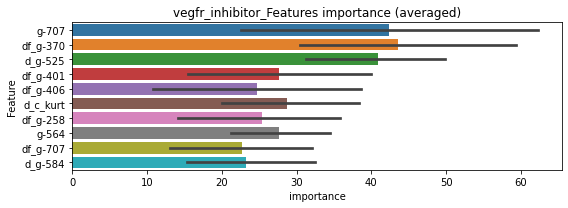

len(train_index) : 2344
len(valid_index) : 2344
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275023	valid_1's binary_logloss: 0.0993151
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00901321	valid_1's binary_logloss: 0.0850365


len(train_index) : 2344
len(valid_index) : 2344
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280245	valid_1's binary_logloss: 0.104525
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00825344	valid_1's binary_logloss: 0.0929756


vegfr_inhibitor logloss: 0.08900605130454882
vitamin_b , len(trt) : 26


  acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                          g-156                          df_g-660   
1                      c_all_max                              g-13   
2                        df_c-94                          df_g-105   
3                       df_g-325                          df_g-686   
4                          g-541                         c_all_max   
5                          g-131                     clusters_df_c   
6                        d_g-627                          df_g-566   
7                        d_g-707                          df_g-451   
8                          g-226                             g-218   
9                       df_g-403                            d_g-43   

  acetylcholinesterase_inhibitor adenosine_receptor_agonist  \
0                          g-160                    df_c-87   
1                      c_all_max                      g-360   
2                       df_g-448        

================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755843	valid_1's binary_logloss: 0.136079
[200]	training's binary_logloss: 0.0140556	valid_1's binary_logloss: 0.0550569
[300]	training's binary_logloss: 0.00456745	valid_1's binary_logloss: 0.0336827
[400]	training's binary_logloss: 0.00240779	valid_1's binary_logloss: 0.0255718
[500]	training's binary_logloss: 0.00168382	valid_1's binary_logloss: 0.02203
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00151786	valid_1's binary_logloss: 0.020797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804467	valid_1's binary_logloss: 0.148897
[200]	training's binary_logloss: 0.0145583	valid_1's binary_logloss: 0.06071
[300]	training's binary_logloss: 0.00455735	valid_1's binary_logloss: 0.0384651
[400]	training's binary_logloss: 0.00238425	valid_1's binary_logloss: 0.0320713
Early stopping, best iteration is:
[471]	training's bi

1 / 3 AUC score:1.000
Threshold: 0.4560992004615982
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentile: 0.00291
p_label_rate: 0.00201 Vs.target_rate: 0.00117, Num_p_label: 8.0, conf_0:0.00291, conf_1:0.47569
threshold:0.46, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741597	valid_1's binary_logloss: 0.136175
[200]	training's binary_logloss: 0.0134685	valid_1's binary_logloss: 0.0470749
[300]	training's binary_logloss: 0.00438154	valid_1's binary_logloss: 0.0263979
[400]	training's binary_logloss: 0.00229803	valid_1's binary_logloss: 0.0196535
[500]	training's binary_logloss: 0.00163531	valid_1's binary_logloss: 0.0168501
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00148996	valid_1's binary_logloss: 0.0160299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769186	valid_1's binary_logloss: 0.135458
[200]	training's binary_logloss: 0.014346	valid_1's binary_logloss: 0.0523587
[300]	training's binary_logloss: 0.00457606	valid_1's binary_logloss: 0.0294489
[400]	training's binary_logloss: 0.00239806	valid_1's binary_logloss: 0.0219534
[500]	training's binary_logloss: 0.00169205	valid_

2 / 3 AUC score:1.000
Threshold: 0.4560992004615982
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/987
30th percentile: 0.00276
p_label_rate: 0.00251 Vs.target_rate: 0.00117, Num_p_label: 10.0, conf_0:0.00276, conf_1:0.47070
threshold:0.46, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:495.0/987, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758958	valid_1's binary_logloss: 0.140745
[200]	training's binary_logloss: 0.0137566	valid_1's binary_logloss: 0.053254
[300]	training's binary_logloss: 0.00440808	valid_1's binary_logloss: 0.0300276
[400]	training's binary_logloss: 0.00234414	valid_1's binary_logloss: 0.0224183
[500]	training's binary_logloss: 0.00164613	valid_1's binary_logloss: 0.0190155
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00155789	valid_1's binary_logloss: 0.0183833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758208	valid_1's binary_logloss: 0.127922
[200]	training's binary_logloss: 0.0139908	valid_1's binary_logloss: 0.0423382
[300]	training's binary_logloss: 0.00452971	valid_1's binary_logloss: 0.0238055
[400]	training's binary_logloss: 0.00238832	valid_1's binary_logloss: 0.0177765
[500]	training's binary_logloss: 0.00168804	valid_

3 / 3 AUC score:1.000
Threshold: 0.4560992004615982
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/986
30th percentile: 0.00266
p_label_rate: 0.00352 Vs.target_rate: 0.00117, Num_p_label: 14.0, conf_0:0.00266, conf_1:0.52328
threshold:0.46, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:509.0/4968, y_label_rate: 0.10246


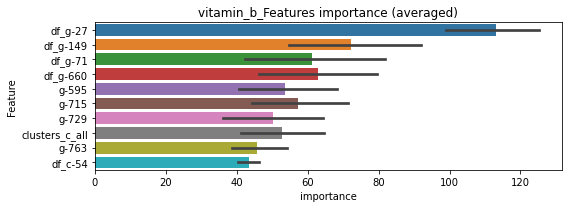

len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193724	valid_1's binary_logloss: 0.0374014
[200]	training's binary_logloss: 0.00268108	valid_1's binary_logloss: 0.0163715
[300]	training's binary_logloss: 0.00079092	valid_1's binary_logloss: 0.0131645
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000681882	valid_1's binary_logloss: 0.0128691


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200768	valid_1's binary_logloss: 0.0427739
[200]	training's binary_logloss: 0.00265967	valid_1's binary_logloss: 0.0239035
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00169086	valid_1's binary_logloss: 0.0234141


vitamin_b logloss: 0.01814162763340287
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993811	valid_1's binary_logloss: 0.196732
[200]	training's binary_logloss: 0.0214075	valid_1's binary_logloss: 0.0935595
[300]	training's binary_logloss: 0.00698036	valid_1's binary_logloss: 0.0613086
[400]	training's binary_logloss: 0.00347297	valid_1's binary_logloss: 0.0510589
[500]	training's binary_logloss: 0.00232866	valid_1's binary_logloss: 0.0474054
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00195005	valid_1's binary_logloss: 0.045585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998239	valid_1's binary_logloss: 0.191455
[200]	training's binary_logloss: 0.0221623	valid_1's binary_logloss: 0.0920771
[300]	training's binary_logloss: 0.00730429	valid_1's binary_logloss: 0.0590419
[400]	training's binary_logloss: 0.00363463	valid_1's binary_logloss: 0.0476361
[500]	training's binary_logloss: 0.00239336	valid_

1 / 3 AUC score:0.998
Threshold: 0.4969901447194422
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentile: 0.00704
p_label_rate: 0.00151 Vs.target_rate: 0.00174, Num_p_label: 6.0, conf_0:0.00704, conf_1:0.49699
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985041	valid_1's binary_logloss: 0.195322
[200]	training's binary_logloss: 0.021399	valid_1's binary_logloss: 0.0908283
[300]	training's binary_logloss: 0.00695551	valid_1's binary_logloss: 0.0562349
[400]	training's binary_logloss: 0.00349174	valid_1's binary_logloss: 0.0438669
[500]	training's binary_logloss: 0.002313	valid_1's binary_logloss: 0.0380909
[600]	training's binary_logloss: 0.00189108	valid_1's binary_logloss: 0.0343773
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00180412	valid_1's binary_logloss: 0.0338431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928962	valid_1's binary_logloss: 0.204556
[200]	training's binary_logloss: 0.0200203	valid_1's binary_logloss: 0.108038
[300]	training's binary_logloss: 0.00656378	valid_1's binary_logloss: 0.0818826
[400]	training's binary_logloss: 0.00336976	valid_1's

2 / 3 AUC score:0.998
Threshold: 0.4969901447194422
Remove_noisy_labels: 16 → positive_corect_labels: 483.0/974
30th percentile: 0.00742
p_label_rate: 0.00226 Vs.target_rate: 0.00174, Num_p_label: 9.0, conf_0:0.00742, conf_1:0.51058
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:483.0/974, y_label_rate: 0.49589
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969168	valid_1's binary_logloss: 0.177094
[200]	training's binary_logloss: 0.0210791	valid_1's binary_logloss: 0.0760822
[300]	training's binary_logloss: 0.00698166	valid_1's binary_logloss: 0.0472885
[400]	training's binary_logloss: 0.00350393	valid_1's binary_logloss: 0.036365
[500]	training's binary_logloss: 0.00235316	valid_1's binary_logloss: 0.0319835
[600]	training's binary_logloss: 0.00185694	valid_1's binary_logloss: 0.0296688
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00176978	valid_1's binary_logloss: 0.0291876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955317	valid_1's binary_logloss: 0.174487
[200]	training's binary_logloss: 0.0207969	valid_1's binary_logloss: 0.0794807
[300]	training's binary_logloss: 0.00680759	valid_1's binary_logloss: 0.0492654
[400]	training's binary_logloss: 0.00344757	valid_

3 / 3 AUC score:1.000
Threshold: 0.4969901447194422
Remove_noisy_labels: 5 → positive_corect_labels: 479.0/969
30th percentile: 0.00550
p_label_rate: 0.00226 Vs.target_rate: 0.00174, Num_p_label: 9.0, conf_0:0.00550, conf_1:0.51163
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:488.0/4951, y_label_rate: 0.09857


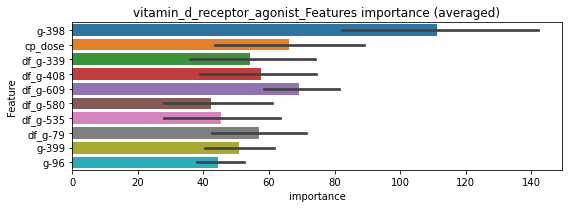

len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238981	valid_1's binary_logloss: 0.0482894
[200]	training's binary_logloss: 0.00364551	valid_1's binary_logloss: 0.0222738
[300]	training's binary_logloss: 0.00106893	valid_1's binary_logloss: 0.0170515
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000747183	valid_1's binary_logloss: 0.0164219


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248711	valid_1's binary_logloss: 0.0515822
[200]	training's binary_logloss: 0.00396692	valid_1's binary_logloss: 0.0229991
[300]	training's binary_logloss: 0.00110788	valid_1's binary_logloss: 0.0166762
[400]	training's binary_logloss: 0.000552491	valid_1's binary_logloss: 0.0153893
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000407871	valid_1's binary_logloss: 0.0148184


vitamin_d_receptor_agonist logloss: 0.01562027660205448
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875155	valid_1's binary_logloss: 0.146539
[200]	training's binary_logloss: 0.0169048	valid_1's binary_logloss: 0.0520932
[300]	training's binary_logloss: 0.00546196	valid_1's binary_logloss: 0.0280816
[400]	training's binary_logloss: 0.00281201	valid_1's binary_logloss: 0.0200933
[500]	training's binary_logloss: 0.00191105	valid_1's binary_logloss: 0.0166802
[600]	training's binary_logloss: 0.00160958	valid_1's binary_logloss: 0.0150899
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00157621	valid_1's binary_logloss: 0.0147623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809511	valid_1's binary_logloss: 0.155468
[200]	training's binary_logloss: 0.0153417	valid_1's binary_logloss: 0.0666281
[300]	training's binary_logloss: 0.00486934	valid_1's binary_logloss: 0.0439927
[400]	training's binary_logloss: 0.00254593	valid

1 / 3 AUC score:1.000
Threshold: 0.33734163190591715
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentile: 0.00461
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00461, conf_1:0.42034
threshold:0.34, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802028	valid_1's binary_logloss: 0.137418
[200]	training's binary_logloss: 0.0157696	valid_1's binary_logloss: 0.051911
[300]	training's binary_logloss: 0.00505896	valid_1's binary_logloss: 0.0289834
[400]	training's binary_logloss: 0.00264617	valid_1's binary_logloss: 0.0218199
[500]	training's binary_logloss: 0.00182986	valid_1's binary_logloss: 0.0185403
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00156214	valid_1's binary_logloss: 0.0171423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848431	valid_1's binary_logloss: 0.157649
[200]	training's binary_logloss: 0.0165536	valid_1's binary_logloss: 0.0634074
[300]	training's binary_logloss: 0.00527991	valid_1's binary_logloss: 0.0376522
[400]	training's binary_logloss: 0.00271519	valid_1's binary_logloss: 0.0290575
[500]	training's binary_logloss: 0.00185685	valid_

2 / 3 AUC score:1.000
Threshold: 0.33734163190591715
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/992
30th percentile: 0.00411
p_label_rate: 0.00251 Vs.target_rate: 0.00135, Num_p_label: 10.0, conf_0:0.00411, conf_1:0.43228
threshold:0.34, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814558	valid_1's binary_logloss: 0.137964
[200]	training's binary_logloss: 0.0159429	valid_1's binary_logloss: 0.0495041
[300]	training's binary_logloss: 0.00519795	valid_1's binary_logloss: 0.0270167
[400]	training's binary_logloss: 0.00267873	valid_1's binary_logloss: 0.0194451
[500]	training's binary_logloss: 0.00183683	valid_1's binary_logloss: 0.0162066
[600]	training's binary_logloss: 0.00156845	valid_1's binary_logloss: 0.0146931
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00155085	valid_1's binary_logloss: 0.0146224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840965	valid_1's binary_logloss: 0.151004
[200]	training's binary_logloss: 0.0162171	valid_1's binary_logloss: 0.0621605
[300]	training's binary_logloss: 0.00517605	valid_1's binary_logloss: 0.0412953
[400]	training's binary_logloss: 0.00267536	valid

3 / 3 AUC score:0.999
Threshold: 0.33734163190591715
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/988
30th percentile: 0.00475
p_label_rate: 0.00276 Vs.target_rate: 0.00135, Num_p_label: 11.0, conf_0:0.00475, conf_1:0.42276
threshold:0.34, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:504.0/4970, y_label_rate: 0.10141


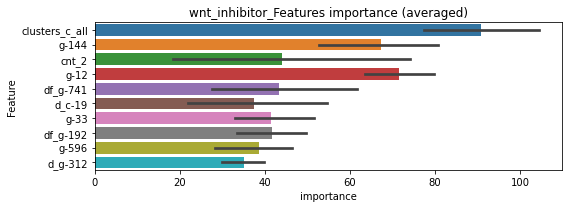

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212171	valid_1's binary_logloss: 0.0408802
[200]	training's binary_logloss: 0.00310077	valid_1's binary_logloss: 0.0185615
[300]	training's binary_logloss: 0.000885975	valid_1's binary_logloss: 0.0156142
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000857208	valid_1's binary_logloss: 0.0155418


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195831	valid_1's binary_logloss: 0.0441339
[200]	training's binary_logloss: 0.00277694	valid_1's binary_logloss: 0.0242205
[300]	training's binary_logloss: 0.000833694	valid_1's binary_logloss: 0.0210014
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000500915	valid_1's binary_logloss: 0.0202875


wnt_inhibitor logloss: 0.017914683336203465


In [46]:
categorical_cols = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()
scores = []
models = []

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        if _score > 0.02:
            importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)
            print(importance_cols_df)
        
        feature_importance_df = create_featureimprotance(models, feature_importance_df)

In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
print(f"CV:{np.mean(scores)}")

CV:0.03273026204884391


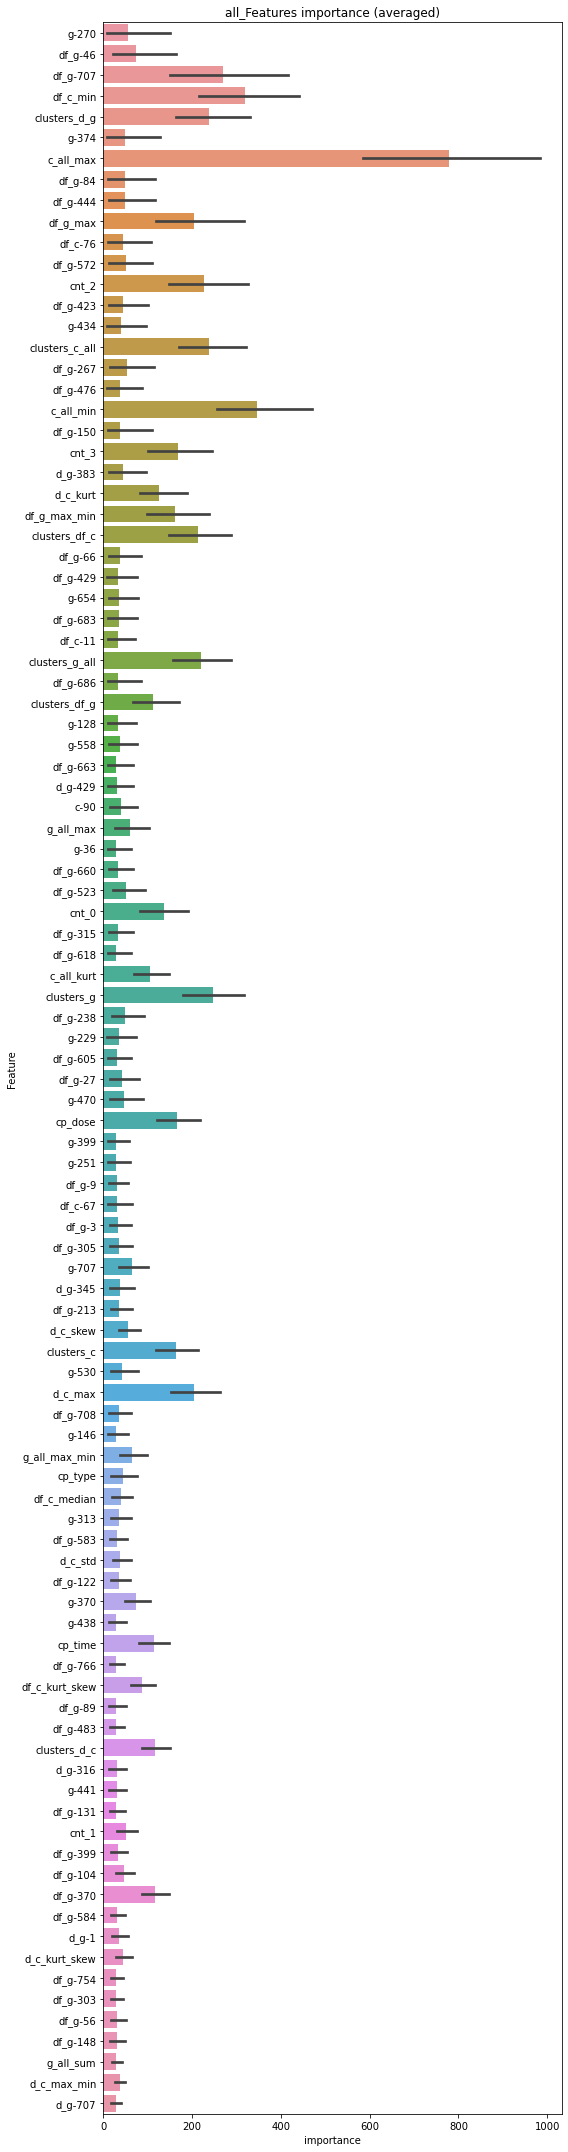

In [49]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)